In [278]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import median_absolute_error, mean_squared_error

#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense,Bidirectional, LSTM, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization, GlobalMaxPool1D, Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
import collections

In [298]:
import requests
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

def get_values_not_in_first(arr1, arr2):
    values = []
    for val in arr2:
        if val not in arr1:
            values.append(val)
    return values

def make_api_call_get_json(url):
    try:
        req = requests.get(url)
        if req.status_code == 200:
            return req.json()
    except Exception as e:
        print('Error occured : ', str(e))
    print('Request was not successful : ', req)
    return 

def combine_train_test_set(train, test, target='target'):
    train = train[pd.notnull(train[target])]
    test[target] = np.nan
    return pd.concat([train, test[train.columns.tolist()]])
    
def split_train_test_set(combine, target='target'):
    train = combine[combine[target].notnull()]
    test = combine[combine[target].isnull()]
    return train, test

def train_model(model, X_train, y_train, X_test, y_test):
    model.fit( X_train, y_train)
    predictions = model.predict(X_test)
    print("RMSE on test data: "+ str(rmse_error(predictions, y_test)))
    return model

def rmse_error(predictions, y_test):
    return np.sqrt(mean_squared_error(predictions, y_test))


def plot_keras():
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def target_encoding(data, cols, y_label, smoothing=False, smooth_val = 10):
    ce_target = ce.TargetEncoder(cols = cols, smoothing = smooth_val) if smoothing else ce.TargetEncoder(cols = cols)
    fit_data = data[data[y_label].notnull()]
    y = fit_data[y_label]
    ce_target.fit(fit_data, y)
    return ce_target.transform(data)

# demonstrate data normalization with sklearn

def min_max_normalise(data, cols = None):
    data = data.copy()
    scalers = {}
    if cols == None:
        cols = data.columns
    for col in cols:
        print(col)
        if data[col].dtype == 'object': continue
        scaler = MinMaxScaler()
        scalers[col] = scaler
        scaler.fit(data[col])
        data[col] = scaler.transform(data[col])
#         scaler.inverse_transform(normalized)
    return scalers

def quantile_transformer(data, cols=None):
    data = data.copy()
    scalers = {}
    if cols == None:
        cols = data.columns
    for col in cols:
        if data[col].dtype == 'object': continue
        scaler = QuantileTransformer()
        scalers[col] = scaler
        scaler.fit(data[col])
        data[col] = scaler.transform(data[col])
    return scalers
    

In [299]:
from datetime import timedelta

def convert_time_str(time):
    time_parts = time.split(' ')
    comps = time_parts[0].split(':')
    comps = list(map(int, comps))
    if time_parts[1].lower() == 'pm' and comps[0] != 12:
        comps[0] += 12
    elif time_parts[1].lower() == 'am' and comps[0] == 12:
        comps[0] = 0
    return np.array(comps)

def convert_time_str_hours(time):
    return convert_time_str(time)[0]

def convert_time_str_minutes(time):
    return convert_time_str(time)[1]

def convert_time_str_seconds(time):
    return convert_time_str(time)[2]
    
def combine_data_with_riders(data, riders):
    data = data.copy()
    riders = riders.set_index('Rider Id')
    for col in riders.columns:
        data['Riders ' + col] = data['Rider Id'].apply(lambda r: riders[col].loc[r])
    return data

def to_timedelta(t):
    t = convert_time_str(t)
    t = timedelta(hours=t[0], minutes=t[1], seconds=t[2])
    return t

def time_difference(t1, t2):
    t1 = t1.apply(to_timedelta)
    t2 = t2.apply(to_timedelta)
    return (t2 - t1).apply(lambda t: t.seconds)

def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

def radian_conv(degree):
    """
    Return radian.
    """
    return np.radians(degree) 

# time_difference(combine_set['Placement - Time'], combine_set['Confirmation - Time'])

In [300]:
def add_bearing_features(data):
    data['bearing'] = sphere_dist_bear(data['Pickup Lat'], data['Pickup Long'], 
                                   data['Destination Lat'] , data['Destination Long'])

def drop_date_info(data):
    return data.drop(columns=['Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 
                       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)'])

def delete_passive_outliers(data):
    data = data[(data['Placement - Weekday (Mo = 1)'] == data['Confirmation - Weekday (Mo = 1)']) 
                | data['Time from Pickup to Arrival'].isna()]
    data = data[(data['Distance (KM)'] < 30) | data['Time from Pickup to Arrival'].isna()]
    data = data[(data['Time from Pickup to Arrival'] > 5000) | data['Time from Pickup to Arrival'].isna()]
    return data

def drop_time_variables(data):
    return data.drop(columns=time_variables)

def change_time_variables(data, cols=time_variables):
    for col in cols:
        data[col + ' hours'] = data[col].apply(convert_time_str_hours) 
        data[col + ' minutes'] = data[col].apply(convert_time_str_minutes) 
        data[col + ' seconds'] = data[col].apply(convert_time_str_seconds)
    return data
        
def convert_to_randians(data, 
                        cols=['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long'], 
                        only_temp=False):
    data = data.copy()
    if not only_temp:
        for col in cols:
            data[col] = radian_conv(data[col])
    return data
        
def add_time_diff(data):
    data = data.copy()
    for i in range(len(time_variables)-1):
        col1 = time_variables[i]
        for j in range(i+1, len(time_variables)):
            col2 = time_variables[j]
            data[ col2 + ' - ' + col1] = time_difference(data[col2], data[col1])
    return data

def encode_platform_and_pb(data):
    data = data.drop(columns=columns_not_considers)
    data['Personal or Business'] = pd.Categorical(data['Personal or Business']).codes
    platform_encode = pd.get_dummies(data['Platform Type'])
    for col in platform_encode.columns:
        data['Platform_' + str(col)] = platform_encode[col]
    data = data.drop(columns=['Platform Type'])
    return data

def fillna_temp(data):
    data = data.copy()
    data['Temperature'] = data['Temperature'].fillna(-1)
    return data

def pipeline(data, pipes):
    for action in pipes:
        data = action(data)
    return data

def get_xgb_importnace_features(model):
    features_impotance = model.get_booster().get_score(importance_type='gain')
    return collections.OrderedDict(sorted(features_impotance.items(), 
                                                        key=lambda kv: kv[1], reverse=True)).keys()

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 40))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [302]:
# Load data
train_set = pd.read_csv('data/Train.csv')
test_set = pd.read_csv('data/Test.csv')
riders = pd.read_csv('data/Riders.csv')
# variables_info = pd.read_csv('data/VariableDefinitions.csv')

In [303]:
y_label = 'Time from Pickup to Arrival'
columns_not_considers = ['User Id', 'User Id', 'Vehicle Type', 'Precipitation in millimeters', 'Rider Id']
time_variables = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']

In [304]:
passive_important_features = ['Distance (KM)', 'Riders No_Of_Orders', 'Riders Average_Rating', 'Riders Age', 
                              'Destination Lat', 'Pickup Lat', 'Riders No_of_Ratings', 
                              'Arrival at Pickup - Time hours',  'Destination Long', 'Pickup Long', 
                              'Arrival at Pickup - Weekday (Mo = 1)']

cat_variables = [ 
                 'Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 
                 'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)'
                 , 'Placement - Time hours', 'Confirmation - Time hours'
                 , 'Arrival at Pickup - Time hours', 'Pickup - Time hours'
                ]

In [305]:
train_set.head()

Order No       User Id Vehicle Type  Platform Type  \
0   Order_No_4211   User_Id_633         Bike              3   
1  Order_No_25375  User_Id_2285         Bike              3   
2   Order_No_1899   User_Id_265         Bike              3   
3   Order_No_9336  User_Id_1402         Bike              3   
4  Order_No_27883  User_Id_1737         Bike              1   

  Personal or Business  Placement - Day of Month  \
0             Business                         9   
1             Personal                        12   
2             Business                        30   
3             Business                        15   
4             Personal                        13   

   Placement - Weekday (Mo = 1) Placement - Time  Confirmation - Day of Month  \
0                             5       9:35:46 AM                            9   
1                             5      11:16:16 AM                           12   
2                             2      12:39:25 PM                           30   
3                             5       9:25:34 AM                           15   
4                             1       9:55:18 AM                           13   

   Confirmation - Weekday (Mo = 1)             ...              \
0                                5             ...               
1                                5             ...               
2                                2             ...               
3                                5             ...               
4                                1             ...               

  Arrival at Destination - Time  Distance (KM)  Temperature  \
0                   10:39:55 AM              4         20.4   
1                   12:17:22 PM             16         26.4   
2                    1:00:38 PM              3          NaN   
3                   10:05:27 AM              9         19.2   
4                   10:25:37 AM              9         15.4   

  Precipitation in millimeters  Pickup Lat  Pickup Long Destination Lat  \
0                          NaN   -1.317755    36.830370       -1.300406   
1                          NaN   -1.351453    36.899315       -1.295004   
2                          NaN   -1.308284    36.843419       -1.300921   
3                          NaN   -1.281301    36.832396       -1.257147   
4                          NaN   -1.266597    36.792118       -1.295041   

   Destination Long      Rider Id Time from Pickup to Arrival  
0         36.829741  Rider_Id_432                         745  
1         36.814358  Rider_Id_856                        1993  
2         36.828195  Rider_Id_155                         455  
3         36.795063  Rider_Id_855                        1341  
4         36.809817  Rider_Id_770                        1214  

[5 rows x 29 columns]

In [306]:
test_set.head()

Order No       User Id Vehicle Type  Platform Type  \
0  Order_No_19248  User_Id_3355         Bike              3   
1  Order_No_12736  User_Id_3647         Bike              3   
2    Order_No_768  User_Id_2154         Bike              3   
3  Order_No_15332  User_Id_2910         Bike              3   
4  Order_No_21373  User_Id_1205         Bike              3   

  Personal or Business  Placement - Day of Month  \
0             Business                        27   
1             Business                        17   
2             Business                        27   
3             Business                        17   
4             Business                        11   

   Placement - Weekday (Mo = 1) Placement - Time  Confirmation - Day of Month  \
0                             3       4:44:10 PM                           27   
1                             5      12:57:35 PM                           17   
2                             4      11:08:14 AM                           27   
3                             1       1:51:35 PM                           17   
4                             2      11:30:28 AM                           11   

   Confirmation - Weekday (Mo = 1)      ...      Pickup - Weekday (Mo = 1)  \
0                                3      ...                              3   
1                                5      ...                              5   
2                                4      ...                              4   
3                                1      ...                              1   
4                                2      ...                              2   

   Pickup - Time  Distance (KM) Temperature  Precipitation in millimeters  \
0     5:06:47 PM              8         NaN                           NaN   
1     1:25:37 PM              5         NaN                           NaN   
2    11:57:54 AM              5        22.8                           NaN   
3     2:16:52 PM              5        24.5                           NaN   
4    11:56:04 AM              6        24.4                           NaN   

   Pickup Lat Pickup Long  Destination Lat  Destination Long      Rider Id  
0   -1.333275   36.870815        -1.305249         36.822390  Rider_Id_192  
1   -1.272639   36.794723        -1.277007         36.823907  Rider_Id_868  
2   -1.290894   36.822971        -1.276574         36.851365   Rider_Id_26  
3   -1.290503   36.809646        -1.303382         36.790658  Rider_Id_685  
4   -1.281081   36.814423        -1.266467         36.792161  Rider_Id_858  

[5 rows x 25 columns]

In [307]:
columns_not_in_test = get_values_not_in_first(test_set.columns, train_set.columns)
columns_not_in_test

['Arrival at Destination - Day of Month',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Time',
 'Time from Pickup to Arrival']

In [308]:
train_common = train_set.drop(columns=columns_not_in_test[:-1])
train_common.head()

Order No       User Id Vehicle Type  Platform Type  \
0   Order_No_4211   User_Id_633         Bike              3   
1  Order_No_25375  User_Id_2285         Bike              3   
2   Order_No_1899   User_Id_265         Bike              3   
3   Order_No_9336  User_Id_1402         Bike              3   
4  Order_No_27883  User_Id_1737         Bike              1   

  Personal or Business  Placement - Day of Month  \
0             Business                         9   
1             Personal                        12   
2             Business                        30   
3             Business                        15   
4             Personal                        13   

   Placement - Weekday (Mo = 1) Placement - Time  Confirmation - Day of Month  \
0                             5       9:35:46 AM                            9   
1                             5      11:16:16 AM                           12   
2                             2      12:39:25 PM                           30   
3                             5       9:25:34 AM                           15   
4                             1       9:55:18 AM                           13   

   Confirmation - Weekday (Mo = 1)             ...              Pickup - Time  \
0                                5             ...                10:27:30 AM   
1                                5             ...                11:44:09 AM   
2                                2             ...                12:53:03 PM   
3                                5             ...                 9:43:06 AM   
4                                1             ...                10:05:23 AM   

   Distance (KM)  Temperature Precipitation in millimeters  Pickup Lat  \
0              4         20.4                          NaN   -1.317755   
1             16         26.4                          NaN   -1.351453   
2              3          NaN                          NaN   -1.308284   
3              9         19.2                          NaN   -1.281301   
4              9         15.4                          NaN   -1.266597   

   Pickup Long Destination Lat  Destination Long      Rider Id  \
0    36.830370       -1.300406         36.829741  Rider_Id_432   
1    36.899315       -1.295004         36.814358  Rider_Id_856   
2    36.843419       -1.300921         36.828195  Rider_Id_155   
3    36.832396       -1.257147         36.795063  Rider_Id_855   
4    36.792118       -1.295041         36.809817  Rider_Id_770   

   Time from Pickup to Arrival  
0                          745  
1                         1993  
2                          455  
3                         1341  
4                         1214  

[5 rows x 26 columns]

In [316]:
combine_data = combine_train_test_set(train_common, test_set,y_label)
combine_data.columns

Index([u'Order No', u'User Id', u'Vehicle Type', u'Platform Type',
       u'Personal or Business', u'Placement - Day of Month',
       u'Placement - Weekday (Mo = 1)', u'Placement - Time',
       u'Confirmation - Day of Month', u'Confirmation - Weekday (Mo = 1)',
       u'Confirmation - Time', u'Arrival at Pickup - Day of Month',
       u'Arrival at Pickup - Weekday (Mo = 1)', u'Arrival at Pickup - Time',
       u'Pickup - Day of Month', u'Pickup - Weekday (Mo = 1)',
       u'Pickup - Time', u'Distance (KM)', u'Temperature',
       u'Precipitation in millimeters', u'Pickup Lat', u'Pickup Long',
       u'Destination Lat', u'Destination Long', u'Rider Id',
       u'Time from Pickup to Arrival'],
      dtype='object')

In [365]:
combined_with_riders = combine_data_with_riders(combine_data, riders)
combined_with_riders = change_time_variables(combined_with_riders)
combined_with_riders = combined_with_riders[['Order No', y_label] + passive_important_features]
combined_with_riders.head()

Order No  Time from Pickup to Arrival  Distance (KM)  \
0   Order_No_4211                        745.0              4   
1  Order_No_25375                       1993.0             16   
2   Order_No_1899                        455.0              3   
3   Order_No_9336                       1341.0              9   
4  Order_No_27883                       1214.0              9   

   Riders No_Of_Orders  Riders Average_Rating  Riders Age  Destination Lat  \
0                 1637                   13.8        1309        -1.300406   
1                  396                   13.6         339        -1.295004   
2                 1023                   12.5         242        -1.300921   
3                  886                   14.5         283        -1.257147   
4                 2311                   14.1         872        -1.295041   

   Pickup Lat  Riders No_of_Ratings  Arrival at Pickup - Time hours  \
0   -1.317755                   549                              10   
1   -1.351453                    69                              11   
2   -1.308284                   114                              12   
3   -1.281301                   113                               9   
4   -1.266597                   533                              10   

   Destination Long  Pickup Long  Arrival at Pickup - Weekday (Mo = 1)  
0         36.829741    36.830370                                     5  
1         36.814358    36.899315                                     5  
2         36.828195    36.843419                                     2  
3         36.795063    36.832396                                     5  
4         36.809817    36.792118                                     1

In [366]:
combined_with_riders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28269 entries, 0 to 7067
Data columns (total 13 columns):
Order No                                28269 non-null object
Time from Pickup to Arrival             21201 non-null float64
Distance (KM)                           28269 non-null int64
Riders No_Of_Orders                     28269 non-null int64
Riders Average_Rating                   28269 non-null float64
Riders Age                              28269 non-null int64
Destination Lat                         28269 non-null float64
Pickup Lat                              28269 non-null float64
Riders No_of_Ratings                    28269 non-null int64
Arrival at Pickup - Time hours          28269 non-null int64
Destination Long                        28269 non-null float64
Pickup Long                             28269 non-null float64
Arrival at Pickup - Weekday (Mo = 1)    28269 non-null int64
dtypes: float64(6), int64(6), object(1)
memory usage: 3.0+ MB


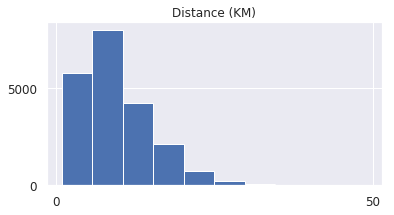

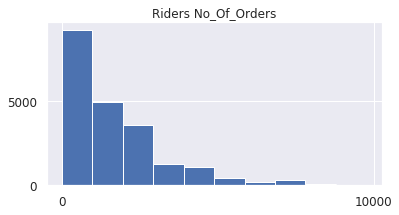

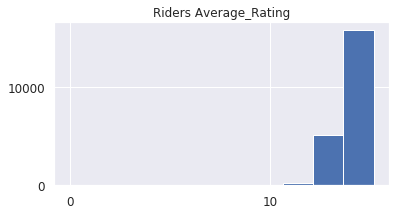

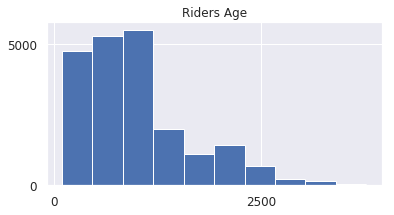

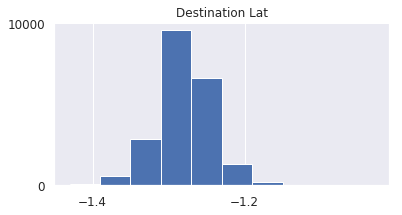

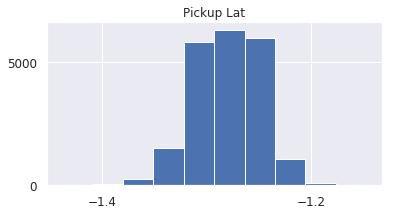

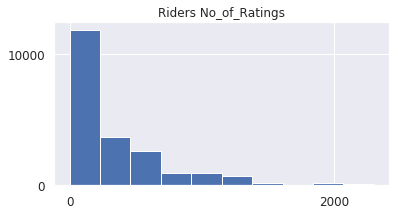

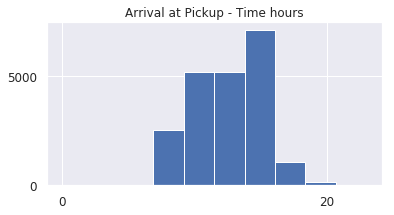

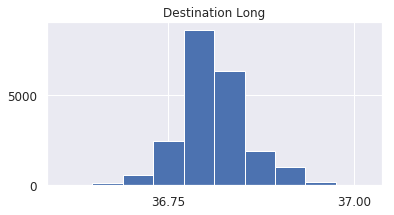

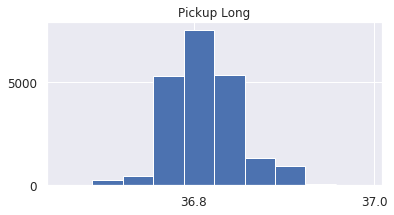

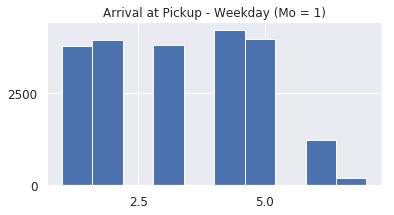

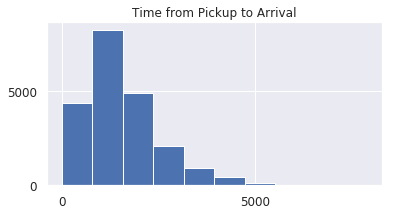

In [359]:
# combined_with_riders[passive_important_features[:4]].hist(bins=30)
# import matplotlib
# matplotlib.rcParams.update({'font.size': 12})
for col in combined_with_riders.columns:
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.hist(combined_with_riders[col][combined_with_riders[y_label].notnull()])
    ax.set_title(col)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

In [367]:
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from xgboost import XGBRegressor

In [368]:
train, test = split_train_test_set(combined_with_riders, y_label)

In [369]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=[y_label, 'Order No']), train[y_label])

In [370]:
test = test.drop(columns=[y_label])

In [371]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.001,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
    
train_set = lgbm.Dataset(X_train, y_train, silent=False)
valid_set = lgbm.Dataset(X_test, y_test, silent=False)
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500, valid_sets=valid_set)

[1]	valid_0's rmse: 996.234
Training until validation scores don't improve for 500 rounds
[2]	valid_0's rmse: 995.868
[3]	valid_0's rmse: 995.502
[4]	valid_0's rmse: 995.131
[5]	valid_0's rmse: 994.77
[6]	valid_0's rmse: 994.405
[7]	valid_0's rmse: 994.035
[8]	valid_0's rmse: 993.793
[9]	valid_0's rmse: 993.428
[10]	valid_0's rmse: 993.067
[11]	valid_0's rmse: 992.701
[12]	valid_0's rmse: 992.343
[13]	valid_0's rmse: 991.98
[14]	valid_0's rmse: 991.624
[15]	valid_0's rmse: 991.385
[16]	valid_0's rmse: 991.13
[17]	valid_0's rmse: 990.77
[18]	valid_0's rmse: 990.409
[19]	valid_0's rmse: 990.052
[20]	valid_0's rmse: 989.781
[21]	valid_0's rmse: 989.426
[22]	valid_0's rmse: 989.239
[23]	valid_0's rmse: 988.882
[24]	valid_0's rmse: 988.529
[25]	valid_0's rmse: 988.391
[26]	valid_0's rmse: 988.034
[27]	valid_0's rmse: 987.677
[28]	valid_0's rmse: 987.321
[29]	valid_0's rmse: 986.968
[30]	valid_0's rmse: 986.61
[31]	valid_0's rmse: 986.341
[32]	valid_0's rmse: 986.134
[33]	valid_0's rmse: 986

[322]	valid_0's rmse: 914.424
[323]	valid_0's rmse: 914.186
[324]	valid_0's rmse: 913.95
[325]	valid_0's rmse: 913.789
[326]	valid_0's rmse: 913.556
[327]	valid_0's rmse: 913.403
[328]	valid_0's rmse: 913.175
[329]	valid_0's rmse: 912.938
[330]	valid_0's rmse: 912.786
[331]	valid_0's rmse: 912.545
[332]	valid_0's rmse: 912.31
[333]	valid_0's rmse: 912.071
[334]	valid_0's rmse: 911.974
[335]	valid_0's rmse: 911.735
[336]	valid_0's rmse: 911.614
[337]	valid_0's rmse: 911.517
[338]	valid_0's rmse: 911.29
[339]	valid_0's rmse: 911.223
[340]	valid_0's rmse: 910.994
[341]	valid_0's rmse: 910.762
[342]	valid_0's rmse: 910.613
[343]	valid_0's rmse: 910.381
[344]	valid_0's rmse: 910.223
[345]	valid_0's rmse: 910.077
[346]	valid_0's rmse: 909.85
[347]	valid_0's rmse: 909.619
[348]	valid_0's rmse: 909.388
[349]	valid_0's rmse: 909.154
[350]	valid_0's rmse: 908.979
[351]	valid_0's rmse: 908.752
[352]	valid_0's rmse: 908.527
[353]	valid_0's rmse: 908.302
[354]	valid_0's rmse: 908.16
[355]	valid_0's

[649]	valid_0's rmse: 860.729
[650]	valid_0's rmse: 860.582
[651]	valid_0's rmse: 860.469
[652]	valid_0's rmse: 860.316
[653]	valid_0's rmse: 860.163
[654]	valid_0's rmse: 860.01
[655]	valid_0's rmse: 859.854
[656]	valid_0's rmse: 859.746
[657]	valid_0's rmse: 859.638
[658]	valid_0's rmse: 859.494
[659]	valid_0's rmse: 859.343
[660]	valid_0's rmse: 859.195
[661]	valid_0's rmse: 859.048
[662]	valid_0's rmse: 858.898
[663]	valid_0's rmse: 858.75
[664]	valid_0's rmse: 858.602
[665]	valid_0's rmse: 858.513
[666]	valid_0's rmse: 858.427
[667]	valid_0's rmse: 858.285
[668]	valid_0's rmse: 858.137
[669]	valid_0's rmse: 858.048
[670]	valid_0's rmse: 857.986
[671]	valid_0's rmse: 857.839
[672]	valid_0's rmse: 857.686
[673]	valid_0's rmse: 857.54
[674]	valid_0's rmse: 857.44
[675]	valid_0's rmse: 857.341
[676]	valid_0's rmse: 857.2
[677]	valid_0's rmse: 857.141
[678]	valid_0's rmse: 856.996
[679]	valid_0's rmse: 856.855
[680]	valid_0's rmse: 856.712
[681]	valid_0's rmse: 856.65
[682]	valid_0's r

[947]	valid_0's rmse: 829.084
[948]	valid_0's rmse: 828.987
[949]	valid_0's rmse: 828.885
[950]	valid_0's rmse: 828.789
[951]	valid_0's rmse: 828.728
[952]	valid_0's rmse: 828.685
[953]	valid_0's rmse: 828.633
[954]	valid_0's rmse: 828.542
[955]	valid_0's rmse: 828.475
[956]	valid_0's rmse: 828.401
[957]	valid_0's rmse: 828.299
[958]	valid_0's rmse: 828.196
[959]	valid_0's rmse: 828.132
[960]	valid_0's rmse: 828.036
[961]	valid_0's rmse: 827.94
[962]	valid_0's rmse: 827.868
[963]	valid_0's rmse: 827.767
[964]	valid_0's rmse: 827.695
[965]	valid_0's rmse: 827.603
[966]	valid_0's rmse: 827.535
[967]	valid_0's rmse: 827.436
[968]	valid_0's rmse: 827.341
[969]	valid_0's rmse: 827.241
[970]	valid_0's rmse: 827.146
[971]	valid_0's rmse: 827.082
[972]	valid_0's rmse: 827.01
[973]	valid_0's rmse: 826.915
[974]	valid_0's rmse: 826.818
[975]	valid_0's rmse: 826.752
[976]	valid_0's rmse: 826.659
[977]	valid_0's rmse: 826.588
[978]	valid_0's rmse: 826.495
[979]	valid_0's rmse: 826.399
[980]	valid_

[1215]	valid_0's rmse: 809.847
[1216]	valid_0's rmse: 809.814
[1217]	valid_0's rmse: 809.761
[1218]	valid_0's rmse: 809.695
[1219]	valid_0's rmse: 809.622
[1220]	valid_0's rmse: 809.554
[1221]	valid_0's rmse: 809.528
[1222]	valid_0's rmse: 809.479
[1223]	valid_0's rmse: 809.411
[1224]	valid_0's rmse: 809.345
[1225]	valid_0's rmse: 809.3
[1226]	valid_0's rmse: 809.229
[1227]	valid_0's rmse: 809.162
[1228]	valid_0's rmse: 809.115
[1229]	valid_0's rmse: 809.045
[1230]	valid_0's rmse: 809.002
[1231]	valid_0's rmse: 808.935
[1232]	valid_0's rmse: 808.907
[1233]	valid_0's rmse: 808.86
[1234]	valid_0's rmse: 808.79
[1235]	valid_0's rmse: 808.722
[1236]	valid_0's rmse: 808.676
[1237]	valid_0's rmse: 808.611
[1238]	valid_0's rmse: 808.544
[1239]	valid_0's rmse: 808.478
[1240]	valid_0's rmse: 808.408
[1241]	valid_0's rmse: 808.339
[1242]	valid_0's rmse: 808.269
[1243]	valid_0's rmse: 808.207
[1244]	valid_0's rmse: 808.182
[1245]	valid_0's rmse: 808.135
[1246]	valid_0's rmse: 808.064
[1247]	valid

[1532]	valid_0's rmse: 794.605
[1533]	valid_0's rmse: 794.586
[1534]	valid_0's rmse: 794.536
[1535]	valid_0's rmse: 794.489
[1536]	valid_0's rmse: 794.442
[1537]	valid_0's rmse: 794.395
[1538]	valid_0's rmse: 794.354
[1539]	valid_0's rmse: 794.305
[1540]	valid_0's rmse: 794.257
[1541]	valid_0's rmse: 794.209
[1542]	valid_0's rmse: 794.18
[1543]	valid_0's rmse: 794.151
[1544]	valid_0's rmse: 794.105
[1545]	valid_0's rmse: 794.056
[1546]	valid_0's rmse: 794.015
[1547]	valid_0's rmse: 793.963
[1548]	valid_0's rmse: 793.915
[1549]	valid_0's rmse: 793.869
[1550]	valid_0's rmse: 793.825
[1551]	valid_0's rmse: 793.779
[1552]	valid_0's rmse: 793.752
[1553]	valid_0's rmse: 793.719
[1554]	valid_0's rmse: 793.689
[1555]	valid_0's rmse: 793.659
[1556]	valid_0's rmse: 793.64
[1557]	valid_0's rmse: 793.593
[1558]	valid_0's rmse: 793.563
[1559]	valid_0's rmse: 793.534
[1560]	valid_0's rmse: 793.506
[1561]	valid_0's rmse: 793.463
[1562]	valid_0's rmse: 793.416
[1563]	valid_0's rmse: 793.369
[1564]	val

[1825]	valid_0's rmse: 784.501
[1826]	valid_0's rmse: 784.477
[1827]	valid_0's rmse: 784.451
[1828]	valid_0's rmse: 784.421
[1829]	valid_0's rmse: 784.388
[1830]	valid_0's rmse: 784.359
[1831]	valid_0's rmse: 784.327
[1832]	valid_0's rmse: 784.312
[1833]	valid_0's rmse: 784.286
[1834]	valid_0's rmse: 784.257
[1835]	valid_0's rmse: 784.222
[1836]	valid_0's rmse: 784.197
[1837]	valid_0's rmse: 784.18
[1838]	valid_0's rmse: 784.15
[1839]	valid_0's rmse: 784.117
[1840]	valid_0's rmse: 784.087
[1841]	valid_0's rmse: 784.065
[1842]	valid_0's rmse: 784.031
[1843]	valid_0's rmse: 784.014
[1844]	valid_0's rmse: 783.992
[1845]	valid_0's rmse: 783.957
[1846]	valid_0's rmse: 783.925
[1847]	valid_0's rmse: 783.906
[1848]	valid_0's rmse: 783.877
[1849]	valid_0's rmse: 783.844
[1850]	valid_0's rmse: 783.813
[1851]	valid_0's rmse: 783.792
[1852]	valid_0's rmse: 783.775
[1853]	valid_0's rmse: 783.747
[1854]	valid_0's rmse: 783.721
[1855]	valid_0's rmse: 783.692
[1856]	valid_0's rmse: 783.659
[1857]	val

[2103]	valid_0's rmse: 777.764
[2104]	valid_0's rmse: 777.737
[2105]	valid_0's rmse: 777.711
[2106]	valid_0's rmse: 777.689
[2107]	valid_0's rmse: 777.666
[2108]	valid_0's rmse: 777.653
[2109]	valid_0's rmse: 777.628
[2110]	valid_0's rmse: 777.603
[2111]	valid_0's rmse: 777.583
[2112]	valid_0's rmse: 777.565
[2113]	valid_0's rmse: 777.542
[2114]	valid_0's rmse: 777.523
[2115]	valid_0's rmse: 777.497
[2116]	valid_0's rmse: 777.476
[2117]	valid_0's rmse: 777.456
[2118]	valid_0's rmse: 777.433
[2119]	valid_0's rmse: 777.412
[2120]	valid_0's rmse: 777.39
[2121]	valid_0's rmse: 777.361
[2122]	valid_0's rmse: 777.348
[2123]	valid_0's rmse: 777.329
[2124]	valid_0's rmse: 777.312
[2125]	valid_0's rmse: 777.288
[2126]	valid_0's rmse: 777.268
[2127]	valid_0's rmse: 777.245
[2128]	valid_0's rmse: 777.227
[2129]	valid_0's rmse: 777.207
[2130]	valid_0's rmse: 777.182
[2131]	valid_0's rmse: 777.162
[2132]	valid_0's rmse: 777.145
[2133]	valid_0's rmse: 777.125
[2134]	valid_0's rmse: 777.104
[2135]	va

[2369]	valid_0's rmse: 772.684
[2370]	valid_0's rmse: 772.66
[2371]	valid_0's rmse: 772.641
[2372]	valid_0's rmse: 772.624
[2373]	valid_0's rmse: 772.604
[2374]	valid_0's rmse: 772.586
[2375]	valid_0's rmse: 772.566
[2376]	valid_0's rmse: 772.549
[2377]	valid_0's rmse: 772.531
[2378]	valid_0's rmse: 772.516
[2379]	valid_0's rmse: 772.5
[2380]	valid_0's rmse: 772.485
[2381]	valid_0's rmse: 772.462
[2382]	valid_0's rmse: 772.444
[2383]	valid_0's rmse: 772.424
[2384]	valid_0's rmse: 772.405
[2385]	valid_0's rmse: 772.383
[2386]	valid_0's rmse: 772.371
[2387]	valid_0's rmse: 772.354
[2388]	valid_0's rmse: 772.346
[2389]	valid_0's rmse: 772.325
[2390]	valid_0's rmse: 772.309
[2391]	valid_0's rmse: 772.293
[2392]	valid_0's rmse: 772.274
[2393]	valid_0's rmse: 772.257
[2394]	valid_0's rmse: 772.237
[2395]	valid_0's rmse: 772.217
[2396]	valid_0's rmse: 772.2
[2397]	valid_0's rmse: 772.185
[2398]	valid_0's rmse: 772.168
[2399]	valid_0's rmse: 772.151
[2400]	valid_0's rmse: 772.133
[2401]	valid_

[2690]	valid_0's rmse: 767.905
[2691]	valid_0's rmse: 767.888
[2692]	valid_0's rmse: 767.875
[2693]	valid_0's rmse: 767.861
[2694]	valid_0's rmse: 767.849
[2695]	valid_0's rmse: 767.837
[2696]	valid_0's rmse: 767.823
[2697]	valid_0's rmse: 767.808
[2698]	valid_0's rmse: 767.794
[2699]	valid_0's rmse: 767.781
[2700]	valid_0's rmse: 767.765
[2701]	valid_0's rmse: 767.755
[2702]	valid_0's rmse: 767.742
[2703]	valid_0's rmse: 767.73
[2704]	valid_0's rmse: 767.719
[2705]	valid_0's rmse: 767.708
[2706]	valid_0's rmse: 767.692
[2707]	valid_0's rmse: 767.679
[2708]	valid_0's rmse: 767.667
[2709]	valid_0's rmse: 767.652
[2710]	valid_0's rmse: 767.641
[2711]	valid_0's rmse: 767.631
[2712]	valid_0's rmse: 767.618
[2713]	valid_0's rmse: 767.605
[2714]	valid_0's rmse: 767.591
[2715]	valid_0's rmse: 767.58
[2716]	valid_0's rmse: 767.566
[2717]	valid_0's rmse: 767.551
[2718]	valid_0's rmse: 767.538
[2719]	valid_0's rmse: 767.524
[2720]	valid_0's rmse: 767.512
[2721]	valid_0's rmse: 767.499
[2722]	val

[2962]	valid_0's rmse: 764.736
[2963]	valid_0's rmse: 764.725
[2964]	valid_0's rmse: 764.717
[2965]	valid_0's rmse: 764.707
[2966]	valid_0's rmse: 764.696
[2967]	valid_0's rmse: 764.686
[2968]	valid_0's rmse: 764.675
[2969]	valid_0's rmse: 764.663
[2970]	valid_0's rmse: 764.649
[2971]	valid_0's rmse: 764.637
[2972]	valid_0's rmse: 764.629
[2973]	valid_0's rmse: 764.62
[2974]	valid_0's rmse: 764.604
[2975]	valid_0's rmse: 764.595
[2976]	valid_0's rmse: 764.582
[2977]	valid_0's rmse: 764.569
[2978]	valid_0's rmse: 764.555
[2979]	valid_0's rmse: 764.542
[2980]	valid_0's rmse: 764.534
[2981]	valid_0's rmse: 764.522
[2982]	valid_0's rmse: 764.51
[2983]	valid_0's rmse: 764.498
[2984]	valid_0's rmse: 764.489
[2985]	valid_0's rmse: 764.478
[2986]	valid_0's rmse: 764.467
[2987]	valid_0's rmse: 764.454
[2988]	valid_0's rmse: 764.439
[2989]	valid_0's rmse: 764.427
[2990]	valid_0's rmse: 764.414
[2991]	valid_0's rmse: 764.402
[2992]	valid_0's rmse: 764.39
[2993]	valid_0's rmse: 764.378
[2994]	vali

[3238]	valid_0's rmse: 762.001
[3239]	valid_0's rmse: 761.989
[3240]	valid_0's rmse: 761.982
[3241]	valid_0's rmse: 761.971
[3242]	valid_0's rmse: 761.964
[3243]	valid_0's rmse: 761.954
[3244]	valid_0's rmse: 761.943
[3245]	valid_0's rmse: 761.935
[3246]	valid_0's rmse: 761.924
[3247]	valid_0's rmse: 761.912
[3248]	valid_0's rmse: 761.9
[3249]	valid_0's rmse: 761.893
[3250]	valid_0's rmse: 761.88
[3251]	valid_0's rmse: 761.874
[3252]	valid_0's rmse: 761.868
[3253]	valid_0's rmse: 761.857
[3254]	valid_0's rmse: 761.846
[3255]	valid_0's rmse: 761.838
[3256]	valid_0's rmse: 761.828
[3257]	valid_0's rmse: 761.818
[3258]	valid_0's rmse: 761.812
[3259]	valid_0's rmse: 761.805
[3260]	valid_0's rmse: 761.794
[3261]	valid_0's rmse: 761.787
[3262]	valid_0's rmse: 761.78
[3263]	valid_0's rmse: 761.768
[3264]	valid_0's rmse: 761.764
[3265]	valid_0's rmse: 761.757
[3266]	valid_0's rmse: 761.745
[3267]	valid_0's rmse: 761.739
[3268]	valid_0's rmse: 761.729
[3269]	valid_0's rmse: 761.719
[3270]	valid

[3525]	valid_0's rmse: 759.703
[3526]	valid_0's rmse: 759.695
[3527]	valid_0's rmse: 759.687
[3528]	valid_0's rmse: 759.678
[3529]	valid_0's rmse: 759.672
[3530]	valid_0's rmse: 759.658
[3531]	valid_0's rmse: 759.652
[3532]	valid_0's rmse: 759.642
[3533]	valid_0's rmse: 759.633
[3534]	valid_0's rmse: 759.633
[3535]	valid_0's rmse: 759.628
[3536]	valid_0's rmse: 759.622
[3537]	valid_0's rmse: 759.615
[3538]	valid_0's rmse: 759.603
[3539]	valid_0's rmse: 759.594
[3540]	valid_0's rmse: 759.583
[3541]	valid_0's rmse: 759.58
[3542]	valid_0's rmse: 759.575
[3543]	valid_0's rmse: 759.568
[3544]	valid_0's rmse: 759.559
[3545]	valid_0's rmse: 759.555
[3546]	valid_0's rmse: 759.544
[3547]	valid_0's rmse: 759.534
[3548]	valid_0's rmse: 759.527
[3549]	valid_0's rmse: 759.523
[3550]	valid_0's rmse: 759.517
[3551]	valid_0's rmse: 759.506
[3552]	valid_0's rmse: 759.496
[3553]	valid_0's rmse: 759.485
[3554]	valid_0's rmse: 759.485
[3555]	valid_0's rmse: 759.476
[3556]	valid_0's rmse: 759.468
[3557]	va

[3812]	valid_0's rmse: 757.779
[3813]	valid_0's rmse: 757.767
[3814]	valid_0's rmse: 757.766
[3815]	valid_0's rmse: 757.761
[3816]	valid_0's rmse: 757.753
[3817]	valid_0's rmse: 757.749
[3818]	valid_0's rmse: 757.742
[3819]	valid_0's rmse: 757.734
[3820]	valid_0's rmse: 757.73
[3821]	valid_0's rmse: 757.726
[3822]	valid_0's rmse: 757.716
[3823]	valid_0's rmse: 757.71
[3824]	valid_0's rmse: 757.709
[3825]	valid_0's rmse: 757.704
[3826]	valid_0's rmse: 757.702
[3827]	valid_0's rmse: 757.696
[3828]	valid_0's rmse: 757.692
[3829]	valid_0's rmse: 757.685
[3830]	valid_0's rmse: 757.68
[3831]	valid_0's rmse: 757.674
[3832]	valid_0's rmse: 757.671
[3833]	valid_0's rmse: 757.662
[3834]	valid_0's rmse: 757.657
[3835]	valid_0's rmse: 757.65
[3836]	valid_0's rmse: 757.646
[3837]	valid_0's rmse: 757.639
[3838]	valid_0's rmse: 757.627
[3839]	valid_0's rmse: 757.623
[3840]	valid_0's rmse: 757.618
[3841]	valid_0's rmse: 757.612
[3842]	valid_0's rmse: 757.608
[3843]	valid_0's rmse: 757.603
[3844]	valid

[4109]	valid_0's rmse: 756.101
[4110]	valid_0's rmse: 756.096
[4111]	valid_0's rmse: 756.094
[4112]	valid_0's rmse: 756.09
[4113]	valid_0's rmse: 756.087
[4114]	valid_0's rmse: 756.083
[4115]	valid_0's rmse: 756.073
[4116]	valid_0's rmse: 756.065
[4117]	valid_0's rmse: 756.054
[4118]	valid_0's rmse: 756.049
[4119]	valid_0's rmse: 756.042
[4120]	valid_0's rmse: 756.036
[4121]	valid_0's rmse: 756.032
[4122]	valid_0's rmse: 756.027
[4123]	valid_0's rmse: 756.024
[4124]	valid_0's rmse: 756.02
[4125]	valid_0's rmse: 756.017
[4126]	valid_0's rmse: 756.011
[4127]	valid_0's rmse: 756.006
[4128]	valid_0's rmse: 756.001
[4129]	valid_0's rmse: 755.991
[4130]	valid_0's rmse: 755.985
[4131]	valid_0's rmse: 755.98
[4132]	valid_0's rmse: 755.976
[4133]	valid_0's rmse: 755.97
[4134]	valid_0's rmse: 755.962
[4135]	valid_0's rmse: 755.957
[4136]	valid_0's rmse: 755.957
[4137]	valid_0's rmse: 755.951
[4138]	valid_0's rmse: 755.948
[4139]	valid_0's rmse: 755.945
[4140]	valid_0's rmse: 755.938
[4141]	valid

[4409]	valid_0's rmse: 754.576
[4410]	valid_0's rmse: 754.569
[4411]	valid_0's rmse: 754.566
[4412]	valid_0's rmse: 754.559
[4413]	valid_0's rmse: 754.554
[4414]	valid_0's rmse: 754.547
[4415]	valid_0's rmse: 754.539
[4416]	valid_0's rmse: 754.532
[4417]	valid_0's rmse: 754.529
[4418]	valid_0's rmse: 754.527
[4419]	valid_0's rmse: 754.519
[4420]	valid_0's rmse: 754.515
[4421]	valid_0's rmse: 754.506
[4422]	valid_0's rmse: 754.502
[4423]	valid_0's rmse: 754.498
[4424]	valid_0's rmse: 754.491
[4425]	valid_0's rmse: 754.49
[4426]	valid_0's rmse: 754.485
[4427]	valid_0's rmse: 754.478
[4428]	valid_0's rmse: 754.476
[4429]	valid_0's rmse: 754.471
[4430]	valid_0's rmse: 754.462
[4431]	valid_0's rmse: 754.457
[4432]	valid_0's rmse: 754.453
[4433]	valid_0's rmse: 754.45
[4434]	valid_0's rmse: 754.45
[4435]	valid_0's rmse: 754.441
[4436]	valid_0's rmse: 754.437
[4437]	valid_0's rmse: 754.431
[4438]	valid_0's rmse: 754.426
[4439]	valid_0's rmse: 754.424
[4440]	valid_0's rmse: 754.418
[4441]	vali

[4709]	valid_0's rmse: 753.302
[4710]	valid_0's rmse: 753.296
[4711]	valid_0's rmse: 753.291
[4712]	valid_0's rmse: 753.287
[4713]	valid_0's rmse: 753.283
[4714]	valid_0's rmse: 753.278
[4715]	valid_0's rmse: 753.274
[4716]	valid_0's rmse: 753.272
[4717]	valid_0's rmse: 753.27
[4718]	valid_0's rmse: 753.267
[4719]	valid_0's rmse: 753.258
[4720]	valid_0's rmse: 753.257
[4721]	valid_0's rmse: 753.253
[4722]	valid_0's rmse: 753.248
[4723]	valid_0's rmse: 753.243
[4724]	valid_0's rmse: 753.239
[4725]	valid_0's rmse: 753.239
[4726]	valid_0's rmse: 753.236
[4727]	valid_0's rmse: 753.23
[4728]	valid_0's rmse: 753.229
[4729]	valid_0's rmse: 753.224
[4730]	valid_0's rmse: 753.221
[4731]	valid_0's rmse: 753.22
[4732]	valid_0's rmse: 753.215
[4733]	valid_0's rmse: 753.215
[4734]	valid_0's rmse: 753.21
[4735]	valid_0's rmse: 753.204
[4736]	valid_0's rmse: 753.202
[4737]	valid_0's rmse: 753.199
[4738]	valid_0's rmse: 753.196
[4739]	valid_0's rmse: 753.193
[4740]	valid_0's rmse: 753.192
[4741]	valid

[5022]	valid_0's rmse: 752.232
[5023]	valid_0's rmse: 752.227
[5024]	valid_0's rmse: 752.227
[5025]	valid_0's rmse: 752.223
[5026]	valid_0's rmse: 752.219
[5027]	valid_0's rmse: 752.217
[5028]	valid_0's rmse: 752.215
[5029]	valid_0's rmse: 752.209
[5030]	valid_0's rmse: 752.209
[5031]	valid_0's rmse: 752.203
[5032]	valid_0's rmse: 752.2
[5033]	valid_0's rmse: 752.198
[5034]	valid_0's rmse: 752.194
[5035]	valid_0's rmse: 752.19
[5036]	valid_0's rmse: 752.188
[5037]	valid_0's rmse: 752.187
[5038]	valid_0's rmse: 752.181
[5039]	valid_0's rmse: 752.177
[5040]	valid_0's rmse: 752.174
[5041]	valid_0's rmse: 752.173
[5042]	valid_0's rmse: 752.173
[5043]	valid_0's rmse: 752.168
[5044]	valid_0's rmse: 752.162
[5045]	valid_0's rmse: 752.156
[5046]	valid_0's rmse: 752.154
[5047]	valid_0's rmse: 752.152
[5048]	valid_0's rmse: 752.148
[5049]	valid_0's rmse: 752.147
[5050]	valid_0's rmse: 752.145
[5051]	valid_0's rmse: 752.143
[5052]	valid_0's rmse: 752.138
[5053]	valid_0's rmse: 752.138
[5054]	vali

[5342]	valid_0's rmse: 751.244
[5343]	valid_0's rmse: 751.237
[5344]	valid_0's rmse: 751.235
[5345]	valid_0's rmse: 751.231
[5346]	valid_0's rmse: 751.226
[5347]	valid_0's rmse: 751.222
[5348]	valid_0's rmse: 751.222
[5349]	valid_0's rmse: 751.221
[5350]	valid_0's rmse: 751.221
[5351]	valid_0's rmse: 751.217
[5352]	valid_0's rmse: 751.213
[5353]	valid_0's rmse: 751.207
[5354]	valid_0's rmse: 751.202
[5355]	valid_0's rmse: 751.201
[5356]	valid_0's rmse: 751.197
[5357]	valid_0's rmse: 751.195
[5358]	valid_0's rmse: 751.192
[5359]	valid_0's rmse: 751.189
[5360]	valid_0's rmse: 751.188
[5361]	valid_0's rmse: 751.184
[5362]	valid_0's rmse: 751.182
[5363]	valid_0's rmse: 751.178
[5364]	valid_0's rmse: 751.174
[5365]	valid_0's rmse: 751.169
[5366]	valid_0's rmse: 751.165
[5367]	valid_0's rmse: 751.158
[5368]	valid_0's rmse: 751.157
[5369]	valid_0's rmse: 751.155
[5370]	valid_0's rmse: 751.152
[5371]	valid_0's rmse: 751.148
[5372]	valid_0's rmse: 751.146
[5373]	valid_0's rmse: 751.141
[5374]	v

[5659]	valid_0's rmse: 750.393
[5660]	valid_0's rmse: 750.393
[5661]	valid_0's rmse: 750.391
[5662]	valid_0's rmse: 750.388
[5663]	valid_0's rmse: 750.384
[5664]	valid_0's rmse: 750.383
[5665]	valid_0's rmse: 750.383
[5666]	valid_0's rmse: 750.383
[5667]	valid_0's rmse: 750.381
[5668]	valid_0's rmse: 750.381
[5669]	valid_0's rmse: 750.38
[5670]	valid_0's rmse: 750.38
[5671]	valid_0's rmse: 750.376
[5672]	valid_0's rmse: 750.375
[5673]	valid_0's rmse: 750.373
[5674]	valid_0's rmse: 750.367
[5675]	valid_0's rmse: 750.363
[5676]	valid_0's rmse: 750.361
[5677]	valid_0's rmse: 750.356
[5678]	valid_0's rmse: 750.355
[5679]	valid_0's rmse: 750.353
[5680]	valid_0's rmse: 750.353
[5681]	valid_0's rmse: 750.351
[5682]	valid_0's rmse: 750.349
[5683]	valid_0's rmse: 750.35
[5684]	valid_0's rmse: 750.349
[5685]	valid_0's rmse: 750.346
[5686]	valid_0's rmse: 750.345
[5687]	valid_0's rmse: 750.339
[5688]	valid_0's rmse: 750.338
[5689]	valid_0's rmse: 750.336
[5690]	valid_0's rmse: 750.333
[5691]	vali

[5984]	valid_0's rmse: 749.716
[5985]	valid_0's rmse: 749.715
[5986]	valid_0's rmse: 749.713
[5987]	valid_0's rmse: 749.709
[5988]	valid_0's rmse: 749.703
[5989]	valid_0's rmse: 749.7
[5990]	valid_0's rmse: 749.698
[5991]	valid_0's rmse: 749.697
[5992]	valid_0's rmse: 749.698
[5993]	valid_0's rmse: 749.699
[5994]	valid_0's rmse: 749.698
[5995]	valid_0's rmse: 749.698
[5996]	valid_0's rmse: 749.699
[5997]	valid_0's rmse: 749.697
[5998]	valid_0's rmse: 749.695
[5999]	valid_0's rmse: 749.696
[6000]	valid_0's rmse: 749.695
[6001]	valid_0's rmse: 749.694
[6002]	valid_0's rmse: 749.691
[6003]	valid_0's rmse: 749.69
[6004]	valid_0's rmse: 749.691
[6005]	valid_0's rmse: 749.69
[6006]	valid_0's rmse: 749.688
[6007]	valid_0's rmse: 749.689
[6008]	valid_0's rmse: 749.688
[6009]	valid_0's rmse: 749.689
[6010]	valid_0's rmse: 749.689
[6011]	valid_0's rmse: 749.689
[6012]	valid_0's rmse: 749.688
[6013]	valid_0's rmse: 749.688
[6014]	valid_0's rmse: 749.689
[6015]	valid_0's rmse: 749.686
[6016]	valid

[6253]	valid_0's rmse: 749.22
[6254]	valid_0's rmse: 749.219
[6255]	valid_0's rmse: 749.216
[6256]	valid_0's rmse: 749.213
[6257]	valid_0's rmse: 749.215
[6258]	valid_0's rmse: 749.212
[6259]	valid_0's rmse: 749.213
[6260]	valid_0's rmse: 749.21
[6261]	valid_0's rmse: 749.208
[6262]	valid_0's rmse: 749.205
[6263]	valid_0's rmse: 749.202
[6264]	valid_0's rmse: 749.2
[6265]	valid_0's rmse: 749.2
[6266]	valid_0's rmse: 749.198
[6267]	valid_0's rmse: 749.194
[6268]	valid_0's rmse: 749.189
[6269]	valid_0's rmse: 749.19
[6270]	valid_0's rmse: 749.186
[6271]	valid_0's rmse: 749.185
[6272]	valid_0's rmse: 749.182
[6273]	valid_0's rmse: 749.182
[6274]	valid_0's rmse: 749.18
[6275]	valid_0's rmse: 749.178
[6276]	valid_0's rmse: 749.177
[6277]	valid_0's rmse: 749.177
[6278]	valid_0's rmse: 749.176
[6279]	valid_0's rmse: 749.174
[6280]	valid_0's rmse: 749.174
[6281]	valid_0's rmse: 749.173
[6282]	valid_0's rmse: 749.17
[6283]	valid_0's rmse: 749.169
[6284]	valid_0's rmse: 749.167
[6285]	valid_0's 

[6588]	valid_0's rmse: 748.662
[6589]	valid_0's rmse: 748.662
[6590]	valid_0's rmse: 748.66
[6591]	valid_0's rmse: 748.656
[6592]	valid_0's rmse: 748.656
[6593]	valid_0's rmse: 748.654
[6594]	valid_0's rmse: 748.651
[6595]	valid_0's rmse: 748.651
[6596]	valid_0's rmse: 748.648
[6597]	valid_0's rmse: 748.646
[6598]	valid_0's rmse: 748.645
[6599]	valid_0's rmse: 748.646
[6600]	valid_0's rmse: 748.646
[6601]	valid_0's rmse: 748.642
[6602]	valid_0's rmse: 748.639
[6603]	valid_0's rmse: 748.637
[6604]	valid_0's rmse: 748.634
[6605]	valid_0's rmse: 748.635
[6606]	valid_0's rmse: 748.633
[6607]	valid_0's rmse: 748.63
[6608]	valid_0's rmse: 748.629
[6609]	valid_0's rmse: 748.628
[6610]	valid_0's rmse: 748.627
[6611]	valid_0's rmse: 748.627
[6612]	valid_0's rmse: 748.626
[6613]	valid_0's rmse: 748.623
[6614]	valid_0's rmse: 748.622
[6615]	valid_0's rmse: 748.621
[6616]	valid_0's rmse: 748.619
[6617]	valid_0's rmse: 748.62
[6618]	valid_0's rmse: 748.618
[6619]	valid_0's rmse: 748.616
[6620]	vali

[6859]	valid_0's rmse: 748.195
[6860]	valid_0's rmse: 748.194
[6861]	valid_0's rmse: 748.194
[6862]	valid_0's rmse: 748.192
[6863]	valid_0's rmse: 748.194
[6864]	valid_0's rmse: 748.194
[6865]	valid_0's rmse: 748.194
[6866]	valid_0's rmse: 748.192
[6867]	valid_0's rmse: 748.191
[6868]	valid_0's rmse: 748.189
[6869]	valid_0's rmse: 748.186
[6870]	valid_0's rmse: 748.186
[6871]	valid_0's rmse: 748.183
[6872]	valid_0's rmse: 748.184
[6873]	valid_0's rmse: 748.184
[6874]	valid_0's rmse: 748.181
[6875]	valid_0's rmse: 748.18
[6876]	valid_0's rmse: 748.177
[6877]	valid_0's rmse: 748.177
[6878]	valid_0's rmse: 748.174
[6879]	valid_0's rmse: 748.174
[6880]	valid_0's rmse: 748.169
[6881]	valid_0's rmse: 748.168
[6882]	valid_0's rmse: 748.166
[6883]	valid_0's rmse: 748.167
[6884]	valid_0's rmse: 748.167
[6885]	valid_0's rmse: 748.163
[6886]	valid_0's rmse: 748.162
[6887]	valid_0's rmse: 748.161
[6888]	valid_0's rmse: 748.156
[6889]	valid_0's rmse: 748.153
[6890]	valid_0's rmse: 748.153
[6891]	va

[7131]	valid_0's rmse: 747.82
[7132]	valid_0's rmse: 747.819
[7133]	valid_0's rmse: 747.818
[7134]	valid_0's rmse: 747.815
[7135]	valid_0's rmse: 747.81
[7136]	valid_0's rmse: 747.809
[7137]	valid_0's rmse: 747.81
[7138]	valid_0's rmse: 747.809
[7139]	valid_0's rmse: 747.806
[7140]	valid_0's rmse: 747.805
[7141]	valid_0's rmse: 747.803
[7142]	valid_0's rmse: 747.804
[7143]	valid_0's rmse: 747.804
[7144]	valid_0's rmse: 747.803
[7145]	valid_0's rmse: 747.802
[7146]	valid_0's rmse: 747.799
[7147]	valid_0's rmse: 747.799
[7148]	valid_0's rmse: 747.8
[7149]	valid_0's rmse: 747.8
[7150]	valid_0's rmse: 747.798
[7151]	valid_0's rmse: 747.795
[7152]	valid_0's rmse: 747.793
[7153]	valid_0's rmse: 747.79
[7154]	valid_0's rmse: 747.787
[7155]	valid_0's rmse: 747.786
[7156]	valid_0's rmse: 747.788
[7157]	valid_0's rmse: 747.788
[7158]	valid_0's rmse: 747.788
[7159]	valid_0's rmse: 747.787
[7160]	valid_0's rmse: 747.782
[7161]	valid_0's rmse: 747.78
[7162]	valid_0's rmse: 747.779
[7163]	valid_0's 

[7408]	valid_0's rmse: 747.479
[7409]	valid_0's rmse: 747.478
[7410]	valid_0's rmse: 747.475
[7411]	valid_0's rmse: 747.475
[7412]	valid_0's rmse: 747.476
[7413]	valid_0's rmse: 747.476
[7414]	valid_0's rmse: 747.476
[7415]	valid_0's rmse: 747.473
[7416]	valid_0's rmse: 747.473
[7417]	valid_0's rmse: 747.47
[7418]	valid_0's rmse: 747.468
[7419]	valid_0's rmse: 747.468
[7420]	valid_0's rmse: 747.469
[7421]	valid_0's rmse: 747.467
[7422]	valid_0's rmse: 747.465
[7423]	valid_0's rmse: 747.464
[7424]	valid_0's rmse: 747.462
[7425]	valid_0's rmse: 747.464
[7426]	valid_0's rmse: 747.463
[7427]	valid_0's rmse: 747.462
[7428]	valid_0's rmse: 747.459
[7429]	valid_0's rmse: 747.457
[7430]	valid_0's rmse: 747.458
[7431]	valid_0's rmse: 747.458
[7432]	valid_0's rmse: 747.455
[7433]	valid_0's rmse: 747.456
[7434]	valid_0's rmse: 747.455
[7435]	valid_0's rmse: 747.453
[7436]	valid_0's rmse: 747.451
[7437]	valid_0's rmse: 747.451
[7438]	valid_0's rmse: 747.452
[7439]	valid_0's rmse: 747.448
[7440]	va

[7714]	valid_0's rmse: 747.187
[7715]	valid_0's rmse: 747.187
[7716]	valid_0's rmse: 747.186
[7717]	valid_0's rmse: 747.184
[7718]	valid_0's rmse: 747.181
[7719]	valid_0's rmse: 747.18
[7720]	valid_0's rmse: 747.178
[7721]	valid_0's rmse: 747.177
[7722]	valid_0's rmse: 747.175
[7723]	valid_0's rmse: 747.175
[7724]	valid_0's rmse: 747.175
[7725]	valid_0's rmse: 747.174
[7726]	valid_0's rmse: 747.172
[7727]	valid_0's rmse: 747.171
[7728]	valid_0's rmse: 747.172
[7729]	valid_0's rmse: 747.171
[7730]	valid_0's rmse: 747.171
[7731]	valid_0's rmse: 747.169
[7732]	valid_0's rmse: 747.167
[7733]	valid_0's rmse: 747.165
[7734]	valid_0's rmse: 747.163
[7735]	valid_0's rmse: 747.162
[7736]	valid_0's rmse: 747.163
[7737]	valid_0's rmse: 747.162
[7738]	valid_0's rmse: 747.158
[7739]	valid_0's rmse: 747.155
[7740]	valid_0's rmse: 747.157
[7741]	valid_0's rmse: 747.153
[7742]	valid_0's rmse: 747.151
[7743]	valid_0's rmse: 747.151
[7744]	valid_0's rmse: 747.148
[7745]	valid_0's rmse: 747.147
[7746]	va

[8017]	valid_0's rmse: 746.938
[8018]	valid_0's rmse: 746.937
[8019]	valid_0's rmse: 746.937
[8020]	valid_0's rmse: 746.935
[8021]	valid_0's rmse: 746.935
[8022]	valid_0's rmse: 746.935
[8023]	valid_0's rmse: 746.933
[8024]	valid_0's rmse: 746.931
[8025]	valid_0's rmse: 746.931
[8026]	valid_0's rmse: 746.929
[8027]	valid_0's rmse: 746.926
[8028]	valid_0's rmse: 746.926
[8029]	valid_0's rmse: 746.928
[8030]	valid_0's rmse: 746.929
[8031]	valid_0's rmse: 746.927
[8032]	valid_0's rmse: 746.927
[8033]	valid_0's rmse: 746.926
[8034]	valid_0's rmse: 746.925
[8035]	valid_0's rmse: 746.925
[8036]	valid_0's rmse: 746.926
[8037]	valid_0's rmse: 746.927
[8038]	valid_0's rmse: 746.925
[8039]	valid_0's rmse: 746.925
[8040]	valid_0's rmse: 746.924
[8041]	valid_0's rmse: 746.921
[8042]	valid_0's rmse: 746.921
[8043]	valid_0's rmse: 746.922
[8044]	valid_0's rmse: 746.919
[8045]	valid_0's rmse: 746.919
[8046]	valid_0's rmse: 746.918
[8047]	valid_0's rmse: 746.919
[8048]	valid_0's rmse: 746.918
[8049]	v

[8338]	valid_0's rmse: 746.743
[8339]	valid_0's rmse: 746.743
[8340]	valid_0's rmse: 746.741
[8341]	valid_0's rmse: 746.741
[8342]	valid_0's rmse: 746.74
[8343]	valid_0's rmse: 746.739
[8344]	valid_0's rmse: 746.739
[8345]	valid_0's rmse: 746.739
[8346]	valid_0's rmse: 746.74
[8347]	valid_0's rmse: 746.742
[8348]	valid_0's rmse: 746.744
[8349]	valid_0's rmse: 746.742
[8350]	valid_0's rmse: 746.742
[8351]	valid_0's rmse: 746.743
[8352]	valid_0's rmse: 746.739
[8353]	valid_0's rmse: 746.739
[8354]	valid_0's rmse: 746.738
[8355]	valid_0's rmse: 746.737
[8356]	valid_0's rmse: 746.737
[8357]	valid_0's rmse: 746.736
[8358]	valid_0's rmse: 746.735
[8359]	valid_0's rmse: 746.735
[8360]	valid_0's rmse: 746.734
[8361]	valid_0's rmse: 746.732
[8362]	valid_0's rmse: 746.732
[8363]	valid_0's rmse: 746.732
[8364]	valid_0's rmse: 746.73
[8365]	valid_0's rmse: 746.729
[8366]	valid_0's rmse: 746.73
[8367]	valid_0's rmse: 746.731
[8368]	valid_0's rmse: 746.733
[8369]	valid_0's rmse: 746.731
[8370]	valid

[8657]	valid_0's rmse: 746.591
[8658]	valid_0's rmse: 746.591
[8659]	valid_0's rmse: 746.591
[8660]	valid_0's rmse: 746.591
[8661]	valid_0's rmse: 746.591
[8662]	valid_0's rmse: 746.592
[8663]	valid_0's rmse: 746.592
[8664]	valid_0's rmse: 746.589
[8665]	valid_0's rmse: 746.589
[8666]	valid_0's rmse: 746.588
[8667]	valid_0's rmse: 746.588
[8668]	valid_0's rmse: 746.586
[8669]	valid_0's rmse: 746.586
[8670]	valid_0's rmse: 746.586
[8671]	valid_0's rmse: 746.586
[8672]	valid_0's rmse: 746.586
[8673]	valid_0's rmse: 746.585
[8674]	valid_0's rmse: 746.584
[8675]	valid_0's rmse: 746.584
[8676]	valid_0's rmse: 746.584
[8677]	valid_0's rmse: 746.585
[8678]	valid_0's rmse: 746.585
[8679]	valid_0's rmse: 746.582
[8680]	valid_0's rmse: 746.581
[8681]	valid_0's rmse: 746.582
[8682]	valid_0's rmse: 746.582
[8683]	valid_0's rmse: 746.582
[8684]	valid_0's rmse: 746.582
[8685]	valid_0's rmse: 746.582
[8686]	valid_0's rmse: 746.581
[8687]	valid_0's rmse: 746.578
[8688]	valid_0's rmse: 746.577
[8689]	v

[8970]	valid_0's rmse: 746.432
[8971]	valid_0's rmse: 746.431
[8972]	valid_0's rmse: 746.428
[8973]	valid_0's rmse: 746.427
[8974]	valid_0's rmse: 746.424
[8975]	valid_0's rmse: 746.425
[8976]	valid_0's rmse: 746.424
[8977]	valid_0's rmse: 746.424
[8978]	valid_0's rmse: 746.423
[8979]	valid_0's rmse: 746.422
[8980]	valid_0's rmse: 746.423
[8981]	valid_0's rmse: 746.423
[8982]	valid_0's rmse: 746.423
[8983]	valid_0's rmse: 746.423
[8984]	valid_0's rmse: 746.421
[8985]	valid_0's rmse: 746.421
[8986]	valid_0's rmse: 746.421
[8987]	valid_0's rmse: 746.422
[8988]	valid_0's rmse: 746.421
[8989]	valid_0's rmse: 746.423
[8990]	valid_0's rmse: 746.422
[8991]	valid_0's rmse: 746.42
[8992]	valid_0's rmse: 746.42
[8993]	valid_0's rmse: 746.419
[8994]	valid_0's rmse: 746.419
[8995]	valid_0's rmse: 746.42
[8996]	valid_0's rmse: 746.419
[8997]	valid_0's rmse: 746.417
[8998]	valid_0's rmse: 746.415
[8999]	valid_0's rmse: 746.415
[9000]	valid_0's rmse: 746.416
[9001]	valid_0's rmse: 746.416
[9002]	vali

[9290]	valid_0's rmse: 746.296
[9291]	valid_0's rmse: 746.295
[9292]	valid_0's rmse: 746.292
[9293]	valid_0's rmse: 746.291
[9294]	valid_0's rmse: 746.292
[9295]	valid_0's rmse: 746.292
[9296]	valid_0's rmse: 746.292
[9297]	valid_0's rmse: 746.291
[9298]	valid_0's rmse: 746.291
[9299]	valid_0's rmse: 746.289
[9300]	valid_0's rmse: 746.289
[9301]	valid_0's rmse: 746.29
[9302]	valid_0's rmse: 746.291
[9303]	valid_0's rmse: 746.292
[9304]	valid_0's rmse: 746.291
[9305]	valid_0's rmse: 746.291
[9306]	valid_0's rmse: 746.29
[9307]	valid_0's rmse: 746.291
[9308]	valid_0's rmse: 746.291
[9309]	valid_0's rmse: 746.291
[9310]	valid_0's rmse: 746.29
[9311]	valid_0's rmse: 746.29
[9312]	valid_0's rmse: 746.291
[9313]	valid_0's rmse: 746.289
[9314]	valid_0's rmse: 746.29
[9315]	valid_0's rmse: 746.293
[9316]	valid_0's rmse: 746.294
[9317]	valid_0's rmse: 746.292
[9318]	valid_0's rmse: 746.292
[9319]	valid_0's rmse: 746.291
[9320]	valid_0's rmse: 746.29
[9321]	valid_0's rmse: 746.286
[9322]	valid_0

[9620]	valid_0's rmse: 746.142
[9621]	valid_0's rmse: 746.14
[9622]	valid_0's rmse: 746.136
[9623]	valid_0's rmse: 746.134
[9624]	valid_0's rmse: 746.133
[9625]	valid_0's rmse: 746.132
[9626]	valid_0's rmse: 746.134
[9627]	valid_0's rmse: 746.133
[9628]	valid_0's rmse: 746.134
[9629]	valid_0's rmse: 746.134
[9630]	valid_0's rmse: 746.133
[9631]	valid_0's rmse: 746.131
[9632]	valid_0's rmse: 746.13
[9633]	valid_0's rmse: 746.13
[9634]	valid_0's rmse: 746.132
[9635]	valid_0's rmse: 746.132
[9636]	valid_0's rmse: 746.13
[9637]	valid_0's rmse: 746.128
[9638]	valid_0's rmse: 746.128
[9639]	valid_0's rmse: 746.13
[9640]	valid_0's rmse: 746.13
[9641]	valid_0's rmse: 746.129
[9642]	valid_0's rmse: 746.128
[9643]	valid_0's rmse: 746.128
[9644]	valid_0's rmse: 746.13
[9645]	valid_0's rmse: 746.131
[9646]	valid_0's rmse: 746.128
[9647]	valid_0's rmse: 746.127
[9648]	valid_0's rmse: 746.126
[9649]	valid_0's rmse: 746.128
[9650]	valid_0's rmse: 746.126
[9651]	valid_0's rmse: 746.125
[9652]	valid_0'

[9935]	valid_0's rmse: 745.991
[9936]	valid_0's rmse: 745.988
[9937]	valid_0's rmse: 745.989
[9938]	valid_0's rmse: 745.989
[9939]	valid_0's rmse: 745.99
[9940]	valid_0's rmse: 745.992
[9941]	valid_0's rmse: 745.994
[9942]	valid_0's rmse: 745.992
[9943]	valid_0's rmse: 745.993
[9944]	valid_0's rmse: 745.991
[9945]	valid_0's rmse: 745.989
[9946]	valid_0's rmse: 745.989
[9947]	valid_0's rmse: 745.988
[9948]	valid_0's rmse: 745.986
[9949]	valid_0's rmse: 745.987
[9950]	valid_0's rmse: 745.985
[9951]	valid_0's rmse: 745.986
[9952]	valid_0's rmse: 745.986
[9953]	valid_0's rmse: 745.984
[9954]	valid_0's rmse: 745.983
[9955]	valid_0's rmse: 745.981
[9956]	valid_0's rmse: 745.98
[9957]	valid_0's rmse: 745.981
[9958]	valid_0's rmse: 745.981
[9959]	valid_0's rmse: 745.982
[9960]	valid_0's rmse: 745.98
[9961]	valid_0's rmse: 745.981
[9962]	valid_0's rmse: 745.982
[9963]	valid_0's rmse: 745.982
[9964]	valid_0's rmse: 745.982
[9965]	valid_0's rmse: 745.982
[9966]	valid_0's rmse: 745.98
[9967]	valid

[10208]	valid_0's rmse: 745.908
[10209]	valid_0's rmse: 745.908
[10210]	valid_0's rmse: 745.908
[10211]	valid_0's rmse: 745.909
[10212]	valid_0's rmse: 745.907
[10213]	valid_0's rmse: 745.905
[10214]	valid_0's rmse: 745.906
[10215]	valid_0's rmse: 745.906
[10216]	valid_0's rmse: 745.907
[10217]	valid_0's rmse: 745.907
[10218]	valid_0's rmse: 745.908
[10219]	valid_0's rmse: 745.91
[10220]	valid_0's rmse: 745.908
[10221]	valid_0's rmse: 745.907
[10222]	valid_0's rmse: 745.907
[10223]	valid_0's rmse: 745.909
[10224]	valid_0's rmse: 745.909
[10225]	valid_0's rmse: 745.911
[10226]	valid_0's rmse: 745.911
[10227]	valid_0's rmse: 745.91
[10228]	valid_0's rmse: 745.909
[10229]	valid_0's rmse: 745.907
[10230]	valid_0's rmse: 745.907
[10231]	valid_0's rmse: 745.908
[10232]	valid_0's rmse: 745.903
[10233]	valid_0's rmse: 745.903
[10234]	valid_0's rmse: 745.903
[10235]	valid_0's rmse: 745.902
[10236]	valid_0's rmse: 745.902
[10237]	valid_0's rmse: 745.898
[10238]	valid_0's rmse: 745.895
[10239]	va

[10514]	valid_0's rmse: 745.822
[10515]	valid_0's rmse: 745.821
[10516]	valid_0's rmse: 745.822
[10517]	valid_0's rmse: 745.821
[10518]	valid_0's rmse: 745.82
[10519]	valid_0's rmse: 745.82
[10520]	valid_0's rmse: 745.821
[10521]	valid_0's rmse: 745.821
[10522]	valid_0's rmse: 745.819
[10523]	valid_0's rmse: 745.818
[10524]	valid_0's rmse: 745.817
[10525]	valid_0's rmse: 745.817
[10526]	valid_0's rmse: 745.817
[10527]	valid_0's rmse: 745.819
[10528]	valid_0's rmse: 745.816
[10529]	valid_0's rmse: 745.814
[10530]	valid_0's rmse: 745.813
[10531]	valid_0's rmse: 745.812
[10532]	valid_0's rmse: 745.813
[10533]	valid_0's rmse: 745.814
[10534]	valid_0's rmse: 745.814
[10535]	valid_0's rmse: 745.814
[10536]	valid_0's rmse: 745.813
[10537]	valid_0's rmse: 745.814
[10538]	valid_0's rmse: 745.813
[10539]	valid_0's rmse: 745.812
[10540]	valid_0's rmse: 745.813
[10541]	valid_0's rmse: 745.813
[10542]	valid_0's rmse: 745.813
[10543]	valid_0's rmse: 745.814
[10544]	valid_0's rmse: 745.814
[10545]	va

[10787]	valid_0's rmse: 745.757
[10788]	valid_0's rmse: 745.757
[10789]	valid_0's rmse: 745.757
[10790]	valid_0's rmse: 745.758
[10791]	valid_0's rmse: 745.758
[10792]	valid_0's rmse: 745.758
[10793]	valid_0's rmse: 745.756
[10794]	valid_0's rmse: 745.757
[10795]	valid_0's rmse: 745.758
[10796]	valid_0's rmse: 745.757
[10797]	valid_0's rmse: 745.755
[10798]	valid_0's rmse: 745.756
[10799]	valid_0's rmse: 745.755
[10800]	valid_0's rmse: 745.753
[10801]	valid_0's rmse: 745.753
[10802]	valid_0's rmse: 745.752
[10803]	valid_0's rmse: 745.75
[10804]	valid_0's rmse: 745.75
[10805]	valid_0's rmse: 745.75
[10806]	valid_0's rmse: 745.751
[10807]	valid_0's rmse: 745.752
[10808]	valid_0's rmse: 745.751
[10809]	valid_0's rmse: 745.749
[10810]	valid_0's rmse: 745.75
[10811]	valid_0's rmse: 745.749
[10812]	valid_0's rmse: 745.749
[10813]	valid_0's rmse: 745.75
[10814]	valid_0's rmse: 745.75
[10815]	valid_0's rmse: 745.749
[10816]	valid_0's rmse: 745.749
[10817]	valid_0's rmse: 745.748
[10818]	valid_

[11056]	valid_0's rmse: 745.641
[11057]	valid_0's rmse: 745.642
[11058]	valid_0's rmse: 745.641
[11059]	valid_0's rmse: 745.643
[11060]	valid_0's rmse: 745.643
[11061]	valid_0's rmse: 745.643
[11062]	valid_0's rmse: 745.642
[11063]	valid_0's rmse: 745.64
[11064]	valid_0's rmse: 745.64
[11065]	valid_0's rmse: 745.642
[11066]	valid_0's rmse: 745.642
[11067]	valid_0's rmse: 745.641
[11068]	valid_0's rmse: 745.641
[11069]	valid_0's rmse: 745.639
[11070]	valid_0's rmse: 745.64
[11071]	valid_0's rmse: 745.64
[11072]	valid_0's rmse: 745.638
[11073]	valid_0's rmse: 745.636
[11074]	valid_0's rmse: 745.634
[11075]	valid_0's rmse: 745.632
[11076]	valid_0's rmse: 745.633
[11077]	valid_0's rmse: 745.632
[11078]	valid_0's rmse: 745.632
[11079]	valid_0's rmse: 745.631
[11080]	valid_0's rmse: 745.631
[11081]	valid_0's rmse: 745.632
[11082]	valid_0's rmse: 745.632
[11083]	valid_0's rmse: 745.632
[11084]	valid_0's rmse: 745.632
[11085]	valid_0's rmse: 745.632
[11086]	valid_0's rmse: 745.63
[11087]	valid

[11327]	valid_0's rmse: 745.594
[11328]	valid_0's rmse: 745.591
[11329]	valid_0's rmse: 745.592
[11330]	valid_0's rmse: 745.592
[11331]	valid_0's rmse: 745.591
[11332]	valid_0's rmse: 745.589
[11333]	valid_0's rmse: 745.589
[11334]	valid_0's rmse: 745.592
[11335]	valid_0's rmse: 745.59
[11336]	valid_0's rmse: 745.59
[11337]	valid_0's rmse: 745.589
[11338]	valid_0's rmse: 745.589
[11339]	valid_0's rmse: 745.589
[11340]	valid_0's rmse: 745.586
[11341]	valid_0's rmse: 745.587
[11342]	valid_0's rmse: 745.586
[11343]	valid_0's rmse: 745.586
[11344]	valid_0's rmse: 745.584
[11345]	valid_0's rmse: 745.583
[11346]	valid_0's rmse: 745.58
[11347]	valid_0's rmse: 745.578
[11348]	valid_0's rmse: 745.578
[11349]	valid_0's rmse: 745.578
[11350]	valid_0's rmse: 745.578
[11351]	valid_0's rmse: 745.579
[11352]	valid_0's rmse: 745.58
[11353]	valid_0's rmse: 745.579
[11354]	valid_0's rmse: 745.58
[11355]	valid_0's rmse: 745.58
[11356]	valid_0's rmse: 745.579
[11357]	valid_0's rmse: 745.58
[11358]	valid_0

[11603]	valid_0's rmse: 745.528
[11604]	valid_0's rmse: 745.527
[11605]	valid_0's rmse: 745.527
[11606]	valid_0's rmse: 745.525
[11607]	valid_0's rmse: 745.525
[11608]	valid_0's rmse: 745.523
[11609]	valid_0's rmse: 745.522
[11610]	valid_0's rmse: 745.522
[11611]	valid_0's rmse: 745.523
[11612]	valid_0's rmse: 745.523
[11613]	valid_0's rmse: 745.522
[11614]	valid_0's rmse: 745.521
[11615]	valid_0's rmse: 745.522
[11616]	valid_0's rmse: 745.521
[11617]	valid_0's rmse: 745.522
[11618]	valid_0's rmse: 745.522
[11619]	valid_0's rmse: 745.522
[11620]	valid_0's rmse: 745.521
[11621]	valid_0's rmse: 745.52
[11622]	valid_0's rmse: 745.52
[11623]	valid_0's rmse: 745.52
[11624]	valid_0's rmse: 745.519
[11625]	valid_0's rmse: 745.518
[11626]	valid_0's rmse: 745.517
[11627]	valid_0's rmse: 745.515
[11628]	valid_0's rmse: 745.515
[11629]	valid_0's rmse: 745.513
[11630]	valid_0's rmse: 745.512
[11631]	valid_0's rmse: 745.514
[11632]	valid_0's rmse: 745.514
[11633]	valid_0's rmse: 745.515
[11634]	val

[11884]	valid_0's rmse: 745.473
[11885]	valid_0's rmse: 745.475
[11886]	valid_0's rmse: 745.474
[11887]	valid_0's rmse: 745.475
[11888]	valid_0's rmse: 745.475
[11889]	valid_0's rmse: 745.476
[11890]	valid_0's rmse: 745.477
[11891]	valid_0's rmse: 745.477
[11892]	valid_0's rmse: 745.476
[11893]	valid_0's rmse: 745.475
[11894]	valid_0's rmse: 745.475
[11895]	valid_0's rmse: 745.477
[11896]	valid_0's rmse: 745.476
[11897]	valid_0's rmse: 745.477
[11898]	valid_0's rmse: 745.474
[11899]	valid_0's rmse: 745.475
[11900]	valid_0's rmse: 745.476
[11901]	valid_0's rmse: 745.474
[11902]	valid_0's rmse: 745.475
[11903]	valid_0's rmse: 745.474
[11904]	valid_0's rmse: 745.476
[11905]	valid_0's rmse: 745.475
[11906]	valid_0's rmse: 745.476
[11907]	valid_0's rmse: 745.479
[11908]	valid_0's rmse: 745.478
[11909]	valid_0's rmse: 745.477
[11910]	valid_0's rmse: 745.475
[11911]	valid_0's rmse: 745.475
[11912]	valid_0's rmse: 745.475
[11913]	valid_0's rmse: 745.473
[11914]	valid_0's rmse: 745.474
[11915]	

[12175]	valid_0's rmse: 745.459
[12176]	valid_0's rmse: 745.459
[12177]	valid_0's rmse: 745.457
[12178]	valid_0's rmse: 745.457
[12179]	valid_0's rmse: 745.457
[12180]	valid_0's rmse: 745.456
[12181]	valid_0's rmse: 745.455
[12182]	valid_0's rmse: 745.455
[12183]	valid_0's rmse: 745.456
[12184]	valid_0's rmse: 745.454
[12185]	valid_0's rmse: 745.453
[12186]	valid_0's rmse: 745.453
[12187]	valid_0's rmse: 745.454
[12188]	valid_0's rmse: 745.453
[12189]	valid_0's rmse: 745.453
[12190]	valid_0's rmse: 745.453
[12191]	valid_0's rmse: 745.451
[12192]	valid_0's rmse: 745.451
[12193]	valid_0's rmse: 745.452
[12194]	valid_0's rmse: 745.453
[12195]	valid_0's rmse: 745.453
[12196]	valid_0's rmse: 745.452
[12197]	valid_0's rmse: 745.451
[12198]	valid_0's rmse: 745.451
[12199]	valid_0's rmse: 745.451
[12200]	valid_0's rmse: 745.451
[12201]	valid_0's rmse: 745.452
[12202]	valid_0's rmse: 745.453
[12203]	valid_0's rmse: 745.453
[12204]	valid_0's rmse: 745.451
[12205]	valid_0's rmse: 745.451
[12206]	

[12441]	valid_0's rmse: 745.384
[12442]	valid_0's rmse: 745.385
[12443]	valid_0's rmse: 745.385
[12444]	valid_0's rmse: 745.385
[12445]	valid_0's rmse: 745.385
[12446]	valid_0's rmse: 745.386
[12447]	valid_0's rmse: 745.383
[12448]	valid_0's rmse: 745.383
[12449]	valid_0's rmse: 745.384
[12450]	valid_0's rmse: 745.383
[12451]	valid_0's rmse: 745.382
[12452]	valid_0's rmse: 745.382
[12453]	valid_0's rmse: 745.381
[12454]	valid_0's rmse: 745.381
[12455]	valid_0's rmse: 745.382
[12456]	valid_0's rmse: 745.384
[12457]	valid_0's rmse: 745.385
[12458]	valid_0's rmse: 745.385
[12459]	valid_0's rmse: 745.386
[12460]	valid_0's rmse: 745.385
[12461]	valid_0's rmse: 745.386
[12462]	valid_0's rmse: 745.384
[12463]	valid_0's rmse: 745.385
[12464]	valid_0's rmse: 745.384
[12465]	valid_0's rmse: 745.385
[12466]	valid_0's rmse: 745.383
[12467]	valid_0's rmse: 745.383
[12468]	valid_0's rmse: 745.383
[12469]	valid_0's rmse: 745.382
[12470]	valid_0's rmse: 745.382
[12471]	valid_0's rmse: 745.381
[12472]	

[12765]	valid_0's rmse: 745.324
[12766]	valid_0's rmse: 745.326
[12767]	valid_0's rmse: 745.324
[12768]	valid_0's rmse: 745.325
[12769]	valid_0's rmse: 745.325
[12770]	valid_0's rmse: 745.325
[12771]	valid_0's rmse: 745.325
[12772]	valid_0's rmse: 745.325
[12773]	valid_0's rmse: 745.326
[12774]	valid_0's rmse: 745.326
[12775]	valid_0's rmse: 745.325
[12776]	valid_0's rmse: 745.325
[12777]	valid_0's rmse: 745.325
[12778]	valid_0's rmse: 745.325
[12779]	valid_0's rmse: 745.325
[12780]	valid_0's rmse: 745.324
[12781]	valid_0's rmse: 745.326
[12782]	valid_0's rmse: 745.327
[12783]	valid_0's rmse: 745.327
[12784]	valid_0's rmse: 745.327
[12785]	valid_0's rmse: 745.326
[12786]	valid_0's rmse: 745.326
[12787]	valid_0's rmse: 745.327
[12788]	valid_0's rmse: 745.326
[12789]	valid_0's rmse: 745.325
[12790]	valid_0's rmse: 745.324
[12791]	valid_0's rmse: 745.324
[12792]	valid_0's rmse: 745.325
[12793]	valid_0's rmse: 745.326
[12794]	valid_0's rmse: 745.327
[12795]	valid_0's rmse: 745.326
[12796]	

[13039]	valid_0's rmse: 745.278
[13040]	valid_0's rmse: 745.277
[13041]	valid_0's rmse: 745.278
[13042]	valid_0's rmse: 745.279
[13043]	valid_0's rmse: 745.279
[13044]	valid_0's rmse: 745.279
[13045]	valid_0's rmse: 745.278
[13046]	valid_0's rmse: 745.278
[13047]	valid_0's rmse: 745.279
[13048]	valid_0's rmse: 745.28
[13049]	valid_0's rmse: 745.279
[13050]	valid_0's rmse: 745.279
[13051]	valid_0's rmse: 745.279
[13052]	valid_0's rmse: 745.28
[13053]	valid_0's rmse: 745.28
[13054]	valid_0's rmse: 745.279
[13055]	valid_0's rmse: 745.28
[13056]	valid_0's rmse: 745.281
[13057]	valid_0's rmse: 745.28
[13058]	valid_0's rmse: 745.28
[13059]	valid_0's rmse: 745.278
[13060]	valid_0's rmse: 745.279
[13061]	valid_0's rmse: 745.276
[13062]	valid_0's rmse: 745.276
[13063]	valid_0's rmse: 745.277
[13064]	valid_0's rmse: 745.275
[13065]	valid_0's rmse: 745.274
[13066]	valid_0's rmse: 745.269
[13067]	valid_0's rmse: 745.272
[13068]	valid_0's rmse: 745.274
[13069]	valid_0's rmse: 745.275
[13070]	valid_

[13346]	valid_0's rmse: 745.233
[13347]	valid_0's rmse: 745.233
[13348]	valid_0's rmse: 745.231
[13349]	valid_0's rmse: 745.229
[13350]	valid_0's rmse: 745.228
[13351]	valid_0's rmse: 745.23
[13352]	valid_0's rmse: 745.23
[13353]	valid_0's rmse: 745.232
[13354]	valid_0's rmse: 745.23
[13355]	valid_0's rmse: 745.229
[13356]	valid_0's rmse: 745.231
[13357]	valid_0's rmse: 745.231
[13358]	valid_0's rmse: 745.229
[13359]	valid_0's rmse: 745.227
[13360]	valid_0's rmse: 745.228
[13361]	valid_0's rmse: 745.23
[13362]	valid_0's rmse: 745.231
[13363]	valid_0's rmse: 745.231
[13364]	valid_0's rmse: 745.23
[13365]	valid_0's rmse: 745.23
[13366]	valid_0's rmse: 745.23
[13367]	valid_0's rmse: 745.228
[13368]	valid_0's rmse: 745.228
[13369]	valid_0's rmse: 745.226
[13370]	valid_0's rmse: 745.226
[13371]	valid_0's rmse: 745.227
[13372]	valid_0's rmse: 745.226
[13373]	valid_0's rmse: 745.228
[13374]	valid_0's rmse: 745.227
[13375]	valid_0's rmse: 745.225
[13376]	valid_0's rmse: 745.224
[13377]	valid_0

[13622]	valid_0's rmse: 745.188
[13623]	valid_0's rmse: 745.187
[13624]	valid_0's rmse: 745.187
[13625]	valid_0's rmse: 745.186
[13626]	valid_0's rmse: 745.187
[13627]	valid_0's rmse: 745.188
[13628]	valid_0's rmse: 745.189
[13629]	valid_0's rmse: 745.189
[13630]	valid_0's rmse: 745.19
[13631]	valid_0's rmse: 745.19
[13632]	valid_0's rmse: 745.192
[13633]	valid_0's rmse: 745.189
[13634]	valid_0's rmse: 745.189
[13635]	valid_0's rmse: 745.189
[13636]	valid_0's rmse: 745.19
[13637]	valid_0's rmse: 745.187
[13638]	valid_0's rmse: 745.188
[13639]	valid_0's rmse: 745.188
[13640]	valid_0's rmse: 745.186
[13641]	valid_0's rmse: 745.188
[13642]	valid_0's rmse: 745.189
[13643]	valid_0's rmse: 745.189
[13644]	valid_0's rmse: 745.19
[13645]	valid_0's rmse: 745.189
[13646]	valid_0's rmse: 745.19
[13647]	valid_0's rmse: 745.191
[13648]	valid_0's rmse: 745.193
[13649]	valid_0's rmse: 745.192
[13650]	valid_0's rmse: 745.193
[13651]	valid_0's rmse: 745.193
[13652]	valid_0's rmse: 745.194
[13653]	valid

[13906]	valid_0's rmse: 745.168
[13907]	valid_0's rmse: 745.17
[13908]	valid_0's rmse: 745.168
[13909]	valid_0's rmse: 745.169
[13910]	valid_0's rmse: 745.168
[13911]	valid_0's rmse: 745.167
[13912]	valid_0's rmse: 745.167
[13913]	valid_0's rmse: 745.163
[13914]	valid_0's rmse: 745.161
[13915]	valid_0's rmse: 745.161
[13916]	valid_0's rmse: 745.159
[13917]	valid_0's rmse: 745.161
[13918]	valid_0's rmse: 745.161
[13919]	valid_0's rmse: 745.161
[13920]	valid_0's rmse: 745.162
[13921]	valid_0's rmse: 745.162
[13922]	valid_0's rmse: 745.162
[13923]	valid_0's rmse: 745.161
[13924]	valid_0's rmse: 745.161
[13925]	valid_0's rmse: 745.16
[13926]	valid_0's rmse: 745.158
[13927]	valid_0's rmse: 745.159
[13928]	valid_0's rmse: 745.16
[13929]	valid_0's rmse: 745.161
[13930]	valid_0's rmse: 745.161
[13931]	valid_0's rmse: 745.158
[13932]	valid_0's rmse: 745.159
[13933]	valid_0's rmse: 745.156
[13934]	valid_0's rmse: 745.155
[13935]	valid_0's rmse: 745.156
[13936]	valid_0's rmse: 745.156
[13937]	val

[14231]	valid_0's rmse: 745.136
[14232]	valid_0's rmse: 745.138
[14233]	valid_0's rmse: 745.138
[14234]	valid_0's rmse: 745.137
[14235]	valid_0's rmse: 745.135
[14236]	valid_0's rmse: 745.137
[14237]	valid_0's rmse: 745.137
[14238]	valid_0's rmse: 745.134
[14239]	valid_0's rmse: 745.135
[14240]	valid_0's rmse: 745.135
[14241]	valid_0's rmse: 745.136
[14242]	valid_0's rmse: 745.135
[14243]	valid_0's rmse: 745.135
[14244]	valid_0's rmse: 745.133
[14245]	valid_0's rmse: 745.132
[14246]	valid_0's rmse: 745.13
[14247]	valid_0's rmse: 745.13
[14248]	valid_0's rmse: 745.13
[14249]	valid_0's rmse: 745.129
[14250]	valid_0's rmse: 745.13
[14251]	valid_0's rmse: 745.13
[14252]	valid_0's rmse: 745.131
[14253]	valid_0's rmse: 745.13
[14254]	valid_0's rmse: 745.13
[14255]	valid_0's rmse: 745.13
[14256]	valid_0's rmse: 745.13
[14257]	valid_0's rmse: 745.129
[14258]	valid_0's rmse: 745.13
[14259]	valid_0's rmse: 745.13
[14260]	valid_0's rmse: 745.128
[14261]	valid_0's rmse: 745.129
[14262]	valid_0's r

[14526]	valid_0's rmse: 745.085
[14527]	valid_0's rmse: 745.083
[14528]	valid_0's rmse: 745.08
[14529]	valid_0's rmse: 745.079
[14530]	valid_0's rmse: 745.08
[14531]	valid_0's rmse: 745.08
[14532]	valid_0's rmse: 745.08
[14533]	valid_0's rmse: 745.082
[14534]	valid_0's rmse: 745.084
[14535]	valid_0's rmse: 745.084
[14536]	valid_0's rmse: 745.083
[14537]	valid_0's rmse: 745.084
[14538]	valid_0's rmse: 745.082
[14539]	valid_0's rmse: 745.084
[14540]	valid_0's rmse: 745.083
[14541]	valid_0's rmse: 745.082
[14542]	valid_0's rmse: 745.082
[14543]	valid_0's rmse: 745.083
[14544]	valid_0's rmse: 745.085
[14545]	valid_0's rmse: 745.084
[14546]	valid_0's rmse: 745.083
[14547]	valid_0's rmse: 745.083
[14548]	valid_0's rmse: 745.083
[14549]	valid_0's rmse: 745.084
[14550]	valid_0's rmse: 745.085
[14551]	valid_0's rmse: 745.084
[14552]	valid_0's rmse: 745.084
[14553]	valid_0's rmse: 745.082
[14554]	valid_0's rmse: 745.082
[14555]	valid_0's rmse: 745.08
[14556]	valid_0's rmse: 745.082
[14557]	valid

[14815]	valid_0's rmse: 745.028
[14816]	valid_0's rmse: 745.027
[14817]	valid_0's rmse: 745.026
[14818]	valid_0's rmse: 745.026
[14819]	valid_0's rmse: 745.027
[14820]	valid_0's rmse: 745.027
[14821]	valid_0's rmse: 745.027
[14822]	valid_0's rmse: 745.028
[14823]	valid_0's rmse: 745.028
[14824]	valid_0's rmse: 745.028
[14825]	valid_0's rmse: 745.028
[14826]	valid_0's rmse: 745.029
[14827]	valid_0's rmse: 745.03
[14828]	valid_0's rmse: 745.032
[14829]	valid_0's rmse: 745.032
[14830]	valid_0's rmse: 745.032
[14831]	valid_0's rmse: 745.033
[14832]	valid_0's rmse: 745.032
[14833]	valid_0's rmse: 745.031
[14834]	valid_0's rmse: 745.034
[14835]	valid_0's rmse: 745.035
[14836]	valid_0's rmse: 745.035
[14837]	valid_0's rmse: 745.036
[14838]	valid_0's rmse: 745.036
[14839]	valid_0's rmse: 745.037
[14840]	valid_0's rmse: 745.037
[14841]	valid_0's rmse: 745.037
[14842]	valid_0's rmse: 745.036
[14843]	valid_0's rmse: 745.035
[14844]	valid_0's rmse: 745.035
[14845]	valid_0's rmse: 745.035
[14846]	v

[15103]	valid_0's rmse: 745.009
[15104]	valid_0's rmse: 745.01
[15105]	valid_0's rmse: 745.009
[15106]	valid_0's rmse: 745.008
[15107]	valid_0's rmse: 745.006
[15108]	valid_0's rmse: 745.004
[15109]	valid_0's rmse: 745.005
[15110]	valid_0's rmse: 745.006
[15111]	valid_0's rmse: 745.005
[15112]	valid_0's rmse: 745.005
[15113]	valid_0's rmse: 745.005
[15114]	valid_0's rmse: 745.003
[15115]	valid_0's rmse: 745.004
[15116]	valid_0's rmse: 745.002
[15117]	valid_0's rmse: 745
[15118]	valid_0's rmse: 745
[15119]	valid_0's rmse: 745.002
[15120]	valid_0's rmse: 745.003
[15121]	valid_0's rmse: 745.001
[15122]	valid_0's rmse: 745.001
[15123]	valid_0's rmse: 745
[15124]	valid_0's rmse: 744.999
[15125]	valid_0's rmse: 745
[15126]	valid_0's rmse: 745
[15127]	valid_0's rmse: 745
[15128]	valid_0's rmse: 745
[15129]	valid_0's rmse: 745
[15130]	valid_0's rmse: 745
[15131]	valid_0's rmse: 744.999
[15132]	valid_0's rmse: 745.001
[15133]	valid_0's rmse: 744.998
[15134]	valid_0's rmse: 744.999
[15135]	valid

[15366]	valid_0's rmse: 744.988
[15367]	valid_0's rmse: 744.986
[15368]	valid_0's rmse: 744.986
[15369]	valid_0's rmse: 744.987
[15370]	valid_0's rmse: 744.988
[15371]	valid_0's rmse: 744.986
[15372]	valid_0's rmse: 744.988
[15373]	valid_0's rmse: 744.988
[15374]	valid_0's rmse: 744.991
[15375]	valid_0's rmse: 744.991
[15376]	valid_0's rmse: 744.991
[15377]	valid_0's rmse: 744.991
[15378]	valid_0's rmse: 744.991
[15379]	valid_0's rmse: 744.99
[15380]	valid_0's rmse: 744.99
[15381]	valid_0's rmse: 744.99
[15382]	valid_0's rmse: 744.991
[15383]	valid_0's rmse: 744.99
[15384]	valid_0's rmse: 744.99
[15385]	valid_0's rmse: 744.988
[15386]	valid_0's rmse: 744.988
[15387]	valid_0's rmse: 744.988
[15388]	valid_0's rmse: 744.989
[15389]	valid_0's rmse: 744.989
[15390]	valid_0's rmse: 744.989
[15391]	valid_0's rmse: 744.99
[15392]	valid_0's rmse: 744.99
[15393]	valid_0's rmse: 744.989
[15394]	valid_0's rmse: 744.988
[15395]	valid_0's rmse: 744.989
[15396]	valid_0's rmse: 744.989
[15397]	valid_0

[15627]	valid_0's rmse: 744.976
[15628]	valid_0's rmse: 744.976
[15629]	valid_0's rmse: 744.975
[15630]	valid_0's rmse: 744.975
[15631]	valid_0's rmse: 744.975
[15632]	valid_0's rmse: 744.975
[15633]	valid_0's rmse: 744.974
[15634]	valid_0's rmse: 744.974
[15635]	valid_0's rmse: 744.974
[15636]	valid_0's rmse: 744.974
[15637]	valid_0's rmse: 744.974
[15638]	valid_0's rmse: 744.974
[15639]	valid_0's rmse: 744.973
[15640]	valid_0's rmse: 744.973
[15641]	valid_0's rmse: 744.973
[15642]	valid_0's rmse: 744.972
[15643]	valid_0's rmse: 744.974
[15644]	valid_0's rmse: 744.974
[15645]	valid_0's rmse: 744.974
[15646]	valid_0's rmse: 744.973
[15647]	valid_0's rmse: 744.974
[15648]	valid_0's rmse: 744.974
[15649]	valid_0's rmse: 744.974
[15650]	valid_0's rmse: 744.974
[15651]	valid_0's rmse: 744.975
[15652]	valid_0's rmse: 744.973
[15653]	valid_0's rmse: 744.973
[15654]	valid_0's rmse: 744.974
[15655]	valid_0's rmse: 744.974
[15656]	valid_0's rmse: 744.973
[15657]	valid_0's rmse: 744.974
[15658]	

[15895]	valid_0's rmse: 744.914
[15896]	valid_0's rmse: 744.913
[15897]	valid_0's rmse: 744.914
[15898]	valid_0's rmse: 744.914
[15899]	valid_0's rmse: 744.915
[15900]	valid_0's rmse: 744.914
[15901]	valid_0's rmse: 744.913
[15902]	valid_0's rmse: 744.913
[15903]	valid_0's rmse: 744.914
[15904]	valid_0's rmse: 744.915
[15905]	valid_0's rmse: 744.917
[15906]	valid_0's rmse: 744.918
[15907]	valid_0's rmse: 744.917
[15908]	valid_0's rmse: 744.918
[15909]	valid_0's rmse: 744.918
[15910]	valid_0's rmse: 744.918
[15911]	valid_0's rmse: 744.918
[15912]	valid_0's rmse: 744.918
[15913]	valid_0's rmse: 744.917
[15914]	valid_0's rmse: 744.918
[15915]	valid_0's rmse: 744.918
[15916]	valid_0's rmse: 744.917
[15917]	valid_0's rmse: 744.916
[15918]	valid_0's rmse: 744.917
[15919]	valid_0's rmse: 744.916
[15920]	valid_0's rmse: 744.917
[15921]	valid_0's rmse: 744.916
[15922]	valid_0's rmse: 744.915
[15923]	valid_0's rmse: 744.915
[15924]	valid_0's rmse: 744.915
[15925]	valid_0's rmse: 744.914
[15926]	

[16193]	valid_0's rmse: 744.877
[16194]	valid_0's rmse: 744.877
[16195]	valid_0's rmse: 744.878
[16196]	valid_0's rmse: 744.876
[16197]	valid_0's rmse: 744.878
[16198]	valid_0's rmse: 744.879
[16199]	valid_0's rmse: 744.879
[16200]	valid_0's rmse: 744.879
[16201]	valid_0's rmse: 744.88
[16202]	valid_0's rmse: 744.879
[16203]	valid_0's rmse: 744.879
[16204]	valid_0's rmse: 744.879
[16205]	valid_0's rmse: 744.877
[16206]	valid_0's rmse: 744.877
[16207]	valid_0's rmse: 744.877
[16208]	valid_0's rmse: 744.877
[16209]	valid_0's rmse: 744.877
[16210]	valid_0's rmse: 744.877
[16211]	valid_0's rmse: 744.875
[16212]	valid_0's rmse: 744.876
[16213]	valid_0's rmse: 744.875
[16214]	valid_0's rmse: 744.877
[16215]	valid_0's rmse: 744.876
[16216]	valid_0's rmse: 744.874
[16217]	valid_0's rmse: 744.872
[16218]	valid_0's rmse: 744.871
[16219]	valid_0's rmse: 744.869
[16220]	valid_0's rmse: 744.868
[16221]	valid_0's rmse: 744.868
[16222]	valid_0's rmse: 744.867
[16223]	valid_0's rmse: 744.868
[16224]	v

[16482]	valid_0's rmse: 744.81
[16483]	valid_0's rmse: 744.809
[16484]	valid_0's rmse: 744.81
[16485]	valid_0's rmse: 744.808
[16486]	valid_0's rmse: 744.806
[16487]	valid_0's rmse: 744.804
[16488]	valid_0's rmse: 744.805
[16489]	valid_0's rmse: 744.804
[16490]	valid_0's rmse: 744.805
[16491]	valid_0's rmse: 744.806
[16492]	valid_0's rmse: 744.806
[16493]	valid_0's rmse: 744.806
[16494]	valid_0's rmse: 744.804
[16495]	valid_0's rmse: 744.804
[16496]	valid_0's rmse: 744.803
[16497]	valid_0's rmse: 744.805
[16498]	valid_0's rmse: 744.806
[16499]	valid_0's rmse: 744.806
[16500]	valid_0's rmse: 744.805
[16501]	valid_0's rmse: 744.805
[16502]	valid_0's rmse: 744.807
[16503]	valid_0's rmse: 744.805
[16504]	valid_0's rmse: 744.805
[16505]	valid_0's rmse: 744.806
[16506]	valid_0's rmse: 744.807
[16507]	valid_0's rmse: 744.805
[16508]	valid_0's rmse: 744.804
[16509]	valid_0's rmse: 744.805
[16510]	valid_0's rmse: 744.805
[16511]	valid_0's rmse: 744.805
[16512]	valid_0's rmse: 744.806
[16513]	va

[16770]	valid_0's rmse: 744.804
[16771]	valid_0's rmse: 744.805
[16772]	valid_0's rmse: 744.803
[16773]	valid_0's rmse: 744.803
[16774]	valid_0's rmse: 744.804
[16775]	valid_0's rmse: 744.806
[16776]	valid_0's rmse: 744.807
[16777]	valid_0's rmse: 744.807
[16778]	valid_0's rmse: 744.806
[16779]	valid_0's rmse: 744.805
[16780]	valid_0's rmse: 744.804
[16781]	valid_0's rmse: 744.804
[16782]	valid_0's rmse: 744.803
[16783]	valid_0's rmse: 744.804
[16784]	valid_0's rmse: 744.804
[16785]	valid_0's rmse: 744.804
[16786]	valid_0's rmse: 744.804
[16787]	valid_0's rmse: 744.802
[16788]	valid_0's rmse: 744.801
[16789]	valid_0's rmse: 744.802
[16790]	valid_0's rmse: 744.801
[16791]	valid_0's rmse: 744.802
[16792]	valid_0's rmse: 744.801
[16793]	valid_0's rmse: 744.802
[16794]	valid_0's rmse: 744.802
[16795]	valid_0's rmse: 744.803
[16796]	valid_0's rmse: 744.803
[16797]	valid_0's rmse: 744.804
[16798]	valid_0's rmse: 744.803
[16799]	valid_0's rmse: 744.801
[16800]	valid_0's rmse: 744.8
[16801]	va

[17056]	valid_0's rmse: 744.776
[17057]	valid_0's rmse: 744.777
[17058]	valid_0's rmse: 744.777
[17059]	valid_0's rmse: 744.777
[17060]	valid_0's rmse: 744.775
[17061]	valid_0's rmse: 744.773
[17062]	valid_0's rmse: 744.774
[17063]	valid_0's rmse: 744.774
[17064]	valid_0's rmse: 744.774
[17065]	valid_0's rmse: 744.775
[17066]	valid_0's rmse: 744.775
[17067]	valid_0's rmse: 744.776
[17068]	valid_0's rmse: 744.777
[17069]	valid_0's rmse: 744.777
[17070]	valid_0's rmse: 744.777
[17071]	valid_0's rmse: 744.775
[17072]	valid_0's rmse: 744.776
[17073]	valid_0's rmse: 744.776
[17074]	valid_0's rmse: 744.777
[17075]	valid_0's rmse: 744.777
[17076]	valid_0's rmse: 744.776
[17077]	valid_0's rmse: 744.776
[17078]	valid_0's rmse: 744.777
[17079]	valid_0's rmse: 744.777
[17080]	valid_0's rmse: 744.778
[17081]	valid_0's rmse: 744.779
[17082]	valid_0's rmse: 744.779
[17083]	valid_0's rmse: 744.778
[17084]	valid_0's rmse: 744.778
[17085]	valid_0's rmse: 744.778
[17086]	valid_0's rmse: 744.779
[17087]	

[17360]	valid_0's rmse: 744.758
[17361]	valid_0's rmse: 744.759
[17362]	valid_0's rmse: 744.76
[17363]	valid_0's rmse: 744.761
[17364]	valid_0's rmse: 744.761
[17365]	valid_0's rmse: 744.761
[17366]	valid_0's rmse: 744.762
[17367]	valid_0's rmse: 744.761
[17368]	valid_0's rmse: 744.762
[17369]	valid_0's rmse: 744.762
[17370]	valid_0's rmse: 744.762
[17371]	valid_0's rmse: 744.764
[17372]	valid_0's rmse: 744.765
[17373]	valid_0's rmse: 744.765
[17374]	valid_0's rmse: 744.765
[17375]	valid_0's rmse: 744.767
[17376]	valid_0's rmse: 744.765
[17377]	valid_0's rmse: 744.766
[17378]	valid_0's rmse: 744.766
[17379]	valid_0's rmse: 744.767
[17380]	valid_0's rmse: 744.766
[17381]	valid_0's rmse: 744.766
[17382]	valid_0's rmse: 744.766
[17383]	valid_0's rmse: 744.766
[17384]	valid_0's rmse: 744.767
[17385]	valid_0's rmse: 744.767
[17386]	valid_0's rmse: 744.766
[17387]	valid_0's rmse: 744.767
[17388]	valid_0's rmse: 744.766
[17389]	valid_0's rmse: 744.767
[17390]	valid_0's rmse: 744.767
[17391]	v

[17653]	valid_0's rmse: 744.761
[17654]	valid_0's rmse: 744.76
[17655]	valid_0's rmse: 744.76
[17656]	valid_0's rmse: 744.761
[17657]	valid_0's rmse: 744.761
[17658]	valid_0's rmse: 744.761
[17659]	valid_0's rmse: 744.761
[17660]	valid_0's rmse: 744.76
[17661]	valid_0's rmse: 744.76
[17662]	valid_0's rmse: 744.76
[17663]	valid_0's rmse: 744.76
[17664]	valid_0's rmse: 744.761
[17665]	valid_0's rmse: 744.761
[17666]	valid_0's rmse: 744.761
[17667]	valid_0's rmse: 744.76
[17668]	valid_0's rmse: 744.76
[17669]	valid_0's rmse: 744.761
[17670]	valid_0's rmse: 744.763
[17671]	valid_0's rmse: 744.762
[17672]	valid_0's rmse: 744.763
[17673]	valid_0's rmse: 744.762
[17674]	valid_0's rmse: 744.761
[17675]	valid_0's rmse: 744.761
[17676]	valid_0's rmse: 744.761
[17677]	valid_0's rmse: 744.758
[17678]	valid_0's rmse: 744.758
[17679]	valid_0's rmse: 744.759
[17680]	valid_0's rmse: 744.76
[17681]	valid_0's rmse: 744.76
[17682]	valid_0's rmse: 744.758
[17683]	valid_0's rmse: 744.759
[17684]	valid_0's 

[17953]	valid_0's rmse: 744.736
[17954]	valid_0's rmse: 744.736
[17955]	valid_0's rmse: 744.736
[17956]	valid_0's rmse: 744.737
[17957]	valid_0's rmse: 744.736
[17958]	valid_0's rmse: 744.734
[17959]	valid_0's rmse: 744.734
[17960]	valid_0's rmse: 744.734
[17961]	valid_0's rmse: 744.734
[17962]	valid_0's rmse: 744.735
[17963]	valid_0's rmse: 744.736
[17964]	valid_0's rmse: 744.737
[17965]	valid_0's rmse: 744.741
[17966]	valid_0's rmse: 744.74
[17967]	valid_0's rmse: 744.741
[17968]	valid_0's rmse: 744.739
[17969]	valid_0's rmse: 744.74
[17970]	valid_0's rmse: 744.74
[17971]	valid_0's rmse: 744.74
[17972]	valid_0's rmse: 744.74
[17973]	valid_0's rmse: 744.74
[17974]	valid_0's rmse: 744.741
[17975]	valid_0's rmse: 744.742
[17976]	valid_0's rmse: 744.742
[17977]	valid_0's rmse: 744.741
[17978]	valid_0's rmse: 744.741
[17979]	valid_0's rmse: 744.741
[17980]	valid_0's rmse: 744.741
[17981]	valid_0's rmse: 744.742
[17982]	valid_0's rmse: 744.743
[17983]	valid_0's rmse: 744.743
[17984]	valid_

[18238]	valid_0's rmse: 744.757
[18239]	valid_0's rmse: 744.757
[18240]	valid_0's rmse: 744.757
[18241]	valid_0's rmse: 744.759
[18242]	valid_0's rmse: 744.759
[18243]	valid_0's rmse: 744.758
[18244]	valid_0's rmse: 744.758
[18245]	valid_0's rmse: 744.758
[18246]	valid_0's rmse: 744.758
[18247]	valid_0's rmse: 744.758
[18248]	valid_0's rmse: 744.76
[18249]	valid_0's rmse: 744.761
[18250]	valid_0's rmse: 744.761
[18251]	valid_0's rmse: 744.763
[18252]	valid_0's rmse: 744.765
[18253]	valid_0's rmse: 744.764
[18254]	valid_0's rmse: 744.766
[18255]	valid_0's rmse: 744.764
[18256]	valid_0's rmse: 744.764
[18257]	valid_0's rmse: 744.765
[18258]	valid_0's rmse: 744.766
[18259]	valid_0's rmse: 744.766
[18260]	valid_0's rmse: 744.766
[18261]	valid_0's rmse: 744.767
[18262]	valid_0's rmse: 744.768
[18263]	valid_0's rmse: 744.768
[18264]	valid_0's rmse: 744.768
[18265]	valid_0's rmse: 744.769
[18266]	valid_0's rmse: 744.768
[18267]	valid_0's rmse: 744.767
[18268]	valid_0's rmse: 744.767
[18269]	v

In [372]:
#Predict from test set
lgbm_prediction = model.predict(X_test, num_iteration = model.best_iteration)

In [373]:
lgbm_pred = pd.DataFrame({
        "Real": y_test.values,
        'prediction': lgbm_prediction
})

In [374]:
#Predict from test set
lgmb_prediction_sub = model.predict(test.drop(columns=['Order No']), num_iteration = model.best_iteration)      
submission = pd.DataFrame({
        "Order No": test['Order No'],
        y_label: lgmb_prediction_sub
})

submission.to_csv('eta_submission.csv',index=False)

In [375]:
xgb = XGBRegressor(max_depth=5, n_estimators=200, min_child_weight=5)
train_model(xgb,  X_train, y_train, X_test, y_test)

RMSE on test data: 750.0982006109567


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [376]:
xgb_prediction = xgb.predict(X_test)

In [377]:
xgb_pred = pd.DataFrame({
        "Real": y_test.values,
        'prediction': xgb_prediction
})

In [378]:
avg = lgbm_pred.copy()
avg['prediction'] = (lgbm_pred['prediction'] + xgb_pred['prediction'])/2

In [379]:
print(rmse_error(avg['prediction'], y_test))

745.4742778022354


In [265]:
xgb_important_features = get_xgb_importnace_features(xgb)

In [271]:
xgb_few_features = XGBRegressor(max_depth=5, n_estimators=200, min_child_weight=5)
train_model(xgb_few_features,  X_train[xgb_important_features[:11]], y_train, X_test[xgb_important_features[:11]], y_test)

RMSE on test data: 756.2717003972103


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [268]:
train_set = lgbm.Dataset(X_train[xgb_important_features[:11]], y_train, silent=False)
valid_set = lgbm.Dataset(X_test[xgb_important_features[:11]], y_test, silent=False)
lgbm_few_features = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500, valid_sets=valid_set)

[1]	valid_0's rmse: 999.462
Training until validation scores don't improve for 500 rounds
[2]	valid_0's rmse: 999.107
[3]	valid_0's rmse: 998.861
[4]	valid_0's rmse: 998.615
[5]	valid_0's rmse: 998.385
[6]	valid_0's rmse: 998.139
[7]	valid_0's rmse: 997.91
[8]	valid_0's rmse: 997.553
[9]	valid_0's rmse: 997.2
[10]	valid_0's rmse: 996.845
[11]	valid_0's rmse: 996.495
[12]	valid_0's rmse: 996.141
[13]	valid_0's rmse: 995.867
[14]	valid_0's rmse: 995.512
[15]	valid_0's rmse: 995.24
[16]	valid_0's rmse: 994.998
[17]	valid_0's rmse: 994.756
[18]	valid_0's rmse: 994.404
[19]	valid_0's rmse: 994.317
[20]	valid_0's rmse: 994.046
[21]	valid_0's rmse: 993.803
[22]	valid_0's rmse: 993.533
[23]	valid_0's rmse: 993.44
[24]	valid_0's rmse: 993.091
[25]	valid_0's rmse: 992.74
[26]	valid_0's rmse: 992.396
[27]	valid_0's rmse: 992.053
[28]	valid_0's rmse: 991.812
[29]	valid_0's rmse: 991.729
[30]	valid_0's rmse: 991.491
[31]	valid_0's rmse: 991.254
[32]	valid_0's rmse: 990.908
[33]	valid_0's rmse: 990.

[283]	valid_0's rmse: 928.615
[284]	valid_0's rmse: 928.365
[285]	valid_0's rmse: 928.195
[286]	valid_0's rmse: 927.949
[287]	valid_0's rmse: 927.706
[288]	valid_0's rmse: 927.465
[289]	valid_0's rmse: 927.22
[290]	valid_0's rmse: 927.03
[291]	valid_0's rmse: 926.785
[292]	valid_0's rmse: 926.541
[293]	valid_0's rmse: 926.473
[294]	valid_0's rmse: 926.229
[295]	valid_0's rmse: 925.988
[296]	valid_0's rmse: 925.747
[297]	valid_0's rmse: 925.581
[298]	valid_0's rmse: 925.415
[299]	valid_0's rmse: 925.177
[300]	valid_0's rmse: 924.936
[301]	valid_0's rmse: 924.773
[302]	valid_0's rmse: 924.532
[303]	valid_0's rmse: 924.293
[304]	valid_0's rmse: 924.11
[305]	valid_0's rmse: 923.971
[306]	valid_0's rmse: 923.736
[307]	valid_0's rmse: 923.62
[308]	valid_0's rmse: 923.383
[309]	valid_0's rmse: 923.33
[310]	valid_0's rmse: 923.169
[311]	valid_0's rmse: 922.931
[312]	valid_0's rmse: 922.692
[313]	valid_0's rmse: 922.458
[314]	valid_0's rmse: 922.368
[315]	valid_0's rmse: 922.228
[316]	valid_0's

[589]	valid_0's rmse: 877.595
[590]	valid_0's rmse: 877.43
[591]	valid_0's rmse: 877.268
[592]	valid_0's rmse: 877.104
[593]	valid_0's rmse: 876.944
[594]	valid_0's rmse: 876.82
[595]	valid_0's rmse: 876.658
[596]	valid_0's rmse: 876.548
[597]	valid_0's rmse: 876.392
[598]	valid_0's rmse: 876.272
[599]	valid_0's rmse: 876.111
[600]	valid_0's rmse: 875.951
[601]	valid_0's rmse: 875.853
[602]	valid_0's rmse: 875.744
[603]	valid_0's rmse: 875.649
[604]	valid_0's rmse: 875.538
[605]	valid_0's rmse: 875.373
[606]	valid_0's rmse: 875.21
[607]	valid_0's rmse: 875.052
[608]	valid_0's rmse: 874.891
[609]	valid_0's rmse: 874.739
[610]	valid_0's rmse: 874.619
[611]	valid_0's rmse: 874.463
[612]	valid_0's rmse: 874.357
[613]	valid_0's rmse: 874.201
[614]	valid_0's rmse: 874.044
[615]	valid_0's rmse: 873.949
[616]	valid_0's rmse: 873.791
[617]	valid_0's rmse: 873.637
[618]	valid_0's rmse: 873.486
[619]	valid_0's rmse: 873.329
[620]	valid_0's rmse: 873.173
[621]	valid_0's rmse: 873.021
[622]	valid_0

[877]	valid_0's rmse: 845.3
[878]	valid_0's rmse: 845.217
[879]	valid_0's rmse: 845.166
[880]	valid_0's rmse: 845.086
[881]	valid_0's rmse: 844.975
[882]	valid_0's rmse: 844.895
[883]	valid_0's rmse: 844.857
[884]	valid_0's rmse: 844.749
[885]	valid_0's rmse: 844.638
[886]	valid_0's rmse: 844.529
[887]	valid_0's rmse: 844.451
[888]	valid_0's rmse: 844.379
[889]	valid_0's rmse: 844.319
[890]	valid_0's rmse: 844.241
[891]	valid_0's rmse: 844.159
[892]	valid_0's rmse: 844.047
[893]	valid_0's rmse: 843.936
[894]	valid_0's rmse: 843.855
[895]	valid_0's rmse: 843.743
[896]	valid_0's rmse: 843.638
[897]	valid_0's rmse: 843.532
[898]	valid_0's rmse: 843.496
[899]	valid_0's rmse: 843.384
[900]	valid_0's rmse: 843.275
[901]	valid_0's rmse: 843.166
[902]	valid_0's rmse: 843.088
[903]	valid_0's rmse: 842.979
[904]	valid_0's rmse: 842.873
[905]	valid_0's rmse: 842.829
[906]	valid_0's rmse: 842.721
[907]	valid_0's rmse: 842.659
[908]	valid_0's rmse: 842.553
[909]	valid_0's rmse: 842.445
[910]	valid_

[1178]	valid_0's rmse: 822.537
[1179]	valid_0's rmse: 822.465
[1180]	valid_0's rmse: 822.392
[1181]	valid_0's rmse: 822.315
[1182]	valid_0's rmse: 822.264
[1183]	valid_0's rmse: 822.19
[1184]	valid_0's rmse: 822.115
[1185]	valid_0's rmse: 822.087
[1186]	valid_0's rmse: 822.015
[1187]	valid_0's rmse: 821.942
[1188]	valid_0's rmse: 821.871
[1189]	valid_0's rmse: 821.797
[1190]	valid_0's rmse: 821.725
[1191]	valid_0's rmse: 821.68
[1192]	valid_0's rmse: 821.609
[1193]	valid_0's rmse: 821.538
[1194]	valid_0's rmse: 821.468
[1195]	valid_0's rmse: 821.398
[1196]	valid_0's rmse: 821.359
[1197]	valid_0's rmse: 821.286
[1198]	valid_0's rmse: 821.217
[1199]	valid_0's rmse: 821.191
[1200]	valid_0's rmse: 821.12
[1201]	valid_0's rmse: 821.048
[1202]	valid_0's rmse: 820.996
[1203]	valid_0's rmse: 820.956
[1204]	valid_0's rmse: 820.883
[1205]	valid_0's rmse: 820.81
[1206]	valid_0's rmse: 820.74
[1207]	valid_0's rmse: 820.695
[1208]	valid_0's rmse: 820.625
[1209]	valid_0's rmse: 820.555
[1210]	valid_

[1447]	valid_0's rmse: 808.3
[1448]	valid_0's rmse: 808.261
[1449]	valid_0's rmse: 808.205
[1450]	valid_0's rmse: 808.155
[1451]	valid_0's rmse: 808.101
[1452]	valid_0's rmse: 808.058
[1453]	valid_0's rmse: 808.014
[1454]	valid_0's rmse: 807.962
[1455]	valid_0's rmse: 807.919
[1456]	valid_0's rmse: 807.867
[1457]	valid_0's rmse: 807.838
[1458]	valid_0's rmse: 807.786
[1459]	valid_0's rmse: 807.731
[1460]	valid_0's rmse: 807.682
[1461]	valid_0's rmse: 807.659
[1462]	valid_0's rmse: 807.628
[1463]	valid_0's rmse: 807.586
[1464]	valid_0's rmse: 807.533
[1465]	valid_0's rmse: 807.505
[1466]	valid_0's rmse: 807.461
[1467]	valid_0's rmse: 807.407
[1468]	valid_0's rmse: 807.359
[1469]	valid_0's rmse: 807.303
[1470]	valid_0's rmse: 807.277
[1471]	valid_0's rmse: 807.226
[1472]	valid_0's rmse: 807.196
[1473]	valid_0's rmse: 807.17
[1474]	valid_0's rmse: 807.118
[1475]	valid_0's rmse: 807.077
[1476]	valid_0's rmse: 807.028
[1477]	valid_0's rmse: 806.989
[1478]	valid_0's rmse: 806.938
[1479]	vali

[1735]	valid_0's rmse: 797.301
[1736]	valid_0's rmse: 797.269
[1737]	valid_0's rmse: 797.233
[1738]	valid_0's rmse: 797.197
[1739]	valid_0's rmse: 797.16
[1740]	valid_0's rmse: 797.144
[1741]	valid_0's rmse: 797.108
[1742]	valid_0's rmse: 797.07
[1743]	valid_0's rmse: 797.041
[1744]	valid_0's rmse: 797.025
[1745]	valid_0's rmse: 796.989
[1746]	valid_0's rmse: 796.951
[1747]	valid_0's rmse: 796.932
[1748]	valid_0's rmse: 796.919
[1749]	valid_0's rmse: 796.888
[1750]	valid_0's rmse: 796.853
[1751]	valid_0's rmse: 796.819
[1752]	valid_0's rmse: 796.801
[1753]	valid_0's rmse: 796.767
[1754]	valid_0's rmse: 796.733
[1755]	valid_0's rmse: 796.692
[1756]	valid_0's rmse: 796.651
[1757]	valid_0's rmse: 796.612
[1758]	valid_0's rmse: 796.573
[1759]	valid_0's rmse: 796.54
[1760]	valid_0's rmse: 796.503
[1761]	valid_0's rmse: 796.467
[1762]	valid_0's rmse: 796.427
[1763]	valid_0's rmse: 796.414
[1764]	valid_0's rmse: 796.395
[1765]	valid_0's rmse: 796.38
[1766]	valid_0's rmse: 796.36
[1767]	valid_

[2054]	valid_0's rmse: 788.869
[2055]	valid_0's rmse: 788.843
[2056]	valid_0's rmse: 788.819
[2057]	valid_0's rmse: 788.793
[2058]	valid_0's rmse: 788.768
[2059]	valid_0's rmse: 788.741
[2060]	valid_0's rmse: 788.732
[2061]	valid_0's rmse: 788.717
[2062]	valid_0's rmse: 788.695
[2063]	valid_0's rmse: 788.685
[2064]	valid_0's rmse: 788.659
[2065]	valid_0's rmse: 788.631
[2066]	valid_0's rmse: 788.603
[2067]	valid_0's rmse: 788.595
[2068]	valid_0's rmse: 788.567
[2069]	valid_0's rmse: 788.536
[2070]	valid_0's rmse: 788.518
[2071]	valid_0's rmse: 788.492
[2072]	valid_0's rmse: 788.465
[2073]	valid_0's rmse: 788.44
[2074]	valid_0's rmse: 788.416
[2075]	valid_0's rmse: 788.398
[2076]	valid_0's rmse: 788.379
[2077]	valid_0's rmse: 788.359
[2078]	valid_0's rmse: 788.334
[2079]	valid_0's rmse: 788.307
[2080]	valid_0's rmse: 788.28
[2081]	valid_0's rmse: 788.272
[2082]	valid_0's rmse: 788.254
[2083]	valid_0's rmse: 788.232
[2084]	valid_0's rmse: 788.207
[2085]	valid_0's rmse: 788.184
[2086]	val

[2348]	valid_0's rmse: 782.973
[2349]	valid_0's rmse: 782.955
[2350]	valid_0's rmse: 782.931
[2351]	valid_0's rmse: 782.911
[2352]	valid_0's rmse: 782.899
[2353]	valid_0's rmse: 782.883
[2354]	valid_0's rmse: 782.866
[2355]	valid_0's rmse: 782.843
[2356]	valid_0's rmse: 782.829
[2357]	valid_0's rmse: 782.812
[2358]	valid_0's rmse: 782.791
[2359]	valid_0's rmse: 782.783
[2360]	valid_0's rmse: 782.763
[2361]	valid_0's rmse: 782.745
[2362]	valid_0's rmse: 782.728
[2363]	valid_0's rmse: 782.712
[2364]	valid_0's rmse: 782.692
[2365]	valid_0's rmse: 782.672
[2366]	valid_0's rmse: 782.656
[2367]	valid_0's rmse: 782.637
[2368]	valid_0's rmse: 782.617
[2369]	valid_0's rmse: 782.599
[2370]	valid_0's rmse: 782.58
[2371]	valid_0's rmse: 782.559
[2372]	valid_0's rmse: 782.547
[2373]	valid_0's rmse: 782.539
[2374]	valid_0's rmse: 782.521
[2375]	valid_0's rmse: 782.504
[2376]	valid_0's rmse: 782.485
[2377]	valid_0's rmse: 782.469
[2378]	valid_0's rmse: 782.459
[2379]	valid_0's rmse: 782.444
[2380]	va

[2661]	valid_0's rmse: 778.172
[2662]	valid_0's rmse: 778.158
[2663]	valid_0's rmse: 778.146
[2664]	valid_0's rmse: 778.131
[2665]	valid_0's rmse: 778.12
[2666]	valid_0's rmse: 778.107
[2667]	valid_0's rmse: 778.093
[2668]	valid_0's rmse: 778.08
[2669]	valid_0's rmse: 778.069
[2670]	valid_0's rmse: 778.055
[2671]	valid_0's rmse: 778.04
[2672]	valid_0's rmse: 778.028
[2673]	valid_0's rmse: 778.02
[2674]	valid_0's rmse: 778.007
[2675]	valid_0's rmse: 777.998
[2676]	valid_0's rmse: 777.983
[2677]	valid_0's rmse: 777.972
[2678]	valid_0's rmse: 777.964
[2679]	valid_0's rmse: 777.947
[2680]	valid_0's rmse: 777.93
[2681]	valid_0's rmse: 777.916
[2682]	valid_0's rmse: 777.901
[2683]	valid_0's rmse: 777.888
[2684]	valid_0's rmse: 777.877
[2685]	valid_0's rmse: 777.86
[2686]	valid_0's rmse: 777.85
[2687]	valid_0's rmse: 777.843
[2688]	valid_0's rmse: 777.825
[2689]	valid_0's rmse: 777.812
[2690]	valid_0's rmse: 777.799
[2691]	valid_0's rmse: 777.784
[2692]	valid_0's rmse: 777.777
[2693]	valid_0'

[2951]	valid_0's rmse: 774.863
[2952]	valid_0's rmse: 774.853
[2953]	valid_0's rmse: 774.842
[2954]	valid_0's rmse: 774.835
[2955]	valid_0's rmse: 774.822
[2956]	valid_0's rmse: 774.819
[2957]	valid_0's rmse: 774.81
[2958]	valid_0's rmse: 774.798
[2959]	valid_0's rmse: 774.79
[2960]	valid_0's rmse: 774.777
[2961]	valid_0's rmse: 774.773
[2962]	valid_0's rmse: 774.76
[2963]	valid_0's rmse: 774.752
[2964]	valid_0's rmse: 774.738
[2965]	valid_0's rmse: 774.732
[2966]	valid_0's rmse: 774.721
[2967]	valid_0's rmse: 774.706
[2968]	valid_0's rmse: 774.694
[2969]	valid_0's rmse: 774.685
[2970]	valid_0's rmse: 774.678
[2971]	valid_0's rmse: 774.67
[2972]	valid_0's rmse: 774.662
[2973]	valid_0's rmse: 774.652
[2974]	valid_0's rmse: 774.644
[2975]	valid_0's rmse: 774.638
[2976]	valid_0's rmse: 774.628
[2977]	valid_0's rmse: 774.617
[2978]	valid_0's rmse: 774.605
[2979]	valid_0's rmse: 774.595
[2980]	valid_0's rmse: 774.586
[2981]	valid_0's rmse: 774.572
[2982]	valid_0's rmse: 774.56
[2983]	valid_

[3254]	valid_0's rmse: 772.137
[3255]	valid_0's rmse: 772.126
[3256]	valid_0's rmse: 772.118
[3257]	valid_0's rmse: 772.111
[3258]	valid_0's rmse: 772.103
[3259]	valid_0's rmse: 772.096
[3260]	valid_0's rmse: 772.085
[3261]	valid_0's rmse: 772.078
[3262]	valid_0's rmse: 772.071
[3263]	valid_0's rmse: 772.063
[3264]	valid_0's rmse: 772.052
[3265]	valid_0's rmse: 772.049
[3266]	valid_0's rmse: 772.04
[3267]	valid_0's rmse: 772.027
[3268]	valid_0's rmse: 772.015
[3269]	valid_0's rmse: 772.007
[3270]	valid_0's rmse: 772.002
[3271]	valid_0's rmse: 771.997
[3272]	valid_0's rmse: 771.989
[3273]	valid_0's rmse: 771.986
[3274]	valid_0's rmse: 771.979
[3275]	valid_0's rmse: 771.971
[3276]	valid_0's rmse: 771.963
[3277]	valid_0's rmse: 771.954
[3278]	valid_0's rmse: 771.947
[3279]	valid_0's rmse: 771.936
[3280]	valid_0's rmse: 771.929
[3281]	valid_0's rmse: 771.922
[3282]	valid_0's rmse: 771.916
[3283]	valid_0's rmse: 771.903
[3284]	valid_0's rmse: 771.898
[3285]	valid_0's rmse: 771.889
[3286]	va

[3552]	valid_0's rmse: 769.877
[3553]	valid_0's rmse: 769.872
[3554]	valid_0's rmse: 769.866
[3555]	valid_0's rmse: 769.859
[3556]	valid_0's rmse: 769.855
[3557]	valid_0's rmse: 769.85
[3558]	valid_0's rmse: 769.845
[3559]	valid_0's rmse: 769.834
[3560]	valid_0's rmse: 769.828
[3561]	valid_0's rmse: 769.824
[3562]	valid_0's rmse: 769.818
[3563]	valid_0's rmse: 769.814
[3564]	valid_0's rmse: 769.805
[3565]	valid_0's rmse: 769.8
[3566]	valid_0's rmse: 769.79
[3567]	valid_0's rmse: 769.782
[3568]	valid_0's rmse: 769.77
[3569]	valid_0's rmse: 769.761
[3570]	valid_0's rmse: 769.758
[3571]	valid_0's rmse: 769.752
[3572]	valid_0's rmse: 769.745
[3573]	valid_0's rmse: 769.742
[3574]	valid_0's rmse: 769.733
[3575]	valid_0's rmse: 769.727
[3576]	valid_0's rmse: 769.719
[3577]	valid_0's rmse: 769.712
[3578]	valid_0's rmse: 769.708
[3579]	valid_0's rmse: 769.697
[3580]	valid_0's rmse: 769.689
[3581]	valid_0's rmse: 769.685
[3582]	valid_0's rmse: 769.676
[3583]	valid_0's rmse: 769.67
[3584]	valid_0

[3831]	valid_0's rmse: 768.08
[3832]	valid_0's rmse: 768.075
[3833]	valid_0's rmse: 768.071
[3834]	valid_0's rmse: 768.067
[3835]	valid_0's rmse: 768.06
[3836]	valid_0's rmse: 768.056
[3837]	valid_0's rmse: 768.05
[3838]	valid_0's rmse: 768.046
[3839]	valid_0's rmse: 768.043
[3840]	valid_0's rmse: 768.042
[3841]	valid_0's rmse: 768.032
[3842]	valid_0's rmse: 768.025
[3843]	valid_0's rmse: 768.02
[3844]	valid_0's rmse: 768.013
[3845]	valid_0's rmse: 768.012
[3846]	valid_0's rmse: 768.007
[3847]	valid_0's rmse: 767.998
[3848]	valid_0's rmse: 767.991
[3849]	valid_0's rmse: 767.987
[3850]	valid_0's rmse: 767.98
[3851]	valid_0's rmse: 767.975
[3852]	valid_0's rmse: 767.968
[3853]	valid_0's rmse: 767.955
[3854]	valid_0's rmse: 767.952
[3855]	valid_0's rmse: 767.944
[3856]	valid_0's rmse: 767.942
[3857]	valid_0's rmse: 767.938
[3858]	valid_0's rmse: 767.934
[3859]	valid_0's rmse: 767.93
[3860]	valid_0's rmse: 767.924
[3861]	valid_0's rmse: 767.921
[3862]	valid_0's rmse: 767.915
[3863]	valid_0

[4103]	valid_0's rmse: 766.694
[4104]	valid_0's rmse: 766.69
[4105]	valid_0's rmse: 766.684
[4106]	valid_0's rmse: 766.68
[4107]	valid_0's rmse: 766.676
[4108]	valid_0's rmse: 766.673
[4109]	valid_0's rmse: 766.668
[4110]	valid_0's rmse: 766.664
[4111]	valid_0's rmse: 766.653
[4112]	valid_0's rmse: 766.647
[4113]	valid_0's rmse: 766.642
[4114]	valid_0's rmse: 766.639
[4115]	valid_0's rmse: 766.632
[4116]	valid_0's rmse: 766.627
[4117]	valid_0's rmse: 766.621
[4118]	valid_0's rmse: 766.616
[4119]	valid_0's rmse: 766.61
[4120]	valid_0's rmse: 766.606
[4121]	valid_0's rmse: 766.602
[4122]	valid_0's rmse: 766.598
[4123]	valid_0's rmse: 766.593
[4124]	valid_0's rmse: 766.588
[4125]	valid_0's rmse: 766.58
[4126]	valid_0's rmse: 766.578
[4127]	valid_0's rmse: 766.573
[4128]	valid_0's rmse: 766.569
[4129]	valid_0's rmse: 766.564
[4130]	valid_0's rmse: 766.561
[4131]	valid_0's rmse: 766.556
[4132]	valid_0's rmse: 766.549
[4133]	valid_0's rmse: 766.546
[4134]	valid_0's rmse: 766.542
[4135]	valid

[4401]	valid_0's rmse: 765.292
[4402]	valid_0's rmse: 765.284
[4403]	valid_0's rmse: 765.279
[4404]	valid_0's rmse: 765.276
[4405]	valid_0's rmse: 765.276
[4406]	valid_0's rmse: 765.276
[4407]	valid_0's rmse: 765.269
[4408]	valid_0's rmse: 765.265
[4409]	valid_0's rmse: 765.26
[4410]	valid_0's rmse: 765.255
[4411]	valid_0's rmse: 765.25
[4412]	valid_0's rmse: 765.249
[4413]	valid_0's rmse: 765.244
[4414]	valid_0's rmse: 765.242
[4415]	valid_0's rmse: 765.235
[4416]	valid_0's rmse: 765.23
[4417]	valid_0's rmse: 765.225
[4418]	valid_0's rmse: 765.219
[4419]	valid_0's rmse: 765.217
[4420]	valid_0's rmse: 765.216
[4421]	valid_0's rmse: 765.21
[4422]	valid_0's rmse: 765.206
[4423]	valid_0's rmse: 765.203
[4424]	valid_0's rmse: 765.204
[4425]	valid_0's rmse: 765.198
[4426]	valid_0's rmse: 765.197
[4427]	valid_0's rmse: 765.191
[4428]	valid_0's rmse: 765.19
[4429]	valid_0's rmse: 765.184
[4430]	valid_0's rmse: 765.175
[4431]	valid_0's rmse: 765.168
[4432]	valid_0's rmse: 765.159
[4433]	valid_

[4724]	valid_0's rmse: 764.024
[4725]	valid_0's rmse: 764.021
[4726]	valid_0's rmse: 764.015
[4727]	valid_0's rmse: 764.012
[4728]	valid_0's rmse: 764.009
[4729]	valid_0's rmse: 764.005
[4730]	valid_0's rmse: 764.002
[4731]	valid_0's rmse: 763.997
[4732]	valid_0's rmse: 763.995
[4733]	valid_0's rmse: 763.987
[4734]	valid_0's rmse: 763.985
[4735]	valid_0's rmse: 763.981
[4736]	valid_0's rmse: 763.976
[4737]	valid_0's rmse: 763.971
[4738]	valid_0's rmse: 763.964
[4739]	valid_0's rmse: 763.961
[4740]	valid_0's rmse: 763.954
[4741]	valid_0's rmse: 763.949
[4742]	valid_0's rmse: 763.939
[4743]	valid_0's rmse: 763.933
[4744]	valid_0's rmse: 763.933
[4745]	valid_0's rmse: 763.926
[4746]	valid_0's rmse: 763.922
[4747]	valid_0's rmse: 763.918
[4748]	valid_0's rmse: 763.919
[4749]	valid_0's rmse: 763.912
[4750]	valid_0's rmse: 763.909
[4751]	valid_0's rmse: 763.906
[4752]	valid_0's rmse: 763.903
[4753]	valid_0's rmse: 763.902
[4754]	valid_0's rmse: 763.902
[4755]	valid_0's rmse: 763.902
[4756]	v

[5051]	valid_0's rmse: 762.847
[5052]	valid_0's rmse: 762.843
[5053]	valid_0's rmse: 762.84
[5054]	valid_0's rmse: 762.837
[5055]	valid_0's rmse: 762.833
[5056]	valid_0's rmse: 762.823
[5057]	valid_0's rmse: 762.82
[5058]	valid_0's rmse: 762.815
[5059]	valid_0's rmse: 762.816
[5060]	valid_0's rmse: 762.809
[5061]	valid_0's rmse: 762.805
[5062]	valid_0's rmse: 762.804
[5063]	valid_0's rmse: 762.799
[5064]	valid_0's rmse: 762.796
[5065]	valid_0's rmse: 762.789
[5066]	valid_0's rmse: 762.788
[5067]	valid_0's rmse: 762.783
[5068]	valid_0's rmse: 762.783
[5069]	valid_0's rmse: 762.779
[5070]	valid_0's rmse: 762.777
[5071]	valid_0's rmse: 762.774
[5072]	valid_0's rmse: 762.771
[5073]	valid_0's rmse: 762.769
[5074]	valid_0's rmse: 762.769
[5075]	valid_0's rmse: 762.764
[5076]	valid_0's rmse: 762.757
[5077]	valid_0's rmse: 762.755
[5078]	valid_0's rmse: 762.754
[5079]	valid_0's rmse: 762.751
[5080]	valid_0's rmse: 762.75
[5081]	valid_0's rmse: 762.747
[5082]	valid_0's rmse: 762.741
[5083]	vali

[5318]	valid_0's rmse: 761.974
[5319]	valid_0's rmse: 761.971
[5320]	valid_0's rmse: 761.966
[5321]	valid_0's rmse: 761.961
[5322]	valid_0's rmse: 761.959
[5323]	valid_0's rmse: 761.958
[5324]	valid_0's rmse: 761.955
[5325]	valid_0's rmse: 761.951
[5326]	valid_0's rmse: 761.948
[5327]	valid_0's rmse: 761.947
[5328]	valid_0's rmse: 761.946
[5329]	valid_0's rmse: 761.943
[5330]	valid_0's rmse: 761.942
[5331]	valid_0's rmse: 761.938
[5332]	valid_0's rmse: 761.934
[5333]	valid_0's rmse: 761.931
[5334]	valid_0's rmse: 761.93
[5335]	valid_0's rmse: 761.929
[5336]	valid_0's rmse: 761.928
[5337]	valid_0's rmse: 761.925
[5338]	valid_0's rmse: 761.925
[5339]	valid_0's rmse: 761.923
[5340]	valid_0's rmse: 761.923
[5341]	valid_0's rmse: 761.922
[5342]	valid_0's rmse: 761.92
[5343]	valid_0's rmse: 761.918
[5344]	valid_0's rmse: 761.913
[5345]	valid_0's rmse: 761.912
[5346]	valid_0's rmse: 761.91
[5347]	valid_0's rmse: 761.91
[5348]	valid_0's rmse: 761.905
[5349]	valid_0's rmse: 761.906
[5350]	valid

[5591]	valid_0's rmse: 761.205
[5592]	valid_0's rmse: 761.203
[5593]	valid_0's rmse: 761.201
[5594]	valid_0's rmse: 761.196
[5595]	valid_0's rmse: 761.195
[5596]	valid_0's rmse: 761.193
[5597]	valid_0's rmse: 761.191
[5598]	valid_0's rmse: 761.187
[5599]	valid_0's rmse: 761.183
[5600]	valid_0's rmse: 761.182
[5601]	valid_0's rmse: 761.182
[5602]	valid_0's rmse: 761.181
[5603]	valid_0's rmse: 761.177
[5604]	valid_0's rmse: 761.175
[5605]	valid_0's rmse: 761.17
[5606]	valid_0's rmse: 761.166
[5607]	valid_0's rmse: 761.161
[5608]	valid_0's rmse: 761.157
[5609]	valid_0's rmse: 761.154
[5610]	valid_0's rmse: 761.152
[5611]	valid_0's rmse: 761.149
[5612]	valid_0's rmse: 761.147
[5613]	valid_0's rmse: 761.145
[5614]	valid_0's rmse: 761.143
[5615]	valid_0's rmse: 761.139
[5616]	valid_0's rmse: 761.132
[5617]	valid_0's rmse: 761.131
[5618]	valid_0's rmse: 761.129
[5619]	valid_0's rmse: 761.123
[5620]	valid_0's rmse: 761.122
[5621]	valid_0's rmse: 761.121
[5622]	valid_0's rmse: 761.118
[5623]	va

[5925]	valid_0's rmse: 760.274
[5926]	valid_0's rmse: 760.267
[5927]	valid_0's rmse: 760.265
[5928]	valid_0's rmse: 760.261
[5929]	valid_0's rmse: 760.26
[5930]	valid_0's rmse: 760.256
[5931]	valid_0's rmse: 760.254
[5932]	valid_0's rmse: 760.252
[5933]	valid_0's rmse: 760.248
[5934]	valid_0's rmse: 760.243
[5935]	valid_0's rmse: 760.239
[5936]	valid_0's rmse: 760.238
[5937]	valid_0's rmse: 760.238
[5938]	valid_0's rmse: 760.232
[5939]	valid_0's rmse: 760.226
[5940]	valid_0's rmse: 760.223
[5941]	valid_0's rmse: 760.222
[5942]	valid_0's rmse: 760.223
[5943]	valid_0's rmse: 760.219
[5944]	valid_0's rmse: 760.217
[5945]	valid_0's rmse: 760.215
[5946]	valid_0's rmse: 760.213
[5947]	valid_0's rmse: 760.21
[5948]	valid_0's rmse: 760.209
[5949]	valid_0's rmse: 760.206
[5950]	valid_0's rmse: 760.202
[5951]	valid_0's rmse: 760.202
[5952]	valid_0's rmse: 760.199
[5953]	valid_0's rmse: 760.197
[5954]	valid_0's rmse: 760.196
[5955]	valid_0's rmse: 760.192
[5956]	valid_0's rmse: 760.188
[5957]	val

[6249]	valid_0's rmse: 759.438
[6250]	valid_0's rmse: 759.436
[6251]	valid_0's rmse: 759.434
[6252]	valid_0's rmse: 759.432
[6253]	valid_0's rmse: 759.429
[6254]	valid_0's rmse: 759.428
[6255]	valid_0's rmse: 759.424
[6256]	valid_0's rmse: 759.422
[6257]	valid_0's rmse: 759.42
[6258]	valid_0's rmse: 759.416
[6259]	valid_0's rmse: 759.414
[6260]	valid_0's rmse: 759.413
[6261]	valid_0's rmse: 759.409
[6262]	valid_0's rmse: 759.406
[6263]	valid_0's rmse: 759.404
[6264]	valid_0's rmse: 759.404
[6265]	valid_0's rmse: 759.4
[6266]	valid_0's rmse: 759.399
[6267]	valid_0's rmse: 759.395
[6268]	valid_0's rmse: 759.393
[6269]	valid_0's rmse: 759.388
[6270]	valid_0's rmse: 759.388
[6271]	valid_0's rmse: 759.387
[6272]	valid_0's rmse: 759.384
[6273]	valid_0's rmse: 759.383
[6274]	valid_0's rmse: 759.379
[6275]	valid_0's rmse: 759.378
[6276]	valid_0's rmse: 759.377
[6277]	valid_0's rmse: 759.374
[6278]	valid_0's rmse: 759.374
[6279]	valid_0's rmse: 759.369
[6280]	valid_0's rmse: 759.369
[6281]	vali

[6522]	valid_0's rmse: 758.839
[6523]	valid_0's rmse: 758.838
[6524]	valid_0's rmse: 758.837
[6525]	valid_0's rmse: 758.833
[6526]	valid_0's rmse: 758.829
[6527]	valid_0's rmse: 758.827
[6528]	valid_0's rmse: 758.822
[6529]	valid_0's rmse: 758.824
[6530]	valid_0's rmse: 758.819
[6531]	valid_0's rmse: 758.813
[6532]	valid_0's rmse: 758.811
[6533]	valid_0's rmse: 758.807
[6534]	valid_0's rmse: 758.804
[6535]	valid_0's rmse: 758.801
[6536]	valid_0's rmse: 758.796
[6537]	valid_0's rmse: 758.792
[6538]	valid_0's rmse: 758.786
[6539]	valid_0's rmse: 758.784
[6540]	valid_0's rmse: 758.783
[6541]	valid_0's rmse: 758.78
[6542]	valid_0's rmse: 758.779
[6543]	valid_0's rmse: 758.778
[6544]	valid_0's rmse: 758.774
[6545]	valid_0's rmse: 758.771
[6546]	valid_0's rmse: 758.769
[6547]	valid_0's rmse: 758.768
[6548]	valid_0's rmse: 758.762
[6549]	valid_0's rmse: 758.76
[6550]	valid_0's rmse: 758.76
[6551]	valid_0's rmse: 758.763
[6552]	valid_0's rmse: 758.761
[6553]	valid_0's rmse: 758.759
[6554]	vali

[6796]	valid_0's rmse: 758.279
[6797]	valid_0's rmse: 758.277
[6798]	valid_0's rmse: 758.277
[6799]	valid_0's rmse: 758.273
[6800]	valid_0's rmse: 758.273
[6801]	valid_0's rmse: 758.269
[6802]	valid_0's rmse: 758.268
[6803]	valid_0's rmse: 758.266
[6804]	valid_0's rmse: 758.263
[6805]	valid_0's rmse: 758.262
[6806]	valid_0's rmse: 758.259
[6807]	valid_0's rmse: 758.261
[6808]	valid_0's rmse: 758.258
[6809]	valid_0's rmse: 758.257
[6810]	valid_0's rmse: 758.253
[6811]	valid_0's rmse: 758.251
[6812]	valid_0's rmse: 758.25
[6813]	valid_0's rmse: 758.25
[6814]	valid_0's rmse: 758.25
[6815]	valid_0's rmse: 758.249
[6816]	valid_0's rmse: 758.243
[6817]	valid_0's rmse: 758.242
[6818]	valid_0's rmse: 758.241
[6819]	valid_0's rmse: 758.24
[6820]	valid_0's rmse: 758.239
[6821]	valid_0's rmse: 758.238
[6822]	valid_0's rmse: 758.235
[6823]	valid_0's rmse: 758.232
[6824]	valid_0's rmse: 758.227
[6825]	valid_0's rmse: 758.224
[6826]	valid_0's rmse: 758.223
[6827]	valid_0's rmse: 758.221
[6828]	valid

[7073]	valid_0's rmse: 757.81
[7074]	valid_0's rmse: 757.809
[7075]	valid_0's rmse: 757.81
[7076]	valid_0's rmse: 757.811
[7077]	valid_0's rmse: 757.808
[7078]	valid_0's rmse: 757.806
[7079]	valid_0's rmse: 757.802
[7080]	valid_0's rmse: 757.797
[7081]	valid_0's rmse: 757.796
[7082]	valid_0's rmse: 757.795
[7083]	valid_0's rmse: 757.795
[7084]	valid_0's rmse: 757.793
[7085]	valid_0's rmse: 757.793
[7086]	valid_0's rmse: 757.792
[7087]	valid_0's rmse: 757.792
[7088]	valid_0's rmse: 757.791
[7089]	valid_0's rmse: 757.788
[7090]	valid_0's rmse: 757.786
[7091]	valid_0's rmse: 757.785
[7092]	valid_0's rmse: 757.784
[7093]	valid_0's rmse: 757.781
[7094]	valid_0's rmse: 757.777
[7095]	valid_0's rmse: 757.776
[7096]	valid_0's rmse: 757.773
[7097]	valid_0's rmse: 757.771
[7098]	valid_0's rmse: 757.769
[7099]	valid_0's rmse: 757.766
[7100]	valid_0's rmse: 757.764
[7101]	valid_0's rmse: 757.763
[7102]	valid_0's rmse: 757.762
[7103]	valid_0's rmse: 757.759
[7104]	valid_0's rmse: 757.758
[7105]	val

[7345]	valid_0's rmse: 757.436
[7346]	valid_0's rmse: 757.435
[7347]	valid_0's rmse: 757.433
[7348]	valid_0's rmse: 757.43
[7349]	valid_0's rmse: 757.43
[7350]	valid_0's rmse: 757.428
[7351]	valid_0's rmse: 757.427
[7352]	valid_0's rmse: 757.427
[7353]	valid_0's rmse: 757.425
[7354]	valid_0's rmse: 757.424
[7355]	valid_0's rmse: 757.425
[7356]	valid_0's rmse: 757.425
[7357]	valid_0's rmse: 757.426
[7358]	valid_0's rmse: 757.426
[7359]	valid_0's rmse: 757.42
[7360]	valid_0's rmse: 757.418
[7361]	valid_0's rmse: 757.416
[7362]	valid_0's rmse: 757.416
[7363]	valid_0's rmse: 757.416
[7364]	valid_0's rmse: 757.416
[7365]	valid_0's rmse: 757.415
[7366]	valid_0's rmse: 757.414
[7367]	valid_0's rmse: 757.413
[7368]	valid_0's rmse: 757.413
[7369]	valid_0's rmse: 757.409
[7370]	valid_0's rmse: 757.407
[7371]	valid_0's rmse: 757.405
[7372]	valid_0's rmse: 757.404
[7373]	valid_0's rmse: 757.404
[7374]	valid_0's rmse: 757.402
[7375]	valid_0's rmse: 757.401
[7376]	valid_0's rmse: 757.401
[7377]	vali

[7625]	valid_0's rmse: 757.091
[7626]	valid_0's rmse: 757.09
[7627]	valid_0's rmse: 757.088
[7628]	valid_0's rmse: 757.086
[7629]	valid_0's rmse: 757.083
[7630]	valid_0's rmse: 757.082
[7631]	valid_0's rmse: 757.082
[7632]	valid_0's rmse: 757.08
[7633]	valid_0's rmse: 757.078
[7634]	valid_0's rmse: 757.076
[7635]	valid_0's rmse: 757.075
[7636]	valid_0's rmse: 757.07
[7637]	valid_0's rmse: 757.068
[7638]	valid_0's rmse: 757.067
[7639]	valid_0's rmse: 757.068
[7640]	valid_0's rmse: 757.066
[7641]	valid_0's rmse: 757.065
[7642]	valid_0's rmse: 757.064
[7643]	valid_0's rmse: 757.063
[7644]	valid_0's rmse: 757.06
[7645]	valid_0's rmse: 757.057
[7646]	valid_0's rmse: 757.055
[7647]	valid_0's rmse: 757.051
[7648]	valid_0's rmse: 757.052
[7649]	valid_0's rmse: 757.052
[7650]	valid_0's rmse: 757.051
[7651]	valid_0's rmse: 757.049
[7652]	valid_0's rmse: 757.05
[7653]	valid_0's rmse: 757.05
[7654]	valid_0's rmse: 757.045
[7655]	valid_0's rmse: 757.044
[7656]	valid_0's rmse: 757.038
[7657]	valid_0

[7913]	valid_0's rmse: 756.767
[7914]	valid_0's rmse: 756.767
[7915]	valid_0's rmse: 756.765
[7916]	valid_0's rmse: 756.765
[7917]	valid_0's rmse: 756.764
[7918]	valid_0's rmse: 756.762
[7919]	valid_0's rmse: 756.759
[7920]	valid_0's rmse: 756.759
[7921]	valid_0's rmse: 756.76
[7922]	valid_0's rmse: 756.76
[7923]	valid_0's rmse: 756.761
[7924]	valid_0's rmse: 756.761
[7925]	valid_0's rmse: 756.76
[7926]	valid_0's rmse: 756.759
[7927]	valid_0's rmse: 756.759
[7928]	valid_0's rmse: 756.757
[7929]	valid_0's rmse: 756.754
[7930]	valid_0's rmse: 756.753
[7931]	valid_0's rmse: 756.753
[7932]	valid_0's rmse: 756.754
[7933]	valid_0's rmse: 756.751
[7934]	valid_0's rmse: 756.749
[7935]	valid_0's rmse: 756.748
[7936]	valid_0's rmse: 756.748
[7937]	valid_0's rmse: 756.745
[7938]	valid_0's rmse: 756.744
[7939]	valid_0's rmse: 756.741
[7940]	valid_0's rmse: 756.74
[7941]	valid_0's rmse: 756.74
[7942]	valid_0's rmse: 756.74
[7943]	valid_0's rmse: 756.739
[7944]	valid_0's rmse: 756.736
[7945]	valid_0

[8202]	valid_0's rmse: 756.454
[8203]	valid_0's rmse: 756.451
[8204]	valid_0's rmse: 756.449
[8205]	valid_0's rmse: 756.447
[8206]	valid_0's rmse: 756.445
[8207]	valid_0's rmse: 756.444
[8208]	valid_0's rmse: 756.44
[8209]	valid_0's rmse: 756.438
[8210]	valid_0's rmse: 756.436
[8211]	valid_0's rmse: 756.436
[8212]	valid_0's rmse: 756.435
[8213]	valid_0's rmse: 756.432
[8214]	valid_0's rmse: 756.432
[8215]	valid_0's rmse: 756.43
[8216]	valid_0's rmse: 756.43
[8217]	valid_0's rmse: 756.427
[8218]	valid_0's rmse: 756.425
[8219]	valid_0's rmse: 756.425
[8220]	valid_0's rmse: 756.423
[8221]	valid_0's rmse: 756.422
[8222]	valid_0's rmse: 756.421
[8223]	valid_0's rmse: 756.419
[8224]	valid_0's rmse: 756.42
[8225]	valid_0's rmse: 756.421
[8226]	valid_0's rmse: 756.418
[8227]	valid_0's rmse: 756.415
[8228]	valid_0's rmse: 756.415
[8229]	valid_0's rmse: 756.415
[8230]	valid_0's rmse: 756.412
[8231]	valid_0's rmse: 756.411
[8232]	valid_0's rmse: 756.409
[8233]	valid_0's rmse: 756.407
[8234]	valid

[8492]	valid_0's rmse: 756.153
[8493]	valid_0's rmse: 756.154
[8494]	valid_0's rmse: 756.153
[8495]	valid_0's rmse: 756.15
[8496]	valid_0's rmse: 756.148
[8497]	valid_0's rmse: 756.146
[8498]	valid_0's rmse: 756.145
[8499]	valid_0's rmse: 756.142
[8500]	valid_0's rmse: 756.138
[8501]	valid_0's rmse: 756.137
[8502]	valid_0's rmse: 756.136
[8503]	valid_0's rmse: 756.133
[8504]	valid_0's rmse: 756.132
[8505]	valid_0's rmse: 756.131
[8506]	valid_0's rmse: 756.13
[8507]	valid_0's rmse: 756.129
[8508]	valid_0's rmse: 756.128
[8509]	valid_0's rmse: 756.128
[8510]	valid_0's rmse: 756.129
[8511]	valid_0's rmse: 756.128
[8512]	valid_0's rmse: 756.126
[8513]	valid_0's rmse: 756.125
[8514]	valid_0's rmse: 756.124
[8515]	valid_0's rmse: 756.122
[8516]	valid_0's rmse: 756.121
[8517]	valid_0's rmse: 756.122
[8518]	valid_0's rmse: 756.12
[8519]	valid_0's rmse: 756.118
[8520]	valid_0's rmse: 756.117
[8521]	valid_0's rmse: 756.114
[8522]	valid_0's rmse: 756.114
[8523]	valid_0's rmse: 756.117
[8524]	vali

[8777]	valid_0's rmse: 755.878
[8778]	valid_0's rmse: 755.878
[8779]	valid_0's rmse: 755.878
[8780]	valid_0's rmse: 755.879
[8781]	valid_0's rmse: 755.877
[8782]	valid_0's rmse: 755.876
[8783]	valid_0's rmse: 755.876
[8784]	valid_0's rmse: 755.874
[8785]	valid_0's rmse: 755.874
[8786]	valid_0's rmse: 755.875
[8787]	valid_0's rmse: 755.876
[8788]	valid_0's rmse: 755.877
[8789]	valid_0's rmse: 755.877
[8790]	valid_0's rmse: 755.871
[8791]	valid_0's rmse: 755.869
[8792]	valid_0's rmse: 755.87
[8793]	valid_0's rmse: 755.871
[8794]	valid_0's rmse: 755.866
[8795]	valid_0's rmse: 755.865
[8796]	valid_0's rmse: 755.865
[8797]	valid_0's rmse: 755.863
[8798]	valid_0's rmse: 755.865
[8799]	valid_0's rmse: 755.864
[8800]	valid_0's rmse: 755.863
[8801]	valid_0's rmse: 755.863
[8802]	valid_0's rmse: 755.861
[8803]	valid_0's rmse: 755.859
[8804]	valid_0's rmse: 755.857
[8805]	valid_0's rmse: 755.856
[8806]	valid_0's rmse: 755.856
[8807]	valid_0's rmse: 755.855
[8808]	valid_0's rmse: 755.854
[8809]	va

[9053]	valid_0's rmse: 755.626
[9054]	valid_0's rmse: 755.623
[9055]	valid_0's rmse: 755.623
[9056]	valid_0's rmse: 755.624
[9057]	valid_0's rmse: 755.624
[9058]	valid_0's rmse: 755.619
[9059]	valid_0's rmse: 755.619
[9060]	valid_0's rmse: 755.619
[9061]	valid_0's rmse: 755.617
[9062]	valid_0's rmse: 755.615
[9063]	valid_0's rmse: 755.614
[9064]	valid_0's rmse: 755.613
[9065]	valid_0's rmse: 755.613
[9066]	valid_0's rmse: 755.608
[9067]	valid_0's rmse: 755.609
[9068]	valid_0's rmse: 755.61
[9069]	valid_0's rmse: 755.609
[9070]	valid_0's rmse: 755.61
[9071]	valid_0's rmse: 755.61
[9072]	valid_0's rmse: 755.61
[9073]	valid_0's rmse: 755.609
[9074]	valid_0's rmse: 755.606
[9075]	valid_0's rmse: 755.604
[9076]	valid_0's rmse: 755.602
[9077]	valid_0's rmse: 755.602
[9078]	valid_0's rmse: 755.601
[9079]	valid_0's rmse: 755.601
[9080]	valid_0's rmse: 755.601
[9081]	valid_0's rmse: 755.6
[9082]	valid_0's rmse: 755.6
[9083]	valid_0's rmse: 755.6
[9084]	valid_0's rmse: 755.599
[9085]	valid_0's r

[9326]	valid_0's rmse: 755.348
[9327]	valid_0's rmse: 755.348
[9328]	valid_0's rmse: 755.347
[9329]	valid_0's rmse: 755.347
[9330]	valid_0's rmse: 755.343
[9331]	valid_0's rmse: 755.344
[9332]	valid_0's rmse: 755.345
[9333]	valid_0's rmse: 755.344
[9334]	valid_0's rmse: 755.344
[9335]	valid_0's rmse: 755.342
[9336]	valid_0's rmse: 755.342
[9337]	valid_0's rmse: 755.344
[9338]	valid_0's rmse: 755.344
[9339]	valid_0's rmse: 755.342
[9340]	valid_0's rmse: 755.341
[9341]	valid_0's rmse: 755.342
[9342]	valid_0's rmse: 755.342
[9343]	valid_0's rmse: 755.341
[9344]	valid_0's rmse: 755.339
[9345]	valid_0's rmse: 755.338
[9346]	valid_0's rmse: 755.337
[9347]	valid_0's rmse: 755.337
[9348]	valid_0's rmse: 755.334
[9349]	valid_0's rmse: 755.333
[9350]	valid_0's rmse: 755.332
[9351]	valid_0's rmse: 755.332
[9352]	valid_0's rmse: 755.329
[9353]	valid_0's rmse: 755.326
[9354]	valid_0's rmse: 755.324
[9355]	valid_0's rmse: 755.323
[9356]	valid_0's rmse: 755.322
[9357]	valid_0's rmse: 755.323
[9358]	v

[9595]	valid_0's rmse: 755.121
[9596]	valid_0's rmse: 755.118
[9597]	valid_0's rmse: 755.117
[9598]	valid_0's rmse: 755.117
[9599]	valid_0's rmse: 755.118
[9600]	valid_0's rmse: 755.116
[9601]	valid_0's rmse: 755.116
[9602]	valid_0's rmse: 755.116
[9603]	valid_0's rmse: 755.114
[9604]	valid_0's rmse: 755.117
[9605]	valid_0's rmse: 755.117
[9606]	valid_0's rmse: 755.116
[9607]	valid_0's rmse: 755.112
[9608]	valid_0's rmse: 755.109
[9609]	valid_0's rmse: 755.11
[9610]	valid_0's rmse: 755.11
[9611]	valid_0's rmse: 755.111
[9612]	valid_0's rmse: 755.111
[9613]	valid_0's rmse: 755.111
[9614]	valid_0's rmse: 755.113
[9615]	valid_0's rmse: 755.111
[9616]	valid_0's rmse: 755.111
[9617]	valid_0's rmse: 755.109
[9618]	valid_0's rmse: 755.108
[9619]	valid_0's rmse: 755.105
[9620]	valid_0's rmse: 755.103
[9621]	valid_0's rmse: 755.103
[9622]	valid_0's rmse: 755.103
[9623]	valid_0's rmse: 755.102
[9624]	valid_0's rmse: 755.103
[9625]	valid_0's rmse: 755.1
[9626]	valid_0's rmse: 755.1
[9627]	valid_0

[9921]	valid_0's rmse: 754.8
[9922]	valid_0's rmse: 754.799
[9923]	valid_0's rmse: 754.798
[9924]	valid_0's rmse: 754.799
[9925]	valid_0's rmse: 754.797
[9926]	valid_0's rmse: 754.797
[9927]	valid_0's rmse: 754.794
[9928]	valid_0's rmse: 754.794
[9929]	valid_0's rmse: 754.792
[9930]	valid_0's rmse: 754.791
[9931]	valid_0's rmse: 754.79
[9932]	valid_0's rmse: 754.789
[9933]	valid_0's rmse: 754.787
[9934]	valid_0's rmse: 754.787
[9935]	valid_0's rmse: 754.786
[9936]	valid_0's rmse: 754.785
[9937]	valid_0's rmse: 754.784
[9938]	valid_0's rmse: 754.786
[9939]	valid_0's rmse: 754.786
[9940]	valid_0's rmse: 754.784
[9941]	valid_0's rmse: 754.783
[9942]	valid_0's rmse: 754.784
[9943]	valid_0's rmse: 754.782
[9944]	valid_0's rmse: 754.779
[9945]	valid_0's rmse: 754.776
[9946]	valid_0's rmse: 754.775
[9947]	valid_0's rmse: 754.774
[9948]	valid_0's rmse: 754.773
[9949]	valid_0's rmse: 754.773
[9950]	valid_0's rmse: 754.773
[9951]	valid_0's rmse: 754.773
[9952]	valid_0's rmse: 754.769
[9953]	vali

[10194]	valid_0's rmse: 754.549
[10195]	valid_0's rmse: 754.549
[10196]	valid_0's rmse: 754.549
[10197]	valid_0's rmse: 754.547
[10198]	valid_0's rmse: 754.547
[10199]	valid_0's rmse: 754.547
[10200]	valid_0's rmse: 754.545
[10201]	valid_0's rmse: 754.543
[10202]	valid_0's rmse: 754.544
[10203]	valid_0's rmse: 754.543
[10204]	valid_0's rmse: 754.54
[10205]	valid_0's rmse: 754.54
[10206]	valid_0's rmse: 754.539
[10207]	valid_0's rmse: 754.538
[10208]	valid_0's rmse: 754.537
[10209]	valid_0's rmse: 754.537
[10210]	valid_0's rmse: 754.537
[10211]	valid_0's rmse: 754.533
[10212]	valid_0's rmse: 754.533
[10213]	valid_0's rmse: 754.535
[10214]	valid_0's rmse: 754.531
[10215]	valid_0's rmse: 754.53
[10216]	valid_0's rmse: 754.529
[10217]	valid_0's rmse: 754.528
[10218]	valid_0's rmse: 754.529
[10219]	valid_0's rmse: 754.529
[10220]	valid_0's rmse: 754.528
[10221]	valid_0's rmse: 754.527
[10222]	valid_0's rmse: 754.526
[10223]	valid_0's rmse: 754.527
[10224]	valid_0's rmse: 754.526
[10225]	val

[10459]	valid_0's rmse: 754.336
[10460]	valid_0's rmse: 754.335
[10461]	valid_0's rmse: 754.335
[10462]	valid_0's rmse: 754.335
[10463]	valid_0's rmse: 754.335
[10464]	valid_0's rmse: 754.335
[10465]	valid_0's rmse: 754.334
[10466]	valid_0's rmse: 754.333
[10467]	valid_0's rmse: 754.332
[10468]	valid_0's rmse: 754.331
[10469]	valid_0's rmse: 754.329
[10470]	valid_0's rmse: 754.328
[10471]	valid_0's rmse: 754.328
[10472]	valid_0's rmse: 754.327
[10473]	valid_0's rmse: 754.328
[10474]	valid_0's rmse: 754.326
[10475]	valid_0's rmse: 754.326
[10476]	valid_0's rmse: 754.322
[10477]	valid_0's rmse: 754.322
[10478]	valid_0's rmse: 754.319
[10479]	valid_0's rmse: 754.319
[10480]	valid_0's rmse: 754.318
[10481]	valid_0's rmse: 754.318
[10482]	valid_0's rmse: 754.316
[10483]	valid_0's rmse: 754.315
[10484]	valid_0's rmse: 754.314
[10485]	valid_0's rmse: 754.315
[10486]	valid_0's rmse: 754.314
[10487]	valid_0's rmse: 754.312
[10488]	valid_0's rmse: 754.311
[10489]	valid_0's rmse: 754.31
[10490]	v

[10746]	valid_0's rmse: 754.098
[10747]	valid_0's rmse: 754.097
[10748]	valid_0's rmse: 754.095
[10749]	valid_0's rmse: 754.092
[10750]	valid_0's rmse: 754.092
[10751]	valid_0's rmse: 754.091
[10752]	valid_0's rmse: 754.091
[10753]	valid_0's rmse: 754.09
[10754]	valid_0's rmse: 754.088
[10755]	valid_0's rmse: 754.086
[10756]	valid_0's rmse: 754.087
[10757]	valid_0's rmse: 754.085
[10758]	valid_0's rmse: 754.083
[10759]	valid_0's rmse: 754.082
[10760]	valid_0's rmse: 754.078
[10761]	valid_0's rmse: 754.078
[10762]	valid_0's rmse: 754.078
[10763]	valid_0's rmse: 754.073
[10764]	valid_0's rmse: 754.074
[10765]	valid_0's rmse: 754.072
[10766]	valid_0's rmse: 754.069
[10767]	valid_0's rmse: 754.067
[10768]	valid_0's rmse: 754.066
[10769]	valid_0's rmse: 754.062
[10770]	valid_0's rmse: 754.063
[10771]	valid_0's rmse: 754.062
[10772]	valid_0's rmse: 754.062
[10773]	valid_0's rmse: 754.064
[10774]	valid_0's rmse: 754.063
[10775]	valid_0's rmse: 754.062
[10776]	valid_0's rmse: 754.061
[10777]	v

[11064]	valid_0's rmse: 753.835
[11065]	valid_0's rmse: 753.835
[11066]	valid_0's rmse: 753.834
[11067]	valid_0's rmse: 753.833
[11068]	valid_0's rmse: 753.833
[11069]	valid_0's rmse: 753.834
[11070]	valid_0's rmse: 753.833
[11071]	valid_0's rmse: 753.832
[11072]	valid_0's rmse: 753.833
[11073]	valid_0's rmse: 753.832
[11074]	valid_0's rmse: 753.83
[11075]	valid_0's rmse: 753.828
[11076]	valid_0's rmse: 753.828
[11077]	valid_0's rmse: 753.826
[11078]	valid_0's rmse: 753.825
[11079]	valid_0's rmse: 753.825
[11080]	valid_0's rmse: 753.825
[11081]	valid_0's rmse: 753.825
[11082]	valid_0's rmse: 753.824
[11083]	valid_0's rmse: 753.825
[11084]	valid_0's rmse: 753.824
[11085]	valid_0's rmse: 753.825
[11086]	valid_0's rmse: 753.825
[11087]	valid_0's rmse: 753.819
[11088]	valid_0's rmse: 753.819
[11089]	valid_0's rmse: 753.82
[11090]	valid_0's rmse: 753.82
[11091]	valid_0's rmse: 753.819
[11092]	valid_0's rmse: 753.817
[11093]	valid_0's rmse: 753.817
[11094]	valid_0's rmse: 753.818
[11095]	val

[11365]	valid_0's rmse: 753.62
[11366]	valid_0's rmse: 753.619
[11367]	valid_0's rmse: 753.619
[11368]	valid_0's rmse: 753.62
[11369]	valid_0's rmse: 753.619
[11370]	valid_0's rmse: 753.618
[11371]	valid_0's rmse: 753.617
[11372]	valid_0's rmse: 753.618
[11373]	valid_0's rmse: 753.618
[11374]	valid_0's rmse: 753.615
[11375]	valid_0's rmse: 753.612
[11376]	valid_0's rmse: 753.612
[11377]	valid_0's rmse: 753.61
[11378]	valid_0's rmse: 753.61
[11379]	valid_0's rmse: 753.609
[11380]	valid_0's rmse: 753.61
[11381]	valid_0's rmse: 753.61
[11382]	valid_0's rmse: 753.606
[11383]	valid_0's rmse: 753.604
[11384]	valid_0's rmse: 753.603
[11385]	valid_0's rmse: 753.601
[11386]	valid_0's rmse: 753.601
[11387]	valid_0's rmse: 753.6
[11388]	valid_0's rmse: 753.599
[11389]	valid_0's rmse: 753.598
[11390]	valid_0's rmse: 753.598
[11391]	valid_0's rmse: 753.596
[11392]	valid_0's rmse: 753.595
[11393]	valid_0's rmse: 753.594
[11394]	valid_0's rmse: 753.594
[11395]	valid_0's rmse: 753.593
[11396]	valid_0'

[11674]	valid_0's rmse: 753.465
[11675]	valid_0's rmse: 753.465
[11676]	valid_0's rmse: 753.463
[11677]	valid_0's rmse: 753.464
[11678]	valid_0's rmse: 753.465
[11679]	valid_0's rmse: 753.467
[11680]	valid_0's rmse: 753.465
[11681]	valid_0's rmse: 753.465
[11682]	valid_0's rmse: 753.463
[11683]	valid_0's rmse: 753.46
[11684]	valid_0's rmse: 753.457
[11685]	valid_0's rmse: 753.457
[11686]	valid_0's rmse: 753.456
[11687]	valid_0's rmse: 753.456
[11688]	valid_0's rmse: 753.455
[11689]	valid_0's rmse: 753.455
[11690]	valid_0's rmse: 753.456
[11691]	valid_0's rmse: 753.454
[11692]	valid_0's rmse: 753.454
[11693]	valid_0's rmse: 753.452
[11694]	valid_0's rmse: 753.451
[11695]	valid_0's rmse: 753.451
[11696]	valid_0's rmse: 753.451
[11697]	valid_0's rmse: 753.451
[11698]	valid_0's rmse: 753.451
[11699]	valid_0's rmse: 753.451
[11700]	valid_0's rmse: 753.453
[11701]	valid_0's rmse: 753.451
[11702]	valid_0's rmse: 753.452
[11703]	valid_0's rmse: 753.451
[11704]	valid_0's rmse: 753.45
[11705]	va

[11950]	valid_0's rmse: 753.3
[11951]	valid_0's rmse: 753.301
[11952]	valid_0's rmse: 753.299
[11953]	valid_0's rmse: 753.298
[11954]	valid_0's rmse: 753.299
[11955]	valid_0's rmse: 753.299
[11956]	valid_0's rmse: 753.3
[11957]	valid_0's rmse: 753.301
[11958]	valid_0's rmse: 753.301
[11959]	valid_0's rmse: 753.301
[11960]	valid_0's rmse: 753.301
[11961]	valid_0's rmse: 753.3
[11962]	valid_0's rmse: 753.3
[11963]	valid_0's rmse: 753.301
[11964]	valid_0's rmse: 753.3
[11965]	valid_0's rmse: 753.3
[11966]	valid_0's rmse: 753.298
[11967]	valid_0's rmse: 753.298
[11968]	valid_0's rmse: 753.295
[11969]	valid_0's rmse: 753.295
[11970]	valid_0's rmse: 753.294
[11971]	valid_0's rmse: 753.294
[11972]	valid_0's rmse: 753.293
[11973]	valid_0's rmse: 753.292
[11974]	valid_0's rmse: 753.291
[11975]	valid_0's rmse: 753.291
[11976]	valid_0's rmse: 753.29
[11977]	valid_0's rmse: 753.291
[11978]	valid_0's rmse: 753.289
[11979]	valid_0's rmse: 753.289
[11980]	valid_0's rmse: 753.29
[11981]	valid_0's rmse

[12229]	valid_0's rmse: 753.132
[12230]	valid_0's rmse: 753.133
[12231]	valid_0's rmse: 753.13
[12232]	valid_0's rmse: 753.131
[12233]	valid_0's rmse: 753.13
[12234]	valid_0's rmse: 753.13
[12235]	valid_0's rmse: 753.127
[12236]	valid_0's rmse: 753.129
[12237]	valid_0's rmse: 753.127
[12238]	valid_0's rmse: 753.126
[12239]	valid_0's rmse: 753.125
[12240]	valid_0's rmse: 753.122
[12241]	valid_0's rmse: 753.122
[12242]	valid_0's rmse: 753.122
[12243]	valid_0's rmse: 753.122
[12244]	valid_0's rmse: 753.122
[12245]	valid_0's rmse: 753.121
[12246]	valid_0's rmse: 753.119
[12247]	valid_0's rmse: 753.119
[12248]	valid_0's rmse: 753.119
[12249]	valid_0's rmse: 753.12
[12250]	valid_0's rmse: 753.12
[12251]	valid_0's rmse: 753.121
[12252]	valid_0's rmse: 753.119
[12253]	valid_0's rmse: 753.119
[12254]	valid_0's rmse: 753.12
[12255]	valid_0's rmse: 753.119
[12256]	valid_0's rmse: 753.118
[12257]	valid_0's rmse: 753.117
[12258]	valid_0's rmse: 753.115
[12259]	valid_0's rmse: 753.117
[12260]	valid_

[12514]	valid_0's rmse: 753.007
[12515]	valid_0's rmse: 753.008
[12516]	valid_0's rmse: 753.009
[12517]	valid_0's rmse: 753.01
[12518]	valid_0's rmse: 753.009
[12519]	valid_0's rmse: 753.01
[12520]	valid_0's rmse: 753.009
[12521]	valid_0's rmse: 753.009
[12522]	valid_0's rmse: 753.007
[12523]	valid_0's rmse: 753.006
[12524]	valid_0's rmse: 753.002
[12525]	valid_0's rmse: 753.001
[12526]	valid_0's rmse: 753.002
[12527]	valid_0's rmse: 753.003
[12528]	valid_0's rmse: 753.002
[12529]	valid_0's rmse: 753
[12530]	valid_0's rmse: 753.001
[12531]	valid_0's rmse: 753.002
[12532]	valid_0's rmse: 753.001
[12533]	valid_0's rmse: 753
[12534]	valid_0's rmse: 753
[12535]	valid_0's rmse: 752.999
[12536]	valid_0's rmse: 753
[12537]	valid_0's rmse: 753.001
[12538]	valid_0's rmse: 753
[12539]	valid_0's rmse: 753
[12540]	valid_0's rmse: 753.001
[12541]	valid_0's rmse: 753
[12542]	valid_0's rmse: 752.999
[12543]	valid_0's rmse: 753
[12544]	valid_0's rmse: 753
[12545]	valid_0's rmse: 753.001
[12546]	valid_

[12791]	valid_0's rmse: 752.949
[12792]	valid_0's rmse: 752.949
[12793]	valid_0's rmse: 752.948
[12794]	valid_0's rmse: 752.947
[12795]	valid_0's rmse: 752.948
[12796]	valid_0's rmse: 752.949
[12797]	valid_0's rmse: 752.948
[12798]	valid_0's rmse: 752.947
[12799]	valid_0's rmse: 752.948
[12800]	valid_0's rmse: 752.948
[12801]	valid_0's rmse: 752.943
[12802]	valid_0's rmse: 752.943
[12803]	valid_0's rmse: 752.943
[12804]	valid_0's rmse: 752.942
[12805]	valid_0's rmse: 752.944
[12806]	valid_0's rmse: 752.944
[12807]	valid_0's rmse: 752.945
[12808]	valid_0's rmse: 752.945
[12809]	valid_0's rmse: 752.945
[12810]	valid_0's rmse: 752.945
[12811]	valid_0's rmse: 752.944
[12812]	valid_0's rmse: 752.945
[12813]	valid_0's rmse: 752.944
[12814]	valid_0's rmse: 752.945
[12815]	valid_0's rmse: 752.944
[12816]	valid_0's rmse: 752.944
[12817]	valid_0's rmse: 752.946
[12818]	valid_0's rmse: 752.944
[12819]	valid_0's rmse: 752.942
[12820]	valid_0's rmse: 752.941
[12821]	valid_0's rmse: 752.939
[12822]	

[13061]	valid_0's rmse: 752.865
[13062]	valid_0's rmse: 752.866
[13063]	valid_0's rmse: 752.865
[13064]	valid_0's rmse: 752.866
[13065]	valid_0's rmse: 752.864
[13066]	valid_0's rmse: 752.863
[13067]	valid_0's rmse: 752.862
[13068]	valid_0's rmse: 752.863
[13069]	valid_0's rmse: 752.861
[13070]	valid_0's rmse: 752.861
[13071]	valid_0's rmse: 752.858
[13072]	valid_0's rmse: 752.858
[13073]	valid_0's rmse: 752.858
[13074]	valid_0's rmse: 752.858
[13075]	valid_0's rmse: 752.857
[13076]	valid_0's rmse: 752.857
[13077]	valid_0's rmse: 752.856
[13078]	valid_0's rmse: 752.855
[13079]	valid_0's rmse: 752.855
[13080]	valid_0's rmse: 752.854
[13081]	valid_0's rmse: 752.855
[13082]	valid_0's rmse: 752.854
[13083]	valid_0's rmse: 752.855
[13084]	valid_0's rmse: 752.854
[13085]	valid_0's rmse: 752.854
[13086]	valid_0's rmse: 752.852
[13087]	valid_0's rmse: 752.854
[13088]	valid_0's rmse: 752.854
[13089]	valid_0's rmse: 752.854
[13090]	valid_0's rmse: 752.852
[13091]	valid_0's rmse: 752.852
[13092]	

[13327]	valid_0's rmse: 752.76
[13328]	valid_0's rmse: 752.758
[13329]	valid_0's rmse: 752.759
[13330]	valid_0's rmse: 752.76
[13331]	valid_0's rmse: 752.759
[13332]	valid_0's rmse: 752.759
[13333]	valid_0's rmse: 752.76
[13334]	valid_0's rmse: 752.758
[13335]	valid_0's rmse: 752.757
[13336]	valid_0's rmse: 752.758
[13337]	valid_0's rmse: 752.759
[13338]	valid_0's rmse: 752.759
[13339]	valid_0's rmse: 752.76
[13340]	valid_0's rmse: 752.758
[13341]	valid_0's rmse: 752.757
[13342]	valid_0's rmse: 752.755
[13343]	valid_0's rmse: 752.754
[13344]	valid_0's rmse: 752.753
[13345]	valid_0's rmse: 752.753
[13346]	valid_0's rmse: 752.751
[13347]	valid_0's rmse: 752.753
[13348]	valid_0's rmse: 752.753
[13349]	valid_0's rmse: 752.753
[13350]	valid_0's rmse: 752.753
[13351]	valid_0's rmse: 752.75
[13352]	valid_0's rmse: 752.751
[13353]	valid_0's rmse: 752.751
[13354]	valid_0's rmse: 752.752
[13355]	valid_0's rmse: 752.752
[13356]	valid_0's rmse: 752.75
[13357]	valid_0's rmse: 752.751
[13358]	valid_

[13603]	valid_0's rmse: 752.639
[13604]	valid_0's rmse: 752.638
[13605]	valid_0's rmse: 752.638
[13606]	valid_0's rmse: 752.638
[13607]	valid_0's rmse: 752.638
[13608]	valid_0's rmse: 752.639
[13609]	valid_0's rmse: 752.638
[13610]	valid_0's rmse: 752.638
[13611]	valid_0's rmse: 752.636
[13612]	valid_0's rmse: 752.635
[13613]	valid_0's rmse: 752.634
[13614]	valid_0's rmse: 752.635
[13615]	valid_0's rmse: 752.633
[13616]	valid_0's rmse: 752.633
[13617]	valid_0's rmse: 752.633
[13618]	valid_0's rmse: 752.632
[13619]	valid_0's rmse: 752.633
[13620]	valid_0's rmse: 752.632
[13621]	valid_0's rmse: 752.632
[13622]	valid_0's rmse: 752.633
[13623]	valid_0's rmse: 752.634
[13624]	valid_0's rmse: 752.634
[13625]	valid_0's rmse: 752.635
[13626]	valid_0's rmse: 752.634
[13627]	valid_0's rmse: 752.635
[13628]	valid_0's rmse: 752.636
[13629]	valid_0's rmse: 752.635
[13630]	valid_0's rmse: 752.635
[13631]	valid_0's rmse: 752.633
[13632]	valid_0's rmse: 752.634
[13633]	valid_0's rmse: 752.634
[13634]	

[13919]	valid_0's rmse: 752.513
[13920]	valid_0's rmse: 752.512
[13921]	valid_0's rmse: 752.511
[13922]	valid_0's rmse: 752.512
[13923]	valid_0's rmse: 752.51
[13924]	valid_0's rmse: 752.51
[13925]	valid_0's rmse: 752.506
[13926]	valid_0's rmse: 752.505
[13927]	valid_0's rmse: 752.505
[13928]	valid_0's rmse: 752.504
[13929]	valid_0's rmse: 752.502
[13930]	valid_0's rmse: 752.502
[13931]	valid_0's rmse: 752.502
[13932]	valid_0's rmse: 752.502
[13933]	valid_0's rmse: 752.501
[13934]	valid_0's rmse: 752.5
[13935]	valid_0's rmse: 752.501
[13936]	valid_0's rmse: 752.499
[13937]	valid_0's rmse: 752.499
[13938]	valid_0's rmse: 752.501
[13939]	valid_0's rmse: 752.501
[13940]	valid_0's rmse: 752.502
[13941]	valid_0's rmse: 752.502
[13942]	valid_0's rmse: 752.502
[13943]	valid_0's rmse: 752.502
[13944]	valid_0's rmse: 752.502
[13945]	valid_0's rmse: 752.503
[13946]	valid_0's rmse: 752.504
[13947]	valid_0's rmse: 752.504
[13948]	valid_0's rmse: 752.503
[13949]	valid_0's rmse: 752.504
[13950]	vali

[14200]	valid_0's rmse: 752.398
[14201]	valid_0's rmse: 752.4
[14202]	valid_0's rmse: 752.399
[14203]	valid_0's rmse: 752.398
[14204]	valid_0's rmse: 752.397
[14205]	valid_0's rmse: 752.396
[14206]	valid_0's rmse: 752.395
[14207]	valid_0's rmse: 752.394
[14208]	valid_0's rmse: 752.395
[14209]	valid_0's rmse: 752.396
[14210]	valid_0's rmse: 752.394
[14211]	valid_0's rmse: 752.392
[14212]	valid_0's rmse: 752.391
[14213]	valid_0's rmse: 752.39
[14214]	valid_0's rmse: 752.388
[14215]	valid_0's rmse: 752.388
[14216]	valid_0's rmse: 752.388
[14217]	valid_0's rmse: 752.389
[14218]	valid_0's rmse: 752.389
[14219]	valid_0's rmse: 752.389
[14220]	valid_0's rmse: 752.388
[14221]	valid_0's rmse: 752.388
[14222]	valid_0's rmse: 752.388
[14223]	valid_0's rmse: 752.387
[14224]	valid_0's rmse: 752.384
[14225]	valid_0's rmse: 752.384
[14226]	valid_0's rmse: 752.384
[14227]	valid_0's rmse: 752.385
[14228]	valid_0's rmse: 752.385
[14229]	valid_0's rmse: 752.385
[14230]	valid_0's rmse: 752.385
[14231]	val

[14465]	valid_0's rmse: 752.296
[14466]	valid_0's rmse: 752.296
[14467]	valid_0's rmse: 752.295
[14468]	valid_0's rmse: 752.295
[14469]	valid_0's rmse: 752.291
[14470]	valid_0's rmse: 752.289
[14471]	valid_0's rmse: 752.287
[14472]	valid_0's rmse: 752.287
[14473]	valid_0's rmse: 752.288
[14474]	valid_0's rmse: 752.289
[14475]	valid_0's rmse: 752.288
[14476]	valid_0's rmse: 752.288
[14477]	valid_0's rmse: 752.285
[14478]	valid_0's rmse: 752.285
[14479]	valid_0's rmse: 752.284
[14480]	valid_0's rmse: 752.283
[14481]	valid_0's rmse: 752.282
[14482]	valid_0's rmse: 752.284
[14483]	valid_0's rmse: 752.284
[14484]	valid_0's rmse: 752.284
[14485]	valid_0's rmse: 752.284
[14486]	valid_0's rmse: 752.284
[14487]	valid_0's rmse: 752.283
[14488]	valid_0's rmse: 752.282
[14489]	valid_0's rmse: 752.283
[14490]	valid_0's rmse: 752.283
[14491]	valid_0's rmse: 752.282
[14492]	valid_0's rmse: 752.281
[14493]	valid_0's rmse: 752.282
[14494]	valid_0's rmse: 752.28
[14495]	valid_0's rmse: 752.284
[14496]	v

[14725]	valid_0's rmse: 752.226
[14726]	valid_0's rmse: 752.228
[14727]	valid_0's rmse: 752.227
[14728]	valid_0's rmse: 752.224
[14729]	valid_0's rmse: 752.225
[14730]	valid_0's rmse: 752.223
[14731]	valid_0's rmse: 752.223
[14732]	valid_0's rmse: 752.223
[14733]	valid_0's rmse: 752.223
[14734]	valid_0's rmse: 752.223
[14735]	valid_0's rmse: 752.223
[14736]	valid_0's rmse: 752.223
[14737]	valid_0's rmse: 752.223
[14738]	valid_0's rmse: 752.222
[14739]	valid_0's rmse: 752.221
[14740]	valid_0's rmse: 752.219
[14741]	valid_0's rmse: 752.218
[14742]	valid_0's rmse: 752.217
[14743]	valid_0's rmse: 752.218
[14744]	valid_0's rmse: 752.218
[14745]	valid_0's rmse: 752.218
[14746]	valid_0's rmse: 752.218
[14747]	valid_0's rmse: 752.218
[14748]	valid_0's rmse: 752.214
[14749]	valid_0's rmse: 752.214
[14750]	valid_0's rmse: 752.215
[14751]	valid_0's rmse: 752.214
[14752]	valid_0's rmse: 752.214
[14753]	valid_0's rmse: 752.215
[14754]	valid_0's rmse: 752.214
[14755]	valid_0's rmse: 752.215
[14756]	

[14988]	valid_0's rmse: 752.146
[14989]	valid_0's rmse: 752.145
[14990]	valid_0's rmse: 752.145
[14991]	valid_0's rmse: 752.145
[14992]	valid_0's rmse: 752.146
[14993]	valid_0's rmse: 752.146
[14994]	valid_0's rmse: 752.145
[14995]	valid_0's rmse: 752.145
[14996]	valid_0's rmse: 752.146
[14997]	valid_0's rmse: 752.146
[14998]	valid_0's rmse: 752.146
[14999]	valid_0's rmse: 752.147
[15000]	valid_0's rmse: 752.146
[15001]	valid_0's rmse: 752.144
[15002]	valid_0's rmse: 752.144
[15003]	valid_0's rmse: 752.143
[15004]	valid_0's rmse: 752.143
[15005]	valid_0's rmse: 752.142
[15006]	valid_0's rmse: 752.142
[15007]	valid_0's rmse: 752.141
[15008]	valid_0's rmse: 752.143
[15009]	valid_0's rmse: 752.142
[15010]	valid_0's rmse: 752.14
[15011]	valid_0's rmse: 752.14
[15012]	valid_0's rmse: 752.141
[15013]	valid_0's rmse: 752.142
[15014]	valid_0's rmse: 752.141
[15015]	valid_0's rmse: 752.14
[15016]	valid_0's rmse: 752.141
[15017]	valid_0's rmse: 752.142
[15018]	valid_0's rmse: 752.14
[15019]	vali

[15269]	valid_0's rmse: 752.055
[15270]	valid_0's rmse: 752.054
[15271]	valid_0's rmse: 752.054
[15272]	valid_0's rmse: 752.052
[15273]	valid_0's rmse: 752.051
[15274]	valid_0's rmse: 752.052
[15275]	valid_0's rmse: 752.051
[15276]	valid_0's rmse: 752.048
[15277]	valid_0's rmse: 752.049
[15278]	valid_0's rmse: 752.05
[15279]	valid_0's rmse: 752.05
[15280]	valid_0's rmse: 752.051
[15281]	valid_0's rmse: 752.049
[15282]	valid_0's rmse: 752.049
[15283]	valid_0's rmse: 752.049
[15284]	valid_0's rmse: 752.049
[15285]	valid_0's rmse: 752.047
[15286]	valid_0's rmse: 752.047
[15287]	valid_0's rmse: 752.046
[15288]	valid_0's rmse: 752.046
[15289]	valid_0's rmse: 752.046
[15290]	valid_0's rmse: 752.046
[15291]	valid_0's rmse: 752.046
[15292]	valid_0's rmse: 752.045
[15293]	valid_0's rmse: 752.044
[15294]	valid_0's rmse: 752.044
[15295]	valid_0's rmse: 752.043
[15296]	valid_0's rmse: 752.042
[15297]	valid_0's rmse: 752.043
[15298]	valid_0's rmse: 752.043
[15299]	valid_0's rmse: 752.043
[15300]	va

[15541]	valid_0's rmse: 752.003
[15542]	valid_0's rmse: 752.002
[15543]	valid_0's rmse: 752.001
[15544]	valid_0's rmse: 752.001
[15545]	valid_0's rmse: 752
[15546]	valid_0's rmse: 752
[15547]	valid_0's rmse: 752
[15548]	valid_0's rmse: 751.999
[15549]	valid_0's rmse: 751.998
[15550]	valid_0's rmse: 751.998
[15551]	valid_0's rmse: 751.999
[15552]	valid_0's rmse: 751.999
[15553]	valid_0's rmse: 751.999
[15554]	valid_0's rmse: 751.999
[15555]	valid_0's rmse: 751.999
[15556]	valid_0's rmse: 751.999
[15557]	valid_0's rmse: 751.999
[15558]	valid_0's rmse: 751.999
[15559]	valid_0's rmse: 751.999
[15560]	valid_0's rmse: 752
[15561]	valid_0's rmse: 751.999
[15562]	valid_0's rmse: 751.999
[15563]	valid_0's rmse: 751.999
[15564]	valid_0's rmse: 751.999
[15565]	valid_0's rmse: 751.999
[15566]	valid_0's rmse: 752
[15567]	valid_0's rmse: 752
[15568]	valid_0's rmse: 751.997
[15569]	valid_0's rmse: 751.997
[15570]	valid_0's rmse: 751.997
[15571]	valid_0's rmse: 751.998
[15572]	valid_0's rmse: 751.999


[15827]	valid_0's rmse: 751.969
[15828]	valid_0's rmse: 751.969
[15829]	valid_0's rmse: 751.968
[15830]	valid_0's rmse: 751.967
[15831]	valid_0's rmse: 751.966
[15832]	valid_0's rmse: 751.967
[15833]	valid_0's rmse: 751.968
[15834]	valid_0's rmse: 751.968
[15835]	valid_0's rmse: 751.967
[15836]	valid_0's rmse: 751.967
[15837]	valid_0's rmse: 751.967
[15838]	valid_0's rmse: 751.967
[15839]	valid_0's rmse: 751.968
[15840]	valid_0's rmse: 751.966
[15841]	valid_0's rmse: 751.966
[15842]	valid_0's rmse: 751.967
[15843]	valid_0's rmse: 751.967
[15844]	valid_0's rmse: 751.965
[15845]	valid_0's rmse: 751.965
[15846]	valid_0's rmse: 751.965
[15847]	valid_0's rmse: 751.964
[15848]	valid_0's rmse: 751.963
[15849]	valid_0's rmse: 751.962
[15850]	valid_0's rmse: 751.963
[15851]	valid_0's rmse: 751.964
[15852]	valid_0's rmse: 751.963
[15853]	valid_0's rmse: 751.963
[15854]	valid_0's rmse: 751.963
[15855]	valid_0's rmse: 751.963
[15856]	valid_0's rmse: 751.963
[15857]	valid_0's rmse: 751.963
[15858]	

[16133]	valid_0's rmse: 751.895
[16134]	valid_0's rmse: 751.895
[16135]	valid_0's rmse: 751.895
[16136]	valid_0's rmse: 751.895
[16137]	valid_0's rmse: 751.896
[16138]	valid_0's rmse: 751.896
[16139]	valid_0's rmse: 751.895
[16140]	valid_0's rmse: 751.894
[16141]	valid_0's rmse: 751.894
[16142]	valid_0's rmse: 751.894
[16143]	valid_0's rmse: 751.894
[16144]	valid_0's rmse: 751.894
[16145]	valid_0's rmse: 751.894
[16146]	valid_0's rmse: 751.895
[16147]	valid_0's rmse: 751.895
[16148]	valid_0's rmse: 751.895
[16149]	valid_0's rmse: 751.895
[16150]	valid_0's rmse: 751.895
[16151]	valid_0's rmse: 751.895
[16152]	valid_0's rmse: 751.895
[16153]	valid_0's rmse: 751.894
[16154]	valid_0's rmse: 751.894
[16155]	valid_0's rmse: 751.896
[16156]	valid_0's rmse: 751.897
[16157]	valid_0's rmse: 751.897
[16158]	valid_0's rmse: 751.897
[16159]	valid_0's rmse: 751.896
[16160]	valid_0's rmse: 751.896
[16161]	valid_0's rmse: 751.895
[16162]	valid_0's rmse: 751.896
[16163]	valid_0's rmse: 751.896
[16164]	

[16392]	valid_0's rmse: 751.867
[16393]	valid_0's rmse: 751.867
[16394]	valid_0's rmse: 751.868
[16395]	valid_0's rmse: 751.869
[16396]	valid_0's rmse: 751.869
[16397]	valid_0's rmse: 751.868
[16398]	valid_0's rmse: 751.868
[16399]	valid_0's rmse: 751.867
[16400]	valid_0's rmse: 751.867
[16401]	valid_0's rmse: 751.869
[16402]	valid_0's rmse: 751.87
[16403]	valid_0's rmse: 751.869
[16404]	valid_0's rmse: 751.868
[16405]	valid_0's rmse: 751.87
[16406]	valid_0's rmse: 751.869
[16407]	valid_0's rmse: 751.87
[16408]	valid_0's rmse: 751.87
[16409]	valid_0's rmse: 751.869
[16410]	valid_0's rmse: 751.869
[16411]	valid_0's rmse: 751.87
[16412]	valid_0's rmse: 751.871
[16413]	valid_0's rmse: 751.871
[16414]	valid_0's rmse: 751.872
[16415]	valid_0's rmse: 751.872
[16416]	valid_0's rmse: 751.872
[16417]	valid_0's rmse: 751.872
[16418]	valid_0's rmse: 751.871
[16419]	valid_0's rmse: 751.872
[16420]	valid_0's rmse: 751.872
[16421]	valid_0's rmse: 751.871
[16422]	valid_0's rmse: 751.871
[16423]	valid

[16658]	valid_0's rmse: 751.838
[16659]	valid_0's rmse: 751.836
[16660]	valid_0's rmse: 751.835
[16661]	valid_0's rmse: 751.835
[16662]	valid_0's rmse: 751.833
[16663]	valid_0's rmse: 751.834
[16664]	valid_0's rmse: 751.831
[16665]	valid_0's rmse: 751.831
[16666]	valid_0's rmse: 751.83
[16667]	valid_0's rmse: 751.83
[16668]	valid_0's rmse: 751.831
[16669]	valid_0's rmse: 751.83
[16670]	valid_0's rmse: 751.83
[16671]	valid_0's rmse: 751.831
[16672]	valid_0's rmse: 751.831
[16673]	valid_0's rmse: 751.83
[16674]	valid_0's rmse: 751.829
[16675]	valid_0's rmse: 751.831
[16676]	valid_0's rmse: 751.83
[16677]	valid_0's rmse: 751.83
[16678]	valid_0's rmse: 751.83
[16679]	valid_0's rmse: 751.831
[16680]	valid_0's rmse: 751.831
[16681]	valid_0's rmse: 751.83
[16682]	valid_0's rmse: 751.829
[16683]	valid_0's rmse: 751.827
[16684]	valid_0's rmse: 751.828
[16685]	valid_0's rmse: 751.829
[16686]	valid_0's rmse: 751.829
[16687]	valid_0's rmse: 751.828
[16688]	valid_0's rmse: 751.827
[16689]	valid_0's

[16944]	valid_0's rmse: 751.772
[16945]	valid_0's rmse: 751.772
[16946]	valid_0's rmse: 751.769
[16947]	valid_0's rmse: 751.768
[16948]	valid_0's rmse: 751.768
[16949]	valid_0's rmse: 751.769
[16950]	valid_0's rmse: 751.769
[16951]	valid_0's rmse: 751.77
[16952]	valid_0's rmse: 751.77
[16953]	valid_0's rmse: 751.77
[16954]	valid_0's rmse: 751.769
[16955]	valid_0's rmse: 751.769
[16956]	valid_0's rmse: 751.767
[16957]	valid_0's rmse: 751.767
[16958]	valid_0's rmse: 751.767
[16959]	valid_0's rmse: 751.767
[16960]	valid_0's rmse: 751.768
[16961]	valid_0's rmse: 751.769
[16962]	valid_0's rmse: 751.768
[16963]	valid_0's rmse: 751.767
[16964]	valid_0's rmse: 751.768
[16965]	valid_0's rmse: 751.766
[16966]	valid_0's rmse: 751.766
[16967]	valid_0's rmse: 751.766
[16968]	valid_0's rmse: 751.763
[16969]	valid_0's rmse: 751.763
[16970]	valid_0's rmse: 751.764
[16971]	valid_0's rmse: 751.764
[16972]	valid_0's rmse: 751.764
[16973]	valid_0's rmse: 751.766
[16974]	valid_0's rmse: 751.768
[16975]	val

[17256]	valid_0's rmse: 751.721
[17257]	valid_0's rmse: 751.721
[17258]	valid_0's rmse: 751.721
[17259]	valid_0's rmse: 751.721
[17260]	valid_0's rmse: 751.721
[17261]	valid_0's rmse: 751.721
[17262]	valid_0's rmse: 751.721
[17263]	valid_0's rmse: 751.722
[17264]	valid_0's rmse: 751.722
[17265]	valid_0's rmse: 751.721
[17266]	valid_0's rmse: 751.721
[17267]	valid_0's rmse: 751.721
[17268]	valid_0's rmse: 751.72
[17269]	valid_0's rmse: 751.72
[17270]	valid_0's rmse: 751.719
[17271]	valid_0's rmse: 751.719
[17272]	valid_0's rmse: 751.719
[17273]	valid_0's rmse: 751.719
[17274]	valid_0's rmse: 751.719
[17275]	valid_0's rmse: 751.72
[17276]	valid_0's rmse: 751.718
[17277]	valid_0's rmse: 751.718
[17278]	valid_0's rmse: 751.719
[17279]	valid_0's rmse: 751.719
[17280]	valid_0's rmse: 751.719
[17281]	valid_0's rmse: 751.72
[17282]	valid_0's rmse: 751.72
[17283]	valid_0's rmse: 751.719
[17284]	valid_0's rmse: 751.718
[17285]	valid_0's rmse: 751.72
[17286]	valid_0's rmse: 751.719
[17287]	valid_

[17547]	valid_0's rmse: 751.674
[17548]	valid_0's rmse: 751.673
[17549]	valid_0's rmse: 751.673
[17550]	valid_0's rmse: 751.673
[17551]	valid_0's rmse: 751.674
[17552]	valid_0's rmse: 751.673
[17553]	valid_0's rmse: 751.674
[17554]	valid_0's rmse: 751.673
[17555]	valid_0's rmse: 751.672
[17556]	valid_0's rmse: 751.673
[17557]	valid_0's rmse: 751.673
[17558]	valid_0's rmse: 751.673
[17559]	valid_0's rmse: 751.675
[17560]	valid_0's rmse: 751.675
[17561]	valid_0's rmse: 751.675
[17562]	valid_0's rmse: 751.676
[17563]	valid_0's rmse: 751.675
[17564]	valid_0's rmse: 751.674
[17565]	valid_0's rmse: 751.675
[17566]	valid_0's rmse: 751.675
[17567]	valid_0's rmse: 751.674
[17568]	valid_0's rmse: 751.675
[17569]	valid_0's rmse: 751.675
[17570]	valid_0's rmse: 751.675
[17571]	valid_0's rmse: 751.674
[17572]	valid_0's rmse: 751.674
[17573]	valid_0's rmse: 751.673
[17574]	valid_0's rmse: 751.673
[17575]	valid_0's rmse: 751.672
[17576]	valid_0's rmse: 751.671
[17577]	valid_0's rmse: 751.671
[17578]	

[17842]	valid_0's rmse: 751.643
[17843]	valid_0's rmse: 751.643
[17844]	valid_0's rmse: 751.643
[17845]	valid_0's rmse: 751.642
[17846]	valid_0's rmse: 751.644
[17847]	valid_0's rmse: 751.644
[17848]	valid_0's rmse: 751.645
[17849]	valid_0's rmse: 751.644
[17850]	valid_0's rmse: 751.645
[17851]	valid_0's rmse: 751.644
[17852]	valid_0's rmse: 751.642
[17853]	valid_0's rmse: 751.643
[17854]	valid_0's rmse: 751.642
[17855]	valid_0's rmse: 751.642
[17856]	valid_0's rmse: 751.643
[17857]	valid_0's rmse: 751.642
[17858]	valid_0's rmse: 751.641
[17859]	valid_0's rmse: 751.641
[17860]	valid_0's rmse: 751.641
[17861]	valid_0's rmse: 751.64
[17862]	valid_0's rmse: 751.64
[17863]	valid_0's rmse: 751.638
[17864]	valid_0's rmse: 751.637
[17865]	valid_0's rmse: 751.637
[17866]	valid_0's rmse: 751.638
[17867]	valid_0's rmse: 751.636
[17868]	valid_0's rmse: 751.637
[17869]	valid_0's rmse: 751.637
[17870]	valid_0's rmse: 751.637
[17871]	valid_0's rmse: 751.636
[17872]	valid_0's rmse: 751.636
[17873]	va

[18170]	valid_0's rmse: 751.583
[18171]	valid_0's rmse: 751.583
[18172]	valid_0's rmse: 751.583
[18173]	valid_0's rmse: 751.582
[18174]	valid_0's rmse: 751.582
[18175]	valid_0's rmse: 751.581
[18176]	valid_0's rmse: 751.581
[18177]	valid_0's rmse: 751.581
[18178]	valid_0's rmse: 751.582
[18179]	valid_0's rmse: 751.582
[18180]	valid_0's rmse: 751.583
[18181]	valid_0's rmse: 751.58
[18182]	valid_0's rmse: 751.58
[18183]	valid_0's rmse: 751.581
[18184]	valid_0's rmse: 751.582
[18185]	valid_0's rmse: 751.581
[18186]	valid_0's rmse: 751.58
[18187]	valid_0's rmse: 751.581
[18188]	valid_0's rmse: 751.58
[18189]	valid_0's rmse: 751.579
[18190]	valid_0's rmse: 751.58
[18191]	valid_0's rmse: 751.579
[18192]	valid_0's rmse: 751.579
[18193]	valid_0's rmse: 751.579
[18194]	valid_0's rmse: 751.578
[18195]	valid_0's rmse: 751.579
[18196]	valid_0's rmse: 751.579
[18197]	valid_0's rmse: 751.579
[18198]	valid_0's rmse: 751.578
[18199]	valid_0's rmse: 751.577
[18200]	valid_0's rmse: 751.576
[18201]	valid

[18460]	valid_0's rmse: 751.568
[18461]	valid_0's rmse: 751.568
[18462]	valid_0's rmse: 751.568
[18463]	valid_0's rmse: 751.568
[18464]	valid_0's rmse: 751.568
[18465]	valid_0's rmse: 751.568
[18466]	valid_0's rmse: 751.567
[18467]	valid_0's rmse: 751.566
[18468]	valid_0's rmse: 751.566
[18469]	valid_0's rmse: 751.567
[18470]	valid_0's rmse: 751.568
[18471]	valid_0's rmse: 751.568
[18472]	valid_0's rmse: 751.568
[18473]	valid_0's rmse: 751.568
[18474]	valid_0's rmse: 751.568
[18475]	valid_0's rmse: 751.569
[18476]	valid_0's rmse: 751.569
[18477]	valid_0's rmse: 751.569
[18478]	valid_0's rmse: 751.569
[18479]	valid_0's rmse: 751.568
[18480]	valid_0's rmse: 751.568
[18481]	valid_0's rmse: 751.568
[18482]	valid_0's rmse: 751.567
[18483]	valid_0's rmse: 751.568
[18484]	valid_0's rmse: 751.57
[18485]	valid_0's rmse: 751.569
[18486]	valid_0's rmse: 751.568
[18487]	valid_0's rmse: 751.567
[18488]	valid_0's rmse: 751.567
[18489]	valid_0's rmse: 751.567
[18490]	valid_0's rmse: 751.566
[18491]	v

[18752]	valid_0's rmse: 751.517
[18753]	valid_0's rmse: 751.516
[18754]	valid_0's rmse: 751.516
[18755]	valid_0's rmse: 751.516
[18756]	valid_0's rmse: 751.516
[18757]	valid_0's rmse: 751.517
[18758]	valid_0's rmse: 751.518
[18759]	valid_0's rmse: 751.519
[18760]	valid_0's rmse: 751.518
[18761]	valid_0's rmse: 751.518
[18762]	valid_0's rmse: 751.517
[18763]	valid_0's rmse: 751.516
[18764]	valid_0's rmse: 751.517
[18765]	valid_0's rmse: 751.516
[18766]	valid_0's rmse: 751.516
[18767]	valid_0's rmse: 751.516
[18768]	valid_0's rmse: 751.516
[18769]	valid_0's rmse: 751.515
[18770]	valid_0's rmse: 751.513
[18771]	valid_0's rmse: 751.513
[18772]	valid_0's rmse: 751.514
[18773]	valid_0's rmse: 751.514
[18774]	valid_0's rmse: 751.514
[18775]	valid_0's rmse: 751.514
[18776]	valid_0's rmse: 751.514
[18777]	valid_0's rmse: 751.514
[18778]	valid_0's rmse: 751.517
[18779]	valid_0's rmse: 751.518
[18780]	valid_0's rmse: 751.516
[18781]	valid_0's rmse: 751.516
[18782]	valid_0's rmse: 751.512
[18783]	

[19017]	valid_0's rmse: 751.495
[19018]	valid_0's rmse: 751.495
[19019]	valid_0's rmse: 751.495
[19020]	valid_0's rmse: 751.497
[19021]	valid_0's rmse: 751.498
[19022]	valid_0's rmse: 751.496
[19023]	valid_0's rmse: 751.496
[19024]	valid_0's rmse: 751.494
[19025]	valid_0's rmse: 751.495
[19026]	valid_0's rmse: 751.496
[19027]	valid_0's rmse: 751.496
[19028]	valid_0's rmse: 751.495
[19029]	valid_0's rmse: 751.496
[19030]	valid_0's rmse: 751.496
[19031]	valid_0's rmse: 751.495
[19032]	valid_0's rmse: 751.495
[19033]	valid_0's rmse: 751.495
[19034]	valid_0's rmse: 751.495
[19035]	valid_0's rmse: 751.495
[19036]	valid_0's rmse: 751.495
[19037]	valid_0's rmse: 751.496
[19038]	valid_0's rmse: 751.496
[19039]	valid_0's rmse: 751.495
[19040]	valid_0's rmse: 751.493
[19041]	valid_0's rmse: 751.494
[19042]	valid_0's rmse: 751.494
[19043]	valid_0's rmse: 751.494
[19044]	valid_0's rmse: 751.494
[19045]	valid_0's rmse: 751.493
[19046]	valid_0's rmse: 751.494
[19047]	valid_0's rmse: 751.493
[19048]	

[19315]	valid_0's rmse: 751.445
[19316]	valid_0's rmse: 751.445
[19317]	valid_0's rmse: 751.444
[19318]	valid_0's rmse: 751.443
[19319]	valid_0's rmse: 751.44
[19320]	valid_0's rmse: 751.44
[19321]	valid_0's rmse: 751.441
[19322]	valid_0's rmse: 751.442
[19323]	valid_0's rmse: 751.443
[19324]	valid_0's rmse: 751.442
[19325]	valid_0's rmse: 751.443
[19326]	valid_0's rmse: 751.443
[19327]	valid_0's rmse: 751.445
[19328]	valid_0's rmse: 751.444
[19329]	valid_0's rmse: 751.444
[19330]	valid_0's rmse: 751.445
[19331]	valid_0's rmse: 751.446
[19332]	valid_0's rmse: 751.444
[19333]	valid_0's rmse: 751.444
[19334]	valid_0's rmse: 751.443
[19335]	valid_0's rmse: 751.443
[19336]	valid_0's rmse: 751.443
[19337]	valid_0's rmse: 751.443
[19338]	valid_0's rmse: 751.443
[19339]	valid_0's rmse: 751.444
[19340]	valid_0's rmse: 751.444
[19341]	valid_0's rmse: 751.442
[19342]	valid_0's rmse: 751.442
[19343]	valid_0's rmse: 751.443
[19344]	valid_0's rmse: 751.443
[19345]	valid_0's rmse: 751.443
[19346]	va

[19609]	valid_0's rmse: 751.43
[19610]	valid_0's rmse: 751.429
[19611]	valid_0's rmse: 751.429
[19612]	valid_0's rmse: 751.43
[19613]	valid_0's rmse: 751.43
[19614]	valid_0's rmse: 751.428
[19615]	valid_0's rmse: 751.427
[19616]	valid_0's rmse: 751.426
[19617]	valid_0's rmse: 751.427
[19618]	valid_0's rmse: 751.428
[19619]	valid_0's rmse: 751.428
[19620]	valid_0's rmse: 751.428
[19621]	valid_0's rmse: 751.428
[19622]	valid_0's rmse: 751.428
[19623]	valid_0's rmse: 751.428
[19624]	valid_0's rmse: 751.428
[19625]	valid_0's rmse: 751.428
[19626]	valid_0's rmse: 751.428
[19627]	valid_0's rmse: 751.427
[19628]	valid_0's rmse: 751.428
[19629]	valid_0's rmse: 751.425
[19630]	valid_0's rmse: 751.425
[19631]	valid_0's rmse: 751.425
[19632]	valid_0's rmse: 751.425
[19633]	valid_0's rmse: 751.425
[19634]	valid_0's rmse: 751.425
[19635]	valid_0's rmse: 751.425
[19636]	valid_0's rmse: 751.424
[19637]	valid_0's rmse: 751.425
[19638]	valid_0's rmse: 751.426
[19639]	valid_0's rmse: 751.426
[19640]	val

[19915]	valid_0's rmse: 751.398
[19916]	valid_0's rmse: 751.398
[19917]	valid_0's rmse: 751.398
[19918]	valid_0's rmse: 751.396
[19919]	valid_0's rmse: 751.397
[19920]	valid_0's rmse: 751.398
[19921]	valid_0's rmse: 751.398
[19922]	valid_0's rmse: 751.397
[19923]	valid_0's rmse: 751.397
[19924]	valid_0's rmse: 751.398
[19925]	valid_0's rmse: 751.397
[19926]	valid_0's rmse: 751.397
[19927]	valid_0's rmse: 751.399
[19928]	valid_0's rmse: 751.398
[19929]	valid_0's rmse: 751.397
[19930]	valid_0's rmse: 751.398
[19931]	valid_0's rmse: 751.399
[19932]	valid_0's rmse: 751.399
[19933]	valid_0's rmse: 751.398
[19934]	valid_0's rmse: 751.398
[19935]	valid_0's rmse: 751.398
[19936]	valid_0's rmse: 751.399
[19937]	valid_0's rmse: 751.397
[19938]	valid_0's rmse: 751.397
[19939]	valid_0's rmse: 751.397
[19940]	valid_0's rmse: 751.397
[19941]	valid_0's rmse: 751.396
[19942]	valid_0's rmse: 751.396
[19943]	valid_0's rmse: 751.396
[19944]	valid_0's rmse: 751.396
[19945]	valid_0's rmse: 751.395
[19946]	

[20218]	valid_0's rmse: 751.395
[20219]	valid_0's rmse: 751.396
[20220]	valid_0's rmse: 751.395
[20221]	valid_0's rmse: 751.395
[20222]	valid_0's rmse: 751.397
[20223]	valid_0's rmse: 751.396
[20224]	valid_0's rmse: 751.394
[20225]	valid_0's rmse: 751.395
[20226]	valid_0's rmse: 751.396
[20227]	valid_0's rmse: 751.396
[20228]	valid_0's rmse: 751.398
[20229]	valid_0's rmse: 751.398
[20230]	valid_0's rmse: 751.397
[20231]	valid_0's rmse: 751.397
[20232]	valid_0's rmse: 751.397
[20233]	valid_0's rmse: 751.398
[20234]	valid_0's rmse: 751.398
[20235]	valid_0's rmse: 751.397
[20236]	valid_0's rmse: 751.396
[20237]	valid_0's rmse: 751.397
[20238]	valid_0's rmse: 751.397
[20239]	valid_0's rmse: 751.394
[20240]	valid_0's rmse: 751.394
[20241]	valid_0's rmse: 751.394
[20242]	valid_0's rmse: 751.393
[20243]	valid_0's rmse: 751.392
[20244]	valid_0's rmse: 751.392
[20245]	valid_0's rmse: 751.393
[20246]	valid_0's rmse: 751.394
[20247]	valid_0's rmse: 751.394
[20248]	valid_0's rmse: 751.394
[20249]	

[20494]	valid_0's rmse: 751.404
[20495]	valid_0's rmse: 751.404
[20496]	valid_0's rmse: 751.405
[20497]	valid_0's rmse: 751.404
[20498]	valid_0's rmse: 751.405
[20499]	valid_0's rmse: 751.404
[20500]	valid_0's rmse: 751.404
[20501]	valid_0's rmse: 751.404
[20502]	valid_0's rmse: 751.403
[20503]	valid_0's rmse: 751.403
[20504]	valid_0's rmse: 751.406
[20505]	valid_0's rmse: 751.406
[20506]	valid_0's rmse: 751.406
[20507]	valid_0's rmse: 751.406
[20508]	valid_0's rmse: 751.407
[20509]	valid_0's rmse: 751.407
[20510]	valid_0's rmse: 751.407
[20511]	valid_0's rmse: 751.407
[20512]	valid_0's rmse: 751.408
[20513]	valid_0's rmse: 751.407
[20514]	valid_0's rmse: 751.407
[20515]	valid_0's rmse: 751.408
[20516]	valid_0's rmse: 751.407
[20517]	valid_0's rmse: 751.406
[20518]	valid_0's rmse: 751.405
[20519]	valid_0's rmse: 751.406
[20520]	valid_0's rmse: 751.405
[20521]	valid_0's rmse: 751.405
[20522]	valid_0's rmse: 751.405
[20523]	valid_0's rmse: 751.405
[20524]	valid_0's rmse: 751.405
[20525]	

[20779]	valid_0's rmse: 751.433
[20780]	valid_0's rmse: 751.434
[20781]	valid_0's rmse: 751.435
[20782]	valid_0's rmse: 751.436
[20783]	valid_0's rmse: 751.436
[20784]	valid_0's rmse: 751.436
[20785]	valid_0's rmse: 751.437
[20786]	valid_0's rmse: 751.435
[20787]	valid_0's rmse: 751.436
[20788]	valid_0's rmse: 751.435
[20789]	valid_0's rmse: 751.436
[20790]	valid_0's rmse: 751.436
[20791]	valid_0's rmse: 751.436
[20792]	valid_0's rmse: 751.436
[20793]	valid_0's rmse: 751.436
[20794]	valid_0's rmse: 751.435
[20795]	valid_0's rmse: 751.435
[20796]	valid_0's rmse: 751.434
[20797]	valid_0's rmse: 751.434
[20798]	valid_0's rmse: 751.434
[20799]	valid_0's rmse: 751.435
[20800]	valid_0's rmse: 751.435
[20801]	valid_0's rmse: 751.435
[20802]	valid_0's rmse: 751.436
[20803]	valid_0's rmse: 751.437
[20804]	valid_0's rmse: 751.438
[20805]	valid_0's rmse: 751.437
[20806]	valid_0's rmse: 751.437
[20807]	valid_0's rmse: 751.438
[20808]	valid_0's rmse: 751.439
[20809]	valid_0's rmse: 751.44
[20810]	v

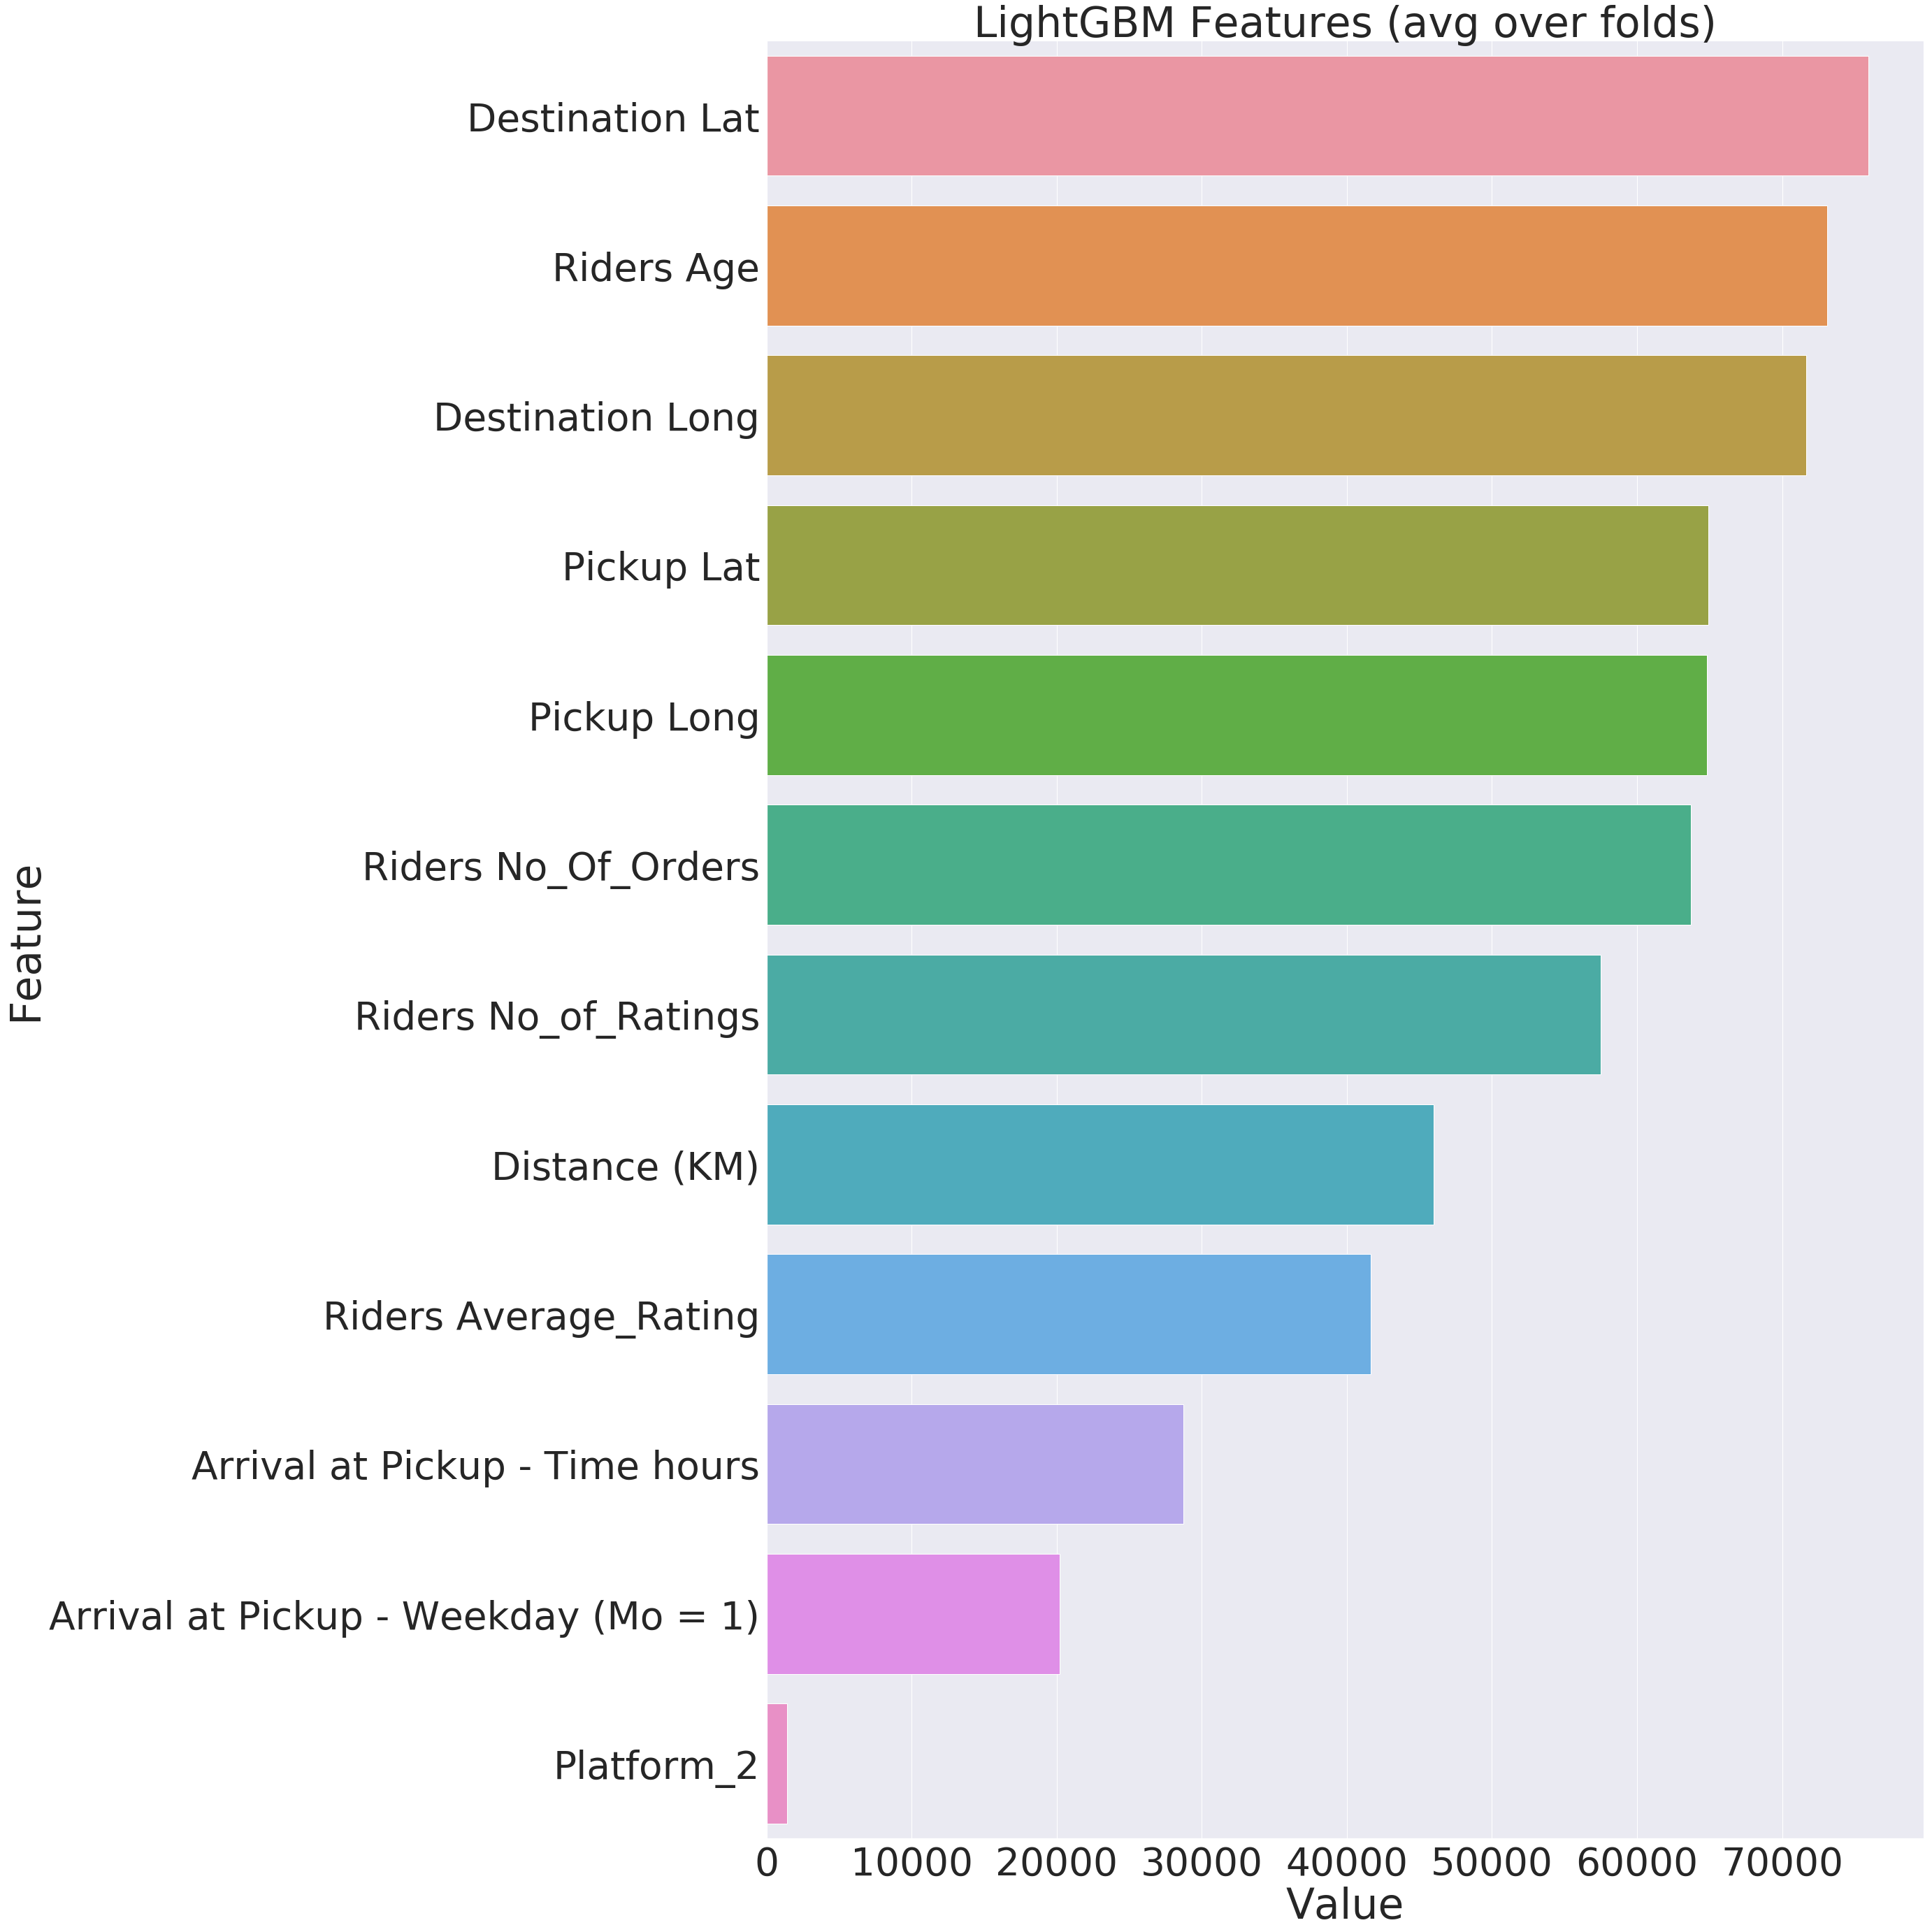

In [269]:
plotImp(lgbm_few_features, X_train[xgb_important_features[:12]], 50)

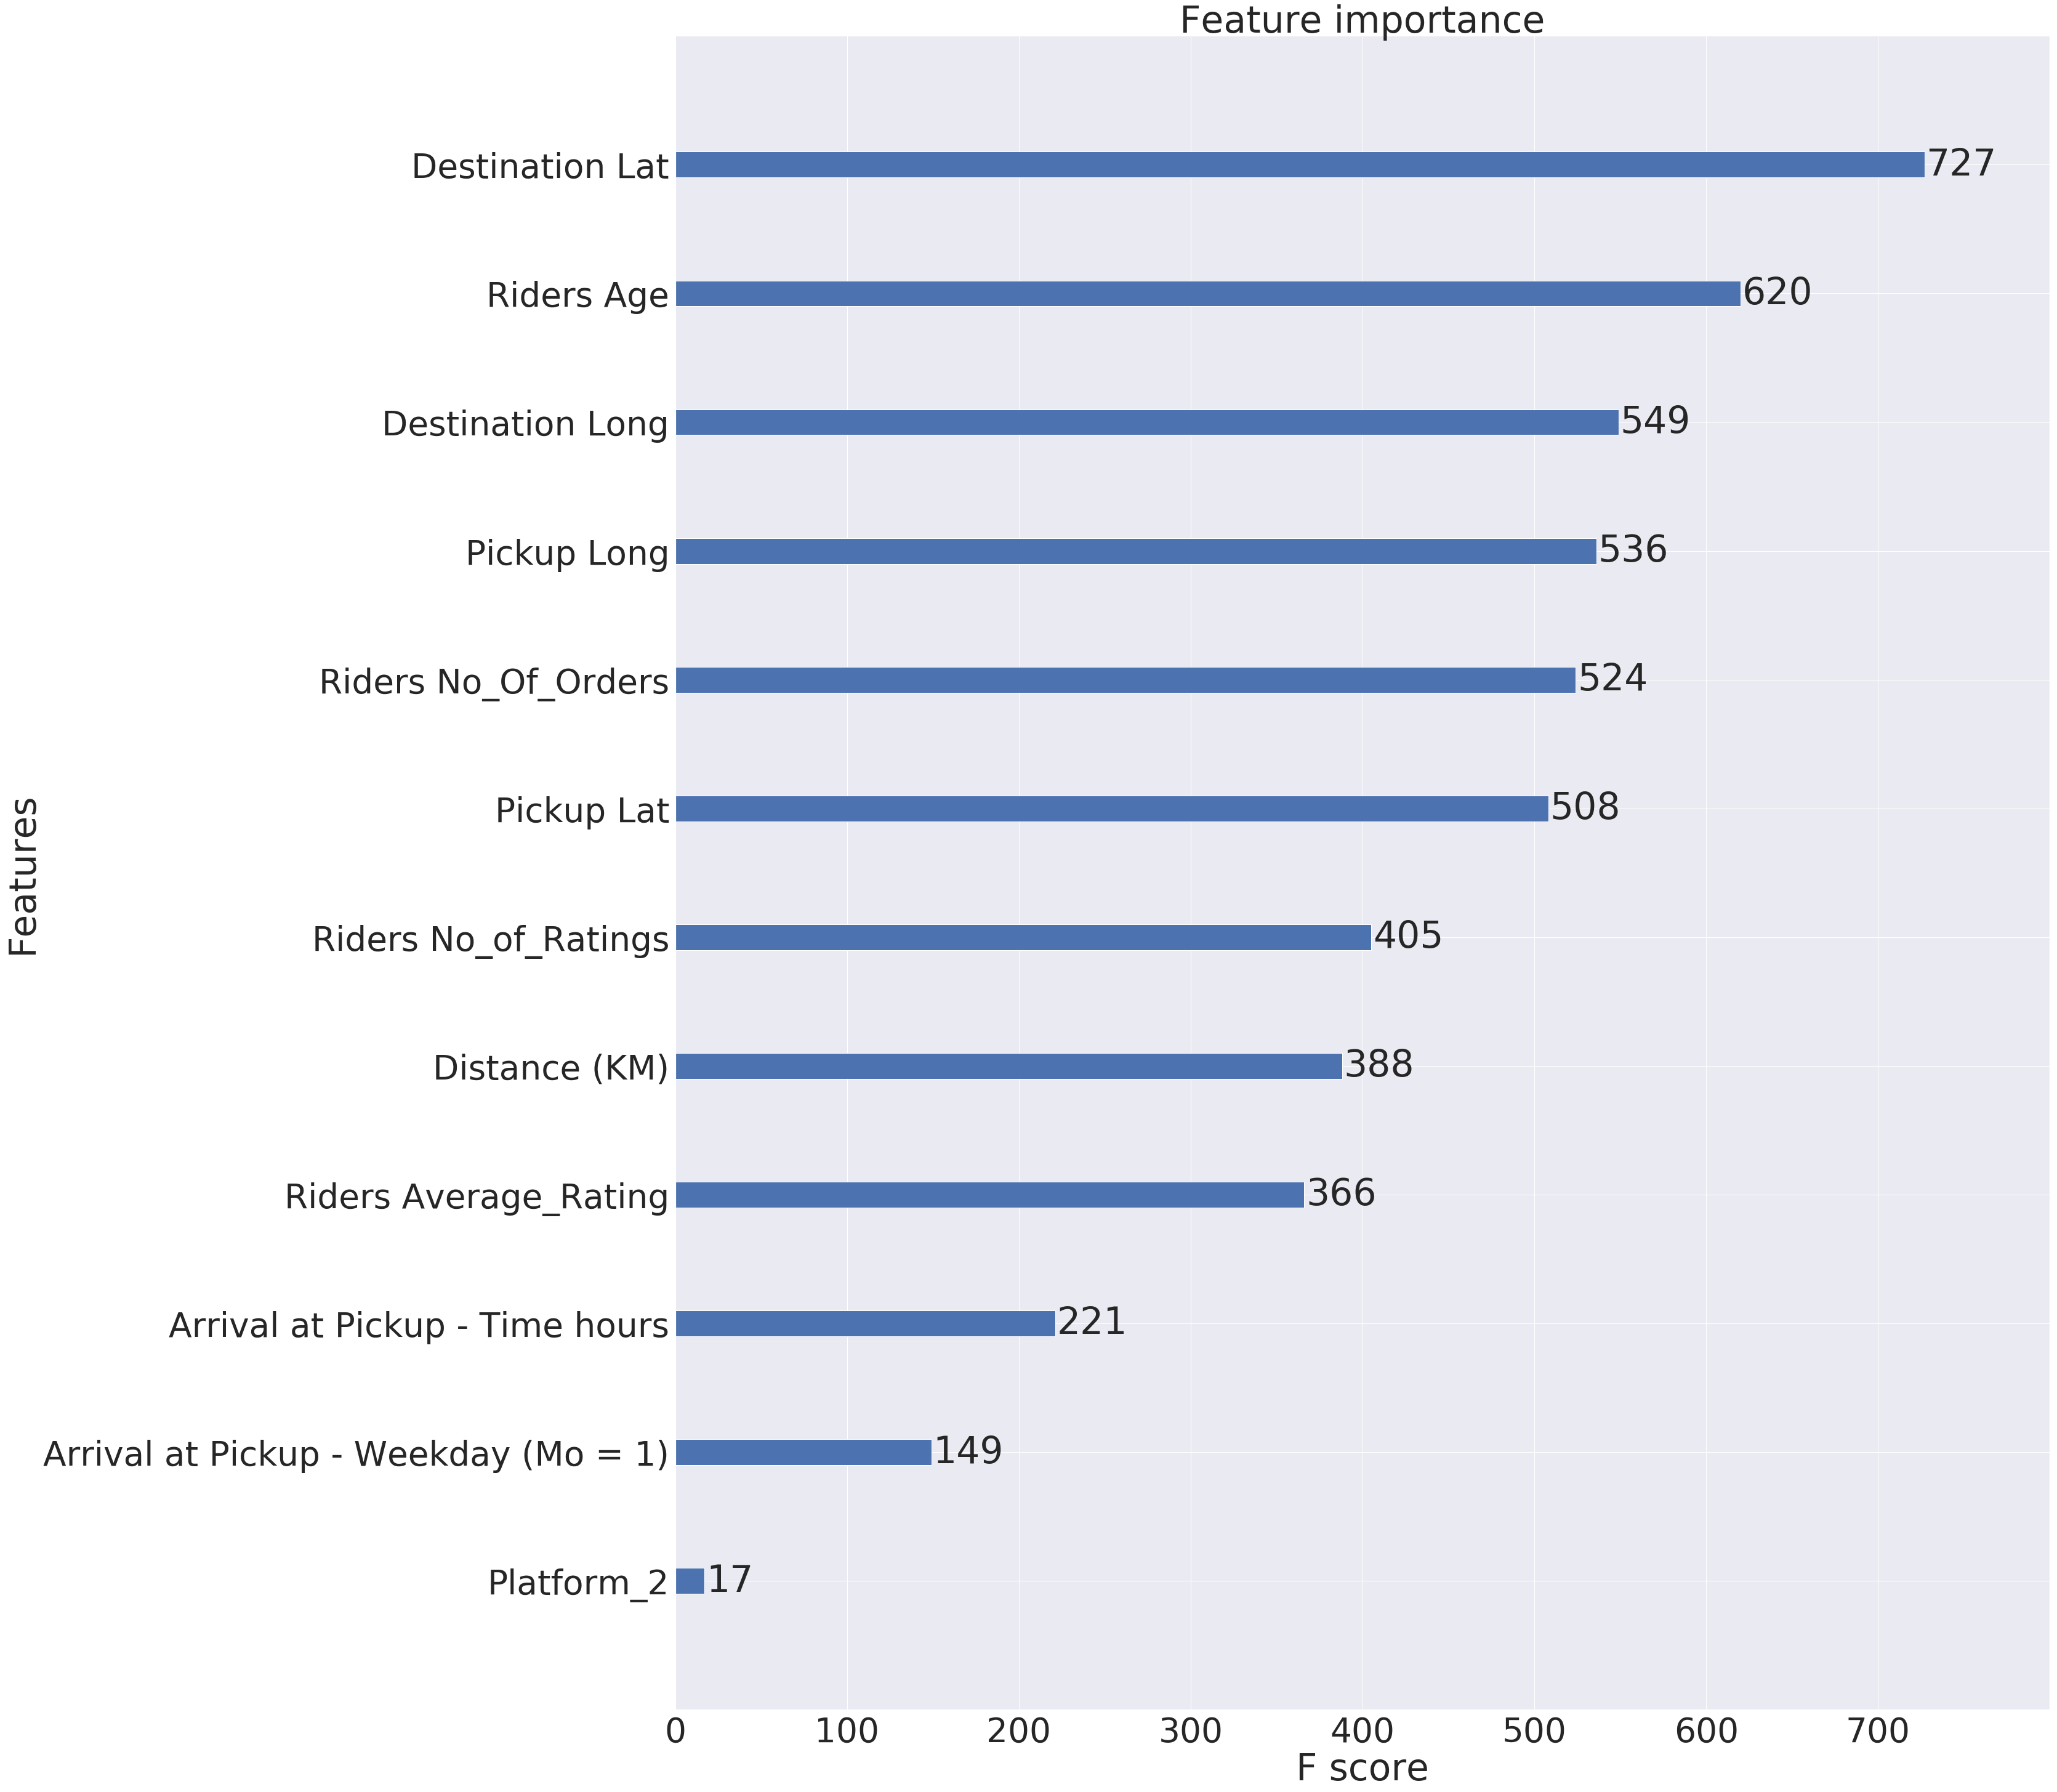

In [272]:
ax = plot_importance(xgb_few_features)
fig = ax.figure
fig.set_size_inches(40, 50)

In [274]:
xgb_important_features[:12]

['Distance (KM)',
 'Riders No_Of_Orders',
 'Platform_2',
 'Riders Average_Rating',
 'Riders Age',
 'Destination Lat',
 'Pickup Lat',
 'Riders No_of_Ratings',
 'Arrival at Pickup - Time hours',
 'Destination Long',
 'Pickup Long',
 'Arrival at Pickup - Weekday (Mo = 1)']

Use Target encoding

In [165]:
target_encoded_data = target_encoding(dropped_time_data, cat_variables, y_label, smoothing=True)

In [166]:
train, test = split_train_test_set(target_encoded_data, y_label)
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=[y_label, 'Order No']), train[y_label])
test = test.drop(columns=[y_label])

In [167]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.001,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
    
train_set = lgbm.Dataset(X_train, y_train, silent=False)
valid_set = lgbm.Dataset(X_test, y_test, silent=False)
model_2 = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500, valid_sets=valid_set)

[1]	valid_0's rmse: 979.8
Training until validation scores don't improve for 500 rounds
[2]	valid_0's rmse: 979.548
[3]	valid_0's rmse: 979.186
[4]	valid_0's rmse: 978.955
[5]	valid_0's rmse: 978.722
[6]	valid_0's rmse: 978.489
[7]	valid_0's rmse: 978.124
[8]	valid_0's rmse: 977.932
[9]	valid_0's rmse: 977.581
[10]	valid_0's rmse: 977.224
[11]	valid_0's rmse: 976.981
[12]	valid_0's rmse: 976.632
[13]	valid_0's rmse: 976.279
[14]	valid_0's rmse: 976.032
[15]	valid_0's rmse: 975.673
[16]	valid_0's rmse: 975.431
[17]	valid_0's rmse: 975.226
[18]	valid_0's rmse: 974.871
[19]	valid_0's rmse: 974.521
[20]	valid_0's rmse: 974.277
[21]	valid_0's rmse: 974.033
[22]	valid_0's rmse: 973.685
[23]	valid_0's rmse: 973.445
[24]	valid_0's rmse: 973.346
[25]	valid_0's rmse: 973.119
[26]	valid_0's rmse: 972.765
[27]	valid_0's rmse: 972.415
[28]	valid_0's rmse: 972.072
[29]	valid_0's rmse: 971.714
[30]	valid_0's rmse: 971.477
[31]	valid_0's rmse: 971.135
[32]	valid_0's rmse: 970.786
[33]	valid_0's rmse: 

[287]	valid_0's rmse: 907.872
[288]	valid_0's rmse: 907.719
[289]	valid_0's rmse: 907.655
[290]	valid_0's rmse: 907.41
[291]	valid_0's rmse: 907.335
[292]	valid_0's rmse: 907.097
[293]	valid_0's rmse: 906.861
[294]	valid_0's rmse: 906.621
[295]	valid_0's rmse: 906.377
[296]	valid_0's rmse: 906.134
[297]	valid_0's rmse: 905.885
[298]	valid_0's rmse: 905.648
[299]	valid_0's rmse: 905.482
[300]	valid_0's rmse: 905.24
[301]	valid_0's rmse: 904.996
[302]	valid_0's rmse: 904.763
[303]	valid_0's rmse: 904.532
[304]	valid_0's rmse: 904.37
[305]	valid_0's rmse: 904.135
[306]	valid_0's rmse: 903.895
[307]	valid_0's rmse: 903.652
[308]	valid_0's rmse: 903.496
[309]	valid_0's rmse: 903.265
[310]	valid_0's rmse: 903.029
[311]	valid_0's rmse: 902.792
[312]	valid_0's rmse: 902.621
[313]	valid_0's rmse: 902.54
[314]	valid_0's rmse: 902.305
[315]	valid_0's rmse: 902.068
[316]	valid_0's rmse: 901.827
[317]	valid_0's rmse: 901.68
[318]	valid_0's rmse: 901.451
[319]	valid_0's rmse: 901.321
[320]	valid_0's

[565]	valid_0's rmse: 860.245
[566]	valid_0's rmse: 860.197
[567]	valid_0's rmse: 860.099
[568]	valid_0's rmse: 859.937
[569]	valid_0's rmse: 859.846
[570]	valid_0's rmse: 859.679
[571]	valid_0's rmse: 859.597
[572]	valid_0's rmse: 859.434
[573]	valid_0's rmse: 859.27
[574]	valid_0's rmse: 859.189
[575]	valid_0's rmse: 859.025
[576]	valid_0's rmse: 858.862
[577]	valid_0's rmse: 858.837
[578]	valid_0's rmse: 858.721
[579]	valid_0's rmse: 858.555
[580]	valid_0's rmse: 858.386
[581]	valid_0's rmse: 858.227
[582]	valid_0's rmse: 858.06
[583]	valid_0's rmse: 858.026
[584]	valid_0's rmse: 857.918
[585]	valid_0's rmse: 857.747
[586]	valid_0's rmse: 857.583
[587]	valid_0's rmse: 857.473
[588]	valid_0's rmse: 857.364
[589]	valid_0's rmse: 857.199
[590]	valid_0's rmse: 857.093
[591]	valid_0's rmse: 856.929
[592]	valid_0's rmse: 856.835
[593]	valid_0's rmse: 856.673
[594]	valid_0's rmse: 856.507
[595]	valid_0's rmse: 856.428
[596]	valid_0's rmse: 856.365
[597]	valid_0's rmse: 856.332
[598]	valid_

[875]	valid_0's rmse: 826.224
[876]	valid_0's rmse: 826.118
[877]	valid_0's rmse: 826.017
[878]	valid_0's rmse: 825.937
[879]	valid_0's rmse: 825.855
[880]	valid_0's rmse: 825.775
[881]	valid_0's rmse: 825.705
[882]	valid_0's rmse: 825.6
[883]	valid_0's rmse: 825.488
[884]	valid_0's rmse: 825.378
[885]	valid_0's rmse: 825.272
[886]	valid_0's rmse: 825.161
[887]	valid_0's rmse: 825.054
[888]	valid_0's rmse: 824.949
[889]	valid_0's rmse: 824.845
[890]	valid_0's rmse: 824.743
[891]	valid_0's rmse: 824.641
[892]	valid_0's rmse: 824.531
[893]	valid_0's rmse: 824.426
[894]	valid_0's rmse: 824.322
[895]	valid_0's rmse: 824.215
[896]	valid_0's rmse: 824.11
[897]	valid_0's rmse: 824.004
[898]	valid_0's rmse: 823.928
[899]	valid_0's rmse: 823.853
[900]	valid_0's rmse: 823.798
[901]	valid_0's rmse: 823.694
[902]	valid_0's rmse: 823.595
[903]	valid_0's rmse: 823.488
[904]	valid_0's rmse: 823.383
[905]	valid_0's rmse: 823.276
[906]	valid_0's rmse: 823.24
[907]	valid_0's rmse: 823.137
[908]	valid_0'

[1158]	valid_0's rmse: 805.055
[1159]	valid_0's rmse: 805.018
[1160]	valid_0's rmse: 804.966
[1161]	valid_0's rmse: 804.917
[1162]	valid_0's rmse: 804.841
[1163]	valid_0's rmse: 804.771
[1164]	valid_0's rmse: 804.7
[1165]	valid_0's rmse: 804.63
[1166]	valid_0's rmse: 804.558
[1167]	valid_0's rmse: 804.485
[1168]	valid_0's rmse: 804.411
[1169]	valid_0's rmse: 804.367
[1170]	valid_0's rmse: 804.294
[1171]	valid_0's rmse: 804.22
[1172]	valid_0's rmse: 804.173
[1173]	valid_0's rmse: 804.099
[1174]	valid_0's rmse: 804.048
[1175]	valid_0's rmse: 803.981
[1176]	valid_0's rmse: 803.908
[1177]	valid_0's rmse: 803.835
[1178]	valid_0's rmse: 803.76
[1179]	valid_0's rmse: 803.688
[1180]	valid_0's rmse: 803.616
[1181]	valid_0's rmse: 803.571
[1182]	valid_0's rmse: 803.502
[1183]	valid_0's rmse: 803.433
[1184]	valid_0's rmse: 803.381
[1185]	valid_0's rmse: 803.312
[1186]	valid_0's rmse: 803.291
[1187]	valid_0's rmse: 803.263
[1188]	valid_0's rmse: 803.193
[1189]	valid_0's rmse: 803.146
[1190]	valid_

[1442]	valid_0's rmse: 790.855
[1443]	valid_0's rmse: 790.819
[1444]	valid_0's rmse: 790.764
[1445]	valid_0's rmse: 790.714
[1446]	valid_0's rmse: 790.664
[1447]	valid_0's rmse: 790.622
[1448]	valid_0's rmse: 790.57
[1449]	valid_0's rmse: 790.544
[1450]	valid_0's rmse: 790.496
[1451]	valid_0's rmse: 790.441
[1452]	valid_0's rmse: 790.402
[1453]	valid_0's rmse: 790.348
[1454]	valid_0's rmse: 790.32
[1455]	valid_0's rmse: 790.289
[1456]	valid_0's rmse: 790.252
[1457]	valid_0's rmse: 790.205
[1458]	valid_0's rmse: 790.168
[1459]	valid_0's rmse: 790.114
[1460]	valid_0's rmse: 790.065
[1461]	valid_0's rmse: 790.036
[1462]	valid_0's rmse: 789.981
[1463]	valid_0's rmse: 789.961
[1464]	valid_0's rmse: 789.91
[1465]	valid_0's rmse: 789.86
[1466]	valid_0's rmse: 789.824
[1467]	valid_0's rmse: 789.777
[1468]	valid_0's rmse: 789.742
[1469]	valid_0's rmse: 789.691
[1470]	valid_0's rmse: 789.638
[1471]	valid_0's rmse: 789.585
[1472]	valid_0's rmse: 789.561
[1473]	valid_0's rmse: 789.527
[1474]	valid

[1742]	valid_0's rmse: 780.358
[1743]	valid_0's rmse: 780.34
[1744]	valid_0's rmse: 780.301
[1745]	valid_0's rmse: 780.262
[1746]	valid_0's rmse: 780.248
[1747]	valid_0's rmse: 780.208
[1748]	valid_0's rmse: 780.164
[1749]	valid_0's rmse: 780.129
[1750]	valid_0's rmse: 780.097
[1751]	valid_0's rmse: 780.066
[1752]	valid_0's rmse: 780.031
[1753]	valid_0's rmse: 780
[1754]	valid_0's rmse: 779.969
[1755]	valid_0's rmse: 779.952
[1756]	valid_0's rmse: 779.934
[1757]	valid_0's rmse: 779.916
[1758]	valid_0's rmse: 779.883
[1759]	valid_0's rmse: 779.844
[1760]	valid_0's rmse: 779.824
[1761]	valid_0's rmse: 779.792
[1762]	valid_0's rmse: 779.757
[1763]	valid_0's rmse: 779.742
[1764]	valid_0's rmse: 779.727
[1765]	valid_0's rmse: 779.699
[1766]	valid_0's rmse: 779.669
[1767]	valid_0's rmse: 779.65
[1768]	valid_0's rmse: 779.626
[1769]	valid_0's rmse: 779.6
[1770]	valid_0's rmse: 779.582
[1771]	valid_0's rmse: 779.565
[1772]	valid_0's rmse: 779.556
[1773]	valid_0's rmse: 779.523
[1774]	valid_0's

[2033]	valid_0's rmse: 773.362
[2034]	valid_0's rmse: 773.327
[2035]	valid_0's rmse: 773.304
[2036]	valid_0's rmse: 773.278
[2037]	valid_0's rmse: 773.259
[2038]	valid_0's rmse: 773.246
[2039]	valid_0's rmse: 773.222
[2040]	valid_0's rmse: 773.21
[2041]	valid_0's rmse: 773.175
[2042]	valid_0's rmse: 773.15
[2043]	valid_0's rmse: 773.123
[2044]	valid_0's rmse: 773.1
[2045]	valid_0's rmse: 773.086
[2046]	valid_0's rmse: 773.062
[2047]	valid_0's rmse: 773.039
[2048]	valid_0's rmse: 773.01
[2049]	valid_0's rmse: 772.987
[2050]	valid_0's rmse: 772.956
[2051]	valid_0's rmse: 772.933
[2052]	valid_0's rmse: 772.898
[2053]	valid_0's rmse: 772.877
[2054]	valid_0's rmse: 772.87
[2055]	valid_0's rmse: 772.839
[2056]	valid_0's rmse: 772.83
[2057]	valid_0's rmse: 772.808
[2058]	valid_0's rmse: 772.785
[2059]	valid_0's rmse: 772.755
[2060]	valid_0's rmse: 772.731
[2061]	valid_0's rmse: 772.707
[2062]	valid_0's rmse: 772.677
[2063]	valid_0's rmse: 772.653
[2064]	valid_0's rmse: 772.626
[2065]	valid_0'

[2325]	valid_0's rmse: 767.85
[2326]	valid_0's rmse: 767.838
[2327]	valid_0's rmse: 767.82
[2328]	valid_0's rmse: 767.802
[2329]	valid_0's rmse: 767.789
[2330]	valid_0's rmse: 767.773
[2331]	valid_0's rmse: 767.756
[2332]	valid_0's rmse: 767.739
[2333]	valid_0's rmse: 767.722
[2334]	valid_0's rmse: 767.711
[2335]	valid_0's rmse: 767.694
[2336]	valid_0's rmse: 767.676
[2337]	valid_0's rmse: 767.661
[2338]	valid_0's rmse: 767.636
[2339]	valid_0's rmse: 767.614
[2340]	valid_0's rmse: 767.6
[2341]	valid_0's rmse: 767.578
[2342]	valid_0's rmse: 767.568
[2343]	valid_0's rmse: 767.563
[2344]	valid_0's rmse: 767.544
[2345]	valid_0's rmse: 767.532
[2346]	valid_0's rmse: 767.519
[2347]	valid_0's rmse: 767.499
[2348]	valid_0's rmse: 767.483
[2349]	valid_0's rmse: 767.469
[2350]	valid_0's rmse: 767.45
[2351]	valid_0's rmse: 767.436
[2352]	valid_0's rmse: 767.419
[2353]	valid_0's rmse: 767.405
[2354]	valid_0's rmse: 767.391
[2355]	valid_0's rmse: 767.374
[2356]	valid_0's rmse: 767.354
[2357]	valid_

[2621]	valid_0's rmse: 763.586
[2622]	valid_0's rmse: 763.572
[2623]	valid_0's rmse: 763.562
[2624]	valid_0's rmse: 763.551
[2625]	valid_0's rmse: 763.537
[2626]	valid_0's rmse: 763.523
[2627]	valid_0's rmse: 763.512
[2628]	valid_0's rmse: 763.497
[2629]	valid_0's rmse: 763.494
[2630]	valid_0's rmse: 763.488
[2631]	valid_0's rmse: 763.477
[2632]	valid_0's rmse: 763.462
[2633]	valid_0's rmse: 763.45
[2634]	valid_0's rmse: 763.44
[2635]	valid_0's rmse: 763.422
[2636]	valid_0's rmse: 763.413
[2637]	valid_0's rmse: 763.403
[2638]	valid_0's rmse: 763.393
[2639]	valid_0's rmse: 763.378
[2640]	valid_0's rmse: 763.364
[2641]	valid_0's rmse: 763.358
[2642]	valid_0's rmse: 763.354
[2643]	valid_0's rmse: 763.345
[2644]	valid_0's rmse: 763.337
[2645]	valid_0's rmse: 763.322
[2646]	valid_0's rmse: 763.307
[2647]	valid_0's rmse: 763.295
[2648]	valid_0's rmse: 763.285
[2649]	valid_0's rmse: 763.273
[2650]	valid_0's rmse: 763.265
[2651]	valid_0's rmse: 763.249
[2652]	valid_0's rmse: 763.235
[2653]	val

[2887]	valid_0's rmse: 760.605
[2888]	valid_0's rmse: 760.591
[2889]	valid_0's rmse: 760.583
[2890]	valid_0's rmse: 760.573
[2891]	valid_0's rmse: 760.559
[2892]	valid_0's rmse: 760.55
[2893]	valid_0's rmse: 760.544
[2894]	valid_0's rmse: 760.535
[2895]	valid_0's rmse: 760.525
[2896]	valid_0's rmse: 760.519
[2897]	valid_0's rmse: 760.502
[2898]	valid_0's rmse: 760.49
[2899]	valid_0's rmse: 760.481
[2900]	valid_0's rmse: 760.474
[2901]	valid_0's rmse: 760.468
[2902]	valid_0's rmse: 760.457
[2903]	valid_0's rmse: 760.447
[2904]	valid_0's rmse: 760.434
[2905]	valid_0's rmse: 760.429
[2906]	valid_0's rmse: 760.417
[2907]	valid_0's rmse: 760.406
[2908]	valid_0's rmse: 760.4
[2909]	valid_0's rmse: 760.388
[2910]	valid_0's rmse: 760.378
[2911]	valid_0's rmse: 760.369
[2912]	valid_0's rmse: 760.354
[2913]	valid_0's rmse: 760.347
[2914]	valid_0's rmse: 760.339
[2915]	valid_0's rmse: 760.325
[2916]	valid_0's rmse: 760.311
[2917]	valid_0's rmse: 760.309
[2918]	valid_0's rmse: 760.297
[2919]	valid

[3188]	valid_0's rmse: 758.047
[3189]	valid_0's rmse: 758.034
[3190]	valid_0's rmse: 758.026
[3191]	valid_0's rmse: 758.019
[3192]	valid_0's rmse: 758.01
[3193]	valid_0's rmse: 758.001
[3194]	valid_0's rmse: 757.995
[3195]	valid_0's rmse: 757.985
[3196]	valid_0's rmse: 757.975
[3197]	valid_0's rmse: 757.964
[3198]	valid_0's rmse: 757.955
[3199]	valid_0's rmse: 757.954
[3200]	valid_0's rmse: 757.943
[3201]	valid_0's rmse: 757.931
[3202]	valid_0's rmse: 757.924
[3203]	valid_0's rmse: 757.912
[3204]	valid_0's rmse: 757.907
[3205]	valid_0's rmse: 757.895
[3206]	valid_0's rmse: 757.888
[3207]	valid_0's rmse: 757.883
[3208]	valid_0's rmse: 757.874
[3209]	valid_0's rmse: 757.871
[3210]	valid_0's rmse: 757.863
[3211]	valid_0's rmse: 757.858
[3212]	valid_0's rmse: 757.85
[3213]	valid_0's rmse: 757.84
[3214]	valid_0's rmse: 757.83
[3215]	valid_0's rmse: 757.824
[3216]	valid_0's rmse: 757.817
[3217]	valid_0's rmse: 757.813
[3218]	valid_0's rmse: 757.804
[3219]	valid_0's rmse: 757.796
[3220]	valid

[3459]	valid_0's rmse: 756.081
[3460]	valid_0's rmse: 756.075
[3461]	valid_0's rmse: 756.069
[3462]	valid_0's rmse: 756.054
[3463]	valid_0's rmse: 756.048
[3464]	valid_0's rmse: 756.043
[3465]	valid_0's rmse: 756.034
[3466]	valid_0's rmse: 756.029
[3467]	valid_0's rmse: 756.022
[3468]	valid_0's rmse: 756.022
[3469]	valid_0's rmse: 756.012
[3470]	valid_0's rmse: 756
[3471]	valid_0's rmse: 755.996
[3472]	valid_0's rmse: 755.993
[3473]	valid_0's rmse: 755.991
[3474]	valid_0's rmse: 755.981
[3475]	valid_0's rmse: 755.977
[3476]	valid_0's rmse: 755.975
[3477]	valid_0's rmse: 755.965
[3478]	valid_0's rmse: 755.958
[3479]	valid_0's rmse: 755.954
[3480]	valid_0's rmse: 755.947
[3481]	valid_0's rmse: 755.939
[3482]	valid_0's rmse: 755.931
[3483]	valid_0's rmse: 755.926
[3484]	valid_0's rmse: 755.913
[3485]	valid_0's rmse: 755.905
[3486]	valid_0's rmse: 755.906
[3487]	valid_0's rmse: 755.9
[3488]	valid_0's rmse: 755.892
[3489]	valid_0's rmse: 755.881
[3490]	valid_0's rmse: 755.879
[3491]	valid_0

[3743]	valid_0's rmse: 754.429
[3744]	valid_0's rmse: 754.422
[3745]	valid_0's rmse: 754.418
[3746]	valid_0's rmse: 754.412
[3747]	valid_0's rmse: 754.408
[3748]	valid_0's rmse: 754.4
[3749]	valid_0's rmse: 754.394
[3750]	valid_0's rmse: 754.388
[3751]	valid_0's rmse: 754.381
[3752]	valid_0's rmse: 754.382
[3753]	valid_0's rmse: 754.382
[3754]	valid_0's rmse: 754.376
[3755]	valid_0's rmse: 754.367
[3756]	valid_0's rmse: 754.36
[3757]	valid_0's rmse: 754.353
[3758]	valid_0's rmse: 754.349
[3759]	valid_0's rmse: 754.347
[3760]	valid_0's rmse: 754.339
[3761]	valid_0's rmse: 754.332
[3762]	valid_0's rmse: 754.328
[3763]	valid_0's rmse: 754.322
[3764]	valid_0's rmse: 754.315
[3765]	valid_0's rmse: 754.314
[3766]	valid_0's rmse: 754.312
[3767]	valid_0's rmse: 754.309
[3768]	valid_0's rmse: 754.304
[3769]	valid_0's rmse: 754.294
[3770]	valid_0's rmse: 754.292
[3771]	valid_0's rmse: 754.288
[3772]	valid_0's rmse: 754.283
[3773]	valid_0's rmse: 754.274
[3774]	valid_0's rmse: 754.269
[3775]	vali

[4032]	valid_0's rmse: 752.983
[4033]	valid_0's rmse: 752.979
[4034]	valid_0's rmse: 752.975
[4035]	valid_0's rmse: 752.968
[4036]	valid_0's rmse: 752.963
[4037]	valid_0's rmse: 752.959
[4038]	valid_0's rmse: 752.956
[4039]	valid_0's rmse: 752.952
[4040]	valid_0's rmse: 752.948
[4041]	valid_0's rmse: 752.946
[4042]	valid_0's rmse: 752.943
[4043]	valid_0's rmse: 752.938
[4044]	valid_0's rmse: 752.926
[4045]	valid_0's rmse: 752.921
[4046]	valid_0's rmse: 752.918
[4047]	valid_0's rmse: 752.915
[4048]	valid_0's rmse: 752.909
[4049]	valid_0's rmse: 752.908
[4050]	valid_0's rmse: 752.907
[4051]	valid_0's rmse: 752.905
[4052]	valid_0's rmse: 752.9
[4053]	valid_0's rmse: 752.889
[4054]	valid_0's rmse: 752.888
[4055]	valid_0's rmse: 752.881
[4056]	valid_0's rmse: 752.875
[4057]	valid_0's rmse: 752.87
[4058]	valid_0's rmse: 752.861
[4059]	valid_0's rmse: 752.855
[4060]	valid_0's rmse: 752.85
[4061]	valid_0's rmse: 752.845
[4062]	valid_0's rmse: 752.838
[4063]	valid_0's rmse: 752.837
[4064]	valid

[4332]	valid_0's rmse: 751.585
[4333]	valid_0's rmse: 751.577
[4334]	valid_0's rmse: 751.573
[4335]	valid_0's rmse: 751.568
[4336]	valid_0's rmse: 751.56
[4337]	valid_0's rmse: 751.556
[4338]	valid_0's rmse: 751.551
[4339]	valid_0's rmse: 751.54
[4340]	valid_0's rmse: 751.537
[4341]	valid_0's rmse: 751.531
[4342]	valid_0's rmse: 751.525
[4343]	valid_0's rmse: 751.521
[4344]	valid_0's rmse: 751.52
[4345]	valid_0's rmse: 751.519
[4346]	valid_0's rmse: 751.516
[4347]	valid_0's rmse: 751.511
[4348]	valid_0's rmse: 751.509
[4349]	valid_0's rmse: 751.51
[4350]	valid_0's rmse: 751.505
[4351]	valid_0's rmse: 751.498
[4352]	valid_0's rmse: 751.492
[4353]	valid_0's rmse: 751.487
[4354]	valid_0's rmse: 751.484
[4355]	valid_0's rmse: 751.482
[4356]	valid_0's rmse: 751.478
[4357]	valid_0's rmse: 751.471
[4358]	valid_0's rmse: 751.468
[4359]	valid_0's rmse: 751.464
[4360]	valid_0's rmse: 751.462
[4361]	valid_0's rmse: 751.454
[4362]	valid_0's rmse: 751.453
[4363]	valid_0's rmse: 751.441
[4364]	valid

[4623]	valid_0's rmse: 750.438
[4624]	valid_0's rmse: 750.435
[4625]	valid_0's rmse: 750.43
[4626]	valid_0's rmse: 750.428
[4627]	valid_0's rmse: 750.419
[4628]	valid_0's rmse: 750.414
[4629]	valid_0's rmse: 750.41
[4630]	valid_0's rmse: 750.407
[4631]	valid_0's rmse: 750.405
[4632]	valid_0's rmse: 750.399
[4633]	valid_0's rmse: 750.394
[4634]	valid_0's rmse: 750.389
[4635]	valid_0's rmse: 750.389
[4636]	valid_0's rmse: 750.387
[4637]	valid_0's rmse: 750.382
[4638]	valid_0's rmse: 750.376
[4639]	valid_0's rmse: 750.374
[4640]	valid_0's rmse: 750.372
[4641]	valid_0's rmse: 750.373
[4642]	valid_0's rmse: 750.368
[4643]	valid_0's rmse: 750.366
[4644]	valid_0's rmse: 750.363
[4645]	valid_0's rmse: 750.361
[4646]	valid_0's rmse: 750.356
[4647]	valid_0's rmse: 750.353
[4648]	valid_0's rmse: 750.351
[4649]	valid_0's rmse: 750.345
[4650]	valid_0's rmse: 750.342
[4651]	valid_0's rmse: 750.34
[4652]	valid_0's rmse: 750.34
[4653]	valid_0's rmse: 750.336
[4654]	valid_0's rmse: 750.333
[4655]	valid

[4910]	valid_0's rmse: 749.455
[4911]	valid_0's rmse: 749.454
[4912]	valid_0's rmse: 749.452
[4913]	valid_0's rmse: 749.45
[4914]	valid_0's rmse: 749.448
[4915]	valid_0's rmse: 749.445
[4916]	valid_0's rmse: 749.446
[4917]	valid_0's rmse: 749.44
[4918]	valid_0's rmse: 749.432
[4919]	valid_0's rmse: 749.429
[4920]	valid_0's rmse: 749.429
[4921]	valid_0's rmse: 749.428
[4922]	valid_0's rmse: 749.428
[4923]	valid_0's rmse: 749.428
[4924]	valid_0's rmse: 749.428
[4925]	valid_0's rmse: 749.427
[4926]	valid_0's rmse: 749.425
[4927]	valid_0's rmse: 749.423
[4928]	valid_0's rmse: 749.422
[4929]	valid_0's rmse: 749.421
[4930]	valid_0's rmse: 749.418
[4931]	valid_0's rmse: 749.415
[4932]	valid_0's rmse: 749.413
[4933]	valid_0's rmse: 749.411
[4934]	valid_0's rmse: 749.41
[4935]	valid_0's rmse: 749.401
[4936]	valid_0's rmse: 749.399
[4937]	valid_0's rmse: 749.396
[4938]	valid_0's rmse: 749.393
[4939]	valid_0's rmse: 749.392
[4940]	valid_0's rmse: 749.392
[4941]	valid_0's rmse: 749.389
[4942]	vali

[5207]	valid_0's rmse: 748.56
[5208]	valid_0's rmse: 748.556
[5209]	valid_0's rmse: 748.556
[5210]	valid_0's rmse: 748.553
[5211]	valid_0's rmse: 748.547
[5212]	valid_0's rmse: 748.543
[5213]	valid_0's rmse: 748.539
[5214]	valid_0's rmse: 748.537
[5215]	valid_0's rmse: 748.533
[5216]	valid_0's rmse: 748.525
[5217]	valid_0's rmse: 748.521
[5218]	valid_0's rmse: 748.52
[5219]	valid_0's rmse: 748.513
[5220]	valid_0's rmse: 748.514
[5221]	valid_0's rmse: 748.509
[5222]	valid_0's rmse: 748.509
[5223]	valid_0's rmse: 748.501
[5224]	valid_0's rmse: 748.496
[5225]	valid_0's rmse: 748.493
[5226]	valid_0's rmse: 748.489
[5227]	valid_0's rmse: 748.481
[5228]	valid_0's rmse: 748.474
[5229]	valid_0's rmse: 748.473
[5230]	valid_0's rmse: 748.47
[5231]	valid_0's rmse: 748.469
[5232]	valid_0's rmse: 748.469
[5233]	valid_0's rmse: 748.467
[5234]	valid_0's rmse: 748.465
[5235]	valid_0's rmse: 748.462
[5236]	valid_0's rmse: 748.461
[5237]	valid_0's rmse: 748.456
[5238]	valid_0's rmse: 748.447
[5239]	vali

[5504]	valid_0's rmse: 747.674
[5505]	valid_0's rmse: 747.67
[5506]	valid_0's rmse: 747.667
[5507]	valid_0's rmse: 747.66
[5508]	valid_0's rmse: 747.657
[5509]	valid_0's rmse: 747.655
[5510]	valid_0's rmse: 747.652
[5511]	valid_0's rmse: 747.648
[5512]	valid_0's rmse: 747.648
[5513]	valid_0's rmse: 747.648
[5514]	valid_0's rmse: 747.646
[5515]	valid_0's rmse: 747.639
[5516]	valid_0's rmse: 747.633
[5517]	valid_0's rmse: 747.63
[5518]	valid_0's rmse: 747.623
[5519]	valid_0's rmse: 747.621
[5520]	valid_0's rmse: 747.621
[5521]	valid_0's rmse: 747.614
[5522]	valid_0's rmse: 747.613
[5523]	valid_0's rmse: 747.615
[5524]	valid_0's rmse: 747.61
[5525]	valid_0's rmse: 747.608
[5526]	valid_0's rmse: 747.606
[5527]	valid_0's rmse: 747.597
[5528]	valid_0's rmse: 747.592
[5529]	valid_0's rmse: 747.589
[5530]	valid_0's rmse: 747.585
[5531]	valid_0's rmse: 747.578
[5532]	valid_0's rmse: 747.577
[5533]	valid_0's rmse: 747.568
[5534]	valid_0's rmse: 747.565
[5535]	valid_0's rmse: 747.566
[5536]	valid

[5790]	valid_0's rmse: 746.881
[5791]	valid_0's rmse: 746.875
[5792]	valid_0's rmse: 746.871
[5793]	valid_0's rmse: 746.872
[5794]	valid_0's rmse: 746.869
[5795]	valid_0's rmse: 746.862
[5796]	valid_0's rmse: 746.861
[5797]	valid_0's rmse: 746.858
[5798]	valid_0's rmse: 746.856
[5799]	valid_0's rmse: 746.848
[5800]	valid_0's rmse: 746.847
[5801]	valid_0's rmse: 746.848
[5802]	valid_0's rmse: 746.844
[5803]	valid_0's rmse: 746.844
[5804]	valid_0's rmse: 746.844
[5805]	valid_0's rmse: 746.842
[5806]	valid_0's rmse: 746.843
[5807]	valid_0's rmse: 746.842
[5808]	valid_0's rmse: 746.839
[5809]	valid_0's rmse: 746.839
[5810]	valid_0's rmse: 746.834
[5811]	valid_0's rmse: 746.83
[5812]	valid_0's rmse: 746.829
[5813]	valid_0's rmse: 746.829
[5814]	valid_0's rmse: 746.828
[5815]	valid_0's rmse: 746.828
[5816]	valid_0's rmse: 746.823
[5817]	valid_0's rmse: 746.824
[5818]	valid_0's rmse: 746.824
[5819]	valid_0's rmse: 746.821
[5820]	valid_0's rmse: 746.817
[5821]	valid_0's rmse: 746.815
[5822]	va

[6064]	valid_0's rmse: 746.23
[6065]	valid_0's rmse: 746.228
[6066]	valid_0's rmse: 746.224
[6067]	valid_0's rmse: 746.22
[6068]	valid_0's rmse: 746.221
[6069]	valid_0's rmse: 746.214
[6070]	valid_0's rmse: 746.213
[6071]	valid_0's rmse: 746.21
[6072]	valid_0's rmse: 746.211
[6073]	valid_0's rmse: 746.21
[6074]	valid_0's rmse: 746.207
[6075]	valid_0's rmse: 746.204
[6076]	valid_0's rmse: 746.201
[6077]	valid_0's rmse: 746.195
[6078]	valid_0's rmse: 746.191
[6079]	valid_0's rmse: 746.189
[6080]	valid_0's rmse: 746.182
[6081]	valid_0's rmse: 746.178
[6082]	valid_0's rmse: 746.177
[6083]	valid_0's rmse: 746.176
[6084]	valid_0's rmse: 746.174
[6085]	valid_0's rmse: 746.169
[6086]	valid_0's rmse: 746.168
[6087]	valid_0's rmse: 746.165
[6088]	valid_0's rmse: 746.165
[6089]	valid_0's rmse: 746.16
[6090]	valid_0's rmse: 746.159
[6091]	valid_0's rmse: 746.155
[6092]	valid_0's rmse: 746.154
[6093]	valid_0's rmse: 746.154
[6094]	valid_0's rmse: 746.149
[6095]	valid_0's rmse: 746.148
[6096]	valid_

[6369]	valid_0's rmse: 745.567
[6370]	valid_0's rmse: 745.566
[6371]	valid_0's rmse: 745.562
[6372]	valid_0's rmse: 745.561
[6373]	valid_0's rmse: 745.561
[6374]	valid_0's rmse: 745.559
[6375]	valid_0's rmse: 745.557
[6376]	valid_0's rmse: 745.556
[6377]	valid_0's rmse: 745.555
[6378]	valid_0's rmse: 745.551
[6379]	valid_0's rmse: 745.548
[6380]	valid_0's rmse: 745.543
[6381]	valid_0's rmse: 745.543
[6382]	valid_0's rmse: 745.542
[6383]	valid_0's rmse: 745.54
[6384]	valid_0's rmse: 745.537
[6385]	valid_0's rmse: 745.538
[6386]	valid_0's rmse: 745.537
[6387]	valid_0's rmse: 745.534
[6388]	valid_0's rmse: 745.532
[6389]	valid_0's rmse: 745.53
[6390]	valid_0's rmse: 745.527
[6391]	valid_0's rmse: 745.529
[6392]	valid_0's rmse: 745.529
[6393]	valid_0's rmse: 745.525
[6394]	valid_0's rmse: 745.524
[6395]	valid_0's rmse: 745.52
[6396]	valid_0's rmse: 745.519
[6397]	valid_0's rmse: 745.516
[6398]	valid_0's rmse: 745.514
[6399]	valid_0's rmse: 745.51
[6400]	valid_0's rmse: 745.509
[6401]	valid

[6635]	valid_0's rmse: 745.067
[6636]	valid_0's rmse: 745.064
[6637]	valid_0's rmse: 745.061
[6638]	valid_0's rmse: 745.059
[6639]	valid_0's rmse: 745.059
[6640]	valid_0's rmse: 745.058
[6641]	valid_0's rmse: 745.053
[6642]	valid_0's rmse: 745.053
[6643]	valid_0's rmse: 745.054
[6644]	valid_0's rmse: 745.052
[6645]	valid_0's rmse: 745.052
[6646]	valid_0's rmse: 745.052
[6647]	valid_0's rmse: 745.05
[6648]	valid_0's rmse: 745.047
[6649]	valid_0's rmse: 745.043
[6650]	valid_0's rmse: 745.038
[6651]	valid_0's rmse: 745.037
[6652]	valid_0's rmse: 745.036
[6653]	valid_0's rmse: 745.032
[6654]	valid_0's rmse: 745.031
[6655]	valid_0's rmse: 745.03
[6656]	valid_0's rmse: 745.032
[6657]	valid_0's rmse: 745.031
[6658]	valid_0's rmse: 745.031
[6659]	valid_0's rmse: 745.027
[6660]	valid_0's rmse: 745.025
[6661]	valid_0's rmse: 745.022
[6662]	valid_0's rmse: 745.021
[6663]	valid_0's rmse: 745.021
[6664]	valid_0's rmse: 745.022
[6665]	valid_0's rmse: 745.02
[6666]	valid_0's rmse: 745.018
[6667]	vali

[6909]	valid_0's rmse: 744.627
[6910]	valid_0's rmse: 744.625
[6911]	valid_0's rmse: 744.625
[6912]	valid_0's rmse: 744.623
[6913]	valid_0's rmse: 744.623
[6914]	valid_0's rmse: 744.621
[6915]	valid_0's rmse: 744.619
[6916]	valid_0's rmse: 744.618
[6917]	valid_0's rmse: 744.619
[6918]	valid_0's rmse: 744.616
[6919]	valid_0's rmse: 744.611
[6920]	valid_0's rmse: 744.611
[6921]	valid_0's rmse: 744.604
[6922]	valid_0's rmse: 744.601
[6923]	valid_0's rmse: 744.6
[6924]	valid_0's rmse: 744.601
[6925]	valid_0's rmse: 744.596
[6926]	valid_0's rmse: 744.594
[6927]	valid_0's rmse: 744.593
[6928]	valid_0's rmse: 744.592
[6929]	valid_0's rmse: 744.591
[6930]	valid_0's rmse: 744.591
[6931]	valid_0's rmse: 744.588
[6932]	valid_0's rmse: 744.588
[6933]	valid_0's rmse: 744.587
[6934]	valid_0's rmse: 744.584
[6935]	valid_0's rmse: 744.584
[6936]	valid_0's rmse: 744.583
[6937]	valid_0's rmse: 744.585
[6938]	valid_0's rmse: 744.585
[6939]	valid_0's rmse: 744.583
[6940]	valid_0's rmse: 744.579
[6941]	val

[7185]	valid_0's rmse: 744.237
[7186]	valid_0's rmse: 744.236
[7187]	valid_0's rmse: 744.236
[7188]	valid_0's rmse: 744.232
[7189]	valid_0's rmse: 744.228
[7190]	valid_0's rmse: 744.227
[7191]	valid_0's rmse: 744.223
[7192]	valid_0's rmse: 744.222
[7193]	valid_0's rmse: 744.222
[7194]	valid_0's rmse: 744.219
[7195]	valid_0's rmse: 744.217
[7196]	valid_0's rmse: 744.217
[7197]	valid_0's rmse: 744.216
[7198]	valid_0's rmse: 744.216
[7199]	valid_0's rmse: 744.213
[7200]	valid_0's rmse: 744.215
[7201]	valid_0's rmse: 744.215
[7202]	valid_0's rmse: 744.217
[7203]	valid_0's rmse: 744.214
[7204]	valid_0's rmse: 744.207
[7205]	valid_0's rmse: 744.204
[7206]	valid_0's rmse: 744.202
[7207]	valid_0's rmse: 744.203
[7208]	valid_0's rmse: 744.203
[7209]	valid_0's rmse: 744.201
[7210]	valid_0's rmse: 744.199
[7211]	valid_0's rmse: 744.198
[7212]	valid_0's rmse: 744.192
[7213]	valid_0's rmse: 744.193
[7214]	valid_0's rmse: 744.193
[7215]	valid_0's rmse: 744.193
[7216]	valid_0's rmse: 744.191
[7217]	v

[7462]	valid_0's rmse: 743.795
[7463]	valid_0's rmse: 743.79
[7464]	valid_0's rmse: 743.788
[7465]	valid_0's rmse: 743.786
[7466]	valid_0's rmse: 743.785
[7467]	valid_0's rmse: 743.784
[7468]	valid_0's rmse: 743.779
[7469]	valid_0's rmse: 743.779
[7470]	valid_0's rmse: 743.777
[7471]	valid_0's rmse: 743.774
[7472]	valid_0's rmse: 743.768
[7473]	valid_0's rmse: 743.767
[7474]	valid_0's rmse: 743.769
[7475]	valid_0's rmse: 743.765
[7476]	valid_0's rmse: 743.763
[7477]	valid_0's rmse: 743.762
[7478]	valid_0's rmse: 743.763
[7479]	valid_0's rmse: 743.763
[7480]	valid_0's rmse: 743.763
[7481]	valid_0's rmse: 743.763
[7482]	valid_0's rmse: 743.761
[7483]	valid_0's rmse: 743.761
[7484]	valid_0's rmse: 743.76
[7485]	valid_0's rmse: 743.761
[7486]	valid_0's rmse: 743.76
[7487]	valid_0's rmse: 743.759
[7488]	valid_0's rmse: 743.754
[7489]	valid_0's rmse: 743.751
[7490]	valid_0's rmse: 743.752
[7491]	valid_0's rmse: 743.751
[7492]	valid_0's rmse: 743.751
[7493]	valid_0's rmse: 743.751
[7494]	vali

[7746]	valid_0's rmse: 743.374
[7747]	valid_0's rmse: 743.374
[7748]	valid_0's rmse: 743.367
[7749]	valid_0's rmse: 743.365
[7750]	valid_0's rmse: 743.363
[7751]	valid_0's rmse: 743.361
[7752]	valid_0's rmse: 743.359
[7753]	valid_0's rmse: 743.361
[7754]	valid_0's rmse: 743.361
[7755]	valid_0's rmse: 743.36
[7756]	valid_0's rmse: 743.36
[7757]	valid_0's rmse: 743.363
[7758]	valid_0's rmse: 743.358
[7759]	valid_0's rmse: 743.354
[7760]	valid_0's rmse: 743.353
[7761]	valid_0's rmse: 743.353
[7762]	valid_0's rmse: 743.35
[7763]	valid_0's rmse: 743.344
[7764]	valid_0's rmse: 743.341
[7765]	valid_0's rmse: 743.338
[7766]	valid_0's rmse: 743.335
[7767]	valid_0's rmse: 743.334
[7768]	valid_0's rmse: 743.334
[7769]	valid_0's rmse: 743.333
[7770]	valid_0's rmse: 743.332
[7771]	valid_0's rmse: 743.334
[7772]	valid_0's rmse: 743.332
[7773]	valid_0's rmse: 743.331
[7774]	valid_0's rmse: 743.328
[7775]	valid_0's rmse: 743.327
[7776]	valid_0's rmse: 743.325
[7777]	valid_0's rmse: 743.323
[7778]	vali

[8031]	valid_0's rmse: 742.986
[8032]	valid_0's rmse: 742.985
[8033]	valid_0's rmse: 742.984
[8034]	valid_0's rmse: 742.983
[8035]	valid_0's rmse: 742.982
[8036]	valid_0's rmse: 742.98
[8037]	valid_0's rmse: 742.977
[8038]	valid_0's rmse: 742.976
[8039]	valid_0's rmse: 742.976
[8040]	valid_0's rmse: 742.975
[8041]	valid_0's rmse: 742.975
[8042]	valid_0's rmse: 742.97
[8043]	valid_0's rmse: 742.969
[8044]	valid_0's rmse: 742.968
[8045]	valid_0's rmse: 742.969
[8046]	valid_0's rmse: 742.968
[8047]	valid_0's rmse: 742.967
[8048]	valid_0's rmse: 742.967
[8049]	valid_0's rmse: 742.963
[8050]	valid_0's rmse: 742.961
[8051]	valid_0's rmse: 742.959
[8052]	valid_0's rmse: 742.957
[8053]	valid_0's rmse: 742.954
[8054]	valid_0's rmse: 742.949
[8055]	valid_0's rmse: 742.949
[8056]	valid_0's rmse: 742.95
[8057]	valid_0's rmse: 742.946
[8058]	valid_0's rmse: 742.942
[8059]	valid_0's rmse: 742.943
[8060]	valid_0's rmse: 742.942
[8061]	valid_0's rmse: 742.943
[8062]	valid_0's rmse: 742.943
[8063]	vali

[8317]	valid_0's rmse: 742.691
[8318]	valid_0's rmse: 742.688
[8319]	valid_0's rmse: 742.688
[8320]	valid_0's rmse: 742.688
[8321]	valid_0's rmse: 742.685
[8322]	valid_0's rmse: 742.682
[8323]	valid_0's rmse: 742.681
[8324]	valid_0's rmse: 742.681
[8325]	valid_0's rmse: 742.68
[8326]	valid_0's rmse: 742.679
[8327]	valid_0's rmse: 742.679
[8328]	valid_0's rmse: 742.678
[8329]	valid_0's rmse: 742.674
[8330]	valid_0's rmse: 742.672
[8331]	valid_0's rmse: 742.673
[8332]	valid_0's rmse: 742.671
[8333]	valid_0's rmse: 742.664
[8334]	valid_0's rmse: 742.663
[8335]	valid_0's rmse: 742.662
[8336]	valid_0's rmse: 742.662
[8337]	valid_0's rmse: 742.661
[8338]	valid_0's rmse: 742.658
[8339]	valid_0's rmse: 742.657
[8340]	valid_0's rmse: 742.655
[8341]	valid_0's rmse: 742.653
[8342]	valid_0's rmse: 742.649
[8343]	valid_0's rmse: 742.647
[8344]	valid_0's rmse: 742.647
[8345]	valid_0's rmse: 742.646
[8346]	valid_0's rmse: 742.645
[8347]	valid_0's rmse: 742.644
[8348]	valid_0's rmse: 742.642
[8349]	va

[8598]	valid_0's rmse: 742.377
[8599]	valid_0's rmse: 742.378
[8600]	valid_0's rmse: 742.374
[8601]	valid_0's rmse: 742.374
[8602]	valid_0's rmse: 742.371
[8603]	valid_0's rmse: 742.371
[8604]	valid_0's rmse: 742.369
[8605]	valid_0's rmse: 742.37
[8606]	valid_0's rmse: 742.37
[8607]	valid_0's rmse: 742.368
[8608]	valid_0's rmse: 742.367
[8609]	valid_0's rmse: 742.367
[8610]	valid_0's rmse: 742.368
[8611]	valid_0's rmse: 742.369
[8612]	valid_0's rmse: 742.37
[8613]	valid_0's rmse: 742.371
[8614]	valid_0's rmse: 742.366
[8615]	valid_0's rmse: 742.364
[8616]	valid_0's rmse: 742.362
[8617]	valid_0's rmse: 742.36
[8618]	valid_0's rmse: 742.357
[8619]	valid_0's rmse: 742.357
[8620]	valid_0's rmse: 742.357
[8621]	valid_0's rmse: 742.357
[8622]	valid_0's rmse: 742.355
[8623]	valid_0's rmse: 742.355
[8624]	valid_0's rmse: 742.354
[8625]	valid_0's rmse: 742.353
[8626]	valid_0's rmse: 742.353
[8627]	valid_0's rmse: 742.353
[8628]	valid_0's rmse: 742.347
[8629]	valid_0's rmse: 742.347
[8630]	valid

[8887]	valid_0's rmse: 742.104
[8888]	valid_0's rmse: 742.104
[8889]	valid_0's rmse: 742.101
[8890]	valid_0's rmse: 742.099
[8891]	valid_0's rmse: 742.097
[8892]	valid_0's rmse: 742.098
[8893]	valid_0's rmse: 742.098
[8894]	valid_0's rmse: 742.097
[8895]	valid_0's rmse: 742.096
[8896]	valid_0's rmse: 742.089
[8897]	valid_0's rmse: 742.089
[8898]	valid_0's rmse: 742.089
[8899]	valid_0's rmse: 742.087
[8900]	valid_0's rmse: 742.086
[8901]	valid_0's rmse: 742.085
[8902]	valid_0's rmse: 742.086
[8903]	valid_0's rmse: 742.087
[8904]	valid_0's rmse: 742.087
[8905]	valid_0's rmse: 742.088
[8906]	valid_0's rmse: 742.086
[8907]	valid_0's rmse: 742.085
[8908]	valid_0's rmse: 742.084
[8909]	valid_0's rmse: 742.082
[8910]	valid_0's rmse: 742.082
[8911]	valid_0's rmse: 742.079
[8912]	valid_0's rmse: 742.078
[8913]	valid_0's rmse: 742.075
[8914]	valid_0's rmse: 742.075
[8915]	valid_0's rmse: 742.07
[8916]	valid_0's rmse: 742.069
[8917]	valid_0's rmse: 742.069
[8918]	valid_0's rmse: 742.068
[8919]	va

[9188]	valid_0's rmse: 741.815
[9189]	valid_0's rmse: 741.814
[9190]	valid_0's rmse: 741.813
[9191]	valid_0's rmse: 741.81
[9192]	valid_0's rmse: 741.809
[9193]	valid_0's rmse: 741.807
[9194]	valid_0's rmse: 741.806
[9195]	valid_0's rmse: 741.804
[9196]	valid_0's rmse: 741.803
[9197]	valid_0's rmse: 741.802
[9198]	valid_0's rmse: 741.801
[9199]	valid_0's rmse: 741.799
[9200]	valid_0's rmse: 741.796
[9201]	valid_0's rmse: 741.795
[9202]	valid_0's rmse: 741.795
[9203]	valid_0's rmse: 741.794
[9204]	valid_0's rmse: 741.795
[9205]	valid_0's rmse: 741.793
[9206]	valid_0's rmse: 741.79
[9207]	valid_0's rmse: 741.791
[9208]	valid_0's rmse: 741.791
[9209]	valid_0's rmse: 741.789
[9210]	valid_0's rmse: 741.786
[9211]	valid_0's rmse: 741.786
[9212]	valid_0's rmse: 741.787
[9213]	valid_0's rmse: 741.787
[9214]	valid_0's rmse: 741.784
[9215]	valid_0's rmse: 741.784
[9216]	valid_0's rmse: 741.784
[9217]	valid_0's rmse: 741.782
[9218]	valid_0's rmse: 741.783
[9219]	valid_0's rmse: 741.78
[9220]	vali

[9496]	valid_0's rmse: 741.548
[9497]	valid_0's rmse: 741.548
[9498]	valid_0's rmse: 741.547
[9499]	valid_0's rmse: 741.546
[9500]	valid_0's rmse: 741.543
[9501]	valid_0's rmse: 741.543
[9502]	valid_0's rmse: 741.543
[9503]	valid_0's rmse: 741.541
[9504]	valid_0's rmse: 741.541
[9505]	valid_0's rmse: 741.541
[9506]	valid_0's rmse: 741.539
[9507]	valid_0's rmse: 741.536
[9508]	valid_0's rmse: 741.536
[9509]	valid_0's rmse: 741.534
[9510]	valid_0's rmse: 741.532
[9511]	valid_0's rmse: 741.527
[9512]	valid_0's rmse: 741.528
[9513]	valid_0's rmse: 741.527
[9514]	valid_0's rmse: 741.527
[9515]	valid_0's rmse: 741.526
[9516]	valid_0's rmse: 741.527
[9517]	valid_0's rmse: 741.527
[9518]	valid_0's rmse: 741.526
[9519]	valid_0's rmse: 741.524
[9520]	valid_0's rmse: 741.522
[9521]	valid_0's rmse: 741.522
[9522]	valid_0's rmse: 741.52
[9523]	valid_0's rmse: 741.518
[9524]	valid_0's rmse: 741.519
[9525]	valid_0's rmse: 741.52
[9526]	valid_0's rmse: 741.519
[9527]	valid_0's rmse: 741.519
[9528]	val

[9793]	valid_0's rmse: 741.3
[9794]	valid_0's rmse: 741.299
[9795]	valid_0's rmse: 741.298
[9796]	valid_0's rmse: 741.296
[9797]	valid_0's rmse: 741.297
[9798]	valid_0's rmse: 741.296
[9799]	valid_0's rmse: 741.296
[9800]	valid_0's rmse: 741.297
[9801]	valid_0's rmse: 741.299
[9802]	valid_0's rmse: 741.298
[9803]	valid_0's rmse: 741.297
[9804]	valid_0's rmse: 741.295
[9805]	valid_0's rmse: 741.294
[9806]	valid_0's rmse: 741.294
[9807]	valid_0's rmse: 741.291
[9808]	valid_0's rmse: 741.288
[9809]	valid_0's rmse: 741.288
[9810]	valid_0's rmse: 741.289
[9811]	valid_0's rmse: 741.29
[9812]	valid_0's rmse: 741.291
[9813]	valid_0's rmse: 741.288
[9814]	valid_0's rmse: 741.287
[9815]	valid_0's rmse: 741.287
[9816]	valid_0's rmse: 741.288
[9817]	valid_0's rmse: 741.287
[9818]	valid_0's rmse: 741.286
[9819]	valid_0's rmse: 741.285
[9820]	valid_0's rmse: 741.286
[9821]	valid_0's rmse: 741.285
[9822]	valid_0's rmse: 741.286
[9823]	valid_0's rmse: 741.285
[9824]	valid_0's rmse: 741.287
[9825]	vali

[10084]	valid_0's rmse: 741.11
[10085]	valid_0's rmse: 741.108
[10086]	valid_0's rmse: 741.107
[10087]	valid_0's rmse: 741.106
[10088]	valid_0's rmse: 741.105
[10089]	valid_0's rmse: 741.104
[10090]	valid_0's rmse: 741.105
[10091]	valid_0's rmse: 741.1
[10092]	valid_0's rmse: 741.099
[10093]	valid_0's rmse: 741.099
[10094]	valid_0's rmse: 741.097
[10095]	valid_0's rmse: 741.095
[10096]	valid_0's rmse: 741.094
[10097]	valid_0's rmse: 741.091
[10098]	valid_0's rmse: 741.092
[10099]	valid_0's rmse: 741.091
[10100]	valid_0's rmse: 741.091
[10101]	valid_0's rmse: 741.09
[10102]	valid_0's rmse: 741.089
[10103]	valid_0's rmse: 741.089
[10104]	valid_0's rmse: 741.088
[10105]	valid_0's rmse: 741.085
[10106]	valid_0's rmse: 741.084
[10107]	valid_0's rmse: 741.083
[10108]	valid_0's rmse: 741.081
[10109]	valid_0's rmse: 741.082
[10110]	valid_0's rmse: 741.083
[10111]	valid_0's rmse: 741.082
[10112]	valid_0's rmse: 741.082
[10113]	valid_0's rmse: 741.082
[10114]	valid_0's rmse: 741.081
[10115]	vali

[10388]	valid_0's rmse: 740.868
[10389]	valid_0's rmse: 740.868
[10390]	valid_0's rmse: 740.864
[10391]	valid_0's rmse: 740.865
[10392]	valid_0's rmse: 740.865
[10393]	valid_0's rmse: 740.865
[10394]	valid_0's rmse: 740.865
[10395]	valid_0's rmse: 740.862
[10396]	valid_0's rmse: 740.862
[10397]	valid_0's rmse: 740.858
[10398]	valid_0's rmse: 740.856
[10399]	valid_0's rmse: 740.856
[10400]	valid_0's rmse: 740.856
[10401]	valid_0's rmse: 740.855
[10402]	valid_0's rmse: 740.853
[10403]	valid_0's rmse: 740.853
[10404]	valid_0's rmse: 740.853
[10405]	valid_0's rmse: 740.853
[10406]	valid_0's rmse: 740.852
[10407]	valid_0's rmse: 740.853
[10408]	valid_0's rmse: 740.851
[10409]	valid_0's rmse: 740.849
[10410]	valid_0's rmse: 740.849
[10411]	valid_0's rmse: 740.85
[10412]	valid_0's rmse: 740.849
[10413]	valid_0's rmse: 740.848
[10414]	valid_0's rmse: 740.848
[10415]	valid_0's rmse: 740.847
[10416]	valid_0's rmse: 740.849
[10417]	valid_0's rmse: 740.848
[10418]	valid_0's rmse: 740.851
[10419]	v

[10694]	valid_0's rmse: 740.673
[10695]	valid_0's rmse: 740.673
[10696]	valid_0's rmse: 740.673
[10697]	valid_0's rmse: 740.673
[10698]	valid_0's rmse: 740.671
[10699]	valid_0's rmse: 740.673
[10700]	valid_0's rmse: 740.671
[10701]	valid_0's rmse: 740.672
[10702]	valid_0's rmse: 740.671
[10703]	valid_0's rmse: 740.67
[10704]	valid_0's rmse: 740.67
[10705]	valid_0's rmse: 740.67
[10706]	valid_0's rmse: 740.669
[10707]	valid_0's rmse: 740.668
[10708]	valid_0's rmse: 740.668
[10709]	valid_0's rmse: 740.667
[10710]	valid_0's rmse: 740.669
[10711]	valid_0's rmse: 740.669
[10712]	valid_0's rmse: 740.67
[10713]	valid_0's rmse: 740.667
[10714]	valid_0's rmse: 740.667
[10715]	valid_0's rmse: 740.667
[10716]	valid_0's rmse: 740.668
[10717]	valid_0's rmse: 740.667
[10718]	valid_0's rmse: 740.666
[10719]	valid_0's rmse: 740.666
[10720]	valid_0's rmse: 740.666
[10721]	valid_0's rmse: 740.667
[10722]	valid_0's rmse: 740.665
[10723]	valid_0's rmse: 740.664
[10724]	valid_0's rmse: 740.664
[10725]	vali

[10993]	valid_0's rmse: 740.562
[10994]	valid_0's rmse: 740.561
[10995]	valid_0's rmse: 740.56
[10996]	valid_0's rmse: 740.56
[10997]	valid_0's rmse: 740.561
[10998]	valid_0's rmse: 740.558
[10999]	valid_0's rmse: 740.556
[11000]	valid_0's rmse: 740.555
[11001]	valid_0's rmse: 740.554
[11002]	valid_0's rmse: 740.555
[11003]	valid_0's rmse: 740.555
[11004]	valid_0's rmse: 740.552
[11005]	valid_0's rmse: 740.551
[11006]	valid_0's rmse: 740.55
[11007]	valid_0's rmse: 740.549
[11008]	valid_0's rmse: 740.548
[11009]	valid_0's rmse: 740.547
[11010]	valid_0's rmse: 740.547
[11011]	valid_0's rmse: 740.547
[11012]	valid_0's rmse: 740.547
[11013]	valid_0's rmse: 740.545
[11014]	valid_0's rmse: 740.542
[11015]	valid_0's rmse: 740.543
[11016]	valid_0's rmse: 740.544
[11017]	valid_0's rmse: 740.544
[11018]	valid_0's rmse: 740.542
[11019]	valid_0's rmse: 740.544
[11020]	valid_0's rmse: 740.543
[11021]	valid_0's rmse: 740.542
[11022]	valid_0's rmse: 740.541
[11023]	valid_0's rmse: 740.54
[11024]	vali

[11259]	valid_0's rmse: 740.462
[11260]	valid_0's rmse: 740.46
[11261]	valid_0's rmse: 740.46
[11262]	valid_0's rmse: 740.461
[11263]	valid_0's rmse: 740.46
[11264]	valid_0's rmse: 740.46
[11265]	valid_0's rmse: 740.461
[11266]	valid_0's rmse: 740.459
[11267]	valid_0's rmse: 740.461
[11268]	valid_0's rmse: 740.457
[11269]	valid_0's rmse: 740.459
[11270]	valid_0's rmse: 740.46
[11271]	valid_0's rmse: 740.458
[11272]	valid_0's rmse: 740.458
[11273]	valid_0's rmse: 740.46
[11274]	valid_0's rmse: 740.461
[11275]	valid_0's rmse: 740.46
[11276]	valid_0's rmse: 740.459
[11277]	valid_0's rmse: 740.458
[11278]	valid_0's rmse: 740.455
[11279]	valid_0's rmse: 740.455
[11280]	valid_0's rmse: 740.454
[11281]	valid_0's rmse: 740.454
[11282]	valid_0's rmse: 740.456
[11283]	valid_0's rmse: 740.456
[11284]	valid_0's rmse: 740.457
[11285]	valid_0's rmse: 740.457
[11286]	valid_0's rmse: 740.457
[11287]	valid_0's rmse: 740.456
[11288]	valid_0's rmse: 740.454
[11289]	valid_0's rmse: 740.453
[11290]	valid_0

[11568]	valid_0's rmse: 740.364
[11569]	valid_0's rmse: 740.365
[11570]	valid_0's rmse: 740.364
[11571]	valid_0's rmse: 740.364
[11572]	valid_0's rmse: 740.365
[11573]	valid_0's rmse: 740.365
[11574]	valid_0's rmse: 740.366
[11575]	valid_0's rmse: 740.365
[11576]	valid_0's rmse: 740.366
[11577]	valid_0's rmse: 740.366
[11578]	valid_0's rmse: 740.362
[11579]	valid_0's rmse: 740.363
[11580]	valid_0's rmse: 740.363
[11581]	valid_0's rmse: 740.363
[11582]	valid_0's rmse: 740.363
[11583]	valid_0's rmse: 740.362
[11584]	valid_0's rmse: 740.363
[11585]	valid_0's rmse: 740.364
[11586]	valid_0's rmse: 740.364
[11587]	valid_0's rmse: 740.363
[11588]	valid_0's rmse: 740.362
[11589]	valid_0's rmse: 740.362
[11590]	valid_0's rmse: 740.362
[11591]	valid_0's rmse: 740.363
[11592]	valid_0's rmse: 740.365
[11593]	valid_0's rmse: 740.363
[11594]	valid_0's rmse: 740.362
[11595]	valid_0's rmse: 740.361
[11596]	valid_0's rmse: 740.361
[11597]	valid_0's rmse: 740.36
[11598]	valid_0's rmse: 740.359
[11599]	v

[11834]	valid_0's rmse: 740.262
[11835]	valid_0's rmse: 740.264
[11836]	valid_0's rmse: 740.263
[11837]	valid_0's rmse: 740.264
[11838]	valid_0's rmse: 740.263
[11839]	valid_0's rmse: 740.265
[11840]	valid_0's rmse: 740.268
[11841]	valid_0's rmse: 740.267
[11842]	valid_0's rmse: 740.265
[11843]	valid_0's rmse: 740.265
[11844]	valid_0's rmse: 740.263
[11845]	valid_0's rmse: 740.262
[11846]	valid_0's rmse: 740.261
[11847]	valid_0's rmse: 740.261
[11848]	valid_0's rmse: 740.259
[11849]	valid_0's rmse: 740.259
[11850]	valid_0's rmse: 740.257
[11851]	valid_0's rmse: 740.255
[11852]	valid_0's rmse: 740.254
[11853]	valid_0's rmse: 740.253
[11854]	valid_0's rmse: 740.253
[11855]	valid_0's rmse: 740.251
[11856]	valid_0's rmse: 740.25
[11857]	valid_0's rmse: 740.25
[11858]	valid_0's rmse: 740.249
[11859]	valid_0's rmse: 740.248
[11860]	valid_0's rmse: 740.248
[11861]	valid_0's rmse: 740.247
[11862]	valid_0's rmse: 740.247
[11863]	valid_0's rmse: 740.245
[11864]	valid_0's rmse: 740.246
[11865]	va

[12134]	valid_0's rmse: 740.139
[12135]	valid_0's rmse: 740.139
[12136]	valid_0's rmse: 740.137
[12137]	valid_0's rmse: 740.138
[12138]	valid_0's rmse: 740.136
[12139]	valid_0's rmse: 740.137
[12140]	valid_0's rmse: 740.137
[12141]	valid_0's rmse: 740.136
[12142]	valid_0's rmse: 740.134
[12143]	valid_0's rmse: 740.132
[12144]	valid_0's rmse: 740.132
[12145]	valid_0's rmse: 740.132
[12146]	valid_0's rmse: 740.133
[12147]	valid_0's rmse: 740.134
[12148]	valid_0's rmse: 740.134
[12149]	valid_0's rmse: 740.134
[12150]	valid_0's rmse: 740.134
[12151]	valid_0's rmse: 740.135
[12152]	valid_0's rmse: 740.134
[12153]	valid_0's rmse: 740.134
[12154]	valid_0's rmse: 740.133
[12155]	valid_0's rmse: 740.134
[12156]	valid_0's rmse: 740.133
[12157]	valid_0's rmse: 740.133
[12158]	valid_0's rmse: 740.133
[12159]	valid_0's rmse: 740.132
[12160]	valid_0's rmse: 740.129
[12161]	valid_0's rmse: 740.128
[12162]	valid_0's rmse: 740.128
[12163]	valid_0's rmse: 740.128
[12164]	valid_0's rmse: 740.126
[12165]	

[12406]	valid_0's rmse: 740.072
[12407]	valid_0's rmse: 740.073
[12408]	valid_0's rmse: 740.073
[12409]	valid_0's rmse: 740.074
[12410]	valid_0's rmse: 740.074
[12411]	valid_0's rmse: 740.073
[12412]	valid_0's rmse: 740.072
[12413]	valid_0's rmse: 740.073
[12414]	valid_0's rmse: 740.072
[12415]	valid_0's rmse: 740.072
[12416]	valid_0's rmse: 740.072
[12417]	valid_0's rmse: 740.072
[12418]	valid_0's rmse: 740.07
[12419]	valid_0's rmse: 740.07
[12420]	valid_0's rmse: 740.07
[12421]	valid_0's rmse: 740.069
[12422]	valid_0's rmse: 740.071
[12423]	valid_0's rmse: 740.068
[12424]	valid_0's rmse: 740.067
[12425]	valid_0's rmse: 740.067
[12426]	valid_0's rmse: 740.067
[12427]	valid_0's rmse: 740.067
[12428]	valid_0's rmse: 740.067
[12429]	valid_0's rmse: 740.07
[12430]	valid_0's rmse: 740.069
[12431]	valid_0's rmse: 740.068
[12432]	valid_0's rmse: 740.069
[12433]	valid_0's rmse: 740.07
[12434]	valid_0's rmse: 740.07
[12435]	valid_0's rmse: 740.071
[12436]	valid_0's rmse: 740.072
[12437]	valid_

[12673]	valid_0's rmse: 739.969
[12674]	valid_0's rmse: 739.968
[12675]	valid_0's rmse: 739.969
[12676]	valid_0's rmse: 739.969
[12677]	valid_0's rmse: 739.968
[12678]	valid_0's rmse: 739.969
[12679]	valid_0's rmse: 739.969
[12680]	valid_0's rmse: 739.968
[12681]	valid_0's rmse: 739.969
[12682]	valid_0's rmse: 739.971
[12683]	valid_0's rmse: 739.969
[12684]	valid_0's rmse: 739.969
[12685]	valid_0's rmse: 739.969
[12686]	valid_0's rmse: 739.968
[12687]	valid_0's rmse: 739.967
[12688]	valid_0's rmse: 739.965
[12689]	valid_0's rmse: 739.965
[12690]	valid_0's rmse: 739.966
[12691]	valid_0's rmse: 739.963
[12692]	valid_0's rmse: 739.963
[12693]	valid_0's rmse: 739.962
[12694]	valid_0's rmse: 739.962
[12695]	valid_0's rmse: 739.963
[12696]	valid_0's rmse: 739.962
[12697]	valid_0's rmse: 739.96
[12698]	valid_0's rmse: 739.959
[12699]	valid_0's rmse: 739.959
[12700]	valid_0's rmse: 739.959
[12701]	valid_0's rmse: 739.957
[12702]	valid_0's rmse: 739.959
[12703]	valid_0's rmse: 739.96
[12704]	va

[12974]	valid_0's rmse: 739.908
[12975]	valid_0's rmse: 739.906
[12976]	valid_0's rmse: 739.908
[12977]	valid_0's rmse: 739.906
[12978]	valid_0's rmse: 739.905
[12979]	valid_0's rmse: 739.904
[12980]	valid_0's rmse: 739.905
[12981]	valid_0's rmse: 739.905
[12982]	valid_0's rmse: 739.906
[12983]	valid_0's rmse: 739.906
[12984]	valid_0's rmse: 739.906
[12985]	valid_0's rmse: 739.905
[12986]	valid_0's rmse: 739.906
[12987]	valid_0's rmse: 739.905
[12988]	valid_0's rmse: 739.907
[12989]	valid_0's rmse: 739.907
[12990]	valid_0's rmse: 739.906
[12991]	valid_0's rmse: 739.907
[12992]	valid_0's rmse: 739.906
[12993]	valid_0's rmse: 739.906
[12994]	valid_0's rmse: 739.906
[12995]	valid_0's rmse: 739.908
[12996]	valid_0's rmse: 739.909
[12997]	valid_0's rmse: 739.908
[12998]	valid_0's rmse: 739.907
[12999]	valid_0's rmse: 739.904
[13000]	valid_0's rmse: 739.902
[13001]	valid_0's rmse: 739.904
[13002]	valid_0's rmse: 739.904
[13003]	valid_0's rmse: 739.903
[13004]	valid_0's rmse: 739.903
[13005]	

[13277]	valid_0's rmse: 739.819
[13278]	valid_0's rmse: 739.818
[13279]	valid_0's rmse: 739.817
[13280]	valid_0's rmse: 739.817
[13281]	valid_0's rmse: 739.816
[13282]	valid_0's rmse: 739.815
[13283]	valid_0's rmse: 739.814
[13284]	valid_0's rmse: 739.813
[13285]	valid_0's rmse: 739.815
[13286]	valid_0's rmse: 739.815
[13287]	valid_0's rmse: 739.815
[13288]	valid_0's rmse: 739.814
[13289]	valid_0's rmse: 739.815
[13290]	valid_0's rmse: 739.814
[13291]	valid_0's rmse: 739.814
[13292]	valid_0's rmse: 739.815
[13293]	valid_0's rmse: 739.813
[13294]	valid_0's rmse: 739.814
[13295]	valid_0's rmse: 739.812
[13296]	valid_0's rmse: 739.813
[13297]	valid_0's rmse: 739.812
[13298]	valid_0's rmse: 739.811
[13299]	valid_0's rmse: 739.81
[13300]	valid_0's rmse: 739.81
[13301]	valid_0's rmse: 739.809
[13302]	valid_0's rmse: 739.808
[13303]	valid_0's rmse: 739.807
[13304]	valid_0's rmse: 739.807
[13305]	valid_0's rmse: 739.809
[13306]	valid_0's rmse: 739.807
[13307]	valid_0's rmse: 739.807
[13308]	va

[13584]	valid_0's rmse: 739.731
[13585]	valid_0's rmse: 739.73
[13586]	valid_0's rmse: 739.729
[13587]	valid_0's rmse: 739.728
[13588]	valid_0's rmse: 739.728
[13589]	valid_0's rmse: 739.729
[13590]	valid_0's rmse: 739.727
[13591]	valid_0's rmse: 739.727
[13592]	valid_0's rmse: 739.727
[13593]	valid_0's rmse: 739.728
[13594]	valid_0's rmse: 739.729
[13595]	valid_0's rmse: 739.728
[13596]	valid_0's rmse: 739.728
[13597]	valid_0's rmse: 739.728
[13598]	valid_0's rmse: 739.728
[13599]	valid_0's rmse: 739.728
[13600]	valid_0's rmse: 739.729
[13601]	valid_0's rmse: 739.729
[13602]	valid_0's rmse: 739.728
[13603]	valid_0's rmse: 739.73
[13604]	valid_0's rmse: 739.731
[13605]	valid_0's rmse: 739.731
[13606]	valid_0's rmse: 739.731
[13607]	valid_0's rmse: 739.731
[13608]	valid_0's rmse: 739.731
[13609]	valid_0's rmse: 739.732
[13610]	valid_0's rmse: 739.73
[13611]	valid_0's rmse: 739.731
[13612]	valid_0's rmse: 739.731
[13613]	valid_0's rmse: 739.73
[13614]	valid_0's rmse: 739.731
[13615]	vali

[13851]	valid_0's rmse: 739.688
[13852]	valid_0's rmse: 739.688
[13853]	valid_0's rmse: 739.687
[13854]	valid_0's rmse: 739.689
[13855]	valid_0's rmse: 739.686
[13856]	valid_0's rmse: 739.686
[13857]	valid_0's rmse: 739.686
[13858]	valid_0's rmse: 739.683
[13859]	valid_0's rmse: 739.682
[13860]	valid_0's rmse: 739.682
[13861]	valid_0's rmse: 739.681
[13862]	valid_0's rmse: 739.681
[13863]	valid_0's rmse: 739.682
[13864]	valid_0's rmse: 739.681
[13865]	valid_0's rmse: 739.68
[13866]	valid_0's rmse: 739.68
[13867]	valid_0's rmse: 739.677
[13868]	valid_0's rmse: 739.676
[13869]	valid_0's rmse: 739.678
[13870]	valid_0's rmse: 739.68
[13871]	valid_0's rmse: 739.681
[13872]	valid_0's rmse: 739.681
[13873]	valid_0's rmse: 739.682
[13874]	valid_0's rmse: 739.683
[13875]	valid_0's rmse: 739.684
[13876]	valid_0's rmse: 739.682
[13877]	valid_0's rmse: 739.681
[13878]	valid_0's rmse: 739.684
[13879]	valid_0's rmse: 739.681
[13880]	valid_0's rmse: 739.681
[13881]	valid_0's rmse: 739.679
[13882]	val

[14110]	valid_0's rmse: 739.634
[14111]	valid_0's rmse: 739.631
[14112]	valid_0's rmse: 739.633
[14113]	valid_0's rmse: 739.634
[14114]	valid_0's rmse: 739.634
[14115]	valid_0's rmse: 739.633
[14116]	valid_0's rmse: 739.634
[14117]	valid_0's rmse: 739.632
[14118]	valid_0's rmse: 739.632
[14119]	valid_0's rmse: 739.632
[14120]	valid_0's rmse: 739.632
[14121]	valid_0's rmse: 739.632
[14122]	valid_0's rmse: 739.632
[14123]	valid_0's rmse: 739.63
[14124]	valid_0's rmse: 739.629
[14125]	valid_0's rmse: 739.63
[14126]	valid_0's rmse: 739.631
[14127]	valid_0's rmse: 739.63
[14128]	valid_0's rmse: 739.627
[14129]	valid_0's rmse: 739.627
[14130]	valid_0's rmse: 739.626
[14131]	valid_0's rmse: 739.627
[14132]	valid_0's rmse: 739.627
[14133]	valid_0's rmse: 739.625
[14134]	valid_0's rmse: 739.624
[14135]	valid_0's rmse: 739.626
[14136]	valid_0's rmse: 739.626
[14137]	valid_0's rmse: 739.626
[14138]	valid_0's rmse: 739.626
[14139]	valid_0's rmse: 739.625
[14140]	valid_0's rmse: 739.625
[14141]	val

[14412]	valid_0's rmse: 739.549
[14413]	valid_0's rmse: 739.548
[14414]	valid_0's rmse: 739.547
[14415]	valid_0's rmse: 739.544
[14416]	valid_0's rmse: 739.545
[14417]	valid_0's rmse: 739.545
[14418]	valid_0's rmse: 739.542
[14419]	valid_0's rmse: 739.542
[14420]	valid_0's rmse: 739.542
[14421]	valid_0's rmse: 739.539
[14422]	valid_0's rmse: 739.54
[14423]	valid_0's rmse: 739.537
[14424]	valid_0's rmse: 739.536
[14425]	valid_0's rmse: 739.535
[14426]	valid_0's rmse: 739.535
[14427]	valid_0's rmse: 739.534
[14428]	valid_0's rmse: 739.533
[14429]	valid_0's rmse: 739.534
[14430]	valid_0's rmse: 739.536
[14431]	valid_0's rmse: 739.535
[14432]	valid_0's rmse: 739.535
[14433]	valid_0's rmse: 739.535
[14434]	valid_0's rmse: 739.532
[14435]	valid_0's rmse: 739.532
[14436]	valid_0's rmse: 739.533
[14437]	valid_0's rmse: 739.533
[14438]	valid_0's rmse: 739.533
[14439]	valid_0's rmse: 739.534
[14440]	valid_0's rmse: 739.535
[14441]	valid_0's rmse: 739.536
[14442]	valid_0's rmse: 739.535
[14443]	v

[14717]	valid_0's rmse: 739.481
[14718]	valid_0's rmse: 739.48
[14719]	valid_0's rmse: 739.482
[14720]	valid_0's rmse: 739.483
[14721]	valid_0's rmse: 739.483
[14722]	valid_0's rmse: 739.481
[14723]	valid_0's rmse: 739.479
[14724]	valid_0's rmse: 739.478
[14725]	valid_0's rmse: 739.48
[14726]	valid_0's rmse: 739.479
[14727]	valid_0's rmse: 739.478
[14728]	valid_0's rmse: 739.479
[14729]	valid_0's rmse: 739.479
[14730]	valid_0's rmse: 739.48
[14731]	valid_0's rmse: 739.481
[14732]	valid_0's rmse: 739.481
[14733]	valid_0's rmse: 739.481
[14734]	valid_0's rmse: 739.482
[14735]	valid_0's rmse: 739.482
[14736]	valid_0's rmse: 739.482
[14737]	valid_0's rmse: 739.481
[14738]	valid_0's rmse: 739.483
[14739]	valid_0's rmse: 739.481
[14740]	valid_0's rmse: 739.482
[14741]	valid_0's rmse: 739.483
[14742]	valid_0's rmse: 739.482
[14743]	valid_0's rmse: 739.482
[14744]	valid_0's rmse: 739.481
[14745]	valid_0's rmse: 739.482
[14746]	valid_0's rmse: 739.481
[14747]	valid_0's rmse: 739.481
[14748]	val

[15026]	valid_0's rmse: 739.406
[15027]	valid_0's rmse: 739.406
[15028]	valid_0's rmse: 739.405
[15029]	valid_0's rmse: 739.404
[15030]	valid_0's rmse: 739.402
[15031]	valid_0's rmse: 739.402
[15032]	valid_0's rmse: 739.4
[15033]	valid_0's rmse: 739.399
[15034]	valid_0's rmse: 739.4
[15035]	valid_0's rmse: 739.399
[15036]	valid_0's rmse: 739.4
[15037]	valid_0's rmse: 739.398
[15038]	valid_0's rmse: 739.398
[15039]	valid_0's rmse: 739.398
[15040]	valid_0's rmse: 739.396
[15041]	valid_0's rmse: 739.396
[15042]	valid_0's rmse: 739.398
[15043]	valid_0's rmse: 739.398
[15044]	valid_0's rmse: 739.398
[15045]	valid_0's rmse: 739.398
[15046]	valid_0's rmse: 739.396
[15047]	valid_0's rmse: 739.396
[15048]	valid_0's rmse: 739.394
[15049]	valid_0's rmse: 739.393
[15050]	valid_0's rmse: 739.395
[15051]	valid_0's rmse: 739.392
[15052]	valid_0's rmse: 739.392
[15053]	valid_0's rmse: 739.392
[15054]	valid_0's rmse: 739.391
[15055]	valid_0's rmse: 739.39
[15056]	valid_0's rmse: 739.388
[15057]	valid_0

[15289]	valid_0's rmse: 739.358
[15290]	valid_0's rmse: 739.36
[15291]	valid_0's rmse: 739.36
[15292]	valid_0's rmse: 739.36
[15293]	valid_0's rmse: 739.359
[15294]	valid_0's rmse: 739.356
[15295]	valid_0's rmse: 739.356
[15296]	valid_0's rmse: 739.354
[15297]	valid_0's rmse: 739.353
[15298]	valid_0's rmse: 739.354
[15299]	valid_0's rmse: 739.355
[15300]	valid_0's rmse: 739.354
[15301]	valid_0's rmse: 739.354
[15302]	valid_0's rmse: 739.354
[15303]	valid_0's rmse: 739.353
[15304]	valid_0's rmse: 739.353
[15305]	valid_0's rmse: 739.352
[15306]	valid_0's rmse: 739.35
[15307]	valid_0's rmse: 739.348
[15308]	valid_0's rmse: 739.348
[15309]	valid_0's rmse: 739.351
[15310]	valid_0's rmse: 739.351
[15311]	valid_0's rmse: 739.35
[15312]	valid_0's rmse: 739.351
[15313]	valid_0's rmse: 739.351
[15314]	valid_0's rmse: 739.349
[15315]	valid_0's rmse: 739.346
[15316]	valid_0's rmse: 739.343
[15317]	valid_0's rmse: 739.344
[15318]	valid_0's rmse: 739.344
[15319]	valid_0's rmse: 739.343
[15320]	valid

[15552]	valid_0's rmse: 739.317
[15553]	valid_0's rmse: 739.316
[15554]	valid_0's rmse: 739.314
[15555]	valid_0's rmse: 739.313
[15556]	valid_0's rmse: 739.31
[15557]	valid_0's rmse: 739.311
[15558]	valid_0's rmse: 739.311
[15559]	valid_0's rmse: 739.312
[15560]	valid_0's rmse: 739.31
[15561]	valid_0's rmse: 739.31
[15562]	valid_0's rmse: 739.309
[15563]	valid_0's rmse: 739.308
[15564]	valid_0's rmse: 739.307
[15565]	valid_0's rmse: 739.308
[15566]	valid_0's rmse: 739.308
[15567]	valid_0's rmse: 739.309
[15568]	valid_0's rmse: 739.309
[15569]	valid_0's rmse: 739.309
[15570]	valid_0's rmse: 739.309
[15571]	valid_0's rmse: 739.309
[15572]	valid_0's rmse: 739.31
[15573]	valid_0's rmse: 739.309
[15574]	valid_0's rmse: 739.309
[15575]	valid_0's rmse: 739.309
[15576]	valid_0's rmse: 739.308
[15577]	valid_0's rmse: 739.305
[15578]	valid_0's rmse: 739.305
[15579]	valid_0's rmse: 739.305
[15580]	valid_0's rmse: 739.305
[15581]	valid_0's rmse: 739.304
[15582]	valid_0's rmse: 739.303
[15583]	vali

[15857]	valid_0's rmse: 739.255
[15858]	valid_0's rmse: 739.255
[15859]	valid_0's rmse: 739.253
[15860]	valid_0's rmse: 739.254
[15861]	valid_0's rmse: 739.254
[15862]	valid_0's rmse: 739.255
[15863]	valid_0's rmse: 739.257
[15864]	valid_0's rmse: 739.256
[15865]	valid_0's rmse: 739.257
[15866]	valid_0's rmse: 739.258
[15867]	valid_0's rmse: 739.259
[15868]	valid_0's rmse: 739.259
[15869]	valid_0's rmse: 739.261
[15870]	valid_0's rmse: 739.261
[15871]	valid_0's rmse: 739.26
[15872]	valid_0's rmse: 739.26
[15873]	valid_0's rmse: 739.258
[15874]	valid_0's rmse: 739.258
[15875]	valid_0's rmse: 739.258
[15876]	valid_0's rmse: 739.257
[15877]	valid_0's rmse: 739.256
[15878]	valid_0's rmse: 739.255
[15879]	valid_0's rmse: 739.254
[15880]	valid_0's rmse: 739.254
[15881]	valid_0's rmse: 739.254
[15882]	valid_0's rmse: 739.253
[15883]	valid_0's rmse: 739.251
[15884]	valid_0's rmse: 739.253
[15885]	valid_0's rmse: 739.252
[15886]	valid_0's rmse: 739.252
[15887]	valid_0's rmse: 739.253
[15888]	va

[16119]	valid_0's rmse: 739.218
[16120]	valid_0's rmse: 739.217
[16121]	valid_0's rmse: 739.218
[16122]	valid_0's rmse: 739.217
[16123]	valid_0's rmse: 739.214
[16124]	valid_0's rmse: 739.213
[16125]	valid_0's rmse: 739.213
[16126]	valid_0's rmse: 739.214
[16127]	valid_0's rmse: 739.213
[16128]	valid_0's rmse: 739.214
[16129]	valid_0's rmse: 739.214
[16130]	valid_0's rmse: 739.214
[16131]	valid_0's rmse: 739.214
[16132]	valid_0's rmse: 739.214
[16133]	valid_0's rmse: 739.213
[16134]	valid_0's rmse: 739.214
[16135]	valid_0's rmse: 739.216
[16136]	valid_0's rmse: 739.216
[16137]	valid_0's rmse: 739.215
[16138]	valid_0's rmse: 739.214
[16139]	valid_0's rmse: 739.212
[16140]	valid_0's rmse: 739.213
[16141]	valid_0's rmse: 739.214
[16142]	valid_0's rmse: 739.212
[16143]	valid_0's rmse: 739.212
[16144]	valid_0's rmse: 739.214
[16145]	valid_0's rmse: 739.213
[16146]	valid_0's rmse: 739.212
[16147]	valid_0's rmse: 739.211
[16148]	valid_0's rmse: 739.212
[16149]	valid_0's rmse: 739.212
[16150]	

[16381]	valid_0's rmse: 739.206
[16382]	valid_0's rmse: 739.206
[16383]	valid_0's rmse: 739.207
[16384]	valid_0's rmse: 739.208
[16385]	valid_0's rmse: 739.207
[16386]	valid_0's rmse: 739.207
[16387]	valid_0's rmse: 739.204
[16388]	valid_0's rmse: 739.204
[16389]	valid_0's rmse: 739.204
[16390]	valid_0's rmse: 739.204
[16391]	valid_0's rmse: 739.204
[16392]	valid_0's rmse: 739.205
[16393]	valid_0's rmse: 739.206
[16394]	valid_0's rmse: 739.206
[16395]	valid_0's rmse: 739.207
[16396]	valid_0's rmse: 739.207
[16397]	valid_0's rmse: 739.205
[16398]	valid_0's rmse: 739.206
[16399]	valid_0's rmse: 739.208
[16400]	valid_0's rmse: 739.209
[16401]	valid_0's rmse: 739.206
[16402]	valid_0's rmse: 739.206
[16403]	valid_0's rmse: 739.204
[16404]	valid_0's rmse: 739.204
[16405]	valid_0's rmse: 739.206
[16406]	valid_0's rmse: 739.205
[16407]	valid_0's rmse: 739.207
[16408]	valid_0's rmse: 739.208
[16409]	valid_0's rmse: 739.209
[16410]	valid_0's rmse: 739.207
[16411]	valid_0's rmse: 739.205
[16412]	

[16644]	valid_0's rmse: 739.166
[16645]	valid_0's rmse: 739.165
[16646]	valid_0's rmse: 739.164
[16647]	valid_0's rmse: 739.164
[16648]	valid_0's rmse: 739.165
[16649]	valid_0's rmse: 739.163
[16650]	valid_0's rmse: 739.163
[16651]	valid_0's rmse: 739.163
[16652]	valid_0's rmse: 739.163
[16653]	valid_0's rmse: 739.161
[16654]	valid_0's rmse: 739.161
[16655]	valid_0's rmse: 739.161
[16656]	valid_0's rmse: 739.161
[16657]	valid_0's rmse: 739.161
[16658]	valid_0's rmse: 739.161
[16659]	valid_0's rmse: 739.161
[16660]	valid_0's rmse: 739.163
[16661]	valid_0's rmse: 739.164
[16662]	valid_0's rmse: 739.166
[16663]	valid_0's rmse: 739.164
[16664]	valid_0's rmse: 739.164
[16665]	valid_0's rmse: 739.164
[16666]	valid_0's rmse: 739.166
[16667]	valid_0's rmse: 739.168
[16668]	valid_0's rmse: 739.169
[16669]	valid_0's rmse: 739.168
[16670]	valid_0's rmse: 739.167
[16671]	valid_0's rmse: 739.164
[16672]	valid_0's rmse: 739.165
[16673]	valid_0's rmse: 739.165
[16674]	valid_0's rmse: 739.165
[16675]	

[16904]	valid_0's rmse: 739.114
[16905]	valid_0's rmse: 739.115
[16906]	valid_0's rmse: 739.113
[16907]	valid_0's rmse: 739.107
[16908]	valid_0's rmse: 739.106
[16909]	valid_0's rmse: 739.106
[16910]	valid_0's rmse: 739.108
[16911]	valid_0's rmse: 739.109
[16912]	valid_0's rmse: 739.108
[16913]	valid_0's rmse: 739.107
[16914]	valid_0's rmse: 739.105
[16915]	valid_0's rmse: 739.105
[16916]	valid_0's rmse: 739.107
[16917]	valid_0's rmse: 739.106
[16918]	valid_0's rmse: 739.106
[16919]	valid_0's rmse: 739.105
[16920]	valid_0's rmse: 739.105
[16921]	valid_0's rmse: 739.105
[16922]	valid_0's rmse: 739.104
[16923]	valid_0's rmse: 739.105
[16924]	valid_0's rmse: 739.106
[16925]	valid_0's rmse: 739.105
[16926]	valid_0's rmse: 739.105
[16927]	valid_0's rmse: 739.104
[16928]	valid_0's rmse: 739.105
[16929]	valid_0's rmse: 739.107
[16930]	valid_0's rmse: 739.107
[16931]	valid_0's rmse: 739.105
[16932]	valid_0's rmse: 739.106
[16933]	valid_0's rmse: 739.105
[16934]	valid_0's rmse: 739.102
[16935]	

[17207]	valid_0's rmse: 739.022
[17208]	valid_0's rmse: 739.02
[17209]	valid_0's rmse: 739.02
[17210]	valid_0's rmse: 739.018
[17211]	valid_0's rmse: 739.019
[17212]	valid_0's rmse: 739.02
[17213]	valid_0's rmse: 739.021
[17214]	valid_0's rmse: 739.02
[17215]	valid_0's rmse: 739.02
[17216]	valid_0's rmse: 739.021
[17217]	valid_0's rmse: 739.02
[17218]	valid_0's rmse: 739.02
[17219]	valid_0's rmse: 739.018
[17220]	valid_0's rmse: 739.018
[17221]	valid_0's rmse: 739.015
[17222]	valid_0's rmse: 739.016
[17223]	valid_0's rmse: 739.015
[17224]	valid_0's rmse: 739.016
[17225]	valid_0's rmse: 739.015
[17226]	valid_0's rmse: 739.015
[17227]	valid_0's rmse: 739.016
[17228]	valid_0's rmse: 739.016
[17229]	valid_0's rmse: 739.015
[17230]	valid_0's rmse: 739.015
[17231]	valid_0's rmse: 739.013
[17232]	valid_0's rmse: 739.013
[17233]	valid_0's rmse: 739.012
[17234]	valid_0's rmse: 739.011
[17235]	valid_0's rmse: 739.012
[17236]	valid_0's rmse: 739.012
[17237]	valid_0's rmse: 739.012
[17238]	valid_0

[17509]	valid_0's rmse: 738.923
[17510]	valid_0's rmse: 738.924
[17511]	valid_0's rmse: 738.924
[17512]	valid_0's rmse: 738.924
[17513]	valid_0's rmse: 738.925
[17514]	valid_0's rmse: 738.925
[17515]	valid_0's rmse: 738.923
[17516]	valid_0's rmse: 738.923
[17517]	valid_0's rmse: 738.923
[17518]	valid_0's rmse: 738.925
[17519]	valid_0's rmse: 738.925
[17520]	valid_0's rmse: 738.926
[17521]	valid_0's rmse: 738.926
[17522]	valid_0's rmse: 738.927
[17523]	valid_0's rmse: 738.927
[17524]	valid_0's rmse: 738.926
[17525]	valid_0's rmse: 738.926
[17526]	valid_0's rmse: 738.927
[17527]	valid_0's rmse: 738.928
[17528]	valid_0's rmse: 738.929
[17529]	valid_0's rmse: 738.927
[17530]	valid_0's rmse: 738.926
[17531]	valid_0's rmse: 738.926
[17532]	valid_0's rmse: 738.927
[17533]	valid_0's rmse: 738.927
[17534]	valid_0's rmse: 738.924
[17535]	valid_0's rmse: 738.924
[17536]	valid_0's rmse: 738.924
[17537]	valid_0's rmse: 738.925
[17538]	valid_0's rmse: 738.926
[17539]	valid_0's rmse: 738.925
[17540]	

[17811]	valid_0's rmse: 738.873
[17812]	valid_0's rmse: 738.872
[17813]	valid_0's rmse: 738.871
[17814]	valid_0's rmse: 738.869
[17815]	valid_0's rmse: 738.871
[17816]	valid_0's rmse: 738.871
[17817]	valid_0's rmse: 738.87
[17818]	valid_0's rmse: 738.87
[17819]	valid_0's rmse: 738.868
[17820]	valid_0's rmse: 738.868
[17821]	valid_0's rmse: 738.871
[17822]	valid_0's rmse: 738.867
[17823]	valid_0's rmse: 738.866
[17824]	valid_0's rmse: 738.866
[17825]	valid_0's rmse: 738.867
[17826]	valid_0's rmse: 738.866
[17827]	valid_0's rmse: 738.867
[17828]	valid_0's rmse: 738.866
[17829]	valid_0's rmse: 738.867
[17830]	valid_0's rmse: 738.866
[17831]	valid_0's rmse: 738.865
[17832]	valid_0's rmse: 738.864
[17833]	valid_0's rmse: 738.865
[17834]	valid_0's rmse: 738.863
[17835]	valid_0's rmse: 738.864
[17836]	valid_0's rmse: 738.864
[17837]	valid_0's rmse: 738.865
[17838]	valid_0's rmse: 738.867
[17839]	valid_0's rmse: 738.866
[17840]	valid_0's rmse: 738.867
[17841]	valid_0's rmse: 738.868
[17842]	va

[18072]	valid_0's rmse: 738.84
[18073]	valid_0's rmse: 738.841
[18074]	valid_0's rmse: 738.842
[18075]	valid_0's rmse: 738.844
[18076]	valid_0's rmse: 738.845
[18077]	valid_0's rmse: 738.846
[18078]	valid_0's rmse: 738.846
[18079]	valid_0's rmse: 738.845
[18080]	valid_0's rmse: 738.846
[18081]	valid_0's rmse: 738.846
[18082]	valid_0's rmse: 738.845
[18083]	valid_0's rmse: 738.844
[18084]	valid_0's rmse: 738.844
[18085]	valid_0's rmse: 738.844
[18086]	valid_0's rmse: 738.843
[18087]	valid_0's rmse: 738.843
[18088]	valid_0's rmse: 738.844
[18089]	valid_0's rmse: 738.844
[18090]	valid_0's rmse: 738.843
[18091]	valid_0's rmse: 738.841
[18092]	valid_0's rmse: 738.841
[18093]	valid_0's rmse: 738.842
[18094]	valid_0's rmse: 738.842
[18095]	valid_0's rmse: 738.841
[18096]	valid_0's rmse: 738.843
[18097]	valid_0's rmse: 738.842
[18098]	valid_0's rmse: 738.842
[18099]	valid_0's rmse: 738.844
[18100]	valid_0's rmse: 738.844
[18101]	valid_0's rmse: 738.844
[18102]	valid_0's rmse: 738.842
[18103]	v

[18374]	valid_0's rmse: 738.812
[18375]	valid_0's rmse: 738.812
[18376]	valid_0's rmse: 738.813
[18377]	valid_0's rmse: 738.814
[18378]	valid_0's rmse: 738.814
[18379]	valid_0's rmse: 738.814
[18380]	valid_0's rmse: 738.813
[18381]	valid_0's rmse: 738.813
[18382]	valid_0's rmse: 738.814
[18383]	valid_0's rmse: 738.814
[18384]	valid_0's rmse: 738.814
[18385]	valid_0's rmse: 738.814
[18386]	valid_0's rmse: 738.812
[18387]	valid_0's rmse: 738.812
[18388]	valid_0's rmse: 738.812
[18389]	valid_0's rmse: 738.81
[18390]	valid_0's rmse: 738.812
[18391]	valid_0's rmse: 738.813
[18392]	valid_0's rmse: 738.813
[18393]	valid_0's rmse: 738.815
[18394]	valid_0's rmse: 738.815
[18395]	valid_0's rmse: 738.814
[18396]	valid_0's rmse: 738.814
[18397]	valid_0's rmse: 738.813
[18398]	valid_0's rmse: 738.812
[18399]	valid_0's rmse: 738.813
[18400]	valid_0's rmse: 738.813
[18401]	valid_0's rmse: 738.814
[18402]	valid_0's rmse: 738.814
[18403]	valid_0's rmse: 738.813
[18404]	valid_0's rmse: 738.812
[18405]	v

[18670]	valid_0's rmse: 738.802
[18671]	valid_0's rmse: 738.803
[18672]	valid_0's rmse: 738.804
[18673]	valid_0's rmse: 738.804
[18674]	valid_0's rmse: 738.804
[18675]	valid_0's rmse: 738.804
[18676]	valid_0's rmse: 738.805
[18677]	valid_0's rmse: 738.805
[18678]	valid_0's rmse: 738.805
[18679]	valid_0's rmse: 738.805
[18680]	valid_0's rmse: 738.802
[18681]	valid_0's rmse: 738.803
[18682]	valid_0's rmse: 738.802
[18683]	valid_0's rmse: 738.802
[18684]	valid_0's rmse: 738.802
[18685]	valid_0's rmse: 738.802
[18686]	valid_0's rmse: 738.801
[18687]	valid_0's rmse: 738.801
[18688]	valid_0's rmse: 738.801
[18689]	valid_0's rmse: 738.798
[18690]	valid_0's rmse: 738.8
[18691]	valid_0's rmse: 738.801
[18692]	valid_0's rmse: 738.802
[18693]	valid_0's rmse: 738.801
[18694]	valid_0's rmse: 738.801
[18695]	valid_0's rmse: 738.801
[18696]	valid_0's rmse: 738.8
[18697]	valid_0's rmse: 738.801
[18698]	valid_0's rmse: 738.801
[18699]	valid_0's rmse: 738.801
[18700]	valid_0's rmse: 738.801
[18701]	vali

[18966]	valid_0's rmse: 738.786
[18967]	valid_0's rmse: 738.786
[18968]	valid_0's rmse: 738.786
[18969]	valid_0's rmse: 738.788
[18970]	valid_0's rmse: 738.787
[18971]	valid_0's rmse: 738.789
[18972]	valid_0's rmse: 738.79
[18973]	valid_0's rmse: 738.788
[18974]	valid_0's rmse: 738.787
[18975]	valid_0's rmse: 738.786
[18976]	valid_0's rmse: 738.785
[18977]	valid_0's rmse: 738.786
[18978]	valid_0's rmse: 738.784
[18979]	valid_0's rmse: 738.784
[18980]	valid_0's rmse: 738.784
[18981]	valid_0's rmse: 738.784
[18982]	valid_0's rmse: 738.784
[18983]	valid_0's rmse: 738.784
[18984]	valid_0's rmse: 738.785
[18985]	valid_0's rmse: 738.784
[18986]	valid_0's rmse: 738.784
[18987]	valid_0's rmse: 738.784
[18988]	valid_0's rmse: 738.784
[18989]	valid_0's rmse: 738.784
[18990]	valid_0's rmse: 738.786
[18991]	valid_0's rmse: 738.785
[18992]	valid_0's rmse: 738.786
[18993]	valid_0's rmse: 738.786
[18994]	valid_0's rmse: 738.786
[18995]	valid_0's rmse: 738.786
[18996]	valid_0's rmse: 738.785
[18997]	v

[19224]	valid_0's rmse: 738.754
[19225]	valid_0's rmse: 738.753
[19226]	valid_0's rmse: 738.754
[19227]	valid_0's rmse: 738.754
[19228]	valid_0's rmse: 738.754
[19229]	valid_0's rmse: 738.754
[19230]	valid_0's rmse: 738.756
[19231]	valid_0's rmse: 738.756
[19232]	valid_0's rmse: 738.755
[19233]	valid_0's rmse: 738.756
[19234]	valid_0's rmse: 738.756
[19235]	valid_0's rmse: 738.753
[19236]	valid_0's rmse: 738.754
[19237]	valid_0's rmse: 738.755
[19238]	valid_0's rmse: 738.753
[19239]	valid_0's rmse: 738.753
[19240]	valid_0's rmse: 738.752
[19241]	valid_0's rmse: 738.753
[19242]	valid_0's rmse: 738.754
[19243]	valid_0's rmse: 738.754
[19244]	valid_0's rmse: 738.755
[19245]	valid_0's rmse: 738.755
[19246]	valid_0's rmse: 738.753
[19247]	valid_0's rmse: 738.752
[19248]	valid_0's rmse: 738.75
[19249]	valid_0's rmse: 738.752
[19250]	valid_0's rmse: 738.752
[19251]	valid_0's rmse: 738.754
[19252]	valid_0's rmse: 738.752
[19253]	valid_0's rmse: 738.753
[19254]	valid_0's rmse: 738.753
[19255]	v

[19527]	valid_0's rmse: 738.718
[19528]	valid_0's rmse: 738.719
[19529]	valid_0's rmse: 738.721
[19530]	valid_0's rmse: 738.721
[19531]	valid_0's rmse: 738.722
[19532]	valid_0's rmse: 738.722
[19533]	valid_0's rmse: 738.722
[19534]	valid_0's rmse: 738.722
[19535]	valid_0's rmse: 738.72
[19536]	valid_0's rmse: 738.719
[19537]	valid_0's rmse: 738.72
[19538]	valid_0's rmse: 738.72
[19539]	valid_0's rmse: 738.719
[19540]	valid_0's rmse: 738.718
[19541]	valid_0's rmse: 738.717
[19542]	valid_0's rmse: 738.716
[19543]	valid_0's rmse: 738.716
[19544]	valid_0's rmse: 738.715
[19545]	valid_0's rmse: 738.715
[19546]	valid_0's rmse: 738.717
[19547]	valid_0's rmse: 738.716
[19548]	valid_0's rmse: 738.715
[19549]	valid_0's rmse: 738.715
[19550]	valid_0's rmse: 738.715
[19551]	valid_0's rmse: 738.715
[19552]	valid_0's rmse: 738.716
[19553]	valid_0's rmse: 738.716
[19554]	valid_0's rmse: 738.714
[19555]	valid_0's rmse: 738.713
[19556]	valid_0's rmse: 738.713
[19557]	valid_0's rmse: 738.715
[19558]	val

[19831]	valid_0's rmse: 738.698
[19832]	valid_0's rmse: 738.699
[19833]	valid_0's rmse: 738.699
[19834]	valid_0's rmse: 738.697
[19835]	valid_0's rmse: 738.698
[19836]	valid_0's rmse: 738.699
[19837]	valid_0's rmse: 738.699
[19838]	valid_0's rmse: 738.7
[19839]	valid_0's rmse: 738.7
[19840]	valid_0's rmse: 738.7
[19841]	valid_0's rmse: 738.7
[19842]	valid_0's rmse: 738.697
[19843]	valid_0's rmse: 738.696
[19844]	valid_0's rmse: 738.696
[19845]	valid_0's rmse: 738.695
[19846]	valid_0's rmse: 738.695
[19847]	valid_0's rmse: 738.696
[19848]	valid_0's rmse: 738.695
[19849]	valid_0's rmse: 738.695
[19850]	valid_0's rmse: 738.694
[19851]	valid_0's rmse: 738.694
[19852]	valid_0's rmse: 738.696
[19853]	valid_0's rmse: 738.697
[19854]	valid_0's rmse: 738.697
[19855]	valid_0's rmse: 738.697
[19856]	valid_0's rmse: 738.696
[19857]	valid_0's rmse: 738.698
[19858]	valid_0's rmse: 738.698
[19859]	valid_0's rmse: 738.698
[19860]	valid_0's rmse: 738.698
[19861]	valid_0's rmse: 738.698
[19862]	valid_0'

[20126]	valid_0's rmse: 738.682
[20127]	valid_0's rmse: 738.682
[20128]	valid_0's rmse: 738.682
[20129]	valid_0's rmse: 738.683
[20130]	valid_0's rmse: 738.684
[20131]	valid_0's rmse: 738.685
[20132]	valid_0's rmse: 738.685
[20133]	valid_0's rmse: 738.684
[20134]	valid_0's rmse: 738.684
[20135]	valid_0's rmse: 738.684
[20136]	valid_0's rmse: 738.684
[20137]	valid_0's rmse: 738.685
[20138]	valid_0's rmse: 738.683
[20139]	valid_0's rmse: 738.683
[20140]	valid_0's rmse: 738.684
[20141]	valid_0's rmse: 738.686
[20142]	valid_0's rmse: 738.685
[20143]	valid_0's rmse: 738.685
[20144]	valid_0's rmse: 738.685
[20145]	valid_0's rmse: 738.684
[20146]	valid_0's rmse: 738.685
[20147]	valid_0's rmse: 738.685
[20148]	valid_0's rmse: 738.685
[20149]	valid_0's rmse: 738.685
[20150]	valid_0's rmse: 738.685
[20151]	valid_0's rmse: 738.687
[20152]	valid_0's rmse: 738.685
[20153]	valid_0's rmse: 738.686
[20154]	valid_0's rmse: 738.687
[20155]	valid_0's rmse: 738.684
[20156]	valid_0's rmse: 738.685
[20157]	

[20434]	valid_0's rmse: 738.672
[20435]	valid_0's rmse: 738.672
[20436]	valid_0's rmse: 738.672
[20437]	valid_0's rmse: 738.674
[20438]	valid_0's rmse: 738.674
[20439]	valid_0's rmse: 738.675
[20440]	valid_0's rmse: 738.675
[20441]	valid_0's rmse: 738.674
[20442]	valid_0's rmse: 738.675
[20443]	valid_0's rmse: 738.674
[20444]	valid_0's rmse: 738.674
[20445]	valid_0's rmse: 738.673
[20446]	valid_0's rmse: 738.674
[20447]	valid_0's rmse: 738.675
[20448]	valid_0's rmse: 738.675
[20449]	valid_0's rmse: 738.675
[20450]	valid_0's rmse: 738.675
[20451]	valid_0's rmse: 738.676
[20452]	valid_0's rmse: 738.676
[20453]	valid_0's rmse: 738.678
[20454]	valid_0's rmse: 738.678
[20455]	valid_0's rmse: 738.678
[20456]	valid_0's rmse: 738.679
[20457]	valid_0's rmse: 738.679
[20458]	valid_0's rmse: 738.677
[20459]	valid_0's rmse: 738.677
[20460]	valid_0's rmse: 738.676
[20461]	valid_0's rmse: 738.677
[20462]	valid_0's rmse: 738.678
[20463]	valid_0's rmse: 738.678
[20464]	valid_0's rmse: 738.677
[20465]	

[20742]	valid_0's rmse: 738.665
[20743]	valid_0's rmse: 738.666
[20744]	valid_0's rmse: 738.667
[20745]	valid_0's rmse: 738.666
[20746]	valid_0's rmse: 738.666
[20747]	valid_0's rmse: 738.666
[20748]	valid_0's rmse: 738.667
[20749]	valid_0's rmse: 738.664
[20750]	valid_0's rmse: 738.665
[20751]	valid_0's rmse: 738.667
[20752]	valid_0's rmse: 738.667
[20753]	valid_0's rmse: 738.668
[20754]	valid_0's rmse: 738.668
[20755]	valid_0's rmse: 738.668
[20756]	valid_0's rmse: 738.667
[20757]	valid_0's rmse: 738.666
[20758]	valid_0's rmse: 738.665
[20759]	valid_0's rmse: 738.665
[20760]	valid_0's rmse: 738.664
[20761]	valid_0's rmse: 738.664
[20762]	valid_0's rmse: 738.665
[20763]	valid_0's rmse: 738.662
[20764]	valid_0's rmse: 738.661
[20765]	valid_0's rmse: 738.66
[20766]	valid_0's rmse: 738.66
[20767]	valid_0's rmse: 738.66
[20768]	valid_0's rmse: 738.66
[20769]	valid_0's rmse: 738.66
[20770]	valid_0's rmse: 738.661
[20771]	valid_0's rmse: 738.662
[20772]	valid_0's rmse: 738.662
[20773]	valid

[21000]	valid_0's rmse: 738.647
[21001]	valid_0's rmse: 738.646
[21002]	valid_0's rmse: 738.646
[21003]	valid_0's rmse: 738.647
[21004]	valid_0's rmse: 738.647
[21005]	valid_0's rmse: 738.647
[21006]	valid_0's rmse: 738.648
[21007]	valid_0's rmse: 738.648
[21008]	valid_0's rmse: 738.648
[21009]	valid_0's rmse: 738.648
[21010]	valid_0's rmse: 738.648
[21011]	valid_0's rmse: 738.645
[21012]	valid_0's rmse: 738.644
[21013]	valid_0's rmse: 738.644
[21014]	valid_0's rmse: 738.644
[21015]	valid_0's rmse: 738.643
[21016]	valid_0's rmse: 738.644
[21017]	valid_0's rmse: 738.645
[21018]	valid_0's rmse: 738.645
[21019]	valid_0's rmse: 738.646
[21020]	valid_0's rmse: 738.647
[21021]	valid_0's rmse: 738.647
[21022]	valid_0's rmse: 738.648
[21023]	valid_0's rmse: 738.648
[21024]	valid_0's rmse: 738.648
[21025]	valid_0's rmse: 738.65
[21026]	valid_0's rmse: 738.649
[21027]	valid_0's rmse: 738.648
[21028]	valid_0's rmse: 738.648
[21029]	valid_0's rmse: 738.647
[21030]	valid_0's rmse: 738.647
[21031]	v

[21305]	valid_0's rmse: 738.673
[21306]	valid_0's rmse: 738.673
[21307]	valid_0's rmse: 738.673
[21308]	valid_0's rmse: 738.672
[21309]	valid_0's rmse: 738.673
[21310]	valid_0's rmse: 738.672
[21311]	valid_0's rmse: 738.673
[21312]	valid_0's rmse: 738.672
[21313]	valid_0's rmse: 738.673
[21314]	valid_0's rmse: 738.673
[21315]	valid_0's rmse: 738.673
[21316]	valid_0's rmse: 738.675
[21317]	valid_0's rmse: 738.673
[21318]	valid_0's rmse: 738.673
[21319]	valid_0's rmse: 738.673
[21320]	valid_0's rmse: 738.672
[21321]	valid_0's rmse: 738.673
[21322]	valid_0's rmse: 738.674
[21323]	valid_0's rmse: 738.673
[21324]	valid_0's rmse: 738.673
[21325]	valid_0's rmse: 738.673
[21326]	valid_0's rmse: 738.672
[21327]	valid_0's rmse: 738.67
[21328]	valid_0's rmse: 738.671
[21329]	valid_0's rmse: 738.672
[21330]	valid_0's rmse: 738.673
[21331]	valid_0's rmse: 738.673
[21332]	valid_0's rmse: 738.672
[21333]	valid_0's rmse: 738.674
[21334]	valid_0's rmse: 738.674
[21335]	valid_0's rmse: 738.673
[21336]	v

In [168]:
#Predict from test set
lgbm_prediction = model_2.predict(X_test, num_iteration = model.best_iteration)

In [169]:
xgb = XGBRegressor(max_depth=5, n_estimators=300, min_child_weight=5)
train_model(xgb,  X_train, y_train, X_test, y_test)

RMSE on test data: 747.0297853420923


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Convert Tempt to radian

In [170]:

temp_in_rad_data = convert_to_randians(target_encoded_data, only_temp=True)

train, test = split_train_test_set(temp_in_rad_data, y_label)
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=[y_label, 'Order No']), train[y_label])
test = test.drop(columns=[y_label])

In [171]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.001,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
    
train_set = lgbm.Dataset(X_train, y_train, silent=False)
valid_set = lgbm.Dataset(X_test, y_test, silent=False)
model_2 = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500, valid_sets=valid_set)

[1]	valid_0's rmse: 970.416
Training until validation scores don't improve for 500 rounds
[2]	valid_0's rmse: 970.166
[3]	valid_0's rmse: 969.812
[4]	valid_0's rmse: 969.59
[5]	valid_0's rmse: 969.368
[6]	valid_0's rmse: 969.14
[7]	valid_0's rmse: 968.791
[8]	valid_0's rmse: 968.598
[9]	valid_0's rmse: 968.251
[10]	valid_0's rmse: 967.897
[11]	valid_0's rmse: 967.643
[12]	valid_0's rmse: 967.298
[13]	valid_0's rmse: 966.948
[14]	valid_0's rmse: 966.706
[15]	valid_0's rmse: 966.36
[16]	valid_0's rmse: 966.108
[17]	valid_0's rmse: 965.899
[18]	valid_0's rmse: 965.554
[19]	valid_0's rmse: 965.206
[20]	valid_0's rmse: 964.968
[21]	valid_0's rmse: 964.724
[22]	valid_0's rmse: 964.38
[23]	valid_0's rmse: 964.13
[24]	valid_0's rmse: 964.036
[25]	valid_0's rmse: 963.814
[26]	valid_0's rmse: 963.47
[27]	valid_0's rmse: 963.128
[28]	valid_0's rmse: 962.788
[29]	valid_0's rmse: 962.439
[30]	valid_0's rmse: 962.192
[31]	valid_0's rmse: 961.852
[32]	valid_0's rmse: 961.508
[33]	valid_0's rmse: 961.

[290]	valid_0's rmse: 899.461
[291]	valid_0's rmse: 899.397
[292]	valid_0's rmse: 899.16
[293]	valid_0's rmse: 898.931
[294]	valid_0's rmse: 898.694
[295]	valid_0's rmse: 898.454
[296]	valid_0's rmse: 898.219
[297]	valid_0's rmse: 897.977
[298]	valid_0's rmse: 897.744
[299]	valid_0's rmse: 897.583
[300]	valid_0's rmse: 897.343
[301]	valid_0's rmse: 897.11
[302]	valid_0's rmse: 896.879
[303]	valid_0's rmse: 896.648
[304]	valid_0's rmse: 896.485
[305]	valid_0's rmse: 896.249
[306]	valid_0's rmse: 896.012
[307]	valid_0's rmse: 895.772
[308]	valid_0's rmse: 895.61
[309]	valid_0's rmse: 895.381
[310]	valid_0's rmse: 895.149
[311]	valid_0's rmse: 894.917
[312]	valid_0's rmse: 894.736
[313]	valid_0's rmse: 894.659
[314]	valid_0's rmse: 894.426
[315]	valid_0's rmse: 894.199
[316]	valid_0's rmse: 893.966
[317]	valid_0's rmse: 893.824
[318]	valid_0's rmse: 893.602
[319]	valid_0's rmse: 893.482
[320]	valid_0's rmse: 893.248
[321]	valid_0's rmse: 893.02
[322]	valid_0's rmse: 892.951
[323]	valid_0'

[575]	valid_0's rmse: 852.035
[576]	valid_0's rmse: 851.876
[577]	valid_0's rmse: 851.854
[578]	valid_0's rmse: 851.73
[579]	valid_0's rmse: 851.567
[580]	valid_0's rmse: 851.406
[581]	valid_0's rmse: 851.246
[582]	valid_0's rmse: 851.084
[583]	valid_0's rmse: 851.049
[584]	valid_0's rmse: 850.941
[585]	valid_0's rmse: 850.78
[586]	valid_0's rmse: 850.62
[587]	valid_0's rmse: 850.513
[588]	valid_0's rmse: 850.402
[589]	valid_0's rmse: 850.24
[590]	valid_0's rmse: 850.129
[591]	valid_0's rmse: 849.971
[592]	valid_0's rmse: 849.88
[593]	valid_0's rmse: 849.726
[594]	valid_0's rmse: 849.566
[595]	valid_0's rmse: 849.49
[596]	valid_0's rmse: 849.434
[597]	valid_0's rmse: 849.4
[598]	valid_0's rmse: 849.339
[599]	valid_0's rmse: 849.278
[600]	valid_0's rmse: 849.194
[601]	valid_0's rmse: 849.038
[602]	valid_0's rmse: 848.881
[603]	valid_0's rmse: 848.731
[604]	valid_0's rmse: 848.576
[605]	valid_0's rmse: 848.42
[606]	valid_0's rmse: 848.263
[607]	valid_0's rmse: 848.114
[608]	valid_0's rms

[863]	valid_0's rmse: 820.972
[864]	valid_0's rmse: 820.924
[865]	valid_0's rmse: 820.847
[866]	valid_0's rmse: 820.741
[867]	valid_0's rmse: 820.667
[868]	valid_0's rmse: 820.589
[869]	valid_0's rmse: 820.485
[870]	valid_0's rmse: 820.38
[871]	valid_0's rmse: 820.275
[872]	valid_0's rmse: 820.209
[873]	valid_0's rmse: 820.147
[874]	valid_0's rmse: 820.103
[875]	valid_0's rmse: 820.025
[876]	valid_0's rmse: 819.92
[877]	valid_0's rmse: 819.816
[878]	valid_0's rmse: 819.75
[879]	valid_0's rmse: 819.68
[880]	valid_0's rmse: 819.61
[881]	valid_0's rmse: 819.539
[882]	valid_0's rmse: 819.435
[883]	valid_0's rmse: 819.327
[884]	valid_0's rmse: 819.223
[885]	valid_0's rmse: 819.12
[886]	valid_0's rmse: 819.018
[887]	valid_0's rmse: 818.914
[888]	valid_0's rmse: 818.814
[889]	valid_0's rmse: 818.714
[890]	valid_0's rmse: 818.612
[891]	valid_0's rmse: 818.513
[892]	valid_0's rmse: 818.406
[893]	valid_0's rmse: 818.299
[894]	valid_0's rmse: 818.198
[895]	valid_0's rmse: 818.099
[896]	valid_0's 

[1139]	valid_0's rmse: 800.576
[1140]	valid_0's rmse: 800.533
[1141]	valid_0's rmse: 800.509
[1142]	valid_0's rmse: 800.439
[1143]	valid_0's rmse: 800.367
[1144]	valid_0's rmse: 800.293
[1145]	valid_0's rmse: 800.224
[1146]	valid_0's rmse: 800.172
[1147]	valid_0's rmse: 800.095
[1148]	valid_0's rmse: 800.028
[1149]	valid_0's rmse: 799.952
[1150]	valid_0's rmse: 799.878
[1151]	valid_0's rmse: 799.806
[1152]	valid_0's rmse: 799.732
[1153]	valid_0's rmse: 799.659
[1154]	valid_0's rmse: 799.614
[1155]	valid_0's rmse: 799.546
[1156]	valid_0's rmse: 799.514
[1157]	valid_0's rmse: 799.444
[1158]	valid_0's rmse: 799.395
[1159]	valid_0's rmse: 799.353
[1160]	valid_0's rmse: 799.301
[1161]	valid_0's rmse: 799.253
[1162]	valid_0's rmse: 799.182
[1163]	valid_0's rmse: 799.11
[1164]	valid_0's rmse: 799.042
[1165]	valid_0's rmse: 798.977
[1166]	valid_0's rmse: 798.909
[1167]	valid_0's rmse: 798.835
[1168]	valid_0's rmse: 798.765
[1169]	valid_0's rmse: 798.714
[1170]	valid_0's rmse: 798.644
[1171]	va

[1412]	valid_0's rmse: 786.864
[1413]	valid_0's rmse: 786.828
[1414]	valid_0's rmse: 786.8
[1415]	valid_0's rmse: 786.784
[1416]	valid_0's rmse: 786.731
[1417]	valid_0's rmse: 786.7
[1418]	valid_0's rmse: 786.646
[1419]	valid_0's rmse: 786.596
[1420]	valid_0's rmse: 786.562
[1421]	valid_0's rmse: 786.51
[1422]	valid_0's rmse: 786.461
[1423]	valid_0's rmse: 786.438
[1424]	valid_0's rmse: 786.402
[1425]	valid_0's rmse: 786.367
[1426]	valid_0's rmse: 786.319
[1427]	valid_0's rmse: 786.269
[1428]	valid_0's rmse: 786.251
[1429]	valid_0's rmse: 786.24
[1430]	valid_0's rmse: 786.192
[1431]	valid_0's rmse: 786.147
[1432]	valid_0's rmse: 786.095
[1433]	valid_0's rmse: 786.05
[1434]	valid_0's rmse: 786.019
[1435]	valid_0's rmse: 785.996
[1436]	valid_0's rmse: 785.949
[1437]	valid_0's rmse: 785.903
[1438]	valid_0's rmse: 785.853
[1439]	valid_0's rmse: 785.822
[1440]	valid_0's rmse: 785.773
[1441]	valid_0's rmse: 785.725
[1442]	valid_0's rmse: 785.704
[1443]	valid_0's rmse: 785.671
[1444]	valid_0'

[1682]	valid_0's rmse: 777.462
[1683]	valid_0's rmse: 777.423
[1684]	valid_0's rmse: 777.406
[1685]	valid_0's rmse: 777.374
[1686]	valid_0's rmse: 777.336
[1687]	valid_0's rmse: 777.312
[1688]	valid_0's rmse: 777.275
[1689]	valid_0's rmse: 777.241
[1690]	valid_0's rmse: 777.213
[1691]	valid_0's rmse: 777.19
[1692]	valid_0's rmse: 777.157
[1693]	valid_0's rmse: 777.134
[1694]	valid_0's rmse: 777.106
[1695]	valid_0's rmse: 777.069
[1696]	valid_0's rmse: 777.056
[1697]	valid_0's rmse: 777.02
[1698]	valid_0's rmse: 777.004
[1699]	valid_0's rmse: 776.971
[1700]	valid_0's rmse: 776.936
[1701]	valid_0's rmse: 776.899
[1702]	valid_0's rmse: 776.865
[1703]	valid_0's rmse: 776.84
[1704]	valid_0's rmse: 776.804
[1705]	valid_0's rmse: 776.771
[1706]	valid_0's rmse: 776.759
[1707]	valid_0's rmse: 776.722
[1708]	valid_0's rmse: 776.707
[1709]	valid_0's rmse: 776.689
[1710]	valid_0's rmse: 776.656
[1711]	valid_0's rmse: 776.639
[1712]	valid_0's rmse: 776.605
[1713]	valid_0's rmse: 776.593
[1714]	vali

[1963]	valid_0's rmse: 770.572
[1964]	valid_0's rmse: 770.546
[1965]	valid_0's rmse: 770.515
[1966]	valid_0's rmse: 770.513
[1967]	valid_0's rmse: 770.503
[1968]	valid_0's rmse: 770.474
[1969]	valid_0's rmse: 770.464
[1970]	valid_0's rmse: 770.453
[1971]	valid_0's rmse: 770.429
[1972]	valid_0's rmse: 770.416
[1973]	valid_0's rmse: 770.389
[1974]	valid_0's rmse: 770.367
[1975]	valid_0's rmse: 770.361
[1976]	valid_0's rmse: 770.332
[1977]	valid_0's rmse: 770.318
[1978]	valid_0's rmse: 770.303
[1979]	valid_0's rmse: 770.286
[1980]	valid_0's rmse: 770.263
[1981]	valid_0's rmse: 770.24
[1982]	valid_0's rmse: 770.217
[1983]	valid_0's rmse: 770.19
[1984]	valid_0's rmse: 770.164
[1985]	valid_0's rmse: 770.138
[1986]	valid_0's rmse: 770.115
[1987]	valid_0's rmse: 770.085
[1988]	valid_0's rmse: 770.062
[1989]	valid_0's rmse: 770.035
[1990]	valid_0's rmse: 770.011
[1991]	valid_0's rmse: 769.984
[1992]	valid_0's rmse: 769.96
[1993]	valid_0's rmse: 769.932
[1994]	valid_0's rmse: 769.903
[1995]	vali

[2240]	valid_0's rmse: 765.493
[2241]	valid_0's rmse: 765.482
[2242]	valid_0's rmse: 765.47
[2243]	valid_0's rmse: 765.451
[2244]	valid_0's rmse: 765.443
[2245]	valid_0's rmse: 765.43
[2246]	valid_0's rmse: 765.407
[2247]	valid_0's rmse: 765.386
[2248]	valid_0's rmse: 765.375
[2249]	valid_0's rmse: 765.363
[2250]	valid_0's rmse: 765.348
[2251]	valid_0's rmse: 765.328
[2252]	valid_0's rmse: 765.318
[2253]	valid_0's rmse: 765.311
[2254]	valid_0's rmse: 765.304
[2255]	valid_0's rmse: 765.289
[2256]	valid_0's rmse: 765.268
[2257]	valid_0's rmse: 765.251
[2258]	valid_0's rmse: 765.233
[2259]	valid_0's rmse: 765.211
[2260]	valid_0's rmse: 765.201
[2261]	valid_0's rmse: 765.189
[2262]	valid_0's rmse: 765.175
[2263]	valid_0's rmse: 765.157
[2264]	valid_0's rmse: 765.139
[2265]	valid_0's rmse: 765.132
[2266]	valid_0's rmse: 765.113
[2267]	valid_0's rmse: 765.099
[2268]	valid_0's rmse: 765.082
[2269]	valid_0's rmse: 765.064
[2270]	valid_0's rmse: 765.048
[2271]	valid_0's rmse: 765.03
[2272]	vali

[2516]	valid_0's rmse: 761.804
[2517]	valid_0's rmse: 761.791
[2518]	valid_0's rmse: 761.776
[2519]	valid_0's rmse: 761.772
[2520]	valid_0's rmse: 761.763
[2521]	valid_0's rmse: 761.753
[2522]	valid_0's rmse: 761.742
[2523]	valid_0's rmse: 761.732
[2524]	valid_0's rmse: 761.721
[2525]	valid_0's rmse: 761.709
[2526]	valid_0's rmse: 761.707
[2527]	valid_0's rmse: 761.691
[2528]	valid_0's rmse: 761.682
[2529]	valid_0's rmse: 761.672
[2530]	valid_0's rmse: 761.655
[2531]	valid_0's rmse: 761.654
[2532]	valid_0's rmse: 761.64
[2533]	valid_0's rmse: 761.625
[2534]	valid_0's rmse: 761.619
[2535]	valid_0's rmse: 761.604
[2536]	valid_0's rmse: 761.59
[2537]	valid_0's rmse: 761.581
[2538]	valid_0's rmse: 761.568
[2539]	valid_0's rmse: 761.554
[2540]	valid_0's rmse: 761.546
[2541]	valid_0's rmse: 761.531
[2542]	valid_0's rmse: 761.518
[2543]	valid_0's rmse: 761.504
[2544]	valid_0's rmse: 761.49
[2545]	valid_0's rmse: 761.477
[2546]	valid_0's rmse: 761.461
[2547]	valid_0's rmse: 761.455
[2548]	vali

[2810]	valid_0's rmse: 758.965
[2811]	valid_0's rmse: 758.952
[2812]	valid_0's rmse: 758.943
[2813]	valid_0's rmse: 758.932
[2814]	valid_0's rmse: 758.922
[2815]	valid_0's rmse: 758.912
[2816]	valid_0's rmse: 758.906
[2817]	valid_0's rmse: 758.897
[2818]	valid_0's rmse: 758.891
[2819]	valid_0's rmse: 758.882
[2820]	valid_0's rmse: 758.872
[2821]	valid_0's rmse: 758.866
[2822]	valid_0's rmse: 758.852
[2823]	valid_0's rmse: 758.84
[2824]	valid_0's rmse: 758.835
[2825]	valid_0's rmse: 758.832
[2826]	valid_0's rmse: 758.823
[2827]	valid_0's rmse: 758.811
[2828]	valid_0's rmse: 758.798
[2829]	valid_0's rmse: 758.787
[2830]	valid_0's rmse: 758.778
[2831]	valid_0's rmse: 758.767
[2832]	valid_0's rmse: 758.763
[2833]	valid_0's rmse: 758.754
[2834]	valid_0's rmse: 758.745
[2835]	valid_0's rmse: 758.734
[2836]	valid_0's rmse: 758.725
[2837]	valid_0's rmse: 758.717
[2838]	valid_0's rmse: 758.71
[2839]	valid_0's rmse: 758.698
[2840]	valid_0's rmse: 758.687
[2841]	valid_0's rmse: 758.679
[2842]	val

[3110]	valid_0's rmse: 756.664
[3111]	valid_0's rmse: 756.659
[3112]	valid_0's rmse: 756.657
[3113]	valid_0's rmse: 756.651
[3114]	valid_0's rmse: 756.648
[3115]	valid_0's rmse: 756.643
[3116]	valid_0's rmse: 756.636
[3117]	valid_0's rmse: 756.63
[3118]	valid_0's rmse: 756.621
[3119]	valid_0's rmse: 756.615
[3120]	valid_0's rmse: 756.609
[3121]	valid_0's rmse: 756.608
[3122]	valid_0's rmse: 756.602
[3123]	valid_0's rmse: 756.595
[3124]	valid_0's rmse: 756.589
[3125]	valid_0's rmse: 756.585
[3126]	valid_0's rmse: 756.579
[3127]	valid_0's rmse: 756.574
[3128]	valid_0's rmse: 756.566
[3129]	valid_0's rmse: 756.56
[3130]	valid_0's rmse: 756.552
[3131]	valid_0's rmse: 756.546
[3132]	valid_0's rmse: 756.544
[3133]	valid_0's rmse: 756.535
[3134]	valid_0's rmse: 756.523
[3135]	valid_0's rmse: 756.517
[3136]	valid_0's rmse: 756.514
[3137]	valid_0's rmse: 756.504
[3138]	valid_0's rmse: 756.498
[3139]	valid_0's rmse: 756.495
[3140]	valid_0's rmse: 756.486
[3141]	valid_0's rmse: 756.478
[3142]	val

[3379]	valid_0's rmse: 755.128
[3380]	valid_0's rmse: 755.113
[3381]	valid_0's rmse: 755.114
[3382]	valid_0's rmse: 755.106
[3383]	valid_0's rmse: 755.099
[3384]	valid_0's rmse: 755.09
[3385]	valid_0's rmse: 755.082
[3386]	valid_0's rmse: 755.081
[3387]	valid_0's rmse: 755.076
[3388]	valid_0's rmse: 755.068
[3389]	valid_0's rmse: 755.066
[3390]	valid_0's rmse: 755.059
[3391]	valid_0's rmse: 755.046
[3392]	valid_0's rmse: 755.042
[3393]	valid_0's rmse: 755.037
[3394]	valid_0's rmse: 755.03
[3395]	valid_0's rmse: 755.025
[3396]	valid_0's rmse: 755.01
[3397]	valid_0's rmse: 755.005
[3398]	valid_0's rmse: 755
[3399]	valid_0's rmse: 754.993
[3400]	valid_0's rmse: 754.987
[3401]	valid_0's rmse: 754.987
[3402]	valid_0's rmse: 754.983
[3403]	valid_0's rmse: 754.976
[3404]	valid_0's rmse: 754.964
[3405]	valid_0's rmse: 754.961
[3406]	valid_0's rmse: 754.956
[3407]	valid_0's rmse: 754.953
[3408]	valid_0's rmse: 754.95
[3409]	valid_0's rmse: 754.944
[3410]	valid_0's rmse: 754.939
[3411]	valid_0's

[3646]	valid_0's rmse: 753.811
[3647]	valid_0's rmse: 753.803
[3648]	valid_0's rmse: 753.802
[3649]	valid_0's rmse: 753.8
[3650]	valid_0's rmse: 753.797
[3651]	valid_0's rmse: 753.791
[3652]	valid_0's rmse: 753.786
[3653]	valid_0's rmse: 753.781
[3654]	valid_0's rmse: 753.776
[3655]	valid_0's rmse: 753.769
[3656]	valid_0's rmse: 753.767
[3657]	valid_0's rmse: 753.76
[3658]	valid_0's rmse: 753.754
[3659]	valid_0's rmse: 753.749
[3660]	valid_0's rmse: 753.749
[3661]	valid_0's rmse: 753.746
[3662]	valid_0's rmse: 753.741
[3663]	valid_0's rmse: 753.729
[3664]	valid_0's rmse: 753.725
[3665]	valid_0's rmse: 753.72
[3666]	valid_0's rmse: 753.713
[3667]	valid_0's rmse: 753.71
[3668]	valid_0's rmse: 753.708
[3669]	valid_0's rmse: 753.703
[3670]	valid_0's rmse: 753.702
[3671]	valid_0's rmse: 753.7
[3672]	valid_0's rmse: 753.696
[3673]	valid_0's rmse: 753.692
[3674]	valid_0's rmse: 753.689
[3675]	valid_0's rmse: 753.685
[3676]	valid_0's rmse: 753.681
[3677]	valid_0's rmse: 753.676
[3678]	valid_0'

[3921]	valid_0's rmse: 752.612
[3922]	valid_0's rmse: 752.61
[3923]	valid_0's rmse: 752.606
[3924]	valid_0's rmse: 752.6
[3925]	valid_0's rmse: 752.599
[3926]	valid_0's rmse: 752.593
[3927]	valid_0's rmse: 752.592
[3928]	valid_0's rmse: 752.588
[3929]	valid_0's rmse: 752.588
[3930]	valid_0's rmse: 752.585
[3931]	valid_0's rmse: 752.585
[3932]	valid_0's rmse: 752.583
[3933]	valid_0's rmse: 752.578
[3934]	valid_0's rmse: 752.571
[3935]	valid_0's rmse: 752.567
[3936]	valid_0's rmse: 752.566
[3937]	valid_0's rmse: 752.564
[3938]	valid_0's rmse: 752.559
[3939]	valid_0's rmse: 752.555
[3940]	valid_0's rmse: 752.547
[3941]	valid_0's rmse: 752.541
[3942]	valid_0's rmse: 752.535
[3943]	valid_0's rmse: 752.53
[3944]	valid_0's rmse: 752.527
[3945]	valid_0's rmse: 752.52
[3946]	valid_0's rmse: 752.517
[3947]	valid_0's rmse: 752.512
[3948]	valid_0's rmse: 752.51
[3949]	valid_0's rmse: 752.505
[3950]	valid_0's rmse: 752.497
[3951]	valid_0's rmse: 752.496
[3952]	valid_0's rmse: 752.493
[3953]	valid_0

[4196]	valid_0's rmse: 751.605
[4197]	valid_0's rmse: 751.606
[4198]	valid_0's rmse: 751.604
[4199]	valid_0's rmse: 751.602
[4200]	valid_0's rmse: 751.598
[4201]	valid_0's rmse: 751.594
[4202]	valid_0's rmse: 751.592
[4203]	valid_0's rmse: 751.589
[4204]	valid_0's rmse: 751.585
[4205]	valid_0's rmse: 751.58
[4206]	valid_0's rmse: 751.579
[4207]	valid_0's rmse: 751.575
[4208]	valid_0's rmse: 751.573
[4209]	valid_0's rmse: 751.57
[4210]	valid_0's rmse: 751.568
[4211]	valid_0's rmse: 751.566
[4212]	valid_0's rmse: 751.56
[4213]	valid_0's rmse: 751.557
[4214]	valid_0's rmse: 751.555
[4215]	valid_0's rmse: 751.554
[4216]	valid_0's rmse: 751.551
[4217]	valid_0's rmse: 751.549
[4218]	valid_0's rmse: 751.549
[4219]	valid_0's rmse: 751.55
[4220]	valid_0's rmse: 751.547
[4221]	valid_0's rmse: 751.546
[4222]	valid_0's rmse: 751.539
[4223]	valid_0's rmse: 751.539
[4224]	valid_0's rmse: 751.53
[4225]	valid_0's rmse: 751.526
[4226]	valid_0's rmse: 751.52
[4227]	valid_0's rmse: 751.516
[4228]	valid_0

[4480]	valid_0's rmse: 750.676
[4481]	valid_0's rmse: 750.673
[4482]	valid_0's rmse: 750.672
[4483]	valid_0's rmse: 750.669
[4484]	valid_0's rmse: 750.655
[4485]	valid_0's rmse: 750.652
[4486]	valid_0's rmse: 750.652
[4487]	valid_0's rmse: 750.646
[4488]	valid_0's rmse: 750.646
[4489]	valid_0's rmse: 750.644
[4490]	valid_0's rmse: 750.642
[4491]	valid_0's rmse: 750.639
[4492]	valid_0's rmse: 750.637
[4493]	valid_0's rmse: 750.631
[4494]	valid_0's rmse: 750.627
[4495]	valid_0's rmse: 750.627
[4496]	valid_0's rmse: 750.625
[4497]	valid_0's rmse: 750.623
[4498]	valid_0's rmse: 750.619
[4499]	valid_0's rmse: 750.613
[4500]	valid_0's rmse: 750.613
[4501]	valid_0's rmse: 750.613
[4502]	valid_0's rmse: 750.613
[4503]	valid_0's rmse: 750.613
[4504]	valid_0's rmse: 750.61
[4505]	valid_0's rmse: 750.606
[4506]	valid_0's rmse: 750.604
[4507]	valid_0's rmse: 750.607
[4508]	valid_0's rmse: 750.604
[4509]	valid_0's rmse: 750.598
[4510]	valid_0's rmse: 750.593
[4511]	valid_0's rmse: 750.582
[4512]	va

[4756]	valid_0's rmse: 749.845
[4757]	valid_0's rmse: 749.842
[4758]	valid_0's rmse: 749.838
[4759]	valid_0's rmse: 749.836
[4760]	valid_0's rmse: 749.831
[4761]	valid_0's rmse: 749.827
[4762]	valid_0's rmse: 749.82
[4763]	valid_0's rmse: 749.819
[4764]	valid_0's rmse: 749.817
[4765]	valid_0's rmse: 749.812
[4766]	valid_0's rmse: 749.812
[4767]	valid_0's rmse: 749.81
[4768]	valid_0's rmse: 749.807
[4769]	valid_0's rmse: 749.807
[4770]	valid_0's rmse: 749.806
[4771]	valid_0's rmse: 749.8
[4772]	valid_0's rmse: 749.798
[4773]	valid_0's rmse: 749.795
[4774]	valid_0's rmse: 749.793
[4775]	valid_0's rmse: 749.792
[4776]	valid_0's rmse: 749.791
[4777]	valid_0's rmse: 749.79
[4778]	valid_0's rmse: 749.791
[4779]	valid_0's rmse: 749.79
[4780]	valid_0's rmse: 749.788
[4781]	valid_0's rmse: 749.782
[4782]	valid_0's rmse: 749.782
[4783]	valid_0's rmse: 749.781
[4784]	valid_0's rmse: 749.779
[4785]	valid_0's rmse: 749.772
[4786]	valid_0's rmse: 749.772
[4787]	valid_0's rmse: 749.769
[4788]	valid_0

[5047]	valid_0's rmse: 749.135
[5048]	valid_0's rmse: 749.135
[5049]	valid_0's rmse: 749.134
[5050]	valid_0's rmse: 749.13
[5051]	valid_0's rmse: 749.13
[5052]	valid_0's rmse: 749.127
[5053]	valid_0's rmse: 749.125
[5054]	valid_0's rmse: 749.121
[5055]	valid_0's rmse: 749.12
[5056]	valid_0's rmse: 749.118
[5057]	valid_0's rmse: 749.117
[5058]	valid_0's rmse: 749.117
[5059]	valid_0's rmse: 749.118
[5060]	valid_0's rmse: 749.117
[5061]	valid_0's rmse: 749.115
[5062]	valid_0's rmse: 749.113
[5063]	valid_0's rmse: 749.114
[5064]	valid_0's rmse: 749.113
[5065]	valid_0's rmse: 749.112
[5066]	valid_0's rmse: 749.111
[5067]	valid_0's rmse: 749.109
[5068]	valid_0's rmse: 749.107
[5069]	valid_0's rmse: 749.107
[5070]	valid_0's rmse: 749.099
[5071]	valid_0's rmse: 749.092
[5072]	valid_0's rmse: 749.09
[5073]	valid_0's rmse: 749.089
[5074]	valid_0's rmse: 749.085
[5075]	valid_0's rmse: 749.087
[5076]	valid_0's rmse: 749.084
[5077]	valid_0's rmse: 749.084
[5078]	valid_0's rmse: 749.081
[5079]	valid

[5347]	valid_0's rmse: 748.511
[5348]	valid_0's rmse: 748.512
[5349]	valid_0's rmse: 748.511
[5350]	valid_0's rmse: 748.51
[5351]	valid_0's rmse: 748.506
[5352]	valid_0's rmse: 748.507
[5353]	valid_0's rmse: 748.502
[5354]	valid_0's rmse: 748.499
[5355]	valid_0's rmse: 748.498
[5356]	valid_0's rmse: 748.492
[5357]	valid_0's rmse: 748.491
[5358]	valid_0's rmse: 748.489
[5359]	valid_0's rmse: 748.486
[5360]	valid_0's rmse: 748.487
[5361]	valid_0's rmse: 748.483
[5362]	valid_0's rmse: 748.485
[5363]	valid_0's rmse: 748.483
[5364]	valid_0's rmse: 748.483
[5365]	valid_0's rmse: 748.482
[5366]	valid_0's rmse: 748.481
[5367]	valid_0's rmse: 748.479
[5368]	valid_0's rmse: 748.479
[5369]	valid_0's rmse: 748.479
[5370]	valid_0's rmse: 748.478
[5371]	valid_0's rmse: 748.477
[5372]	valid_0's rmse: 748.475
[5373]	valid_0's rmse: 748.474
[5374]	valid_0's rmse: 748.471
[5375]	valid_0's rmse: 748.468
[5376]	valid_0's rmse: 748.466
[5377]	valid_0's rmse: 748.466
[5378]	valid_0's rmse: 748.467
[5379]	va

[5619]	valid_0's rmse: 747.949
[5620]	valid_0's rmse: 747.945
[5621]	valid_0's rmse: 747.943
[5622]	valid_0's rmse: 747.941
[5623]	valid_0's rmse: 747.939
[5624]	valid_0's rmse: 747.938
[5625]	valid_0's rmse: 747.935
[5626]	valid_0's rmse: 747.934
[5627]	valid_0's rmse: 747.93
[5628]	valid_0's rmse: 747.928
[5629]	valid_0's rmse: 747.926
[5630]	valid_0's rmse: 747.922
[5631]	valid_0's rmse: 747.921
[5632]	valid_0's rmse: 747.916
[5633]	valid_0's rmse: 747.914
[5634]	valid_0's rmse: 747.912
[5635]	valid_0's rmse: 747.913
[5636]	valid_0's rmse: 747.912
[5637]	valid_0's rmse: 747.911
[5638]	valid_0's rmse: 747.911
[5639]	valid_0's rmse: 747.907
[5640]	valid_0's rmse: 747.908
[5641]	valid_0's rmse: 747.907
[5642]	valid_0's rmse: 747.904
[5643]	valid_0's rmse: 747.904
[5644]	valid_0's rmse: 747.902
[5645]	valid_0's rmse: 747.904
[5646]	valid_0's rmse: 747.902
[5647]	valid_0's rmse: 747.899
[5648]	valid_0's rmse: 747.899
[5649]	valid_0's rmse: 747.9
[5650]	valid_0's rmse: 747.9
[5651]	valid_

[5889]	valid_0's rmse: 747.499
[5890]	valid_0's rmse: 747.496
[5891]	valid_0's rmse: 747.491
[5892]	valid_0's rmse: 747.492
[5893]	valid_0's rmse: 747.491
[5894]	valid_0's rmse: 747.488
[5895]	valid_0's rmse: 747.487
[5896]	valid_0's rmse: 747.486
[5897]	valid_0's rmse: 747.484
[5898]	valid_0's rmse: 747.483
[5899]	valid_0's rmse: 747.48
[5900]	valid_0's rmse: 747.478
[5901]	valid_0's rmse: 747.479
[5902]	valid_0's rmse: 747.475
[5903]	valid_0's rmse: 747.475
[5904]	valid_0's rmse: 747.474
[5905]	valid_0's rmse: 747.475
[5906]	valid_0's rmse: 747.475
[5907]	valid_0's rmse: 747.473
[5908]	valid_0's rmse: 747.47
[5909]	valid_0's rmse: 747.47
[5910]	valid_0's rmse: 747.467
[5911]	valid_0's rmse: 747.464
[5912]	valid_0's rmse: 747.458
[5913]	valid_0's rmse: 747.457
[5914]	valid_0's rmse: 747.453
[5915]	valid_0's rmse: 747.454
[5916]	valid_0's rmse: 747.454
[5917]	valid_0's rmse: 747.453
[5918]	valid_0's rmse: 747.449
[5919]	valid_0's rmse: 747.444
[5920]	valid_0's rmse: 747.442
[5921]	vali

[6176]	valid_0's rmse: 747.075
[6177]	valid_0's rmse: 747.072
[6178]	valid_0's rmse: 747.069
[6179]	valid_0's rmse: 747.066
[6180]	valid_0's rmse: 747.064
[6181]	valid_0's rmse: 747.058
[6182]	valid_0's rmse: 747.055
[6183]	valid_0's rmse: 747.053
[6184]	valid_0's rmse: 747.052
[6185]	valid_0's rmse: 747.052
[6186]	valid_0's rmse: 747.052
[6187]	valid_0's rmse: 747.049
[6188]	valid_0's rmse: 747.047
[6189]	valid_0's rmse: 747.047
[6190]	valid_0's rmse: 747.046
[6191]	valid_0's rmse: 747.046
[6192]	valid_0's rmse: 747.045
[6193]	valid_0's rmse: 747.045
[6194]	valid_0's rmse: 747.041
[6195]	valid_0's rmse: 747.036
[6196]	valid_0's rmse: 747.034
[6197]	valid_0's rmse: 747.036
[6198]	valid_0's rmse: 747.036
[6199]	valid_0's rmse: 747.033
[6200]	valid_0's rmse: 747.031
[6201]	valid_0's rmse: 747.032
[6202]	valid_0's rmse: 747.03
[6203]	valid_0's rmse: 747.027
[6204]	valid_0's rmse: 747.025
[6205]	valid_0's rmse: 747.022
[6206]	valid_0's rmse: 747.024
[6207]	valid_0's rmse: 747.025
[6208]	va

[6473]	valid_0's rmse: 746.598
[6474]	valid_0's rmse: 746.597
[6475]	valid_0's rmse: 746.595
[6476]	valid_0's rmse: 746.594
[6477]	valid_0's rmse: 746.59
[6478]	valid_0's rmse: 746.589
[6479]	valid_0's rmse: 746.588
[6480]	valid_0's rmse: 746.587
[6481]	valid_0's rmse: 746.587
[6482]	valid_0's rmse: 746.583
[6483]	valid_0's rmse: 746.582
[6484]	valid_0's rmse: 746.579
[6485]	valid_0's rmse: 746.579
[6486]	valid_0's rmse: 746.574
[6487]	valid_0's rmse: 746.569
[6488]	valid_0's rmse: 746.567
[6489]	valid_0's rmse: 746.565
[6490]	valid_0's rmse: 746.565
[6491]	valid_0's rmse: 746.564
[6492]	valid_0's rmse: 746.561
[6493]	valid_0's rmse: 746.56
[6494]	valid_0's rmse: 746.56
[6495]	valid_0's rmse: 746.558
[6496]	valid_0's rmse: 746.557
[6497]	valid_0's rmse: 746.558
[6498]	valid_0's rmse: 746.554
[6499]	valid_0's rmse: 746.553
[6500]	valid_0's rmse: 746.55
[6501]	valid_0's rmse: 746.547
[6502]	valid_0's rmse: 746.541
[6503]	valid_0's rmse: 746.54
[6504]	valid_0's rmse: 746.539
[6505]	valid_

[6742]	valid_0's rmse: 746.182
[6743]	valid_0's rmse: 746.18
[6744]	valid_0's rmse: 746.179
[6745]	valid_0's rmse: 746.176
[6746]	valid_0's rmse: 746.174
[6747]	valid_0's rmse: 746.172
[6748]	valid_0's rmse: 746.173
[6749]	valid_0's rmse: 746.17
[6750]	valid_0's rmse: 746.171
[6751]	valid_0's rmse: 746.169
[6752]	valid_0's rmse: 746.168
[6753]	valid_0's rmse: 746.169
[6754]	valid_0's rmse: 746.163
[6755]	valid_0's rmse: 746.161
[6756]	valid_0's rmse: 746.164
[6757]	valid_0's rmse: 746.162
[6758]	valid_0's rmse: 746.161
[6759]	valid_0's rmse: 746.16
[6760]	valid_0's rmse: 746.162
[6761]	valid_0's rmse: 746.16
[6762]	valid_0's rmse: 746.16
[6763]	valid_0's rmse: 746.16
[6764]	valid_0's rmse: 746.163
[6765]	valid_0's rmse: 746.162
[6766]	valid_0's rmse: 746.163
[6767]	valid_0's rmse: 746.162
[6768]	valid_0's rmse: 746.159
[6769]	valid_0's rmse: 746.154
[6770]	valid_0's rmse: 746.153
[6771]	valid_0's rmse: 746.154
[6772]	valid_0's rmse: 746.152
[6773]	valid_0's rmse: 746.151
[6774]	valid_0

[7014]	valid_0's rmse: 745.761
[7015]	valid_0's rmse: 745.757
[7016]	valid_0's rmse: 745.757
[7017]	valid_0's rmse: 745.755
[7018]	valid_0's rmse: 745.755
[7019]	valid_0's rmse: 745.756
[7020]	valid_0's rmse: 745.756
[7021]	valid_0's rmse: 745.754
[7022]	valid_0's rmse: 745.748
[7023]	valid_0's rmse: 745.747
[7024]	valid_0's rmse: 745.746
[7025]	valid_0's rmse: 745.747
[7026]	valid_0's rmse: 745.747
[7027]	valid_0's rmse: 745.747
[7028]	valid_0's rmse: 745.747
[7029]	valid_0's rmse: 745.746
[7030]	valid_0's rmse: 745.744
[7031]	valid_0's rmse: 745.743
[7032]	valid_0's rmse: 745.739
[7033]	valid_0's rmse: 745.738
[7034]	valid_0's rmse: 745.737
[7035]	valid_0's rmse: 745.735
[7036]	valid_0's rmse: 745.735
[7037]	valid_0's rmse: 745.736
[7038]	valid_0's rmse: 745.735
[7039]	valid_0's rmse: 745.731
[7040]	valid_0's rmse: 745.726
[7041]	valid_0's rmse: 745.726
[7042]	valid_0's rmse: 745.724
[7043]	valid_0's rmse: 745.722
[7044]	valid_0's rmse: 745.721
[7045]	valid_0's rmse: 745.719
[7046]	v

[7295]	valid_0's rmse: 745.38
[7296]	valid_0's rmse: 745.379
[7297]	valid_0's rmse: 745.38
[7298]	valid_0's rmse: 745.379
[7299]	valid_0's rmse: 745.378
[7300]	valid_0's rmse: 745.374
[7301]	valid_0's rmse: 745.372
[7302]	valid_0's rmse: 745.369
[7303]	valid_0's rmse: 745.368
[7304]	valid_0's rmse: 745.366
[7305]	valid_0's rmse: 745.364
[7306]	valid_0's rmse: 745.361
[7307]	valid_0's rmse: 745.361
[7308]	valid_0's rmse: 745.36
[7309]	valid_0's rmse: 745.36
[7310]	valid_0's rmse: 745.355
[7311]	valid_0's rmse: 745.356
[7312]	valid_0's rmse: 745.352
[7313]	valid_0's rmse: 745.353
[7314]	valid_0's rmse: 745.354
[7315]	valid_0's rmse: 745.353
[7316]	valid_0's rmse: 745.354
[7317]	valid_0's rmse: 745.355
[7318]	valid_0's rmse: 745.355
[7319]	valid_0's rmse: 745.353
[7320]	valid_0's rmse: 745.351
[7321]	valid_0's rmse: 745.348
[7322]	valid_0's rmse: 745.347
[7323]	valid_0's rmse: 745.347
[7324]	valid_0's rmse: 745.343
[7325]	valid_0's rmse: 745.341
[7326]	valid_0's rmse: 745.34
[7327]	valid_

[7565]	valid_0's rmse: 745.079
[7566]	valid_0's rmse: 745.078
[7567]	valid_0's rmse: 745.078
[7568]	valid_0's rmse: 745.079
[7569]	valid_0's rmse: 745.078
[7570]	valid_0's rmse: 745.079
[7571]	valid_0's rmse: 745.077
[7572]	valid_0's rmse: 745.078
[7573]	valid_0's rmse: 745.077
[7574]	valid_0's rmse: 745.078
[7575]	valid_0's rmse: 745.078
[7576]	valid_0's rmse: 745.077
[7577]	valid_0's rmse: 745.075
[7578]	valid_0's rmse: 745.075
[7579]	valid_0's rmse: 745.076
[7580]	valid_0's rmse: 745.074
[7581]	valid_0's rmse: 745.073
[7582]	valid_0's rmse: 745.073
[7583]	valid_0's rmse: 745.072
[7584]	valid_0's rmse: 745.071
[7585]	valid_0's rmse: 745.071
[7586]	valid_0's rmse: 745.074
[7587]	valid_0's rmse: 745.073
[7588]	valid_0's rmse: 745.07
[7589]	valid_0's rmse: 745.07
[7590]	valid_0's rmse: 745.07
[7591]	valid_0's rmse: 745.068
[7592]	valid_0's rmse: 745.068
[7593]	valid_0's rmse: 745.065
[7594]	valid_0's rmse: 745.064
[7595]	valid_0's rmse: 745.064
[7596]	valid_0's rmse: 745.063
[7597]	vali

[7841]	valid_0's rmse: 744.812
[7842]	valid_0's rmse: 744.81
[7843]	valid_0's rmse: 744.81
[7844]	valid_0's rmse: 744.81
[7845]	valid_0's rmse: 744.806
[7846]	valid_0's rmse: 744.805
[7847]	valid_0's rmse: 744.804
[7848]	valid_0's rmse: 744.802
[7849]	valid_0's rmse: 744.801
[7850]	valid_0's rmse: 744.8
[7851]	valid_0's rmse: 744.797
[7852]	valid_0's rmse: 744.797
[7853]	valid_0's rmse: 744.795
[7854]	valid_0's rmse: 744.791
[7855]	valid_0's rmse: 744.791
[7856]	valid_0's rmse: 744.79
[7857]	valid_0's rmse: 744.791
[7858]	valid_0's rmse: 744.789
[7859]	valid_0's rmse: 744.789
[7860]	valid_0's rmse: 744.789
[7861]	valid_0's rmse: 744.789
[7862]	valid_0's rmse: 744.785
[7863]	valid_0's rmse: 744.785
[7864]	valid_0's rmse: 744.782
[7865]	valid_0's rmse: 744.78
[7866]	valid_0's rmse: 744.774
[7867]	valid_0's rmse: 744.776
[7868]	valid_0's rmse: 744.772
[7869]	valid_0's rmse: 744.773
[7870]	valid_0's rmse: 744.772
[7871]	valid_0's rmse: 744.773
[7872]	valid_0's rmse: 744.769
[7873]	valid_0'

[8125]	valid_0's rmse: 744.517
[8126]	valid_0's rmse: 744.518
[8127]	valid_0's rmse: 744.519
[8128]	valid_0's rmse: 744.521
[8129]	valid_0's rmse: 744.517
[8130]	valid_0's rmse: 744.517
[8131]	valid_0's rmse: 744.515
[8132]	valid_0's rmse: 744.511
[8133]	valid_0's rmse: 744.509
[8134]	valid_0's rmse: 744.508
[8135]	valid_0's rmse: 744.507
[8136]	valid_0's rmse: 744.504
[8137]	valid_0's rmse: 744.501
[8138]	valid_0's rmse: 744.496
[8139]	valid_0's rmse: 744.494
[8140]	valid_0's rmse: 744.494
[8141]	valid_0's rmse: 744.494
[8142]	valid_0's rmse: 744.492
[8143]	valid_0's rmse: 744.49
[8144]	valid_0's rmse: 744.488
[8145]	valid_0's rmse: 744.489
[8146]	valid_0's rmse: 744.486
[8147]	valid_0's rmse: 744.485
[8148]	valid_0's rmse: 744.484
[8149]	valid_0's rmse: 744.484
[8150]	valid_0's rmse: 744.486
[8151]	valid_0's rmse: 744.485
[8152]	valid_0's rmse: 744.485
[8153]	valid_0's rmse: 744.485
[8154]	valid_0's rmse: 744.484
[8155]	valid_0's rmse: 744.483
[8156]	valid_0's rmse: 744.482
[8157]	va

[8392]	valid_0's rmse: 744.239
[8393]	valid_0's rmse: 744.239
[8394]	valid_0's rmse: 744.237
[8395]	valid_0's rmse: 744.237
[8396]	valid_0's rmse: 744.233
[8397]	valid_0's rmse: 744.234
[8398]	valid_0's rmse: 744.232
[8399]	valid_0's rmse: 744.231
[8400]	valid_0's rmse: 744.23
[8401]	valid_0's rmse: 744.228
[8402]	valid_0's rmse: 744.226
[8403]	valid_0's rmse: 744.224
[8404]	valid_0's rmse: 744.222
[8405]	valid_0's rmse: 744.219
[8406]	valid_0's rmse: 744.218
[8407]	valid_0's rmse: 744.218
[8408]	valid_0's rmse: 744.217
[8409]	valid_0's rmse: 744.216
[8410]	valid_0's rmse: 744.215
[8411]	valid_0's rmse: 744.211
[8412]	valid_0's rmse: 744.211
[8413]	valid_0's rmse: 744.211
[8414]	valid_0's rmse: 744.213
[8415]	valid_0's rmse: 744.213
[8416]	valid_0's rmse: 744.212
[8417]	valid_0's rmse: 744.21
[8418]	valid_0's rmse: 744.21
[8419]	valid_0's rmse: 744.208
[8420]	valid_0's rmse: 744.207
[8421]	valid_0's rmse: 744.206
[8422]	valid_0's rmse: 744.208
[8423]	valid_0's rmse: 744.208
[8424]	vali

[8665]	valid_0's rmse: 743.995
[8666]	valid_0's rmse: 743.993
[8667]	valid_0's rmse: 743.993
[8668]	valid_0's rmse: 743.992
[8669]	valid_0's rmse: 743.992
[8670]	valid_0's rmse: 743.992
[8671]	valid_0's rmse: 743.99
[8672]	valid_0's rmse: 743.989
[8673]	valid_0's rmse: 743.989
[8674]	valid_0's rmse: 743.986
[8675]	valid_0's rmse: 743.986
[8676]	valid_0's rmse: 743.987
[8677]	valid_0's rmse: 743.986
[8678]	valid_0's rmse: 743.983
[8679]	valid_0's rmse: 743.981
[8680]	valid_0's rmse: 743.981
[8681]	valid_0's rmse: 743.977
[8682]	valid_0's rmse: 743.975
[8683]	valid_0's rmse: 743.974
[8684]	valid_0's rmse: 743.968
[8685]	valid_0's rmse: 743.968
[8686]	valid_0's rmse: 743.966
[8687]	valid_0's rmse: 743.966
[8688]	valid_0's rmse: 743.963
[8689]	valid_0's rmse: 743.963
[8690]	valid_0's rmse: 743.962
[8691]	valid_0's rmse: 743.963
[8692]	valid_0's rmse: 743.964
[8693]	valid_0's rmse: 743.963
[8694]	valid_0's rmse: 743.96
[8695]	valid_0's rmse: 743.958
[8696]	valid_0's rmse: 743.958
[8697]	val

[8951]	valid_0's rmse: 743.76
[8952]	valid_0's rmse: 743.76
[8953]	valid_0's rmse: 743.76
[8954]	valid_0's rmse: 743.76
[8955]	valid_0's rmse: 743.759
[8956]	valid_0's rmse: 743.76
[8957]	valid_0's rmse: 743.758
[8958]	valid_0's rmse: 743.757
[8959]	valid_0's rmse: 743.755
[8960]	valid_0's rmse: 743.756
[8961]	valid_0's rmse: 743.756
[8962]	valid_0's rmse: 743.755
[8963]	valid_0's rmse: 743.753
[8964]	valid_0's rmse: 743.755
[8965]	valid_0's rmse: 743.753
[8966]	valid_0's rmse: 743.753
[8967]	valid_0's rmse: 743.751
[8968]	valid_0's rmse: 743.751
[8969]	valid_0's rmse: 743.751
[8970]	valid_0's rmse: 743.751
[8971]	valid_0's rmse: 743.753
[8972]	valid_0's rmse: 743.755
[8973]	valid_0's rmse: 743.756
[8974]	valid_0's rmse: 743.756
[8975]	valid_0's rmse: 743.754
[8976]	valid_0's rmse: 743.756
[8977]	valid_0's rmse: 743.756
[8978]	valid_0's rmse: 743.755
[8979]	valid_0's rmse: 743.751
[8980]	valid_0's rmse: 743.749
[8981]	valid_0's rmse: 743.747
[8982]	valid_0's rmse: 743.749
[8983]	valid_

[9240]	valid_0's rmse: 743.577
[9241]	valid_0's rmse: 743.576
[9242]	valid_0's rmse: 743.575
[9243]	valid_0's rmse: 743.572
[9244]	valid_0's rmse: 743.572
[9245]	valid_0's rmse: 743.571
[9246]	valid_0's rmse: 743.57
[9247]	valid_0's rmse: 743.57
[9248]	valid_0's rmse: 743.571
[9249]	valid_0's rmse: 743.571
[9250]	valid_0's rmse: 743.572
[9251]	valid_0's rmse: 743.57
[9252]	valid_0's rmse: 743.571
[9253]	valid_0's rmse: 743.57
[9254]	valid_0's rmse: 743.569
[9255]	valid_0's rmse: 743.569
[9256]	valid_0's rmse: 743.569
[9257]	valid_0's rmse: 743.568
[9258]	valid_0's rmse: 743.567
[9259]	valid_0's rmse: 743.569
[9260]	valid_0's rmse: 743.57
[9261]	valid_0's rmse: 743.57
[9262]	valid_0's rmse: 743.567
[9263]	valid_0's rmse: 743.568
[9264]	valid_0's rmse: 743.569
[9265]	valid_0's rmse: 743.57
[9266]	valid_0's rmse: 743.571
[9267]	valid_0's rmse: 743.57
[9268]	valid_0's rmse: 743.569
[9269]	valid_0's rmse: 743.57
[9270]	valid_0's rmse: 743.57
[9271]	valid_0's rmse: 743.567
[9272]	valid_0's r

[9530]	valid_0's rmse: 743.386
[9531]	valid_0's rmse: 743.387
[9532]	valid_0's rmse: 743.385
[9533]	valid_0's rmse: 743.383
[9534]	valid_0's rmse: 743.381
[9535]	valid_0's rmse: 743.38
[9536]	valid_0's rmse: 743.38
[9537]	valid_0's rmse: 743.378
[9538]	valid_0's rmse: 743.379
[9539]	valid_0's rmse: 743.373
[9540]	valid_0's rmse: 743.374
[9541]	valid_0's rmse: 743.374
[9542]	valid_0's rmse: 743.372
[9543]	valid_0's rmse: 743.372
[9544]	valid_0's rmse: 743.371
[9545]	valid_0's rmse: 743.373
[9546]	valid_0's rmse: 743.372
[9547]	valid_0's rmse: 743.37
[9548]	valid_0's rmse: 743.369
[9549]	valid_0's rmse: 743.369
[9550]	valid_0's rmse: 743.368
[9551]	valid_0's rmse: 743.368
[9552]	valid_0's rmse: 743.368
[9553]	valid_0's rmse: 743.368
[9554]	valid_0's rmse: 743.364
[9555]	valid_0's rmse: 743.364
[9556]	valid_0's rmse: 743.365
[9557]	valid_0's rmse: 743.366
[9558]	valid_0's rmse: 743.362
[9559]	valid_0's rmse: 743.362
[9560]	valid_0's rmse: 743.361
[9561]	valid_0's rmse: 743.359
[9562]	vali

[9808]	valid_0's rmse: 743.19
[9809]	valid_0's rmse: 743.191
[9810]	valid_0's rmse: 743.19
[9811]	valid_0's rmse: 743.191
[9812]	valid_0's rmse: 743.189
[9813]	valid_0's rmse: 743.188
[9814]	valid_0's rmse: 743.187
[9815]	valid_0's rmse: 743.183
[9816]	valid_0's rmse: 743.182
[9817]	valid_0's rmse: 743.183
[9818]	valid_0's rmse: 743.183
[9819]	valid_0's rmse: 743.181
[9820]	valid_0's rmse: 743.181
[9821]	valid_0's rmse: 743.182
[9822]	valid_0's rmse: 743.174
[9823]	valid_0's rmse: 743.174
[9824]	valid_0's rmse: 743.173
[9825]	valid_0's rmse: 743.171
[9826]	valid_0's rmse: 743.17
[9827]	valid_0's rmse: 743.17
[9828]	valid_0's rmse: 743.169
[9829]	valid_0's rmse: 743.168
[9830]	valid_0's rmse: 743.169
[9831]	valid_0's rmse: 743.169
[9832]	valid_0's rmse: 743.165
[9833]	valid_0's rmse: 743.165
[9834]	valid_0's rmse: 743.164
[9835]	valid_0's rmse: 743.164
[9836]	valid_0's rmse: 743.165
[9837]	valid_0's rmse: 743.164
[9838]	valid_0's rmse: 743.163
[9839]	valid_0's rmse: 743.161
[9840]	valid

[10089]	valid_0's rmse: 742.99
[10090]	valid_0's rmse: 742.99
[10091]	valid_0's rmse: 742.989
[10092]	valid_0's rmse: 742.988
[10093]	valid_0's rmse: 742.987
[10094]	valid_0's rmse: 742.986
[10095]	valid_0's rmse: 742.987
[10096]	valid_0's rmse: 742.986
[10097]	valid_0's rmse: 742.984
[10098]	valid_0's rmse: 742.984
[10099]	valid_0's rmse: 742.985
[10100]	valid_0's rmse: 742.985
[10101]	valid_0's rmse: 742.985
[10102]	valid_0's rmse: 742.985
[10103]	valid_0's rmse: 742.986
[10104]	valid_0's rmse: 742.984
[10105]	valid_0's rmse: 742.985
[10106]	valid_0's rmse: 742.985
[10107]	valid_0's rmse: 742.981
[10108]	valid_0's rmse: 742.98
[10109]	valid_0's rmse: 742.98
[10110]	valid_0's rmse: 742.982
[10111]	valid_0's rmse: 742.983
[10112]	valid_0's rmse: 742.983
[10113]	valid_0's rmse: 742.982
[10114]	valid_0's rmse: 742.982
[10115]	valid_0's rmse: 742.981
[10116]	valid_0's rmse: 742.98
[10117]	valid_0's rmse: 742.976
[10118]	valid_0's rmse: 742.975
[10119]	valid_0's rmse: 742.974
[10120]	valid

[10353]	valid_0's rmse: 742.84
[10354]	valid_0's rmse: 742.84
[10355]	valid_0's rmse: 742.838
[10356]	valid_0's rmse: 742.837
[10357]	valid_0's rmse: 742.832
[10358]	valid_0's rmse: 742.834
[10359]	valid_0's rmse: 742.833
[10360]	valid_0's rmse: 742.835
[10361]	valid_0's rmse: 742.838
[10362]	valid_0's rmse: 742.838
[10363]	valid_0's rmse: 742.837
[10364]	valid_0's rmse: 742.838
[10365]	valid_0's rmse: 742.836
[10366]	valid_0's rmse: 742.833
[10367]	valid_0's rmse: 742.834
[10368]	valid_0's rmse: 742.835
[10369]	valid_0's rmse: 742.835
[10370]	valid_0's rmse: 742.836
[10371]	valid_0's rmse: 742.835
[10372]	valid_0's rmse: 742.834
[10373]	valid_0's rmse: 742.834
[10374]	valid_0's rmse: 742.832
[10375]	valid_0's rmse: 742.832
[10376]	valid_0's rmse: 742.83
[10377]	valid_0's rmse: 742.83
[10378]	valid_0's rmse: 742.829
[10379]	valid_0's rmse: 742.828
[10380]	valid_0's rmse: 742.828
[10381]	valid_0's rmse: 742.83
[10382]	valid_0's rmse: 742.829
[10383]	valid_0's rmse: 742.829
[10384]	valid

[10628]	valid_0's rmse: 742.681
[10629]	valid_0's rmse: 742.678
[10630]	valid_0's rmse: 742.677
[10631]	valid_0's rmse: 742.676
[10632]	valid_0's rmse: 742.677
[10633]	valid_0's rmse: 742.676
[10634]	valid_0's rmse: 742.675
[10635]	valid_0's rmse: 742.675
[10636]	valid_0's rmse: 742.673
[10637]	valid_0's rmse: 742.671
[10638]	valid_0's rmse: 742.671
[10639]	valid_0's rmse: 742.672
[10640]	valid_0's rmse: 742.671
[10641]	valid_0's rmse: 742.671
[10642]	valid_0's rmse: 742.671
[10643]	valid_0's rmse: 742.671
[10644]	valid_0's rmse: 742.671
[10645]	valid_0's rmse: 742.672
[10646]	valid_0's rmse: 742.673
[10647]	valid_0's rmse: 742.672
[10648]	valid_0's rmse: 742.668
[10649]	valid_0's rmse: 742.667
[10650]	valid_0's rmse: 742.666
[10651]	valid_0's rmse: 742.665
[10652]	valid_0's rmse: 742.662
[10653]	valid_0's rmse: 742.661
[10654]	valid_0's rmse: 742.66
[10655]	valid_0's rmse: 742.66
[10656]	valid_0's rmse: 742.661
[10657]	valid_0's rmse: 742.661
[10658]	valid_0's rmse: 742.66
[10659]	val

[10895]	valid_0's rmse: 742.561
[10896]	valid_0's rmse: 742.561
[10897]	valid_0's rmse: 742.559
[10898]	valid_0's rmse: 742.557
[10899]	valid_0's rmse: 742.556
[10900]	valid_0's rmse: 742.556
[10901]	valid_0's rmse: 742.554
[10902]	valid_0's rmse: 742.552
[10903]	valid_0's rmse: 742.553
[10904]	valid_0's rmse: 742.552
[10905]	valid_0's rmse: 742.551
[10906]	valid_0's rmse: 742.551
[10907]	valid_0's rmse: 742.552
[10908]	valid_0's rmse: 742.552
[10909]	valid_0's rmse: 742.548
[10910]	valid_0's rmse: 742.547
[10911]	valid_0's rmse: 742.547
[10912]	valid_0's rmse: 742.545
[10913]	valid_0's rmse: 742.547
[10914]	valid_0's rmse: 742.544
[10915]	valid_0's rmse: 742.545
[10916]	valid_0's rmse: 742.543
[10917]	valid_0's rmse: 742.545
[10918]	valid_0's rmse: 742.545
[10919]	valid_0's rmse: 742.547
[10920]	valid_0's rmse: 742.548
[10921]	valid_0's rmse: 742.543
[10922]	valid_0's rmse: 742.543
[10923]	valid_0's rmse: 742.543
[10924]	valid_0's rmse: 742.543
[10925]	valid_0's rmse: 742.542
[10926]	

[11165]	valid_0's rmse: 742.399
[11166]	valid_0's rmse: 742.398
[11167]	valid_0's rmse: 742.398
[11168]	valid_0's rmse: 742.399
[11169]	valid_0's rmse: 742.399
[11170]	valid_0's rmse: 742.398
[11171]	valid_0's rmse: 742.398
[11172]	valid_0's rmse: 742.399
[11173]	valid_0's rmse: 742.399
[11174]	valid_0's rmse: 742.398
[11175]	valid_0's rmse: 742.398
[11176]	valid_0's rmse: 742.398
[11177]	valid_0's rmse: 742.398
[11178]	valid_0's rmse: 742.398
[11179]	valid_0's rmse: 742.399
[11180]	valid_0's rmse: 742.397
[11181]	valid_0's rmse: 742.395
[11182]	valid_0's rmse: 742.393
[11183]	valid_0's rmse: 742.392
[11184]	valid_0's rmse: 742.392
[11185]	valid_0's rmse: 742.39
[11186]	valid_0's rmse: 742.391
[11187]	valid_0's rmse: 742.393
[11188]	valid_0's rmse: 742.391
[11189]	valid_0's rmse: 742.392
[11190]	valid_0's rmse: 742.392
[11191]	valid_0's rmse: 742.393
[11192]	valid_0's rmse: 742.393
[11193]	valid_0's rmse: 742.392
[11194]	valid_0's rmse: 742.391
[11195]	valid_0's rmse: 742.391
[11196]	v

[11432]	valid_0's rmse: 742.262
[11433]	valid_0's rmse: 742.259
[11434]	valid_0's rmse: 742.26
[11435]	valid_0's rmse: 742.259
[11436]	valid_0's rmse: 742.258
[11437]	valid_0's rmse: 742.257
[11438]	valid_0's rmse: 742.253
[11439]	valid_0's rmse: 742.252
[11440]	valid_0's rmse: 742.252
[11441]	valid_0's rmse: 742.252
[11442]	valid_0's rmse: 742.251
[11443]	valid_0's rmse: 742.251
[11444]	valid_0's rmse: 742.25
[11445]	valid_0's rmse: 742.251
[11446]	valid_0's rmse: 742.251
[11447]	valid_0's rmse: 742.248
[11448]	valid_0's rmse: 742.247
[11449]	valid_0's rmse: 742.249
[11450]	valid_0's rmse: 742.248
[11451]	valid_0's rmse: 742.245
[11452]	valid_0's rmse: 742.245
[11453]	valid_0's rmse: 742.244
[11454]	valid_0's rmse: 742.24
[11455]	valid_0's rmse: 742.24
[11456]	valid_0's rmse: 742.239
[11457]	valid_0's rmse: 742.242
[11458]	valid_0's rmse: 742.242
[11459]	valid_0's rmse: 742.243
[11460]	valid_0's rmse: 742.244
[11461]	valid_0's rmse: 742.244
[11462]	valid_0's rmse: 742.246
[11463]	vali

[11698]	valid_0's rmse: 742.1
[11699]	valid_0's rmse: 742.101
[11700]	valid_0's rmse: 742.102
[11701]	valid_0's rmse: 742.102
[11702]	valid_0's rmse: 742.104
[11703]	valid_0's rmse: 742.101
[11704]	valid_0's rmse: 742.098
[11705]	valid_0's rmse: 742.098
[11706]	valid_0's rmse: 742.099
[11707]	valid_0's rmse: 742.101
[11708]	valid_0's rmse: 742.102
[11709]	valid_0's rmse: 742.103
[11710]	valid_0's rmse: 742.099
[11711]	valid_0's rmse: 742.098
[11712]	valid_0's rmse: 742.098
[11713]	valid_0's rmse: 742.096
[11714]	valid_0's rmse: 742.097
[11715]	valid_0's rmse: 742.099
[11716]	valid_0's rmse: 742.097
[11717]	valid_0's rmse: 742.097
[11718]	valid_0's rmse: 742.095
[11719]	valid_0's rmse: 742.096
[11720]	valid_0's rmse: 742.093
[11721]	valid_0's rmse: 742.092
[11722]	valid_0's rmse: 742.095
[11723]	valid_0's rmse: 742.096
[11724]	valid_0's rmse: 742.096
[11725]	valid_0's rmse: 742.096
[11726]	valid_0's rmse: 742.096
[11727]	valid_0's rmse: 742.097
[11728]	valid_0's rmse: 742.097
[11729]	va

[11968]	valid_0's rmse: 741.974
[11969]	valid_0's rmse: 741.973
[11970]	valid_0's rmse: 741.973
[11971]	valid_0's rmse: 741.971
[11972]	valid_0's rmse: 741.972
[11973]	valid_0's rmse: 741.973
[11974]	valid_0's rmse: 741.973
[11975]	valid_0's rmse: 741.972
[11976]	valid_0's rmse: 741.972
[11977]	valid_0's rmse: 741.97
[11978]	valid_0's rmse: 741.97
[11979]	valid_0's rmse: 741.969
[11980]	valid_0's rmse: 741.969
[11981]	valid_0's rmse: 741.969
[11982]	valid_0's rmse: 741.969
[11983]	valid_0's rmse: 741.969
[11984]	valid_0's rmse: 741.971
[11985]	valid_0's rmse: 741.97
[11986]	valid_0's rmse: 741.967
[11987]	valid_0's rmse: 741.968
[11988]	valid_0's rmse: 741.963
[11989]	valid_0's rmse: 741.962
[11990]	valid_0's rmse: 741.96
[11991]	valid_0's rmse: 741.961
[11992]	valid_0's rmse: 741.959
[11993]	valid_0's rmse: 741.96
[11994]	valid_0's rmse: 741.959
[11995]	valid_0's rmse: 741.956
[11996]	valid_0's rmse: 741.956
[11997]	valid_0's rmse: 741.956
[11998]	valid_0's rmse: 741.954
[11999]	valid

[12227]	valid_0's rmse: 741.849
[12228]	valid_0's rmse: 741.85
[12229]	valid_0's rmse: 741.851
[12230]	valid_0's rmse: 741.849
[12231]	valid_0's rmse: 741.848
[12232]	valid_0's rmse: 741.848
[12233]	valid_0's rmse: 741.848
[12234]	valid_0's rmse: 741.848
[12235]	valid_0's rmse: 741.847
[12236]	valid_0's rmse: 741.846
[12237]	valid_0's rmse: 741.846
[12238]	valid_0's rmse: 741.843
[12239]	valid_0's rmse: 741.843
[12240]	valid_0's rmse: 741.843
[12241]	valid_0's rmse: 741.844
[12242]	valid_0's rmse: 741.845
[12243]	valid_0's rmse: 741.846
[12244]	valid_0's rmse: 741.845
[12245]	valid_0's rmse: 741.846
[12246]	valid_0's rmse: 741.844
[12247]	valid_0's rmse: 741.844
[12248]	valid_0's rmse: 741.843
[12249]	valid_0's rmse: 741.843
[12250]	valid_0's rmse: 741.842
[12251]	valid_0's rmse: 741.842
[12252]	valid_0's rmse: 741.839
[12253]	valid_0's rmse: 741.839
[12254]	valid_0's rmse: 741.836
[12255]	valid_0's rmse: 741.835
[12256]	valid_0's rmse: 741.836
[12257]	valid_0's rmse: 741.837
[12258]	v

[12491]	valid_0's rmse: 741.73
[12492]	valid_0's rmse: 741.729
[12493]	valid_0's rmse: 741.729
[12494]	valid_0's rmse: 741.731
[12495]	valid_0's rmse: 741.73
[12496]	valid_0's rmse: 741.73
[12497]	valid_0's rmse: 741.73
[12498]	valid_0's rmse: 741.729
[12499]	valid_0's rmse: 741.726
[12500]	valid_0's rmse: 741.726
[12501]	valid_0's rmse: 741.727
[12502]	valid_0's rmse: 741.725
[12503]	valid_0's rmse: 741.726
[12504]	valid_0's rmse: 741.723
[12505]	valid_0's rmse: 741.724
[12506]	valid_0's rmse: 741.722
[12507]	valid_0's rmse: 741.721
[12508]	valid_0's rmse: 741.72
[12509]	valid_0's rmse: 741.719
[12510]	valid_0's rmse: 741.717
[12511]	valid_0's rmse: 741.715
[12512]	valid_0's rmse: 741.715
[12513]	valid_0's rmse: 741.716
[12514]	valid_0's rmse: 741.715
[12515]	valid_0's rmse: 741.716
[12516]	valid_0's rmse: 741.715
[12517]	valid_0's rmse: 741.715
[12518]	valid_0's rmse: 741.714
[12519]	valid_0's rmse: 741.715
[12520]	valid_0's rmse: 741.715
[12521]	valid_0's rmse: 741.716
[12522]	valid

[12751]	valid_0's rmse: 741.617
[12752]	valid_0's rmse: 741.617
[12753]	valid_0's rmse: 741.618
[12754]	valid_0's rmse: 741.616
[12755]	valid_0's rmse: 741.614
[12756]	valid_0's rmse: 741.614
[12757]	valid_0's rmse: 741.615
[12758]	valid_0's rmse: 741.613
[12759]	valid_0's rmse: 741.613
[12760]	valid_0's rmse: 741.613
[12761]	valid_0's rmse: 741.613
[12762]	valid_0's rmse: 741.611
[12763]	valid_0's rmse: 741.611
[12764]	valid_0's rmse: 741.612
[12765]	valid_0's rmse: 741.611
[12766]	valid_0's rmse: 741.608
[12767]	valid_0's rmse: 741.608
[12768]	valid_0's rmse: 741.604
[12769]	valid_0's rmse: 741.604
[12770]	valid_0's rmse: 741.599
[12771]	valid_0's rmse: 741.6
[12772]	valid_0's rmse: 741.599
[12773]	valid_0's rmse: 741.6
[12774]	valid_0's rmse: 741.599
[12775]	valid_0's rmse: 741.6
[12776]	valid_0's rmse: 741.597
[12777]	valid_0's rmse: 741.596
[12778]	valid_0's rmse: 741.596
[12779]	valid_0's rmse: 741.595
[12780]	valid_0's rmse: 741.597
[12781]	valid_0's rmse: 741.596
[12782]	valid_

[13034]	valid_0's rmse: 741.441
[13035]	valid_0's rmse: 741.441
[13036]	valid_0's rmse: 741.441
[13037]	valid_0's rmse: 741.441
[13038]	valid_0's rmse: 741.44
[13039]	valid_0's rmse: 741.438
[13040]	valid_0's rmse: 741.438
[13041]	valid_0's rmse: 741.439
[13042]	valid_0's rmse: 741.437
[13043]	valid_0's rmse: 741.435
[13044]	valid_0's rmse: 741.437
[13045]	valid_0's rmse: 741.436
[13046]	valid_0's rmse: 741.436
[13047]	valid_0's rmse: 741.43
[13048]	valid_0's rmse: 741.428
[13049]	valid_0's rmse: 741.425
[13050]	valid_0's rmse: 741.424
[13051]	valid_0's rmse: 741.425
[13052]	valid_0's rmse: 741.426
[13053]	valid_0's rmse: 741.425
[13054]	valid_0's rmse: 741.424
[13055]	valid_0's rmse: 741.422
[13056]	valid_0's rmse: 741.416
[13057]	valid_0's rmse: 741.418
[13058]	valid_0's rmse: 741.418
[13059]	valid_0's rmse: 741.417
[13060]	valid_0's rmse: 741.415
[13061]	valid_0's rmse: 741.415
[13062]	valid_0's rmse: 741.413
[13063]	valid_0's rmse: 741.413
[13064]	valid_0's rmse: 741.411
[13065]	va

[13300]	valid_0's rmse: 741.293
[13301]	valid_0's rmse: 741.292
[13302]	valid_0's rmse: 741.294
[13303]	valid_0's rmse: 741.291
[13304]	valid_0's rmse: 741.29
[13305]	valid_0's rmse: 741.289
[13306]	valid_0's rmse: 741.288
[13307]	valid_0's rmse: 741.288
[13308]	valid_0's rmse: 741.286
[13309]	valid_0's rmse: 741.285
[13310]	valid_0's rmse: 741.285
[13311]	valid_0's rmse: 741.284
[13312]	valid_0's rmse: 741.286
[13313]	valid_0's rmse: 741.282
[13314]	valid_0's rmse: 741.283
[13315]	valid_0's rmse: 741.284
[13316]	valid_0's rmse: 741.283
[13317]	valid_0's rmse: 741.283
[13318]	valid_0's rmse: 741.285
[13319]	valid_0's rmse: 741.283
[13320]	valid_0's rmse: 741.283
[13321]	valid_0's rmse: 741.284
[13322]	valid_0's rmse: 741.281
[13323]	valid_0's rmse: 741.277
[13324]	valid_0's rmse: 741.277
[13325]	valid_0's rmse: 741.275
[13326]	valid_0's rmse: 741.273
[13327]	valid_0's rmse: 741.272
[13328]	valid_0's rmse: 741.272
[13329]	valid_0's rmse: 741.273
[13330]	valid_0's rmse: 741.27
[13331]	va

[13565]	valid_0's rmse: 741.159
[13566]	valid_0's rmse: 741.161
[13567]	valid_0's rmse: 741.16
[13568]	valid_0's rmse: 741.158
[13569]	valid_0's rmse: 741.156
[13570]	valid_0's rmse: 741.153
[13571]	valid_0's rmse: 741.153
[13572]	valid_0's rmse: 741.154
[13573]	valid_0's rmse: 741.153
[13574]	valid_0's rmse: 741.15
[13575]	valid_0's rmse: 741.149
[13576]	valid_0's rmse: 741.148
[13577]	valid_0's rmse: 741.148
[13578]	valid_0's rmse: 741.148
[13579]	valid_0's rmse: 741.15
[13580]	valid_0's rmse: 741.15
[13581]	valid_0's rmse: 741.15
[13582]	valid_0's rmse: 741.149
[13583]	valid_0's rmse: 741.149
[13584]	valid_0's rmse: 741.15
[13585]	valid_0's rmse: 741.15
[13586]	valid_0's rmse: 741.148
[13587]	valid_0's rmse: 741.147
[13588]	valid_0's rmse: 741.147
[13589]	valid_0's rmse: 741.147
[13590]	valid_0's rmse: 741.146
[13591]	valid_0's rmse: 741.145
[13592]	valid_0's rmse: 741.144
[13593]	valid_0's rmse: 741.143
[13594]	valid_0's rmse: 741.14
[13595]	valid_0's rmse: 741.139
[13596]	valid_0'

[13824]	valid_0's rmse: 741.051
[13825]	valid_0's rmse: 741.049
[13826]	valid_0's rmse: 741.046
[13827]	valid_0's rmse: 741.046
[13828]	valid_0's rmse: 741.046
[13829]	valid_0's rmse: 741.046
[13830]	valid_0's rmse: 741.047
[13831]	valid_0's rmse: 741.043
[13832]	valid_0's rmse: 741.042
[13833]	valid_0's rmse: 741.041
[13834]	valid_0's rmse: 741.042
[13835]	valid_0's rmse: 741.041
[13836]	valid_0's rmse: 741.037
[13837]	valid_0's rmse: 741.035
[13838]	valid_0's rmse: 741.034
[13839]	valid_0's rmse: 741.034
[13840]	valid_0's rmse: 741.033
[13841]	valid_0's rmse: 741.032
[13842]	valid_0's rmse: 741.032
[13843]	valid_0's rmse: 741.03
[13844]	valid_0's rmse: 741.031
[13845]	valid_0's rmse: 741.031
[13846]	valid_0's rmse: 741.032
[13847]	valid_0's rmse: 741.031
[13848]	valid_0's rmse: 741.032
[13849]	valid_0's rmse: 741.032
[13850]	valid_0's rmse: 741.03
[13851]	valid_0's rmse: 741.03
[13852]	valid_0's rmse: 741.03
[13853]	valid_0's rmse: 741.031
[13854]	valid_0's rmse: 741.032
[13855]	vali

[14096]	valid_0's rmse: 740.919
[14097]	valid_0's rmse: 740.918
[14098]	valid_0's rmse: 740.92
[14099]	valid_0's rmse: 740.922
[14100]	valid_0's rmse: 740.924
[14101]	valid_0's rmse: 740.923
[14102]	valid_0's rmse: 740.922
[14103]	valid_0's rmse: 740.921
[14104]	valid_0's rmse: 740.923
[14105]	valid_0's rmse: 740.922
[14106]	valid_0's rmse: 740.921
[14107]	valid_0's rmse: 740.921
[14108]	valid_0's rmse: 740.922
[14109]	valid_0's rmse: 740.92
[14110]	valid_0's rmse: 740.921
[14111]	valid_0's rmse: 740.922
[14112]	valid_0's rmse: 740.922
[14113]	valid_0's rmse: 740.92
[14114]	valid_0's rmse: 740.916
[14115]	valid_0's rmse: 740.916
[14116]	valid_0's rmse: 740.914
[14117]	valid_0's rmse: 740.913
[14118]	valid_0's rmse: 740.914
[14119]	valid_0's rmse: 740.913
[14120]	valid_0's rmse: 740.911
[14121]	valid_0's rmse: 740.91
[14122]	valid_0's rmse: 740.91
[14123]	valid_0's rmse: 740.907
[14124]	valid_0's rmse: 740.906
[14125]	valid_0's rmse: 740.906
[14126]	valid_0's rmse: 740.906
[14127]	valid

[14376]	valid_0's rmse: 740.807
[14377]	valid_0's rmse: 740.807
[14378]	valid_0's rmse: 740.806
[14379]	valid_0's rmse: 740.805
[14380]	valid_0's rmse: 740.805
[14381]	valid_0's rmse: 740.805
[14382]	valid_0's rmse: 740.805
[14383]	valid_0's rmse: 740.806
[14384]	valid_0's rmse: 740.805
[14385]	valid_0's rmse: 740.806
[14386]	valid_0's rmse: 740.806
[14387]	valid_0's rmse: 740.806
[14388]	valid_0's rmse: 740.808
[14389]	valid_0's rmse: 740.808
[14390]	valid_0's rmse: 740.806
[14391]	valid_0's rmse: 740.806
[14392]	valid_0's rmse: 740.804
[14393]	valid_0's rmse: 740.803
[14394]	valid_0's rmse: 740.801
[14395]	valid_0's rmse: 740.8
[14396]	valid_0's rmse: 740.8
[14397]	valid_0's rmse: 740.8
[14398]	valid_0's rmse: 740.799
[14399]	valid_0's rmse: 740.801
[14400]	valid_0's rmse: 740.8
[14401]	valid_0's rmse: 740.798
[14402]	valid_0's rmse: 740.796
[14403]	valid_0's rmse: 740.797
[14404]	valid_0's rmse: 740.796
[14405]	valid_0's rmse: 740.795
[14406]	valid_0's rmse: 740.794
[14407]	valid_0'

[14652]	valid_0's rmse: 740.691
[14653]	valid_0's rmse: 740.69
[14654]	valid_0's rmse: 740.689
[14655]	valid_0's rmse: 740.689
[14656]	valid_0's rmse: 740.688
[14657]	valid_0's rmse: 740.688
[14658]	valid_0's rmse: 740.69
[14659]	valid_0's rmse: 740.689
[14660]	valid_0's rmse: 740.689
[14661]	valid_0's rmse: 740.69
[14662]	valid_0's rmse: 740.69
[14663]	valid_0's rmse: 740.69
[14664]	valid_0's rmse: 740.689
[14665]	valid_0's rmse: 740.687
[14666]	valid_0's rmse: 740.688
[14667]	valid_0's rmse: 740.688
[14668]	valid_0's rmse: 740.689
[14669]	valid_0's rmse: 740.689
[14670]	valid_0's rmse: 740.687
[14671]	valid_0's rmse: 740.685
[14672]	valid_0's rmse: 740.685
[14673]	valid_0's rmse: 740.682
[14674]	valid_0's rmse: 740.683
[14675]	valid_0's rmse: 740.682
[14676]	valid_0's rmse: 740.683
[14677]	valid_0's rmse: 740.682
[14678]	valid_0's rmse: 740.68
[14679]	valid_0's rmse: 740.681
[14680]	valid_0's rmse: 740.68
[14681]	valid_0's rmse: 740.682
[14682]	valid_0's rmse: 740.681
[14683]	valid_0

[14923]	valid_0's rmse: 740.55
[14924]	valid_0's rmse: 740.548
[14925]	valid_0's rmse: 740.548
[14926]	valid_0's rmse: 740.548
[14927]	valid_0's rmse: 740.549
[14928]	valid_0's rmse: 740.55
[14929]	valid_0's rmse: 740.548
[14930]	valid_0's rmse: 740.548
[14931]	valid_0's rmse: 740.548
[14932]	valid_0's rmse: 740.547
[14933]	valid_0's rmse: 740.545
[14934]	valid_0's rmse: 740.545
[14935]	valid_0's rmse: 740.547
[14936]	valid_0's rmse: 740.548
[14937]	valid_0's rmse: 740.548
[14938]	valid_0's rmse: 740.549
[14939]	valid_0's rmse: 740.548
[14940]	valid_0's rmse: 740.547
[14941]	valid_0's rmse: 740.547
[14942]	valid_0's rmse: 740.548
[14943]	valid_0's rmse: 740.547
[14944]	valid_0's rmse: 740.548
[14945]	valid_0's rmse: 740.547
[14946]	valid_0's rmse: 740.548
[14947]	valid_0's rmse: 740.548
[14948]	valid_0's rmse: 740.549
[14949]	valid_0's rmse: 740.548
[14950]	valid_0's rmse: 740.547
[14951]	valid_0's rmse: 740.548
[14952]	valid_0's rmse: 740.548
[14953]	valid_0's rmse: 740.547
[14954]	va

[15185]	valid_0's rmse: 740.47
[15186]	valid_0's rmse: 740.47
[15187]	valid_0's rmse: 740.471
[15188]	valid_0's rmse: 740.47
[15189]	valid_0's rmse: 740.47
[15190]	valid_0's rmse: 740.471
[15191]	valid_0's rmse: 740.47
[15192]	valid_0's rmse: 740.466
[15193]	valid_0's rmse: 740.467
[15194]	valid_0's rmse: 740.468
[15195]	valid_0's rmse: 740.47
[15196]	valid_0's rmse: 740.472
[15197]	valid_0's rmse: 740.47
[15198]	valid_0's rmse: 740.468
[15199]	valid_0's rmse: 740.466
[15200]	valid_0's rmse: 740.466
[15201]	valid_0's rmse: 740.465
[15202]	valid_0's rmse: 740.465
[15203]	valid_0's rmse: 740.466
[15204]	valid_0's rmse: 740.467
[15205]	valid_0's rmse: 740.466
[15206]	valid_0's rmse: 740.467
[15207]	valid_0's rmse: 740.467
[15208]	valid_0's rmse: 740.466
[15209]	valid_0's rmse: 740.464
[15210]	valid_0's rmse: 740.464
[15211]	valid_0's rmse: 740.464
[15212]	valid_0's rmse: 740.465
[15213]	valid_0's rmse: 740.465
[15214]	valid_0's rmse: 740.465
[15215]	valid_0's rmse: 740.467
[15216]	valid_0

[15444]	valid_0's rmse: 740.392
[15445]	valid_0's rmse: 740.392
[15446]	valid_0's rmse: 740.392
[15447]	valid_0's rmse: 740.391
[15448]	valid_0's rmse: 740.391
[15449]	valid_0's rmse: 740.391
[15450]	valid_0's rmse: 740.388
[15451]	valid_0's rmse: 740.388
[15452]	valid_0's rmse: 740.388
[15453]	valid_0's rmse: 740.385
[15454]	valid_0's rmse: 740.384
[15455]	valid_0's rmse: 740.383
[15456]	valid_0's rmse: 740.381
[15457]	valid_0's rmse: 740.382
[15458]	valid_0's rmse: 740.38
[15459]	valid_0's rmse: 740.378
[15460]	valid_0's rmse: 740.377
[15461]	valid_0's rmse: 740.377
[15462]	valid_0's rmse: 740.376
[15463]	valid_0's rmse: 740.376
[15464]	valid_0's rmse: 740.375
[15465]	valid_0's rmse: 740.375
[15466]	valid_0's rmse: 740.375
[15467]	valid_0's rmse: 740.376
[15468]	valid_0's rmse: 740.374
[15469]	valid_0's rmse: 740.373
[15470]	valid_0's rmse: 740.374
[15471]	valid_0's rmse: 740.373
[15472]	valid_0's rmse: 740.372
[15473]	valid_0's rmse: 740.371
[15474]	valid_0's rmse: 740.371
[15475]	v

[15713]	valid_0's rmse: 740.307
[15714]	valid_0's rmse: 740.305
[15715]	valid_0's rmse: 740.305
[15716]	valid_0's rmse: 740.303
[15717]	valid_0's rmse: 740.301
[15718]	valid_0's rmse: 740.3
[15719]	valid_0's rmse: 740.301
[15720]	valid_0's rmse: 740.302
[15721]	valid_0's rmse: 740.303
[15722]	valid_0's rmse: 740.305
[15723]	valid_0's rmse: 740.306
[15724]	valid_0's rmse: 740.305
[15725]	valid_0's rmse: 740.304
[15726]	valid_0's rmse: 740.304
[15727]	valid_0's rmse: 740.304
[15728]	valid_0's rmse: 740.302
[15729]	valid_0's rmse: 740.301
[15730]	valid_0's rmse: 740.302
[15731]	valid_0's rmse: 740.305
[15732]	valid_0's rmse: 740.306
[15733]	valid_0's rmse: 740.305
[15734]	valid_0's rmse: 740.305
[15735]	valid_0's rmse: 740.304
[15736]	valid_0's rmse: 740.303
[15737]	valid_0's rmse: 740.303
[15738]	valid_0's rmse: 740.304
[15739]	valid_0's rmse: 740.304
[15740]	valid_0's rmse: 740.304
[15741]	valid_0's rmse: 740.304
[15742]	valid_0's rmse: 740.305
[15743]	valid_0's rmse: 740.303
[15744]	va

[15994]	valid_0's rmse: 740.225
[15995]	valid_0's rmse: 740.225
[15996]	valid_0's rmse: 740.225
[15997]	valid_0's rmse: 740.223
[15998]	valid_0's rmse: 740.223
[15999]	valid_0's rmse: 740.222
[16000]	valid_0's rmse: 740.222
[16001]	valid_0's rmse: 740.221
[16002]	valid_0's rmse: 740.221
[16003]	valid_0's rmse: 740.221
[16004]	valid_0's rmse: 740.222
[16005]	valid_0's rmse: 740.221
[16006]	valid_0's rmse: 740.221
[16007]	valid_0's rmse: 740.222
[16008]	valid_0's rmse: 740.222
[16009]	valid_0's rmse: 740.221
[16010]	valid_0's rmse: 740.22
[16011]	valid_0's rmse: 740.22
[16012]	valid_0's rmse: 740.219
[16013]	valid_0's rmse: 740.219
[16014]	valid_0's rmse: 740.219
[16015]	valid_0's rmse: 740.22
[16016]	valid_0's rmse: 740.22
[16017]	valid_0's rmse: 740.221
[16018]	valid_0's rmse: 740.222
[16019]	valid_0's rmse: 740.223
[16020]	valid_0's rmse: 740.223
[16021]	valid_0's rmse: 740.222
[16022]	valid_0's rmse: 740.221
[16023]	valid_0's rmse: 740.221
[16024]	valid_0's rmse: 740.222
[16025]	vali

[16267]	valid_0's rmse: 740.156
[16268]	valid_0's rmse: 740.157
[16269]	valid_0's rmse: 740.158
[16270]	valid_0's rmse: 740.158
[16271]	valid_0's rmse: 740.158
[16272]	valid_0's rmse: 740.158
[16273]	valid_0's rmse: 740.157
[16274]	valid_0's rmse: 740.157
[16275]	valid_0's rmse: 740.155
[16276]	valid_0's rmse: 740.154
[16277]	valid_0's rmse: 740.152
[16278]	valid_0's rmse: 740.153
[16279]	valid_0's rmse: 740.152
[16280]	valid_0's rmse: 740.154
[16281]	valid_0's rmse: 740.152
[16282]	valid_0's rmse: 740.152
[16283]	valid_0's rmse: 740.153
[16284]	valid_0's rmse: 740.153
[16285]	valid_0's rmse: 740.153
[16286]	valid_0's rmse: 740.153
[16287]	valid_0's rmse: 740.155
[16288]	valid_0's rmse: 740.153
[16289]	valid_0's rmse: 740.151
[16290]	valid_0's rmse: 740.151
[16291]	valid_0's rmse: 740.149
[16292]	valid_0's rmse: 740.149
[16293]	valid_0's rmse: 740.147
[16294]	valid_0's rmse: 740.147
[16295]	valid_0's rmse: 740.146
[16296]	valid_0's rmse: 740.146
[16297]	valid_0's rmse: 740.144
[16298]	

[16525]	valid_0's rmse: 740.077
[16526]	valid_0's rmse: 740.077
[16527]	valid_0's rmse: 740.077
[16528]	valid_0's rmse: 740.077
[16529]	valid_0's rmse: 740.077
[16530]	valid_0's rmse: 740.077
[16531]	valid_0's rmse: 740.079
[16532]	valid_0's rmse: 740.079
[16533]	valid_0's rmse: 740.078
[16534]	valid_0's rmse: 740.078
[16535]	valid_0's rmse: 740.078
[16536]	valid_0's rmse: 740.076
[16537]	valid_0's rmse: 740.077
[16538]	valid_0's rmse: 740.076
[16539]	valid_0's rmse: 740.075
[16540]	valid_0's rmse: 740.074
[16541]	valid_0's rmse: 740.073
[16542]	valid_0's rmse: 740.073
[16543]	valid_0's rmse: 740.073
[16544]	valid_0's rmse: 740.073
[16545]	valid_0's rmse: 740.073
[16546]	valid_0's rmse: 740.074
[16547]	valid_0's rmse: 740.074
[16548]	valid_0's rmse: 740.072
[16549]	valid_0's rmse: 740.072
[16550]	valid_0's rmse: 740.071
[16551]	valid_0's rmse: 740.071
[16552]	valid_0's rmse: 740.069
[16553]	valid_0's rmse: 740.069
[16554]	valid_0's rmse: 740.07
[16555]	valid_0's rmse: 740.07
[16556]	va

[16791]	valid_0's rmse: 740.006
[16792]	valid_0's rmse: 740.007
[16793]	valid_0's rmse: 740.007
[16794]	valid_0's rmse: 740.006
[16795]	valid_0's rmse: 740.007
[16796]	valid_0's rmse: 740.008
[16797]	valid_0's rmse: 740.007
[16798]	valid_0's rmse: 740.009
[16799]	valid_0's rmse: 740.008
[16800]	valid_0's rmse: 740.009
[16801]	valid_0's rmse: 740.007
[16802]	valid_0's rmse: 740.006
[16803]	valid_0's rmse: 740.006
[16804]	valid_0's rmse: 740.007
[16805]	valid_0's rmse: 740.006
[16806]	valid_0's rmse: 740.007
[16807]	valid_0's rmse: 740.006
[16808]	valid_0's rmse: 740.005
[16809]	valid_0's rmse: 740.006
[16810]	valid_0's rmse: 740.005
[16811]	valid_0's rmse: 740.004
[16812]	valid_0's rmse: 740.002
[16813]	valid_0's rmse: 740.002
[16814]	valid_0's rmse: 740.002
[16815]	valid_0's rmse: 740.003
[16816]	valid_0's rmse: 740.004
[16817]	valid_0's rmse: 740.003
[16818]	valid_0's rmse: 740
[16819]	valid_0's rmse: 740.001
[16820]	valid_0's rmse: 739.998
[16821]	valid_0's rmse: 739.998
[16822]	vali

[17049]	valid_0's rmse: 739.944
[17050]	valid_0's rmse: 739.945
[17051]	valid_0's rmse: 739.946
[17052]	valid_0's rmse: 739.943
[17053]	valid_0's rmse: 739.944
[17054]	valid_0's rmse: 739.944
[17055]	valid_0's rmse: 739.943
[17056]	valid_0's rmse: 739.944
[17057]	valid_0's rmse: 739.945
[17058]	valid_0's rmse: 739.944
[17059]	valid_0's rmse: 739.943
[17060]	valid_0's rmse: 739.942
[17061]	valid_0's rmse: 739.941
[17062]	valid_0's rmse: 739.94
[17063]	valid_0's rmse: 739.941
[17064]	valid_0's rmse: 739.941
[17065]	valid_0's rmse: 739.94
[17066]	valid_0's rmse: 739.939
[17067]	valid_0's rmse: 739.939
[17068]	valid_0's rmse: 739.939
[17069]	valid_0's rmse: 739.938
[17070]	valid_0's rmse: 739.939
[17071]	valid_0's rmse: 739.939
[17072]	valid_0's rmse: 739.938
[17073]	valid_0's rmse: 739.939
[17074]	valid_0's rmse: 739.94
[17075]	valid_0's rmse: 739.94
[17076]	valid_0's rmse: 739.941
[17077]	valid_0's rmse: 739.942
[17078]	valid_0's rmse: 739.943
[17079]	valid_0's rmse: 739.942
[17080]	vali

[17316]	valid_0's rmse: 739.882
[17317]	valid_0's rmse: 739.881
[17318]	valid_0's rmse: 739.881
[17319]	valid_0's rmse: 739.879
[17320]	valid_0's rmse: 739.877
[17321]	valid_0's rmse: 739.876
[17322]	valid_0's rmse: 739.875
[17323]	valid_0's rmse: 739.875
[17324]	valid_0's rmse: 739.875
[17325]	valid_0's rmse: 739.877
[17326]	valid_0's rmse: 739.875
[17327]	valid_0's rmse: 739.873
[17328]	valid_0's rmse: 739.873
[17329]	valid_0's rmse: 739.872
[17330]	valid_0's rmse: 739.873
[17331]	valid_0's rmse: 739.873
[17332]	valid_0's rmse: 739.872
[17333]	valid_0's rmse: 739.871
[17334]	valid_0's rmse: 739.871
[17335]	valid_0's rmse: 739.872
[17336]	valid_0's rmse: 739.872
[17337]	valid_0's rmse: 739.872
[17338]	valid_0's rmse: 739.872
[17339]	valid_0's rmse: 739.871
[17340]	valid_0's rmse: 739.87
[17341]	valid_0's rmse: 739.868
[17342]	valid_0's rmse: 739.868
[17343]	valid_0's rmse: 739.869
[17344]	valid_0's rmse: 739.868
[17345]	valid_0's rmse: 739.868
[17346]	valid_0's rmse: 739.866
[17347]	v

[17584]	valid_0's rmse: 739.787
[17585]	valid_0's rmse: 739.787
[17586]	valid_0's rmse: 739.785
[17587]	valid_0's rmse: 739.786
[17588]	valid_0's rmse: 739.787
[17589]	valid_0's rmse: 739.787
[17590]	valid_0's rmse: 739.785
[17591]	valid_0's rmse: 739.785
[17592]	valid_0's rmse: 739.785
[17593]	valid_0's rmse: 739.783
[17594]	valid_0's rmse: 739.782
[17595]	valid_0's rmse: 739.783
[17596]	valid_0's rmse: 739.782
[17597]	valid_0's rmse: 739.782
[17598]	valid_0's rmse: 739.782
[17599]	valid_0's rmse: 739.781
[17600]	valid_0's rmse: 739.781
[17601]	valid_0's rmse: 739.783
[17602]	valid_0's rmse: 739.783
[17603]	valid_0's rmse: 739.783
[17604]	valid_0's rmse: 739.783
[17605]	valid_0's rmse: 739.784
[17606]	valid_0's rmse: 739.782
[17607]	valid_0's rmse: 739.781
[17608]	valid_0's rmse: 739.783
[17609]	valid_0's rmse: 739.784
[17610]	valid_0's rmse: 739.783
[17611]	valid_0's rmse: 739.783
[17612]	valid_0's rmse: 739.783
[17613]	valid_0's rmse: 739.783
[17614]	valid_0's rmse: 739.782
[17615]	

[17849]	valid_0's rmse: 739.73
[17850]	valid_0's rmse: 739.73
[17851]	valid_0's rmse: 739.73
[17852]	valid_0's rmse: 739.73
[17853]	valid_0's rmse: 739.729
[17854]	valid_0's rmse: 739.73
[17855]	valid_0's rmse: 739.73
[17856]	valid_0's rmse: 739.73
[17857]	valid_0's rmse: 739.731
[17858]	valid_0's rmse: 739.73
[17859]	valid_0's rmse: 739.731
[17860]	valid_0's rmse: 739.731
[17861]	valid_0's rmse: 739.731
[17862]	valid_0's rmse: 739.731
[17863]	valid_0's rmse: 739.73
[17864]	valid_0's rmse: 739.729
[17865]	valid_0's rmse: 739.73
[17866]	valid_0's rmse: 739.73
[17867]	valid_0's rmse: 739.73
[17868]	valid_0's rmse: 739.73
[17869]	valid_0's rmse: 739.73
[17870]	valid_0's rmse: 739.731
[17871]	valid_0's rmse: 739.729
[17872]	valid_0's rmse: 739.729
[17873]	valid_0's rmse: 739.73
[17874]	valid_0's rmse: 739.73
[17875]	valid_0's rmse: 739.729
[17876]	valid_0's rmse: 739.725
[17877]	valid_0's rmse: 739.724
[17878]	valid_0's rmse: 739.723
[17879]	valid_0's rmse: 739.724
[17880]	valid_0's rmse: 

[18135]	valid_0's rmse: 739.657
[18136]	valid_0's rmse: 739.657
[18137]	valid_0's rmse: 739.658
[18138]	valid_0's rmse: 739.657
[18139]	valid_0's rmse: 739.657
[18140]	valid_0's rmse: 739.658
[18141]	valid_0's rmse: 739.657
[18142]	valid_0's rmse: 739.657
[18143]	valid_0's rmse: 739.659
[18144]	valid_0's rmse: 739.659
[18145]	valid_0's rmse: 739.657
[18146]	valid_0's rmse: 739.658
[18147]	valid_0's rmse: 739.658
[18148]	valid_0's rmse: 739.658
[18149]	valid_0's rmse: 739.657
[18150]	valid_0's rmse: 739.655
[18151]	valid_0's rmse: 739.653
[18152]	valid_0's rmse: 739.654
[18153]	valid_0's rmse: 739.653
[18154]	valid_0's rmse: 739.653
[18155]	valid_0's rmse: 739.651
[18156]	valid_0's rmse: 739.652
[18157]	valid_0's rmse: 739.652
[18158]	valid_0's rmse: 739.651
[18159]	valid_0's rmse: 739.652
[18160]	valid_0's rmse: 739.651
[18161]	valid_0's rmse: 739.649
[18162]	valid_0's rmse: 739.65
[18163]	valid_0's rmse: 739.651
[18164]	valid_0's rmse: 739.651
[18165]	valid_0's rmse: 739.651
[18166]	v

[18400]	valid_0's rmse: 739.623
[18401]	valid_0's rmse: 739.622
[18402]	valid_0's rmse: 739.622
[18403]	valid_0's rmse: 739.624
[18404]	valid_0's rmse: 739.625
[18405]	valid_0's rmse: 739.624
[18406]	valid_0's rmse: 739.624
[18407]	valid_0's rmse: 739.624
[18408]	valid_0's rmse: 739.625
[18409]	valid_0's rmse: 739.625
[18410]	valid_0's rmse: 739.625
[18411]	valid_0's rmse: 739.626
[18412]	valid_0's rmse: 739.627
[18413]	valid_0's rmse: 739.626
[18414]	valid_0's rmse: 739.625
[18415]	valid_0's rmse: 739.624
[18416]	valid_0's rmse: 739.626
[18417]	valid_0's rmse: 739.627
[18418]	valid_0's rmse: 739.628
[18419]	valid_0's rmse: 739.626
[18420]	valid_0's rmse: 739.624
[18421]	valid_0's rmse: 739.624
[18422]	valid_0's rmse: 739.625
[18423]	valid_0's rmse: 739.624
[18424]	valid_0's rmse: 739.624
[18425]	valid_0's rmse: 739.624
[18426]	valid_0's rmse: 739.623
[18427]	valid_0's rmse: 739.624
[18428]	valid_0's rmse: 739.624
[18429]	valid_0's rmse: 739.625
[18430]	valid_0's rmse: 739.625
[18431]	

[18678]	valid_0's rmse: 739.579
[18679]	valid_0's rmse: 739.579
[18680]	valid_0's rmse: 739.578
[18681]	valid_0's rmse: 739.578
[18682]	valid_0's rmse: 739.576
[18683]	valid_0's rmse: 739.576
[18684]	valid_0's rmse: 739.576
[18685]	valid_0's rmse: 739.575
[18686]	valid_0's rmse: 739.575
[18687]	valid_0's rmse: 739.576
[18688]	valid_0's rmse: 739.575
[18689]	valid_0's rmse: 739.575
[18690]	valid_0's rmse: 739.576
[18691]	valid_0's rmse: 739.575
[18692]	valid_0's rmse: 739.575
[18693]	valid_0's rmse: 739.577
[18694]	valid_0's rmse: 739.577
[18695]	valid_0's rmse: 739.577
[18696]	valid_0's rmse: 739.574
[18697]	valid_0's rmse: 739.573
[18698]	valid_0's rmse: 739.575
[18699]	valid_0's rmse: 739.575
[18700]	valid_0's rmse: 739.574
[18701]	valid_0's rmse: 739.574
[18702]	valid_0's rmse: 739.576
[18703]	valid_0's rmse: 739.576
[18704]	valid_0's rmse: 739.575
[18705]	valid_0's rmse: 739.576
[18706]	valid_0's rmse: 739.576
[18707]	valid_0's rmse: 739.577
[18708]	valid_0's rmse: 739.577
[18709]	

[18943]	valid_0's rmse: 739.54
[18944]	valid_0's rmse: 739.54
[18945]	valid_0's rmse: 739.539
[18946]	valid_0's rmse: 739.539
[18947]	valid_0's rmse: 739.538
[18948]	valid_0's rmse: 739.536
[18949]	valid_0's rmse: 739.537
[18950]	valid_0's rmse: 739.536
[18951]	valid_0's rmse: 739.535
[18952]	valid_0's rmse: 739.535
[18953]	valid_0's rmse: 739.535
[18954]	valid_0's rmse: 739.535
[18955]	valid_0's rmse: 739.536
[18956]	valid_0's rmse: 739.536
[18957]	valid_0's rmse: 739.537
[18958]	valid_0's rmse: 739.538
[18959]	valid_0's rmse: 739.536
[18960]	valid_0's rmse: 739.536
[18961]	valid_0's rmse: 739.535
[18962]	valid_0's rmse: 739.536
[18963]	valid_0's rmse: 739.536
[18964]	valid_0's rmse: 739.537
[18965]	valid_0's rmse: 739.536
[18966]	valid_0's rmse: 739.536
[18967]	valid_0's rmse: 739.536
[18968]	valid_0's rmse: 739.535
[18969]	valid_0's rmse: 739.531
[18970]	valid_0's rmse: 739.531
[18971]	valid_0's rmse: 739.531
[18972]	valid_0's rmse: 739.532
[18973]	valid_0's rmse: 739.53
[18974]	val

[19228]	valid_0's rmse: 739.493
[19229]	valid_0's rmse: 739.493
[19230]	valid_0's rmse: 739.492
[19231]	valid_0's rmse: 739.494
[19232]	valid_0's rmse: 739.495
[19233]	valid_0's rmse: 739.495
[19234]	valid_0's rmse: 739.495
[19235]	valid_0's rmse: 739.496
[19236]	valid_0's rmse: 739.496
[19237]	valid_0's rmse: 739.496
[19238]	valid_0's rmse: 739.498
[19239]	valid_0's rmse: 739.497
[19240]	valid_0's rmse: 739.496
[19241]	valid_0's rmse: 739.498
[19242]	valid_0's rmse: 739.498
[19243]	valid_0's rmse: 739.499
[19244]	valid_0's rmse: 739.501
[19245]	valid_0's rmse: 739.502
[19246]	valid_0's rmse: 739.499
[19247]	valid_0's rmse: 739.497
[19248]	valid_0's rmse: 739.496
[19249]	valid_0's rmse: 739.496
[19250]	valid_0's rmse: 739.497
[19251]	valid_0's rmse: 739.497
[19252]	valid_0's rmse: 739.497
[19253]	valid_0's rmse: 739.496
[19254]	valid_0's rmse: 739.495
[19255]	valid_0's rmse: 739.494
[19256]	valid_0's rmse: 739.493
[19257]	valid_0's rmse: 739.493
[19258]	valid_0's rmse: 739.493
[19259]	

[19496]	valid_0's rmse: 739.44
[19497]	valid_0's rmse: 739.44
[19498]	valid_0's rmse: 739.44
[19499]	valid_0's rmse: 739.44
[19500]	valid_0's rmse: 739.441
[19501]	valid_0's rmse: 739.442
[19502]	valid_0's rmse: 739.441
[19503]	valid_0's rmse: 739.44
[19504]	valid_0's rmse: 739.44
[19505]	valid_0's rmse: 739.441
[19506]	valid_0's rmse: 739.441
[19507]	valid_0's rmse: 739.44
[19508]	valid_0's rmse: 739.442
[19509]	valid_0's rmse: 739.443
[19510]	valid_0's rmse: 739.441
[19511]	valid_0's rmse: 739.44
[19512]	valid_0's rmse: 739.44
[19513]	valid_0's rmse: 739.442
[19514]	valid_0's rmse: 739.441
[19515]	valid_0's rmse: 739.441
[19516]	valid_0's rmse: 739.441
[19517]	valid_0's rmse: 739.442
[19518]	valid_0's rmse: 739.44
[19519]	valid_0's rmse: 739.44
[19520]	valid_0's rmse: 739.44
[19521]	valid_0's rmse: 739.441
[19522]	valid_0's rmse: 739.441
[19523]	valid_0's rmse: 739.441
[19524]	valid_0's rmse: 739.439
[19525]	valid_0's rmse: 739.438
[19526]	valid_0's rmse: 739.437
[19527]	valid_0's rm

[19753]	valid_0's rmse: 739.421
[19754]	valid_0's rmse: 739.42
[19755]	valid_0's rmse: 739.42
[19756]	valid_0's rmse: 739.421
[19757]	valid_0's rmse: 739.421
[19758]	valid_0's rmse: 739.423
[19759]	valid_0's rmse: 739.42
[19760]	valid_0's rmse: 739.42
[19761]	valid_0's rmse: 739.419
[19762]	valid_0's rmse: 739.419
[19763]	valid_0's rmse: 739.419
[19764]	valid_0's rmse: 739.419
[19765]	valid_0's rmse: 739.418
[19766]	valid_0's rmse: 739.417
[19767]	valid_0's rmse: 739.415
[19768]	valid_0's rmse: 739.413
[19769]	valid_0's rmse: 739.412
[19770]	valid_0's rmse: 739.412
[19771]	valid_0's rmse: 739.413
[19772]	valid_0's rmse: 739.414
[19773]	valid_0's rmse: 739.414
[19774]	valid_0's rmse: 739.414
[19775]	valid_0's rmse: 739.414
[19776]	valid_0's rmse: 739.415
[19777]	valid_0's rmse: 739.414
[19778]	valid_0's rmse: 739.411
[19779]	valid_0's rmse: 739.41
[19780]	valid_0's rmse: 739.408
[19781]	valid_0's rmse: 739.409
[19782]	valid_0's rmse: 739.407
[19783]	valid_0's rmse: 739.408
[19784]	valid

[20037]	valid_0's rmse: 739.343
[20038]	valid_0's rmse: 739.344
[20039]	valid_0's rmse: 739.345
[20040]	valid_0's rmse: 739.345
[20041]	valid_0's rmse: 739.346
[20042]	valid_0's rmse: 739.345
[20043]	valid_0's rmse: 739.344
[20044]	valid_0's rmse: 739.342
[20045]	valid_0's rmse: 739.342
[20046]	valid_0's rmse: 739.341
[20047]	valid_0's rmse: 739.342
[20048]	valid_0's rmse: 739.344
[20049]	valid_0's rmse: 739.342
[20050]	valid_0's rmse: 739.343
[20051]	valid_0's rmse: 739.343
[20052]	valid_0's rmse: 739.343
[20053]	valid_0's rmse: 739.344
[20054]	valid_0's rmse: 739.345
[20055]	valid_0's rmse: 739.345
[20056]	valid_0's rmse: 739.345
[20057]	valid_0's rmse: 739.345
[20058]	valid_0's rmse: 739.345
[20059]	valid_0's rmse: 739.344
[20060]	valid_0's rmse: 739.343
[20061]	valid_0's rmse: 739.344
[20062]	valid_0's rmse: 739.344
[20063]	valid_0's rmse: 739.343
[20064]	valid_0's rmse: 739.345
[20065]	valid_0's rmse: 739.345
[20066]	valid_0's rmse: 739.346
[20067]	valid_0's rmse: 739.345
[20068]	

[20294]	valid_0's rmse: 739.292
[20295]	valid_0's rmse: 739.293
[20296]	valid_0's rmse: 739.292
[20297]	valid_0's rmse: 739.29
[20298]	valid_0's rmse: 739.288
[20299]	valid_0's rmse: 739.288
[20300]	valid_0's rmse: 739.287
[20301]	valid_0's rmse: 739.287
[20302]	valid_0's rmse: 739.287
[20303]	valid_0's rmse: 739.288
[20304]	valid_0's rmse: 739.288
[20305]	valid_0's rmse: 739.288
[20306]	valid_0's rmse: 739.29
[20307]	valid_0's rmse: 739.29
[20308]	valid_0's rmse: 739.288
[20309]	valid_0's rmse: 739.288
[20310]	valid_0's rmse: 739.29
[20311]	valid_0's rmse: 739.288
[20312]	valid_0's rmse: 739.287
[20313]	valid_0's rmse: 739.287
[20314]	valid_0's rmse: 739.288
[20315]	valid_0's rmse: 739.288
[20316]	valid_0's rmse: 739.288
[20317]	valid_0's rmse: 739.289
[20318]	valid_0's rmse: 739.288
[20319]	valid_0's rmse: 739.288
[20320]	valid_0's rmse: 739.288
[20321]	valid_0's rmse: 739.287
[20322]	valid_0's rmse: 739.289
[20323]	valid_0's rmse: 739.289
[20324]	valid_0's rmse: 739.289
[20325]	vali

[20588]	valid_0's rmse: 739.253
[20589]	valid_0's rmse: 739.253
[20590]	valid_0's rmse: 739.252
[20591]	valid_0's rmse: 739.254
[20592]	valid_0's rmse: 739.254
[20593]	valid_0's rmse: 739.255
[20594]	valid_0's rmse: 739.253
[20595]	valid_0's rmse: 739.255
[20596]	valid_0's rmse: 739.255
[20597]	valid_0's rmse: 739.256
[20598]	valid_0's rmse: 739.256
[20599]	valid_0's rmse: 739.255
[20600]	valid_0's rmse: 739.255
[20601]	valid_0's rmse: 739.253
[20602]	valid_0's rmse: 739.254
[20603]	valid_0's rmse: 739.254
[20604]	valid_0's rmse: 739.255
[20605]	valid_0's rmse: 739.253
[20606]	valid_0's rmse: 739.253
[20607]	valid_0's rmse: 739.253
[20608]	valid_0's rmse: 739.254
[20609]	valid_0's rmse: 739.256
[20610]	valid_0's rmse: 739.256
[20611]	valid_0's rmse: 739.256
[20612]	valid_0's rmse: 739.257
[20613]	valid_0's rmse: 739.258
[20614]	valid_0's rmse: 739.258
[20615]	valid_0's rmse: 739.256
[20616]	valid_0's rmse: 739.256
[20617]	valid_0's rmse: 739.255
[20618]	valid_0's rmse: 739.255
[20619]	

[20846]	valid_0's rmse: 739.191
[20847]	valid_0's rmse: 739.189
[20848]	valid_0's rmse: 739.189
[20849]	valid_0's rmse: 739.19
[20850]	valid_0's rmse: 739.191
[20851]	valid_0's rmse: 739.191
[20852]	valid_0's rmse: 739.189
[20853]	valid_0's rmse: 739.188
[20854]	valid_0's rmse: 739.187
[20855]	valid_0's rmse: 739.186
[20856]	valid_0's rmse: 739.186
[20857]	valid_0's rmse: 739.184
[20858]	valid_0's rmse: 739.185
[20859]	valid_0's rmse: 739.185
[20860]	valid_0's rmse: 739.186
[20861]	valid_0's rmse: 739.186
[20862]	valid_0's rmse: 739.186
[20863]	valid_0's rmse: 739.186
[20864]	valid_0's rmse: 739.186
[20865]	valid_0's rmse: 739.186
[20866]	valid_0's rmse: 739.185
[20867]	valid_0's rmse: 739.184
[20868]	valid_0's rmse: 739.184
[20869]	valid_0's rmse: 739.182
[20870]	valid_0's rmse: 739.181
[20871]	valid_0's rmse: 739.181
[20872]	valid_0's rmse: 739.182
[20873]	valid_0's rmse: 739.182
[20874]	valid_0's rmse: 739.182
[20875]	valid_0's rmse: 739.182
[20876]	valid_0's rmse: 739.181
[20877]	v

[21133]	valid_0's rmse: 739.154
[21134]	valid_0's rmse: 739.153
[21135]	valid_0's rmse: 739.154
[21136]	valid_0's rmse: 739.153
[21137]	valid_0's rmse: 739.154
[21138]	valid_0's rmse: 739.151
[21139]	valid_0's rmse: 739.15
[21140]	valid_0's rmse: 739.151
[21141]	valid_0's rmse: 739.151
[21142]	valid_0's rmse: 739.15
[21143]	valid_0's rmse: 739.15
[21144]	valid_0's rmse: 739.151
[21145]	valid_0's rmse: 739.15
[21146]	valid_0's rmse: 739.149
[21147]	valid_0's rmse: 739.148
[21148]	valid_0's rmse: 739.146
[21149]	valid_0's rmse: 739.146
[21150]	valid_0's rmse: 739.147
[21151]	valid_0's rmse: 739.147
[21152]	valid_0's rmse: 739.146
[21153]	valid_0's rmse: 739.146
[21154]	valid_0's rmse: 739.146
[21155]	valid_0's rmse: 739.146
[21156]	valid_0's rmse: 739.144
[21157]	valid_0's rmse: 739.141
[21158]	valid_0's rmse: 739.141
[21159]	valid_0's rmse: 739.139
[21160]	valid_0's rmse: 739.14
[21161]	valid_0's rmse: 739.139
[21162]	valid_0's rmse: 739.139
[21163]	valid_0's rmse: 739.139
[21164]	valid

[21427]	valid_0's rmse: 739.084
[21428]	valid_0's rmse: 739.085
[21429]	valid_0's rmse: 739.085
[21430]	valid_0's rmse: 739.085
[21431]	valid_0's rmse: 739.085
[21432]	valid_0's rmse: 739.082
[21433]	valid_0's rmse: 739.081
[21434]	valid_0's rmse: 739.084
[21435]	valid_0's rmse: 739.085
[21436]	valid_0's rmse: 739.084
[21437]	valid_0's rmse: 739.082
[21438]	valid_0's rmse: 739.083
[21439]	valid_0's rmse: 739.082
[21440]	valid_0's rmse: 739.08
[21441]	valid_0's rmse: 739.08
[21442]	valid_0's rmse: 739.081
[21443]	valid_0's rmse: 739.081
[21444]	valid_0's rmse: 739.08
[21445]	valid_0's rmse: 739.081
[21446]	valid_0's rmse: 739.079
[21447]	valid_0's rmse: 739.078
[21448]	valid_0's rmse: 739.078
[21449]	valid_0's rmse: 739.078
[21450]	valid_0's rmse: 739.079
[21451]	valid_0's rmse: 739.08
[21452]	valid_0's rmse: 739.08
[21453]	valid_0's rmse: 739.079
[21454]	valid_0's rmse: 739.079
[21455]	valid_0's rmse: 739.08
[21456]	valid_0's rmse: 739.079
[21457]	valid_0's rmse: 739.078
[21458]	valid_

[21718]	valid_0's rmse: 739.032
[21719]	valid_0's rmse: 739.03
[21720]	valid_0's rmse: 739.029
[21721]	valid_0's rmse: 739.031
[21722]	valid_0's rmse: 739.031
[21723]	valid_0's rmse: 739.032
[21724]	valid_0's rmse: 739.032
[21725]	valid_0's rmse: 739.032
[21726]	valid_0's rmse: 739.033
[21727]	valid_0's rmse: 739.033
[21728]	valid_0's rmse: 739.031
[21729]	valid_0's rmse: 739.031
[21730]	valid_0's rmse: 739.029
[21731]	valid_0's rmse: 739.028
[21732]	valid_0's rmse: 739.028
[21733]	valid_0's rmse: 739.027
[21734]	valid_0's rmse: 739.026
[21735]	valid_0's rmse: 739.026
[21736]	valid_0's rmse: 739.026
[21737]	valid_0's rmse: 739.024
[21738]	valid_0's rmse: 739.024
[21739]	valid_0's rmse: 739.025
[21740]	valid_0's rmse: 739.025
[21741]	valid_0's rmse: 739.026
[21742]	valid_0's rmse: 739.026
[21743]	valid_0's rmse: 739.027
[21744]	valid_0's rmse: 739.026
[21745]	valid_0's rmse: 739.025
[21746]	valid_0's rmse: 739.025
[21747]	valid_0's rmse: 739.025
[21748]	valid_0's rmse: 739.026
[21749]	v

[21977]	valid_0's rmse: 738.972
[21978]	valid_0's rmse: 738.972
[21979]	valid_0's rmse: 738.972
[21980]	valid_0's rmse: 738.973
[21981]	valid_0's rmse: 738.973
[21982]	valid_0's rmse: 738.972
[21983]	valid_0's rmse: 738.971
[21984]	valid_0's rmse: 738.971
[21985]	valid_0's rmse: 738.971
[21986]	valid_0's rmse: 738.972
[21987]	valid_0's rmse: 738.969
[21988]	valid_0's rmse: 738.968
[21989]	valid_0's rmse: 738.968
[21990]	valid_0's rmse: 738.969
[21991]	valid_0's rmse: 738.97
[21992]	valid_0's rmse: 738.969
[21993]	valid_0's rmse: 738.969
[21994]	valid_0's rmse: 738.97
[21995]	valid_0's rmse: 738.968
[21996]	valid_0's rmse: 738.968
[21997]	valid_0's rmse: 738.968
[21998]	valid_0's rmse: 738.968
[21999]	valid_0's rmse: 738.966
[22000]	valid_0's rmse: 738.965
[22001]	valid_0's rmse: 738.966
[22002]	valid_0's rmse: 738.965
[22003]	valid_0's rmse: 738.967
[22004]	valid_0's rmse: 738.966
[22005]	valid_0's rmse: 738.965
[22006]	valid_0's rmse: 738.965
[22007]	valid_0's rmse: 738.965
[22008]	va

[22264]	valid_0's rmse: 738.924
[22265]	valid_0's rmse: 738.924
[22266]	valid_0's rmse: 738.923
[22267]	valid_0's rmse: 738.923
[22268]	valid_0's rmse: 738.927
[22269]	valid_0's rmse: 738.927
[22270]	valid_0's rmse: 738.926
[22271]	valid_0's rmse: 738.927
[22272]	valid_0's rmse: 738.928
[22273]	valid_0's rmse: 738.926
[22274]	valid_0's rmse: 738.927
[22275]	valid_0's rmse: 738.926
[22276]	valid_0's rmse: 738.925
[22277]	valid_0's rmse: 738.925
[22278]	valid_0's rmse: 738.925
[22279]	valid_0's rmse: 738.923
[22280]	valid_0's rmse: 738.924
[22281]	valid_0's rmse: 738.925
[22282]	valid_0's rmse: 738.925
[22283]	valid_0's rmse: 738.924
[22284]	valid_0's rmse: 738.923
[22285]	valid_0's rmse: 738.923
[22286]	valid_0's rmse: 738.923
[22287]	valid_0's rmse: 738.924
[22288]	valid_0's rmse: 738.924
[22289]	valid_0's rmse: 738.923
[22290]	valid_0's rmse: 738.923
[22291]	valid_0's rmse: 738.922
[22292]	valid_0's rmse: 738.921
[22293]	valid_0's rmse: 738.921
[22294]	valid_0's rmse: 738.921
[22295]	

[22566]	valid_0's rmse: 738.881
[22567]	valid_0's rmse: 738.88
[22568]	valid_0's rmse: 738.881
[22569]	valid_0's rmse: 738.88
[22570]	valid_0's rmse: 738.879
[22571]	valid_0's rmse: 738.879
[22572]	valid_0's rmse: 738.879
[22573]	valid_0's rmse: 738.88
[22574]	valid_0's rmse: 738.88
[22575]	valid_0's rmse: 738.88
[22576]	valid_0's rmse: 738.88
[22577]	valid_0's rmse: 738.878
[22578]	valid_0's rmse: 738.878
[22579]	valid_0's rmse: 738.877
[22580]	valid_0's rmse: 738.877
[22581]	valid_0's rmse: 738.875
[22582]	valid_0's rmse: 738.874
[22583]	valid_0's rmse: 738.875
[22584]	valid_0's rmse: 738.875
[22585]	valid_0's rmse: 738.875
[22586]	valid_0's rmse: 738.874
[22587]	valid_0's rmse: 738.874
[22588]	valid_0's rmse: 738.874
[22589]	valid_0's rmse: 738.875
[22590]	valid_0's rmse: 738.876
[22591]	valid_0's rmse: 738.877
[22592]	valid_0's rmse: 738.876
[22593]	valid_0's rmse: 738.873
[22594]	valid_0's rmse: 738.873
[22595]	valid_0's rmse: 738.872
[22596]	valid_0's rmse: 738.872
[22597]	valid_

[22871]	valid_0's rmse: 738.815
[22872]	valid_0's rmse: 738.813
[22873]	valid_0's rmse: 738.811
[22874]	valid_0's rmse: 738.808
[22875]	valid_0's rmse: 738.808
[22876]	valid_0's rmse: 738.807
[22877]	valid_0's rmse: 738.806
[22878]	valid_0's rmse: 738.806
[22879]	valid_0's rmse: 738.806
[22880]	valid_0's rmse: 738.804
[22881]	valid_0's rmse: 738.804
[22882]	valid_0's rmse: 738.802
[22883]	valid_0's rmse: 738.801
[22884]	valid_0's rmse: 738.801
[22885]	valid_0's rmse: 738.803
[22886]	valid_0's rmse: 738.803
[22887]	valid_0's rmse: 738.803
[22888]	valid_0's rmse: 738.802
[22889]	valid_0's rmse: 738.803
[22890]	valid_0's rmse: 738.801
[22891]	valid_0's rmse: 738.802
[22892]	valid_0's rmse: 738.802
[22893]	valid_0's rmse: 738.803
[22894]	valid_0's rmse: 738.805
[22895]	valid_0's rmse: 738.805
[22896]	valid_0's rmse: 738.804
[22897]	valid_0's rmse: 738.804
[22898]	valid_0's rmse: 738.803
[22899]	valid_0's rmse: 738.803
[22900]	valid_0's rmse: 738.805
[22901]	valid_0's rmse: 738.805
[22902]	

[23176]	valid_0's rmse: 738.746
[23177]	valid_0's rmse: 738.746
[23178]	valid_0's rmse: 738.744
[23179]	valid_0's rmse: 738.744
[23180]	valid_0's rmse: 738.743
[23181]	valid_0's rmse: 738.743
[23182]	valid_0's rmse: 738.745
[23183]	valid_0's rmse: 738.745
[23184]	valid_0's rmse: 738.745
[23185]	valid_0's rmse: 738.747
[23186]	valid_0's rmse: 738.748
[23187]	valid_0's rmse: 738.747
[23188]	valid_0's rmse: 738.746
[23189]	valid_0's rmse: 738.746
[23190]	valid_0's rmse: 738.745
[23191]	valid_0's rmse: 738.745
[23192]	valid_0's rmse: 738.745
[23193]	valid_0's rmse: 738.746
[23194]	valid_0's rmse: 738.744
[23195]	valid_0's rmse: 738.745
[23196]	valid_0's rmse: 738.745
[23197]	valid_0's rmse: 738.745
[23198]	valid_0's rmse: 738.745
[23199]	valid_0's rmse: 738.744
[23200]	valid_0's rmse: 738.744
[23201]	valid_0's rmse: 738.744
[23202]	valid_0's rmse: 738.743
[23203]	valid_0's rmse: 738.744
[23204]	valid_0's rmse: 738.744
[23205]	valid_0's rmse: 738.745
[23206]	valid_0's rmse: 738.745
[23207]	

[23483]	valid_0's rmse: 738.696
[23484]	valid_0's rmse: 738.696
[23485]	valid_0's rmse: 738.695
[23486]	valid_0's rmse: 738.696
[23487]	valid_0's rmse: 738.695
[23488]	valid_0's rmse: 738.696
[23489]	valid_0's rmse: 738.696
[23490]	valid_0's rmse: 738.695
[23491]	valid_0's rmse: 738.694
[23492]	valid_0's rmse: 738.694
[23493]	valid_0's rmse: 738.694
[23494]	valid_0's rmse: 738.693
[23495]	valid_0's rmse: 738.693
[23496]	valid_0's rmse: 738.693
[23497]	valid_0's rmse: 738.693
[23498]	valid_0's rmse: 738.693
[23499]	valid_0's rmse: 738.692
[23500]	valid_0's rmse: 738.692
[23501]	valid_0's rmse: 738.691
[23502]	valid_0's rmse: 738.69
[23503]	valid_0's rmse: 738.689
[23504]	valid_0's rmse: 738.691
[23505]	valid_0's rmse: 738.69
[23506]	valid_0's rmse: 738.69
[23507]	valid_0's rmse: 738.692
[23508]	valid_0's rmse: 738.692
[23509]	valid_0's rmse: 738.692
[23510]	valid_0's rmse: 738.692
[23511]	valid_0's rmse: 738.692
[23512]	valid_0's rmse: 738.692
[23513]	valid_0's rmse: 738.691
[23514]	val

[23742]	valid_0's rmse: 738.672
[23743]	valid_0's rmse: 738.673
[23744]	valid_0's rmse: 738.671
[23745]	valid_0's rmse: 738.67
[23746]	valid_0's rmse: 738.67
[23747]	valid_0's rmse: 738.671
[23748]	valid_0's rmse: 738.671
[23749]	valid_0's rmse: 738.67
[23750]	valid_0's rmse: 738.67
[23751]	valid_0's rmse: 738.671
[23752]	valid_0's rmse: 738.671
[23753]	valid_0's rmse: 738.671
[23754]	valid_0's rmse: 738.67
[23755]	valid_0's rmse: 738.671
[23756]	valid_0's rmse: 738.671
[23757]	valid_0's rmse: 738.671
[23758]	valid_0's rmse: 738.67
[23759]	valid_0's rmse: 738.671
[23760]	valid_0's rmse: 738.671
[23761]	valid_0's rmse: 738.671
[23762]	valid_0's rmse: 738.669
[23763]	valid_0's rmse: 738.669
[23764]	valid_0's rmse: 738.669
[23765]	valid_0's rmse: 738.668
[23766]	valid_0's rmse: 738.667
[23767]	valid_0's rmse: 738.667
[23768]	valid_0's rmse: 738.666
[23769]	valid_0's rmse: 738.665
[23770]	valid_0's rmse: 738.665
[23771]	valid_0's rmse: 738.665
[23772]	valid_0's rmse: 738.666
[23773]	valid_

[24003]	valid_0's rmse: 738.662
[24004]	valid_0's rmse: 738.662
[24005]	valid_0's rmse: 738.662
[24006]	valid_0's rmse: 738.663
[24007]	valid_0's rmse: 738.661
[24008]	valid_0's rmse: 738.662
[24009]	valid_0's rmse: 738.66
[24010]	valid_0's rmse: 738.66
[24011]	valid_0's rmse: 738.661
[24012]	valid_0's rmse: 738.661
[24013]	valid_0's rmse: 738.661
[24014]	valid_0's rmse: 738.662
[24015]	valid_0's rmse: 738.661
[24016]	valid_0's rmse: 738.662
[24017]	valid_0's rmse: 738.662
[24018]	valid_0's rmse: 738.661
[24019]	valid_0's rmse: 738.66
[24020]	valid_0's rmse: 738.661
[24021]	valid_0's rmse: 738.661
[24022]	valid_0's rmse: 738.661
[24023]	valid_0's rmse: 738.661
[24024]	valid_0's rmse: 738.66
[24025]	valid_0's rmse: 738.66
[24026]	valid_0's rmse: 738.658
[24027]	valid_0's rmse: 738.658
[24028]	valid_0's rmse: 738.659
[24029]	valid_0's rmse: 738.659
[24030]	valid_0's rmse: 738.659
[24031]	valid_0's rmse: 738.657
[24032]	valid_0's rmse: 738.656
[24033]	valid_0's rmse: 738.655
[24034]	valid

[24261]	valid_0's rmse: 738.647
[24262]	valid_0's rmse: 738.646
[24263]	valid_0's rmse: 738.647
[24264]	valid_0's rmse: 738.645
[24265]	valid_0's rmse: 738.646
[24266]	valid_0's rmse: 738.648
[24267]	valid_0's rmse: 738.648
[24268]	valid_0's rmse: 738.645
[24269]	valid_0's rmse: 738.646
[24270]	valid_0's rmse: 738.648
[24271]	valid_0's rmse: 738.646
[24272]	valid_0's rmse: 738.648
[24273]	valid_0's rmse: 738.648
[24274]	valid_0's rmse: 738.647
[24275]	valid_0's rmse: 738.648
[24276]	valid_0's rmse: 738.647
[24277]	valid_0's rmse: 738.647
[24278]	valid_0's rmse: 738.647
[24279]	valid_0's rmse: 738.647
[24280]	valid_0's rmse: 738.648
[24281]	valid_0's rmse: 738.649
[24282]	valid_0's rmse: 738.649
[24283]	valid_0's rmse: 738.649
[24284]	valid_0's rmse: 738.65
[24285]	valid_0's rmse: 738.65
[24286]	valid_0's rmse: 738.649
[24287]	valid_0's rmse: 738.65
[24288]	valid_0's rmse: 738.649
[24289]	valid_0's rmse: 738.648
[24290]	valid_0's rmse: 738.648
[24291]	valid_0's rmse: 738.646
[24292]	val

[24567]	valid_0's rmse: 738.62
[24568]	valid_0's rmse: 738.62
[24569]	valid_0's rmse: 738.619
[24570]	valid_0's rmse: 738.619
[24571]	valid_0's rmse: 738.622
[24572]	valid_0's rmse: 738.623
[24573]	valid_0's rmse: 738.623
[24574]	valid_0's rmse: 738.623
[24575]	valid_0's rmse: 738.623
[24576]	valid_0's rmse: 738.622
[24577]	valid_0's rmse: 738.619
[24578]	valid_0's rmse: 738.621
[24579]	valid_0's rmse: 738.62
[24580]	valid_0's rmse: 738.62
[24581]	valid_0's rmse: 738.621
[24582]	valid_0's rmse: 738.62
[24583]	valid_0's rmse: 738.62
[24584]	valid_0's rmse: 738.619
[24585]	valid_0's rmse: 738.617
[24586]	valid_0's rmse: 738.618
[24587]	valid_0's rmse: 738.617
[24588]	valid_0's rmse: 738.615
[24589]	valid_0's rmse: 738.615
[24590]	valid_0's rmse: 738.614
[24591]	valid_0's rmse: 738.615
[24592]	valid_0's rmse: 738.616
[24593]	valid_0's rmse: 738.615
[24594]	valid_0's rmse: 738.614
[24595]	valid_0's rmse: 738.615
[24596]	valid_0's rmse: 738.615
[24597]	valid_0's rmse: 738.615
[24598]	valid_

[24827]	valid_0's rmse: 738.601
[24828]	valid_0's rmse: 738.602
[24829]	valid_0's rmse: 738.602
[24830]	valid_0's rmse: 738.599
[24831]	valid_0's rmse: 738.599
[24832]	valid_0's rmse: 738.599
[24833]	valid_0's rmse: 738.602
[24834]	valid_0's rmse: 738.601
[24835]	valid_0's rmse: 738.602
[24836]	valid_0's rmse: 738.602
[24837]	valid_0's rmse: 738.603
[24838]	valid_0's rmse: 738.602
[24839]	valid_0's rmse: 738.603
[24840]	valid_0's rmse: 738.603
[24841]	valid_0's rmse: 738.603
[24842]	valid_0's rmse: 738.603
[24843]	valid_0's rmse: 738.604
[24844]	valid_0's rmse: 738.604
[24845]	valid_0's rmse: 738.604
[24846]	valid_0's rmse: 738.604
[24847]	valid_0's rmse: 738.604
[24848]	valid_0's rmse: 738.603
[24849]	valid_0's rmse: 738.602
[24850]	valid_0's rmse: 738.602
[24851]	valid_0's rmse: 738.601
[24852]	valid_0's rmse: 738.601
[24853]	valid_0's rmse: 738.603
[24854]	valid_0's rmse: 738.602
[24855]	valid_0's rmse: 738.604
[24856]	valid_0's rmse: 738.605
[24857]	valid_0's rmse: 738.604
[24858]	

[25095]	valid_0's rmse: 738.588
[25096]	valid_0's rmse: 738.588
[25097]	valid_0's rmse: 738.588
[25098]	valid_0's rmse: 738.586
[25099]	valid_0's rmse: 738.589
[25100]	valid_0's rmse: 738.59
[25101]	valid_0's rmse: 738.59
[25102]	valid_0's rmse: 738.592
[25103]	valid_0's rmse: 738.592
[25104]	valid_0's rmse: 738.591
[25105]	valid_0's rmse: 738.591
[25106]	valid_0's rmse: 738.591
[25107]	valid_0's rmse: 738.591
[25108]	valid_0's rmse: 738.592
[25109]	valid_0's rmse: 738.591
[25110]	valid_0's rmse: 738.591
[25111]	valid_0's rmse: 738.591
[25112]	valid_0's rmse: 738.59
[25113]	valid_0's rmse: 738.589
[25114]	valid_0's rmse: 738.589
[25115]	valid_0's rmse: 738.588
[25116]	valid_0's rmse: 738.588
[25117]	valid_0's rmse: 738.587
[25118]	valid_0's rmse: 738.588
[25119]	valid_0's rmse: 738.589
[25120]	valid_0's rmse: 738.585
[25121]	valid_0's rmse: 738.584
[25122]	valid_0's rmse: 738.586
[25123]	valid_0's rmse: 738.587
[25124]	valid_0's rmse: 738.588
[25125]	valid_0's rmse: 738.588
[25126]	val

[25361]	valid_0's rmse: 738.608
[25362]	valid_0's rmse: 738.607
[25363]	valid_0's rmse: 738.608
[25364]	valid_0's rmse: 738.607
[25365]	valid_0's rmse: 738.605
[25366]	valid_0's rmse: 738.606
[25367]	valid_0's rmse: 738.605
[25368]	valid_0's rmse: 738.602
[25369]	valid_0's rmse: 738.604
[25370]	valid_0's rmse: 738.605
[25371]	valid_0's rmse: 738.605
[25372]	valid_0's rmse: 738.605
[25373]	valid_0's rmse: 738.604
[25374]	valid_0's rmse: 738.605
[25375]	valid_0's rmse: 738.604
[25376]	valid_0's rmse: 738.605
[25377]	valid_0's rmse: 738.604
[25378]	valid_0's rmse: 738.603
[25379]	valid_0's rmse: 738.604
[25380]	valid_0's rmse: 738.605
[25381]	valid_0's rmse: 738.604
[25382]	valid_0's rmse: 738.603
[25383]	valid_0's rmse: 738.604
[25384]	valid_0's rmse: 738.603
[25385]	valid_0's rmse: 738.603
[25386]	valid_0's rmse: 738.605
[25387]	valid_0's rmse: 738.605
[25388]	valid_0's rmse: 738.604
[25389]	valid_0's rmse: 738.604
[25390]	valid_0's rmse: 738.604
[25391]	valid_0's rmse: 738.605
[25392]	

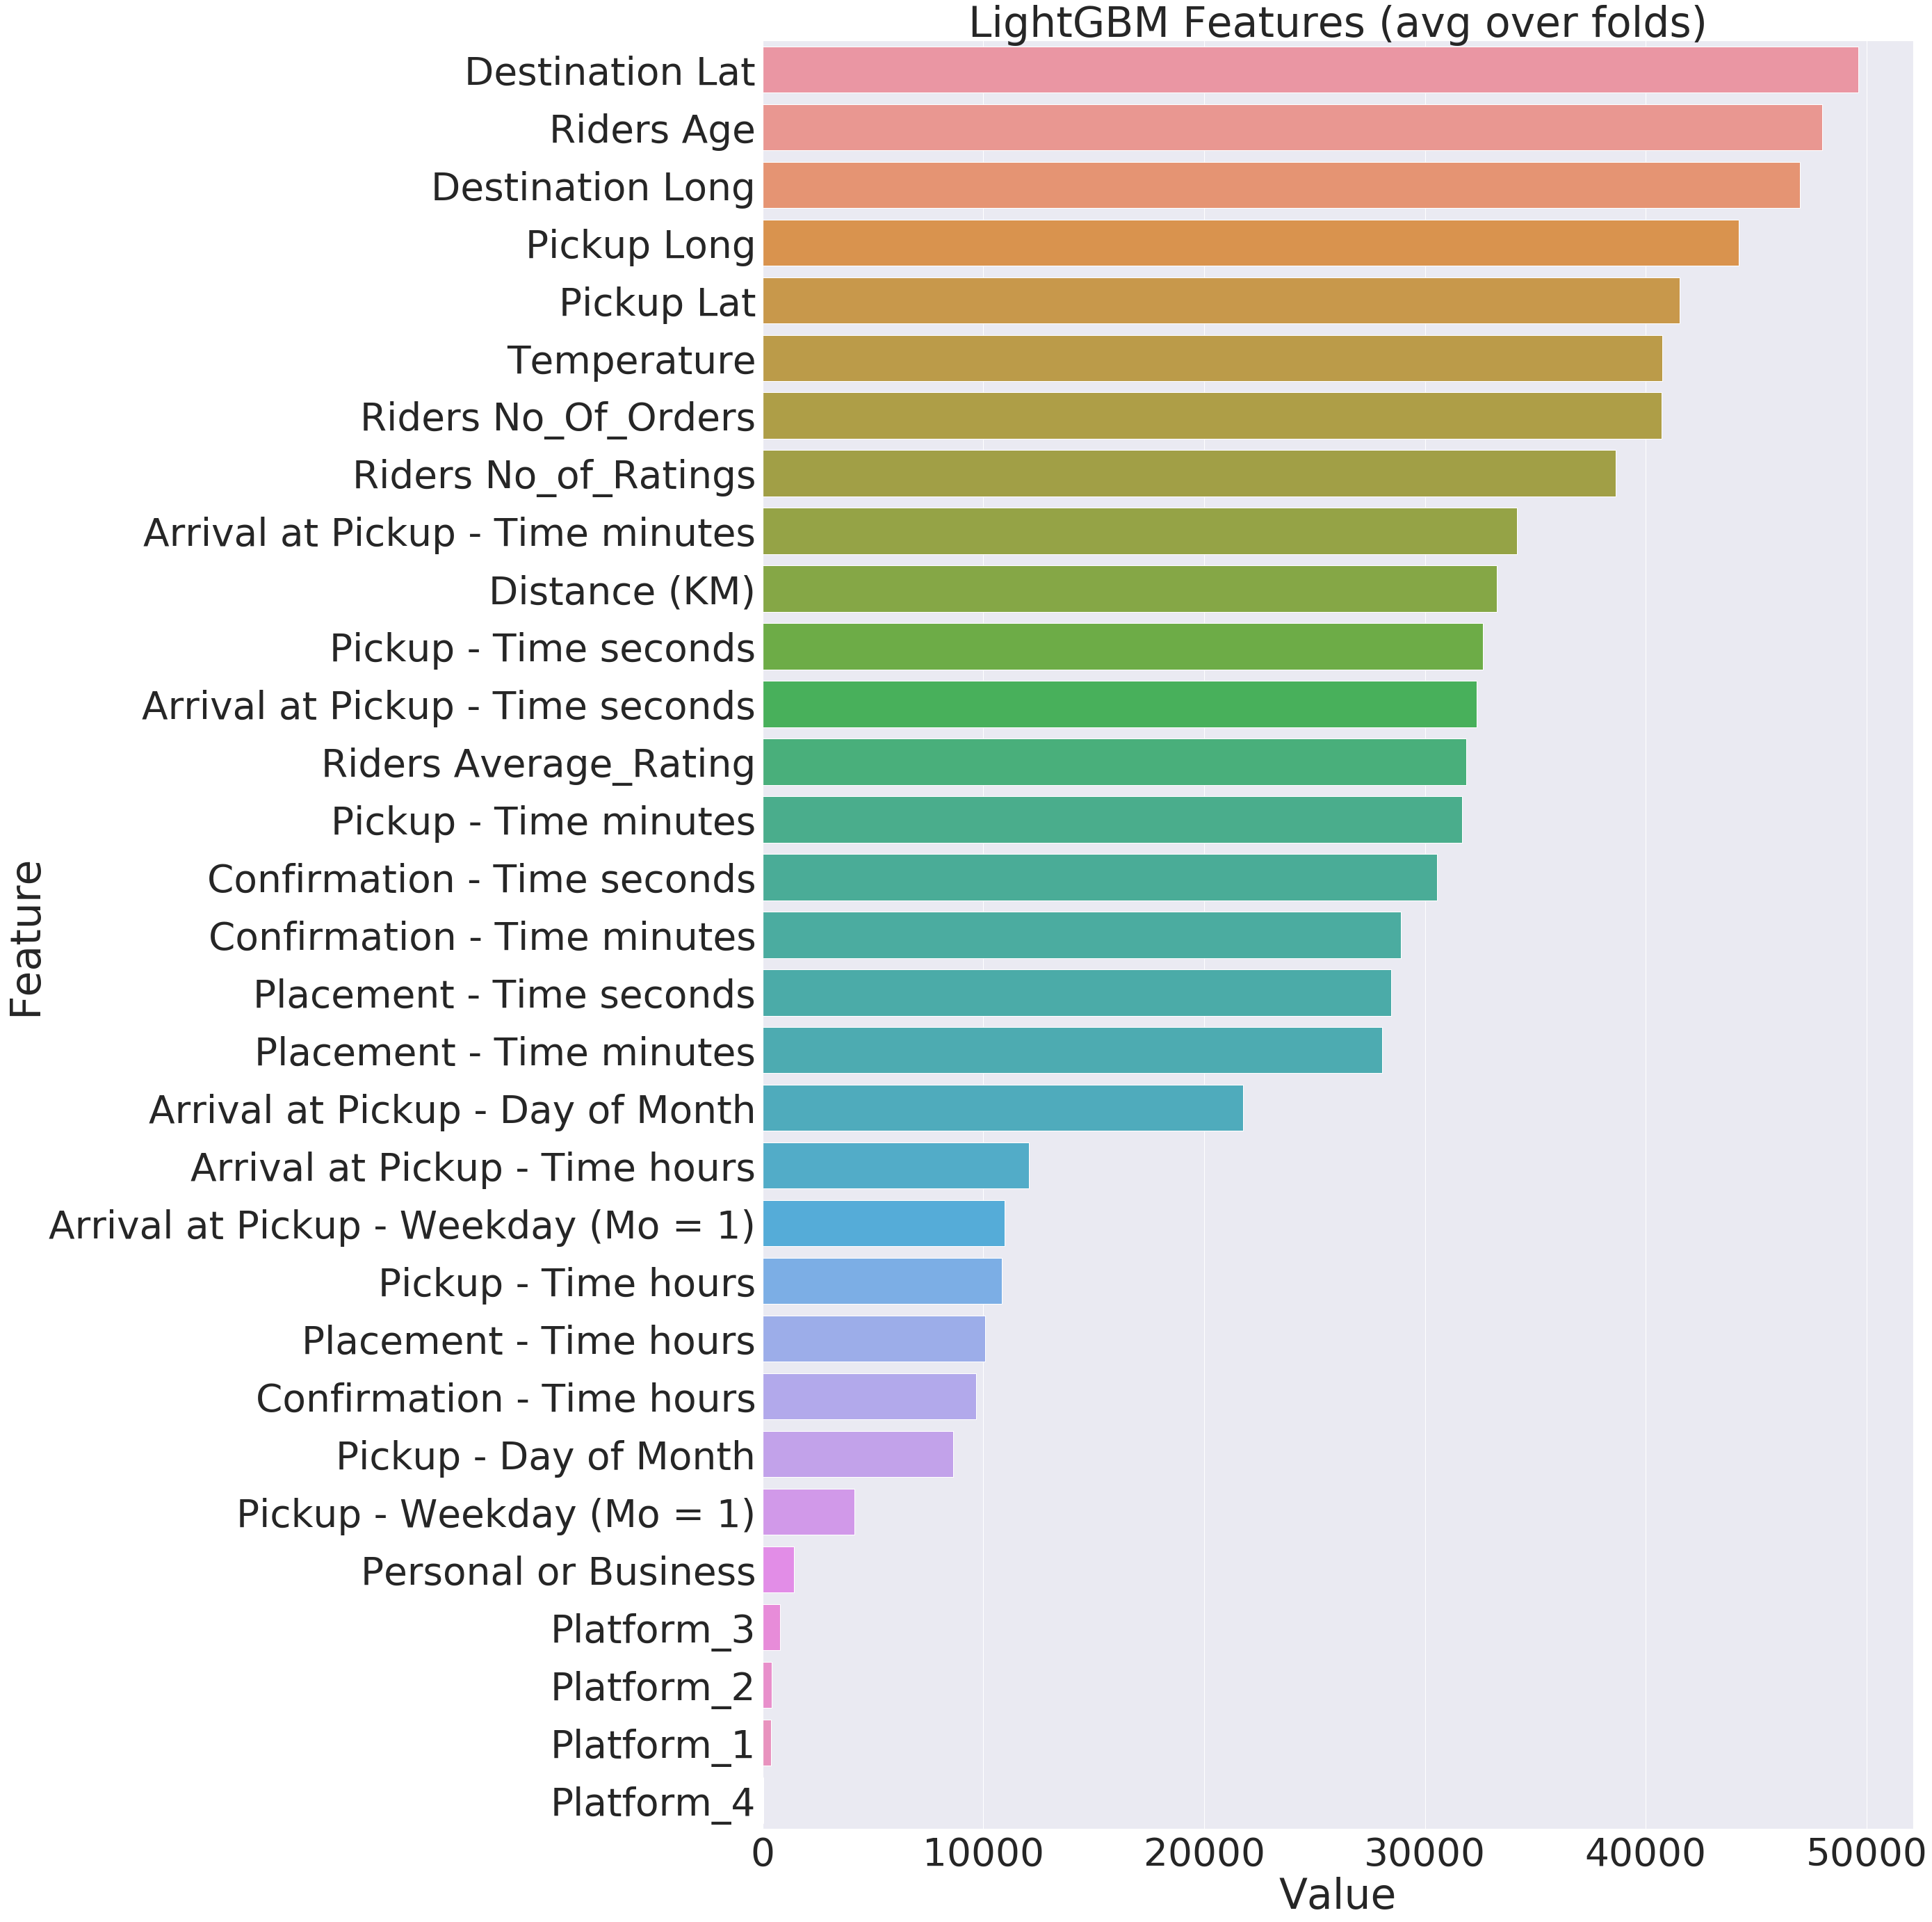

In [172]:
plotImp(model_2, X_train, 50)

In [173]:
xgb = XGBRegressor(max_depth=5, n_estimators=300, min_child_weight=5)
train_model(xgb,  X_train, y_train, X_test, y_test)

RMSE on test data: 746.3988972473394


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

convert lat and long to radians with tempt

In [175]:
temp_lat_in_rad_data = convert_to_randians(target_encoded_data)

train, test = split_train_test_set(temp_lat_in_rad_data, y_label)
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=[y_label, 'Order No']), train[y_label])
test = test.drop(columns=[y_label])

In [176]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.001,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
    
train_set = lgbm.Dataset(X_train, y_train, silent=False)
valid_set = lgbm.Dataset(X_test, y_test, silent=False)
model_3 = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500, valid_sets=valid_set)

[1]	valid_0's rmse: 996.682
Training until validation scores don't improve for 500 rounds
[2]	valid_0's rmse: 996.44
[3]	valid_0's rmse: 996.099
[4]	valid_0's rmse: 995.876
[5]	valid_0's rmse: 995.647
[6]	valid_0's rmse: 995.429
[7]	valid_0's rmse: 995.083
[8]	valid_0's rmse: 994.89
[9]	valid_0's rmse: 994.552
[10]	valid_0's rmse: 994.214
[11]	valid_0's rmse: 993.976
[12]	valid_0's rmse: 993.639
[13]	valid_0's rmse: 993.301
[14]	valid_0's rmse: 993.066
[15]	valid_0's rmse: 992.723
[16]	valid_0's rmse: 992.486
[17]	valid_0's rmse: 992.286
[18]	valid_0's rmse: 991.949
[19]	valid_0's rmse: 991.615
[20]	valid_0's rmse: 991.381
[21]	valid_0's rmse: 991.146
[22]	valid_0's rmse: 990.805
[23]	valid_0's rmse: 990.568
[24]	valid_0's rmse: 990.473
[25]	valid_0's rmse: 990.26
[26]	valid_0's rmse: 989.927
[27]	valid_0's rmse: 989.591
[28]	valid_0's rmse: 989.26
[29]	valid_0's rmse: 988.921
[30]	valid_0's rmse: 988.686
[31]	valid_0's rmse: 988.356
[32]	valid_0's rmse: 988.017
[33]	valid_0's rmse: 98

[286]	valid_0's rmse: 927.552
[287]	valid_0's rmse: 927.367
[288]	valid_0's rmse: 927.222
[289]	valid_0's rmse: 927.155
[290]	valid_0's rmse: 926.918
[291]	valid_0's rmse: 926.853
[292]	valid_0's rmse: 926.624
[293]	valid_0's rmse: 926.395
[294]	valid_0's rmse: 926.16
[295]	valid_0's rmse: 925.929
[296]	valid_0's rmse: 925.695
[297]	valid_0's rmse: 925.455
[298]	valid_0's rmse: 925.229
[299]	valid_0's rmse: 925.077
[300]	valid_0's rmse: 924.844
[301]	valid_0's rmse: 924.612
[302]	valid_0's rmse: 924.388
[303]	valid_0's rmse: 924.163
[304]	valid_0's rmse: 924.001
[305]	valid_0's rmse: 923.771
[306]	valid_0's rmse: 923.541
[307]	valid_0's rmse: 923.309
[308]	valid_0's rmse: 923.147
[309]	valid_0's rmse: 922.925
[310]	valid_0's rmse: 922.699
[311]	valid_0's rmse: 922.471
[312]	valid_0's rmse: 922.295
[313]	valid_0's rmse: 922.212
[314]	valid_0's rmse: 921.982
[315]	valid_0's rmse: 921.752
[316]	valid_0's rmse: 921.524
[317]	valid_0's rmse: 921.386
[318]	valid_0's rmse: 921.163
[319]	valid

[562]	valid_0's rmse: 881.654
[563]	valid_0's rmse: 881.499
[564]	valid_0's rmse: 881.338
[565]	valid_0's rmse: 881.179
[566]	valid_0's rmse: 881.127
[567]	valid_0's rmse: 881.026
[568]	valid_0's rmse: 880.869
[569]	valid_0's rmse: 880.781
[570]	valid_0's rmse: 880.618
[571]	valid_0's rmse: 880.528
[572]	valid_0's rmse: 880.372
[573]	valid_0's rmse: 880.21
[574]	valid_0's rmse: 880.122
[575]	valid_0's rmse: 879.964
[576]	valid_0's rmse: 879.809
[577]	valid_0's rmse: 879.773
[578]	valid_0's rmse: 879.655
[579]	valid_0's rmse: 879.495
[580]	valid_0's rmse: 879.339
[581]	valid_0's rmse: 879.184
[582]	valid_0's rmse: 879.029
[583]	valid_0's rmse: 878.984
[584]	valid_0's rmse: 878.877
[585]	valid_0's rmse: 878.717
[586]	valid_0's rmse: 878.562
[587]	valid_0's rmse: 878.454
[588]	valid_0's rmse: 878.35
[589]	valid_0's rmse: 878.191
[590]	valid_0's rmse: 878.088
[591]	valid_0's rmse: 877.931
[592]	valid_0's rmse: 877.84
[593]	valid_0's rmse: 877.682
[594]	valid_0's rmse: 877.528
[595]	valid_0

[845]	valid_0's rmse: 850.801
[846]	valid_0's rmse: 850.691
[847]	valid_0's rmse: 850.588
[848]	valid_0's rmse: 850.511
[849]	valid_0's rmse: 850.398
[850]	valid_0's rmse: 850.293
[851]	valid_0's rmse: 850.189
[852]	valid_0's rmse: 850.082
[853]	valid_0's rmse: 850.023
[854]	valid_0's rmse: 849.918
[855]	valid_0's rmse: 849.849
[856]	valid_0's rmse: 849.816
[857]	valid_0's rmse: 849.706
[858]	valid_0's rmse: 849.595
[859]	valid_0's rmse: 849.523
[860]	valid_0's rmse: 849.5
[861]	valid_0's rmse: 849.391
[862]	valid_0's rmse: 849.317
[863]	valid_0's rmse: 849.263
[864]	valid_0's rmse: 849.205
[865]	valid_0's rmse: 849.137
[866]	valid_0's rmse: 849.03
[867]	valid_0's rmse: 848.956
[868]	valid_0's rmse: 848.882
[869]	valid_0's rmse: 848.775
[870]	valid_0's rmse: 848.671
[871]	valid_0's rmse: 848.567
[872]	valid_0's rmse: 848.493
[873]	valid_0's rmse: 848.429
[874]	valid_0's rmse: 848.37
[875]	valid_0's rmse: 848.303
[876]	valid_0's rmse: 848.199
[877]	valid_0's rmse: 848.099
[878]	valid_0'

[1128]	valid_0's rmse: 829.359
[1129]	valid_0's rmse: 829.285
[1130]	valid_0's rmse: 829.257
[1131]	valid_0's rmse: 829.209
[1132]	valid_0's rmse: 829.135
[1133]	valid_0's rmse: 829.107
[1134]	valid_0's rmse: 829.034
[1135]	valid_0's rmse: 829.013
[1136]	valid_0's rmse: 828.938
[1137]	valid_0's rmse: 828.861
[1138]	valid_0's rmse: 828.789
[1139]	valid_0's rmse: 828.74
[1140]	valid_0's rmse: 828.697
[1141]	valid_0's rmse: 828.669
[1142]	valid_0's rmse: 828.598
[1143]	valid_0's rmse: 828.522
[1144]	valid_0's rmse: 828.445
[1145]	valid_0's rmse: 828.372
[1146]	valid_0's rmse: 828.327
[1147]	valid_0's rmse: 828.255
[1148]	valid_0's rmse: 828.186
[1149]	valid_0's rmse: 828.117
[1150]	valid_0's rmse: 828.046
[1151]	valid_0's rmse: 827.972
[1152]	valid_0's rmse: 827.902
[1153]	valid_0's rmse: 827.83
[1154]	valid_0's rmse: 827.779
[1155]	valid_0's rmse: 827.709
[1156]	valid_0's rmse: 827.67
[1157]	valid_0's rmse: 827.601
[1158]	valid_0's rmse: 827.552
[1159]	valid_0's rmse: 827.506
[1160]	vali

[1410]	valid_0's rmse: 814.768
[1411]	valid_0's rmse: 814.722
[1412]	valid_0's rmse: 814.666
[1413]	valid_0's rmse: 814.631
[1414]	valid_0's rmse: 814.598
[1415]	valid_0's rmse: 814.577
[1416]	valid_0's rmse: 814.523
[1417]	valid_0's rmse: 814.491
[1418]	valid_0's rmse: 814.435
[1419]	valid_0's rmse: 814.382
[1420]	valid_0's rmse: 814.348
[1421]	valid_0's rmse: 814.292
[1422]	valid_0's rmse: 814.242
[1423]	valid_0's rmse: 814.213
[1424]	valid_0's rmse: 814.175
[1425]	valid_0's rmse: 814.14
[1426]	valid_0's rmse: 814.086
[1427]	valid_0's rmse: 814.034
[1428]	valid_0's rmse: 814.008
[1429]	valid_0's rmse: 813.996
[1430]	valid_0's rmse: 813.944
[1431]	valid_0's rmse: 813.891
[1432]	valid_0's rmse: 813.835
[1433]	valid_0's rmse: 813.797
[1434]	valid_0's rmse: 813.76
[1435]	valid_0's rmse: 813.737
[1436]	valid_0's rmse: 813.693
[1437]	valid_0's rmse: 813.648
[1438]	valid_0's rmse: 813.595
[1439]	valid_0's rmse: 813.56
[1440]	valid_0's rmse: 813.512
[1441]	valid_0's rmse: 813.458
[1442]	vali

[1700]	valid_0's rmse: 804.173
[1701]	valid_0's rmse: 804.129
[1702]	valid_0's rmse: 804.089
[1703]	valid_0's rmse: 804.068
[1704]	valid_0's rmse: 804.031
[1705]	valid_0's rmse: 803.996
[1706]	valid_0's rmse: 803.975
[1707]	valid_0's rmse: 803.936
[1708]	valid_0's rmse: 803.919
[1709]	valid_0's rmse: 803.9
[1710]	valid_0's rmse: 803.863
[1711]	valid_0's rmse: 803.838
[1712]	valid_0's rmse: 803.807
[1713]	valid_0's rmse: 803.8
[1714]	valid_0's rmse: 803.756
[1715]	valid_0's rmse: 803.735
[1716]	valid_0's rmse: 803.704
[1717]	valid_0's rmse: 803.68
[1718]	valid_0's rmse: 803.662
[1719]	valid_0's rmse: 803.645
[1720]	valid_0's rmse: 803.622
[1721]	valid_0's rmse: 803.58
[1722]	valid_0's rmse: 803.545
[1723]	valid_0's rmse: 803.51
[1724]	valid_0's rmse: 803.494
[1725]	valid_0's rmse: 803.468
[1726]	valid_0's rmse: 803.426
[1727]	valid_0's rmse: 803.387
[1728]	valid_0's rmse: 803.356
[1729]	valid_0's rmse: 803.322
[1730]	valid_0's rmse: 803.3
[1731]	valid_0's rmse: 803.263
[1732]	valid_0's 

[1980]	valid_0's rmse: 796.836
[1981]	valid_0's rmse: 796.81
[1982]	valid_0's rmse: 796.787
[1983]	valid_0's rmse: 796.761
[1984]	valid_0's rmse: 796.729
[1985]	valid_0's rmse: 796.697
[1986]	valid_0's rmse: 796.674
[1987]	valid_0's rmse: 796.645
[1988]	valid_0's rmse: 796.617
[1989]	valid_0's rmse: 796.592
[1990]	valid_0's rmse: 796.567
[1991]	valid_0's rmse: 796.537
[1992]	valid_0's rmse: 796.516
[1993]	valid_0's rmse: 796.488
[1994]	valid_0's rmse: 796.461
[1995]	valid_0's rmse: 796.434
[1996]	valid_0's rmse: 796.408
[1997]	valid_0's rmse: 796.385
[1998]	valid_0's rmse: 796.378
[1999]	valid_0's rmse: 796.353
[2000]	valid_0's rmse: 796.325
[2001]	valid_0's rmse: 796.296
[2002]	valid_0's rmse: 796.287
[2003]	valid_0's rmse: 796.275
[2004]	valid_0's rmse: 796.249
[2005]	valid_0's rmse: 796.226
[2006]	valid_0's rmse: 796.21
[2007]	valid_0's rmse: 796.184
[2008]	valid_0's rmse: 796.172
[2009]	valid_0's rmse: 796.159
[2010]	valid_0's rmse: 796.13
[2011]	valid_0's rmse: 796.124
[2012]	vali

[2257]	valid_0's rmse: 791.304
[2258]	valid_0's rmse: 791.282
[2259]	valid_0's rmse: 791.266
[2260]	valid_0's rmse: 791.256
[2261]	valid_0's rmse: 791.242
[2262]	valid_0's rmse: 791.225
[2263]	valid_0's rmse: 791.204
[2264]	valid_0's rmse: 791.186
[2265]	valid_0's rmse: 791.176
[2266]	valid_0's rmse: 791.154
[2267]	valid_0's rmse: 791.136
[2268]	valid_0's rmse: 791.113
[2269]	valid_0's rmse: 791.096
[2270]	valid_0's rmse: 791.074
[2271]	valid_0's rmse: 791.056
[2272]	valid_0's rmse: 791.036
[2273]	valid_0's rmse: 791.016
[2274]	valid_0's rmse: 790.998
[2275]	valid_0's rmse: 790.985
[2276]	valid_0's rmse: 790.967
[2277]	valid_0's rmse: 790.947
[2278]	valid_0's rmse: 790.935
[2279]	valid_0's rmse: 790.918
[2280]	valid_0's rmse: 790.908
[2281]	valid_0's rmse: 790.891
[2282]	valid_0's rmse: 790.879
[2283]	valid_0's rmse: 790.857
[2284]	valid_0's rmse: 790.836
[2285]	valid_0's rmse: 790.814
[2286]	valid_0's rmse: 790.798
[2287]	valid_0's rmse: 790.781
[2288]	valid_0's rmse: 790.762
[2289]	v

[2536]	valid_0's rmse: 787.087
[2537]	valid_0's rmse: 787.074
[2538]	valid_0's rmse: 787.063
[2539]	valid_0's rmse: 787.049
[2540]	valid_0's rmse: 787.043
[2541]	valid_0's rmse: 787.03
[2542]	valid_0's rmse: 787.02
[2543]	valid_0's rmse: 787.009
[2544]	valid_0's rmse: 786.993
[2545]	valid_0's rmse: 786.98
[2546]	valid_0's rmse: 786.964
[2547]	valid_0's rmse: 786.957
[2548]	valid_0's rmse: 786.945
[2549]	valid_0's rmse: 786.93
[2550]	valid_0's rmse: 786.917
[2551]	valid_0's rmse: 786.903
[2552]	valid_0's rmse: 786.894
[2553]	valid_0's rmse: 786.891
[2554]	valid_0's rmse: 786.874
[2555]	valid_0's rmse: 786.865
[2556]	valid_0's rmse: 786.849
[2557]	valid_0's rmse: 786.841
[2558]	valid_0's rmse: 786.825
[2559]	valid_0's rmse: 786.818
[2560]	valid_0's rmse: 786.804
[2561]	valid_0's rmse: 786.797
[2562]	valid_0's rmse: 786.778
[2563]	valid_0's rmse: 786.768
[2564]	valid_0's rmse: 786.753
[2565]	valid_0's rmse: 786.747
[2566]	valid_0's rmse: 786.731
[2567]	valid_0's rmse: 786.718
[2568]	valid

[2835]	valid_0's rmse: 783.765
[2836]	valid_0's rmse: 783.75
[2837]	valid_0's rmse: 783.741
[2838]	valid_0's rmse: 783.729
[2839]	valid_0's rmse: 783.715
[2840]	valid_0's rmse: 783.704
[2841]	valid_0's rmse: 783.701
[2842]	valid_0's rmse: 783.697
[2843]	valid_0's rmse: 783.686
[2844]	valid_0's rmse: 783.676
[2845]	valid_0's rmse: 783.663
[2846]	valid_0's rmse: 783.652
[2847]	valid_0's rmse: 783.649
[2848]	valid_0's rmse: 783.639
[2849]	valid_0's rmse: 783.631
[2850]	valid_0's rmse: 783.619
[2851]	valid_0's rmse: 783.606
[2852]	valid_0's rmse: 783.593
[2853]	valid_0's rmse: 783.59
[2854]	valid_0's rmse: 783.584
[2855]	valid_0's rmse: 783.572
[2856]	valid_0's rmse: 783.559
[2857]	valid_0's rmse: 783.549
[2858]	valid_0's rmse: 783.537
[2859]	valid_0's rmse: 783.526
[2860]	valid_0's rmse: 783.519
[2861]	valid_0's rmse: 783.503
[2862]	valid_0's rmse: 783.489
[2863]	valid_0's rmse: 783.478
[2864]	valid_0's rmse: 783.466
[2865]	valid_0's rmse: 783.456
[2866]	valid_0's rmse: 783.447
[2867]	val

[3102]	valid_0's rmse: 781.385
[3103]	valid_0's rmse: 781.378
[3104]	valid_0's rmse: 781.373
[3105]	valid_0's rmse: 781.365
[3106]	valid_0's rmse: 781.356
[3107]	valid_0's rmse: 781.347
[3108]	valid_0's rmse: 781.34
[3109]	valid_0's rmse: 781.332
[3110]	valid_0's rmse: 781.322
[3111]	valid_0's rmse: 781.314
[3112]	valid_0's rmse: 781.309
[3113]	valid_0's rmse: 781.301
[3114]	valid_0's rmse: 781.293
[3115]	valid_0's rmse: 781.282
[3116]	valid_0's rmse: 781.275
[3117]	valid_0's rmse: 781.27
[3118]	valid_0's rmse: 781.257
[3119]	valid_0's rmse: 781.252
[3120]	valid_0's rmse: 781.244
[3121]	valid_0's rmse: 781.242
[3122]	valid_0's rmse: 781.232
[3123]	valid_0's rmse: 781.219
[3124]	valid_0's rmse: 781.216
[3125]	valid_0's rmse: 781.205
[3126]	valid_0's rmse: 781.197
[3127]	valid_0's rmse: 781.196
[3128]	valid_0's rmse: 781.194
[3129]	valid_0's rmse: 781.19
[3130]	valid_0's rmse: 781.182
[3131]	valid_0's rmse: 781.17
[3132]	valid_0's rmse: 781.163
[3133]	valid_0's rmse: 781.155
[3134]	valid

[3371]	valid_0's rmse: 779.493
[3372]	valid_0's rmse: 779.486
[3373]	valid_0's rmse: 779.485
[3374]	valid_0's rmse: 779.479
[3375]	valid_0's rmse: 779.473
[3376]	valid_0's rmse: 779.467
[3377]	valid_0's rmse: 779.455
[3378]	valid_0's rmse: 779.448
[3379]	valid_0's rmse: 779.442
[3380]	valid_0's rmse: 779.43
[3381]	valid_0's rmse: 779.429
[3382]	valid_0's rmse: 779.423
[3383]	valid_0's rmse: 779.413
[3384]	valid_0's rmse: 779.407
[3385]	valid_0's rmse: 779.399
[3386]	valid_0's rmse: 779.398
[3387]	valid_0's rmse: 779.389
[3388]	valid_0's rmse: 779.382
[3389]	valid_0's rmse: 779.379
[3390]	valid_0's rmse: 779.368
[3391]	valid_0's rmse: 779.355
[3392]	valid_0's rmse: 779.34
[3393]	valid_0's rmse: 779.336
[3394]	valid_0's rmse: 779.332
[3395]	valid_0's rmse: 779.325
[3396]	valid_0's rmse: 779.318
[3397]	valid_0's rmse: 779.31
[3398]	valid_0's rmse: 779.307
[3399]	valid_0's rmse: 779.301
[3400]	valid_0's rmse: 779.297
[3401]	valid_0's rmse: 779.291
[3402]	valid_0's rmse: 779.278
[3403]	vali

[3643]	valid_0's rmse: 777.841
[3644]	valid_0's rmse: 777.836
[3645]	valid_0's rmse: 777.833
[3646]	valid_0's rmse: 777.829
[3647]	valid_0's rmse: 777.821
[3648]	valid_0's rmse: 777.822
[3649]	valid_0's rmse: 777.82
[3650]	valid_0's rmse: 777.813
[3651]	valid_0's rmse: 777.806
[3652]	valid_0's rmse: 777.804
[3653]	valid_0's rmse: 777.801
[3654]	valid_0's rmse: 777.795
[3655]	valid_0's rmse: 777.797
[3656]	valid_0's rmse: 777.79
[3657]	valid_0's rmse: 777.787
[3658]	valid_0's rmse: 777.78
[3659]	valid_0's rmse: 777.773
[3660]	valid_0's rmse: 777.767
[3661]	valid_0's rmse: 777.767
[3662]	valid_0's rmse: 777.763
[3663]	valid_0's rmse: 777.755
[3664]	valid_0's rmse: 777.751
[3665]	valid_0's rmse: 777.744
[3666]	valid_0's rmse: 777.735
[3667]	valid_0's rmse: 777.731
[3668]	valid_0's rmse: 777.724
[3669]	valid_0's rmse: 777.718
[3670]	valid_0's rmse: 777.716
[3671]	valid_0's rmse: 777.709
[3672]	valid_0's rmse: 777.7
[3673]	valid_0's rmse: 777.7
[3674]	valid_0's rmse: 777.694
[3675]	valid_0'

[3920]	valid_0's rmse: 776.405
[3921]	valid_0's rmse: 776.398
[3922]	valid_0's rmse: 776.387
[3923]	valid_0's rmse: 776.385
[3924]	valid_0's rmse: 776.38
[3925]	valid_0's rmse: 776.372
[3926]	valid_0's rmse: 776.369
[3927]	valid_0's rmse: 776.363
[3928]	valid_0's rmse: 776.358
[3929]	valid_0's rmse: 776.352
[3930]	valid_0's rmse: 776.35
[3931]	valid_0's rmse: 776.347
[3932]	valid_0's rmse: 776.344
[3933]	valid_0's rmse: 776.339
[3934]	valid_0's rmse: 776.331
[3935]	valid_0's rmse: 776.324
[3936]	valid_0's rmse: 776.321
[3937]	valid_0's rmse: 776.312
[3938]	valid_0's rmse: 776.308
[3939]	valid_0's rmse: 776.304
[3940]	valid_0's rmse: 776.3
[3941]	valid_0's rmse: 776.302
[3942]	valid_0's rmse: 776.299
[3943]	valid_0's rmse: 776.294
[3944]	valid_0's rmse: 776.287
[3945]	valid_0's rmse: 776.283
[3946]	valid_0's rmse: 776.278
[3947]	valid_0's rmse: 776.267
[3948]	valid_0's rmse: 776.262
[3949]	valid_0's rmse: 776.258
[3950]	valid_0's rmse: 776.247
[3951]	valid_0's rmse: 776.234
[3952]	valid

[4202]	valid_0's rmse: 775.012
[4203]	valid_0's rmse: 775.009
[4204]	valid_0's rmse: 775.002
[4205]	valid_0's rmse: 774.996
[4206]	valid_0's rmse: 774.995
[4207]	valid_0's rmse: 774.983
[4208]	valid_0's rmse: 774.982
[4209]	valid_0's rmse: 774.976
[4210]	valid_0's rmse: 774.974
[4211]	valid_0's rmse: 774.965
[4212]	valid_0's rmse: 774.956
[4213]	valid_0's rmse: 774.951
[4214]	valid_0's rmse: 774.95
[4215]	valid_0's rmse: 774.946
[4216]	valid_0's rmse: 774.948
[4217]	valid_0's rmse: 774.947
[4218]	valid_0's rmse: 774.943
[4219]	valid_0's rmse: 774.933
[4220]	valid_0's rmse: 774.931
[4221]	valid_0's rmse: 774.928
[4222]	valid_0's rmse: 774.926
[4223]	valid_0's rmse: 774.928
[4224]	valid_0's rmse: 774.922
[4225]	valid_0's rmse: 774.918
[4226]	valid_0's rmse: 774.913
[4227]	valid_0's rmse: 774.905
[4228]	valid_0's rmse: 774.899
[4229]	valid_0's rmse: 774.892
[4230]	valid_0's rmse: 774.887
[4231]	valid_0's rmse: 774.881
[4232]	valid_0's rmse: 774.878
[4233]	valid_0's rmse: 774.873
[4234]	va

[4483]	valid_0's rmse: 773.849
[4484]	valid_0's rmse: 773.845
[4485]	valid_0's rmse: 773.841
[4486]	valid_0's rmse: 773.839
[4487]	valid_0's rmse: 773.828
[4488]	valid_0's rmse: 773.827
[4489]	valid_0's rmse: 773.824
[4490]	valid_0's rmse: 773.821
[4491]	valid_0's rmse: 773.818
[4492]	valid_0's rmse: 773.816
[4493]	valid_0's rmse: 773.807
[4494]	valid_0's rmse: 773.806
[4495]	valid_0's rmse: 773.803
[4496]	valid_0's rmse: 773.8
[4497]	valid_0's rmse: 773.796
[4498]	valid_0's rmse: 773.79
[4499]	valid_0's rmse: 773.787
[4500]	valid_0's rmse: 773.784
[4501]	valid_0's rmse: 773.777
[4502]	valid_0's rmse: 773.774
[4503]	valid_0's rmse: 773.769
[4504]	valid_0's rmse: 773.764
[4505]	valid_0's rmse: 773.755
[4506]	valid_0's rmse: 773.754
[4507]	valid_0's rmse: 773.753
[4508]	valid_0's rmse: 773.75
[4509]	valid_0's rmse: 773.747
[4510]	valid_0's rmse: 773.745
[4511]	valid_0's rmse: 773.732
[4512]	valid_0's rmse: 773.727
[4513]	valid_0's rmse: 773.725
[4514]	valid_0's rmse: 773.724
[4515]	valid

[4755]	valid_0's rmse: 772.71
[4756]	valid_0's rmse: 772.703
[4757]	valid_0's rmse: 772.689
[4758]	valid_0's rmse: 772.686
[4759]	valid_0's rmse: 772.684
[4760]	valid_0's rmse: 772.683
[4761]	valid_0's rmse: 772.681
[4762]	valid_0's rmse: 772.675
[4763]	valid_0's rmse: 772.666
[4764]	valid_0's rmse: 772.665
[4765]	valid_0's rmse: 772.662
[4766]	valid_0's rmse: 772.656
[4767]	valid_0's rmse: 772.656
[4768]	valid_0's rmse: 772.653
[4769]	valid_0's rmse: 772.651
[4770]	valid_0's rmse: 772.648
[4771]	valid_0's rmse: 772.645
[4772]	valid_0's rmse: 772.639
[4773]	valid_0's rmse: 772.631
[4774]	valid_0's rmse: 772.629
[4775]	valid_0's rmse: 772.627
[4776]	valid_0's rmse: 772.622
[4777]	valid_0's rmse: 772.618
[4778]	valid_0's rmse: 772.616
[4779]	valid_0's rmse: 772.614
[4780]	valid_0's rmse: 772.608
[4781]	valid_0's rmse: 772.599
[4782]	valid_0's rmse: 772.593
[4783]	valid_0's rmse: 772.589
[4784]	valid_0's rmse: 772.583
[4785]	valid_0's rmse: 772.58
[4786]	valid_0's rmse: 772.569
[4787]	val

[5049]	valid_0's rmse: 771.623
[5050]	valid_0's rmse: 771.62
[5051]	valid_0's rmse: 771.615
[5052]	valid_0's rmse: 771.614
[5053]	valid_0's rmse: 771.609
[5054]	valid_0's rmse: 771.603
[5055]	valid_0's rmse: 771.597
[5056]	valid_0's rmse: 771.594
[5057]	valid_0's rmse: 771.59
[5058]	valid_0's rmse: 771.589
[5059]	valid_0's rmse: 771.587
[5060]	valid_0's rmse: 771.587
[5061]	valid_0's rmse: 771.587
[5062]	valid_0's rmse: 771.579
[5063]	valid_0's rmse: 771.575
[5064]	valid_0's rmse: 771.573
[5065]	valid_0's rmse: 771.571
[5066]	valid_0's rmse: 771.568
[5067]	valid_0's rmse: 771.566
[5068]	valid_0's rmse: 771.565
[5069]	valid_0's rmse: 771.563
[5070]	valid_0's rmse: 771.56
[5071]	valid_0's rmse: 771.559
[5072]	valid_0's rmse: 771.557
[5073]	valid_0's rmse: 771.552
[5074]	valid_0's rmse: 771.551
[5075]	valid_0's rmse: 771.549
[5076]	valid_0's rmse: 771.544
[5077]	valid_0's rmse: 771.541
[5078]	valid_0's rmse: 771.539
[5079]	valid_0's rmse: 771.533
[5080]	valid_0's rmse: 771.531
[5081]	vali

[5354]	valid_0's rmse: 770.674
[5355]	valid_0's rmse: 770.673
[5356]	valid_0's rmse: 770.668
[5357]	valid_0's rmse: 770.667
[5358]	valid_0's rmse: 770.665
[5359]	valid_0's rmse: 770.663
[5360]	valid_0's rmse: 770.661
[5361]	valid_0's rmse: 770.656
[5362]	valid_0's rmse: 770.654
[5363]	valid_0's rmse: 770.649
[5364]	valid_0's rmse: 770.648
[5365]	valid_0's rmse: 770.645
[5366]	valid_0's rmse: 770.642
[5367]	valid_0's rmse: 770.641
[5368]	valid_0's rmse: 770.64
[5369]	valid_0's rmse: 770.636
[5370]	valid_0's rmse: 770.634
[5371]	valid_0's rmse: 770.626
[5372]	valid_0's rmse: 770.621
[5373]	valid_0's rmse: 770.617
[5374]	valid_0's rmse: 770.613
[5375]	valid_0's rmse: 770.612
[5376]	valid_0's rmse: 770.61
[5377]	valid_0's rmse: 770.606
[5378]	valid_0's rmse: 770.602
[5379]	valid_0's rmse: 770.6
[5380]	valid_0's rmse: 770.592
[5381]	valid_0's rmse: 770.591
[5382]	valid_0's rmse: 770.589
[5383]	valid_0's rmse: 770.588
[5384]	valid_0's rmse: 770.587
[5385]	valid_0's rmse: 770.585
[5386]	valid

[5637]	valid_0's rmse: 769.748
[5638]	valid_0's rmse: 769.741
[5639]	valid_0's rmse: 769.733
[5640]	valid_0's rmse: 769.731
[5641]	valid_0's rmse: 769.726
[5642]	valid_0's rmse: 769.725
[5643]	valid_0's rmse: 769.72
[5644]	valid_0's rmse: 769.721
[5645]	valid_0's rmse: 769.716
[5646]	valid_0's rmse: 769.715
[5647]	valid_0's rmse: 769.716
[5648]	valid_0's rmse: 769.71
[5649]	valid_0's rmse: 769.709
[5650]	valid_0's rmse: 769.708
[5651]	valid_0's rmse: 769.704
[5652]	valid_0's rmse: 769.702
[5653]	valid_0's rmse: 769.7
[5654]	valid_0's rmse: 769.7
[5655]	valid_0's rmse: 769.695
[5656]	valid_0's rmse: 769.692
[5657]	valid_0's rmse: 769.69
[5658]	valid_0's rmse: 769.684
[5659]	valid_0's rmse: 769.682
[5660]	valid_0's rmse: 769.676
[5661]	valid_0's rmse: 769.675
[5662]	valid_0's rmse: 769.669
[5663]	valid_0's rmse: 769.67
[5664]	valid_0's rmse: 769.668
[5665]	valid_0's rmse: 769.661
[5666]	valid_0's rmse: 769.658
[5667]	valid_0's rmse: 769.648
[5668]	valid_0's rmse: 769.643
[5669]	valid_0's

[5909]	valid_0's rmse: 769.024
[5910]	valid_0's rmse: 769.017
[5911]	valid_0's rmse: 769.016
[5912]	valid_0's rmse: 769.013
[5913]	valid_0's rmse: 769.012
[5914]	valid_0's rmse: 769.012
[5915]	valid_0's rmse: 769.002
[5916]	valid_0's rmse: 769.003
[5917]	valid_0's rmse: 769.002
[5918]	valid_0's rmse: 768.997
[5919]	valid_0's rmse: 768.991
[5920]	valid_0's rmse: 768.985
[5921]	valid_0's rmse: 768.985
[5922]	valid_0's rmse: 768.985
[5923]	valid_0's rmse: 768.984
[5924]	valid_0's rmse: 768.975
[5925]	valid_0's rmse: 768.973
[5926]	valid_0's rmse: 768.973
[5927]	valid_0's rmse: 768.969
[5928]	valid_0's rmse: 768.971
[5929]	valid_0's rmse: 768.97
[5930]	valid_0's rmse: 768.971
[5931]	valid_0's rmse: 768.969
[5932]	valid_0's rmse: 768.965
[5933]	valid_0's rmse: 768.965
[5934]	valid_0's rmse: 768.965
[5935]	valid_0's rmse: 768.962
[5936]	valid_0's rmse: 768.961
[5937]	valid_0's rmse: 768.953
[5938]	valid_0's rmse: 768.953
[5939]	valid_0's rmse: 768.954
[5940]	valid_0's rmse: 768.955
[5941]	va

[6182]	valid_0's rmse: 768.379
[6183]	valid_0's rmse: 768.379
[6184]	valid_0's rmse: 768.379
[6185]	valid_0's rmse: 768.375
[6186]	valid_0's rmse: 768.372
[6187]	valid_0's rmse: 768.368
[6188]	valid_0's rmse: 768.365
[6189]	valid_0's rmse: 768.359
[6190]	valid_0's rmse: 768.356
[6191]	valid_0's rmse: 768.353
[6192]	valid_0's rmse: 768.35
[6193]	valid_0's rmse: 768.35
[6194]	valid_0's rmse: 768.348
[6195]	valid_0's rmse: 768.349
[6196]	valid_0's rmse: 768.346
[6197]	valid_0's rmse: 768.342
[6198]	valid_0's rmse: 768.334
[6199]	valid_0's rmse: 768.333
[6200]	valid_0's rmse: 768.329
[6201]	valid_0's rmse: 768.326
[6202]	valid_0's rmse: 768.327
[6203]	valid_0's rmse: 768.328
[6204]	valid_0's rmse: 768.324
[6205]	valid_0's rmse: 768.312
[6206]	valid_0's rmse: 768.31
[6207]	valid_0's rmse: 768.31
[6208]	valid_0's rmse: 768.303
[6209]	valid_0's rmse: 768.3
[6210]	valid_0's rmse: 768.297
[6211]	valid_0's rmse: 768.296
[6212]	valid_0's rmse: 768.292
[6213]	valid_0's rmse: 768.291
[6214]	valid_0

[6476]	valid_0's rmse: 767.736
[6477]	valid_0's rmse: 767.733
[6478]	valid_0's rmse: 767.732
[6479]	valid_0's rmse: 767.73
[6480]	valid_0's rmse: 767.729
[6481]	valid_0's rmse: 767.726
[6482]	valid_0's rmse: 767.721
[6483]	valid_0's rmse: 767.718
[6484]	valid_0's rmse: 767.719
[6485]	valid_0's rmse: 767.717
[6486]	valid_0's rmse: 767.715
[6487]	valid_0's rmse: 767.714
[6488]	valid_0's rmse: 767.715
[6489]	valid_0's rmse: 767.712
[6490]	valid_0's rmse: 767.712
[6491]	valid_0's rmse: 767.71
[6492]	valid_0's rmse: 767.707
[6493]	valid_0's rmse: 767.708
[6494]	valid_0's rmse: 767.71
[6495]	valid_0's rmse: 767.71
[6496]	valid_0's rmse: 767.708
[6497]	valid_0's rmse: 767.708
[6498]	valid_0's rmse: 767.704
[6499]	valid_0's rmse: 767.704
[6500]	valid_0's rmse: 767.7
[6501]	valid_0's rmse: 767.695
[6502]	valid_0's rmse: 767.695
[6503]	valid_0's rmse: 767.691
[6504]	valid_0's rmse: 767.688
[6505]	valid_0's rmse: 767.684
[6506]	valid_0's rmse: 767.683
[6507]	valid_0's rmse: 767.68
[6508]	valid_0'

[6748]	valid_0's rmse: 767.264
[6749]	valid_0's rmse: 767.261
[6750]	valid_0's rmse: 767.258
[6751]	valid_0's rmse: 767.258
[6752]	valid_0's rmse: 767.257
[6753]	valid_0's rmse: 767.256
[6754]	valid_0's rmse: 767.255
[6755]	valid_0's rmse: 767.255
[6756]	valid_0's rmse: 767.251
[6757]	valid_0's rmse: 767.25
[6758]	valid_0's rmse: 767.249
[6759]	valid_0's rmse: 767.249
[6760]	valid_0's rmse: 767.248
[6761]	valid_0's rmse: 767.244
[6762]	valid_0's rmse: 767.242
[6763]	valid_0's rmse: 767.239
[6764]	valid_0's rmse: 767.236
[6765]	valid_0's rmse: 767.236
[6766]	valid_0's rmse: 767.236
[6767]	valid_0's rmse: 767.236
[6768]	valid_0's rmse: 767.233
[6769]	valid_0's rmse: 767.232
[6770]	valid_0's rmse: 767.23
[6771]	valid_0's rmse: 767.231
[6772]	valid_0's rmse: 767.226
[6773]	valid_0's rmse: 767.225
[6774]	valid_0's rmse: 767.224
[6775]	valid_0's rmse: 767.223
[6776]	valid_0's rmse: 767.221
[6777]	valid_0's rmse: 767.221
[6778]	valid_0's rmse: 767.217
[6779]	valid_0's rmse: 767.218
[6780]	val

[7054]	valid_0's rmse: 766.773
[7055]	valid_0's rmse: 766.772
[7056]	valid_0's rmse: 766.771
[7057]	valid_0's rmse: 766.769
[7058]	valid_0's rmse: 766.77
[7059]	valid_0's rmse: 766.77
[7060]	valid_0's rmse: 766.764
[7061]	valid_0's rmse: 766.763
[7062]	valid_0's rmse: 766.764
[7063]	valid_0's rmse: 766.763
[7064]	valid_0's rmse: 766.762
[7065]	valid_0's rmse: 766.756
[7066]	valid_0's rmse: 766.754
[7067]	valid_0's rmse: 766.753
[7068]	valid_0's rmse: 766.752
[7069]	valid_0's rmse: 766.753
[7070]	valid_0's rmse: 766.744
[7071]	valid_0's rmse: 766.743
[7072]	valid_0's rmse: 766.737
[7073]	valid_0's rmse: 766.732
[7074]	valid_0's rmse: 766.729
[7075]	valid_0's rmse: 766.724
[7076]	valid_0's rmse: 766.725
[7077]	valid_0's rmse: 766.72
[7078]	valid_0's rmse: 766.718
[7079]	valid_0's rmse: 766.718
[7080]	valid_0's rmse: 766.716
[7081]	valid_0's rmse: 766.715
[7082]	valid_0's rmse: 766.71
[7083]	valid_0's rmse: 766.711
[7084]	valid_0's rmse: 766.712
[7085]	valid_0's rmse: 766.708
[7086]	valid

[7351]	valid_0's rmse: 766.169
[7352]	valid_0's rmse: 766.165
[7353]	valid_0's rmse: 766.162
[7354]	valid_0's rmse: 766.161
[7355]	valid_0's rmse: 766.158
[7356]	valid_0's rmse: 766.157
[7357]	valid_0's rmse: 766.156
[7358]	valid_0's rmse: 766.155
[7359]	valid_0's rmse: 766.153
[7360]	valid_0's rmse: 766.15
[7361]	valid_0's rmse: 766.14
[7362]	valid_0's rmse: 766.14
[7363]	valid_0's rmse: 766.136
[7364]	valid_0's rmse: 766.135
[7365]	valid_0's rmse: 766.135
[7366]	valid_0's rmse: 766.137
[7367]	valid_0's rmse: 766.134
[7368]	valid_0's rmse: 766.133
[7369]	valid_0's rmse: 766.133
[7370]	valid_0's rmse: 766.132
[7371]	valid_0's rmse: 766.129
[7372]	valid_0's rmse: 766.13
[7373]	valid_0's rmse: 766.123
[7374]	valid_0's rmse: 766.124
[7375]	valid_0's rmse: 766.118
[7376]	valid_0's rmse: 766.116
[7377]	valid_0's rmse: 766.115
[7378]	valid_0's rmse: 766.114
[7379]	valid_0's rmse: 766.116
[7380]	valid_0's rmse: 766.117
[7381]	valid_0's rmse: 766.11
[7382]	valid_0's rmse: 766.108
[7383]	valid_

[7639]	valid_0's rmse: 765.635
[7640]	valid_0's rmse: 765.634
[7641]	valid_0's rmse: 765.631
[7642]	valid_0's rmse: 765.631
[7643]	valid_0's rmse: 765.63
[7644]	valid_0's rmse: 765.629
[7645]	valid_0's rmse: 765.627
[7646]	valid_0's rmse: 765.627
[7647]	valid_0's rmse: 765.626
[7648]	valid_0's rmse: 765.626
[7649]	valid_0's rmse: 765.624
[7650]	valid_0's rmse: 765.625
[7651]	valid_0's rmse: 765.622
[7652]	valid_0's rmse: 765.619
[7653]	valid_0's rmse: 765.613
[7654]	valid_0's rmse: 765.612
[7655]	valid_0's rmse: 765.609
[7656]	valid_0's rmse: 765.608
[7657]	valid_0's rmse: 765.608
[7658]	valid_0's rmse: 765.607
[7659]	valid_0's rmse: 765.606
[7660]	valid_0's rmse: 765.607
[7661]	valid_0's rmse: 765.608
[7662]	valid_0's rmse: 765.606
[7663]	valid_0's rmse: 765.608
[7664]	valid_0's rmse: 765.603
[7665]	valid_0's rmse: 765.603
[7666]	valid_0's rmse: 765.603
[7667]	valid_0's rmse: 765.604
[7668]	valid_0's rmse: 765.6
[7669]	valid_0's rmse: 765.598
[7670]	valid_0's rmse: 765.596
[7671]	vali

[7920]	valid_0's rmse: 765.256
[7921]	valid_0's rmse: 765.255
[7922]	valid_0's rmse: 765.255
[7923]	valid_0's rmse: 765.257
[7924]	valid_0's rmse: 765.256
[7925]	valid_0's rmse: 765.253
[7926]	valid_0's rmse: 765.253
[7927]	valid_0's rmse: 765.254
[7928]	valid_0's rmse: 765.252
[7929]	valid_0's rmse: 765.25
[7930]	valid_0's rmse: 765.247
[7931]	valid_0's rmse: 765.245
[7932]	valid_0's rmse: 765.242
[7933]	valid_0's rmse: 765.24
[7934]	valid_0's rmse: 765.239
[7935]	valid_0's rmse: 765.239
[7936]	valid_0's rmse: 765.238
[7937]	valid_0's rmse: 765.238
[7938]	valid_0's rmse: 765.239
[7939]	valid_0's rmse: 765.237
[7940]	valid_0's rmse: 765.235
[7941]	valid_0's rmse: 765.234
[7942]	valid_0's rmse: 765.232
[7943]	valid_0's rmse: 765.229
[7944]	valid_0's rmse: 765.227
[7945]	valid_0's rmse: 765.228
[7946]	valid_0's rmse: 765.222
[7947]	valid_0's rmse: 765.22
[7948]	valid_0's rmse: 765.219
[7949]	valid_0's rmse: 765.216
[7950]	valid_0's rmse: 765.215
[7951]	valid_0's rmse: 765.213
[7952]	vali

[8227]	valid_0's rmse: 764.846
[8228]	valid_0's rmse: 764.841
[8229]	valid_0's rmse: 764.838
[8230]	valid_0's rmse: 764.835
[8231]	valid_0's rmse: 764.835
[8232]	valid_0's rmse: 764.835
[8233]	valid_0's rmse: 764.835
[8234]	valid_0's rmse: 764.834
[8235]	valid_0's rmse: 764.832
[8236]	valid_0's rmse: 764.83
[8237]	valid_0's rmse: 764.829
[8238]	valid_0's rmse: 764.828
[8239]	valid_0's rmse: 764.825
[8240]	valid_0's rmse: 764.823
[8241]	valid_0's rmse: 764.821
[8242]	valid_0's rmse: 764.82
[8243]	valid_0's rmse: 764.817
[8244]	valid_0's rmse: 764.818
[8245]	valid_0's rmse: 764.819
[8246]	valid_0's rmse: 764.817
[8247]	valid_0's rmse: 764.815
[8248]	valid_0's rmse: 764.815
[8249]	valid_0's rmse: 764.813
[8250]	valid_0's rmse: 764.811
[8251]	valid_0's rmse: 764.808
[8252]	valid_0's rmse: 764.806
[8253]	valid_0's rmse: 764.805
[8254]	valid_0's rmse: 764.806
[8255]	valid_0's rmse: 764.806
[8256]	valid_0's rmse: 764.805
[8257]	valid_0's rmse: 764.806
[8258]	valid_0's rmse: 764.799
[8259]	val

[8504]	valid_0's rmse: 764.522
[8505]	valid_0's rmse: 764.523
[8506]	valid_0's rmse: 764.52
[8507]	valid_0's rmse: 764.521
[8508]	valid_0's rmse: 764.522
[8509]	valid_0's rmse: 764.522
[8510]	valid_0's rmse: 764.521
[8511]	valid_0's rmse: 764.522
[8512]	valid_0's rmse: 764.52
[8513]	valid_0's rmse: 764.519
[8514]	valid_0's rmse: 764.518
[8515]	valid_0's rmse: 764.519
[8516]	valid_0's rmse: 764.519
[8517]	valid_0's rmse: 764.519
[8518]	valid_0's rmse: 764.52
[8519]	valid_0's rmse: 764.519
[8520]	valid_0's rmse: 764.52
[8521]	valid_0's rmse: 764.518
[8522]	valid_0's rmse: 764.518
[8523]	valid_0's rmse: 764.519
[8524]	valid_0's rmse: 764.515
[8525]	valid_0's rmse: 764.512
[8526]	valid_0's rmse: 764.511
[8527]	valid_0's rmse: 764.509
[8528]	valid_0's rmse: 764.502
[8529]	valid_0's rmse: 764.504
[8530]	valid_0's rmse: 764.505
[8531]	valid_0's rmse: 764.502
[8532]	valid_0's rmse: 764.502
[8533]	valid_0's rmse: 764.501
[8534]	valid_0's rmse: 764.5
[8535]	valid_0's rmse: 764.501
[8536]	valid_0

[8783]	valid_0's rmse: 764.168
[8784]	valid_0's rmse: 764.169
[8785]	valid_0's rmse: 764.167
[8786]	valid_0's rmse: 764.167
[8787]	valid_0's rmse: 764.166
[8788]	valid_0's rmse: 764.165
[8789]	valid_0's rmse: 764.166
[8790]	valid_0's rmse: 764.163
[8791]	valid_0's rmse: 764.163
[8792]	valid_0's rmse: 764.162
[8793]	valid_0's rmse: 764.16
[8794]	valid_0's rmse: 764.16
[8795]	valid_0's rmse: 764.16
[8796]	valid_0's rmse: 764.156
[8797]	valid_0's rmse: 764.156
[8798]	valid_0's rmse: 764.155
[8799]	valid_0's rmse: 764.152
[8800]	valid_0's rmse: 764.151
[8801]	valid_0's rmse: 764.15
[8802]	valid_0's rmse: 764.149
[8803]	valid_0's rmse: 764.149
[8804]	valid_0's rmse: 764.15
[8805]	valid_0's rmse: 764.151
[8806]	valid_0's rmse: 764.151
[8807]	valid_0's rmse: 764.153
[8808]	valid_0's rmse: 764.153
[8809]	valid_0's rmse: 764.151
[8810]	valid_0's rmse: 764.148
[8811]	valid_0's rmse: 764.147
[8812]	valid_0's rmse: 764.145
[8813]	valid_0's rmse: 764.145
[8814]	valid_0's rmse: 764.141
[8815]	valid_

[9066]	valid_0's rmse: 763.848
[9067]	valid_0's rmse: 763.849
[9068]	valid_0's rmse: 763.848
[9069]	valid_0's rmse: 763.846
[9070]	valid_0's rmse: 763.847
[9071]	valid_0's rmse: 763.845
[9072]	valid_0's rmse: 763.845
[9073]	valid_0's rmse: 763.846
[9074]	valid_0's rmse: 763.844
[9075]	valid_0's rmse: 763.842
[9076]	valid_0's rmse: 763.84
[9077]	valid_0's rmse: 763.84
[9078]	valid_0's rmse: 763.839
[9079]	valid_0's rmse: 763.838
[9080]	valid_0's rmse: 763.839
[9081]	valid_0's rmse: 763.838
[9082]	valid_0's rmse: 763.834
[9083]	valid_0's rmse: 763.83
[9084]	valid_0's rmse: 763.83
[9085]	valid_0's rmse: 763.826
[9086]	valid_0's rmse: 763.827
[9087]	valid_0's rmse: 763.825
[9088]	valid_0's rmse: 763.822
[9089]	valid_0's rmse: 763.818
[9090]	valid_0's rmse: 763.818
[9091]	valid_0's rmse: 763.816
[9092]	valid_0's rmse: 763.815
[9093]	valid_0's rmse: 763.813
[9094]	valid_0's rmse: 763.813
[9095]	valid_0's rmse: 763.811
[9096]	valid_0's rmse: 763.812
[9097]	valid_0's rmse: 763.812
[9098]	valid

[9366]	valid_0's rmse: 763.521
[9367]	valid_0's rmse: 763.521
[9368]	valid_0's rmse: 763.523
[9369]	valid_0's rmse: 763.524
[9370]	valid_0's rmse: 763.521
[9371]	valid_0's rmse: 763.52
[9372]	valid_0's rmse: 763.519
[9373]	valid_0's rmse: 763.518
[9374]	valid_0's rmse: 763.519
[9375]	valid_0's rmse: 763.521
[9376]	valid_0's rmse: 763.519
[9377]	valid_0's rmse: 763.521
[9378]	valid_0's rmse: 763.519
[9379]	valid_0's rmse: 763.519
[9380]	valid_0's rmse: 763.514
[9381]	valid_0's rmse: 763.513
[9382]	valid_0's rmse: 763.51
[9383]	valid_0's rmse: 763.51
[9384]	valid_0's rmse: 763.505
[9385]	valid_0's rmse: 763.505
[9386]	valid_0's rmse: 763.502
[9387]	valid_0's rmse: 763.501
[9388]	valid_0's rmse: 763.501
[9389]	valid_0's rmse: 763.498
[9390]	valid_0's rmse: 763.499
[9391]	valid_0's rmse: 763.497
[9392]	valid_0's rmse: 763.498
[9393]	valid_0's rmse: 763.497
[9394]	valid_0's rmse: 763.496
[9395]	valid_0's rmse: 763.492
[9396]	valid_0's rmse: 763.494
[9397]	valid_0's rmse: 763.491
[9398]	vali

[9665]	valid_0's rmse: 763.17
[9666]	valid_0's rmse: 763.168
[9667]	valid_0's rmse: 763.165
[9668]	valid_0's rmse: 763.164
[9669]	valid_0's rmse: 763.161
[9670]	valid_0's rmse: 763.16
[9671]	valid_0's rmse: 763.155
[9672]	valid_0's rmse: 763.153
[9673]	valid_0's rmse: 763.152
[9674]	valid_0's rmse: 763.15
[9675]	valid_0's rmse: 763.149
[9676]	valid_0's rmse: 763.148
[9677]	valid_0's rmse: 763.146
[9678]	valid_0's rmse: 763.146
[9679]	valid_0's rmse: 763.145
[9680]	valid_0's rmse: 763.145
[9681]	valid_0's rmse: 763.143
[9682]	valid_0's rmse: 763.143
[9683]	valid_0's rmse: 763.143
[9684]	valid_0's rmse: 763.144
[9685]	valid_0's rmse: 763.144
[9686]	valid_0's rmse: 763.142
[9687]	valid_0's rmse: 763.142
[9688]	valid_0's rmse: 763.138
[9689]	valid_0's rmse: 763.135
[9690]	valid_0's rmse: 763.134
[9691]	valid_0's rmse: 763.134
[9692]	valid_0's rmse: 763.135
[9693]	valid_0's rmse: 763.131
[9694]	valid_0's rmse: 763.13
[9695]	valid_0's rmse: 763.127
[9696]	valid_0's rmse: 763.128
[9697]	valid

[9937]	valid_0's rmse: 762.848
[9938]	valid_0's rmse: 762.847
[9939]	valid_0's rmse: 762.847
[9940]	valid_0's rmse: 762.844
[9941]	valid_0's rmse: 762.845
[9942]	valid_0's rmse: 762.844
[9943]	valid_0's rmse: 762.843
[9944]	valid_0's rmse: 762.843
[9945]	valid_0's rmse: 762.843
[9946]	valid_0's rmse: 762.841
[9947]	valid_0's rmse: 762.838
[9948]	valid_0's rmse: 762.837
[9949]	valid_0's rmse: 762.836
[9950]	valid_0's rmse: 762.835
[9951]	valid_0's rmse: 762.831
[9952]	valid_0's rmse: 762.832
[9953]	valid_0's rmse: 762.832
[9954]	valid_0's rmse: 762.831
[9955]	valid_0's rmse: 762.832
[9956]	valid_0's rmse: 762.831
[9957]	valid_0's rmse: 762.831
[9958]	valid_0's rmse: 762.831
[9959]	valid_0's rmse: 762.828
[9960]	valid_0's rmse: 762.825
[9961]	valid_0's rmse: 762.824
[9962]	valid_0's rmse: 762.823
[9963]	valid_0's rmse: 762.823
[9964]	valid_0's rmse: 762.821
[9965]	valid_0's rmse: 762.82
[9966]	valid_0's rmse: 762.817
[9967]	valid_0's rmse: 762.816
[9968]	valid_0's rmse: 762.814
[9969]	va

[10249]	valid_0's rmse: 762.49
[10250]	valid_0's rmse: 762.488
[10251]	valid_0's rmse: 762.486
[10252]	valid_0's rmse: 762.484
[10253]	valid_0's rmse: 762.483
[10254]	valid_0's rmse: 762.482
[10255]	valid_0's rmse: 762.482
[10256]	valid_0's rmse: 762.482
[10257]	valid_0's rmse: 762.476
[10258]	valid_0's rmse: 762.474
[10259]	valid_0's rmse: 762.473
[10260]	valid_0's rmse: 762.473
[10261]	valid_0's rmse: 762.468
[10262]	valid_0's rmse: 762.467
[10263]	valid_0's rmse: 762.466
[10264]	valid_0's rmse: 762.465
[10265]	valid_0's rmse: 762.464
[10266]	valid_0's rmse: 762.463
[10267]	valid_0's rmse: 762.461
[10268]	valid_0's rmse: 762.46
[10269]	valid_0's rmse: 762.459
[10270]	valid_0's rmse: 762.457
[10271]	valid_0's rmse: 762.459
[10272]	valid_0's rmse: 762.459
[10273]	valid_0's rmse: 762.456
[10274]	valid_0's rmse: 762.455
[10275]	valid_0's rmse: 762.453
[10276]	valid_0's rmse: 762.454
[10277]	valid_0's rmse: 762.453
[10278]	valid_0's rmse: 762.453
[10279]	valid_0's rmse: 762.452
[10280]	va

[10543]	valid_0's rmse: 762.175
[10544]	valid_0's rmse: 762.174
[10545]	valid_0's rmse: 762.172
[10546]	valid_0's rmse: 762.173
[10547]	valid_0's rmse: 762.174
[10548]	valid_0's rmse: 762.173
[10549]	valid_0's rmse: 762.173
[10550]	valid_0's rmse: 762.172
[10551]	valid_0's rmse: 762.171
[10552]	valid_0's rmse: 762.17
[10553]	valid_0's rmse: 762.171
[10554]	valid_0's rmse: 762.169
[10555]	valid_0's rmse: 762.168
[10556]	valid_0's rmse: 762.169
[10557]	valid_0's rmse: 762.169
[10558]	valid_0's rmse: 762.169
[10559]	valid_0's rmse: 762.169
[10560]	valid_0's rmse: 762.17
[10561]	valid_0's rmse: 762.17
[10562]	valid_0's rmse: 762.17
[10563]	valid_0's rmse: 762.168
[10564]	valid_0's rmse: 762.166
[10565]	valid_0's rmse: 762.164
[10566]	valid_0's rmse: 762.164
[10567]	valid_0's rmse: 762.162
[10568]	valid_0's rmse: 762.163
[10569]	valid_0's rmse: 762.164
[10570]	valid_0's rmse: 762.163
[10571]	valid_0's rmse: 762.159
[10572]	valid_0's rmse: 762.158
[10573]	valid_0's rmse: 762.156
[10574]	vali

[10801]	valid_0's rmse: 761.905
[10802]	valid_0's rmse: 761.903
[10803]	valid_0's rmse: 761.9
[10804]	valid_0's rmse: 761.898
[10805]	valid_0's rmse: 761.897
[10806]	valid_0's rmse: 761.896
[10807]	valid_0's rmse: 761.895
[10808]	valid_0's rmse: 761.894
[10809]	valid_0's rmse: 761.893
[10810]	valid_0's rmse: 761.894
[10811]	valid_0's rmse: 761.893
[10812]	valid_0's rmse: 761.893
[10813]	valid_0's rmse: 761.894
[10814]	valid_0's rmse: 761.892
[10815]	valid_0's rmse: 761.889
[10816]	valid_0's rmse: 761.888
[10817]	valid_0's rmse: 761.886
[10818]	valid_0's rmse: 761.886
[10819]	valid_0's rmse: 761.884
[10820]	valid_0's rmse: 761.883
[10821]	valid_0's rmse: 761.878
[10822]	valid_0's rmse: 761.876
[10823]	valid_0's rmse: 761.874
[10824]	valid_0's rmse: 761.872
[10825]	valid_0's rmse: 761.873
[10826]	valid_0's rmse: 761.872
[10827]	valid_0's rmse: 761.874
[10828]	valid_0's rmse: 761.873
[10829]	valid_0's rmse: 761.868
[10830]	valid_0's rmse: 761.864
[10831]	valid_0's rmse: 761.863
[10832]	va

[11102]	valid_0's rmse: 761.592
[11103]	valid_0's rmse: 761.591
[11104]	valid_0's rmse: 761.588
[11105]	valid_0's rmse: 761.584
[11106]	valid_0's rmse: 761.584
[11107]	valid_0's rmse: 761.583
[11108]	valid_0's rmse: 761.582
[11109]	valid_0's rmse: 761.58
[11110]	valid_0's rmse: 761.58
[11111]	valid_0's rmse: 761.579
[11112]	valid_0's rmse: 761.576
[11113]	valid_0's rmse: 761.577
[11114]	valid_0's rmse: 761.578
[11115]	valid_0's rmse: 761.577
[11116]	valid_0's rmse: 761.574
[11117]	valid_0's rmse: 761.574
[11118]	valid_0's rmse: 761.573
[11119]	valid_0's rmse: 761.572
[11120]	valid_0's rmse: 761.571
[11121]	valid_0's rmse: 761.57
[11122]	valid_0's rmse: 761.568
[11123]	valid_0's rmse: 761.567
[11124]	valid_0's rmse: 761.566
[11125]	valid_0's rmse: 761.566
[11126]	valid_0's rmse: 761.566
[11127]	valid_0's rmse: 761.566
[11128]	valid_0's rmse: 761.565
[11129]	valid_0's rmse: 761.565
[11130]	valid_0's rmse: 761.562
[11131]	valid_0's rmse: 761.563
[11132]	valid_0's rmse: 761.564
[11133]	val

[11360]	valid_0's rmse: 761.38
[11361]	valid_0's rmse: 761.381
[11362]	valid_0's rmse: 761.38
[11363]	valid_0's rmse: 761.381
[11364]	valid_0's rmse: 761.38
[11365]	valid_0's rmse: 761.381
[11366]	valid_0's rmse: 761.38
[11367]	valid_0's rmse: 761.379
[11368]	valid_0's rmse: 761.377
[11369]	valid_0's rmse: 761.376
[11370]	valid_0's rmse: 761.376
[11371]	valid_0's rmse: 761.375
[11372]	valid_0's rmse: 761.376
[11373]	valid_0's rmse: 761.374
[11374]	valid_0's rmse: 761.375
[11375]	valid_0's rmse: 761.374
[11376]	valid_0's rmse: 761.375
[11377]	valid_0's rmse: 761.373
[11378]	valid_0's rmse: 761.37
[11379]	valid_0's rmse: 761.371
[11380]	valid_0's rmse: 761.372
[11381]	valid_0's rmse: 761.371
[11382]	valid_0's rmse: 761.372
[11383]	valid_0's rmse: 761.369
[11384]	valid_0's rmse: 761.37
[11385]	valid_0's rmse: 761.369
[11386]	valid_0's rmse: 761.37
[11387]	valid_0's rmse: 761.369
[11388]	valid_0's rmse: 761.366
[11389]	valid_0's rmse: 761.368
[11390]	valid_0's rmse: 761.367
[11391]	valid_0

[11667]	valid_0's rmse: 761.139
[11668]	valid_0's rmse: 761.138
[11669]	valid_0's rmse: 761.137
[11670]	valid_0's rmse: 761.133
[11671]	valid_0's rmse: 761.132
[11672]	valid_0's rmse: 761.131
[11673]	valid_0's rmse: 761.127
[11674]	valid_0's rmse: 761.127
[11675]	valid_0's rmse: 761.126
[11676]	valid_0's rmse: 761.125
[11677]	valid_0's rmse: 761.125
[11678]	valid_0's rmse: 761.124
[11679]	valid_0's rmse: 761.123
[11680]	valid_0's rmse: 761.122
[11681]	valid_0's rmse: 761.12
[11682]	valid_0's rmse: 761.118
[11683]	valid_0's rmse: 761.114
[11684]	valid_0's rmse: 761.113
[11685]	valid_0's rmse: 761.112
[11686]	valid_0's rmse: 761.112
[11687]	valid_0's rmse: 761.111
[11688]	valid_0's rmse: 761.113
[11689]	valid_0's rmse: 761.112
[11690]	valid_0's rmse: 761.11
[11691]	valid_0's rmse: 761.108
[11692]	valid_0's rmse: 761.107
[11693]	valid_0's rmse: 761.108
[11694]	valid_0's rmse: 761.107
[11695]	valid_0's rmse: 761.108
[11696]	valid_0's rmse: 761.105
[11697]	valid_0's rmse: 761.107
[11698]	va

[11970]	valid_0's rmse: 760.896
[11971]	valid_0's rmse: 760.896
[11972]	valid_0's rmse: 760.894
[11973]	valid_0's rmse: 760.894
[11974]	valid_0's rmse: 760.893
[11975]	valid_0's rmse: 760.893
[11976]	valid_0's rmse: 760.89
[11977]	valid_0's rmse: 760.892
[11978]	valid_0's rmse: 760.892
[11979]	valid_0's rmse: 760.891
[11980]	valid_0's rmse: 760.887
[11981]	valid_0's rmse: 760.887
[11982]	valid_0's rmse: 760.886
[11983]	valid_0's rmse: 760.886
[11984]	valid_0's rmse: 760.884
[11985]	valid_0's rmse: 760.882
[11986]	valid_0's rmse: 760.881
[11987]	valid_0's rmse: 760.88
[11988]	valid_0's rmse: 760.88
[11989]	valid_0's rmse: 760.879
[11990]	valid_0's rmse: 760.878
[11991]	valid_0's rmse: 760.879
[11992]	valid_0's rmse: 760.878
[11993]	valid_0's rmse: 760.877
[11994]	valid_0's rmse: 760.878
[11995]	valid_0's rmse: 760.877
[11996]	valid_0's rmse: 760.875
[11997]	valid_0's rmse: 760.875
[11998]	valid_0's rmse: 760.875
[11999]	valid_0's rmse: 760.874
[12000]	valid_0's rmse: 760.872
[12001]	val

[12230]	valid_0's rmse: 760.628
[12231]	valid_0's rmse: 760.627
[12232]	valid_0's rmse: 760.628
[12233]	valid_0's rmse: 760.628
[12234]	valid_0's rmse: 760.629
[12235]	valid_0's rmse: 760.63
[12236]	valid_0's rmse: 760.627
[12237]	valid_0's rmse: 760.627
[12238]	valid_0's rmse: 760.627
[12239]	valid_0's rmse: 760.626
[12240]	valid_0's rmse: 760.624
[12241]	valid_0's rmse: 760.623
[12242]	valid_0's rmse: 760.624
[12243]	valid_0's rmse: 760.623
[12244]	valid_0's rmse: 760.624
[12245]	valid_0's rmse: 760.623
[12246]	valid_0's rmse: 760.624
[12247]	valid_0's rmse: 760.621
[12248]	valid_0's rmse: 760.621
[12249]	valid_0's rmse: 760.621
[12250]	valid_0's rmse: 760.62
[12251]	valid_0's rmse: 760.62
[12252]	valid_0's rmse: 760.621
[12253]	valid_0's rmse: 760.618
[12254]	valid_0's rmse: 760.619
[12255]	valid_0's rmse: 760.617
[12256]	valid_0's rmse: 760.615
[12257]	valid_0's rmse: 760.615
[12258]	valid_0's rmse: 760.614
[12259]	valid_0's rmse: 760.614
[12260]	valid_0's rmse: 760.615
[12261]	val

[12497]	valid_0's rmse: 760.479
[12498]	valid_0's rmse: 760.478
[12499]	valid_0's rmse: 760.479
[12500]	valid_0's rmse: 760.477
[12501]	valid_0's rmse: 760.478
[12502]	valid_0's rmse: 760.477
[12503]	valid_0's rmse: 760.475
[12504]	valid_0's rmse: 760.475
[12505]	valid_0's rmse: 760.476
[12506]	valid_0's rmse: 760.476
[12507]	valid_0's rmse: 760.475
[12508]	valid_0's rmse: 760.473
[12509]	valid_0's rmse: 760.472
[12510]	valid_0's rmse: 760.473
[12511]	valid_0's rmse: 760.474
[12512]	valid_0's rmse: 760.474
[12513]	valid_0's rmse: 760.473
[12514]	valid_0's rmse: 760.472
[12515]	valid_0's rmse: 760.471
[12516]	valid_0's rmse: 760.473
[12517]	valid_0's rmse: 760.469
[12518]	valid_0's rmse: 760.468
[12519]	valid_0's rmse: 760.469
[12520]	valid_0's rmse: 760.469
[12521]	valid_0's rmse: 760.469
[12522]	valid_0's rmse: 760.468
[12523]	valid_0's rmse: 760.467
[12524]	valid_0's rmse: 760.468
[12525]	valid_0's rmse: 760.464
[12526]	valid_0's rmse: 760.463
[12527]	valid_0's rmse: 760.463
[12528]	

[12755]	valid_0's rmse: 760.282
[12756]	valid_0's rmse: 760.283
[12757]	valid_0's rmse: 760.284
[12758]	valid_0's rmse: 760.284
[12759]	valid_0's rmse: 760.283
[12760]	valid_0's rmse: 760.282
[12761]	valid_0's rmse: 760.281
[12762]	valid_0's rmse: 760.281
[12763]	valid_0's rmse: 760.281
[12764]	valid_0's rmse: 760.28
[12765]	valid_0's rmse: 760.281
[12766]	valid_0's rmse: 760.28
[12767]	valid_0's rmse: 760.277
[12768]	valid_0's rmse: 760.279
[12769]	valid_0's rmse: 760.278
[12770]	valid_0's rmse: 760.276
[12771]	valid_0's rmse: 760.278
[12772]	valid_0's rmse: 760.277
[12773]	valid_0's rmse: 760.278
[12774]	valid_0's rmse: 760.279
[12775]	valid_0's rmse: 760.279
[12776]	valid_0's rmse: 760.279
[12777]	valid_0's rmse: 760.281
[12778]	valid_0's rmse: 760.282
[12779]	valid_0's rmse: 760.282
[12780]	valid_0's rmse: 760.283
[12781]	valid_0's rmse: 760.285
[12782]	valid_0's rmse: 760.282
[12783]	valid_0's rmse: 760.282
[12784]	valid_0's rmse: 760.279
[12785]	valid_0's rmse: 760.28
[12786]	val

[13062]	valid_0's rmse: 760.07
[13063]	valid_0's rmse: 760.069
[13064]	valid_0's rmse: 760.068
[13065]	valid_0's rmse: 760.068
[13066]	valid_0's rmse: 760.067
[13067]	valid_0's rmse: 760.066
[13068]	valid_0's rmse: 760.068
[13069]	valid_0's rmse: 760.068
[13070]	valid_0's rmse: 760.067
[13071]	valid_0's rmse: 760.065
[13072]	valid_0's rmse: 760.063
[13073]	valid_0's rmse: 760.062
[13074]	valid_0's rmse: 760.063
[13075]	valid_0's rmse: 760.063
[13076]	valid_0's rmse: 760.062
[13077]	valid_0's rmse: 760.062
[13078]	valid_0's rmse: 760.062
[13079]	valid_0's rmse: 760.063
[13080]	valid_0's rmse: 760.064
[13081]	valid_0's rmse: 760.063
[13082]	valid_0's rmse: 760.063
[13083]	valid_0's rmse: 760.063
[13084]	valid_0's rmse: 760.064
[13085]	valid_0's rmse: 760.065
[13086]	valid_0's rmse: 760.065
[13087]	valid_0's rmse: 760.064
[13088]	valid_0's rmse: 760.063
[13089]	valid_0's rmse: 760.062
[13090]	valid_0's rmse: 760.06
[13091]	valid_0's rmse: 760.056
[13092]	valid_0's rmse: 760.055
[13093]	va

[13365]	valid_0's rmse: 759.89
[13366]	valid_0's rmse: 759.892
[13367]	valid_0's rmse: 759.89
[13368]	valid_0's rmse: 759.889
[13369]	valid_0's rmse: 759.891
[13370]	valid_0's rmse: 759.89
[13371]	valid_0's rmse: 759.888
[13372]	valid_0's rmse: 759.886
[13373]	valid_0's rmse: 759.886
[13374]	valid_0's rmse: 759.887
[13375]	valid_0's rmse: 759.888
[13376]	valid_0's rmse: 759.888
[13377]	valid_0's rmse: 759.887
[13378]	valid_0's rmse: 759.886
[13379]	valid_0's rmse: 759.886
[13380]	valid_0's rmse: 759.885
[13381]	valid_0's rmse: 759.885
[13382]	valid_0's rmse: 759.883
[13383]	valid_0's rmse: 759.883
[13384]	valid_0's rmse: 759.882
[13385]	valid_0's rmse: 759.884
[13386]	valid_0's rmse: 759.882
[13387]	valid_0's rmse: 759.881
[13388]	valid_0's rmse: 759.878
[13389]	valid_0's rmse: 759.875
[13390]	valid_0's rmse: 759.876
[13391]	valid_0's rmse: 759.874
[13392]	valid_0's rmse: 759.873
[13393]	valid_0's rmse: 759.875
[13394]	valid_0's rmse: 759.875
[13395]	valid_0's rmse: 759.875
[13396]	val

[13626]	valid_0's rmse: 759.734
[13627]	valid_0's rmse: 759.734
[13628]	valid_0's rmse: 759.731
[13629]	valid_0's rmse: 759.731
[13630]	valid_0's rmse: 759.729
[13631]	valid_0's rmse: 759.728
[13632]	valid_0's rmse: 759.728
[13633]	valid_0's rmse: 759.725
[13634]	valid_0's rmse: 759.722
[13635]	valid_0's rmse: 759.72
[13636]	valid_0's rmse: 759.721
[13637]	valid_0's rmse: 759.722
[13638]	valid_0's rmse: 759.722
[13639]	valid_0's rmse: 759.72
[13640]	valid_0's rmse: 759.716
[13641]	valid_0's rmse: 759.717
[13642]	valid_0's rmse: 759.715
[13643]	valid_0's rmse: 759.713
[13644]	valid_0's rmse: 759.714
[13645]	valid_0's rmse: 759.715
[13646]	valid_0's rmse: 759.715
[13647]	valid_0's rmse: 759.711
[13648]	valid_0's rmse: 759.71
[13649]	valid_0's rmse: 759.707
[13650]	valid_0's rmse: 759.707
[13651]	valid_0's rmse: 759.707
[13652]	valid_0's rmse: 759.706
[13653]	valid_0's rmse: 759.707
[13654]	valid_0's rmse: 759.708
[13655]	valid_0's rmse: 759.707
[13656]	valid_0's rmse: 759.706
[13657]	val

[13889]	valid_0's rmse: 759.579
[13890]	valid_0's rmse: 759.579
[13891]	valid_0's rmse: 759.578
[13892]	valid_0's rmse: 759.576
[13893]	valid_0's rmse: 759.578
[13894]	valid_0's rmse: 759.579
[13895]	valid_0's rmse: 759.578
[13896]	valid_0's rmse: 759.576
[13897]	valid_0's rmse: 759.575
[13898]	valid_0's rmse: 759.573
[13899]	valid_0's rmse: 759.573
[13900]	valid_0's rmse: 759.572
[13901]	valid_0's rmse: 759.572
[13902]	valid_0's rmse: 759.569
[13903]	valid_0's rmse: 759.568
[13904]	valid_0's rmse: 759.567
[13905]	valid_0's rmse: 759.567
[13906]	valid_0's rmse: 759.565
[13907]	valid_0's rmse: 759.564
[13908]	valid_0's rmse: 759.564
[13909]	valid_0's rmse: 759.564
[13910]	valid_0's rmse: 759.565
[13911]	valid_0's rmse: 759.564
[13912]	valid_0's rmse: 759.564
[13913]	valid_0's rmse: 759.565
[13914]	valid_0's rmse: 759.562
[13915]	valid_0's rmse: 759.561
[13916]	valid_0's rmse: 759.558
[13917]	valid_0's rmse: 759.556
[13918]	valid_0's rmse: 759.557
[13919]	valid_0's rmse: 759.555
[13920]	

[14192]	valid_0's rmse: 759.455
[14193]	valid_0's rmse: 759.455
[14194]	valid_0's rmse: 759.453
[14195]	valid_0's rmse: 759.452
[14196]	valid_0's rmse: 759.454
[14197]	valid_0's rmse: 759.453
[14198]	valid_0's rmse: 759.455
[14199]	valid_0's rmse: 759.455
[14200]	valid_0's rmse: 759.452
[14201]	valid_0's rmse: 759.453
[14202]	valid_0's rmse: 759.452
[14203]	valid_0's rmse: 759.452
[14204]	valid_0's rmse: 759.452
[14205]	valid_0's rmse: 759.451
[14206]	valid_0's rmse: 759.45
[14207]	valid_0's rmse: 759.451
[14208]	valid_0's rmse: 759.45
[14209]	valid_0's rmse: 759.446
[14210]	valid_0's rmse: 759.446
[14211]	valid_0's rmse: 759.446
[14212]	valid_0's rmse: 759.446
[14213]	valid_0's rmse: 759.446
[14214]	valid_0's rmse: 759.442
[14215]	valid_0's rmse: 759.442
[14216]	valid_0's rmse: 759.441
[14217]	valid_0's rmse: 759.44
[14218]	valid_0's rmse: 759.438
[14219]	valid_0's rmse: 759.438
[14220]	valid_0's rmse: 759.438
[14221]	valid_0's rmse: 759.44
[14222]	valid_0's rmse: 759.438
[14223]	vali

[14496]	valid_0's rmse: 759.3
[14497]	valid_0's rmse: 759.3
[14498]	valid_0's rmse: 759.298
[14499]	valid_0's rmse: 759.299
[14500]	valid_0's rmse: 759.299
[14501]	valid_0's rmse: 759.298
[14502]	valid_0's rmse: 759.298
[14503]	valid_0's rmse: 759.298
[14504]	valid_0's rmse: 759.298
[14505]	valid_0's rmse: 759.298
[14506]	valid_0's rmse: 759.297
[14507]	valid_0's rmse: 759.297
[14508]	valid_0's rmse: 759.297
[14509]	valid_0's rmse: 759.295
[14510]	valid_0's rmse: 759.294
[14511]	valid_0's rmse: 759.296
[14512]	valid_0's rmse: 759.295
[14513]	valid_0's rmse: 759.298
[14514]	valid_0's rmse: 759.298
[14515]	valid_0's rmse: 759.3
[14516]	valid_0's rmse: 759.3
[14517]	valid_0's rmse: 759.301
[14518]	valid_0's rmse: 759.299
[14519]	valid_0's rmse: 759.302
[14520]	valid_0's rmse: 759.303
[14521]	valid_0's rmse: 759.302
[14522]	valid_0's rmse: 759.301
[14523]	valid_0's rmse: 759.301
[14524]	valid_0's rmse: 759.301
[14525]	valid_0's rmse: 759.303
[14526]	valid_0's rmse: 759.302
[14527]	valid_0'

[14803]	valid_0's rmse: 759.162
[14804]	valid_0's rmse: 759.162
[14805]	valid_0's rmse: 759.163
[14806]	valid_0's rmse: 759.162
[14807]	valid_0's rmse: 759.162
[14808]	valid_0's rmse: 759.158
[14809]	valid_0's rmse: 759.157
[14810]	valid_0's rmse: 759.158
[14811]	valid_0's rmse: 759.157
[14812]	valid_0's rmse: 759.157
[14813]	valid_0's rmse: 759.155
[14814]	valid_0's rmse: 759.153
[14815]	valid_0's rmse: 759.152
[14816]	valid_0's rmse: 759.151
[14817]	valid_0's rmse: 759.149
[14818]	valid_0's rmse: 759.149
[14819]	valid_0's rmse: 759.147
[14820]	valid_0's rmse: 759.146
[14821]	valid_0's rmse: 759.146
[14822]	valid_0's rmse: 759.145
[14823]	valid_0's rmse: 759.145
[14824]	valid_0's rmse: 759.145
[14825]	valid_0's rmse: 759.143
[14826]	valid_0's rmse: 759.143
[14827]	valid_0's rmse: 759.144
[14828]	valid_0's rmse: 759.144
[14829]	valid_0's rmse: 759.145
[14830]	valid_0's rmse: 759.146
[14831]	valid_0's rmse: 759.145
[14832]	valid_0's rmse: 759.142
[14833]	valid_0's rmse: 759.142
[14834]	

[15070]	valid_0's rmse: 759.001
[15071]	valid_0's rmse: 758.999
[15072]	valid_0's rmse: 759.001
[15073]	valid_0's rmse: 759
[15074]	valid_0's rmse: 759
[15075]	valid_0's rmse: 759.001
[15076]	valid_0's rmse: 759.001
[15077]	valid_0's rmse: 759.002
[15078]	valid_0's rmse: 759.001
[15079]	valid_0's rmse: 759
[15080]	valid_0's rmse: 758.999
[15081]	valid_0's rmse: 758.997
[15082]	valid_0's rmse: 758.997
[15083]	valid_0's rmse: 758.997
[15084]	valid_0's rmse: 758.996
[15085]	valid_0's rmse: 758.994
[15086]	valid_0's rmse: 758.992
[15087]	valid_0's rmse: 758.993
[15088]	valid_0's rmse: 758.993
[15089]	valid_0's rmse: 758.991
[15090]	valid_0's rmse: 758.992
[15091]	valid_0's rmse: 758.99
[15092]	valid_0's rmse: 758.991
[15093]	valid_0's rmse: 758.992
[15094]	valid_0's rmse: 758.993
[15095]	valid_0's rmse: 758.992
[15096]	valid_0's rmse: 758.994
[15097]	valid_0's rmse: 758.993
[15098]	valid_0's rmse: 758.992
[15099]	valid_0's rmse: 758.992
[15100]	valid_0's rmse: 758.99
[15101]	valid_0's rmse

[15378]	valid_0's rmse: 758.877
[15379]	valid_0's rmse: 758.878
[15380]	valid_0's rmse: 758.877
[15381]	valid_0's rmse: 758.875
[15382]	valid_0's rmse: 758.874
[15383]	valid_0's rmse: 758.872
[15384]	valid_0's rmse: 758.87
[15385]	valid_0's rmse: 758.869
[15386]	valid_0's rmse: 758.869
[15387]	valid_0's rmse: 758.868
[15388]	valid_0's rmse: 758.869
[15389]	valid_0's rmse: 758.869
[15390]	valid_0's rmse: 758.869
[15391]	valid_0's rmse: 758.869
[15392]	valid_0's rmse: 758.87
[15393]	valid_0's rmse: 758.868
[15394]	valid_0's rmse: 758.869
[15395]	valid_0's rmse: 758.869
[15396]	valid_0's rmse: 758.869
[15397]	valid_0's rmse: 758.869
[15398]	valid_0's rmse: 758.87
[15399]	valid_0's rmse: 758.869
[15400]	valid_0's rmse: 758.869
[15401]	valid_0's rmse: 758.868
[15402]	valid_0's rmse: 758.868
[15403]	valid_0's rmse: 758.867
[15404]	valid_0's rmse: 758.866
[15405]	valid_0's rmse: 758.865
[15406]	valid_0's rmse: 758.864
[15407]	valid_0's rmse: 758.864
[15408]	valid_0's rmse: 758.86
[15409]	vali

[15681]	valid_0's rmse: 758.772
[15682]	valid_0's rmse: 758.772
[15683]	valid_0's rmse: 758.77
[15684]	valid_0's rmse: 758.769
[15685]	valid_0's rmse: 758.768
[15686]	valid_0's rmse: 758.769
[15687]	valid_0's rmse: 758.77
[15688]	valid_0's rmse: 758.769
[15689]	valid_0's rmse: 758.77
[15690]	valid_0's rmse: 758.769
[15691]	valid_0's rmse: 758.769
[15692]	valid_0's rmse: 758.77
[15693]	valid_0's rmse: 758.769
[15694]	valid_0's rmse: 758.769
[15695]	valid_0's rmse: 758.769
[15696]	valid_0's rmse: 758.768
[15697]	valid_0's rmse: 758.768
[15698]	valid_0's rmse: 758.768
[15699]	valid_0's rmse: 758.767
[15700]	valid_0's rmse: 758.764
[15701]	valid_0's rmse: 758.763
[15702]	valid_0's rmse: 758.763
[15703]	valid_0's rmse: 758.759
[15704]	valid_0's rmse: 758.758
[15705]	valid_0's rmse: 758.759
[15706]	valid_0's rmse: 758.758
[15707]	valid_0's rmse: 758.758
[15708]	valid_0's rmse: 758.757
[15709]	valid_0's rmse: 758.756
[15710]	valid_0's rmse: 758.755
[15711]	valid_0's rmse: 758.755
[15712]	vali

[15948]	valid_0's rmse: 758.673
[15949]	valid_0's rmse: 758.673
[15950]	valid_0's rmse: 758.672
[15951]	valid_0's rmse: 758.672
[15952]	valid_0's rmse: 758.671
[15953]	valid_0's rmse: 758.671
[15954]	valid_0's rmse: 758.669
[15955]	valid_0's rmse: 758.67
[15956]	valid_0's rmse: 758.67
[15957]	valid_0's rmse: 758.668
[15958]	valid_0's rmse: 758.668
[15959]	valid_0's rmse: 758.668
[15960]	valid_0's rmse: 758.668
[15961]	valid_0's rmse: 758.669
[15962]	valid_0's rmse: 758.669
[15963]	valid_0's rmse: 758.668
[15964]	valid_0's rmse: 758.667
[15965]	valid_0's rmse: 758.667
[15966]	valid_0's rmse: 758.664
[15967]	valid_0's rmse: 758.663
[15968]	valid_0's rmse: 758.665
[15969]	valid_0's rmse: 758.664
[15970]	valid_0's rmse: 758.664
[15971]	valid_0's rmse: 758.664
[15972]	valid_0's rmse: 758.664
[15973]	valid_0's rmse: 758.663
[15974]	valid_0's rmse: 758.663
[15975]	valid_0's rmse: 758.665
[15976]	valid_0's rmse: 758.665
[15977]	valid_0's rmse: 758.666
[15978]	valid_0's rmse: 758.668
[15979]	va

[16215]	valid_0's rmse: 758.61
[16216]	valid_0's rmse: 758.609
[16217]	valid_0's rmse: 758.609
[16218]	valid_0's rmse: 758.608
[16219]	valid_0's rmse: 758.608
[16220]	valid_0's rmse: 758.608
[16221]	valid_0's rmse: 758.608
[16222]	valid_0's rmse: 758.61
[16223]	valid_0's rmse: 758.61
[16224]	valid_0's rmse: 758.608
[16225]	valid_0's rmse: 758.607
[16226]	valid_0's rmse: 758.608
[16227]	valid_0's rmse: 758.608
[16228]	valid_0's rmse: 758.607
[16229]	valid_0's rmse: 758.608
[16230]	valid_0's rmse: 758.608
[16231]	valid_0's rmse: 758.607
[16232]	valid_0's rmse: 758.606
[16233]	valid_0's rmse: 758.609
[16234]	valid_0's rmse: 758.609
[16235]	valid_0's rmse: 758.609
[16236]	valid_0's rmse: 758.609
[16237]	valid_0's rmse: 758.606
[16238]	valid_0's rmse: 758.607
[16239]	valid_0's rmse: 758.608
[16240]	valid_0's rmse: 758.609
[16241]	valid_0's rmse: 758.609
[16242]	valid_0's rmse: 758.61
[16243]	valid_0's rmse: 758.61
[16244]	valid_0's rmse: 758.609
[16245]	valid_0's rmse: 758.609
[16246]	valid

[16481]	valid_0's rmse: 758.557
[16482]	valid_0's rmse: 758.555
[16483]	valid_0's rmse: 758.555
[16484]	valid_0's rmse: 758.555
[16485]	valid_0's rmse: 758.553
[16486]	valid_0's rmse: 758.55
[16487]	valid_0's rmse: 758.548
[16488]	valid_0's rmse: 758.55
[16489]	valid_0's rmse: 758.55
[16490]	valid_0's rmse: 758.549
[16491]	valid_0's rmse: 758.549
[16492]	valid_0's rmse: 758.548
[16493]	valid_0's rmse: 758.547
[16494]	valid_0's rmse: 758.547
[16495]	valid_0's rmse: 758.546
[16496]	valid_0's rmse: 758.546
[16497]	valid_0's rmse: 758.543
[16498]	valid_0's rmse: 758.542
[16499]	valid_0's rmse: 758.541
[16500]	valid_0's rmse: 758.541
[16501]	valid_0's rmse: 758.54
[16502]	valid_0's rmse: 758.541
[16503]	valid_0's rmse: 758.54
[16504]	valid_0's rmse: 758.54
[16505]	valid_0's rmse: 758.539
[16506]	valid_0's rmse: 758.539
[16507]	valid_0's rmse: 758.54
[16508]	valid_0's rmse: 758.54
[16509]	valid_0's rmse: 758.54
[16510]	valid_0's rmse: 758.54
[16511]	valid_0's rmse: 758.538
[16512]	valid_0's 

[16756]	valid_0's rmse: 758.452
[16757]	valid_0's rmse: 758.452
[16758]	valid_0's rmse: 758.453
[16759]	valid_0's rmse: 758.453
[16760]	valid_0's rmse: 758.452
[16761]	valid_0's rmse: 758.453
[16762]	valid_0's rmse: 758.452
[16763]	valid_0's rmse: 758.452
[16764]	valid_0's rmse: 758.452
[16765]	valid_0's rmse: 758.45
[16766]	valid_0's rmse: 758.448
[16767]	valid_0's rmse: 758.447
[16768]	valid_0's rmse: 758.446
[16769]	valid_0's rmse: 758.445
[16770]	valid_0's rmse: 758.446
[16771]	valid_0's rmse: 758.446
[16772]	valid_0's rmse: 758.446
[16773]	valid_0's rmse: 758.443
[16774]	valid_0's rmse: 758.443
[16775]	valid_0's rmse: 758.443
[16776]	valid_0's rmse: 758.444
[16777]	valid_0's rmse: 758.443
[16778]	valid_0's rmse: 758.443
[16779]	valid_0's rmse: 758.443
[16780]	valid_0's rmse: 758.442
[16781]	valid_0's rmse: 758.443
[16782]	valid_0's rmse: 758.443
[16783]	valid_0's rmse: 758.442
[16784]	valid_0's rmse: 758.443
[16785]	valid_0's rmse: 758.441
[16786]	valid_0's rmse: 758.44
[16787]	va

[17021]	valid_0's rmse: 758.403
[17022]	valid_0's rmse: 758.402
[17023]	valid_0's rmse: 758.4
[17024]	valid_0's rmse: 758.399
[17025]	valid_0's rmse: 758.397
[17026]	valid_0's rmse: 758.398
[17027]	valid_0's rmse: 758.396
[17028]	valid_0's rmse: 758.397
[17029]	valid_0's rmse: 758.398
[17030]	valid_0's rmse: 758.398
[17031]	valid_0's rmse: 758.397
[17032]	valid_0's rmse: 758.395
[17033]	valid_0's rmse: 758.396
[17034]	valid_0's rmse: 758.395
[17035]	valid_0's rmse: 758.396
[17036]	valid_0's rmse: 758.396
[17037]	valid_0's rmse: 758.395
[17038]	valid_0's rmse: 758.397
[17039]	valid_0's rmse: 758.397
[17040]	valid_0's rmse: 758.395
[17041]	valid_0's rmse: 758.395
[17042]	valid_0's rmse: 758.397
[17043]	valid_0's rmse: 758.397
[17044]	valid_0's rmse: 758.397
[17045]	valid_0's rmse: 758.393
[17046]	valid_0's rmse: 758.394
[17047]	valid_0's rmse: 758.395
[17048]	valid_0's rmse: 758.394
[17049]	valid_0's rmse: 758.395
[17050]	valid_0's rmse: 758.395
[17051]	valid_0's rmse: 758.394
[17052]	va

[17284]	valid_0's rmse: 758.338
[17285]	valid_0's rmse: 758.338
[17286]	valid_0's rmse: 758.337
[17287]	valid_0's rmse: 758.336
[17288]	valid_0's rmse: 758.337
[17289]	valid_0's rmse: 758.338
[17290]	valid_0's rmse: 758.339
[17291]	valid_0's rmse: 758.34
[17292]	valid_0's rmse: 758.34
[17293]	valid_0's rmse: 758.338
[17294]	valid_0's rmse: 758.34
[17295]	valid_0's rmse: 758.339
[17296]	valid_0's rmse: 758.337
[17297]	valid_0's rmse: 758.338
[17298]	valid_0's rmse: 758.339
[17299]	valid_0's rmse: 758.34
[17300]	valid_0's rmse: 758.339
[17301]	valid_0's rmse: 758.338
[17302]	valid_0's rmse: 758.338
[17303]	valid_0's rmse: 758.338
[17304]	valid_0's rmse: 758.339
[17305]	valid_0's rmse: 758.339
[17306]	valid_0's rmse: 758.337
[17307]	valid_0's rmse: 758.335
[17308]	valid_0's rmse: 758.336
[17309]	valid_0's rmse: 758.337
[17310]	valid_0's rmse: 758.336
[17311]	valid_0's rmse: 758.336
[17312]	valid_0's rmse: 758.336
[17313]	valid_0's rmse: 758.336
[17314]	valid_0's rmse: 758.337
[17315]	vali

[17545]	valid_0's rmse: 758.279
[17546]	valid_0's rmse: 758.279
[17547]	valid_0's rmse: 758.278
[17548]	valid_0's rmse: 758.276
[17549]	valid_0's rmse: 758.277
[17550]	valid_0's rmse: 758.273
[17551]	valid_0's rmse: 758.272
[17552]	valid_0's rmse: 758.271
[17553]	valid_0's rmse: 758.268
[17554]	valid_0's rmse: 758.27
[17555]	valid_0's rmse: 758.272
[17556]	valid_0's rmse: 758.272
[17557]	valid_0's rmse: 758.27
[17558]	valid_0's rmse: 758.271
[17559]	valid_0's rmse: 758.271
[17560]	valid_0's rmse: 758.271
[17561]	valid_0's rmse: 758.27
[17562]	valid_0's rmse: 758.269
[17563]	valid_0's rmse: 758.269
[17564]	valid_0's rmse: 758.267
[17565]	valid_0's rmse: 758.266
[17566]	valid_0's rmse: 758.265
[17567]	valid_0's rmse: 758.266
[17568]	valid_0's rmse: 758.267
[17569]	valid_0's rmse: 758.267
[17570]	valid_0's rmse: 758.269
[17571]	valid_0's rmse: 758.271
[17572]	valid_0's rmse: 758.271
[17573]	valid_0's rmse: 758.272
[17574]	valid_0's rmse: 758.271
[17575]	valid_0's rmse: 758.271
[17576]	val

[17809]	valid_0's rmse: 758.213
[17810]	valid_0's rmse: 758.213
[17811]	valid_0's rmse: 758.213
[17812]	valid_0's rmse: 758.213
[17813]	valid_0's rmse: 758.212
[17814]	valid_0's rmse: 758.211
[17815]	valid_0's rmse: 758.212
[17816]	valid_0's rmse: 758.212
[17817]	valid_0's rmse: 758.211
[17818]	valid_0's rmse: 758.211
[17819]	valid_0's rmse: 758.21
[17820]	valid_0's rmse: 758.209
[17821]	valid_0's rmse: 758.21
[17822]	valid_0's rmse: 758.209
[17823]	valid_0's rmse: 758.209
[17824]	valid_0's rmse: 758.207
[17825]	valid_0's rmse: 758.207
[17826]	valid_0's rmse: 758.208
[17827]	valid_0's rmse: 758.207
[17828]	valid_0's rmse: 758.206
[17829]	valid_0's rmse: 758.205
[17830]	valid_0's rmse: 758.206
[17831]	valid_0's rmse: 758.205
[17832]	valid_0's rmse: 758.206
[17833]	valid_0's rmse: 758.206
[17834]	valid_0's rmse: 758.205
[17835]	valid_0's rmse: 758.206
[17836]	valid_0's rmse: 758.208
[17837]	valid_0's rmse: 758.206
[17838]	valid_0's rmse: 758.207
[17839]	valid_0's rmse: 758.206
[17840]	va

[18075]	valid_0's rmse: 758.125
[18076]	valid_0's rmse: 758.124
[18077]	valid_0's rmse: 758.123
[18078]	valid_0's rmse: 758.124
[18079]	valid_0's rmse: 758.124
[18080]	valid_0's rmse: 758.125
[18081]	valid_0's rmse: 758.124
[18082]	valid_0's rmse: 758.122
[18083]	valid_0's rmse: 758.122
[18084]	valid_0's rmse: 758.122
[18085]	valid_0's rmse: 758.123
[18086]	valid_0's rmse: 758.124
[18087]	valid_0's rmse: 758.123
[18088]	valid_0's rmse: 758.123
[18089]	valid_0's rmse: 758.122
[18090]	valid_0's rmse: 758.123
[18091]	valid_0's rmse: 758.123
[18092]	valid_0's rmse: 758.122
[18093]	valid_0's rmse: 758.122
[18094]	valid_0's rmse: 758.123
[18095]	valid_0's rmse: 758.124
[18096]	valid_0's rmse: 758.124
[18097]	valid_0's rmse: 758.124
[18098]	valid_0's rmse: 758.124
[18099]	valid_0's rmse: 758.125
[18100]	valid_0's rmse: 758.126
[18101]	valid_0's rmse: 758.125
[18102]	valid_0's rmse: 758.122
[18103]	valid_0's rmse: 758.121
[18104]	valid_0's rmse: 758.121
[18105]	valid_0's rmse: 758.121
[18106]	

[18333]	valid_0's rmse: 758.056
[18334]	valid_0's rmse: 758.056
[18335]	valid_0's rmse: 758.055
[18336]	valid_0's rmse: 758.055
[18337]	valid_0's rmse: 758.055
[18338]	valid_0's rmse: 758.055
[18339]	valid_0's rmse: 758.055
[18340]	valid_0's rmse: 758.055
[18341]	valid_0's rmse: 758.053
[18342]	valid_0's rmse: 758.053
[18343]	valid_0's rmse: 758.052
[18344]	valid_0's rmse: 758.051
[18345]	valid_0's rmse: 758.051
[18346]	valid_0's rmse: 758.049
[18347]	valid_0's rmse: 758.048
[18348]	valid_0's rmse: 758.048
[18349]	valid_0's rmse: 758.049
[18350]	valid_0's rmse: 758.05
[18351]	valid_0's rmse: 758.049
[18352]	valid_0's rmse: 758.05
[18353]	valid_0's rmse: 758.049
[18354]	valid_0's rmse: 758.048
[18355]	valid_0's rmse: 758.049
[18356]	valid_0's rmse: 758.047
[18357]	valid_0's rmse: 758.047
[18358]	valid_0's rmse: 758.047
[18359]	valid_0's rmse: 758.046
[18360]	valid_0's rmse: 758.045
[18361]	valid_0's rmse: 758.045
[18362]	valid_0's rmse: 758.043
[18363]	valid_0's rmse: 758.043
[18364]	va

[18594]	valid_0's rmse: 757.972
[18595]	valid_0's rmse: 757.973
[18596]	valid_0's rmse: 757.975
[18597]	valid_0's rmse: 757.972
[18598]	valid_0's rmse: 757.972
[18599]	valid_0's rmse: 757.971
[18600]	valid_0's rmse: 757.972
[18601]	valid_0's rmse: 757.971
[18602]	valid_0's rmse: 757.97
[18603]	valid_0's rmse: 757.971
[18604]	valid_0's rmse: 757.971
[18605]	valid_0's rmse: 757.971
[18606]	valid_0's rmse: 757.97
[18607]	valid_0's rmse: 757.969
[18608]	valid_0's rmse: 757.968
[18609]	valid_0's rmse: 757.969
[18610]	valid_0's rmse: 757.968
[18611]	valid_0's rmse: 757.968
[18612]	valid_0's rmse: 757.968
[18613]	valid_0's rmse: 757.969
[18614]	valid_0's rmse: 757.967
[18615]	valid_0's rmse: 757.967
[18616]	valid_0's rmse: 757.966
[18617]	valid_0's rmse: 757.966
[18618]	valid_0's rmse: 757.968
[18619]	valid_0's rmse: 757.967
[18620]	valid_0's rmse: 757.968
[18621]	valid_0's rmse: 757.969
[18622]	valid_0's rmse: 757.969
[18623]	valid_0's rmse: 757.968
[18624]	valid_0's rmse: 757.969
[18625]	va

[18855]	valid_0's rmse: 757.934
[18856]	valid_0's rmse: 757.935
[18857]	valid_0's rmse: 757.935
[18858]	valid_0's rmse: 757.935
[18859]	valid_0's rmse: 757.934
[18860]	valid_0's rmse: 757.933
[18861]	valid_0's rmse: 757.933
[18862]	valid_0's rmse: 757.933
[18863]	valid_0's rmse: 757.932
[18864]	valid_0's rmse: 757.931
[18865]	valid_0's rmse: 757.929
[18866]	valid_0's rmse: 757.929
[18867]	valid_0's rmse: 757.927
[18868]	valid_0's rmse: 757.928
[18869]	valid_0's rmse: 757.928
[18870]	valid_0's rmse: 757.928
[18871]	valid_0's rmse: 757.929
[18872]	valid_0's rmse: 757.929
[18873]	valid_0's rmse: 757.928
[18874]	valid_0's rmse: 757.927
[18875]	valid_0's rmse: 757.927
[18876]	valid_0's rmse: 757.927
[18877]	valid_0's rmse: 757.928
[18878]	valid_0's rmse: 757.928
[18879]	valid_0's rmse: 757.928
[18880]	valid_0's rmse: 757.927
[18881]	valid_0's rmse: 757.928
[18882]	valid_0's rmse: 757.927
[18883]	valid_0's rmse: 757.928
[18884]	valid_0's rmse: 757.927
[18885]	valid_0's rmse: 757.927
[18886]	

[19117]	valid_0's rmse: 757.886
[19118]	valid_0's rmse: 757.885
[19119]	valid_0's rmse: 757.883
[19120]	valid_0's rmse: 757.882
[19121]	valid_0's rmse: 757.881
[19122]	valid_0's rmse: 757.882
[19123]	valid_0's rmse: 757.883
[19124]	valid_0's rmse: 757.881
[19125]	valid_0's rmse: 757.881
[19126]	valid_0's rmse: 757.882
[19127]	valid_0's rmse: 757.881
[19128]	valid_0's rmse: 757.881
[19129]	valid_0's rmse: 757.88
[19130]	valid_0's rmse: 757.881
[19131]	valid_0's rmse: 757.881
[19132]	valid_0's rmse: 757.881
[19133]	valid_0's rmse: 757.881
[19134]	valid_0's rmse: 757.88
[19135]	valid_0's rmse: 757.881
[19136]	valid_0's rmse: 757.881
[19137]	valid_0's rmse: 757.881
[19138]	valid_0's rmse: 757.883
[19139]	valid_0's rmse: 757.882
[19140]	valid_0's rmse: 757.881
[19141]	valid_0's rmse: 757.88
[19142]	valid_0's rmse: 757.879
[19143]	valid_0's rmse: 757.879
[19144]	valid_0's rmse: 757.88
[19145]	valid_0's rmse: 757.879
[19146]	valid_0's rmse: 757.878
[19147]	valid_0's rmse: 757.879
[19148]	vali

[19428]	valid_0's rmse: 757.86
[19429]	valid_0's rmse: 757.86
[19430]	valid_0's rmse: 757.859
[19431]	valid_0's rmse: 757.859
[19432]	valid_0's rmse: 757.859
[19433]	valid_0's rmse: 757.861
[19434]	valid_0's rmse: 757.862
[19435]	valid_0's rmse: 757.864
[19436]	valid_0's rmse: 757.864
[19437]	valid_0's rmse: 757.864
[19438]	valid_0's rmse: 757.865
[19439]	valid_0's rmse: 757.866
[19440]	valid_0's rmse: 757.864
[19441]	valid_0's rmse: 757.865
[19442]	valid_0's rmse: 757.865
[19443]	valid_0's rmse: 757.864
[19444]	valid_0's rmse: 757.864
[19445]	valid_0's rmse: 757.864
[19446]	valid_0's rmse: 757.864
[19447]	valid_0's rmse: 757.864
[19448]	valid_0's rmse: 757.864
[19449]	valid_0's rmse: 757.864
[19450]	valid_0's rmse: 757.864
[19451]	valid_0's rmse: 757.865
[19452]	valid_0's rmse: 757.865
[19453]	valid_0's rmse: 757.864
[19454]	valid_0's rmse: 757.862
[19455]	valid_0's rmse: 757.862
[19456]	valid_0's rmse: 757.862
[19457]	valid_0's rmse: 757.862
[19458]	valid_0's rmse: 757.86
[19459]	val

[19694]	valid_0's rmse: 757.779
[19695]	valid_0's rmse: 757.777
[19696]	valid_0's rmse: 757.776
[19697]	valid_0's rmse: 757.777
[19698]	valid_0's rmse: 757.777
[19699]	valid_0's rmse: 757.777
[19700]	valid_0's rmse: 757.778
[19701]	valid_0's rmse: 757.776
[19702]	valid_0's rmse: 757.778
[19703]	valid_0's rmse: 757.777
[19704]	valid_0's rmse: 757.778
[19705]	valid_0's rmse: 757.776
[19706]	valid_0's rmse: 757.776
[19707]	valid_0's rmse: 757.777
[19708]	valid_0's rmse: 757.779
[19709]	valid_0's rmse: 757.78
[19710]	valid_0's rmse: 757.779
[19711]	valid_0's rmse: 757.779
[19712]	valid_0's rmse: 757.777
[19713]	valid_0's rmse: 757.778
[19714]	valid_0's rmse: 757.78
[19715]	valid_0's rmse: 757.781
[19716]	valid_0's rmse: 757.782
[19717]	valid_0's rmse: 757.781
[19718]	valid_0's rmse: 757.781
[19719]	valid_0's rmse: 757.779
[19720]	valid_0's rmse: 757.78
[19721]	valid_0's rmse: 757.78
[19722]	valid_0's rmse: 757.78
[19723]	valid_0's rmse: 757.779
[19724]	valid_0's rmse: 757.777
[19725]	valid

[19998]	valid_0's rmse: 757.714
[19999]	valid_0's rmse: 757.714
[20000]	valid_0's rmse: 757.713
[20001]	valid_0's rmse: 757.712
[20002]	valid_0's rmse: 757.712
[20003]	valid_0's rmse: 757.713
[20004]	valid_0's rmse: 757.715
[20005]	valid_0's rmse: 757.713
[20006]	valid_0's rmse: 757.713
[20007]	valid_0's rmse: 757.713
[20008]	valid_0's rmse: 757.714
[20009]	valid_0's rmse: 757.713
[20010]	valid_0's rmse: 757.713
[20011]	valid_0's rmse: 757.71
[20012]	valid_0's rmse: 757.708
[20013]	valid_0's rmse: 757.71
[20014]	valid_0's rmse: 757.709
[20015]	valid_0's rmse: 757.709
[20016]	valid_0's rmse: 757.709
[20017]	valid_0's rmse: 757.709
[20018]	valid_0's rmse: 757.71
[20019]	valid_0's rmse: 757.708
[20020]	valid_0's rmse: 757.706
[20021]	valid_0's rmse: 757.705
[20022]	valid_0's rmse: 757.705
[20023]	valid_0's rmse: 757.705
[20024]	valid_0's rmse: 757.705
[20025]	valid_0's rmse: 757.705
[20026]	valid_0's rmse: 757.704
[20027]	valid_0's rmse: 757.705
[20028]	valid_0's rmse: 757.705
[20029]	val

[20306]	valid_0's rmse: 757.642
[20307]	valid_0's rmse: 757.643
[20308]	valid_0's rmse: 757.644
[20309]	valid_0's rmse: 757.641
[20310]	valid_0's rmse: 757.642
[20311]	valid_0's rmse: 757.642
[20312]	valid_0's rmse: 757.643
[20313]	valid_0's rmse: 757.642
[20314]	valid_0's rmse: 757.643
[20315]	valid_0's rmse: 757.642
[20316]	valid_0's rmse: 757.642
[20317]	valid_0's rmse: 757.643
[20318]	valid_0's rmse: 757.643
[20319]	valid_0's rmse: 757.642
[20320]	valid_0's rmse: 757.643
[20321]	valid_0's rmse: 757.643
[20322]	valid_0's rmse: 757.643
[20323]	valid_0's rmse: 757.641
[20324]	valid_0's rmse: 757.641
[20325]	valid_0's rmse: 757.64
[20326]	valid_0's rmse: 757.64
[20327]	valid_0's rmse: 757.64
[20328]	valid_0's rmse: 757.642
[20329]	valid_0's rmse: 757.641
[20330]	valid_0's rmse: 757.64
[20331]	valid_0's rmse: 757.641
[20332]	valid_0's rmse: 757.641
[20333]	valid_0's rmse: 757.642
[20334]	valid_0's rmse: 757.641
[20335]	valid_0's rmse: 757.641
[20336]	valid_0's rmse: 757.641
[20337]	vali

[20564]	valid_0's rmse: 757.6
[20565]	valid_0's rmse: 757.6
[20566]	valid_0's rmse: 757.599
[20567]	valid_0's rmse: 757.599
[20568]	valid_0's rmse: 757.601
[20569]	valid_0's rmse: 757.601
[20570]	valid_0's rmse: 757.601
[20571]	valid_0's rmse: 757.6
[20572]	valid_0's rmse: 757.599
[20573]	valid_0's rmse: 757.6
[20574]	valid_0's rmse: 757.599
[20575]	valid_0's rmse: 757.599
[20576]	valid_0's rmse: 757.6
[20577]	valid_0's rmse: 757.599
[20578]	valid_0's rmse: 757.599
[20579]	valid_0's rmse: 757.6
[20580]	valid_0's rmse: 757.602
[20581]	valid_0's rmse: 757.601
[20582]	valid_0's rmse: 757.601
[20583]	valid_0's rmse: 757.603
[20584]	valid_0's rmse: 757.603
[20585]	valid_0's rmse: 757.603
[20586]	valid_0's rmse: 757.602
[20587]	valid_0's rmse: 757.603
[20588]	valid_0's rmse: 757.603
[20589]	valid_0's rmse: 757.604
[20590]	valid_0's rmse: 757.603
[20591]	valid_0's rmse: 757.602
[20592]	valid_0's rmse: 757.602
[20593]	valid_0's rmse: 757.6
[20594]	valid_0's rmse: 757.6
[20595]	valid_0's rmse: 

[20872]	valid_0's rmse: 757.546
[20873]	valid_0's rmse: 757.547
[20874]	valid_0's rmse: 757.547
[20875]	valid_0's rmse: 757.546
[20876]	valid_0's rmse: 757.546
[20877]	valid_0's rmse: 757.546
[20878]	valid_0's rmse: 757.546
[20879]	valid_0's rmse: 757.548
[20880]	valid_0's rmse: 757.548
[20881]	valid_0's rmse: 757.547
[20882]	valid_0's rmse: 757.545
[20883]	valid_0's rmse: 757.545
[20884]	valid_0's rmse: 757.544
[20885]	valid_0's rmse: 757.545
[20886]	valid_0's rmse: 757.545
[20887]	valid_0's rmse: 757.546
[20888]	valid_0's rmse: 757.544
[20889]	valid_0's rmse: 757.543
[20890]	valid_0's rmse: 757.542
[20891]	valid_0's rmse: 757.543
[20892]	valid_0's rmse: 757.543
[20893]	valid_0's rmse: 757.541
[20894]	valid_0's rmse: 757.542
[20895]	valid_0's rmse: 757.54
[20896]	valid_0's rmse: 757.54
[20897]	valid_0's rmse: 757.54
[20898]	valid_0's rmse: 757.54
[20899]	valid_0's rmse: 757.541
[20900]	valid_0's rmse: 757.541
[20901]	valid_0's rmse: 757.539
[20902]	valid_0's rmse: 757.54
[20903]	valid

[21171]	valid_0's rmse: 757.461
[21172]	valid_0's rmse: 757.461
[21173]	valid_0's rmse: 757.46
[21174]	valid_0's rmse: 757.46
[21175]	valid_0's rmse: 757.46
[21176]	valid_0's rmse: 757.461
[21177]	valid_0's rmse: 757.462
[21178]	valid_0's rmse: 757.462
[21179]	valid_0's rmse: 757.462
[21180]	valid_0's rmse: 757.46
[21181]	valid_0's rmse: 757.458
[21182]	valid_0's rmse: 757.457
[21183]	valid_0's rmse: 757.457
[21184]	valid_0's rmse: 757.455
[21185]	valid_0's rmse: 757.454
[21186]	valid_0's rmse: 757.453
[21187]	valid_0's rmse: 757.453
[21188]	valid_0's rmse: 757.453
[21189]	valid_0's rmse: 757.453
[21190]	valid_0's rmse: 757.452
[21191]	valid_0's rmse: 757.452
[21192]	valid_0's rmse: 757.453
[21193]	valid_0's rmse: 757.452
[21194]	valid_0's rmse: 757.453
[21195]	valid_0's rmse: 757.453
[21196]	valid_0's rmse: 757.453
[21197]	valid_0's rmse: 757.453
[21198]	valid_0's rmse: 757.453
[21199]	valid_0's rmse: 757.453
[21200]	valid_0's rmse: 757.454
[21201]	valid_0's rmse: 757.454
[21202]	vali

[21467]	valid_0's rmse: 757.396
[21468]	valid_0's rmse: 757.398
[21469]	valid_0's rmse: 757.398
[21470]	valid_0's rmse: 757.397
[21471]	valid_0's rmse: 757.396
[21472]	valid_0's rmse: 757.396
[21473]	valid_0's rmse: 757.396
[21474]	valid_0's rmse: 757.396
[21475]	valid_0's rmse: 757.395
[21476]	valid_0's rmse: 757.396
[21477]	valid_0's rmse: 757.396
[21478]	valid_0's rmse: 757.395
[21479]	valid_0's rmse: 757.394
[21480]	valid_0's rmse: 757.394
[21481]	valid_0's rmse: 757.393
[21482]	valid_0's rmse: 757.394
[21483]	valid_0's rmse: 757.394
[21484]	valid_0's rmse: 757.391
[21485]	valid_0's rmse: 757.392
[21486]	valid_0's rmse: 757.39
[21487]	valid_0's rmse: 757.388
[21488]	valid_0's rmse: 757.389
[21489]	valid_0's rmse: 757.389
[21490]	valid_0's rmse: 757.389
[21491]	valid_0's rmse: 757.389
[21492]	valid_0's rmse: 757.388
[21493]	valid_0's rmse: 757.389
[21494]	valid_0's rmse: 757.388
[21495]	valid_0's rmse: 757.389
[21496]	valid_0's rmse: 757.389
[21497]	valid_0's rmse: 757.389
[21498]	v

[21775]	valid_0's rmse: 757.305
[21776]	valid_0's rmse: 757.306
[21777]	valid_0's rmse: 757.305
[21778]	valid_0's rmse: 757.305
[21779]	valid_0's rmse: 757.305
[21780]	valid_0's rmse: 757.305
[21781]	valid_0's rmse: 757.304
[21782]	valid_0's rmse: 757.302
[21783]	valid_0's rmse: 757.302
[21784]	valid_0's rmse: 757.302
[21785]	valid_0's rmse: 757.302
[21786]	valid_0's rmse: 757.301
[21787]	valid_0's rmse: 757.3
[21788]	valid_0's rmse: 757.3
[21789]	valid_0's rmse: 757.3
[21790]	valid_0's rmse: 757.3
[21791]	valid_0's rmse: 757.301
[21792]	valid_0's rmse: 757.299
[21793]	valid_0's rmse: 757.298
[21794]	valid_0's rmse: 757.299
[21795]	valid_0's rmse: 757.299
[21796]	valid_0's rmse: 757.299
[21797]	valid_0's rmse: 757.299
[21798]	valid_0's rmse: 757.299
[21799]	valid_0's rmse: 757.299
[21800]	valid_0's rmse: 757.298
[21801]	valid_0's rmse: 757.298
[21802]	valid_0's rmse: 757.298
[21803]	valid_0's rmse: 757.298
[21804]	valid_0's rmse: 757.299
[21805]	valid_0's rmse: 757.3
[21806]	valid_0's 

[22033]	valid_0's rmse: 757.249
[22034]	valid_0's rmse: 757.25
[22035]	valid_0's rmse: 757.25
[22036]	valid_0's rmse: 757.25
[22037]	valid_0's rmse: 757.248
[22038]	valid_0's rmse: 757.247
[22039]	valid_0's rmse: 757.248
[22040]	valid_0's rmse: 757.249
[22041]	valid_0's rmse: 757.25
[22042]	valid_0's rmse: 757.251
[22043]	valid_0's rmse: 757.25
[22044]	valid_0's rmse: 757.249
[22045]	valid_0's rmse: 757.25
[22046]	valid_0's rmse: 757.249
[22047]	valid_0's rmse: 757.248
[22048]	valid_0's rmse: 757.247
[22049]	valid_0's rmse: 757.244
[22050]	valid_0's rmse: 757.245
[22051]	valid_0's rmse: 757.244
[22052]	valid_0's rmse: 757.241
[22053]	valid_0's rmse: 757.241
[22054]	valid_0's rmse: 757.241
[22055]	valid_0's rmse: 757.24
[22056]	valid_0's rmse: 757.241
[22057]	valid_0's rmse: 757.241
[22058]	valid_0's rmse: 757.242
[22059]	valid_0's rmse: 757.24
[22060]	valid_0's rmse: 757.24
[22061]	valid_0's rmse: 757.24
[22062]	valid_0's rmse: 757.24
[22063]	valid_0's rmse: 757.238
[22064]	valid_0's r

[22333]	valid_0's rmse: 757.142
[22334]	valid_0's rmse: 757.141
[22335]	valid_0's rmse: 757.142
[22336]	valid_0's rmse: 757.143
[22337]	valid_0's rmse: 757.142
[22338]	valid_0's rmse: 757.142
[22339]	valid_0's rmse: 757.141
[22340]	valid_0's rmse: 757.141
[22341]	valid_0's rmse: 757.141
[22342]	valid_0's rmse: 757.141
[22343]	valid_0's rmse: 757.14
[22344]	valid_0's rmse: 757.139
[22345]	valid_0's rmse: 757.139
[22346]	valid_0's rmse: 757.139
[22347]	valid_0's rmse: 757.137
[22348]	valid_0's rmse: 757.136
[22349]	valid_0's rmse: 757.135
[22350]	valid_0's rmse: 757.134
[22351]	valid_0's rmse: 757.133
[22352]	valid_0's rmse: 757.133
[22353]	valid_0's rmse: 757.134
[22354]	valid_0's rmse: 757.134
[22355]	valid_0's rmse: 757.133
[22356]	valid_0's rmse: 757.134
[22357]	valid_0's rmse: 757.134
[22358]	valid_0's rmse: 757.134
[22359]	valid_0's rmse: 757.132
[22360]	valid_0's rmse: 757.131
[22361]	valid_0's rmse: 757.131
[22362]	valid_0's rmse: 757.132
[22363]	valid_0's rmse: 757.131
[22364]	v

[22637]	valid_0's rmse: 757.054
[22638]	valid_0's rmse: 757.052
[22639]	valid_0's rmse: 757.05
[22640]	valid_0's rmse: 757.05
[22641]	valid_0's rmse: 757.051
[22642]	valid_0's rmse: 757.052
[22643]	valid_0's rmse: 757.053
[22644]	valid_0's rmse: 757.05
[22645]	valid_0's rmse: 757.051
[22646]	valid_0's rmse: 757.05
[22647]	valid_0's rmse: 757.049
[22648]	valid_0's rmse: 757.049
[22649]	valid_0's rmse: 757.05
[22650]	valid_0's rmse: 757.051
[22651]	valid_0's rmse: 757.049
[22652]	valid_0's rmse: 757.049
[22653]	valid_0's rmse: 757.048
[22654]	valid_0's rmse: 757.047
[22655]	valid_0's rmse: 757.047
[22656]	valid_0's rmse: 757.046
[22657]	valid_0's rmse: 757.045
[22658]	valid_0's rmse: 757.045
[22659]	valid_0's rmse: 757.044
[22660]	valid_0's rmse: 757.044
[22661]	valid_0's rmse: 757.043
[22662]	valid_0's rmse: 757.042
[22663]	valid_0's rmse: 757.04
[22664]	valid_0's rmse: 757.041
[22665]	valid_0's rmse: 757.039
[22666]	valid_0's rmse: 757.04
[22667]	valid_0's rmse: 757.04
[22668]	valid_0'

[22941]	valid_0's rmse: 756.981
[22942]	valid_0's rmse: 756.979
[22943]	valid_0's rmse: 756.979
[22944]	valid_0's rmse: 756.977
[22945]	valid_0's rmse: 756.978
[22946]	valid_0's rmse: 756.977
[22947]	valid_0's rmse: 756.977
[22948]	valid_0's rmse: 756.977
[22949]	valid_0's rmse: 756.975
[22950]	valid_0's rmse: 756.975
[22951]	valid_0's rmse: 756.975
[22952]	valid_0's rmse: 756.974
[22953]	valid_0's rmse: 756.974
[22954]	valid_0's rmse: 756.973
[22955]	valid_0's rmse: 756.973
[22956]	valid_0's rmse: 756.974
[22957]	valid_0's rmse: 756.974
[22958]	valid_0's rmse: 756.973
[22959]	valid_0's rmse: 756.973
[22960]	valid_0's rmse: 756.972
[22961]	valid_0's rmse: 756.973
[22962]	valid_0's rmse: 756.973
[22963]	valid_0's rmse: 756.972
[22964]	valid_0's rmse: 756.973
[22965]	valid_0's rmse: 756.973
[22966]	valid_0's rmse: 756.975
[22967]	valid_0's rmse: 756.975
[22968]	valid_0's rmse: 756.975
[22969]	valid_0's rmse: 756.977
[22970]	valid_0's rmse: 756.978
[22971]	valid_0's rmse: 756.976
[22972]	

[23251]	valid_0's rmse: 756.942
[23252]	valid_0's rmse: 756.942
[23253]	valid_0's rmse: 756.941
[23254]	valid_0's rmse: 756.942
[23255]	valid_0's rmse: 756.941
[23256]	valid_0's rmse: 756.94
[23257]	valid_0's rmse: 756.939
[23258]	valid_0's rmse: 756.938
[23259]	valid_0's rmse: 756.939
[23260]	valid_0's rmse: 756.939
[23261]	valid_0's rmse: 756.939
[23262]	valid_0's rmse: 756.939
[23263]	valid_0's rmse: 756.939
[23264]	valid_0's rmse: 756.94
[23265]	valid_0's rmse: 756.94
[23266]	valid_0's rmse: 756.939
[23267]	valid_0's rmse: 756.939
[23268]	valid_0's rmse: 756.939
[23269]	valid_0's rmse: 756.939
[23270]	valid_0's rmse: 756.938
[23271]	valid_0's rmse: 756.938
[23272]	valid_0's rmse: 756.94
[23273]	valid_0's rmse: 756.941
[23274]	valid_0's rmse: 756.94
[23275]	valid_0's rmse: 756.942
[23276]	valid_0's rmse: 756.942
[23277]	valid_0's rmse: 756.941
[23278]	valid_0's rmse: 756.942
[23279]	valid_0's rmse: 756.941
[23280]	valid_0's rmse: 756.941
[23281]	valid_0's rmse: 756.94
[23282]	valid_

[23558]	valid_0's rmse: 756.873
[23559]	valid_0's rmse: 756.872
[23560]	valid_0's rmse: 756.872
[23561]	valid_0's rmse: 756.874
[23562]	valid_0's rmse: 756.875
[23563]	valid_0's rmse: 756.875
[23564]	valid_0's rmse: 756.874
[23565]	valid_0's rmse: 756.873
[23566]	valid_0's rmse: 756.872
[23567]	valid_0's rmse: 756.873
[23568]	valid_0's rmse: 756.873
[23569]	valid_0's rmse: 756.874
[23570]	valid_0's rmse: 756.873
[23571]	valid_0's rmse: 756.874
[23572]	valid_0's rmse: 756.873
[23573]	valid_0's rmse: 756.871
[23574]	valid_0's rmse: 756.871
[23575]	valid_0's rmse: 756.868
[23576]	valid_0's rmse: 756.868
[23577]	valid_0's rmse: 756.867
[23578]	valid_0's rmse: 756.866
[23579]	valid_0's rmse: 756.867
[23580]	valid_0's rmse: 756.867
[23581]	valid_0's rmse: 756.866
[23582]	valid_0's rmse: 756.866
[23583]	valid_0's rmse: 756.867
[23584]	valid_0's rmse: 756.866
[23585]	valid_0's rmse: 756.865
[23586]	valid_0's rmse: 756.864
[23587]	valid_0's rmse: 756.863
[23588]	valid_0's rmse: 756.861
[23589]	

[23817]	valid_0's rmse: 756.799
[23818]	valid_0's rmse: 756.8
[23819]	valid_0's rmse: 756.801
[23820]	valid_0's rmse: 756.799
[23821]	valid_0's rmse: 756.798
[23822]	valid_0's rmse: 756.796
[23823]	valid_0's rmse: 756.794
[23824]	valid_0's rmse: 756.793
[23825]	valid_0's rmse: 756.792
[23826]	valid_0's rmse: 756.794
[23827]	valid_0's rmse: 756.793
[23828]	valid_0's rmse: 756.793
[23829]	valid_0's rmse: 756.793
[23830]	valid_0's rmse: 756.793
[23831]	valid_0's rmse: 756.792
[23832]	valid_0's rmse: 756.794
[23833]	valid_0's rmse: 756.795
[23834]	valid_0's rmse: 756.795
[23835]	valid_0's rmse: 756.794
[23836]	valid_0's rmse: 756.793
[23837]	valid_0's rmse: 756.794
[23838]	valid_0's rmse: 756.792
[23839]	valid_0's rmse: 756.793
[23840]	valid_0's rmse: 756.793
[23841]	valid_0's rmse: 756.793
[23842]	valid_0's rmse: 756.791
[23843]	valid_0's rmse: 756.79
[23844]	valid_0's rmse: 756.789
[23845]	valid_0's rmse: 756.79
[23846]	valid_0's rmse: 756.791
[23847]	valid_0's rmse: 756.791
[23848]	vali

[24119]	valid_0's rmse: 756.727
[24120]	valid_0's rmse: 756.727
[24121]	valid_0's rmse: 756.727
[24122]	valid_0's rmse: 756.726
[24123]	valid_0's rmse: 756.725
[24124]	valid_0's rmse: 756.726
[24125]	valid_0's rmse: 756.726
[24126]	valid_0's rmse: 756.726
[24127]	valid_0's rmse: 756.726
[24128]	valid_0's rmse: 756.728
[24129]	valid_0's rmse: 756.728
[24130]	valid_0's rmse: 756.728
[24131]	valid_0's rmse: 756.727
[24132]	valid_0's rmse: 756.727
[24133]	valid_0's rmse: 756.727
[24134]	valid_0's rmse: 756.728
[24135]	valid_0's rmse: 756.728
[24136]	valid_0's rmse: 756.728
[24137]	valid_0's rmse: 756.729
[24138]	valid_0's rmse: 756.729
[24139]	valid_0's rmse: 756.73
[24140]	valid_0's rmse: 756.729
[24141]	valid_0's rmse: 756.729
[24142]	valid_0's rmse: 756.73
[24143]	valid_0's rmse: 756.73
[24144]	valid_0's rmse: 756.731
[24145]	valid_0's rmse: 756.731
[24146]	valid_0's rmse: 756.732
[24147]	valid_0's rmse: 756.732
[24148]	valid_0's rmse: 756.732
[24149]	valid_0's rmse: 756.734
[24150]	val

[24419]	valid_0's rmse: 756.712
[24420]	valid_0's rmse: 756.713
[24421]	valid_0's rmse: 756.713
[24422]	valid_0's rmse: 756.712
[24423]	valid_0's rmse: 756.712
[24424]	valid_0's rmse: 756.711
[24425]	valid_0's rmse: 756.712
[24426]	valid_0's rmse: 756.711
[24427]	valid_0's rmse: 756.711
[24428]	valid_0's rmse: 756.71
[24429]	valid_0's rmse: 756.71
[24430]	valid_0's rmse: 756.707
[24431]	valid_0's rmse: 756.709
[24432]	valid_0's rmse: 756.709
[24433]	valid_0's rmse: 756.709
[24434]	valid_0's rmse: 756.708
[24435]	valid_0's rmse: 756.708
[24436]	valid_0's rmse: 756.708
[24437]	valid_0's rmse: 756.706
[24438]	valid_0's rmse: 756.705
[24439]	valid_0's rmse: 756.706
[24440]	valid_0's rmse: 756.707
[24441]	valid_0's rmse: 756.706
[24442]	valid_0's rmse: 756.705
[24443]	valid_0's rmse: 756.705
[24444]	valid_0's rmse: 756.702
[24445]	valid_0's rmse: 756.701
[24446]	valid_0's rmse: 756.701
[24447]	valid_0's rmse: 756.701
[24448]	valid_0's rmse: 756.701
[24449]	valid_0's rmse: 756.701
[24450]	va

[24729]	valid_0's rmse: 756.638
[24730]	valid_0's rmse: 756.638
[24731]	valid_0's rmse: 756.637
[24732]	valid_0's rmse: 756.638
[24733]	valid_0's rmse: 756.638
[24734]	valid_0's rmse: 756.638
[24735]	valid_0's rmse: 756.637
[24736]	valid_0's rmse: 756.638
[24737]	valid_0's rmse: 756.639
[24738]	valid_0's rmse: 756.64
[24739]	valid_0's rmse: 756.64
[24740]	valid_0's rmse: 756.638
[24741]	valid_0's rmse: 756.638
[24742]	valid_0's rmse: 756.638
[24743]	valid_0's rmse: 756.637
[24744]	valid_0's rmse: 756.636
[24745]	valid_0's rmse: 756.635
[24746]	valid_0's rmse: 756.632
[24747]	valid_0's rmse: 756.63
[24748]	valid_0's rmse: 756.63
[24749]	valid_0's rmse: 756.63
[24750]	valid_0's rmse: 756.632
[24751]	valid_0's rmse: 756.629
[24752]	valid_0's rmse: 756.629
[24753]	valid_0's rmse: 756.629
[24754]	valid_0's rmse: 756.629
[24755]	valid_0's rmse: 756.626
[24756]	valid_0's rmse: 756.628
[24757]	valid_0's rmse: 756.627
[24758]	valid_0's rmse: 756.625
[24759]	valid_0's rmse: 756.625
[24760]	valid

[25037]	valid_0's rmse: 756.53
[25038]	valid_0's rmse: 756.529
[25039]	valid_0's rmse: 756.529
[25040]	valid_0's rmse: 756.529
[25041]	valid_0's rmse: 756.53
[25042]	valid_0's rmse: 756.532
[25043]	valid_0's rmse: 756.532
[25044]	valid_0's rmse: 756.529
[25045]	valid_0's rmse: 756.53
[25046]	valid_0's rmse: 756.529
[25047]	valid_0's rmse: 756.53
[25048]	valid_0's rmse: 756.531
[25049]	valid_0's rmse: 756.531
[25050]	valid_0's rmse: 756.533
[25051]	valid_0's rmse: 756.532
[25052]	valid_0's rmse: 756.532
[25053]	valid_0's rmse: 756.531
[25054]	valid_0's rmse: 756.53
[25055]	valid_0's rmse: 756.53
[25056]	valid_0's rmse: 756.53
[25057]	valid_0's rmse: 756.531
[25058]	valid_0's rmse: 756.53
[25059]	valid_0's rmse: 756.53
[25060]	valid_0's rmse: 756.531
[25061]	valid_0's rmse: 756.529
[25062]	valid_0's rmse: 756.529
[25063]	valid_0's rmse: 756.528
[25064]	valid_0's rmse: 756.528
[25065]	valid_0's rmse: 756.529
[25066]	valid_0's rmse: 756.526
[25067]	valid_0's rmse: 756.525
[25068]	valid_0's

[25337]	valid_0's rmse: 756.42
[25338]	valid_0's rmse: 756.42
[25339]	valid_0's rmse: 756.421
[25340]	valid_0's rmse: 756.422
[25341]	valid_0's rmse: 756.421
[25342]	valid_0's rmse: 756.422
[25343]	valid_0's rmse: 756.422
[25344]	valid_0's rmse: 756.42
[25345]	valid_0's rmse: 756.421
[25346]	valid_0's rmse: 756.419
[25347]	valid_0's rmse: 756.419
[25348]	valid_0's rmse: 756.418
[25349]	valid_0's rmse: 756.417
[25350]	valid_0's rmse: 756.416
[25351]	valid_0's rmse: 756.415
[25352]	valid_0's rmse: 756.415
[25353]	valid_0's rmse: 756.415
[25354]	valid_0's rmse: 756.414
[25355]	valid_0's rmse: 756.414
[25356]	valid_0's rmse: 756.414
[25357]	valid_0's rmse: 756.415
[25358]	valid_0's rmse: 756.413
[25359]	valid_0's rmse: 756.414
[25360]	valid_0's rmse: 756.414
[25361]	valid_0's rmse: 756.412
[25362]	valid_0's rmse: 756.411
[25363]	valid_0's rmse: 756.411
[25364]	valid_0's rmse: 756.409
[25365]	valid_0's rmse: 756.409
[25366]	valid_0's rmse: 756.409
[25367]	valid_0's rmse: 756.41
[25368]	vali

[25599]	valid_0's rmse: 756.352
[25600]	valid_0's rmse: 756.353
[25601]	valid_0's rmse: 756.352
[25602]	valid_0's rmse: 756.352
[25603]	valid_0's rmse: 756.353
[25604]	valid_0's rmse: 756.352
[25605]	valid_0's rmse: 756.352
[25606]	valid_0's rmse: 756.353
[25607]	valid_0's rmse: 756.352
[25608]	valid_0's rmse: 756.352
[25609]	valid_0's rmse: 756.352
[25610]	valid_0's rmse: 756.354
[25611]	valid_0's rmse: 756.354
[25612]	valid_0's rmse: 756.353
[25613]	valid_0's rmse: 756.351
[25614]	valid_0's rmse: 756.352
[25615]	valid_0's rmse: 756.354
[25616]	valid_0's rmse: 756.353
[25617]	valid_0's rmse: 756.352
[25618]	valid_0's rmse: 756.351
[25619]	valid_0's rmse: 756.35
[25620]	valid_0's rmse: 756.35
[25621]	valid_0's rmse: 756.35
[25622]	valid_0's rmse: 756.35
[25623]	valid_0's rmse: 756.348
[25624]	valid_0's rmse: 756.346
[25625]	valid_0's rmse: 756.346
[25626]	valid_0's rmse: 756.344
[25627]	valid_0's rmse: 756.345
[25628]	valid_0's rmse: 756.344
[25629]	valid_0's rmse: 756.344
[25630]	vali

[25902]	valid_0's rmse: 756.254
[25903]	valid_0's rmse: 756.253
[25904]	valid_0's rmse: 756.252
[25905]	valid_0's rmse: 756.253
[25906]	valid_0's rmse: 756.253
[25907]	valid_0's rmse: 756.251
[25908]	valid_0's rmse: 756.25
[25909]	valid_0's rmse: 756.25
[25910]	valid_0's rmse: 756.251
[25911]	valid_0's rmse: 756.252
[25912]	valid_0's rmse: 756.253
[25913]	valid_0's rmse: 756.252
[25914]	valid_0's rmse: 756.253
[25915]	valid_0's rmse: 756.253
[25916]	valid_0's rmse: 756.253
[25917]	valid_0's rmse: 756.252
[25918]	valid_0's rmse: 756.251
[25919]	valid_0's rmse: 756.25
[25920]	valid_0's rmse: 756.251
[25921]	valid_0's rmse: 756.25
[25922]	valid_0's rmse: 756.248
[25923]	valid_0's rmse: 756.247
[25924]	valid_0's rmse: 756.246
[25925]	valid_0's rmse: 756.245
[25926]	valid_0's rmse: 756.243
[25927]	valid_0's rmse: 756.243
[25928]	valid_0's rmse: 756.245
[25929]	valid_0's rmse: 756.245
[25930]	valid_0's rmse: 756.244
[25931]	valid_0's rmse: 756.245
[25932]	valid_0's rmse: 756.246
[25933]	vali

[26197]	valid_0's rmse: 756.201
[26198]	valid_0's rmse: 756.199
[26199]	valid_0's rmse: 756.199
[26200]	valid_0's rmse: 756.199
[26201]	valid_0's rmse: 756.2
[26202]	valid_0's rmse: 756.2
[26203]	valid_0's rmse: 756.2
[26204]	valid_0's rmse: 756.2
[26205]	valid_0's rmse: 756.2
[26206]	valid_0's rmse: 756.2
[26207]	valid_0's rmse: 756.198
[26208]	valid_0's rmse: 756.198
[26209]	valid_0's rmse: 756.197
[26210]	valid_0's rmse: 756.195
[26211]	valid_0's rmse: 756.195
[26212]	valid_0's rmse: 756.193
[26213]	valid_0's rmse: 756.193
[26214]	valid_0's rmse: 756.193
[26215]	valid_0's rmse: 756.191
[26216]	valid_0's rmse: 756.191
[26217]	valid_0's rmse: 756.191
[26218]	valid_0's rmse: 756.192
[26219]	valid_0's rmse: 756.191
[26220]	valid_0's rmse: 756.191
[26221]	valid_0's rmse: 756.192
[26222]	valid_0's rmse: 756.193
[26223]	valid_0's rmse: 756.192
[26224]	valid_0's rmse: 756.193
[26225]	valid_0's rmse: 756.193
[26226]	valid_0's rmse: 756.193
[26227]	valid_0's rmse: 756.193
[26228]	valid_0's rm

[26460]	valid_0's rmse: 756.163
[26461]	valid_0's rmse: 756.165
[26462]	valid_0's rmse: 756.164
[26463]	valid_0's rmse: 756.164
[26464]	valid_0's rmse: 756.163
[26465]	valid_0's rmse: 756.164
[26466]	valid_0's rmse: 756.163
[26467]	valid_0's rmse: 756.163
[26468]	valid_0's rmse: 756.163
[26469]	valid_0's rmse: 756.162
[26470]	valid_0's rmse: 756.162
[26471]	valid_0's rmse: 756.161
[26472]	valid_0's rmse: 756.161
[26473]	valid_0's rmse: 756.16
[26474]	valid_0's rmse: 756.16
[26475]	valid_0's rmse: 756.159
[26476]	valid_0's rmse: 756.16
[26477]	valid_0's rmse: 756.16
[26478]	valid_0's rmse: 756.16
[26479]	valid_0's rmse: 756.161
[26480]	valid_0's rmse: 756.161
[26481]	valid_0's rmse: 756.161
[26482]	valid_0's rmse: 756.162
[26483]	valid_0's rmse: 756.161
[26484]	valid_0's rmse: 756.161
[26485]	valid_0's rmse: 756.161
[26486]	valid_0's rmse: 756.16
[26487]	valid_0's rmse: 756.159
[26488]	valid_0's rmse: 756.157
[26489]	valid_0's rmse: 756.158
[26490]	valid_0's rmse: 756.157
[26491]	valid_

[26765]	valid_0's rmse: 756.117
[26766]	valid_0's rmse: 756.118
[26767]	valid_0's rmse: 756.118
[26768]	valid_0's rmse: 756.119
[26769]	valid_0's rmse: 756.12
[26770]	valid_0's rmse: 756.119
[26771]	valid_0's rmse: 756.118
[26772]	valid_0's rmse: 756.118
[26773]	valid_0's rmse: 756.119
[26774]	valid_0's rmse: 756.119
[26775]	valid_0's rmse: 756.118
[26776]	valid_0's rmse: 756.117
[26777]	valid_0's rmse: 756.118
[26778]	valid_0's rmse: 756.117
[26779]	valid_0's rmse: 756.115
[26780]	valid_0's rmse: 756.116
[26781]	valid_0's rmse: 756.115
[26782]	valid_0's rmse: 756.113
[26783]	valid_0's rmse: 756.114
[26784]	valid_0's rmse: 756.114
[26785]	valid_0's rmse: 756.113
[26786]	valid_0's rmse: 756.113
[26787]	valid_0's rmse: 756.113
[26788]	valid_0's rmse: 756.113
[26789]	valid_0's rmse: 756.113
[26790]	valid_0's rmse: 756.112
[26791]	valid_0's rmse: 756.111
[26792]	valid_0's rmse: 756.11
[26793]	valid_0's rmse: 756.111
[26794]	valid_0's rmse: 756.111
[26795]	valid_0's rmse: 756.113
[26796]	va

[27069]	valid_0's rmse: 756.099
[27070]	valid_0's rmse: 756.098
[27071]	valid_0's rmse: 756.098
[27072]	valid_0's rmse: 756.098
[27073]	valid_0's rmse: 756.097
[27074]	valid_0's rmse: 756.095
[27075]	valid_0's rmse: 756.095
[27076]	valid_0's rmse: 756.096
[27077]	valid_0's rmse: 756.095
[27078]	valid_0's rmse: 756.096
[27079]	valid_0's rmse: 756.096
[27080]	valid_0's rmse: 756.094
[27081]	valid_0's rmse: 756.095
[27082]	valid_0's rmse: 756.094
[27083]	valid_0's rmse: 756.095
[27084]	valid_0's rmse: 756.096
[27085]	valid_0's rmse: 756.096
[27086]	valid_0's rmse: 756.096
[27087]	valid_0's rmse: 756.094
[27088]	valid_0's rmse: 756.095
[27089]	valid_0's rmse: 756.095
[27090]	valid_0's rmse: 756.094
[27091]	valid_0's rmse: 756.093
[27092]	valid_0's rmse: 756.092
[27093]	valid_0's rmse: 756.093
[27094]	valid_0's rmse: 756.093
[27095]	valid_0's rmse: 756.091
[27096]	valid_0's rmse: 756.092
[27097]	valid_0's rmse: 756.092
[27098]	valid_0's rmse: 756.092
[27099]	valid_0's rmse: 756.091
[27100]	

[27376]	valid_0's rmse: 756.03
[27377]	valid_0's rmse: 756.03
[27378]	valid_0's rmse: 756.029
[27379]	valid_0's rmse: 756.03
[27380]	valid_0's rmse: 756.029
[27381]	valid_0's rmse: 756.03
[27382]	valid_0's rmse: 756.029
[27383]	valid_0's rmse: 756.029
[27384]	valid_0's rmse: 756.031
[27385]	valid_0's rmse: 756.028
[27386]	valid_0's rmse: 756.028
[27387]	valid_0's rmse: 756.026
[27388]	valid_0's rmse: 756.027
[27389]	valid_0's rmse: 756.025
[27390]	valid_0's rmse: 756.025
[27391]	valid_0's rmse: 756.024
[27392]	valid_0's rmse: 756.024
[27393]	valid_0's rmse: 756.023
[27394]	valid_0's rmse: 756.025
[27395]	valid_0's rmse: 756.025
[27396]	valid_0's rmse: 756.025
[27397]	valid_0's rmse: 756.024
[27398]	valid_0's rmse: 756.024
[27399]	valid_0's rmse: 756.022
[27400]	valid_0's rmse: 756.023
[27401]	valid_0's rmse: 756.022
[27402]	valid_0's rmse: 756.025
[27403]	valid_0's rmse: 756.025
[27404]	valid_0's rmse: 756.026
[27405]	valid_0's rmse: 756.026
[27406]	valid_0's rmse: 756.026
[27407]	vali

[27688]	valid_0's rmse: 755.989
[27689]	valid_0's rmse: 755.99
[27690]	valid_0's rmse: 755.99
[27691]	valid_0's rmse: 755.989
[27692]	valid_0's rmse: 755.988
[27693]	valid_0's rmse: 755.988
[27694]	valid_0's rmse: 755.989
[27695]	valid_0's rmse: 755.989
[27696]	valid_0's rmse: 755.989
[27697]	valid_0's rmse: 755.988
[27698]	valid_0's rmse: 755.988
[27699]	valid_0's rmse: 755.987
[27700]	valid_0's rmse: 755.986
[27701]	valid_0's rmse: 755.987
[27702]	valid_0's rmse: 755.987
[27703]	valid_0's rmse: 755.988
[27704]	valid_0's rmse: 755.989
[27705]	valid_0's rmse: 755.989
[27706]	valid_0's rmse: 755.988
[27707]	valid_0's rmse: 755.988
[27708]	valid_0's rmse: 755.988
[27709]	valid_0's rmse: 755.988
[27710]	valid_0's rmse: 755.988
[27711]	valid_0's rmse: 755.987
[27712]	valid_0's rmse: 755.989
[27713]	valid_0's rmse: 755.987
[27714]	valid_0's rmse: 755.988
[27715]	valid_0's rmse: 755.989
[27716]	valid_0's rmse: 755.989
[27717]	valid_0's rmse: 755.989
[27718]	valid_0's rmse: 755.988
[27719]	va

[27947]	valid_0's rmse: 755.95
[27948]	valid_0's rmse: 755.95
[27949]	valid_0's rmse: 755.951
[27950]	valid_0's rmse: 755.95
[27951]	valid_0's rmse: 755.949
[27952]	valid_0's rmse: 755.949
[27953]	valid_0's rmse: 755.948
[27954]	valid_0's rmse: 755.948
[27955]	valid_0's rmse: 755.948
[27956]	valid_0's rmse: 755.949
[27957]	valid_0's rmse: 755.948
[27958]	valid_0's rmse: 755.948
[27959]	valid_0's rmse: 755.947
[27960]	valid_0's rmse: 755.947
[27961]	valid_0's rmse: 755.944
[27962]	valid_0's rmse: 755.942
[27963]	valid_0's rmse: 755.943
[27964]	valid_0's rmse: 755.943
[27965]	valid_0's rmse: 755.943
[27966]	valid_0's rmse: 755.943
[27967]	valid_0's rmse: 755.942
[27968]	valid_0's rmse: 755.943
[27969]	valid_0's rmse: 755.943
[27970]	valid_0's rmse: 755.944
[27971]	valid_0's rmse: 755.944
[27972]	valid_0's rmse: 755.943
[27973]	valid_0's rmse: 755.943
[27974]	valid_0's rmse: 755.942
[27975]	valid_0's rmse: 755.94
[27976]	valid_0's rmse: 755.939
[27977]	valid_0's rmse: 755.939
[27978]	vali

[28208]	valid_0's rmse: 755.907
[28209]	valid_0's rmse: 755.909
[28210]	valid_0's rmse: 755.909
[28211]	valid_0's rmse: 755.91
[28212]	valid_0's rmse: 755.91
[28213]	valid_0's rmse: 755.909
[28214]	valid_0's rmse: 755.908
[28215]	valid_0's rmse: 755.91
[28216]	valid_0's rmse: 755.91
[28217]	valid_0's rmse: 755.911
[28218]	valid_0's rmse: 755.912
[28219]	valid_0's rmse: 755.913
[28220]	valid_0's rmse: 755.913
[28221]	valid_0's rmse: 755.913
[28222]	valid_0's rmse: 755.912
[28223]	valid_0's rmse: 755.911
[28224]	valid_0's rmse: 755.912
[28225]	valid_0's rmse: 755.911
[28226]	valid_0's rmse: 755.912
[28227]	valid_0's rmse: 755.912
[28228]	valid_0's rmse: 755.912
[28229]	valid_0's rmse: 755.911
[28230]	valid_0's rmse: 755.912
[28231]	valid_0's rmse: 755.912
[28232]	valid_0's rmse: 755.912
[28233]	valid_0's rmse: 755.913
[28234]	valid_0's rmse: 755.911
[28235]	valid_0's rmse: 755.91
[28236]	valid_0's rmse: 755.91
[28237]	valid_0's rmse: 755.91
[28238]	valid_0's rmse: 755.911
[28239]	valid_0

[28468]	valid_0's rmse: 755.85
[28469]	valid_0's rmse: 755.849
[28470]	valid_0's rmse: 755.85
[28471]	valid_0's rmse: 755.851
[28472]	valid_0's rmse: 755.85
[28473]	valid_0's rmse: 755.851
[28474]	valid_0's rmse: 755.851
[28475]	valid_0's rmse: 755.85
[28476]	valid_0's rmse: 755.85
[28477]	valid_0's rmse: 755.85
[28478]	valid_0's rmse: 755.851
[28479]	valid_0's rmse: 755.85
[28480]	valid_0's rmse: 755.848
[28481]	valid_0's rmse: 755.85
[28482]	valid_0's rmse: 755.849
[28483]	valid_0's rmse: 755.85
[28484]	valid_0's rmse: 755.849
[28485]	valid_0's rmse: 755.847
[28486]	valid_0's rmse: 755.847
[28487]	valid_0's rmse: 755.847
[28488]	valid_0's rmse: 755.846
[28489]	valid_0's rmse: 755.845
[28490]	valid_0's rmse: 755.844
[28491]	valid_0's rmse: 755.844
[28492]	valid_0's rmse: 755.844
[28493]	valid_0's rmse: 755.844
[28494]	valid_0's rmse: 755.843
[28495]	valid_0's rmse: 755.844
[28496]	valid_0's rmse: 755.844
[28497]	valid_0's rmse: 755.843
[28498]	valid_0's rmse: 755.842
[28499]	valid_0's

[28732]	valid_0's rmse: 755.816
[28733]	valid_0's rmse: 755.817
[28734]	valid_0's rmse: 755.816
[28735]	valid_0's rmse: 755.817
[28736]	valid_0's rmse: 755.817
[28737]	valid_0's rmse: 755.818
[28738]	valid_0's rmse: 755.818
[28739]	valid_0's rmse: 755.817
[28740]	valid_0's rmse: 755.816
[28741]	valid_0's rmse: 755.817
[28742]	valid_0's rmse: 755.817
[28743]	valid_0's rmse: 755.816
[28744]	valid_0's rmse: 755.818
[28745]	valid_0's rmse: 755.818
[28746]	valid_0's rmse: 755.818
[28747]	valid_0's rmse: 755.818
[28748]	valid_0's rmse: 755.818
[28749]	valid_0's rmse: 755.819
[28750]	valid_0's rmse: 755.819
[28751]	valid_0's rmse: 755.82
[28752]	valid_0's rmse: 755.82
[28753]	valid_0's rmse: 755.82
[28754]	valid_0's rmse: 755.819
[28755]	valid_0's rmse: 755.819
[28756]	valid_0's rmse: 755.818
[28757]	valid_0's rmse: 755.818
[28758]	valid_0's rmse: 755.817
[28759]	valid_0's rmse: 755.817
[28760]	valid_0's rmse: 755.817
[28761]	valid_0's rmse: 755.817
[28762]	valid_0's rmse: 755.815
[28763]	val

[28997]	valid_0's rmse: 755.799
[28998]	valid_0's rmse: 755.801
[28999]	valid_0's rmse: 755.8
[29000]	valid_0's rmse: 755.8
[29001]	valid_0's rmse: 755.8
[29002]	valid_0's rmse: 755.8
[29003]	valid_0's rmse: 755.8
[29004]	valid_0's rmse: 755.8
[29005]	valid_0's rmse: 755.8
[29006]	valid_0's rmse: 755.8
[29007]	valid_0's rmse: 755.801
[29008]	valid_0's rmse: 755.801
[29009]	valid_0's rmse: 755.801
[29010]	valid_0's rmse: 755.8
[29011]	valid_0's rmse: 755.801
[29012]	valid_0's rmse: 755.801
[29013]	valid_0's rmse: 755.801
[29014]	valid_0's rmse: 755.801
[29015]	valid_0's rmse: 755.801
[29016]	valid_0's rmse: 755.802
[29017]	valid_0's rmse: 755.803
[29018]	valid_0's rmse: 755.801
[29019]	valid_0's rmse: 755.8
[29020]	valid_0's rmse: 755.799
[29021]	valid_0's rmse: 755.799
[29022]	valid_0's rmse: 755.8
[29023]	valid_0's rmse: 755.798
[29024]	valid_0's rmse: 755.8
[29025]	valid_0's rmse: 755.801
[29026]	valid_0's rmse: 755.802
[29027]	valid_0's rmse: 755.802
[29028]	valid_0's rmse: 755.802


[29265]	valid_0's rmse: 755.795
[29266]	valid_0's rmse: 755.796
[29267]	valid_0's rmse: 755.796
[29268]	valid_0's rmse: 755.797
[29269]	valid_0's rmse: 755.796
[29270]	valid_0's rmse: 755.797
[29271]	valid_0's rmse: 755.798
[29272]	valid_0's rmse: 755.797
[29273]	valid_0's rmse: 755.798
[29274]	valid_0's rmse: 755.798
[29275]	valid_0's rmse: 755.798
[29276]	valid_0's rmse: 755.799
[29277]	valid_0's rmse: 755.8
[29278]	valid_0's rmse: 755.801
[29279]	valid_0's rmse: 755.8
[29280]	valid_0's rmse: 755.798
[29281]	valid_0's rmse: 755.797
[29282]	valid_0's rmse: 755.796
[29283]	valid_0's rmse: 755.798
[29284]	valid_0's rmse: 755.797
[29285]	valid_0's rmse: 755.796
[29286]	valid_0's rmse: 755.797
[29287]	valid_0's rmse: 755.796
[29288]	valid_0's rmse: 755.795
[29289]	valid_0's rmse: 755.793
[29290]	valid_0's rmse: 755.792
[29291]	valid_0's rmse: 755.791
[29292]	valid_0's rmse: 755.791
[29293]	valid_0's rmse: 755.789
[29294]	valid_0's rmse: 755.789
[29295]	valid_0's rmse: 755.79
[29296]	valid

[29526]	valid_0's rmse: 755.749
[29527]	valid_0's rmse: 755.748
[29528]	valid_0's rmse: 755.748
[29529]	valid_0's rmse: 755.748
[29530]	valid_0's rmse: 755.748
[29531]	valid_0's rmse: 755.747
[29532]	valid_0's rmse: 755.747
[29533]	valid_0's rmse: 755.746
[29534]	valid_0's rmse: 755.745
[29535]	valid_0's rmse: 755.745
[29536]	valid_0's rmse: 755.742
[29537]	valid_0's rmse: 755.743
[29538]	valid_0's rmse: 755.742
[29539]	valid_0's rmse: 755.742
[29540]	valid_0's rmse: 755.741
[29541]	valid_0's rmse: 755.741
[29542]	valid_0's rmse: 755.742
[29543]	valid_0's rmse: 755.742
[29544]	valid_0's rmse: 755.743
[29545]	valid_0's rmse: 755.743
[29546]	valid_0's rmse: 755.743
[29547]	valid_0's rmse: 755.745
[29548]	valid_0's rmse: 755.746
[29549]	valid_0's rmse: 755.746
[29550]	valid_0's rmse: 755.744
[29551]	valid_0's rmse: 755.743
[29552]	valid_0's rmse: 755.743
[29553]	valid_0's rmse: 755.743
[29554]	valid_0's rmse: 755.743
[29555]	valid_0's rmse: 755.744
[29556]	valid_0's rmse: 755.744
[29557]	

[29788]	valid_0's rmse: 755.688
[29789]	valid_0's rmse: 755.687
[29790]	valid_0's rmse: 755.686
[29791]	valid_0's rmse: 755.683
[29792]	valid_0's rmse: 755.683
[29793]	valid_0's rmse: 755.682
[29794]	valid_0's rmse: 755.683
[29795]	valid_0's rmse: 755.682
[29796]	valid_0's rmse: 755.682
[29797]	valid_0's rmse: 755.683
[29798]	valid_0's rmse: 755.683
[29799]	valid_0's rmse: 755.683
[29800]	valid_0's rmse: 755.682
[29801]	valid_0's rmse: 755.681
[29802]	valid_0's rmse: 755.681
[29803]	valid_0's rmse: 755.682
[29804]	valid_0's rmse: 755.683
[29805]	valid_0's rmse: 755.682
[29806]	valid_0's rmse: 755.682
[29807]	valid_0's rmse: 755.682
[29808]	valid_0's rmse: 755.683
[29809]	valid_0's rmse: 755.684
[29810]	valid_0's rmse: 755.682
[29811]	valid_0's rmse: 755.682
[29812]	valid_0's rmse: 755.682
[29813]	valid_0's rmse: 755.682
[29814]	valid_0's rmse: 755.681
[29815]	valid_0's rmse: 755.681
[29816]	valid_0's rmse: 755.681
[29817]	valid_0's rmse: 755.68
[29818]	valid_0's rmse: 755.68
[29819]	va

[30062]	valid_0's rmse: 755.678
[30063]	valid_0's rmse: 755.678
[30064]	valid_0's rmse: 755.678
[30065]	valid_0's rmse: 755.678
[30066]	valid_0's rmse: 755.677
[30067]	valid_0's rmse: 755.678
[30068]	valid_0's rmse: 755.679
[30069]	valid_0's rmse: 755.679
[30070]	valid_0's rmse: 755.679
[30071]	valid_0's rmse: 755.677
[30072]	valid_0's rmse: 755.678
[30073]	valid_0's rmse: 755.678
[30074]	valid_0's rmse: 755.678
[30075]	valid_0's rmse: 755.677
[30076]	valid_0's rmse: 755.675
[30077]	valid_0's rmse: 755.676
[30078]	valid_0's rmse: 755.675
[30079]	valid_0's rmse: 755.676
[30080]	valid_0's rmse: 755.676
[30081]	valid_0's rmse: 755.676
[30082]	valid_0's rmse: 755.677
[30083]	valid_0's rmse: 755.676
[30084]	valid_0's rmse: 755.675
[30085]	valid_0's rmse: 755.675
[30086]	valid_0's rmse: 755.675
[30087]	valid_0's rmse: 755.672
[30088]	valid_0's rmse: 755.672
[30089]	valid_0's rmse: 755.672
[30090]	valid_0's rmse: 755.672
[30091]	valid_0's rmse: 755.672
[30092]	valid_0's rmse: 755.672
[30093]	

[30327]	valid_0's rmse: 755.655
[30328]	valid_0's rmse: 755.654
[30329]	valid_0's rmse: 755.653
[30330]	valid_0's rmse: 755.655
[30331]	valid_0's rmse: 755.655
[30332]	valid_0's rmse: 755.655
[30333]	valid_0's rmse: 755.656
[30334]	valid_0's rmse: 755.658
[30335]	valid_0's rmse: 755.658
[30336]	valid_0's rmse: 755.659
[30337]	valid_0's rmse: 755.659
[30338]	valid_0's rmse: 755.659
[30339]	valid_0's rmse: 755.659
[30340]	valid_0's rmse: 755.658
[30341]	valid_0's rmse: 755.657
[30342]	valid_0's rmse: 755.657
[30343]	valid_0's rmse: 755.658
[30344]	valid_0's rmse: 755.658
[30345]	valid_0's rmse: 755.658
[30346]	valid_0's rmse: 755.656
[30347]	valid_0's rmse: 755.656
[30348]	valid_0's rmse: 755.656
[30349]	valid_0's rmse: 755.656
[30350]	valid_0's rmse: 755.654
[30351]	valid_0's rmse: 755.653
[30352]	valid_0's rmse: 755.653
[30353]	valid_0's rmse: 755.653
[30354]	valid_0's rmse: 755.65
[30355]	valid_0's rmse: 755.65
[30356]	valid_0's rmse: 755.65
[30357]	valid_0's rmse: 755.65
[30358]	vali

[30584]	valid_0's rmse: 755.62
[30585]	valid_0's rmse: 755.62
[30586]	valid_0's rmse: 755.62
[30587]	valid_0's rmse: 755.619
[30588]	valid_0's rmse: 755.619
[30589]	valid_0's rmse: 755.618
[30590]	valid_0's rmse: 755.618
[30591]	valid_0's rmse: 755.619
[30592]	valid_0's rmse: 755.619
[30593]	valid_0's rmse: 755.619
[30594]	valid_0's rmse: 755.619
[30595]	valid_0's rmse: 755.618
[30596]	valid_0's rmse: 755.619
[30597]	valid_0's rmse: 755.619
[30598]	valid_0's rmse: 755.618
[30599]	valid_0's rmse: 755.617
[30600]	valid_0's rmse: 755.617
[30601]	valid_0's rmse: 755.617
[30602]	valid_0's rmse: 755.617
[30603]	valid_0's rmse: 755.618
[30604]	valid_0's rmse: 755.618
[30605]	valid_0's rmse: 755.618
[30606]	valid_0's rmse: 755.617
[30607]	valid_0's rmse: 755.618
[30608]	valid_0's rmse: 755.619
[30609]	valid_0's rmse: 755.619
[30610]	valid_0's rmse: 755.619
[30611]	valid_0's rmse: 755.619
[30612]	valid_0's rmse: 755.62
[30613]	valid_0's rmse: 755.619
[30614]	valid_0's rmse: 755.619
[30615]	vali

[30884]	valid_0's rmse: 755.615
[30885]	valid_0's rmse: 755.615
[30886]	valid_0's rmse: 755.614
[30887]	valid_0's rmse: 755.615
[30888]	valid_0's rmse: 755.615
[30889]	valid_0's rmse: 755.615
[30890]	valid_0's rmse: 755.616
[30891]	valid_0's rmse: 755.613
[30892]	valid_0's rmse: 755.614
[30893]	valid_0's rmse: 755.614
[30894]	valid_0's rmse: 755.613
[30895]	valid_0's rmse: 755.612
[30896]	valid_0's rmse: 755.613
[30897]	valid_0's rmse: 755.612
[30898]	valid_0's rmse: 755.611
[30899]	valid_0's rmse: 755.611
[30900]	valid_0's rmse: 755.611
[30901]	valid_0's rmse: 755.611
[30902]	valid_0's rmse: 755.61
[30903]	valid_0's rmse: 755.609
[30904]	valid_0's rmse: 755.61
[30905]	valid_0's rmse: 755.609
[30906]	valid_0's rmse: 755.61
[30907]	valid_0's rmse: 755.609
[30908]	valid_0's rmse: 755.609
[30909]	valid_0's rmse: 755.609
[30910]	valid_0's rmse: 755.608
[30911]	valid_0's rmse: 755.609
[30912]	valid_0's rmse: 755.608
[30913]	valid_0's rmse: 755.609
[30914]	valid_0's rmse: 755.609
[30915]	val

[31146]	valid_0's rmse: 755.586
[31147]	valid_0's rmse: 755.586
[31148]	valid_0's rmse: 755.586
[31149]	valid_0's rmse: 755.586
[31150]	valid_0's rmse: 755.587
[31151]	valid_0's rmse: 755.585
[31152]	valid_0's rmse: 755.583
[31153]	valid_0's rmse: 755.583
[31154]	valid_0's rmse: 755.584
[31155]	valid_0's rmse: 755.583
[31156]	valid_0's rmse: 755.583
[31157]	valid_0's rmse: 755.582
[31158]	valid_0's rmse: 755.58
[31159]	valid_0's rmse: 755.581
[31160]	valid_0's rmse: 755.581
[31161]	valid_0's rmse: 755.581
[31162]	valid_0's rmse: 755.581
[31163]	valid_0's rmse: 755.58
[31164]	valid_0's rmse: 755.581
[31165]	valid_0's rmse: 755.58
[31166]	valid_0's rmse: 755.58
[31167]	valid_0's rmse: 755.581
[31168]	valid_0's rmse: 755.581
[31169]	valid_0's rmse: 755.58
[31170]	valid_0's rmse: 755.579
[31171]	valid_0's rmse: 755.579
[31172]	valid_0's rmse: 755.58
[31173]	valid_0's rmse: 755.58
[31174]	valid_0's rmse: 755.581
[31175]	valid_0's rmse: 755.58
[31176]	valid_0's rmse: 755.581
[31177]	valid_0'

[31408]	valid_0's rmse: 755.552
[31409]	valid_0's rmse: 755.552
[31410]	valid_0's rmse: 755.553
[31411]	valid_0's rmse: 755.551
[31412]	valid_0's rmse: 755.549
[31413]	valid_0's rmse: 755.551
[31414]	valid_0's rmse: 755.55
[31415]	valid_0's rmse: 755.55
[31416]	valid_0's rmse: 755.55
[31417]	valid_0's rmse: 755.55
[31418]	valid_0's rmse: 755.548
[31419]	valid_0's rmse: 755.548
[31420]	valid_0's rmse: 755.55
[31421]	valid_0's rmse: 755.55
[31422]	valid_0's rmse: 755.55
[31423]	valid_0's rmse: 755.55
[31424]	valid_0's rmse: 755.549
[31425]	valid_0's rmse: 755.547
[31426]	valid_0's rmse: 755.548
[31427]	valid_0's rmse: 755.548
[31428]	valid_0's rmse: 755.548
[31429]	valid_0's rmse: 755.548
[31430]	valid_0's rmse: 755.549
[31431]	valid_0's rmse: 755.549
[31432]	valid_0's rmse: 755.55
[31433]	valid_0's rmse: 755.551
[31434]	valid_0's rmse: 755.552
[31435]	valid_0's rmse: 755.551
[31436]	valid_0's rmse: 755.55
[31437]	valid_0's rmse: 755.549
[31438]	valid_0's rmse: 755.55
[31439]	valid_0's r

[31668]	valid_0's rmse: 755.53
[31669]	valid_0's rmse: 755.531
[31670]	valid_0's rmse: 755.531
[31671]	valid_0's rmse: 755.531
[31672]	valid_0's rmse: 755.53
[31673]	valid_0's rmse: 755.531
[31674]	valid_0's rmse: 755.531
[31675]	valid_0's rmse: 755.531
[31676]	valid_0's rmse: 755.53
[31677]	valid_0's rmse: 755.53
[31678]	valid_0's rmse: 755.531
[31679]	valid_0's rmse: 755.531
[31680]	valid_0's rmse: 755.53
[31681]	valid_0's rmse: 755.531
[31682]	valid_0's rmse: 755.53
[31683]	valid_0's rmse: 755.53
[31684]	valid_0's rmse: 755.53
[31685]	valid_0's rmse: 755.529
[31686]	valid_0's rmse: 755.529
[31687]	valid_0's rmse: 755.53
[31688]	valid_0's rmse: 755.531
[31689]	valid_0's rmse: 755.531
[31690]	valid_0's rmse: 755.53
[31691]	valid_0's rmse: 755.529
[31692]	valid_0's rmse: 755.528
[31693]	valid_0's rmse: 755.528
[31694]	valid_0's rmse: 755.528
[31695]	valid_0's rmse: 755.527
[31696]	valid_0's rmse: 755.527
[31697]	valid_0's rmse: 755.526
[31698]	valid_0's rmse: 755.526
[31699]	valid_0's 

[31976]	valid_0's rmse: 755.467
[31977]	valid_0's rmse: 755.466
[31978]	valid_0's rmse: 755.466
[31979]	valid_0's rmse: 755.466
[31980]	valid_0's rmse: 755.466
[31981]	valid_0's rmse: 755.466
[31982]	valid_0's rmse: 755.468
[31983]	valid_0's rmse: 755.468
[31984]	valid_0's rmse: 755.469
[31985]	valid_0's rmse: 755.467
[31986]	valid_0's rmse: 755.467
[31987]	valid_0's rmse: 755.465
[31988]	valid_0's rmse: 755.465
[31989]	valid_0's rmse: 755.464
[31990]	valid_0's rmse: 755.464
[31991]	valid_0's rmse: 755.464
[31992]	valid_0's rmse: 755.464
[31993]	valid_0's rmse: 755.462
[31994]	valid_0's rmse: 755.461
[31995]	valid_0's rmse: 755.459
[31996]	valid_0's rmse: 755.458
[31997]	valid_0's rmse: 755.459
[31998]	valid_0's rmse: 755.46
[31999]	valid_0's rmse: 755.458
[32000]	valid_0's rmse: 755.458
[32001]	valid_0's rmse: 755.457
[32002]	valid_0's rmse: 755.458
[32003]	valid_0's rmse: 755.459
[32004]	valid_0's rmse: 755.459
[32005]	valid_0's rmse: 755.458
[32006]	valid_0's rmse: 755.458
[32007]	v

[32274]	valid_0's rmse: 755.432
[32275]	valid_0's rmse: 755.43
[32276]	valid_0's rmse: 755.431
[32277]	valid_0's rmse: 755.431
[32278]	valid_0's rmse: 755.43
[32279]	valid_0's rmse: 755.431
[32280]	valid_0's rmse: 755.431
[32281]	valid_0's rmse: 755.43
[32282]	valid_0's rmse: 755.432
[32283]	valid_0's rmse: 755.432
[32284]	valid_0's rmse: 755.431
[32285]	valid_0's rmse: 755.433
[32286]	valid_0's rmse: 755.432
[32287]	valid_0's rmse: 755.432
[32288]	valid_0's rmse: 755.434
[32289]	valid_0's rmse: 755.433
[32290]	valid_0's rmse: 755.433
[32291]	valid_0's rmse: 755.434
[32292]	valid_0's rmse: 755.434
[32293]	valid_0's rmse: 755.434
[32294]	valid_0's rmse: 755.435
[32295]	valid_0's rmse: 755.434
[32296]	valid_0's rmse: 755.434
[32297]	valid_0's rmse: 755.434
[32298]	valid_0's rmse: 755.434
[32299]	valid_0's rmse: 755.434
[32300]	valid_0's rmse: 755.434
[32301]	valid_0's rmse: 755.433
[32302]	valid_0's rmse: 755.434
[32303]	valid_0's rmse: 755.431
[32304]	valid_0's rmse: 755.431
[32305]	val

[32537]	valid_0's rmse: 755.414
[32538]	valid_0's rmse: 755.414
[32539]	valid_0's rmse: 755.414
[32540]	valid_0's rmse: 755.415
[32541]	valid_0's rmse: 755.412
[32542]	valid_0's rmse: 755.412
[32543]	valid_0's rmse: 755.412
[32544]	valid_0's rmse: 755.412
[32545]	valid_0's rmse: 755.412
[32546]	valid_0's rmse: 755.411
[32547]	valid_0's rmse: 755.412
[32548]	valid_0's rmse: 755.409
[32549]	valid_0's rmse: 755.408
[32550]	valid_0's rmse: 755.408
[32551]	valid_0's rmse: 755.408
[32552]	valid_0's rmse: 755.408
[32553]	valid_0's rmse: 755.409
[32554]	valid_0's rmse: 755.408
[32555]	valid_0's rmse: 755.407
[32556]	valid_0's rmse: 755.406
[32557]	valid_0's rmse: 755.406
[32558]	valid_0's rmse: 755.407
[32559]	valid_0's rmse: 755.407
[32560]	valid_0's rmse: 755.408
[32561]	valid_0's rmse: 755.407
[32562]	valid_0's rmse: 755.408
[32563]	valid_0's rmse: 755.409
[32564]	valid_0's rmse: 755.407
[32565]	valid_0's rmse: 755.406
[32566]	valid_0's rmse: 755.405
[32567]	valid_0's rmse: 755.405
[32568]	

[32799]	valid_0's rmse: 755.375
[32800]	valid_0's rmse: 755.374
[32801]	valid_0's rmse: 755.374
[32802]	valid_0's rmse: 755.374
[32803]	valid_0's rmse: 755.374
[32804]	valid_0's rmse: 755.372
[32805]	valid_0's rmse: 755.373
[32806]	valid_0's rmse: 755.374
[32807]	valid_0's rmse: 755.373
[32808]	valid_0's rmse: 755.374
[32809]	valid_0's rmse: 755.374
[32810]	valid_0's rmse: 755.371
[32811]	valid_0's rmse: 755.371
[32812]	valid_0's rmse: 755.371
[32813]	valid_0's rmse: 755.371
[32814]	valid_0's rmse: 755.371
[32815]	valid_0's rmse: 755.371
[32816]	valid_0's rmse: 755.371
[32817]	valid_0's rmse: 755.371
[32818]	valid_0's rmse: 755.371
[32819]	valid_0's rmse: 755.37
[32820]	valid_0's rmse: 755.37
[32821]	valid_0's rmse: 755.37
[32822]	valid_0's rmse: 755.372
[32823]	valid_0's rmse: 755.371
[32824]	valid_0's rmse: 755.371
[32825]	valid_0's rmse: 755.37
[32826]	valid_0's rmse: 755.371
[32827]	valid_0's rmse: 755.37
[32828]	valid_0's rmse: 755.368
[32829]	valid_0's rmse: 755.367
[32830]	valid

[33063]	valid_0's rmse: 755.357
[33064]	valid_0's rmse: 755.358
[33065]	valid_0's rmse: 755.357
[33066]	valid_0's rmse: 755.358
[33067]	valid_0's rmse: 755.359
[33068]	valid_0's rmse: 755.359
[33069]	valid_0's rmse: 755.359
[33070]	valid_0's rmse: 755.36
[33071]	valid_0's rmse: 755.361
[33072]	valid_0's rmse: 755.361
[33073]	valid_0's rmse: 755.361
[33074]	valid_0's rmse: 755.362
[33075]	valid_0's rmse: 755.362
[33076]	valid_0's rmse: 755.36
[33077]	valid_0's rmse: 755.36
[33078]	valid_0's rmse: 755.359
[33079]	valid_0's rmse: 755.36
[33080]	valid_0's rmse: 755.359
[33081]	valid_0's rmse: 755.358
[33082]	valid_0's rmse: 755.359
[33083]	valid_0's rmse: 755.359
[33084]	valid_0's rmse: 755.36
[33085]	valid_0's rmse: 755.36
[33086]	valid_0's rmse: 755.36
[33087]	valid_0's rmse: 755.36
[33088]	valid_0's rmse: 755.36
[33089]	valid_0's rmse: 755.359
[33090]	valid_0's rmse: 755.359
[33091]	valid_0's rmse: 755.36
[33092]	valid_0's rmse: 755.36
[33093]	valid_0's rmse: 755.361
[33094]	valid_0's r

[33378]	valid_0's rmse: 755.332
[33379]	valid_0's rmse: 755.332
[33380]	valid_0's rmse: 755.331
[33381]	valid_0's rmse: 755.329
[33382]	valid_0's rmse: 755.33
[33383]	valid_0's rmse: 755.331
[33384]	valid_0's rmse: 755.331
[33385]	valid_0's rmse: 755.333
[33386]	valid_0's rmse: 755.333
[33387]	valid_0's rmse: 755.33
[33388]	valid_0's rmse: 755.33
[33389]	valid_0's rmse: 755.331
[33390]	valid_0's rmse: 755.33
[33391]	valid_0's rmse: 755.33
[33392]	valid_0's rmse: 755.33
[33393]	valid_0's rmse: 755.33
[33394]	valid_0's rmse: 755.328
[33395]	valid_0's rmse: 755.326
[33396]	valid_0's rmse: 755.326
[33397]	valid_0's rmse: 755.327
[33398]	valid_0's rmse: 755.327
[33399]	valid_0's rmse: 755.326
[33400]	valid_0's rmse: 755.326
[33401]	valid_0's rmse: 755.327
[33402]	valid_0's rmse: 755.327
[33403]	valid_0's rmse: 755.327
[33404]	valid_0's rmse: 755.326
[33405]	valid_0's rmse: 755.326
[33406]	valid_0's rmse: 755.327
[33407]	valid_0's rmse: 755.326
[33408]	valid_0's rmse: 755.326
[33409]	valid_0

[33642]	valid_0's rmse: 755.303
[33643]	valid_0's rmse: 755.302
[33644]	valid_0's rmse: 755.302
[33645]	valid_0's rmse: 755.302
[33646]	valid_0's rmse: 755.301
[33647]	valid_0's rmse: 755.301
[33648]	valid_0's rmse: 755.301
[33649]	valid_0's rmse: 755.301
[33650]	valid_0's rmse: 755.301
[33651]	valid_0's rmse: 755.3
[33652]	valid_0's rmse: 755.302
[33653]	valid_0's rmse: 755.302
[33654]	valid_0's rmse: 755.3
[33655]	valid_0's rmse: 755.3
[33656]	valid_0's rmse: 755.299
[33657]	valid_0's rmse: 755.299
[33658]	valid_0's rmse: 755.3
[33659]	valid_0's rmse: 755.3
[33660]	valid_0's rmse: 755.3
[33661]	valid_0's rmse: 755.3
[33662]	valid_0's rmse: 755.301
[33663]	valid_0's rmse: 755.299
[33664]	valid_0's rmse: 755.299
[33665]	valid_0's rmse: 755.298
[33666]	valid_0's rmse: 755.297
[33667]	valid_0's rmse: 755.295
[33668]	valid_0's rmse: 755.294
[33669]	valid_0's rmse: 755.296
[33670]	valid_0's rmse: 755.296
[33671]	valid_0's rmse: 755.297
[33672]	valid_0's rmse: 755.296
[33673]	valid_0's rmse

[33906]	valid_0's rmse: 755.27
[33907]	valid_0's rmse: 755.269
[33908]	valid_0's rmse: 755.269
[33909]	valid_0's rmse: 755.269
[33910]	valid_0's rmse: 755.268
[33911]	valid_0's rmse: 755.267
[33912]	valid_0's rmse: 755.266
[33913]	valid_0's rmse: 755.265
[33914]	valid_0's rmse: 755.265
[33915]	valid_0's rmse: 755.265
[33916]	valid_0's rmse: 755.267
[33917]	valid_0's rmse: 755.265
[33918]	valid_0's rmse: 755.265
[33919]	valid_0's rmse: 755.265
[33920]	valid_0's rmse: 755.265
[33921]	valid_0's rmse: 755.265
[33922]	valid_0's rmse: 755.265
[33923]	valid_0's rmse: 755.266
[33924]	valid_0's rmse: 755.266
[33925]	valid_0's rmse: 755.265
[33926]	valid_0's rmse: 755.264
[33927]	valid_0's rmse: 755.265
[33928]	valid_0's rmse: 755.265
[33929]	valid_0's rmse: 755.265
[33930]	valid_0's rmse: 755.265
[33931]	valid_0's rmse: 755.265
[33932]	valid_0's rmse: 755.266
[33933]	valid_0's rmse: 755.266
[33934]	valid_0's rmse: 755.266
[33935]	valid_0's rmse: 755.265
[33936]	valid_0's rmse: 755.264
[33937]	v

[34176]	valid_0's rmse: 755.231
[34177]	valid_0's rmse: 755.232
[34178]	valid_0's rmse: 755.233
[34179]	valid_0's rmse: 755.233
[34180]	valid_0's rmse: 755.233
[34181]	valid_0's rmse: 755.233
[34182]	valid_0's rmse: 755.232
[34183]	valid_0's rmse: 755.233
[34184]	valid_0's rmse: 755.232
[34185]	valid_0's rmse: 755.232
[34186]	valid_0's rmse: 755.233
[34187]	valid_0's rmse: 755.235
[34188]	valid_0's rmse: 755.237
[34189]	valid_0's rmse: 755.237
[34190]	valid_0's rmse: 755.236
[34191]	valid_0's rmse: 755.236
[34192]	valid_0's rmse: 755.235
[34193]	valid_0's rmse: 755.236
[34194]	valid_0's rmse: 755.237
[34195]	valid_0's rmse: 755.237
[34196]	valid_0's rmse: 755.237
[34197]	valid_0's rmse: 755.238
[34198]	valid_0's rmse: 755.236
[34199]	valid_0's rmse: 755.236
[34200]	valid_0's rmse: 755.237
[34201]	valid_0's rmse: 755.236
[34202]	valid_0's rmse: 755.235
[34203]	valid_0's rmse: 755.235
[34204]	valid_0's rmse: 755.234
[34205]	valid_0's rmse: 755.236
[34206]	valid_0's rmse: 755.236
[34207]	

[34448]	valid_0's rmse: 755.223
[34449]	valid_0's rmse: 755.224
[34450]	valid_0's rmse: 755.223
[34451]	valid_0's rmse: 755.223
[34452]	valid_0's rmse: 755.223
[34453]	valid_0's rmse: 755.223
[34454]	valid_0's rmse: 755.223
[34455]	valid_0's rmse: 755.223
[34456]	valid_0's rmse: 755.222
[34457]	valid_0's rmse: 755.222
[34458]	valid_0's rmse: 755.222
[34459]	valid_0's rmse: 755.221
[34460]	valid_0's rmse: 755.222
[34461]	valid_0's rmse: 755.221
[34462]	valid_0's rmse: 755.222
[34463]	valid_0's rmse: 755.221
[34464]	valid_0's rmse: 755.22
[34465]	valid_0's rmse: 755.219
[34466]	valid_0's rmse: 755.219
[34467]	valid_0's rmse: 755.219
[34468]	valid_0's rmse: 755.22
[34469]	valid_0's rmse: 755.22
[34470]	valid_0's rmse: 755.221
[34471]	valid_0's rmse: 755.221
[34472]	valid_0's rmse: 755.222
[34473]	valid_0's rmse: 755.223
[34474]	valid_0's rmse: 755.223
[34475]	valid_0's rmse: 755.223
[34476]	valid_0's rmse: 755.224
[34477]	valid_0's rmse: 755.223
[34478]	valid_0's rmse: 755.224
[34479]	val

[34711]	valid_0's rmse: 755.216
[34712]	valid_0's rmse: 755.216
[34713]	valid_0's rmse: 755.215
[34714]	valid_0's rmse: 755.215
[34715]	valid_0's rmse: 755.215
[34716]	valid_0's rmse: 755.215
[34717]	valid_0's rmse: 755.214
[34718]	valid_0's rmse: 755.212
[34719]	valid_0's rmse: 755.212
[34720]	valid_0's rmse: 755.21
[34721]	valid_0's rmse: 755.209
[34722]	valid_0's rmse: 755.21
[34723]	valid_0's rmse: 755.209
[34724]	valid_0's rmse: 755.21
[34725]	valid_0's rmse: 755.21
[34726]	valid_0's rmse: 755.208
[34727]	valid_0's rmse: 755.209
[34728]	valid_0's rmse: 755.209
[34729]	valid_0's rmse: 755.209
[34730]	valid_0's rmse: 755.209
[34731]	valid_0's rmse: 755.209
[34732]	valid_0's rmse: 755.209
[34733]	valid_0's rmse: 755.21
[34734]	valid_0's rmse: 755.209
[34735]	valid_0's rmse: 755.209
[34736]	valid_0's rmse: 755.21
[34737]	valid_0's rmse: 755.21
[34738]	valid_0's rmse: 755.209
[34739]	valid_0's rmse: 755.208
[34740]	valid_0's rmse: 755.207
[34741]	valid_0's rmse: 755.207
[34742]	valid_0

[34977]	valid_0's rmse: 755.18
[34978]	valid_0's rmse: 755.182
[34979]	valid_0's rmse: 755.182
[34980]	valid_0's rmse: 755.182
[34981]	valid_0's rmse: 755.18
[34982]	valid_0's rmse: 755.179
[34983]	valid_0's rmse: 755.178
[34984]	valid_0's rmse: 755.179
[34985]	valid_0's rmse: 755.179
[34986]	valid_0's rmse: 755.179
[34987]	valid_0's rmse: 755.181
[34988]	valid_0's rmse: 755.182
[34989]	valid_0's rmse: 755.18
[34990]	valid_0's rmse: 755.181
[34991]	valid_0's rmse: 755.18
[34992]	valid_0's rmse: 755.181
[34993]	valid_0's rmse: 755.181
[34994]	valid_0's rmse: 755.182
[34995]	valid_0's rmse: 755.182
[34996]	valid_0's rmse: 755.181
[34997]	valid_0's rmse: 755.181
[34998]	valid_0's rmse: 755.181
[34999]	valid_0's rmse: 755.18
[35000]	valid_0's rmse: 755.181
[35001]	valid_0's rmse: 755.179
[35002]	valid_0's rmse: 755.18
[35003]	valid_0's rmse: 755.178
[35004]	valid_0's rmse: 755.176
[35005]	valid_0's rmse: 755.176
[35006]	valid_0's rmse: 755.174
[35007]	valid_0's rmse: 755.175
[35008]	valid_

[35234]	valid_0's rmse: 755.143
[35235]	valid_0's rmse: 755.143
[35236]	valid_0's rmse: 755.142
[35237]	valid_0's rmse: 755.141
[35238]	valid_0's rmse: 755.141
[35239]	valid_0's rmse: 755.141
[35240]	valid_0's rmse: 755.141
[35241]	valid_0's rmse: 755.14
[35242]	valid_0's rmse: 755.14
[35243]	valid_0's rmse: 755.14
[35244]	valid_0's rmse: 755.138
[35245]	valid_0's rmse: 755.139
[35246]	valid_0's rmse: 755.139
[35247]	valid_0's rmse: 755.138
[35248]	valid_0's rmse: 755.138
[35249]	valid_0's rmse: 755.138
[35250]	valid_0's rmse: 755.139
[35251]	valid_0's rmse: 755.138
[35252]	valid_0's rmse: 755.138
[35253]	valid_0's rmse: 755.138
[35254]	valid_0's rmse: 755.139
[35255]	valid_0's rmse: 755.139
[35256]	valid_0's rmse: 755.139
[35257]	valid_0's rmse: 755.139
[35258]	valid_0's rmse: 755.14
[35259]	valid_0's rmse: 755.139
[35260]	valid_0's rmse: 755.139
[35261]	valid_0's rmse: 755.14
[35262]	valid_0's rmse: 755.14
[35263]	valid_0's rmse: 755.14
[35264]	valid_0's rmse: 755.14
[35265]	valid_0'

[35497]	valid_0's rmse: 755.134
[35498]	valid_0's rmse: 755.135
[35499]	valid_0's rmse: 755.135
[35500]	valid_0's rmse: 755.135
[35501]	valid_0's rmse: 755.136
[35502]	valid_0's rmse: 755.136
[35503]	valid_0's rmse: 755.135
[35504]	valid_0's rmse: 755.134
[35505]	valid_0's rmse: 755.134
[35506]	valid_0's rmse: 755.133
[35507]	valid_0's rmse: 755.133
[35508]	valid_0's rmse: 755.133
[35509]	valid_0's rmse: 755.133
[35510]	valid_0's rmse: 755.133
[35511]	valid_0's rmse: 755.133
[35512]	valid_0's rmse: 755.132
[35513]	valid_0's rmse: 755.133
[35514]	valid_0's rmse: 755.134
[35515]	valid_0's rmse: 755.134
[35516]	valid_0's rmse: 755.134
[35517]	valid_0's rmse: 755.134
[35518]	valid_0's rmse: 755.134
[35519]	valid_0's rmse: 755.133
[35520]	valid_0's rmse: 755.133
[35521]	valid_0's rmse: 755.132
[35522]	valid_0's rmse: 755.132
[35523]	valid_0's rmse: 755.132
[35524]	valid_0's rmse: 755.13
[35525]	valid_0's rmse: 755.13
[35526]	valid_0's rmse: 755.13
[35527]	valid_0's rmse: 755.13
[35528]	vali

[35787]	valid_0's rmse: 755.106
[35788]	valid_0's rmse: 755.107
[35789]	valid_0's rmse: 755.108
[35790]	valid_0's rmse: 755.107
[35791]	valid_0's rmse: 755.108
[35792]	valid_0's rmse: 755.108
[35793]	valid_0's rmse: 755.107
[35794]	valid_0's rmse: 755.107
[35795]	valid_0's rmse: 755.107
[35796]	valid_0's rmse: 755.106
[35797]	valid_0's rmse: 755.107
[35798]	valid_0's rmse: 755.107
[35799]	valid_0's rmse: 755.107
[35800]	valid_0's rmse: 755.107
[35801]	valid_0's rmse: 755.107
[35802]	valid_0's rmse: 755.107
[35803]	valid_0's rmse: 755.107
[35804]	valid_0's rmse: 755.106
[35805]	valid_0's rmse: 755.106
[35806]	valid_0's rmse: 755.106
[35807]	valid_0's rmse: 755.106
[35808]	valid_0's rmse: 755.106
[35809]	valid_0's rmse: 755.106
[35810]	valid_0's rmse: 755.106
[35811]	valid_0's rmse: 755.108
[35812]	valid_0's rmse: 755.108
[35813]	valid_0's rmse: 755.108
[35814]	valid_0's rmse: 755.107
[35815]	valid_0's rmse: 755.106
[35816]	valid_0's rmse: 755.107
[35817]	valid_0's rmse: 755.107
[35818]	

[36059]	valid_0's rmse: 755.112
[36060]	valid_0's rmse: 755.11
[36061]	valid_0's rmse: 755.109
[36062]	valid_0's rmse: 755.111
[36063]	valid_0's rmse: 755.111
[36064]	valid_0's rmse: 755.111
[36065]	valid_0's rmse: 755.111
[36066]	valid_0's rmse: 755.111
[36067]	valid_0's rmse: 755.11
[36068]	valid_0's rmse: 755.11
[36069]	valid_0's rmse: 755.11
[36070]	valid_0's rmse: 755.112
[36071]	valid_0's rmse: 755.111
[36072]	valid_0's rmse: 755.11
[36073]	valid_0's rmse: 755.11
[36074]	valid_0's rmse: 755.11
[36075]	valid_0's rmse: 755.111
[36076]	valid_0's rmse: 755.111
[36077]	valid_0's rmse: 755.111
[36078]	valid_0's rmse: 755.111
[36079]	valid_0's rmse: 755.11
[36080]	valid_0's rmse: 755.109
[36081]	valid_0's rmse: 755.108
[36082]	valid_0's rmse: 755.108
[36083]	valid_0's rmse: 755.106
[36084]	valid_0's rmse: 755.105
[36085]	valid_0's rmse: 755.105
[36086]	valid_0's rmse: 755.104
[36087]	valid_0's rmse: 755.104
[36088]	valid_0's rmse: 755.104
[36089]	valid_0's rmse: 755.104
[36090]	valid_0'

[36317]	valid_0's rmse: 755.1
[36318]	valid_0's rmse: 755.1
[36319]	valid_0's rmse: 755.102
[36320]	valid_0's rmse: 755.102
[36321]	valid_0's rmse: 755.102
[36322]	valid_0's rmse: 755.103
[36323]	valid_0's rmse: 755.102
[36324]	valid_0's rmse: 755.102
[36325]	valid_0's rmse: 755.101
[36326]	valid_0's rmse: 755.102
[36327]	valid_0's rmse: 755.103
[36328]	valid_0's rmse: 755.104
[36329]	valid_0's rmse: 755.103
[36330]	valid_0's rmse: 755.103
[36331]	valid_0's rmse: 755.104
[36332]	valid_0's rmse: 755.104
[36333]	valid_0's rmse: 755.105
[36334]	valid_0's rmse: 755.105
[36335]	valid_0's rmse: 755.106
[36336]	valid_0's rmse: 755.106
[36337]	valid_0's rmse: 755.106
[36338]	valid_0's rmse: 755.105
[36339]	valid_0's rmse: 755.106
[36340]	valid_0's rmse: 755.106
[36341]	valid_0's rmse: 755.106
[36342]	valid_0's rmse: 755.106
[36343]	valid_0's rmse: 755.105
[36344]	valid_0's rmse: 755.105
[36345]	valid_0's rmse: 755.105
[36346]	valid_0's rmse: 755.106
[36347]	valid_0's rmse: 755.106
[36348]	vali

[36621]	valid_0's rmse: 755.123
[36622]	valid_0's rmse: 755.124
[36623]	valid_0's rmse: 755.123
[36624]	valid_0's rmse: 755.123
[36625]	valid_0's rmse: 755.123
[36626]	valid_0's rmse: 755.122
[36627]	valid_0's rmse: 755.122
[36628]	valid_0's rmse: 755.121
[36629]	valid_0's rmse: 755.121
[36630]	valid_0's rmse: 755.121
[36631]	valid_0's rmse: 755.123
[36632]	valid_0's rmse: 755.123
[36633]	valid_0's rmse: 755.122
[36634]	valid_0's rmse: 755.121
[36635]	valid_0's rmse: 755.121
[36636]	valid_0's rmse: 755.12
[36637]	valid_0's rmse: 755.12
[36638]	valid_0's rmse: 755.118
[36639]	valid_0's rmse: 755.118
[36640]	valid_0's rmse: 755.118
[36641]	valid_0's rmse: 755.12
[36642]	valid_0's rmse: 755.119
[36643]	valid_0's rmse: 755.119
[36644]	valid_0's rmse: 755.119
[36645]	valid_0's rmse: 755.12
[36646]	valid_0's rmse: 755.121
[36647]	valid_0's rmse: 755.122
[36648]	valid_0's rmse: 755.122
[36649]	valid_0's rmse: 755.123
[36650]	valid_0's rmse: 755.122
[36651]	valid_0's rmse: 755.121
[36652]	vali

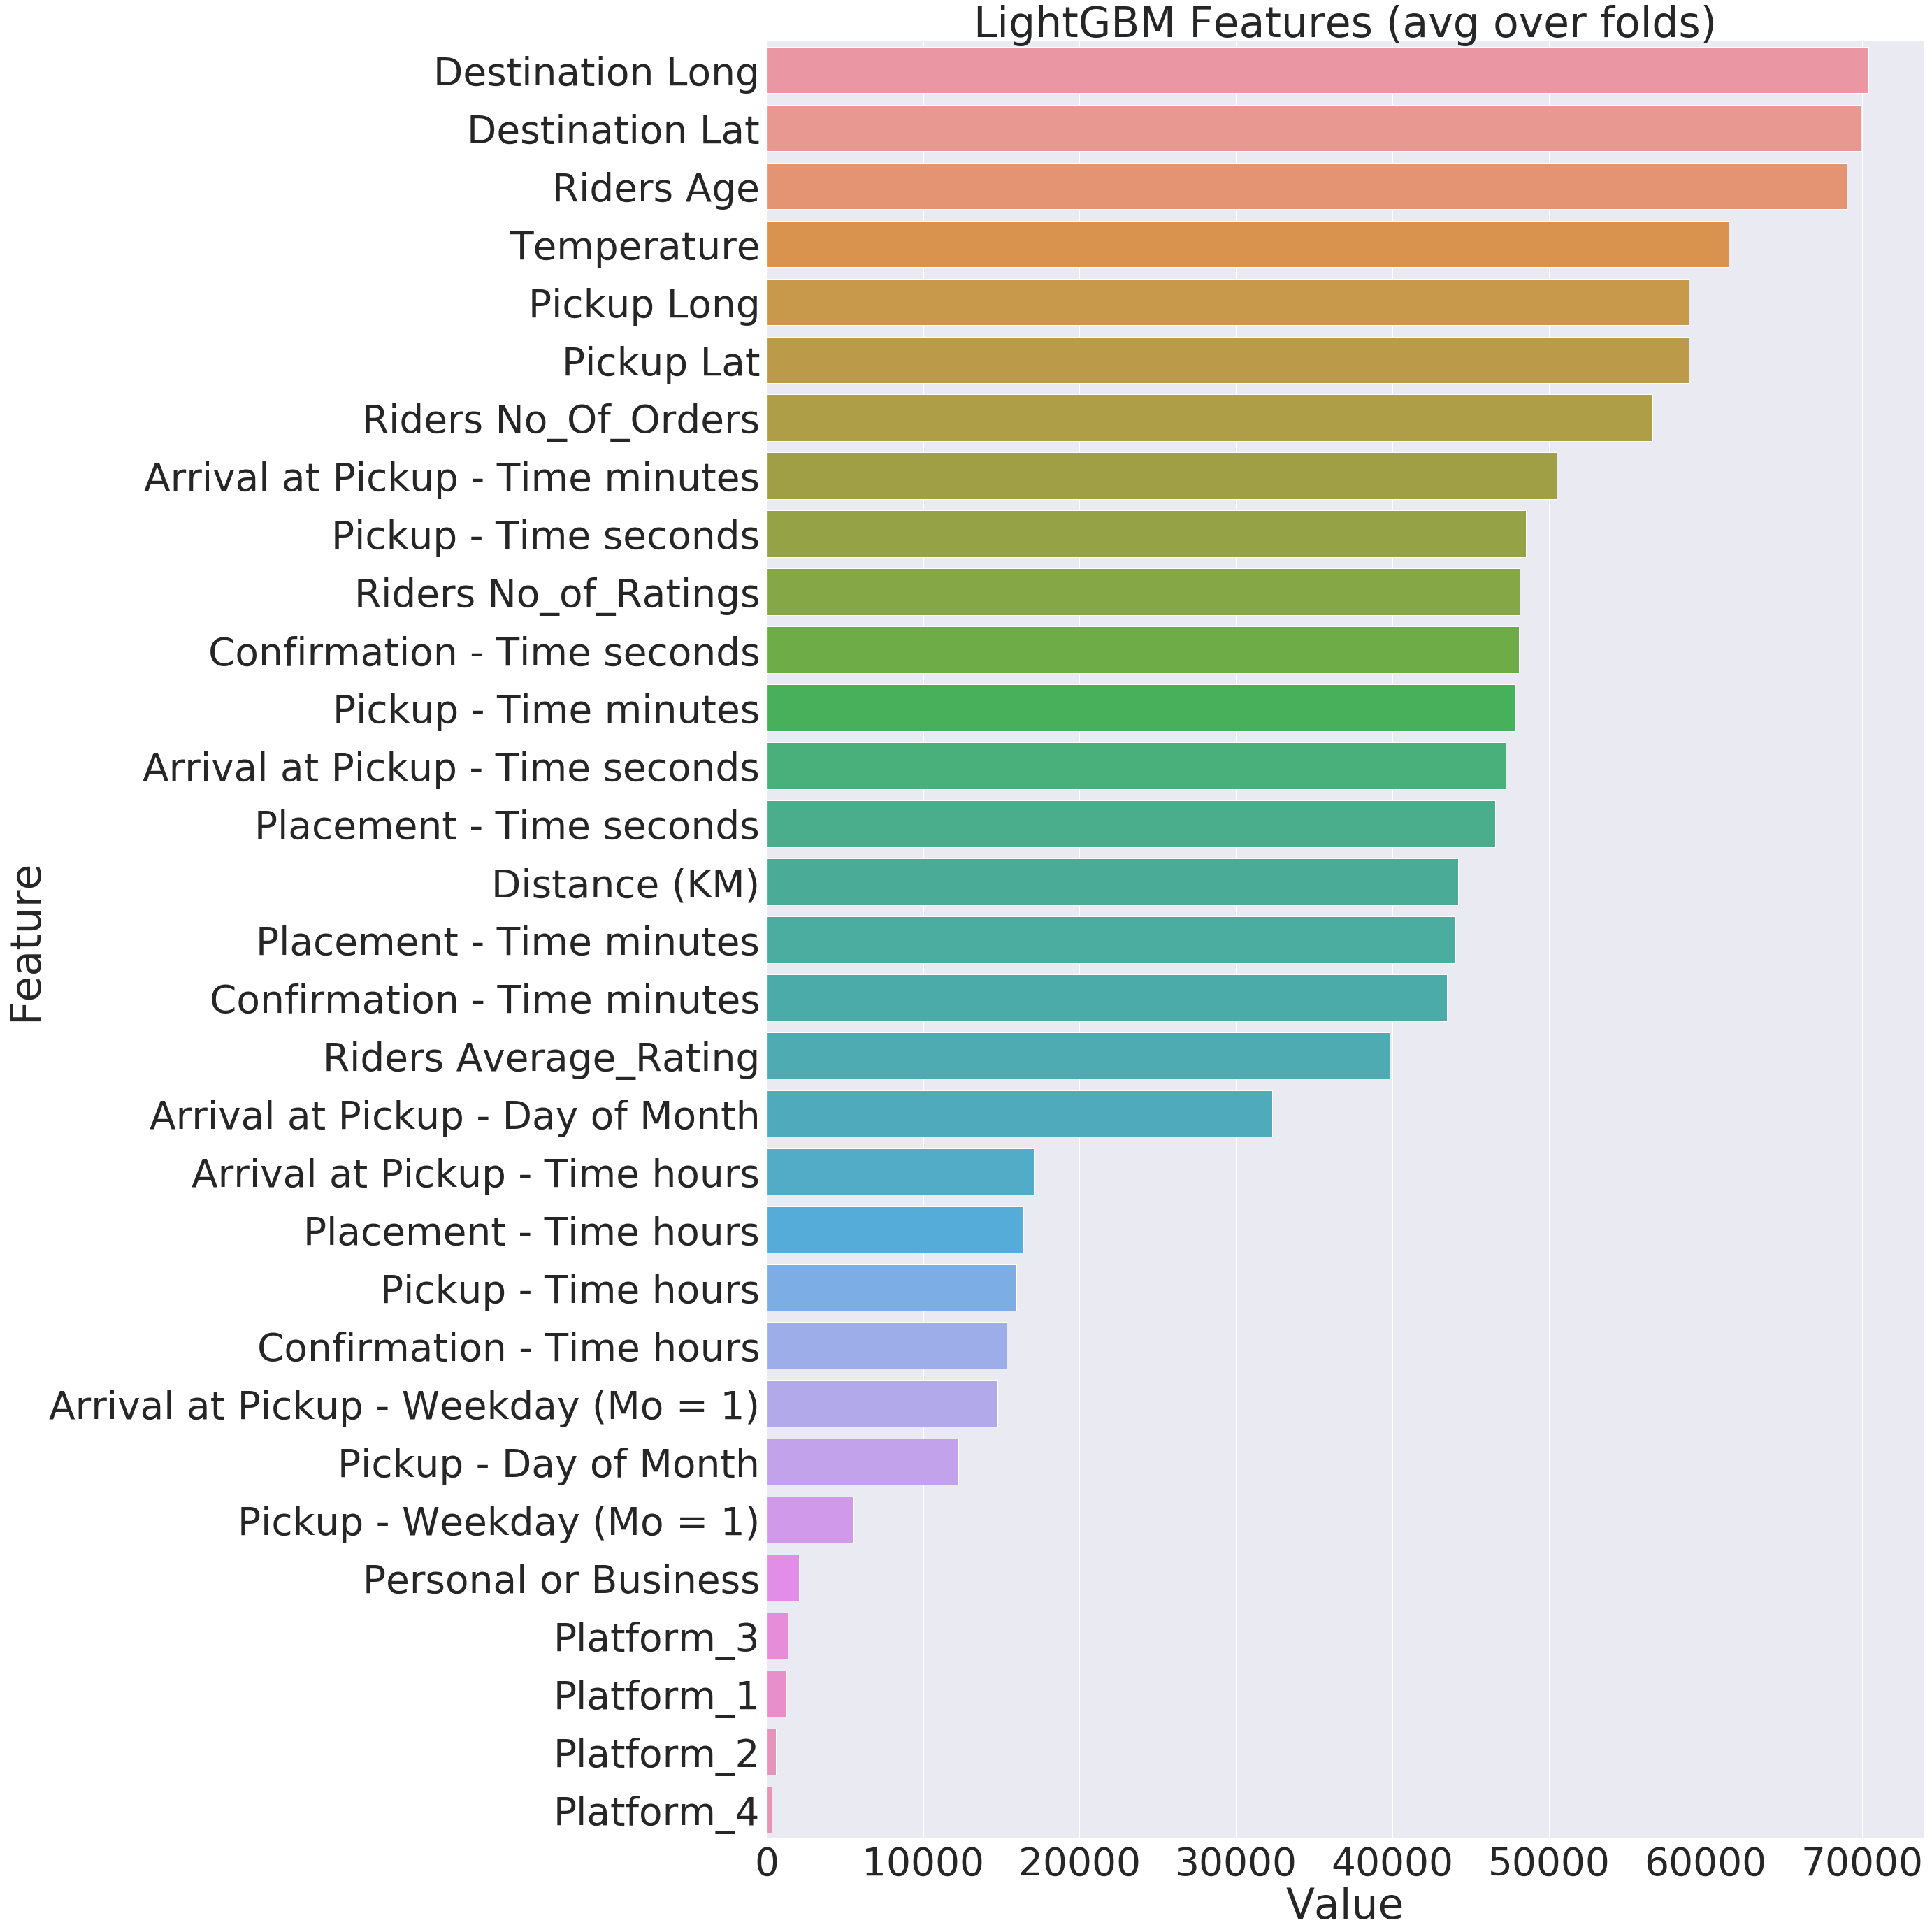

In [177]:
plotImp(model_3, X_train, 50)

In [178]:
xgb = XGBRegressor(max_depth=5, n_estimators=300, min_child_weight=5)
train_model(xgb,  X_train, y_train, X_test, y_test)

RMSE on test data: 762.2218223980955


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

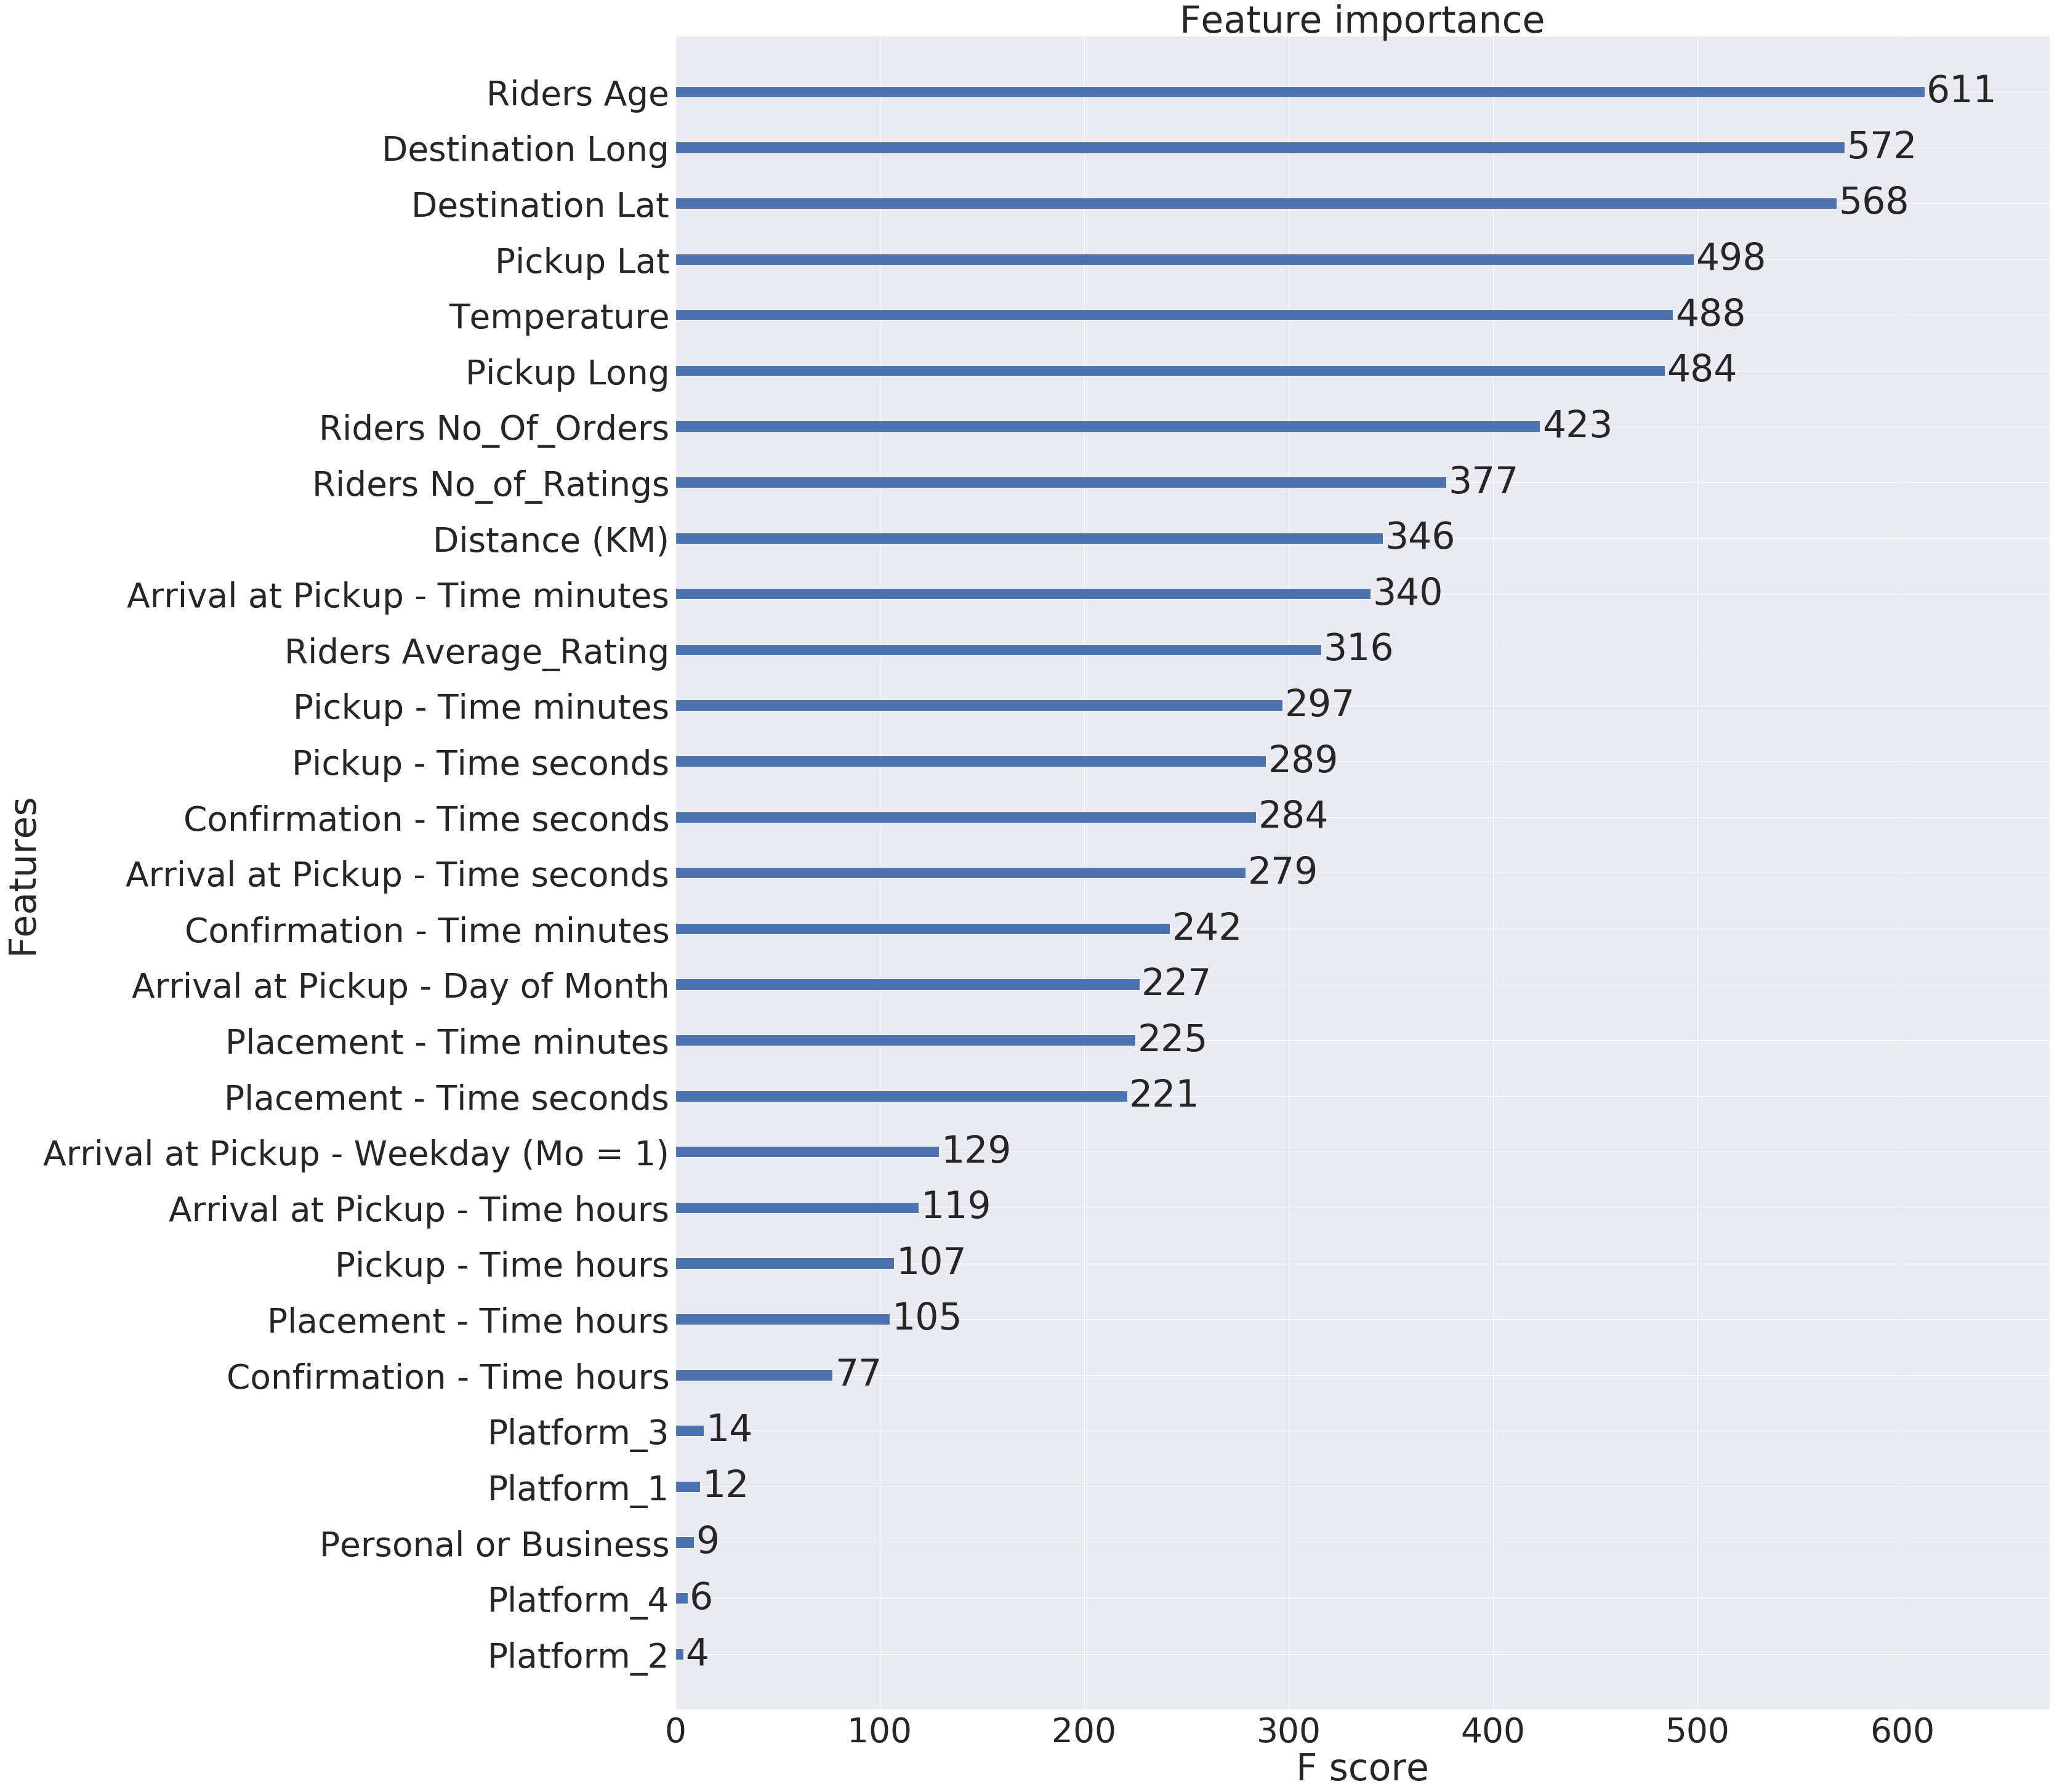

In [179]:
ax = plot_importance(xgb)
fig = ax.figure
fig.set_size_inches(40, 50)

Dropped passive oulier data

In [186]:
dropped_outliers = target_encoding(temp_lat_in_rad_data, cat_variables, y_label, smoothing=True)

train, test = split_train_test_set(dropped_outliers, y_label)
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=[y_label, 'Order No']), train[y_label])
test = test.drop(columns=[y_label])

In [187]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.001,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
    
train_set = lgbm.Dataset(X_train, y_train, silent=False)
valid_set = lgbm.Dataset(X_test, y_test, silent=False)
model_4 = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500, valid_sets=valid_set)

[1]	valid_0's rmse: 1012.39
Training until validation scores don't improve for 500 rounds
[2]	valid_0's rmse: 1012.14
[3]	valid_0's rmse: 1011.79
[4]	valid_0's rmse: 1011.57
[5]	valid_0's rmse: 1011.35
[6]	valid_0's rmse: 1011.12
[7]	valid_0's rmse: 1010.77
[8]	valid_0's rmse: 1010.58
[9]	valid_0's rmse: 1010.24
[10]	valid_0's rmse: 1009.9
[11]	valid_0's rmse: 1009.66
[12]	valid_0's rmse: 1009.32
[13]	valid_0's rmse: 1008.98
[14]	valid_0's rmse: 1008.75
[15]	valid_0's rmse: 1008.4
[16]	valid_0's rmse: 1008.17
[17]	valid_0's rmse: 1007.97
[18]	valid_0's rmse: 1007.62
[19]	valid_0's rmse: 1007.28
[20]	valid_0's rmse: 1007.05
[21]	valid_0's rmse: 1006.81
[22]	valid_0's rmse: 1006.47
[23]	valid_0's rmse: 1006.24
[24]	valid_0's rmse: 1006.14
[25]	valid_0's rmse: 1005.92
[26]	valid_0's rmse: 1005.58
[27]	valid_0's rmse: 1005.25
[28]	valid_0's rmse: 1004.92
[29]	valid_0's rmse: 1004.57
[30]	valid_0's rmse: 1004.34
[31]	valid_0's rmse: 1004.01
[32]	valid_0's rmse: 1003.67
[33]	valid_0's rmse: 

[294]	valid_0's rmse: 941.424
[295]	valid_0's rmse: 941.186
[296]	valid_0's rmse: 940.955
[297]	valid_0's rmse: 940.718
[298]	valid_0's rmse: 940.485
[299]	valid_0's rmse: 940.326
[300]	valid_0's rmse: 940.087
[301]	valid_0's rmse: 939.856
[302]	valid_0's rmse: 939.625
[303]	valid_0's rmse: 939.395
[304]	valid_0's rmse: 939.239
[305]	valid_0's rmse: 939.008
[306]	valid_0's rmse: 938.773
[307]	valid_0's rmse: 938.543
[308]	valid_0's rmse: 938.387
[309]	valid_0's rmse: 938.16
[310]	valid_0's rmse: 937.929
[311]	valid_0's rmse: 937.704
[312]	valid_0's rmse: 937.528
[313]	valid_0's rmse: 937.442
[314]	valid_0's rmse: 937.21
[315]	valid_0's rmse: 936.981
[316]	valid_0's rmse: 936.749
[317]	valid_0's rmse: 936.601
[318]	valid_0's rmse: 936.379
[319]	valid_0's rmse: 936.251
[320]	valid_0's rmse: 936.019
[321]	valid_0's rmse: 935.793
[322]	valid_0's rmse: 935.735
[323]	valid_0's rmse: 935.51
[324]	valid_0's rmse: 935.386
[325]	valid_0's rmse: 935.214
[326]	valid_0's rmse: 934.989
[327]	valid_0

[605]	valid_0's rmse: 891.446
[606]	valid_0's rmse: 891.296
[607]	valid_0's rmse: 891.148
[608]	valid_0's rmse: 890.999
[609]	valid_0's rmse: 890.958
[610]	valid_0's rmse: 890.853
[611]	valid_0's rmse: 890.813
[612]	valid_0's rmse: 890.779
[613]	valid_0's rmse: 890.678
[614]	valid_0's rmse: 890.615
[615]	valid_0's rmse: 890.461
[616]	valid_0's rmse: 890.417
[617]	valid_0's rmse: 890.267
[618]	valid_0's rmse: 890.119
[619]	valid_0's rmse: 889.972
[620]	valid_0's rmse: 889.821
[621]	valid_0's rmse: 889.672
[622]	valid_0's rmse: 889.622
[623]	valid_0's rmse: 889.545
[624]	valid_0's rmse: 889.448
[625]	valid_0's rmse: 889.298
[626]	valid_0's rmse: 889.157
[627]	valid_0's rmse: 889.059
[628]	valid_0's rmse: 888.996
[629]	valid_0's rmse: 888.843
[630]	valid_0's rmse: 888.695
[631]	valid_0's rmse: 888.55
[632]	valid_0's rmse: 888.407
[633]	valid_0's rmse: 888.261
[634]	valid_0's rmse: 888.116
[635]	valid_0's rmse: 888.055
[636]	valid_0's rmse: 887.91
[637]	valid_0's rmse: 887.771
[638]	valid_

[922]	valid_0's rmse: 859.113
[923]	valid_0's rmse: 859.016
[924]	valid_0's rmse: 858.992
[925]	valid_0's rmse: 858.894
[926]	valid_0's rmse: 858.796
[927]	valid_0's rmse: 858.762
[928]	valid_0's rmse: 858.663
[929]	valid_0's rmse: 858.6
[930]	valid_0's rmse: 858.504
[931]	valid_0's rmse: 858.406
[932]	valid_0's rmse: 858.343
[933]	valid_0's rmse: 858.271
[934]	valid_0's rmse: 858.209
[935]	valid_0's rmse: 858.112
[936]	valid_0's rmse: 858.015
[937]	valid_0's rmse: 857.92
[938]	valid_0's rmse: 857.822
[939]	valid_0's rmse: 857.727
[940]	valid_0's rmse: 857.682
[941]	valid_0's rmse: 857.583
[942]	valid_0's rmse: 857.487
[943]	valid_0's rmse: 857.425
[944]	valid_0's rmse: 857.39
[945]	valid_0's rmse: 857.327
[946]	valid_0's rmse: 857.23
[947]	valid_0's rmse: 857.169
[948]	valid_0's rmse: 857.129
[949]	valid_0's rmse: 857.04
[950]	valid_0's rmse: 856.945
[951]	valid_0's rmse: 856.92
[952]	valid_0's rmse: 856.851
[953]	valid_0's rmse: 856.758
[954]	valid_0's rmse: 856.692
[955]	valid_0's r

[1197]	valid_0's rmse: 840.417
[1198]	valid_0's rmse: 840.344
[1199]	valid_0's rmse: 840.277
[1200]	valid_0's rmse: 840.243
[1201]	valid_0's rmse: 840.176
[1202]	valid_0's rmse: 840.111
[1203]	valid_0's rmse: 840.047
[1204]	valid_0's rmse: 839.977
[1205]	valid_0's rmse: 839.957
[1206]	valid_0's rmse: 839.891
[1207]	valid_0's rmse: 839.845
[1208]	valid_0's rmse: 839.795
[1209]	valid_0's rmse: 839.733
[1210]	valid_0's rmse: 839.681
[1211]	valid_0's rmse: 839.614
[1212]	valid_0's rmse: 839.581
[1213]	valid_0's rmse: 839.537
[1214]	valid_0's rmse: 839.473
[1215]	valid_0's rmse: 839.41
[1216]	valid_0's rmse: 839.358
[1217]	valid_0's rmse: 839.293
[1218]	valid_0's rmse: 839.266
[1219]	valid_0's rmse: 839.199
[1220]	valid_0's rmse: 839.137
[1221]	valid_0's rmse: 839.072
[1222]	valid_0's rmse: 839.026
[1223]	valid_0's rmse: 838.961
[1224]	valid_0's rmse: 838.9
[1225]	valid_0's rmse: 838.836
[1226]	valid_0's rmse: 838.806
[1227]	valid_0's rmse: 838.771
[1228]	valid_0's rmse: 838.724
[1229]	vali

[1498]	valid_0's rmse: 826.599
[1499]	valid_0's rmse: 826.575
[1500]	valid_0's rmse: 826.544
[1501]	valid_0's rmse: 826.501
[1502]	valid_0's rmse: 826.459
[1503]	valid_0's rmse: 826.412
[1504]	valid_0's rmse: 826.372
[1505]	valid_0's rmse: 826.33
[1506]	valid_0's rmse: 826.302
[1507]	valid_0's rmse: 826.285
[1508]	valid_0's rmse: 826.238
[1509]	valid_0's rmse: 826.22
[1510]	valid_0's rmse: 826.194
[1511]	valid_0's rmse: 826.152
[1512]	valid_0's rmse: 826.11
[1513]	valid_0's rmse: 826.062
[1514]	valid_0's rmse: 826.031
[1515]	valid_0's rmse: 826.001
[1516]	valid_0's rmse: 825.975
[1517]	valid_0's rmse: 825.944
[1518]	valid_0's rmse: 825.899
[1519]	valid_0's rmse: 825.854
[1520]	valid_0's rmse: 825.822
[1521]	valid_0's rmse: 825.798
[1522]	valid_0's rmse: 825.751
[1523]	valid_0's rmse: 825.71
[1524]	valid_0's rmse: 825.688
[1525]	valid_0's rmse: 825.657
[1526]	valid_0's rmse: 825.63
[1527]	valid_0's rmse: 825.583
[1528]	valid_0's rmse: 825.54
[1529]	valid_0's rmse: 825.513
[1530]	valid_0

[1789]	valid_0's rmse: 817.431
[1790]	valid_0's rmse: 817.403
[1791]	valid_0's rmse: 817.379
[1792]	valid_0's rmse: 817.352
[1793]	valid_0's rmse: 817.317
[1794]	valid_0's rmse: 817.297
[1795]	valid_0's rmse: 817.27
[1796]	valid_0's rmse: 817.238
[1797]	valid_0's rmse: 817.225
[1798]	valid_0's rmse: 817.213
[1799]	valid_0's rmse: 817.183
[1800]	valid_0's rmse: 817.155
[1801]	valid_0's rmse: 817.122
[1802]	valid_0's rmse: 817.097
[1803]	valid_0's rmse: 817.092
[1804]	valid_0's rmse: 817.065
[1805]	valid_0's rmse: 817.036
[1806]	valid_0's rmse: 817.005
[1807]	valid_0's rmse: 816.974
[1808]	valid_0's rmse: 816.946
[1809]	valid_0's rmse: 816.919
[1810]	valid_0's rmse: 816.889
[1811]	valid_0's rmse: 816.857
[1812]	valid_0's rmse: 816.823
[1813]	valid_0's rmse: 816.801
[1814]	valid_0's rmse: 816.77
[1815]	valid_0's rmse: 816.739
[1816]	valid_0's rmse: 816.718
[1817]	valid_0's rmse: 816.693
[1818]	valid_0's rmse: 816.661
[1819]	valid_0's rmse: 816.641
[1820]	valid_0's rmse: 816.613
[1821]	val

[2077]	valid_0's rmse: 810.754
[2078]	valid_0's rmse: 810.726
[2079]	valid_0's rmse: 810.706
[2080]	valid_0's rmse: 810.688
[2081]	valid_0's rmse: 810.659
[2082]	valid_0's rmse: 810.637
[2083]	valid_0's rmse: 810.627
[2084]	valid_0's rmse: 810.614
[2085]	valid_0's rmse: 810.587
[2086]	valid_0's rmse: 810.564
[2087]	valid_0's rmse: 810.559
[2088]	valid_0's rmse: 810.553
[2089]	valid_0's rmse: 810.526
[2090]	valid_0's rmse: 810.506
[2091]	valid_0's rmse: 810.481
[2092]	valid_0's rmse: 810.458
[2093]	valid_0's rmse: 810.436
[2094]	valid_0's rmse: 810.411
[2095]	valid_0's rmse: 810.391
[2096]	valid_0's rmse: 810.376
[2097]	valid_0's rmse: 810.363
[2098]	valid_0's rmse: 810.341
[2099]	valid_0's rmse: 810.317
[2100]	valid_0's rmse: 810.293
[2101]	valid_0's rmse: 810.276
[2102]	valid_0's rmse: 810.263
[2103]	valid_0's rmse: 810.241
[2104]	valid_0's rmse: 810.232
[2105]	valid_0's rmse: 810.21
[2106]	valid_0's rmse: 810.188
[2107]	valid_0's rmse: 810.172
[2108]	valid_0's rmse: 810.148
[2109]	va

[2366]	valid_0's rmse: 805.701
[2367]	valid_0's rmse: 805.694
[2368]	valid_0's rmse: 805.677
[2369]	valid_0's rmse: 805.666
[2370]	valid_0's rmse: 805.648
[2371]	valid_0's rmse: 805.64
[2372]	valid_0's rmse: 805.628
[2373]	valid_0's rmse: 805.607
[2374]	valid_0's rmse: 805.595
[2375]	valid_0's rmse: 805.583
[2376]	valid_0's rmse: 805.569
[2377]	valid_0's rmse: 805.55
[2378]	valid_0's rmse: 805.546
[2379]	valid_0's rmse: 805.53
[2380]	valid_0's rmse: 805.516
[2381]	valid_0's rmse: 805.496
[2382]	valid_0's rmse: 805.485
[2383]	valid_0's rmse: 805.468
[2384]	valid_0's rmse: 805.452
[2385]	valid_0's rmse: 805.439
[2386]	valid_0's rmse: 805.434
[2387]	valid_0's rmse: 805.423
[2388]	valid_0's rmse: 805.406
[2389]	valid_0's rmse: 805.392
[2390]	valid_0's rmse: 805.374
[2391]	valid_0's rmse: 805.356
[2392]	valid_0's rmse: 805.348
[2393]	valid_0's rmse: 805.33
[2394]	valid_0's rmse: 805.316
[2395]	valid_0's rmse: 805.301
[2396]	valid_0's rmse: 805.284
[2397]	valid_0's rmse: 805.27
[2398]	valid_

[2651]	valid_0's rmse: 802.139
[2652]	valid_0's rmse: 802.127
[2653]	valid_0's rmse: 802.119
[2654]	valid_0's rmse: 802.108
[2655]	valid_0's rmse: 802.099
[2656]	valid_0's rmse: 802.089
[2657]	valid_0's rmse: 802.081
[2658]	valid_0's rmse: 802.07
[2659]	valid_0's rmse: 802.066
[2660]	valid_0's rmse: 802.057
[2661]	valid_0's rmse: 802.043
[2662]	valid_0's rmse: 802.03
[2663]	valid_0's rmse: 802.02
[2664]	valid_0's rmse: 802.008
[2665]	valid_0's rmse: 801.998
[2666]	valid_0's rmse: 801.989
[2667]	valid_0's rmse: 801.985
[2668]	valid_0's rmse: 801.973
[2669]	valid_0's rmse: 801.962
[2670]	valid_0's rmse: 801.95
[2671]	valid_0's rmse: 801.937
[2672]	valid_0's rmse: 801.924
[2673]	valid_0's rmse: 801.914
[2674]	valid_0's rmse: 801.903
[2675]	valid_0's rmse: 801.893
[2676]	valid_0's rmse: 801.884
[2677]	valid_0's rmse: 801.877
[2678]	valid_0's rmse: 801.872
[2679]	valid_0's rmse: 801.861
[2680]	valid_0's rmse: 801.85
[2681]	valid_0's rmse: 801.837
[2682]	valid_0's rmse: 801.83
[2683]	valid_0

[2921]	valid_0's rmse: 799.44
[2922]	valid_0's rmse: 799.433
[2923]	valid_0's rmse: 799.433
[2924]	valid_0's rmse: 799.431
[2925]	valid_0's rmse: 799.427
[2926]	valid_0's rmse: 799.419
[2927]	valid_0's rmse: 799.408
[2928]	valid_0's rmse: 799.406
[2929]	valid_0's rmse: 799.392
[2930]	valid_0's rmse: 799.38
[2931]	valid_0's rmse: 799.367
[2932]	valid_0's rmse: 799.357
[2933]	valid_0's rmse: 799.341
[2934]	valid_0's rmse: 799.329
[2935]	valid_0's rmse: 799.314
[2936]	valid_0's rmse: 799.306
[2937]	valid_0's rmse: 799.293
[2938]	valid_0's rmse: 799.282
[2939]	valid_0's rmse: 799.277
[2940]	valid_0's rmse: 799.269
[2941]	valid_0's rmse: 799.261
[2942]	valid_0's rmse: 799.253
[2943]	valid_0's rmse: 799.242
[2944]	valid_0's rmse: 799.231
[2945]	valid_0's rmse: 799.224
[2946]	valid_0's rmse: 799.214
[2947]	valid_0's rmse: 799.204
[2948]	valid_0's rmse: 799.196
[2949]	valid_0's rmse: 799.186
[2950]	valid_0's rmse: 799.179
[2951]	valid_0's rmse: 799.169
[2952]	valid_0's rmse: 799.159
[2953]	val

[3216]	valid_0's rmse: 796.968
[3217]	valid_0's rmse: 796.958
[3218]	valid_0's rmse: 796.954
[3219]	valid_0's rmse: 796.945
[3220]	valid_0's rmse: 796.939
[3221]	valid_0's rmse: 796.93
[3222]	valid_0's rmse: 796.92
[3223]	valid_0's rmse: 796.906
[3224]	valid_0's rmse: 796.901
[3225]	valid_0's rmse: 796.893
[3226]	valid_0's rmse: 796.886
[3227]	valid_0's rmse: 796.877
[3228]	valid_0's rmse: 796.872
[3229]	valid_0's rmse: 796.869
[3230]	valid_0's rmse: 796.858
[3231]	valid_0's rmse: 796.85
[3232]	valid_0's rmse: 796.845
[3233]	valid_0's rmse: 796.836
[3234]	valid_0's rmse: 796.831
[3235]	valid_0's rmse: 796.823
[3236]	valid_0's rmse: 796.815
[3237]	valid_0's rmse: 796.806
[3238]	valid_0's rmse: 796.796
[3239]	valid_0's rmse: 796.789
[3240]	valid_0's rmse: 796.783
[3241]	valid_0's rmse: 796.777
[3242]	valid_0's rmse: 796.77
[3243]	valid_0's rmse: 796.758
[3244]	valid_0's rmse: 796.749
[3245]	valid_0's rmse: 796.747
[3246]	valid_0's rmse: 796.741
[3247]	valid_0's rmse: 796.728
[3248]	valid

[3499]	valid_0's rmse: 794.957
[3500]	valid_0's rmse: 794.946
[3501]	valid_0's rmse: 794.944
[3502]	valid_0's rmse: 794.93
[3503]	valid_0's rmse: 794.927
[3504]	valid_0's rmse: 794.926
[3505]	valid_0's rmse: 794.92
[3506]	valid_0's rmse: 794.913
[3507]	valid_0's rmse: 794.908
[3508]	valid_0's rmse: 794.904
[3509]	valid_0's rmse: 794.899
[3510]	valid_0's rmse: 794.893
[3511]	valid_0's rmse: 794.887
[3512]	valid_0's rmse: 794.88
[3513]	valid_0's rmse: 794.874
[3514]	valid_0's rmse: 794.867
[3515]	valid_0's rmse: 794.859
[3516]	valid_0's rmse: 794.848
[3517]	valid_0's rmse: 794.845
[3518]	valid_0's rmse: 794.843
[3519]	valid_0's rmse: 794.838
[3520]	valid_0's rmse: 794.832
[3521]	valid_0's rmse: 794.825
[3522]	valid_0's rmse: 794.819
[3523]	valid_0's rmse: 794.808
[3524]	valid_0's rmse: 794.807
[3525]	valid_0's rmse: 794.801
[3526]	valid_0's rmse: 794.789
[3527]	valid_0's rmse: 794.781
[3528]	valid_0's rmse: 794.771
[3529]	valid_0's rmse: 794.769
[3530]	valid_0's rmse: 794.764
[3531]	vali

[3802]	valid_0's rmse: 793.162
[3803]	valid_0's rmse: 793.147
[3804]	valid_0's rmse: 793.141
[3805]	valid_0's rmse: 793.141
[3806]	valid_0's rmse: 793.134
[3807]	valid_0's rmse: 793.132
[3808]	valid_0's rmse: 793.123
[3809]	valid_0's rmse: 793.118
[3810]	valid_0's rmse: 793.113
[3811]	valid_0's rmse: 793.109
[3812]	valid_0's rmse: 793.101
[3813]	valid_0's rmse: 793.093
[3814]	valid_0's rmse: 793.085
[3815]	valid_0's rmse: 793.078
[3816]	valid_0's rmse: 793.071
[3817]	valid_0's rmse: 793.067
[3818]	valid_0's rmse: 793.06
[3819]	valid_0's rmse: 793.055
[3820]	valid_0's rmse: 793.048
[3821]	valid_0's rmse: 793.044
[3822]	valid_0's rmse: 793.035
[3823]	valid_0's rmse: 793.031
[3824]	valid_0's rmse: 793.027
[3825]	valid_0's rmse: 793.019
[3826]	valid_0's rmse: 793.015
[3827]	valid_0's rmse: 793.008
[3828]	valid_0's rmse: 793.002
[3829]	valid_0's rmse: 792.988
[3830]	valid_0's rmse: 792.981
[3831]	valid_0's rmse: 792.975
[3832]	valid_0's rmse: 792.972
[3833]	valid_0's rmse: 792.966
[3834]	va

[4103]	valid_0's rmse: 791.656
[4104]	valid_0's rmse: 791.648
[4105]	valid_0's rmse: 791.647
[4106]	valid_0's rmse: 791.641
[4107]	valid_0's rmse: 791.637
[4108]	valid_0's rmse: 791.632
[4109]	valid_0's rmse: 791.627
[4110]	valid_0's rmse: 791.622
[4111]	valid_0's rmse: 791.611
[4112]	valid_0's rmse: 791.605
[4113]	valid_0's rmse: 791.606
[4114]	valid_0's rmse: 791.598
[4115]	valid_0's rmse: 791.596
[4116]	valid_0's rmse: 791.591
[4117]	valid_0's rmse: 791.587
[4118]	valid_0's rmse: 791.58
[4119]	valid_0's rmse: 791.576
[4120]	valid_0's rmse: 791.569
[4121]	valid_0's rmse: 791.565
[4122]	valid_0's rmse: 791.56
[4123]	valid_0's rmse: 791.557
[4124]	valid_0's rmse: 791.554
[4125]	valid_0's rmse: 791.55
[4126]	valid_0's rmse: 791.546
[4127]	valid_0's rmse: 791.546
[4128]	valid_0's rmse: 791.544
[4129]	valid_0's rmse: 791.53
[4130]	valid_0's rmse: 791.524
[4131]	valid_0's rmse: 791.521
[4132]	valid_0's rmse: 791.521
[4133]	valid_0's rmse: 791.517
[4134]	valid_0's rmse: 791.513
[4135]	valid

[4380]	valid_0's rmse: 790.469
[4381]	valid_0's rmse: 790.466
[4382]	valid_0's rmse: 790.464
[4383]	valid_0's rmse: 790.461
[4384]	valid_0's rmse: 790.459
[4385]	valid_0's rmse: 790.455
[4386]	valid_0's rmse: 790.451
[4387]	valid_0's rmse: 790.449
[4388]	valid_0's rmse: 790.444
[4389]	valid_0's rmse: 790.439
[4390]	valid_0's rmse: 790.437
[4391]	valid_0's rmse: 790.431
[4392]	valid_0's rmse: 790.428
[4393]	valid_0's rmse: 790.425
[4394]	valid_0's rmse: 790.42
[4395]	valid_0's rmse: 790.415
[4396]	valid_0's rmse: 790.412
[4397]	valid_0's rmse: 790.404
[4398]	valid_0's rmse: 790.399
[4399]	valid_0's rmse: 790.396
[4400]	valid_0's rmse: 790.389
[4401]	valid_0's rmse: 790.384
[4402]	valid_0's rmse: 790.383
[4403]	valid_0's rmse: 790.378
[4404]	valid_0's rmse: 790.376
[4405]	valid_0's rmse: 790.371
[4406]	valid_0's rmse: 790.371
[4407]	valid_0's rmse: 790.367
[4408]	valid_0's rmse: 790.363
[4409]	valid_0's rmse: 790.362
[4410]	valid_0's rmse: 790.358
[4411]	valid_0's rmse: 790.355
[4412]	va

[4665]	valid_0's rmse: 789.369
[4666]	valid_0's rmse: 789.362
[4667]	valid_0's rmse: 789.36
[4668]	valid_0's rmse: 789.355
[4669]	valid_0's rmse: 789.352
[4670]	valid_0's rmse: 789.348
[4671]	valid_0's rmse: 789.344
[4672]	valid_0's rmse: 789.338
[4673]	valid_0's rmse: 789.333
[4674]	valid_0's rmse: 789.333
[4675]	valid_0's rmse: 789.328
[4676]	valid_0's rmse: 789.326
[4677]	valid_0's rmse: 789.324
[4678]	valid_0's rmse: 789.321
[4679]	valid_0's rmse: 789.319
[4680]	valid_0's rmse: 789.315
[4681]	valid_0's rmse: 789.313
[4682]	valid_0's rmse: 789.31
[4683]	valid_0's rmse: 789.307
[4684]	valid_0's rmse: 789.299
[4685]	valid_0's rmse: 789.297
[4686]	valid_0's rmse: 789.295
[4687]	valid_0's rmse: 789.294
[4688]	valid_0's rmse: 789.291
[4689]	valid_0's rmse: 789.289
[4690]	valid_0's rmse: 789.282
[4691]	valid_0's rmse: 789.279
[4692]	valid_0's rmse: 789.273
[4693]	valid_0's rmse: 789.271
[4694]	valid_0's rmse: 789.268
[4695]	valid_0's rmse: 789.265
[4696]	valid_0's rmse: 789.259
[4697]	val

[4955]	valid_0's rmse: 788.388
[4956]	valid_0's rmse: 788.387
[4957]	valid_0's rmse: 788.38
[4958]	valid_0's rmse: 788.379
[4959]	valid_0's rmse: 788.374
[4960]	valid_0's rmse: 788.37
[4961]	valid_0's rmse: 788.366
[4962]	valid_0's rmse: 788.361
[4963]	valid_0's rmse: 788.357
[4964]	valid_0's rmse: 788.353
[4965]	valid_0's rmse: 788.345
[4966]	valid_0's rmse: 788.34
[4967]	valid_0's rmse: 788.338
[4968]	valid_0's rmse: 788.332
[4969]	valid_0's rmse: 788.326
[4970]	valid_0's rmse: 788.32
[4971]	valid_0's rmse: 788.316
[4972]	valid_0's rmse: 788.316
[4973]	valid_0's rmse: 788.31
[4974]	valid_0's rmse: 788.304
[4975]	valid_0's rmse: 788.297
[4976]	valid_0's rmse: 788.295
[4977]	valid_0's rmse: 788.293
[4978]	valid_0's rmse: 788.289
[4979]	valid_0's rmse: 788.289
[4980]	valid_0's rmse: 788.287
[4981]	valid_0's rmse: 788.284
[4982]	valid_0's rmse: 788.279
[4983]	valid_0's rmse: 788.276
[4984]	valid_0's rmse: 788.271
[4985]	valid_0's rmse: 788.266
[4986]	valid_0's rmse: 788.26
[4987]	valid_0

[5229]	valid_0's rmse: 787.488
[5230]	valid_0's rmse: 787.484
[5231]	valid_0's rmse: 787.483
[5232]	valid_0's rmse: 787.478
[5233]	valid_0's rmse: 787.476
[5234]	valid_0's rmse: 787.471
[5235]	valid_0's rmse: 787.469
[5236]	valid_0's rmse: 787.465
[5237]	valid_0's rmse: 787.462
[5238]	valid_0's rmse: 787.459
[5239]	valid_0's rmse: 787.457
[5240]	valid_0's rmse: 787.451
[5241]	valid_0's rmse: 787.448
[5242]	valid_0's rmse: 787.446
[5243]	valid_0's rmse: 787.445
[5244]	valid_0's rmse: 787.44
[5245]	valid_0's rmse: 787.434
[5246]	valid_0's rmse: 787.433
[5247]	valid_0's rmse: 787.433
[5248]	valid_0's rmse: 787.432
[5249]	valid_0's rmse: 787.43
[5250]	valid_0's rmse: 787.424
[5251]	valid_0's rmse: 787.418
[5252]	valid_0's rmse: 787.416
[5253]	valid_0's rmse: 787.413
[5254]	valid_0's rmse: 787.409
[5255]	valid_0's rmse: 787.404
[5256]	valid_0's rmse: 787.401
[5257]	valid_0's rmse: 787.4
[5258]	valid_0's rmse: 787.399
[5259]	valid_0's rmse: 787.397
[5260]	valid_0's rmse: 787.393
[5261]	valid

[5505]	valid_0's rmse: 786.672
[5506]	valid_0's rmse: 786.668
[5507]	valid_0's rmse: 786.666
[5508]	valid_0's rmse: 786.664
[5509]	valid_0's rmse: 786.665
[5510]	valid_0's rmse: 786.664
[5511]	valid_0's rmse: 786.659
[5512]	valid_0's rmse: 786.659
[5513]	valid_0's rmse: 786.659
[5514]	valid_0's rmse: 786.652
[5515]	valid_0's rmse: 786.65
[5516]	valid_0's rmse: 786.646
[5517]	valid_0's rmse: 786.645
[5518]	valid_0's rmse: 786.64
[5519]	valid_0's rmse: 786.631
[5520]	valid_0's rmse: 786.627
[5521]	valid_0's rmse: 786.623
[5522]	valid_0's rmse: 786.619
[5523]	valid_0's rmse: 786.615
[5524]	valid_0's rmse: 786.613
[5525]	valid_0's rmse: 786.608
[5526]	valid_0's rmse: 786.608
[5527]	valid_0's rmse: 786.602
[5528]	valid_0's rmse: 786.595
[5529]	valid_0's rmse: 786.593
[5530]	valid_0's rmse: 786.591
[5531]	valid_0's rmse: 786.589
[5532]	valid_0's rmse: 786.589
[5533]	valid_0's rmse: 786.584
[5534]	valid_0's rmse: 786.583
[5535]	valid_0's rmse: 786.58
[5536]	valid_0's rmse: 786.577
[5537]	vali

[5792]	valid_0's rmse: 785.905
[5793]	valid_0's rmse: 785.901
[5794]	valid_0's rmse: 785.899
[5795]	valid_0's rmse: 785.892
[5796]	valid_0's rmse: 785.892
[5797]	valid_0's rmse: 785.89
[5798]	valid_0's rmse: 785.889
[5799]	valid_0's rmse: 785.886
[5800]	valid_0's rmse: 785.885
[5801]	valid_0's rmse: 785.883
[5802]	valid_0's rmse: 785.88
[5803]	valid_0's rmse: 785.877
[5804]	valid_0's rmse: 785.875
[5805]	valid_0's rmse: 785.873
[5806]	valid_0's rmse: 785.871
[5807]	valid_0's rmse: 785.869
[5808]	valid_0's rmse: 785.867
[5809]	valid_0's rmse: 785.866
[5810]	valid_0's rmse: 785.867
[5811]	valid_0's rmse: 785.865
[5812]	valid_0's rmse: 785.862
[5813]	valid_0's rmse: 785.862
[5814]	valid_0's rmse: 785.854
[5815]	valid_0's rmse: 785.854
[5816]	valid_0's rmse: 785.848
[5817]	valid_0's rmse: 785.845
[5818]	valid_0's rmse: 785.842
[5819]	valid_0's rmse: 785.836
[5820]	valid_0's rmse: 785.834
[5821]	valid_0's rmse: 785.833
[5822]	valid_0's rmse: 785.833
[5823]	valid_0's rmse: 785.831
[5824]	val

[6081]	valid_0's rmse: 785.107
[6082]	valid_0's rmse: 785.106
[6083]	valid_0's rmse: 785.106
[6084]	valid_0's rmse: 785.095
[6085]	valid_0's rmse: 785.093
[6086]	valid_0's rmse: 785.093
[6087]	valid_0's rmse: 785.092
[6088]	valid_0's rmse: 785.086
[6089]	valid_0's rmse: 785.083
[6090]	valid_0's rmse: 785.085
[6091]	valid_0's rmse: 785.073
[6092]	valid_0's rmse: 785.069
[6093]	valid_0's rmse: 785.062
[6094]	valid_0's rmse: 785.061
[6095]	valid_0's rmse: 785.058
[6096]	valid_0's rmse: 785.055
[6097]	valid_0's rmse: 785.054
[6098]	valid_0's rmse: 785.048
[6099]	valid_0's rmse: 785.048
[6100]	valid_0's rmse: 785.044
[6101]	valid_0's rmse: 785.039
[6102]	valid_0's rmse: 785.039
[6103]	valid_0's rmse: 785.035
[6104]	valid_0's rmse: 785.032
[6105]	valid_0's rmse: 785.025
[6106]	valid_0's rmse: 785.024
[6107]	valid_0's rmse: 785.023
[6108]	valid_0's rmse: 785.016
[6109]	valid_0's rmse: 785.015
[6110]	valid_0's rmse: 785.014
[6111]	valid_0's rmse: 785.012
[6112]	valid_0's rmse: 785.006
[6113]	v

[6382]	valid_0's rmse: 784.247
[6383]	valid_0's rmse: 784.247
[6384]	valid_0's rmse: 784.245
[6385]	valid_0's rmse: 784.243
[6386]	valid_0's rmse: 784.241
[6387]	valid_0's rmse: 784.238
[6388]	valid_0's rmse: 784.236
[6389]	valid_0's rmse: 784.229
[6390]	valid_0's rmse: 784.227
[6391]	valid_0's rmse: 784.226
[6392]	valid_0's rmse: 784.225
[6393]	valid_0's rmse: 784.223
[6394]	valid_0's rmse: 784.221
[6395]	valid_0's rmse: 784.214
[6396]	valid_0's rmse: 784.211
[6397]	valid_0's rmse: 784.21
[6398]	valid_0's rmse: 784.209
[6399]	valid_0's rmse: 784.207
[6400]	valid_0's rmse: 784.205
[6401]	valid_0's rmse: 784.203
[6402]	valid_0's rmse: 784.2
[6403]	valid_0's rmse: 784.199
[6404]	valid_0's rmse: 784.196
[6405]	valid_0's rmse: 784.193
[6406]	valid_0's rmse: 784.19
[6407]	valid_0's rmse: 784.19
[6408]	valid_0's rmse: 784.186
[6409]	valid_0's rmse: 784.185
[6410]	valid_0's rmse: 784.183
[6411]	valid_0's rmse: 784.18
[6412]	valid_0's rmse: 784.177
[6413]	valid_0's rmse: 784.174
[6414]	valid_0

[6690]	valid_0's rmse: 783.453
[6691]	valid_0's rmse: 783.442
[6692]	valid_0's rmse: 783.442
[6693]	valid_0's rmse: 783.44
[6694]	valid_0's rmse: 783.438
[6695]	valid_0's rmse: 783.436
[6696]	valid_0's rmse: 783.433
[6697]	valid_0's rmse: 783.432
[6698]	valid_0's rmse: 783.433
[6699]	valid_0's rmse: 783.432
[6700]	valid_0's rmse: 783.43
[6701]	valid_0's rmse: 783.43
[6702]	valid_0's rmse: 783.428
[6703]	valid_0's rmse: 783.425
[6704]	valid_0's rmse: 783.427
[6705]	valid_0's rmse: 783.426
[6706]	valid_0's rmse: 783.422
[6707]	valid_0's rmse: 783.418
[6708]	valid_0's rmse: 783.418
[6709]	valid_0's rmse: 783.412
[6710]	valid_0's rmse: 783.409
[6711]	valid_0's rmse: 783.408
[6712]	valid_0's rmse: 783.404
[6713]	valid_0's rmse: 783.4
[6714]	valid_0's rmse: 783.397
[6715]	valid_0's rmse: 783.395
[6716]	valid_0's rmse: 783.388
[6717]	valid_0's rmse: 783.387
[6718]	valid_0's rmse: 783.388
[6719]	valid_0's rmse: 783.387
[6720]	valid_0's rmse: 783.384
[6721]	valid_0's rmse: 783.381
[6722]	valid_

[6992]	valid_0's rmse: 782.866
[6993]	valid_0's rmse: 782.862
[6994]	valid_0's rmse: 782.859
[6995]	valid_0's rmse: 782.852
[6996]	valid_0's rmse: 782.852
[6997]	valid_0's rmse: 782.848
[6998]	valid_0's rmse: 782.845
[6999]	valid_0's rmse: 782.845
[7000]	valid_0's rmse: 782.844
[7001]	valid_0's rmse: 782.844
[7002]	valid_0's rmse: 782.841
[7003]	valid_0's rmse: 782.841
[7004]	valid_0's rmse: 782.839
[7005]	valid_0's rmse: 782.839
[7006]	valid_0's rmse: 782.835
[7007]	valid_0's rmse: 782.83
[7008]	valid_0's rmse: 782.828
[7009]	valid_0's rmse: 782.826
[7010]	valid_0's rmse: 782.826
[7011]	valid_0's rmse: 782.824
[7012]	valid_0's rmse: 782.821
[7013]	valid_0's rmse: 782.817
[7014]	valid_0's rmse: 782.816
[7015]	valid_0's rmse: 782.812
[7016]	valid_0's rmse: 782.81
[7017]	valid_0's rmse: 782.809
[7018]	valid_0's rmse: 782.809
[7019]	valid_0's rmse: 782.803
[7020]	valid_0's rmse: 782.799
[7021]	valid_0's rmse: 782.798
[7022]	valid_0's rmse: 782.797
[7023]	valid_0's rmse: 782.792
[7024]	val

[7294]	valid_0's rmse: 782.274
[7295]	valid_0's rmse: 782.272
[7296]	valid_0's rmse: 782.269
[7297]	valid_0's rmse: 782.268
[7298]	valid_0's rmse: 782.263
[7299]	valid_0's rmse: 782.263
[7300]	valid_0's rmse: 782.257
[7301]	valid_0's rmse: 782.255
[7302]	valid_0's rmse: 782.254
[7303]	valid_0's rmse: 782.255
[7304]	valid_0's rmse: 782.254
[7305]	valid_0's rmse: 782.253
[7306]	valid_0's rmse: 782.251
[7307]	valid_0's rmse: 782.248
[7308]	valid_0's rmse: 782.246
[7309]	valid_0's rmse: 782.246
[7310]	valid_0's rmse: 782.246
[7311]	valid_0's rmse: 782.244
[7312]	valid_0's rmse: 782.238
[7313]	valid_0's rmse: 782.237
[7314]	valid_0's rmse: 782.237
[7315]	valid_0's rmse: 782.236
[7316]	valid_0's rmse: 782.236
[7317]	valid_0's rmse: 782.237
[7318]	valid_0's rmse: 782.235
[7319]	valid_0's rmse: 782.235
[7320]	valid_0's rmse: 782.235
[7321]	valid_0's rmse: 782.234
[7322]	valid_0's rmse: 782.228
[7323]	valid_0's rmse: 782.226
[7324]	valid_0's rmse: 782.225
[7325]	valid_0's rmse: 782.222
[7326]	v

[7595]	valid_0's rmse: 781.842
[7596]	valid_0's rmse: 781.841
[7597]	valid_0's rmse: 781.837
[7598]	valid_0's rmse: 781.836
[7599]	valid_0's rmse: 781.835
[7600]	valid_0's rmse: 781.832
[7601]	valid_0's rmse: 781.831
[7602]	valid_0's rmse: 781.834
[7603]	valid_0's rmse: 781.835
[7604]	valid_0's rmse: 781.829
[7605]	valid_0's rmse: 781.831
[7606]	valid_0's rmse: 781.829
[7607]	valid_0's rmse: 781.826
[7608]	valid_0's rmse: 781.825
[7609]	valid_0's rmse: 781.818
[7610]	valid_0's rmse: 781.815
[7611]	valid_0's rmse: 781.816
[7612]	valid_0's rmse: 781.813
[7613]	valid_0's rmse: 781.813
[7614]	valid_0's rmse: 781.81
[7615]	valid_0's rmse: 781.808
[7616]	valid_0's rmse: 781.808
[7617]	valid_0's rmse: 781.806
[7618]	valid_0's rmse: 781.803
[7619]	valid_0's rmse: 781.803
[7620]	valid_0's rmse: 781.802
[7621]	valid_0's rmse: 781.801
[7622]	valid_0's rmse: 781.798
[7623]	valid_0's rmse: 781.8
[7624]	valid_0's rmse: 781.798
[7625]	valid_0's rmse: 781.796
[7626]	valid_0's rmse: 781.795
[7627]	vali

[7873]	valid_0's rmse: 781.407
[7874]	valid_0's rmse: 781.403
[7875]	valid_0's rmse: 781.403
[7876]	valid_0's rmse: 781.4
[7877]	valid_0's rmse: 781.399
[7878]	valid_0's rmse: 781.396
[7879]	valid_0's rmse: 781.393
[7880]	valid_0's rmse: 781.39
[7881]	valid_0's rmse: 781.389
[7882]	valid_0's rmse: 781.384
[7883]	valid_0's rmse: 781.384
[7884]	valid_0's rmse: 781.385
[7885]	valid_0's rmse: 781.383
[7886]	valid_0's rmse: 781.383
[7887]	valid_0's rmse: 781.383
[7888]	valid_0's rmse: 781.382
[7889]	valid_0's rmse: 781.381
[7890]	valid_0's rmse: 781.378
[7891]	valid_0's rmse: 781.372
[7892]	valid_0's rmse: 781.372
[7893]	valid_0's rmse: 781.372
[7894]	valid_0's rmse: 781.371
[7895]	valid_0's rmse: 781.369
[7896]	valid_0's rmse: 781.37
[7897]	valid_0's rmse: 781.37
[7898]	valid_0's rmse: 781.371
[7899]	valid_0's rmse: 781.371
[7900]	valid_0's rmse: 781.369
[7901]	valid_0's rmse: 781.365
[7902]	valid_0's rmse: 781.364
[7903]	valid_0's rmse: 781.366
[7904]	valid_0's rmse: 781.361
[7905]	valid_

[8150]	valid_0's rmse: 780.973
[8151]	valid_0's rmse: 780.97
[8152]	valid_0's rmse: 780.97
[8153]	valid_0's rmse: 780.969
[8154]	valid_0's rmse: 780.968
[8155]	valid_0's rmse: 780.968
[8156]	valid_0's rmse: 780.967
[8157]	valid_0's rmse: 780.967
[8158]	valid_0's rmse: 780.967
[8159]	valid_0's rmse: 780.965
[8160]	valid_0's rmse: 780.963
[8161]	valid_0's rmse: 780.96
[8162]	valid_0's rmse: 780.957
[8163]	valid_0's rmse: 780.959
[8164]	valid_0's rmse: 780.959
[8165]	valid_0's rmse: 780.955
[8166]	valid_0's rmse: 780.954
[8167]	valid_0's rmse: 780.955
[8168]	valid_0's rmse: 780.954
[8169]	valid_0's rmse: 780.953
[8170]	valid_0's rmse: 780.952
[8171]	valid_0's rmse: 780.953
[8172]	valid_0's rmse: 780.953
[8173]	valid_0's rmse: 780.952
[8174]	valid_0's rmse: 780.952
[8175]	valid_0's rmse: 780.952
[8176]	valid_0's rmse: 780.95
[8177]	valid_0's rmse: 780.949
[8178]	valid_0's rmse: 780.95
[8179]	valid_0's rmse: 780.953
[8180]	valid_0's rmse: 780.948
[8181]	valid_0's rmse: 780.948
[8182]	valid_

[8423]	valid_0's rmse: 780.642
[8424]	valid_0's rmse: 780.641
[8425]	valid_0's rmse: 780.639
[8426]	valid_0's rmse: 780.637
[8427]	valid_0's rmse: 780.637
[8428]	valid_0's rmse: 780.633
[8429]	valid_0's rmse: 780.632
[8430]	valid_0's rmse: 780.631
[8431]	valid_0's rmse: 780.63
[8432]	valid_0's rmse: 780.631
[8433]	valid_0's rmse: 780.632
[8434]	valid_0's rmse: 780.629
[8435]	valid_0's rmse: 780.628
[8436]	valid_0's rmse: 780.628
[8437]	valid_0's rmse: 780.626
[8438]	valid_0's rmse: 780.625
[8439]	valid_0's rmse: 780.624
[8440]	valid_0's rmse: 780.623
[8441]	valid_0's rmse: 780.618
[8442]	valid_0's rmse: 780.618
[8443]	valid_0's rmse: 780.614
[8444]	valid_0's rmse: 780.613
[8445]	valid_0's rmse: 780.611
[8446]	valid_0's rmse: 780.611
[8447]	valid_0's rmse: 780.611
[8448]	valid_0's rmse: 780.606
[8449]	valid_0's rmse: 780.6
[8450]	valid_0's rmse: 780.598
[8451]	valid_0's rmse: 780.599
[8452]	valid_0's rmse: 780.597
[8453]	valid_0's rmse: 780.595
[8454]	valid_0's rmse: 780.592
[8455]	vali

[8689]	valid_0's rmse: 780.304
[8690]	valid_0's rmse: 780.304
[8691]	valid_0's rmse: 780.303
[8692]	valid_0's rmse: 780.302
[8693]	valid_0's rmse: 780.3
[8694]	valid_0's rmse: 780.297
[8695]	valid_0's rmse: 780.295
[8696]	valid_0's rmse: 780.293
[8697]	valid_0's rmse: 780.294
[8698]	valid_0's rmse: 780.296
[8699]	valid_0's rmse: 780.294
[8700]	valid_0's rmse: 780.293
[8701]	valid_0's rmse: 780.292
[8702]	valid_0's rmse: 780.29
[8703]	valid_0's rmse: 780.288
[8704]	valid_0's rmse: 780.286
[8705]	valid_0's rmse: 780.282
[8706]	valid_0's rmse: 780.282
[8707]	valid_0's rmse: 780.282
[8708]	valid_0's rmse: 780.282
[8709]	valid_0's rmse: 780.28
[8710]	valid_0's rmse: 780.279
[8711]	valid_0's rmse: 780.279
[8712]	valid_0's rmse: 780.278
[8713]	valid_0's rmse: 780.277
[8714]	valid_0's rmse: 780.275
[8715]	valid_0's rmse: 780.274
[8716]	valid_0's rmse: 780.273
[8717]	valid_0's rmse: 780.272
[8718]	valid_0's rmse: 780.271
[8719]	valid_0's rmse: 780.271
[8720]	valid_0's rmse: 780.274
[8721]	valid

[8968]	valid_0's rmse: 779.956
[8969]	valid_0's rmse: 779.955
[8970]	valid_0's rmse: 779.953
[8971]	valid_0's rmse: 779.951
[8972]	valid_0's rmse: 779.951
[8973]	valid_0's rmse: 779.95
[8974]	valid_0's rmse: 779.951
[8975]	valid_0's rmse: 779.95
[8976]	valid_0's rmse: 779.948
[8977]	valid_0's rmse: 779.948
[8978]	valid_0's rmse: 779.948
[8979]	valid_0's rmse: 779.947
[8980]	valid_0's rmse: 779.947
[8981]	valid_0's rmse: 779.947
[8982]	valid_0's rmse: 779.948
[8983]	valid_0's rmse: 779.946
[8984]	valid_0's rmse: 779.946
[8985]	valid_0's rmse: 779.945
[8986]	valid_0's rmse: 779.944
[8987]	valid_0's rmse: 779.944
[8988]	valid_0's rmse: 779.942
[8989]	valid_0's rmse: 779.942
[8990]	valid_0's rmse: 779.943
[8991]	valid_0's rmse: 779.941
[8992]	valid_0's rmse: 779.936
[8993]	valid_0's rmse: 779.935
[8994]	valid_0's rmse: 779.929
[8995]	valid_0's rmse: 779.928
[8996]	valid_0's rmse: 779.927
[8997]	valid_0's rmse: 779.927
[8998]	valid_0's rmse: 779.926
[8999]	valid_0's rmse: 779.926
[9000]	val

[9255]	valid_0's rmse: 779.611
[9256]	valid_0's rmse: 779.611
[9257]	valid_0's rmse: 779.611
[9258]	valid_0's rmse: 779.607
[9259]	valid_0's rmse: 779.607
[9260]	valid_0's rmse: 779.607
[9261]	valid_0's rmse: 779.606
[9262]	valid_0's rmse: 779.601
[9263]	valid_0's rmse: 779.599
[9264]	valid_0's rmse: 779.6
[9265]	valid_0's rmse: 779.598
[9266]	valid_0's rmse: 779.598
[9267]	valid_0's rmse: 779.599
[9268]	valid_0's rmse: 779.6
[9269]	valid_0's rmse: 779.598
[9270]	valid_0's rmse: 779.595
[9271]	valid_0's rmse: 779.595
[9272]	valid_0's rmse: 779.596
[9273]	valid_0's rmse: 779.596
[9274]	valid_0's rmse: 779.596
[9275]	valid_0's rmse: 779.596
[9276]	valid_0's rmse: 779.599
[9277]	valid_0's rmse: 779.596
[9278]	valid_0's rmse: 779.59
[9279]	valid_0's rmse: 779.591
[9280]	valid_0's rmse: 779.589
[9281]	valid_0's rmse: 779.589
[9282]	valid_0's rmse: 779.589
[9283]	valid_0's rmse: 779.591
[9284]	valid_0's rmse: 779.592
[9285]	valid_0's rmse: 779.587
[9286]	valid_0's rmse: 779.578
[9287]	valid_

[9527]	valid_0's rmse: 779.323
[9528]	valid_0's rmse: 779.323
[9529]	valid_0's rmse: 779.319
[9530]	valid_0's rmse: 779.321
[9531]	valid_0's rmse: 779.319
[9532]	valid_0's rmse: 779.32
[9533]	valid_0's rmse: 779.321
[9534]	valid_0's rmse: 779.317
[9535]	valid_0's rmse: 779.318
[9536]	valid_0's rmse: 779.318
[9537]	valid_0's rmse: 779.317
[9538]	valid_0's rmse: 779.314
[9539]	valid_0's rmse: 779.315
[9540]	valid_0's rmse: 779.312
[9541]	valid_0's rmse: 779.311
[9542]	valid_0's rmse: 779.309
[9543]	valid_0's rmse: 779.311
[9544]	valid_0's rmse: 779.311
[9545]	valid_0's rmse: 779.311
[9546]	valid_0's rmse: 779.309
[9547]	valid_0's rmse: 779.306
[9548]	valid_0's rmse: 779.308
[9549]	valid_0's rmse: 779.303
[9550]	valid_0's rmse: 779.304
[9551]	valid_0's rmse: 779.305
[9552]	valid_0's rmse: 779.303
[9553]	valid_0's rmse: 779.302
[9554]	valid_0's rmse: 779.301
[9555]	valid_0's rmse: 779.299
[9556]	valid_0's rmse: 779.299
[9557]	valid_0's rmse: 779.3
[9558]	valid_0's rmse: 779.3
[9559]	valid_

[9796]	valid_0's rmse: 779.101
[9797]	valid_0's rmse: 779.102
[9798]	valid_0's rmse: 779.099
[9799]	valid_0's rmse: 779.097
[9800]	valid_0's rmse: 779.099
[9801]	valid_0's rmse: 779.098
[9802]	valid_0's rmse: 779.096
[9803]	valid_0's rmse: 779.092
[9804]	valid_0's rmse: 779.093
[9805]	valid_0's rmse: 779.092
[9806]	valid_0's rmse: 779.092
[9807]	valid_0's rmse: 779.092
[9808]	valid_0's rmse: 779.092
[9809]	valid_0's rmse: 779.09
[9810]	valid_0's rmse: 779.087
[9811]	valid_0's rmse: 779.086
[9812]	valid_0's rmse: 779.084
[9813]	valid_0's rmse: 779.084
[9814]	valid_0's rmse: 779.084
[9815]	valid_0's rmse: 779.083
[9816]	valid_0's rmse: 779.084
[9817]	valid_0's rmse: 779.084
[9818]	valid_0's rmse: 779.085
[9819]	valid_0's rmse: 779.081
[9820]	valid_0's rmse: 779.084
[9821]	valid_0's rmse: 779.084
[9822]	valid_0's rmse: 779.084
[9823]	valid_0's rmse: 779.085
[9824]	valid_0's rmse: 779.083
[9825]	valid_0's rmse: 779.08
[9826]	valid_0's rmse: 779.077
[9827]	valid_0's rmse: 779.078
[9828]	val

[10102]	valid_0's rmse: 778.751
[10103]	valid_0's rmse: 778.748
[10104]	valid_0's rmse: 778.75
[10105]	valid_0's rmse: 778.747
[10106]	valid_0's rmse: 778.746
[10107]	valid_0's rmse: 778.746
[10108]	valid_0's rmse: 778.746
[10109]	valid_0's rmse: 778.743
[10110]	valid_0's rmse: 778.744
[10111]	valid_0's rmse: 778.735
[10112]	valid_0's rmse: 778.735
[10113]	valid_0's rmse: 778.734
[10114]	valid_0's rmse: 778.731
[10115]	valid_0's rmse: 778.731
[10116]	valid_0's rmse: 778.73
[10117]	valid_0's rmse: 778.729
[10118]	valid_0's rmse: 778.73
[10119]	valid_0's rmse: 778.729
[10120]	valid_0's rmse: 778.725
[10121]	valid_0's rmse: 778.725
[10122]	valid_0's rmse: 778.728
[10123]	valid_0's rmse: 778.73
[10124]	valid_0's rmse: 778.73
[10125]	valid_0's rmse: 778.726
[10126]	valid_0's rmse: 778.727
[10127]	valid_0's rmse: 778.725
[10128]	valid_0's rmse: 778.723
[10129]	valid_0's rmse: 778.723
[10130]	valid_0's rmse: 778.722
[10131]	valid_0's rmse: 778.719
[10132]	valid_0's rmse: 778.721
[10133]	valid

[10403]	valid_0's rmse: 778.517
[10404]	valid_0's rmse: 778.516
[10405]	valid_0's rmse: 778.517
[10406]	valid_0's rmse: 778.517
[10407]	valid_0's rmse: 778.517
[10408]	valid_0's rmse: 778.517
[10409]	valid_0's rmse: 778.514
[10410]	valid_0's rmse: 778.513
[10411]	valid_0's rmse: 778.514
[10412]	valid_0's rmse: 778.51
[10413]	valid_0's rmse: 778.511
[10414]	valid_0's rmse: 778.51
[10415]	valid_0's rmse: 778.508
[10416]	valid_0's rmse: 778.507
[10417]	valid_0's rmse: 778.498
[10418]	valid_0's rmse: 778.499
[10419]	valid_0's rmse: 778.5
[10420]	valid_0's rmse: 778.5
[10421]	valid_0's rmse: 778.496
[10422]	valid_0's rmse: 778.494
[10423]	valid_0's rmse: 778.496
[10424]	valid_0's rmse: 778.496
[10425]	valid_0's rmse: 778.494
[10426]	valid_0's rmse: 778.493
[10427]	valid_0's rmse: 778.495
[10428]	valid_0's rmse: 778.492
[10429]	valid_0's rmse: 778.492
[10430]	valid_0's rmse: 778.492
[10431]	valid_0's rmse: 778.486
[10432]	valid_0's rmse: 778.486
[10433]	valid_0's rmse: 778.483
[10434]	valid_

[10702]	valid_0's rmse: 778.255
[10703]	valid_0's rmse: 778.256
[10704]	valid_0's rmse: 778.255
[10705]	valid_0's rmse: 778.256
[10706]	valid_0's rmse: 778.256
[10707]	valid_0's rmse: 778.255
[10708]	valid_0's rmse: 778.257
[10709]	valid_0's rmse: 778.259
[10710]	valid_0's rmse: 778.257
[10711]	valid_0's rmse: 778.255
[10712]	valid_0's rmse: 778.252
[10713]	valid_0's rmse: 778.252
[10714]	valid_0's rmse: 778.252
[10715]	valid_0's rmse: 778.25
[10716]	valid_0's rmse: 778.248
[10717]	valid_0's rmse: 778.247
[10718]	valid_0's rmse: 778.248
[10719]	valid_0's rmse: 778.249
[10720]	valid_0's rmse: 778.248
[10721]	valid_0's rmse: 778.247
[10722]	valid_0's rmse: 778.245
[10723]	valid_0's rmse: 778.241
[10724]	valid_0's rmse: 778.241
[10725]	valid_0's rmse: 778.242
[10726]	valid_0's rmse: 778.24
[10727]	valid_0's rmse: 778.239
[10728]	valid_0's rmse: 778.24
[10729]	valid_0's rmse: 778.237
[10730]	valid_0's rmse: 778.237
[10731]	valid_0's rmse: 778.237
[10732]	valid_0's rmse: 778.238
[10733]	val

[10998]	valid_0's rmse: 778.011
[10999]	valid_0's rmse: 778.011
[11000]	valid_0's rmse: 778.009
[11001]	valid_0's rmse: 778.01
[11002]	valid_0's rmse: 778.009
[11003]	valid_0's rmse: 778.009
[11004]	valid_0's rmse: 778.011
[11005]	valid_0's rmse: 778.013
[11006]	valid_0's rmse: 778.012
[11007]	valid_0's rmse: 778.013
[11008]	valid_0's rmse: 778.012
[11009]	valid_0's rmse: 778.007
[11010]	valid_0's rmse: 778.008
[11011]	valid_0's rmse: 778.006
[11012]	valid_0's rmse: 778.005
[11013]	valid_0's rmse: 778.006
[11014]	valid_0's rmse: 778.006
[11015]	valid_0's rmse: 778.007
[11016]	valid_0's rmse: 778.006
[11017]	valid_0's rmse: 778.006
[11018]	valid_0's rmse: 778.003
[11019]	valid_0's rmse: 778.003
[11020]	valid_0's rmse: 778.004
[11021]	valid_0's rmse: 778.004
[11022]	valid_0's rmse: 778.007
[11023]	valid_0's rmse: 778.003
[11024]	valid_0's rmse: 778.003
[11025]	valid_0's rmse: 778.003
[11026]	valid_0's rmse: 778.001
[11027]	valid_0's rmse: 778
[11028]	valid_0's rmse: 777.999
[11029]	valid

[11294]	valid_0's rmse: 777.833
[11295]	valid_0's rmse: 777.835
[11296]	valid_0's rmse: 777.834
[11297]	valid_0's rmse: 777.834
[11298]	valid_0's rmse: 777.833
[11299]	valid_0's rmse: 777.828
[11300]	valid_0's rmse: 777.829
[11301]	valid_0's rmse: 777.825
[11302]	valid_0's rmse: 777.826
[11303]	valid_0's rmse: 777.825
[11304]	valid_0's rmse: 777.825
[11305]	valid_0's rmse: 777.823
[11306]	valid_0's rmse: 777.821
[11307]	valid_0's rmse: 777.823
[11308]	valid_0's rmse: 777.824
[11309]	valid_0's rmse: 777.824
[11310]	valid_0's rmse: 777.826
[11311]	valid_0's rmse: 777.824
[11312]	valid_0's rmse: 777.824
[11313]	valid_0's rmse: 777.823
[11314]	valid_0's rmse: 777.822
[11315]	valid_0's rmse: 777.823
[11316]	valid_0's rmse: 777.823
[11317]	valid_0's rmse: 777.82
[11318]	valid_0's rmse: 777.82
[11319]	valid_0's rmse: 777.817
[11320]	valid_0's rmse: 777.817
[11321]	valid_0's rmse: 777.816
[11322]	valid_0's rmse: 777.816
[11323]	valid_0's rmse: 777.816
[11324]	valid_0's rmse: 777.816
[11325]	va

[11584]	valid_0's rmse: 777.628
[11585]	valid_0's rmse: 777.627
[11586]	valid_0's rmse: 777.624
[11587]	valid_0's rmse: 777.622
[11588]	valid_0's rmse: 777.619
[11589]	valid_0's rmse: 777.619
[11590]	valid_0's rmse: 777.618
[11591]	valid_0's rmse: 777.615
[11592]	valid_0's rmse: 777.615
[11593]	valid_0's rmse: 777.611
[11594]	valid_0's rmse: 777.611
[11595]	valid_0's rmse: 777.603
[11596]	valid_0's rmse: 777.601
[11597]	valid_0's rmse: 777.602
[11598]	valid_0's rmse: 777.601
[11599]	valid_0's rmse: 777.597
[11600]	valid_0's rmse: 777.596
[11601]	valid_0's rmse: 777.595
[11602]	valid_0's rmse: 777.595
[11603]	valid_0's rmse: 777.595
[11604]	valid_0's rmse: 777.593
[11605]	valid_0's rmse: 777.595
[11606]	valid_0's rmse: 777.595
[11607]	valid_0's rmse: 777.586
[11608]	valid_0's rmse: 777.586
[11609]	valid_0's rmse: 777.582
[11610]	valid_0's rmse: 777.583
[11611]	valid_0's rmse: 777.583
[11612]	valid_0's rmse: 777.583
[11613]	valid_0's rmse: 777.582
[11614]	valid_0's rmse: 777.581
[11615]	

[11874]	valid_0's rmse: 777.389
[11875]	valid_0's rmse: 777.392
[11876]	valid_0's rmse: 777.39
[11877]	valid_0's rmse: 777.389
[11878]	valid_0's rmse: 777.388
[11879]	valid_0's rmse: 777.388
[11880]	valid_0's rmse: 777.384
[11881]	valid_0's rmse: 777.382
[11882]	valid_0's rmse: 777.379
[11883]	valid_0's rmse: 777.378
[11884]	valid_0's rmse: 777.376
[11885]	valid_0's rmse: 777.375
[11886]	valid_0's rmse: 777.372
[11887]	valid_0's rmse: 777.373
[11888]	valid_0's rmse: 777.373
[11889]	valid_0's rmse: 777.367
[11890]	valid_0's rmse: 777.367
[11891]	valid_0's rmse: 777.366
[11892]	valid_0's rmse: 777.364
[11893]	valid_0's rmse: 777.366
[11894]	valid_0's rmse: 777.364
[11895]	valid_0's rmse: 777.363
[11896]	valid_0's rmse: 777.361
[11897]	valid_0's rmse: 777.359
[11898]	valid_0's rmse: 777.361
[11899]	valid_0's rmse: 777.361
[11900]	valid_0's rmse: 777.362
[11901]	valid_0's rmse: 777.362
[11902]	valid_0's rmse: 777.362
[11903]	valid_0's rmse: 777.36
[11904]	valid_0's rmse: 777.361
[11905]	va

[12158]	valid_0's rmse: 777.223
[12159]	valid_0's rmse: 777.223
[12160]	valid_0's rmse: 777.223
[12161]	valid_0's rmse: 777.221
[12162]	valid_0's rmse: 777.221
[12163]	valid_0's rmse: 777.219
[12164]	valid_0's rmse: 777.217
[12165]	valid_0's rmse: 777.218
[12166]	valid_0's rmse: 777.218
[12167]	valid_0's rmse: 777.216
[12168]	valid_0's rmse: 777.218
[12169]	valid_0's rmse: 777.216
[12170]	valid_0's rmse: 777.217
[12171]	valid_0's rmse: 777.215
[12172]	valid_0's rmse: 777.214
[12173]	valid_0's rmse: 777.215
[12174]	valid_0's rmse: 777.213
[12175]	valid_0's rmse: 777.212
[12176]	valid_0's rmse: 777.211
[12177]	valid_0's rmse: 777.212
[12178]	valid_0's rmse: 777.212
[12179]	valid_0's rmse: 777.212
[12180]	valid_0's rmse: 777.214
[12181]	valid_0's rmse: 777.213
[12182]	valid_0's rmse: 777.214
[12183]	valid_0's rmse: 777.214
[12184]	valid_0's rmse: 777.214
[12185]	valid_0's rmse: 777.213
[12186]	valid_0's rmse: 777.213
[12187]	valid_0's rmse: 777.213
[12188]	valid_0's rmse: 777.214
[12189]	

[12462]	valid_0's rmse: 777.022
[12463]	valid_0's rmse: 777.023
[12464]	valid_0's rmse: 777.019
[12465]	valid_0's rmse: 777.018
[12466]	valid_0's rmse: 777.018
[12467]	valid_0's rmse: 777.019
[12468]	valid_0's rmse: 777.018
[12469]	valid_0's rmse: 777.017
[12470]	valid_0's rmse: 777.02
[12471]	valid_0's rmse: 777.018
[12472]	valid_0's rmse: 777.019
[12473]	valid_0's rmse: 777.019
[12474]	valid_0's rmse: 777.019
[12475]	valid_0's rmse: 777.019
[12476]	valid_0's rmse: 777.016
[12477]	valid_0's rmse: 777.014
[12478]	valid_0's rmse: 777.015
[12479]	valid_0's rmse: 777.016
[12480]	valid_0's rmse: 777.017
[12481]	valid_0's rmse: 777.015
[12482]	valid_0's rmse: 777.014
[12483]	valid_0's rmse: 777.013
[12484]	valid_0's rmse: 777.014
[12485]	valid_0's rmse: 777.013
[12486]	valid_0's rmse: 777.012
[12487]	valid_0's rmse: 777.011
[12488]	valid_0's rmse: 777.011
[12489]	valid_0's rmse: 777.01
[12490]	valid_0's rmse: 777.009
[12491]	valid_0's rmse: 777.009
[12492]	valid_0's rmse: 777.008
[12493]	va

[12724]	valid_0's rmse: 776.883
[12725]	valid_0's rmse: 776.882
[12726]	valid_0's rmse: 776.883
[12727]	valid_0's rmse: 776.883
[12728]	valid_0's rmse: 776.882
[12729]	valid_0's rmse: 776.884
[12730]	valid_0's rmse: 776.884
[12731]	valid_0's rmse: 776.883
[12732]	valid_0's rmse: 776.883
[12733]	valid_0's rmse: 776.884
[12734]	valid_0's rmse: 776.884
[12735]	valid_0's rmse: 776.884
[12736]	valid_0's rmse: 776.883
[12737]	valid_0's rmse: 776.884
[12738]	valid_0's rmse: 776.883
[12739]	valid_0's rmse: 776.883
[12740]	valid_0's rmse: 776.88
[12741]	valid_0's rmse: 776.877
[12742]	valid_0's rmse: 776.877
[12743]	valid_0's rmse: 776.878
[12744]	valid_0's rmse: 776.875
[12745]	valid_0's rmse: 776.875
[12746]	valid_0's rmse: 776.874
[12747]	valid_0's rmse: 776.872
[12748]	valid_0's rmse: 776.871
[12749]	valid_0's rmse: 776.87
[12750]	valid_0's rmse: 776.87
[12751]	valid_0's rmse: 776.867
[12752]	valid_0's rmse: 776.867
[12753]	valid_0's rmse: 776.866
[12754]	valid_0's rmse: 776.866
[12755]	val

[12991]	valid_0's rmse: 776.746
[12992]	valid_0's rmse: 776.747
[12993]	valid_0's rmse: 776.746
[12994]	valid_0's rmse: 776.747
[12995]	valid_0's rmse: 776.747
[12996]	valid_0's rmse: 776.748
[12997]	valid_0's rmse: 776.748
[12998]	valid_0's rmse: 776.747
[12999]	valid_0's rmse: 776.747
[13000]	valid_0's rmse: 776.747
[13001]	valid_0's rmse: 776.746
[13002]	valid_0's rmse: 776.746
[13003]	valid_0's rmse: 776.745
[13004]	valid_0's rmse: 776.747
[13005]	valid_0's rmse: 776.747
[13006]	valid_0's rmse: 776.746
[13007]	valid_0's rmse: 776.747
[13008]	valid_0's rmse: 776.748
[13009]	valid_0's rmse: 776.746
[13010]	valid_0's rmse: 776.747
[13011]	valid_0's rmse: 776.746
[13012]	valid_0's rmse: 776.746
[13013]	valid_0's rmse: 776.747
[13014]	valid_0's rmse: 776.746
[13015]	valid_0's rmse: 776.745
[13016]	valid_0's rmse: 776.744
[13017]	valid_0's rmse: 776.745
[13018]	valid_0's rmse: 776.745
[13019]	valid_0's rmse: 776.744
[13020]	valid_0's rmse: 776.745
[13021]	valid_0's rmse: 776.745
[13022]	

[13300]	valid_0's rmse: 776.621
[13301]	valid_0's rmse: 776.62
[13302]	valid_0's rmse: 776.62
[13303]	valid_0's rmse: 776.621
[13304]	valid_0's rmse: 776.619
[13305]	valid_0's rmse: 776.617
[13306]	valid_0's rmse: 776.614
[13307]	valid_0's rmse: 776.613
[13308]	valid_0's rmse: 776.613
[13309]	valid_0's rmse: 776.614
[13310]	valid_0's rmse: 776.615
[13311]	valid_0's rmse: 776.614
[13312]	valid_0's rmse: 776.61
[13313]	valid_0's rmse: 776.612
[13314]	valid_0's rmse: 776.611
[13315]	valid_0's rmse: 776.606
[13316]	valid_0's rmse: 776.607
[13317]	valid_0's rmse: 776.607
[13318]	valid_0's rmse: 776.606
[13319]	valid_0's rmse: 776.606
[13320]	valid_0's rmse: 776.606
[13321]	valid_0's rmse: 776.605
[13322]	valid_0's rmse: 776.604
[13323]	valid_0's rmse: 776.606
[13324]	valid_0's rmse: 776.603
[13325]	valid_0's rmse: 776.604
[13326]	valid_0's rmse: 776.605
[13327]	valid_0's rmse: 776.607
[13328]	valid_0's rmse: 776.606
[13329]	valid_0's rmse: 776.605
[13330]	valid_0's rmse: 776.605
[13331]	val

[13562]	valid_0's rmse: 776.494
[13563]	valid_0's rmse: 776.494
[13564]	valid_0's rmse: 776.492
[13565]	valid_0's rmse: 776.491
[13566]	valid_0's rmse: 776.491
[13567]	valid_0's rmse: 776.492
[13568]	valid_0's rmse: 776.49
[13569]	valid_0's rmse: 776.488
[13570]	valid_0's rmse: 776.488
[13571]	valid_0's rmse: 776.487
[13572]	valid_0's rmse: 776.487
[13573]	valid_0's rmse: 776.485
[13574]	valid_0's rmse: 776.483
[13575]	valid_0's rmse: 776.482
[13576]	valid_0's rmse: 776.482
[13577]	valid_0's rmse: 776.481
[13578]	valid_0's rmse: 776.481
[13579]	valid_0's rmse: 776.481
[13580]	valid_0's rmse: 776.481
[13581]	valid_0's rmse: 776.479
[13582]	valid_0's rmse: 776.477
[13583]	valid_0's rmse: 776.478
[13584]	valid_0's rmse: 776.476
[13585]	valid_0's rmse: 776.478
[13586]	valid_0's rmse: 776.477
[13587]	valid_0's rmse: 776.477
[13588]	valid_0's rmse: 776.477
[13589]	valid_0's rmse: 776.475
[13590]	valid_0's rmse: 776.475
[13591]	valid_0's rmse: 776.472
[13592]	valid_0's rmse: 776.473
[13593]	v

[13835]	valid_0's rmse: 776.39
[13836]	valid_0's rmse: 776.39
[13837]	valid_0's rmse: 776.39
[13838]	valid_0's rmse: 776.389
[13839]	valid_0's rmse: 776.39
[13840]	valid_0's rmse: 776.39
[13841]	valid_0's rmse: 776.389
[13842]	valid_0's rmse: 776.388
[13843]	valid_0's rmse: 776.388
[13844]	valid_0's rmse: 776.388
[13845]	valid_0's rmse: 776.387
[13846]	valid_0's rmse: 776.387
[13847]	valid_0's rmse: 776.387
[13848]	valid_0's rmse: 776.388
[13849]	valid_0's rmse: 776.386
[13850]	valid_0's rmse: 776.386
[13851]	valid_0's rmse: 776.384
[13852]	valid_0's rmse: 776.384
[13853]	valid_0's rmse: 776.386
[13854]	valid_0's rmse: 776.385
[13855]	valid_0's rmse: 776.384
[13856]	valid_0's rmse: 776.384
[13857]	valid_0's rmse: 776.383
[13858]	valid_0's rmse: 776.384
[13859]	valid_0's rmse: 776.383
[13860]	valid_0's rmse: 776.382
[13861]	valid_0's rmse: 776.382
[13862]	valid_0's rmse: 776.382
[13863]	valid_0's rmse: 776.383
[13864]	valid_0's rmse: 776.385
[13865]	valid_0's rmse: 776.384
[13866]	valid

[14107]	valid_0's rmse: 776.278
[14108]	valid_0's rmse: 776.278
[14109]	valid_0's rmse: 776.278
[14110]	valid_0's rmse: 776.276
[14111]	valid_0's rmse: 776.278
[14112]	valid_0's rmse: 776.277
[14113]	valid_0's rmse: 776.277
[14114]	valid_0's rmse: 776.279
[14115]	valid_0's rmse: 776.279
[14116]	valid_0's rmse: 776.281
[14117]	valid_0's rmse: 776.28
[14118]	valid_0's rmse: 776.276
[14119]	valid_0's rmse: 776.276
[14120]	valid_0's rmse: 776.277
[14121]	valid_0's rmse: 776.278
[14122]	valid_0's rmse: 776.277
[14123]	valid_0's rmse: 776.276
[14124]	valid_0's rmse: 776.276
[14125]	valid_0's rmse: 776.275
[14126]	valid_0's rmse: 776.274
[14127]	valid_0's rmse: 776.274
[14128]	valid_0's rmse: 776.275
[14129]	valid_0's rmse: 776.276
[14130]	valid_0's rmse: 776.275
[14131]	valid_0's rmse: 776.275
[14132]	valid_0's rmse: 776.275
[14133]	valid_0's rmse: 776.272
[14134]	valid_0's rmse: 776.271
[14135]	valid_0's rmse: 776.27
[14136]	valid_0's rmse: 776.271
[14137]	valid_0's rmse: 776.271
[14138]	va

[14371]	valid_0's rmse: 776.169
[14372]	valid_0's rmse: 776.166
[14373]	valid_0's rmse: 776.167
[14374]	valid_0's rmse: 776.166
[14375]	valid_0's rmse: 776.164
[14376]	valid_0's rmse: 776.163
[14377]	valid_0's rmse: 776.164
[14378]	valid_0's rmse: 776.164
[14379]	valid_0's rmse: 776.165
[14380]	valid_0's rmse: 776.166
[14381]	valid_0's rmse: 776.166
[14382]	valid_0's rmse: 776.166
[14383]	valid_0's rmse: 776.165
[14384]	valid_0's rmse: 776.161
[14385]	valid_0's rmse: 776.16
[14386]	valid_0's rmse: 776.159
[14387]	valid_0's rmse: 776.159
[14388]	valid_0's rmse: 776.159
[14389]	valid_0's rmse: 776.159
[14390]	valid_0's rmse: 776.159
[14391]	valid_0's rmse: 776.16
[14392]	valid_0's rmse: 776.159
[14393]	valid_0's rmse: 776.158
[14394]	valid_0's rmse: 776.158
[14395]	valid_0's rmse: 776.158
[14396]	valid_0's rmse: 776.157
[14397]	valid_0's rmse: 776.157
[14398]	valid_0's rmse: 776.156
[14399]	valid_0's rmse: 776.156
[14400]	valid_0's rmse: 776.155
[14401]	valid_0's rmse: 776.156
[14402]	va

[14633]	valid_0's rmse: 776.058
[14634]	valid_0's rmse: 776.059
[14635]	valid_0's rmse: 776.058
[14636]	valid_0's rmse: 776.057
[14637]	valid_0's rmse: 776.055
[14638]	valid_0's rmse: 776.055
[14639]	valid_0's rmse: 776.056
[14640]	valid_0's rmse: 776.056
[14641]	valid_0's rmse: 776.055
[14642]	valid_0's rmse: 776.054
[14643]	valid_0's rmse: 776.054
[14644]	valid_0's rmse: 776.053
[14645]	valid_0's rmse: 776.052
[14646]	valid_0's rmse: 776.053
[14647]	valid_0's rmse: 776.054
[14648]	valid_0's rmse: 776.053
[14649]	valid_0's rmse: 776.053
[14650]	valid_0's rmse: 776.053
[14651]	valid_0's rmse: 776.053
[14652]	valid_0's rmse: 776.053
[14653]	valid_0's rmse: 776.05
[14654]	valid_0's rmse: 776.05
[14655]	valid_0's rmse: 776.051
[14656]	valid_0's rmse: 776.052
[14657]	valid_0's rmse: 776.051
[14658]	valid_0's rmse: 776.052
[14659]	valid_0's rmse: 776.052
[14660]	valid_0's rmse: 776.053
[14661]	valid_0's rmse: 776.052
[14662]	valid_0's rmse: 776.049
[14663]	valid_0's rmse: 776.049
[14664]	va

[14894]	valid_0's rmse: 775.97
[14895]	valid_0's rmse: 775.969
[14896]	valid_0's rmse: 775.97
[14897]	valid_0's rmse: 775.971
[14898]	valid_0's rmse: 775.97
[14899]	valid_0's rmse: 775.974
[14900]	valid_0's rmse: 775.974
[14901]	valid_0's rmse: 775.969
[14902]	valid_0's rmse: 775.969
[14903]	valid_0's rmse: 775.969
[14904]	valid_0's rmse: 775.968
[14905]	valid_0's rmse: 775.967
[14906]	valid_0's rmse: 775.967
[14907]	valid_0's rmse: 775.968
[14908]	valid_0's rmse: 775.968
[14909]	valid_0's rmse: 775.968
[14910]	valid_0's rmse: 775.97
[14911]	valid_0's rmse: 775.967
[14912]	valid_0's rmse: 775.966
[14913]	valid_0's rmse: 775.966
[14914]	valid_0's rmse: 775.964
[14915]	valid_0's rmse: 775.964
[14916]	valid_0's rmse: 775.965
[14917]	valid_0's rmse: 775.965
[14918]	valid_0's rmse: 775.963
[14919]	valid_0's rmse: 775.963
[14920]	valid_0's rmse: 775.961
[14921]	valid_0's rmse: 775.961
[14922]	valid_0's rmse: 775.961
[14923]	valid_0's rmse: 775.963
[14924]	valid_0's rmse: 775.962
[14925]	vali

[15170]	valid_0's rmse: 775.878
[15171]	valid_0's rmse: 775.878
[15172]	valid_0's rmse: 775.877
[15173]	valid_0's rmse: 775.873
[15174]	valid_0's rmse: 775.875
[15175]	valid_0's rmse: 775.873
[15176]	valid_0's rmse: 775.873
[15177]	valid_0's rmse: 775.874
[15178]	valid_0's rmse: 775.872
[15179]	valid_0's rmse: 775.874
[15180]	valid_0's rmse: 775.873
[15181]	valid_0's rmse: 775.873
[15182]	valid_0's rmse: 775.873
[15183]	valid_0's rmse: 775.871
[15184]	valid_0's rmse: 775.87
[15185]	valid_0's rmse: 775.87
[15186]	valid_0's rmse: 775.868
[15187]	valid_0's rmse: 775.87
[15188]	valid_0's rmse: 775.869
[15189]	valid_0's rmse: 775.871
[15190]	valid_0's rmse: 775.87
[15191]	valid_0's rmse: 775.869
[15192]	valid_0's rmse: 775.869
[15193]	valid_0's rmse: 775.868
[15194]	valid_0's rmse: 775.868
[15195]	valid_0's rmse: 775.868
[15196]	valid_0's rmse: 775.866
[15197]	valid_0's rmse: 775.866
[15198]	valid_0's rmse: 775.867
[15199]	valid_0's rmse: 775.864
[15200]	valid_0's rmse: 775.864
[15201]	vali

[15431]	valid_0's rmse: 775.815
[15432]	valid_0's rmse: 775.815
[15433]	valid_0's rmse: 775.816
[15434]	valid_0's rmse: 775.816
[15435]	valid_0's rmse: 775.813
[15436]	valid_0's rmse: 775.809
[15437]	valid_0's rmse: 775.809
[15438]	valid_0's rmse: 775.809
[15439]	valid_0's rmse: 775.811
[15440]	valid_0's rmse: 775.811
[15441]	valid_0's rmse: 775.812
[15442]	valid_0's rmse: 775.812
[15443]	valid_0's rmse: 775.813
[15444]	valid_0's rmse: 775.812
[15445]	valid_0's rmse: 775.812
[15446]	valid_0's rmse: 775.812
[15447]	valid_0's rmse: 775.812
[15448]	valid_0's rmse: 775.811
[15449]	valid_0's rmse: 775.812
[15450]	valid_0's rmse: 775.811
[15451]	valid_0's rmse: 775.811
[15452]	valid_0's rmse: 775.811
[15453]	valid_0's rmse: 775.811
[15454]	valid_0's rmse: 775.81
[15455]	valid_0's rmse: 775.811
[15456]	valid_0's rmse: 775.811
[15457]	valid_0's rmse: 775.81
[15458]	valid_0's rmse: 775.806
[15459]	valid_0's rmse: 775.804
[15460]	valid_0's rmse: 775.803
[15461]	valid_0's rmse: 775.805
[15462]	va

[15692]	valid_0's rmse: 775.731
[15693]	valid_0's rmse: 775.731
[15694]	valid_0's rmse: 775.729
[15695]	valid_0's rmse: 775.728
[15696]	valid_0's rmse: 775.727
[15697]	valid_0's rmse: 775.725
[15698]	valid_0's rmse: 775.726
[15699]	valid_0's rmse: 775.725
[15700]	valid_0's rmse: 775.726
[15701]	valid_0's rmse: 775.726
[15702]	valid_0's rmse: 775.726
[15703]	valid_0's rmse: 775.726
[15704]	valid_0's rmse: 775.723
[15705]	valid_0's rmse: 775.723
[15706]	valid_0's rmse: 775.721
[15707]	valid_0's rmse: 775.722
[15708]	valid_0's rmse: 775.721
[15709]	valid_0's rmse: 775.721
[15710]	valid_0's rmse: 775.721
[15711]	valid_0's rmse: 775.716
[15712]	valid_0's rmse: 775.716
[15713]	valid_0's rmse: 775.715
[15714]	valid_0's rmse: 775.715
[15715]	valid_0's rmse: 775.715
[15716]	valid_0's rmse: 775.715
[15717]	valid_0's rmse: 775.716
[15718]	valid_0's rmse: 775.715
[15719]	valid_0's rmse: 775.715
[15720]	valid_0's rmse: 775.716
[15721]	valid_0's rmse: 775.712
[15722]	valid_0's rmse: 775.71
[15723]	v

[15955]	valid_0's rmse: 775.666
[15956]	valid_0's rmse: 775.667
[15957]	valid_0's rmse: 775.666
[15958]	valid_0's rmse: 775.665
[15959]	valid_0's rmse: 775.663
[15960]	valid_0's rmse: 775.663
[15961]	valid_0's rmse: 775.663
[15962]	valid_0's rmse: 775.663
[15963]	valid_0's rmse: 775.664
[15964]	valid_0's rmse: 775.664
[15965]	valid_0's rmse: 775.665
[15966]	valid_0's rmse: 775.663
[15967]	valid_0's rmse: 775.663
[15968]	valid_0's rmse: 775.665
[15969]	valid_0's rmse: 775.666
[15970]	valid_0's rmse: 775.665
[15971]	valid_0's rmse: 775.664
[15972]	valid_0's rmse: 775.664
[15973]	valid_0's rmse: 775.662
[15974]	valid_0's rmse: 775.662
[15975]	valid_0's rmse: 775.659
[15976]	valid_0's rmse: 775.659
[15977]	valid_0's rmse: 775.661
[15978]	valid_0's rmse: 775.661
[15979]	valid_0's rmse: 775.662
[15980]	valid_0's rmse: 775.662
[15981]	valid_0's rmse: 775.663
[15982]	valid_0's rmse: 775.661
[15983]	valid_0's rmse: 775.661
[15984]	valid_0's rmse: 775.66
[15985]	valid_0's rmse: 775.661
[15986]	v

[16216]	valid_0's rmse: 775.602
[16217]	valid_0's rmse: 775.602
[16218]	valid_0's rmse: 775.602
[16219]	valid_0's rmse: 775.601
[16220]	valid_0's rmse: 775.601
[16221]	valid_0's rmse: 775.599
[16222]	valid_0's rmse: 775.598
[16223]	valid_0's rmse: 775.598
[16224]	valid_0's rmse: 775.598
[16225]	valid_0's rmse: 775.596
[16226]	valid_0's rmse: 775.596
[16227]	valid_0's rmse: 775.597
[16228]	valid_0's rmse: 775.597
[16229]	valid_0's rmse: 775.598
[16230]	valid_0's rmse: 775.597
[16231]	valid_0's rmse: 775.599
[16232]	valid_0's rmse: 775.597
[16233]	valid_0's rmse: 775.598
[16234]	valid_0's rmse: 775.599
[16235]	valid_0's rmse: 775.601
[16236]	valid_0's rmse: 775.6
[16237]	valid_0's rmse: 775.601
[16238]	valid_0's rmse: 775.603
[16239]	valid_0's rmse: 775.602
[16240]	valid_0's rmse: 775.601
[16241]	valid_0's rmse: 775.603
[16242]	valid_0's rmse: 775.604
[16243]	valid_0's rmse: 775.602
[16244]	valid_0's rmse: 775.602
[16245]	valid_0's rmse: 775.603
[16246]	valid_0's rmse: 775.604
[16247]	va

[16475]	valid_0's rmse: 775.518
[16476]	valid_0's rmse: 775.519
[16477]	valid_0's rmse: 775.52
[16478]	valid_0's rmse: 775.519
[16479]	valid_0's rmse: 775.518
[16480]	valid_0's rmse: 775.52
[16481]	valid_0's rmse: 775.519
[16482]	valid_0's rmse: 775.519
[16483]	valid_0's rmse: 775.52
[16484]	valid_0's rmse: 775.519
[16485]	valid_0's rmse: 775.518
[16486]	valid_0's rmse: 775.516
[16487]	valid_0's rmse: 775.515
[16488]	valid_0's rmse: 775.515
[16489]	valid_0's rmse: 775.512
[16490]	valid_0's rmse: 775.514
[16491]	valid_0's rmse: 775.512
[16492]	valid_0's rmse: 775.513
[16493]	valid_0's rmse: 775.512
[16494]	valid_0's rmse: 775.513
[16495]	valid_0's rmse: 775.513
[16496]	valid_0's rmse: 775.512
[16497]	valid_0's rmse: 775.512
[16498]	valid_0's rmse: 775.512
[16499]	valid_0's rmse: 775.51
[16500]	valid_0's rmse: 775.51
[16501]	valid_0's rmse: 775.509
[16502]	valid_0's rmse: 775.509
[16503]	valid_0's rmse: 775.507
[16504]	valid_0's rmse: 775.507
[16505]	valid_0's rmse: 775.507
[16506]	valid

[16747]	valid_0's rmse: 775.445
[16748]	valid_0's rmse: 775.444
[16749]	valid_0's rmse: 775.443
[16750]	valid_0's rmse: 775.442
[16751]	valid_0's rmse: 775.442
[16752]	valid_0's rmse: 775.441
[16753]	valid_0's rmse: 775.44
[16754]	valid_0's rmse: 775.44
[16755]	valid_0's rmse: 775.441
[16756]	valid_0's rmse: 775.44
[16757]	valid_0's rmse: 775.438
[16758]	valid_0's rmse: 775.438
[16759]	valid_0's rmse: 775.436
[16760]	valid_0's rmse: 775.436
[16761]	valid_0's rmse: 775.435
[16762]	valid_0's rmse: 775.435
[16763]	valid_0's rmse: 775.434
[16764]	valid_0's rmse: 775.436
[16765]	valid_0's rmse: 775.436
[16766]	valid_0's rmse: 775.435
[16767]	valid_0's rmse: 775.436
[16768]	valid_0's rmse: 775.438
[16769]	valid_0's rmse: 775.437
[16770]	valid_0's rmse: 775.436
[16771]	valid_0's rmse: 775.436
[16772]	valid_0's rmse: 775.434
[16773]	valid_0's rmse: 775.434
[16774]	valid_0's rmse: 775.433
[16775]	valid_0's rmse: 775.433
[16776]	valid_0's rmse: 775.432
[16777]	valid_0's rmse: 775.427
[16778]	val

[17010]	valid_0's rmse: 775.359
[17011]	valid_0's rmse: 775.359
[17012]	valid_0's rmse: 775.359
[17013]	valid_0's rmse: 775.359
[17014]	valid_0's rmse: 775.36
[17015]	valid_0's rmse: 775.361
[17016]	valid_0's rmse: 775.36
[17017]	valid_0's rmse: 775.362
[17018]	valid_0's rmse: 775.359
[17019]	valid_0's rmse: 775.359
[17020]	valid_0's rmse: 775.36
[17021]	valid_0's rmse: 775.36
[17022]	valid_0's rmse: 775.356
[17023]	valid_0's rmse: 775.356
[17024]	valid_0's rmse: 775.355
[17025]	valid_0's rmse: 775.354
[17026]	valid_0's rmse: 775.352
[17027]	valid_0's rmse: 775.351
[17028]	valid_0's rmse: 775.35
[17029]	valid_0's rmse: 775.35
[17030]	valid_0's rmse: 775.349
[17031]	valid_0's rmse: 775.35
[17032]	valid_0's rmse: 775.348
[17033]	valid_0's rmse: 775.347
[17034]	valid_0's rmse: 775.348
[17035]	valid_0's rmse: 775.347
[17036]	valid_0's rmse: 775.346
[17037]	valid_0's rmse: 775.345
[17038]	valid_0's rmse: 775.344
[17039]	valid_0's rmse: 775.342
[17040]	valid_0's rmse: 775.34
[17041]	valid_0'

[17272]	valid_0's rmse: 775.284
[17273]	valid_0's rmse: 775.285
[17274]	valid_0's rmse: 775.284
[17275]	valid_0's rmse: 775.282
[17276]	valid_0's rmse: 775.281
[17277]	valid_0's rmse: 775.28
[17278]	valid_0's rmse: 775.28
[17279]	valid_0's rmse: 775.281
[17280]	valid_0's rmse: 775.28
[17281]	valid_0's rmse: 775.28
[17282]	valid_0's rmse: 775.28
[17283]	valid_0's rmse: 775.277
[17284]	valid_0's rmse: 775.277
[17285]	valid_0's rmse: 775.273
[17286]	valid_0's rmse: 775.273
[17287]	valid_0's rmse: 775.274
[17288]	valid_0's rmse: 775.274
[17289]	valid_0's rmse: 775.274
[17290]	valid_0's rmse: 775.274
[17291]	valid_0's rmse: 775.274
[17292]	valid_0's rmse: 775.274
[17293]	valid_0's rmse: 775.273
[17294]	valid_0's rmse: 775.273
[17295]	valid_0's rmse: 775.274
[17296]	valid_0's rmse: 775.275
[17297]	valid_0's rmse: 775.276
[17298]	valid_0's rmse: 775.275
[17299]	valid_0's rmse: 775.276
[17300]	valid_0's rmse: 775.277
[17301]	valid_0's rmse: 775.277
[17302]	valid_0's rmse: 775.276
[17303]	valid

[17537]	valid_0's rmse: 775.236
[17538]	valid_0's rmse: 775.234
[17539]	valid_0's rmse: 775.234
[17540]	valid_0's rmse: 775.235
[17541]	valid_0's rmse: 775.234
[17542]	valid_0's rmse: 775.234
[17543]	valid_0's rmse: 775.232
[17544]	valid_0's rmse: 775.232
[17545]	valid_0's rmse: 775.231
[17546]	valid_0's rmse: 775.231
[17547]	valid_0's rmse: 775.233
[17548]	valid_0's rmse: 775.232
[17549]	valid_0's rmse: 775.233
[17550]	valid_0's rmse: 775.234
[17551]	valid_0's rmse: 775.233
[17552]	valid_0's rmse: 775.233
[17553]	valid_0's rmse: 775.233
[17554]	valid_0's rmse: 775.233
[17555]	valid_0's rmse: 775.233
[17556]	valid_0's rmse: 775.235
[17557]	valid_0's rmse: 775.235
[17558]	valid_0's rmse: 775.235
[17559]	valid_0's rmse: 775.234
[17560]	valid_0's rmse: 775.233
[17561]	valid_0's rmse: 775.233
[17562]	valid_0's rmse: 775.234
[17563]	valid_0's rmse: 775.235
[17564]	valid_0's rmse: 775.235
[17565]	valid_0's rmse: 775.235
[17566]	valid_0's rmse: 775.233
[17567]	valid_0's rmse: 775.234
[17568]	

[17795]	valid_0's rmse: 775.176
[17796]	valid_0's rmse: 775.174
[17797]	valid_0's rmse: 775.174
[17798]	valid_0's rmse: 775.171
[17799]	valid_0's rmse: 775.169
[17800]	valid_0's rmse: 775.17
[17801]	valid_0's rmse: 775.169
[17802]	valid_0's rmse: 775.169
[17803]	valid_0's rmse: 775.17
[17804]	valid_0's rmse: 775.169
[17805]	valid_0's rmse: 775.171
[17806]	valid_0's rmse: 775.17
[17807]	valid_0's rmse: 775.171
[17808]	valid_0's rmse: 775.172
[17809]	valid_0's rmse: 775.168
[17810]	valid_0's rmse: 775.168
[17811]	valid_0's rmse: 775.169
[17812]	valid_0's rmse: 775.168
[17813]	valid_0's rmse: 775.167
[17814]	valid_0's rmse: 775.167
[17815]	valid_0's rmse: 775.167
[17816]	valid_0's rmse: 775.167
[17817]	valid_0's rmse: 775.167
[17818]	valid_0's rmse: 775.167
[17819]	valid_0's rmse: 775.166
[17820]	valid_0's rmse: 775.165
[17821]	valid_0's rmse: 775.166
[17822]	valid_0's rmse: 775.166
[17823]	valid_0's rmse: 775.166
[17824]	valid_0's rmse: 775.169
[17825]	valid_0's rmse: 775.169
[17826]	val

[18091]	valid_0's rmse: 775.09
[18092]	valid_0's rmse: 775.091
[18093]	valid_0's rmse: 775.09
[18094]	valid_0's rmse: 775.091
[18095]	valid_0's rmse: 775.091
[18096]	valid_0's rmse: 775.092
[18097]	valid_0's rmse: 775.092
[18098]	valid_0's rmse: 775.091
[18099]	valid_0's rmse: 775.091
[18100]	valid_0's rmse: 775.092
[18101]	valid_0's rmse: 775.091
[18102]	valid_0's rmse: 775.089
[18103]	valid_0's rmse: 775.089
[18104]	valid_0's rmse: 775.085
[18105]	valid_0's rmse: 775.084
[18106]	valid_0's rmse: 775.083
[18107]	valid_0's rmse: 775.083
[18108]	valid_0's rmse: 775.081
[18109]	valid_0's rmse: 775.08
[18110]	valid_0's rmse: 775.078
[18111]	valid_0's rmse: 775.078
[18112]	valid_0's rmse: 775.078
[18113]	valid_0's rmse: 775.078
[18114]	valid_0's rmse: 775.077
[18115]	valid_0's rmse: 775.077
[18116]	valid_0's rmse: 775.077
[18117]	valid_0's rmse: 775.076
[18118]	valid_0's rmse: 775.075
[18119]	valid_0's rmse: 775.075
[18120]	valid_0's rmse: 775.075
[18121]	valid_0's rmse: 775.075
[18122]	val

[18371]	valid_0's rmse: 775.024
[18372]	valid_0's rmse: 775.025
[18373]	valid_0's rmse: 775.024
[18374]	valid_0's rmse: 775.025
[18375]	valid_0's rmse: 775.026
[18376]	valid_0's rmse: 775.024
[18377]	valid_0's rmse: 775.024
[18378]	valid_0's rmse: 775.023
[18379]	valid_0's rmse: 775.022
[18380]	valid_0's rmse: 775.022
[18381]	valid_0's rmse: 775.023
[18382]	valid_0's rmse: 775.023
[18383]	valid_0's rmse: 775.024
[18384]	valid_0's rmse: 775.023
[18385]	valid_0's rmse: 775.023
[18386]	valid_0's rmse: 775.022
[18387]	valid_0's rmse: 775.024
[18388]	valid_0's rmse: 775.024
[18389]	valid_0's rmse: 775.024
[18390]	valid_0's rmse: 775.023
[18391]	valid_0's rmse: 775.023
[18392]	valid_0's rmse: 775.022
[18393]	valid_0's rmse: 775.022
[18394]	valid_0's rmse: 775.02
[18395]	valid_0's rmse: 775.021
[18396]	valid_0's rmse: 775.021
[18397]	valid_0's rmse: 775.022
[18398]	valid_0's rmse: 775.021
[18399]	valid_0's rmse: 775.021
[18400]	valid_0's rmse: 775.019
[18401]	valid_0's rmse: 775.018
[18402]	v

[18656]	valid_0's rmse: 774.981
[18657]	valid_0's rmse: 774.982
[18658]	valid_0's rmse: 774.982
[18659]	valid_0's rmse: 774.983
[18660]	valid_0's rmse: 774.982
[18661]	valid_0's rmse: 774.98
[18662]	valid_0's rmse: 774.98
[18663]	valid_0's rmse: 774.981
[18664]	valid_0's rmse: 774.982
[18665]	valid_0's rmse: 774.982
[18666]	valid_0's rmse: 774.981
[18667]	valid_0's rmse: 774.98
[18668]	valid_0's rmse: 774.98
[18669]	valid_0's rmse: 774.978
[18670]	valid_0's rmse: 774.978
[18671]	valid_0's rmse: 774.98
[18672]	valid_0's rmse: 774.98
[18673]	valid_0's rmse: 774.979
[18674]	valid_0's rmse: 774.98
[18675]	valid_0's rmse: 774.979
[18676]	valid_0's rmse: 774.977
[18677]	valid_0's rmse: 774.977
[18678]	valid_0's rmse: 774.977
[18679]	valid_0's rmse: 774.977
[18680]	valid_0's rmse: 774.978
[18681]	valid_0's rmse: 774.978
[18682]	valid_0's rmse: 774.978
[18683]	valid_0's rmse: 774.977
[18684]	valid_0's rmse: 774.979
[18685]	valid_0's rmse: 774.98
[18686]	valid_0's rmse: 774.981
[18687]	valid_0'

[18961]	valid_0's rmse: 774.969
[18962]	valid_0's rmse: 774.969
[18963]	valid_0's rmse: 774.969
[18964]	valid_0's rmse: 774.968
[18965]	valid_0's rmse: 774.967
[18966]	valid_0's rmse: 774.967
[18967]	valid_0's rmse: 774.967
[18968]	valid_0's rmse: 774.965
[18969]	valid_0's rmse: 774.965
[18970]	valid_0's rmse: 774.966
[18971]	valid_0's rmse: 774.966
[18972]	valid_0's rmse: 774.965
[18973]	valid_0's rmse: 774.965
[18974]	valid_0's rmse: 774.961
[18975]	valid_0's rmse: 774.962
[18976]	valid_0's rmse: 774.961
[18977]	valid_0's rmse: 774.964
[18978]	valid_0's rmse: 774.964
[18979]	valid_0's rmse: 774.964
[18980]	valid_0's rmse: 774.963
[18981]	valid_0's rmse: 774.962
[18982]	valid_0's rmse: 774.963
[18983]	valid_0's rmse: 774.962
[18984]	valid_0's rmse: 774.963
[18985]	valid_0's rmse: 774.963
[18986]	valid_0's rmse: 774.963
[18987]	valid_0's rmse: 774.962
[18988]	valid_0's rmse: 774.963
[18989]	valid_0's rmse: 774.963
[18990]	valid_0's rmse: 774.965
[18991]	valid_0's rmse: 774.965
[18992]	

[19262]	valid_0's rmse: 774.924
[19263]	valid_0's rmse: 774.924
[19264]	valid_0's rmse: 774.927
[19265]	valid_0's rmse: 774.926
[19266]	valid_0's rmse: 774.925
[19267]	valid_0's rmse: 774.925
[19268]	valid_0's rmse: 774.925
[19269]	valid_0's rmse: 774.925
[19270]	valid_0's rmse: 774.924
[19271]	valid_0's rmse: 774.925
[19272]	valid_0's rmse: 774.926
[19273]	valid_0's rmse: 774.926
[19274]	valid_0's rmse: 774.926
[19275]	valid_0's rmse: 774.926
[19276]	valid_0's rmse: 774.926
[19277]	valid_0's rmse: 774.929
[19278]	valid_0's rmse: 774.929
[19279]	valid_0's rmse: 774.929
[19280]	valid_0's rmse: 774.927
[19281]	valid_0's rmse: 774.926
[19282]	valid_0's rmse: 774.924
[19283]	valid_0's rmse: 774.926
[19284]	valid_0's rmse: 774.925
[19285]	valid_0's rmse: 774.923
[19286]	valid_0's rmse: 774.925
[19287]	valid_0's rmse: 774.923
[19288]	valid_0's rmse: 774.924
[19289]	valid_0's rmse: 774.926
[19290]	valid_0's rmse: 774.924
[19291]	valid_0's rmse: 774.924
[19292]	valid_0's rmse: 774.924
[19293]	

[19570]	valid_0's rmse: 774.883
[19571]	valid_0's rmse: 774.883
[19572]	valid_0's rmse: 774.884
[19573]	valid_0's rmse: 774.884
[19574]	valid_0's rmse: 774.883
[19575]	valid_0's rmse: 774.884
[19576]	valid_0's rmse: 774.884
[19577]	valid_0's rmse: 774.885
[19578]	valid_0's rmse: 774.885
[19579]	valid_0's rmse: 774.886
[19580]	valid_0's rmse: 774.886
[19581]	valid_0's rmse: 774.886
[19582]	valid_0's rmse: 774.887
[19583]	valid_0's rmse: 774.886
[19584]	valid_0's rmse: 774.887
[19585]	valid_0's rmse: 774.886
[19586]	valid_0's rmse: 774.885
[19587]	valid_0's rmse: 774.885
[19588]	valid_0's rmse: 774.886
[19589]	valid_0's rmse: 774.886
[19590]	valid_0's rmse: 774.885
[19591]	valid_0's rmse: 774.886
[19592]	valid_0's rmse: 774.887
[19593]	valid_0's rmse: 774.886
[19594]	valid_0's rmse: 774.889
[19595]	valid_0's rmse: 774.888
[19596]	valid_0's rmse: 774.888
[19597]	valid_0's rmse: 774.888
[19598]	valid_0's rmse: 774.888
[19599]	valid_0's rmse: 774.888
[19600]	valid_0's rmse: 774.888
[19601]	

[19828]	valid_0's rmse: 774.83
[19829]	valid_0's rmse: 774.829
[19830]	valid_0's rmse: 774.829
[19831]	valid_0's rmse: 774.828
[19832]	valid_0's rmse: 774.829
[19833]	valid_0's rmse: 774.827
[19834]	valid_0's rmse: 774.829
[19835]	valid_0's rmse: 774.827
[19836]	valid_0's rmse: 774.828
[19837]	valid_0's rmse: 774.826
[19838]	valid_0's rmse: 774.826
[19839]	valid_0's rmse: 774.824
[19840]	valid_0's rmse: 774.825
[19841]	valid_0's rmse: 774.824
[19842]	valid_0's rmse: 774.824
[19843]	valid_0's rmse: 774.822
[19844]	valid_0's rmse: 774.821
[19845]	valid_0's rmse: 774.823
[19846]	valid_0's rmse: 774.821
[19847]	valid_0's rmse: 774.821
[19848]	valid_0's rmse: 774.82
[19849]	valid_0's rmse: 774.818
[19850]	valid_0's rmse: 774.819
[19851]	valid_0's rmse: 774.818
[19852]	valid_0's rmse: 774.818
[19853]	valid_0's rmse: 774.816
[19854]	valid_0's rmse: 774.813
[19855]	valid_0's rmse: 774.814
[19856]	valid_0's rmse: 774.813
[19857]	valid_0's rmse: 774.814
[19858]	valid_0's rmse: 774.811
[19859]	va

[20115]	valid_0's rmse: 774.717
[20116]	valid_0's rmse: 774.715
[20117]	valid_0's rmse: 774.713
[20118]	valid_0's rmse: 774.714
[20119]	valid_0's rmse: 774.713
[20120]	valid_0's rmse: 774.714
[20121]	valid_0's rmse: 774.713
[20122]	valid_0's rmse: 774.711
[20123]	valid_0's rmse: 774.711
[20124]	valid_0's rmse: 774.712
[20125]	valid_0's rmse: 774.709
[20126]	valid_0's rmse: 774.707
[20127]	valid_0's rmse: 774.707
[20128]	valid_0's rmse: 774.707
[20129]	valid_0's rmse: 774.706
[20130]	valid_0's rmse: 774.704
[20131]	valid_0's rmse: 774.703
[20132]	valid_0's rmse: 774.701
[20133]	valid_0's rmse: 774.701
[20134]	valid_0's rmse: 774.702
[20135]	valid_0's rmse: 774.701
[20136]	valid_0's rmse: 774.701
[20137]	valid_0's rmse: 774.699
[20138]	valid_0's rmse: 774.698
[20139]	valid_0's rmse: 774.698
[20140]	valid_0's rmse: 774.699
[20141]	valid_0's rmse: 774.7
[20142]	valid_0's rmse: 774.699
[20143]	valid_0's rmse: 774.7
[20144]	valid_0's rmse: 774.699
[20145]	valid_0's rmse: 774.697
[20146]	vali

[20380]	valid_0's rmse: 774.631
[20381]	valid_0's rmse: 774.63
[20382]	valid_0's rmse: 774.629
[20383]	valid_0's rmse: 774.628
[20384]	valid_0's rmse: 774.627
[20385]	valid_0's rmse: 774.627
[20386]	valid_0's rmse: 774.626
[20387]	valid_0's rmse: 774.627
[20388]	valid_0's rmse: 774.625
[20389]	valid_0's rmse: 774.625
[20390]	valid_0's rmse: 774.626
[20391]	valid_0's rmse: 774.623
[20392]	valid_0's rmse: 774.624
[20393]	valid_0's rmse: 774.625
[20394]	valid_0's rmse: 774.628
[20395]	valid_0's rmse: 774.628
[20396]	valid_0's rmse: 774.627
[20397]	valid_0's rmse: 774.627
[20398]	valid_0's rmse: 774.626
[20399]	valid_0's rmse: 774.626
[20400]	valid_0's rmse: 774.626
[20401]	valid_0's rmse: 774.626
[20402]	valid_0's rmse: 774.624
[20403]	valid_0's rmse: 774.624
[20404]	valid_0's rmse: 774.625
[20405]	valid_0's rmse: 774.625
[20406]	valid_0's rmse: 774.623
[20407]	valid_0's rmse: 774.623
[20408]	valid_0's rmse: 774.622
[20409]	valid_0's rmse: 774.623
[20410]	valid_0's rmse: 774.622
[20411]	v

[20649]	valid_0's rmse: 774.552
[20650]	valid_0's rmse: 774.551
[20651]	valid_0's rmse: 774.551
[20652]	valid_0's rmse: 774.551
[20653]	valid_0's rmse: 774.551
[20654]	valid_0's rmse: 774.552
[20655]	valid_0's rmse: 774.552
[20656]	valid_0's rmse: 774.552
[20657]	valid_0's rmse: 774.551
[20658]	valid_0's rmse: 774.548
[20659]	valid_0's rmse: 774.545
[20660]	valid_0's rmse: 774.543
[20661]	valid_0's rmse: 774.54
[20662]	valid_0's rmse: 774.54
[20663]	valid_0's rmse: 774.541
[20664]	valid_0's rmse: 774.539
[20665]	valid_0's rmse: 774.539
[20666]	valid_0's rmse: 774.536
[20667]	valid_0's rmse: 774.537
[20668]	valid_0's rmse: 774.538
[20669]	valid_0's rmse: 774.539
[20670]	valid_0's rmse: 774.54
[20671]	valid_0's rmse: 774.54
[20672]	valid_0's rmse: 774.54
[20673]	valid_0's rmse: 774.538
[20674]	valid_0's rmse: 774.537
[20675]	valid_0's rmse: 774.537
[20676]	valid_0's rmse: 774.535
[20677]	valid_0's rmse: 774.534
[20678]	valid_0's rmse: 774.533
[20679]	valid_0's rmse: 774.535
[20680]	valid

[20910]	valid_0's rmse: 774.473
[20911]	valid_0's rmse: 774.472
[20912]	valid_0's rmse: 774.473
[20913]	valid_0's rmse: 774.473
[20914]	valid_0's rmse: 774.472
[20915]	valid_0's rmse: 774.471
[20916]	valid_0's rmse: 774.471
[20917]	valid_0's rmse: 774.471
[20918]	valid_0's rmse: 774.469
[20919]	valid_0's rmse: 774.469
[20920]	valid_0's rmse: 774.47
[20921]	valid_0's rmse: 774.47
[20922]	valid_0's rmse: 774.469
[20923]	valid_0's rmse: 774.468
[20924]	valid_0's rmse: 774.466
[20925]	valid_0's rmse: 774.464
[20926]	valid_0's rmse: 774.464
[20927]	valid_0's rmse: 774.465
[20928]	valid_0's rmse: 774.465
[20929]	valid_0's rmse: 774.464
[20930]	valid_0's rmse: 774.464
[20931]	valid_0's rmse: 774.464
[20932]	valid_0's rmse: 774.463
[20933]	valid_0's rmse: 774.463
[20934]	valid_0's rmse: 774.462
[20935]	valid_0's rmse: 774.463
[20936]	valid_0's rmse: 774.463
[20937]	valid_0's rmse: 774.463
[20938]	valid_0's rmse: 774.464
[20939]	valid_0's rmse: 774.464
[20940]	valid_0's rmse: 774.462
[20941]	va

[21198]	valid_0's rmse: 774.365
[21199]	valid_0's rmse: 774.364
[21200]	valid_0's rmse: 774.364
[21201]	valid_0's rmse: 774.361
[21202]	valid_0's rmse: 774.361
[21203]	valid_0's rmse: 774.361
[21204]	valid_0's rmse: 774.359
[21205]	valid_0's rmse: 774.358
[21206]	valid_0's rmse: 774.356
[21207]	valid_0's rmse: 774.357
[21208]	valid_0's rmse: 774.358
[21209]	valid_0's rmse: 774.358
[21210]	valid_0's rmse: 774.36
[21211]	valid_0's rmse: 774.356
[21212]	valid_0's rmse: 774.357
[21213]	valid_0's rmse: 774.358
[21214]	valid_0's rmse: 774.358
[21215]	valid_0's rmse: 774.357
[21216]	valid_0's rmse: 774.356
[21217]	valid_0's rmse: 774.357
[21218]	valid_0's rmse: 774.358
[21219]	valid_0's rmse: 774.359
[21220]	valid_0's rmse: 774.359
[21221]	valid_0's rmse: 774.358
[21222]	valid_0's rmse: 774.36
[21223]	valid_0's rmse: 774.358
[21224]	valid_0's rmse: 774.358
[21225]	valid_0's rmse: 774.357
[21226]	valid_0's rmse: 774.357
[21227]	valid_0's rmse: 774.358
[21228]	valid_0's rmse: 774.359
[21229]	va

[21499]	valid_0's rmse: 774.293
[21500]	valid_0's rmse: 774.293
[21501]	valid_0's rmse: 774.293
[21502]	valid_0's rmse: 774.292
[21503]	valid_0's rmse: 774.292
[21504]	valid_0's rmse: 774.29
[21505]	valid_0's rmse: 774.288
[21506]	valid_0's rmse: 774.288
[21507]	valid_0's rmse: 774.289
[21508]	valid_0's rmse: 774.286
[21509]	valid_0's rmse: 774.286
[21510]	valid_0's rmse: 774.285
[21511]	valid_0's rmse: 774.286
[21512]	valid_0's rmse: 774.286
[21513]	valid_0's rmse: 774.288
[21514]	valid_0's rmse: 774.287
[21515]	valid_0's rmse: 774.286
[21516]	valid_0's rmse: 774.286
[21517]	valid_0's rmse: 774.285
[21518]	valid_0's rmse: 774.283
[21519]	valid_0's rmse: 774.283
[21520]	valid_0's rmse: 774.284
[21521]	valid_0's rmse: 774.284
[21522]	valid_0's rmse: 774.285
[21523]	valid_0's rmse: 774.284
[21524]	valid_0's rmse: 774.284
[21525]	valid_0's rmse: 774.282
[21526]	valid_0's rmse: 774.279
[21527]	valid_0's rmse: 774.279
[21528]	valid_0's rmse: 774.28
[21529]	valid_0's rmse: 774.279
[21530]	va

[21793]	valid_0's rmse: 774.213
[21794]	valid_0's rmse: 774.213
[21795]	valid_0's rmse: 774.213
[21796]	valid_0's rmse: 774.214
[21797]	valid_0's rmse: 774.216
[21798]	valid_0's rmse: 774.215
[21799]	valid_0's rmse: 774.215
[21800]	valid_0's rmse: 774.214
[21801]	valid_0's rmse: 774.213
[21802]	valid_0's rmse: 774.213
[21803]	valid_0's rmse: 774.214
[21804]	valid_0's rmse: 774.213
[21805]	valid_0's rmse: 774.213
[21806]	valid_0's rmse: 774.214
[21807]	valid_0's rmse: 774.215
[21808]	valid_0's rmse: 774.214
[21809]	valid_0's rmse: 774.215
[21810]	valid_0's rmse: 774.216
[21811]	valid_0's rmse: 774.215
[21812]	valid_0's rmse: 774.214
[21813]	valid_0's rmse: 774.216
[21814]	valid_0's rmse: 774.217
[21815]	valid_0's rmse: 774.217
[21816]	valid_0's rmse: 774.218
[21817]	valid_0's rmse: 774.218
[21818]	valid_0's rmse: 774.217
[21819]	valid_0's rmse: 774.217
[21820]	valid_0's rmse: 774.215
[21821]	valid_0's rmse: 774.215
[21822]	valid_0's rmse: 774.217
[21823]	valid_0's rmse: 774.215
[21824]	

[22082]	valid_0's rmse: 774.19
[22083]	valid_0's rmse: 774.191
[22084]	valid_0's rmse: 774.191
[22085]	valid_0's rmse: 774.192
[22086]	valid_0's rmse: 774.193
[22087]	valid_0's rmse: 774.193
[22088]	valid_0's rmse: 774.195
[22089]	valid_0's rmse: 774.193
[22090]	valid_0's rmse: 774.19
[22091]	valid_0's rmse: 774.191
[22092]	valid_0's rmse: 774.191
[22093]	valid_0's rmse: 774.189
[22094]	valid_0's rmse: 774.19
[22095]	valid_0's rmse: 774.19
[22096]	valid_0's rmse: 774.189
[22097]	valid_0's rmse: 774.189
[22098]	valid_0's rmse: 774.19
[22099]	valid_0's rmse: 774.189
[22100]	valid_0's rmse: 774.188
[22101]	valid_0's rmse: 774.187
[22102]	valid_0's rmse: 774.187
[22103]	valid_0's rmse: 774.185
[22104]	valid_0's rmse: 774.185
[22105]	valid_0's rmse: 774.186
[22106]	valid_0's rmse: 774.186
[22107]	valid_0's rmse: 774.185
[22108]	valid_0's rmse: 774.183
[22109]	valid_0's rmse: 774.179
[22110]	valid_0's rmse: 774.179
[22111]	valid_0's rmse: 774.179
[22112]	valid_0's rmse: 774.178
[22113]	valid

[22360]	valid_0's rmse: 774.163
[22361]	valid_0's rmse: 774.162
[22362]	valid_0's rmse: 774.162
[22363]	valid_0's rmse: 774.161
[22364]	valid_0's rmse: 774.161
[22365]	valid_0's rmse: 774.16
[22366]	valid_0's rmse: 774.161
[22367]	valid_0's rmse: 774.16
[22368]	valid_0's rmse: 774.159
[22369]	valid_0's rmse: 774.159
[22370]	valid_0's rmse: 774.16
[22371]	valid_0's rmse: 774.161
[22372]	valid_0's rmse: 774.159
[22373]	valid_0's rmse: 774.157
[22374]	valid_0's rmse: 774.157
[22375]	valid_0's rmse: 774.158
[22376]	valid_0's rmse: 774.158
[22377]	valid_0's rmse: 774.157
[22378]	valid_0's rmse: 774.159
[22379]	valid_0's rmse: 774.157
[22380]	valid_0's rmse: 774.158
[22381]	valid_0's rmse: 774.158
[22382]	valid_0's rmse: 774.159
[22383]	valid_0's rmse: 774.159
[22384]	valid_0's rmse: 774.16
[22385]	valid_0's rmse: 774.158
[22386]	valid_0's rmse: 774.158
[22387]	valid_0's rmse: 774.158
[22388]	valid_0's rmse: 774.158
[22389]	valid_0's rmse: 774.158
[22390]	valid_0's rmse: 774.157
[22391]	vali

[22662]	valid_0's rmse: 774.151
[22663]	valid_0's rmse: 774.151
[22664]	valid_0's rmse: 774.15
[22665]	valid_0's rmse: 774.151
[22666]	valid_0's rmse: 774.152
[22667]	valid_0's rmse: 774.152
[22668]	valid_0's rmse: 774.153
[22669]	valid_0's rmse: 774.151
[22670]	valid_0's rmse: 774.15
[22671]	valid_0's rmse: 774.15
[22672]	valid_0's rmse: 774.151
[22673]	valid_0's rmse: 774.15
[22674]	valid_0's rmse: 774.147
[22675]	valid_0's rmse: 774.148
[22676]	valid_0's rmse: 774.147
[22677]	valid_0's rmse: 774.146
[22678]	valid_0's rmse: 774.147
[22679]	valid_0's rmse: 774.146
[22680]	valid_0's rmse: 774.147
[22681]	valid_0's rmse: 774.148
[22682]	valid_0's rmse: 774.147
[22683]	valid_0's rmse: 774.146
[22684]	valid_0's rmse: 774.145
[22685]	valid_0's rmse: 774.143
[22686]	valid_0's rmse: 774.143
[22687]	valid_0's rmse: 774.143
[22688]	valid_0's rmse: 774.141
[22689]	valid_0's rmse: 774.14
[22690]	valid_0's rmse: 774.139
[22691]	valid_0's rmse: 774.138
[22692]	valid_0's rmse: 774.139
[22693]	valid

[22956]	valid_0's rmse: 774.115
[22957]	valid_0's rmse: 774.112
[22958]	valid_0's rmse: 774.114
[22959]	valid_0's rmse: 774.114
[22960]	valid_0's rmse: 774.116
[22961]	valid_0's rmse: 774.114
[22962]	valid_0's rmse: 774.115
[22963]	valid_0's rmse: 774.113
[22964]	valid_0's rmse: 774.11
[22965]	valid_0's rmse: 774.111
[22966]	valid_0's rmse: 774.111
[22967]	valid_0's rmse: 774.109
[22968]	valid_0's rmse: 774.11
[22969]	valid_0's rmse: 774.111
[22970]	valid_0's rmse: 774.112
[22971]	valid_0's rmse: 774.111
[22972]	valid_0's rmse: 774.11
[22973]	valid_0's rmse: 774.107
[22974]	valid_0's rmse: 774.104
[22975]	valid_0's rmse: 774.105
[22976]	valid_0's rmse: 774.103
[22977]	valid_0's rmse: 774.101
[22978]	valid_0's rmse: 774.099
[22979]	valid_0's rmse: 774.1
[22980]	valid_0's rmse: 774.1
[22981]	valid_0's rmse: 774.101
[22982]	valid_0's rmse: 774.102
[22983]	valid_0's rmse: 774.1
[22984]	valid_0's rmse: 774.101
[22985]	valid_0's rmse: 774.102
[22986]	valid_0's rmse: 774.103
[22987]	valid_0's

[23229]	valid_0's rmse: 774.066
[23230]	valid_0's rmse: 774.065
[23231]	valid_0's rmse: 774.064
[23232]	valid_0's rmse: 774.065
[23233]	valid_0's rmse: 774.065
[23234]	valid_0's rmse: 774.065
[23235]	valid_0's rmse: 774.066
[23236]	valid_0's rmse: 774.066
[23237]	valid_0's rmse: 774.067
[23238]	valid_0's rmse: 774.065
[23239]	valid_0's rmse: 774.064
[23240]	valid_0's rmse: 774.064
[23241]	valid_0's rmse: 774.065
[23242]	valid_0's rmse: 774.065
[23243]	valid_0's rmse: 774.064
[23244]	valid_0's rmse: 774.064
[23245]	valid_0's rmse: 774.064
[23246]	valid_0's rmse: 774.063
[23247]	valid_0's rmse: 774.062
[23248]	valid_0's rmse: 774.064
[23249]	valid_0's rmse: 774.065
[23250]	valid_0's rmse: 774.065
[23251]	valid_0's rmse: 774.065
[23252]	valid_0's rmse: 774.065
[23253]	valid_0's rmse: 774.063
[23254]	valid_0's rmse: 774.064
[23255]	valid_0's rmse: 774.063
[23256]	valid_0's rmse: 774.063
[23257]	valid_0's rmse: 774.063
[23258]	valid_0's rmse: 774.061
[23259]	valid_0's rmse: 774.061
[23260]	

[23501]	valid_0's rmse: 774.047
[23502]	valid_0's rmse: 774.047
[23503]	valid_0's rmse: 774.049
[23504]	valid_0's rmse: 774.049
[23505]	valid_0's rmse: 774.048
[23506]	valid_0's rmse: 774.046
[23507]	valid_0's rmse: 774.046
[23508]	valid_0's rmse: 774.046
[23509]	valid_0's rmse: 774.046
[23510]	valid_0's rmse: 774.046
[23511]	valid_0's rmse: 774.047
[23512]	valid_0's rmse: 774.048
[23513]	valid_0's rmse: 774.048
[23514]	valid_0's rmse: 774.046
[23515]	valid_0's rmse: 774.047
[23516]	valid_0's rmse: 774.046
[23517]	valid_0's rmse: 774.047
[23518]	valid_0's rmse: 774.046
[23519]	valid_0's rmse: 774.046
[23520]	valid_0's rmse: 774.045
[23521]	valid_0's rmse: 774.047
[23522]	valid_0's rmse: 774.047
[23523]	valid_0's rmse: 774.047
[23524]	valid_0's rmse: 774.046
[23525]	valid_0's rmse: 774.046
[23526]	valid_0's rmse: 774.047
[23527]	valid_0's rmse: 774.046
[23528]	valid_0's rmse: 774.046
[23529]	valid_0's rmse: 774.046
[23530]	valid_0's rmse: 774.047
[23531]	valid_0's rmse: 774.046
[23532]	

[23799]	valid_0's rmse: 774.015
[23800]	valid_0's rmse: 774.016
[23801]	valid_0's rmse: 774.017
[23802]	valid_0's rmse: 774.017
[23803]	valid_0's rmse: 774.017
[23804]	valid_0's rmse: 774.018
[23805]	valid_0's rmse: 774.019
[23806]	valid_0's rmse: 774.019
[23807]	valid_0's rmse: 774.019
[23808]	valid_0's rmse: 774.02
[23809]	valid_0's rmse: 774.02
[23810]	valid_0's rmse: 774.02
[23811]	valid_0's rmse: 774.022
[23812]	valid_0's rmse: 774.02
[23813]	valid_0's rmse: 774.02
[23814]	valid_0's rmse: 774.021
[23815]	valid_0's rmse: 774.02
[23816]	valid_0's rmse: 774.02
[23817]	valid_0's rmse: 774.02
[23818]	valid_0's rmse: 774.02
[23819]	valid_0's rmse: 774.019
[23820]	valid_0's rmse: 774.019
[23821]	valid_0's rmse: 774.019
[23822]	valid_0's rmse: 774.019
[23823]	valid_0's rmse: 774.016
[23824]	valid_0's rmse: 774.015
[23825]	valid_0's rmse: 774.017
[23826]	valid_0's rmse: 774.017
[23827]	valid_0's rmse: 774.017
[23828]	valid_0's rmse: 774.017
[23829]	valid_0's rmse: 774.018
[23830]	valid_0's

[24071]	valid_0's rmse: 773.969
[24072]	valid_0's rmse: 773.967
[24073]	valid_0's rmse: 773.968
[24074]	valid_0's rmse: 773.966
[24075]	valid_0's rmse: 773.967
[24076]	valid_0's rmse: 773.967
[24077]	valid_0's rmse: 773.967
[24078]	valid_0's rmse: 773.964
[24079]	valid_0's rmse: 773.964
[24080]	valid_0's rmse: 773.963
[24081]	valid_0's rmse: 773.964
[24082]	valid_0's rmse: 773.964
[24083]	valid_0's rmse: 773.964
[24084]	valid_0's rmse: 773.964
[24085]	valid_0's rmse: 773.964
[24086]	valid_0's rmse: 773.963
[24087]	valid_0's rmse: 773.963
[24088]	valid_0's rmse: 773.962
[24089]	valid_0's rmse: 773.962
[24090]	valid_0's rmse: 773.963
[24091]	valid_0's rmse: 773.963
[24092]	valid_0's rmse: 773.96
[24093]	valid_0's rmse: 773.959
[24094]	valid_0's rmse: 773.959
[24095]	valid_0's rmse: 773.959
[24096]	valid_0's rmse: 773.957
[24097]	valid_0's rmse: 773.957
[24098]	valid_0's rmse: 773.957
[24099]	valid_0's rmse: 773.957
[24100]	valid_0's rmse: 773.957
[24101]	valid_0's rmse: 773.957
[24102]	v

[24369]	valid_0's rmse: 773.903
[24370]	valid_0's rmse: 773.903
[24371]	valid_0's rmse: 773.904
[24372]	valid_0's rmse: 773.905
[24373]	valid_0's rmse: 773.905
[24374]	valid_0's rmse: 773.905
[24375]	valid_0's rmse: 773.905
[24376]	valid_0's rmse: 773.907
[24377]	valid_0's rmse: 773.906
[24378]	valid_0's rmse: 773.905
[24379]	valid_0's rmse: 773.903
[24380]	valid_0's rmse: 773.904
[24381]	valid_0's rmse: 773.903
[24382]	valid_0's rmse: 773.903
[24383]	valid_0's rmse: 773.903
[24384]	valid_0's rmse: 773.901
[24385]	valid_0's rmse: 773.9
[24386]	valid_0's rmse: 773.898
[24387]	valid_0's rmse: 773.897
[24388]	valid_0's rmse: 773.898
[24389]	valid_0's rmse: 773.899
[24390]	valid_0's rmse: 773.899
[24391]	valid_0's rmse: 773.899
[24392]	valid_0's rmse: 773.9
[24393]	valid_0's rmse: 773.899
[24394]	valid_0's rmse: 773.899
[24395]	valid_0's rmse: 773.899
[24396]	valid_0's rmse: 773.899
[24397]	valid_0's rmse: 773.899
[24398]	valid_0's rmse: 773.901
[24399]	valid_0's rmse: 773.901
[24400]	vali

[24661]	valid_0's rmse: 773.858
[24662]	valid_0's rmse: 773.857
[24663]	valid_0's rmse: 773.858
[24664]	valid_0's rmse: 773.859
[24665]	valid_0's rmse: 773.859
[24666]	valid_0's rmse: 773.86
[24667]	valid_0's rmse: 773.859
[24668]	valid_0's rmse: 773.859
[24669]	valid_0's rmse: 773.857
[24670]	valid_0's rmse: 773.857
[24671]	valid_0's rmse: 773.857
[24672]	valid_0's rmse: 773.858
[24673]	valid_0's rmse: 773.859
[24674]	valid_0's rmse: 773.859
[24675]	valid_0's rmse: 773.86
[24676]	valid_0's rmse: 773.861
[24677]	valid_0's rmse: 773.861
[24678]	valid_0's rmse: 773.86
[24679]	valid_0's rmse: 773.863
[24680]	valid_0's rmse: 773.863
[24681]	valid_0's rmse: 773.863
[24682]	valid_0's rmse: 773.862
[24683]	valid_0's rmse: 773.861
[24684]	valid_0's rmse: 773.86
[24685]	valid_0's rmse: 773.861
[24686]	valid_0's rmse: 773.859
[24687]	valid_0's rmse: 773.856
[24688]	valid_0's rmse: 773.855
[24689]	valid_0's rmse: 773.856
[24690]	valid_0's rmse: 773.855
[24691]	valid_0's rmse: 773.854
[24692]	vali

[24919]	valid_0's rmse: 773.809
[24920]	valid_0's rmse: 773.809
[24921]	valid_0's rmse: 773.809
[24922]	valid_0's rmse: 773.811
[24923]	valid_0's rmse: 773.81
[24924]	valid_0's rmse: 773.809
[24925]	valid_0's rmse: 773.809
[24926]	valid_0's rmse: 773.81
[24927]	valid_0's rmse: 773.809
[24928]	valid_0's rmse: 773.808
[24929]	valid_0's rmse: 773.807
[24930]	valid_0's rmse: 773.808
[24931]	valid_0's rmse: 773.808
[24932]	valid_0's rmse: 773.808
[24933]	valid_0's rmse: 773.808
[24934]	valid_0's rmse: 773.809
[24935]	valid_0's rmse: 773.809
[24936]	valid_0's rmse: 773.809
[24937]	valid_0's rmse: 773.81
[24938]	valid_0's rmse: 773.811
[24939]	valid_0's rmse: 773.81
[24940]	valid_0's rmse: 773.81
[24941]	valid_0's rmse: 773.809
[24942]	valid_0's rmse: 773.81
[24943]	valid_0's rmse: 773.811
[24944]	valid_0's rmse: 773.81
[24945]	valid_0's rmse: 773.811
[24946]	valid_0's rmse: 773.81
[24947]	valid_0's rmse: 773.809
[24948]	valid_0's rmse: 773.809
[24949]	valid_0's rmse: 773.811
[24950]	valid_0'

[25208]	valid_0's rmse: 773.797
[25209]	valid_0's rmse: 773.797
[25210]	valid_0's rmse: 773.798
[25211]	valid_0's rmse: 773.796
[25212]	valid_0's rmse: 773.795
[25213]	valid_0's rmse: 773.796
[25214]	valid_0's rmse: 773.796
[25215]	valid_0's rmse: 773.795
[25216]	valid_0's rmse: 773.795
[25217]	valid_0's rmse: 773.795
[25218]	valid_0's rmse: 773.794
[25219]	valid_0's rmse: 773.795
[25220]	valid_0's rmse: 773.796
[25221]	valid_0's rmse: 773.796
[25222]	valid_0's rmse: 773.797
[25223]	valid_0's rmse: 773.797
[25224]	valid_0's rmse: 773.794
[25225]	valid_0's rmse: 773.793
[25226]	valid_0's rmse: 773.795
[25227]	valid_0's rmse: 773.796
[25228]	valid_0's rmse: 773.795
[25229]	valid_0's rmse: 773.795
[25230]	valid_0's rmse: 773.795
[25231]	valid_0's rmse: 773.795
[25232]	valid_0's rmse: 773.794
[25233]	valid_0's rmse: 773.794
[25234]	valid_0's rmse: 773.794
[25235]	valid_0's rmse: 773.795
[25236]	valid_0's rmse: 773.795
[25237]	valid_0's rmse: 773.793
[25238]	valid_0's rmse: 773.795
[25239]	

[25497]	valid_0's rmse: 773.8
[25498]	valid_0's rmse: 773.8
[25499]	valid_0's rmse: 773.801
[25500]	valid_0's rmse: 773.8
[25501]	valid_0's rmse: 773.801
[25502]	valid_0's rmse: 773.801
[25503]	valid_0's rmse: 773.802
[25504]	valid_0's rmse: 773.801
[25505]	valid_0's rmse: 773.802
[25506]	valid_0's rmse: 773.801
[25507]	valid_0's rmse: 773.801
[25508]	valid_0's rmse: 773.801
[25509]	valid_0's rmse: 773.801
[25510]	valid_0's rmse: 773.801
[25511]	valid_0's rmse: 773.802
[25512]	valid_0's rmse: 773.802
[25513]	valid_0's rmse: 773.802
[25514]	valid_0's rmse: 773.801
[25515]	valid_0's rmse: 773.802
[25516]	valid_0's rmse: 773.802
[25517]	valid_0's rmse: 773.802
[25518]	valid_0's rmse: 773.803
[25519]	valid_0's rmse: 773.803
[25520]	valid_0's rmse: 773.804
[25521]	valid_0's rmse: 773.803
[25522]	valid_0's rmse: 773.804
[25523]	valid_0's rmse: 773.804
[25524]	valid_0's rmse: 773.804
[25525]	valid_0's rmse: 773.805
[25526]	valid_0's rmse: 773.805
[25527]	valid_0's rmse: 773.804
[25528]	valid_

[25785]	valid_0's rmse: 773.798
[25786]	valid_0's rmse: 773.799
[25787]	valid_0's rmse: 773.799
[25788]	valid_0's rmse: 773.798
[25789]	valid_0's rmse: 773.799
[25790]	valid_0's rmse: 773.799
[25791]	valid_0's rmse: 773.8
[25792]	valid_0's rmse: 773.798
[25793]	valid_0's rmse: 773.798
[25794]	valid_0's rmse: 773.798
[25795]	valid_0's rmse: 773.799
[25796]	valid_0's rmse: 773.799
[25797]	valid_0's rmse: 773.8
[25798]	valid_0's rmse: 773.8
[25799]	valid_0's rmse: 773.8
[25800]	valid_0's rmse: 773.799
[25801]	valid_0's rmse: 773.8
[25802]	valid_0's rmse: 773.8
[25803]	valid_0's rmse: 773.799
[25804]	valid_0's rmse: 773.799
[25805]	valid_0's rmse: 773.8
[25806]	valid_0's rmse: 773.801
[25807]	valid_0's rmse: 773.801
[25808]	valid_0's rmse: 773.802
[25809]	valid_0's rmse: 773.802
[25810]	valid_0's rmse: 773.802
[25811]	valid_0's rmse: 773.8
[25812]	valid_0's rmse: 773.8
[25813]	valid_0's rmse: 773.801
[25814]	valid_0's rmse: 773.801
[25815]	valid_0's rmse: 773.8
[25816]	valid_0's rmse: 773.

In [183]:
#Predict from test set
lgmb_prediction_sub = model_4.predict(test.drop(columns=['Order No']), num_iteration = model.best_iteration)      
submission = pd.DataFrame({
        "Order No": test['Order No'],
        y_label: lgmb_prediction_sub
})

submission.to_csv('eta_submission_lgbm_550.csv',index=False)